# Find Lane Lines and Curvature with Advanced Computer Vision

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

---
## Camera Calibration and Image Undistortion

In [2]:
import pickle

def calibration():
    camera_cal_dir = 'camera_cal'
    nx = 9
    ny = 6
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    MTX = np.empty(shape=(1,1))
    DIST = np.empty(shape=(1,1))
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates
    for fname in tqdm(os.listdir(camera_cal_dir)):
        path = os.path.join(camera_cal_dir, fname)
        img = mpimg.imread(path)
        if len(img.shape) > 2:
            img_shape = img.shape[1::-1]
        else:
            img_shape = img.shape[::-1]
        ret, corners = cv2.findChessboardCorners(img, (nx,ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                               imgpoints, 
                                                               img_shape, 
                                                               None, None)
            MTX = mtx
            DIST = dist
            print('calibration success.')
        else:
            print(f'calibration error {fname}.')

    try:
        output = open('mtx.p', 'wb')
        pickle.dump(MTX, output)
        output.close()

        output = open('dist.p', 'wb')
        pickle.dump(DIST, output)
        output.close()

        print('calibration mtx and dist saved successfully.')
    except Exception as e:
        print(f'fail to save calibration mtx and dist since {e}.')
    
def undistortion(img):
    if 'mtx.p' not in os.listdir() and 'dist.p' not in os.listdir():
        calibration()
    mtx = pickle.load( open( "mtx.p", "rb" ) )
    dist = pickle.load( open( "dist.p", "rb" ) )
    img_undistort = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undistort

---
## Thresholding

In [3]:
def absSobelThresh(gray, orient='x', sobel_kernel=3, thresh=(20, 100)):
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>thresh[0]) & (scaled_sobel<thresh[1])] = 1
    return grad_binary

def magSobelThresh(gray, sobel_kernel=3, mag_thresh=(30, 100)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # Apply threshold
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel>mag_thresh[0]) & (scaled_sobel<mag_thresh[1])] = 1
    return mag_binary

def dirSobelThresh(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # Apply threshold
    dir_binary = np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir>=thresh[0]) & (abs_grad_dir<=thresh[1])] = 1
    return dir_binary

def hlsThresh(img, s_thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

def combinedThresh(img):
    # find sobel binary
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#     gray = hls[:,:,1]
    gradx = absSobelThresh(gray, orient='x', sobel_kernel=9, thresh=(20, 100))
    grady = absSobelThresh(gray, orient='y', sobel_kernel=9, thresh=(20, 100))
    mag_binary = magSobelThresh(gray, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dirSobelThresh(gray, sobel_kernel=15, thresh=(0.7, 1.3))
    sobel_binary = np.zeros_like(dir_binary)
    sobel_binary[((gradx == 1) & (grady == 0)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # find hls s channel binary
    s_binary = hlsThresh(img, s_thresh=(170, 255))
    # combine sobel binary and s_binary
    combined = np.zeros_like(sobel_binary)
    combined[(sobel_binary == 1) | (s_binary == 1)] = 1
    
    return combined

---
## Perspective Transform

In [4]:
def warp(img, src, dst, h, w):
    M = cv2.getPerspectiveTransform(src, dst)
    perspective_trans = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return perspective_trans

def perspectiveTransform(img, src, dst):
    h,w = img.shape[:2]
    warped = warp(img, src, dst, h, w)
    return warped

---
## Find the Lines with Histogram and Sliding Window
**this method only be used for the first frame (or the frame after continous error)**

In [5]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        ######## Draw the windows on the visualization image ############
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        ######## END Draw the windows on the visualization image ############
        
        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If you found > minpix pixels, recenter next window (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_poly(img_shape, leftx, lefty, rightx, righty):

    #Fit a second order polynomial to each using `np.polyfit`
    global left_fit
    global right_fit
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    print(f'left_fit:{left_fit} right_fit:{right_fit}')
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty

---
## Calculate Curvature

In [6]:
def measure_curvature_real(ploty, leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(f'left_curv: {left_curverad} right_curv: {right_curverad}')
    return left_curverad, right_curverad

## Calculate Vehicle Position
**assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for**

In [7]:
def measure_position(imgShap, leftx, lefty, rightx, righty):
    h = imgShap[0]
    w = imgShap[1]
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    left_bottom = left_fit[0]*h*ym_per_pix**2 + left_fit[1]*h*ym_per_pix + left_fit[2]
    right_bottom = right_fit[0]*h*ym_per_pix**2 + right_fit[1]*h*ym_per_pix + right_fit[2]
    offset = np.absolute(right_bottom - left_bottom - w/2*xm_per_pix)
    return round(offset, 2)

---
## Draw

In [8]:
def drawLines(img, warped, 
              src, dst,
              left_fitx, right_fitx, ploty, 
              leftx, lefty, rightx, righty):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0, 0, 255]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

def writeText(img, text, startPosition, textColor):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,text,startPosition, font, 2,textColor,2,cv2.LINE_AA)

## Test Histogram and Sliding Window and Draw Lines

---
## Test on Images

### Test Undistortion

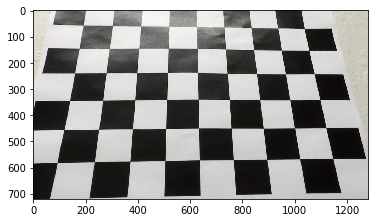

In [9]:
img = mpimg.imread('camera_cal/calibration3.jpg')
img_undistort = undistortion(img)
plt.imshow(img_undistort)
plt.show()

### Test Thresholding

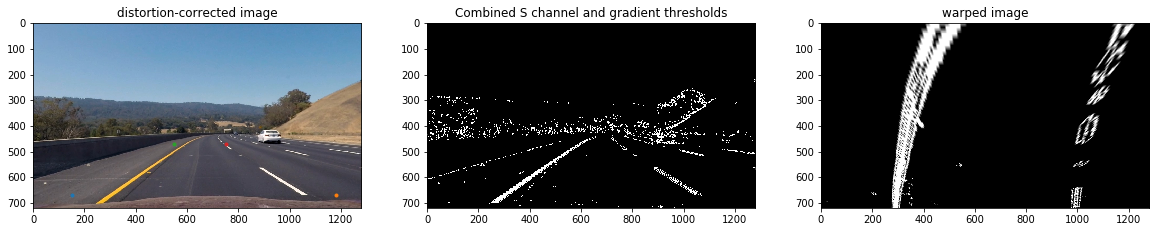

In [10]:
img_origin = mpimg.imread('test_images/test3.jpg')
img = undistortion(img_origin)
combined = combinedThresh(img)
# TODO: src and dst should be detected automatically
h, w = combined.shape[:2]
left_bottom = [150, h-50]
right_bottom = [w-100, h-50]
left_top = [550, 470]
right_top = [750, 470]
src = np.float32([left_bottom,right_bottom,left_top,right_top])
dst = np.float32([[150, h], [1100,h], [150, 300],[1100, 300]])
warped = perspectiveTransform(combined, src, dst)
# Plotting
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('distortion-corrected image')
ax1.plot(150, h-50, '.')
ax1.plot(w-100, h-50, '.')
ax1.plot(550, 470, '.')
ax1.plot(750, 470, '.')
ax1.imshow(img)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined, cmap='gray')

ax3.set_title('warped image')
ax3.imshow(warped, cmap='gray')

### Test Histogram and Sliding Window and Draw Lines

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


left_fit:[ 2.55891766e-04 -4.27183657e-01  4.70040314e+02] right_fit:[ 2.77722542e-04 -4.73041327e-01  1.18423315e+03]
left_curv: 641.8363059882499 right_curv: 591.4112875980699


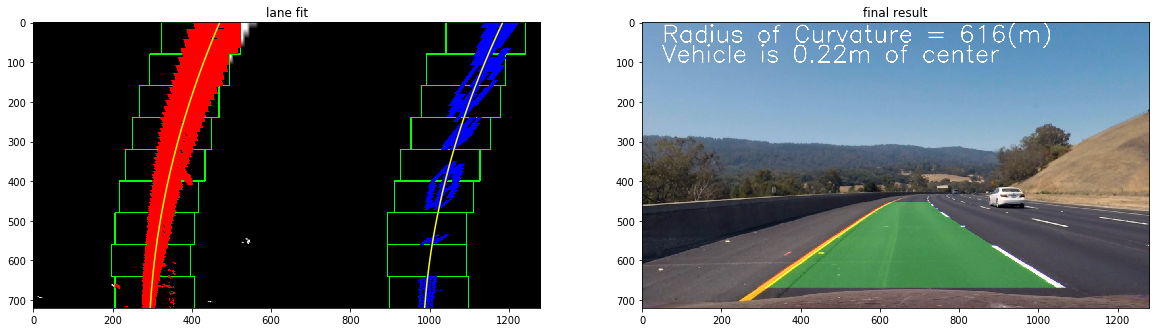

In [11]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
left_fitx, right_fitx, ploty = fit_poly(out_img.shape, leftx, lefty, rightx, righty)
result = drawLines(img, warped, 
                   src, dst, 
                   left_fitx, right_fitx, ploty, 
                   leftx, lefty, rightx, righty)
# calculate curvature and center offset
left_curverad, right_curverad = measure_curvature_real(ploty, leftx, lefty, rightx, righty)
offset = measure_position(warped.shape, leftx, lefty, rightx, righty)
## Visualization ##
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
writeText(result, f'Radius of Curvature = {int((left_curverad+right_curverad)/2)}(m)',(50,50), (255,255,255))
writeText(result, f'Vehicle is {offset}m of center',(50,100), (255,255,255))
# Plots the left and right polynomials on the lane lines
ax1.set_title('line fit')
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')
ax1.imshow(out_img)
ax1.set_title('lane fit')
ax2.set_title('final result')
ax2.imshow(result)

### Test All Images

In [12]:
def saveImg(img, path):
    try:
        cv2.imwrite(path, img)
    except Exception as e:
        print('save image error',e)

In [13]:
test_dir = 'test_images'
for fname in tqdm(os.listdir(test_dir)):
    path = os.path.join(test_dir, fname)
    # image undistortion
    img_origin = mpimg.imread(path)
    img = undistortion(img_origin)
    # hls and sobel thresholding
    combined = combinedThresh(img)
    # perspective transform
    warped = perspectiveTransform(combined, src, dst)
    # fit polynomial and fine lanes
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
    left_fitx, right_fitx, ploty = fit_poly(out_img.shape, leftx, lefty, rightx, righty)
    # calculate curvature and center offset
    left_curverad, right_curverad = measure_curvature_real(ploty, leftx, lefty, rightx, righty)
    offset = measure_position(warped.shape, leftx, lefty, rightx, righty)
    # draw images
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    result = drawLines(img, warped, 
                       src, dst, 
                       left_fitx, right_fitx, ploty, 
                       leftx, lefty, rightx, righty)
    writeText(result, f'Radius of Curvature = {int((left_curverad+right_curverad)/2)}(m)',(50,50), (255,255,255))
    writeText(result, f'Vehicle is {offset}m of center',(50,100), (255,255,255))
    # save images
    saveImg(out_img, f'test_images_output/{fname[:-4]}_fit{fname[-4:]}')
    saveImg(result, f'test_images_output/{fname}')
    

 12%|█▎        | 1/8 [00:00<00:01,  3.70it/s]

left_fit:[ 6.73974577e-05 -2.83374009e-01  4.66318268e+02] right_fit:[ 1.61229768e-04 -3.66790141e-01  1.19252647e+03]
left_curv: 2438.735436919651 right_curv: 1019.0358786458752


 25%|██▌       | 2/8 [00:00<00:01,  3.74it/s]

left_fit:[ 2.91004965e-04 -3.33108590e-01  3.29497027e+02] right_fit:[ 5.40016749e-04 -6.11678120e-01  1.17755825e+03]
left_curv: 564.4426394866904 right_curv: 304.31369231492346


 38%|███▊      | 3/8 [00:00<00:01,  3.83it/s]

left_fit:[ 1.55802387e-04 -1.22582007e-01  3.25344777e+02] right_fit:[ 2.84110872e-04 -4.09903154e-01  1.16178101e+03]
left_curv: 1054.3326192462234 right_curv: 578.0374860235306


 50%|█████     | 4/8 [00:01<00:01,  3.87it/s]

left_fit:[ 3.12438373e-04 -3.19295400e-01  3.65165962e+02] right_fit:[ 5.70810217e-04 -6.27206898e-01  1.18512172e+03]
left_curv: 525.8435993162736 right_curv: 287.9685005593136


 62%|██████▎   | 5/8 [00:01<00:00,  3.87it/s]

left_fit:[ 2.55891766e-04 -4.27183657e-01  4.70040314e+02] right_fit:[ 2.77722542e-04 -4.73041327e-01  1.18423315e+03]
left_curv: 641.8363059882499 right_curv: 591.4112875980699


 75%|███████▌  | 6/8 [00:01<00:00,  3.87it/s]

left_fit:[-3.61716756e-04  6.31363879e-01  6.82410630e+01] right_fit:[-4.14335350e-04  5.69302483e-01  8.02409575e+02]
left_curv: 454.1557998017335 right_curv: 396.36857733983743


 88%|████████▊ | 7/8 [00:01<00:00,  3.87it/s]

left_fit:[-8.37094628e-05  1.79058056e-01  1.85455424e+02] right_fit:[-5.73095264e-05  5.25424091e-02  9.49575813e+02]
left_curv: 1962.028825766677 right_curv: 2865.6712703557873


100%|██████████| 8/8 [00:02<00:00,  3.87it/s]

left_fit:[-2.67154712e-05  1.03383263e-01  2.08336320e+02] right_fit:[-1.21226562e-04  1.27632654e-01  9.14875135e+02]
left_curv: 6147.878054395938 right_curv: 1354.7803892109305


## Look-Ahead Filter
If you fit a polynomial, then for each y position, you have an x position that represents the lane center from the last frame. Search for the new line within +/- some margin around the old line center.

In [14]:
def search_around_poly(warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

## Test All Videos

In [15]:
def sanity_check(leftx, rightx, left_curv, right_curv):
    if np.max(leftx)>np.min(rightx) or np.absolute(left_curv - right_curv)>200:
        return False
    return True

In [16]:
def process_image(img_origin):
    img = undistortion(img_origin)
    # hls and sobel thresholding
    combined = combinedThresh(img)
    h, w = combined.shape[:2]
    left_bottom = [150, h-50]
    right_bottom = [w-100, h-50]
    left_top = [550, 470]
    right_top = [750, 470]
    src = np.float32([left_bottom,right_bottom,left_top,right_top])
    dst = np.float32([[150, h], [1100,h], [150, 300],[1100, 300]])
    # perspective transform
    warped = perspectiveTransform(combined, src, dst)
    # fit polynomial and fine lanes
    if len(left_fit)==0 and len(right_fit)==0:
        leftx, lefty, rightx, righty, _ = find_lane_pixels(warped)
    else:
        try:
            leftx, lefty, rightx, righty = search_around_poly(warped)
        except:
            leftx, lefty, rightx, righty, _ = find_lane_pixels(warped)
            
    left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)
    # calculate curvature and center offset
    left_curv, right_curv = measure_curvature_real(ploty, leftx, lefty, rightx, righty)
    offset = measure_position(warped.shape, leftx, lefty, rightx, righty)
    # check sanity. if bad result, reset lane search
    if not sanity_check(leftx, rightx, left_curv, right_curv):
        print('reset lane search')
        leftx, lefty, rightx, righty, _ = find_lane_pixels(warped)
        left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)
    # draw images
    result = drawLines(img, warped,
                       src, dst,
                       left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty)
    writeText(result, f'Radius of Curvature = {int((left_curv+right_curv)/2)}(m)',(50,50), (255,255,255))
    writeText(result, f'Vehicle is {offset}m of center',(50,100), (255,255,255))
    
    return result

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
DIR = 'test_videos'
test_output = 'test_videos_output'
for fname in tqdm(os.listdir(DIR)):
    path = os.path.join(DIR, fname)
    print(path)
    outPath = os.path.join(test_output, fname)
    print(f'processing {fname}')
    # initial left_fit and right_fit
    left_fit = np.array([])
    right_fit = np.array([])
    
    clip1 = VideoFileClip(path)
    clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    try:
        %time clip.write_videofile(outPath, audio=False)   
        HTML("""
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>
        """.format(outPath))
    except Exception as e:
        print('clip write error:',e)   

  0%|          | 0/3 [00:00<?, ?it/s]

test_videos/project_video.mp4
processing project_video.mp4
left_fit:[-3.61514518e-04  6.07826281e-01  7.39706397e+01] right_fit:[-2.38730890e-04  4.87419877e-01  8.12102195e+02]
left_curv: 454.35908325533296 right_curv: 688.2606588093336
reset lane search
left_fit:[-3.61514518e-04  6.07826281e-01  7.39706397e+01] right_fit:[-2.38730890e-04  4.87419877e-01  8.12102195e+02]
[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]

left_fit:[-3.65637512e-04  6.13599825e-01  7.18217018e+01] right_fit:[-2.41084688e-04  4.96212520e-01  8.08353607e+02]
left_curv: 449.23535317872347 right_curv: 681.567035149145
reset lane search



  0%|          | 1/1261 [00:00<04:36,  4.56it/s]

left_fit:[-3.61514518e-04  6.07826281e-01  7.39706397e+01] right_fit:[-2.38730890e-04  4.87419877e-01  8.12102195e+02]
left_fit:[-3.79479071e-04  6.31104415e-01  6.79853429e+01] right_fit:[-1.27505375e-04  4.14313871e-01  8.14277992e+02]
left_curv: 432.8450799871474 right_curv: 1289.6573094156045
reset lane search



  0%|          | 2/1261 [00:00<04:37,  4.53it/s]

left_fit:[-3.86356376e-04  6.33715320e-01  6.94517285e+01] right_fit:[-1.36324769e-04  4.07919512e-01  8.20160848e+02]
left_fit:[-3.90364816e-04  6.43665536e-01  6.47247265e+01] right_fit:[-1.24878785e-04  4.16541894e-01  8.08173724e+02]
left_curv: 420.7694588119136 right_curv: 1316.872063399863
reset lane search



  0%|          | 3/1261 [00:00<04:36,  4.55it/s]

left_fit:[-3.97645689e-04  6.47238785e-01  6.60302287e+01] right_fit:[-1.23208493e-04  4.14606117e-01  8.08704489e+02]
left_fit:[-3.86812560e-04  6.46268049e-01  6.40249660e+01] right_fit:[-1.76643676e-04  4.65788411e-01  7.94645644e+02]
left_curv: 424.64717563011067 right_curv: 930.7129206849968
reset lane search



  0%|          | 4/1261 [00:00<04:33,  4.59it/s]

left_fit:[-3.79237614e-04  6.38532181e-01  6.67943300e+01] right_fit:[-1.84040827e-04  4.66796017e-01  7.96533599e+02]
left_fit:[-3.70529140e-04  6.39160508e-01  6.31441065e+01] right_fit:[-2.32664003e-04  5.09473384e-01  7.88118441e+02]
left_curv: 443.3431528334013 right_curv: 706.3749037673368
reset lane search



  0%|          | 5/1261 [00:01<04:31,  4.63it/s]

left_fit:[-3.65291154e-04  6.33880836e-01  6.52027690e+01] right_fit:[-2.03365707e-04  4.79530790e-01  7.95408884e+02]



  0%|          | 6/1261 [00:01<04:17,  4.88it/s]

left_fit:[-3.87226356e-04  6.58657067e-01  5.85304498e+01] right_fit:[-2.66455615e-04  5.49645589e-01  7.74184315e+02]
left_curv: 424.21655778040105 right_curv: 616.7504291059379
left_fit:[-3.50618480e-04  6.31504167e-01  6.15359615e+01] right_fit:[-3.64916041e-04  6.16942922e-01  7.67814895e+02]
left_curv: 468.57481114896297 right_curv: 450.1320977360555



  1%|          | 7/1261 [00:01<04:10,  5.01it/s]

left_fit:[-3.35042866e-04  6.24446557e-01  6.13112345e+01] right_fit:[-4.37267293e-04  6.83203842e-01  7.48619315e+02]
left_curv: 490.4071243087123 right_curv: 375.60198743947547



  1%|          | 8/1261 [00:01<04:01,  5.19it/s]

left_fit:[-3.15070220e-04  6.15883646e-01  5.81238167e+01] right_fit:[-4.33530008e-04  6.65068419e-01  7.59438794e+02]
left_curv: 521.5720574320821 right_curv: 378.82868909683356



  1%|          | 9/1261 [00:01<03:55,  5.32it/s]

left_fit:[-2.99985679e-04  6.07639416e-01  5.65714531e+01] right_fit:[-4.30009125e-04  6.77345845e-01  7.52285385e+02]
left_curv: 547.8591635846655 right_curv: 381.94659940509723



  1%|          | 10/1261 [00:01<03:53,  5.35it/s]

left_fit:[-2.59128315e-04  5.78709405e-01  5.83217279e+01] right_fit:[-3.39741151e-04  6.31703759e-01  7.48869829e+02]
left_curv: 634.4158857354711 right_curv: 483.6269480699138



  1%|          | 11/1261 [00:02<03:49,  5.44it/s]

left_fit:[-2.16672195e-04  5.55185436e-01  5.29688642e+01] right_fit:[-3.90571627e-04  6.28178482e-01  7.73060703e+02]
left_curv: 759.0362419361492 right_curv: 420.5228079658383
reset lane search



  1%|          | 12/1261 [00:02<03:59,  5.21it/s]

left_fit:[-2.29139071e-04  5.64692020e-01  5.26973121e+01] right_fit:[-2.58487576e-04  5.13371462e-01  7.95143576e+02]



  1%|          | 13/1261 [00:02<03:54,  5.32it/s]

left_fit:[-2.17705381e-04  5.57859544e-01  5.03150845e+01] right_fit:[-2.36000949e-04  5.25292063e-01  7.79843673e+02]
left_curv: 755.4445819545128 right_curv: 696.4538966843597
left_fit:[-2.21979124e-04  5.59933776e-01  4.95506948e+01] right_fit:[-1.45872447e-04  4.57632348e-01  7.87048319e+02]
left_curv: 740.8647581539622 right_curv: 1127.4942586567063
reset lane search



  1%|          | 14/1261 [00:02<04:02,  5.15it/s]

left_fit:[-2.39692272e-04  5.71636033e-01  4.97160898e+01] right_fit:[-1.29328025e-04  4.31180295e-01  7.95966127e+02]
left_fit:[-2.50823739e-04  5.78366935e-01  4.98375843e+01] right_fit:[-1.17240485e-04  4.61293698e-01  7.67216587e+02]
left_curv: 655.4986128610888 right_curv: 1403.6659851184945
reset lane search



  1%|          | 15/1261 [00:02<04:10,  4.97it/s]

left_fit:[-2.55116043e-04  5.80236512e-01  5.12340748e+01] right_fit:[-1.08853999e-04  4.53035262e-01  7.69147984e+02]
left_fit:[-3.02676575e-04  6.15250742e-01  4.66148947e+01] right_fit:[-2.20394540e-04  5.60025378e-01  7.37805960e+02]
left_curv: 543.0059748332304 right_curv: 746.212037243119
reset lane search



  1%|▏         | 16/1261 [00:03<04:15,  4.87it/s]

left_fit:[-2.95618683e-04  6.07164058e-01  4.97593399e+01] right_fit:[-2.01736462e-04  5.38882416e-01  7.43569488e+02]


left_fit:[-2.85084635e-04  6.08986217e-01  4.43269603e+01] right_fit:[-2.93621414e-04  6.20803336e-01  7.25384292e+02]
left_curv: 576.6140154220813 right_curv: 559.847016167173


  1%|▏         | 17/1261 [00:03<04:06,  5.05it/s]

left_fit:[-2.96982144e-04  6.14860916e-01  4.50506118e+01] right_fit:[-3.83864794e-04  7.02881158e-01  7.05425752e+02]
left_curv: 553.4560455431632 right_curv: 428.05953555567294



  1%|▏         | 18/1261 [00:03<04:00,  5.17it/s]

left_fit:[-2.97107438e-04  6.13161458e-01  4.34956522e+01] right_fit:[-4.49830909e-04  7.30495346e-01  7.12306288e+02]
left_curv: 553.2132703205557 right_curv: 365.14711603032515



  2%|▏         | 19/1261 [00:03<03:55,  5.28it/s]

left_fit:[-2.98828971e-04  6.16260269e-01  3.96526334e+01] right_fit:[-5.41581954e-04  7.68479995e-01  7.16848852e+02]
left_curv: 550.0293286448062 right_curv: 303.23600584916426
reset lane search



  2%|▏         | 20/1261 [00:03<04:03,  5.09it/s]

left_fit:[-2.86819548e-04  6.07378205e-01  4.17684840e+01] right_fit:[-2.93351598e-04  5.81048728e-01  7.47445854e+02]
left_fit:[-2.85778345e-04  6.05321355e-01  3.92491743e+01] right_fit:[-5.37326920e-04  7.44497312e-01  7.32432085e+02]
left_curv: 575.1888652382191 right_curv: 305.6423721133615
reset lane search



  2%|▏         | 21/1261 [00:04<04:10,  4.96it/s]

left_fit:[-2.75064794e-04  5.96316915e-01  4.13127416e+01] right_fit:[-2.75999942e-04  5.48346957e-01  7.64407015e+02]
left_fit:[-2.71915931e-04  5.95618577e-01  3.65680881e+01] right_fit:[-4.81018321e-04  6.88936633e-01  7.51634456e+02]
left_curv: 604.571821783886 right_curv: 341.41476498249284
reset lane search



  2%|▏         | 22/1261 [00:04<04:13,  4.88it/s]

left_fit:[-2.65226421e-04  5.93336073e-01  3.72064269e+01] right_fit:[-3.08961164e-04  5.53140951e-01  7.75586239e+02]
left_fit:[-2.54086464e-04  5.79170349e-01  3.71209523e+01] right_fit:[-5.29995626e-04  7.10753749e-01  7.57540896e+02]
left_curv: 647.0551655886189 right_curv: 309.8840520926224
reset lane search



  2%|▏         | 23/1261 [00:04<04:17,  4.81it/s]

left_fit:[-2.43424073e-04  5.73598612e-01  3.82396402e+01] right_fit:[-3.35671150e-04  5.58916402e-01  7.82732475e+02]
left_fit:[-2.56682560e-04  5.74597828e-01  4.11840851e+01] right_fit:[-4.95359064e-04  7.14675768e-01  7.45136370e+02]
left_curv: 640.4570261780443 right_curv: 331.5307231967685
reset lane search



  2%|▏         | 24/1261 [00:04<04:21,  4.73it/s]

left_fit:[-2.51732496e-04  5.71883387e-01  4.16078322e+01] right_fit:[-3.36538446e-04  5.82991171e-01  7.68869101e+02]



  2%|▏         | 25/1261 [00:04<04:09,  4.95it/s]

left_fit:[-3.03257824e-04  6.05328471e-01  3.92231591e+01] right_fit:[-3.65425346e-04  6.36528545e-01  7.48387127e+02]
left_curv: 541.9160773465585 right_curv: 449.5463060544329
left_fit:[-2.67923387e-04  5.80889318e-01  3.87746204e+01] right_fit:[-3.63280247e-04  6.16555134e-01  7.63810153e+02]
left_curv: 613.5277971051812 right_curv: 452.1629675018651



  2%|▏         | 26/1261 [00:05<04:00,  5.13it/s]

left_fit:[-2.98683333e-04  5.96112124e-01  3.98255592e+01] right_fit:[-2.45613707e-04  5.24934861e-01  7.78981768e+02]
left_curv: 550.2040428663869 right_curv: 669.1144030941921



  2%|▏         | 27/1261 [00:05<03:54,  5.25it/s]

left_fit:[-2.89060638e-04  5.94003503e-01  3.49314184e+01] right_fit:[-2.56365814e-04  5.01727748e-01  8.00559020e+02]
left_curv: 568.5755786639722 right_curv: 640.8691205462142



  2%|▏         | 28/1261 [00:05<03:50,  5.35it/s]

left_fit:[-3.21424090e-04  6.12090435e-01  3.62921211e+01] right_fit:[-1.23958997e-04  4.09881301e-01  8.05991144e+02]
left_curv: 511.21181256219234 right_curv: 1326.563351915079
reset lane search



  2%|▏         | 29/1261 [00:05<04:03,  5.06it/s]

left_fit:[-3.20739933e-04  6.08800969e-01  3.89855288e+01] right_fit:[-1.06415089e-04  3.91599901e-01  8.10402445e+02]
left_fit:[-3.50755199e-04  6.35796401e-01  3.50755433e+01] right_fit:[-2.02446626e-04  4.81890648e-01  7.86871910e+02]
left_curv: 468.40414600597404 right_curv: 811.9227652598477
reset lane search



  2%|▏         | 30/1261 [00:05<04:09,  4.93it/s]

left_fit:[-3.42032557e-04  6.27475768e-01  3.77510492e+01] right_fit:[-1.69019705e-04  4.45823038e-01  7.96156513e+02]



  2%|▏         | 31/1261 [00:06<04:01,  5.09it/s]

left_fit:[-3.66506104e-04  6.45501847e-01  3.74345750e+01] right_fit:[-2.82860700e-04  5.66711663e-01  7.63395109e+02]
left_curv: 448.23909807209105 right_curv: 580.9508691615314


left_fit:[-4.16088359e-04  6.80414948e-01  3.72036125e+01] right_fit:[-3.52707392e-04  6.45625090e-01  7.35765620e+02]
left_curv: 394.75614225644796 right_curv: 465.8328840195915



  3%|▎         | 32/1261 [00:06<03:55,  5.22it/s]

left_fit:[-4.05236987e-04  6.74283005e-01  3.58862920e+01] right_fit:[-4.95792943e-04  7.23824382e-01  7.36779567e+02]
left_curv: 405.3429501305769 right_curv: 331.2414944329631



  3%|▎         | 33/1261 [00:06<03:50,  5.33it/s]

left_fit:[-4.43721040e-04  7.09896366e-01  3.04986879e+01] right_fit:[-5.79923501e-04  8.03932801e-01  7.16642278e+02]
left_curv: 370.15864392712524 right_curv: 283.19303083836576



  3%|▎         | 34/1261 [00:06<03:46,  5.41it/s]

left_fit:[-4.65120645e-04  7.32958517e-01  2.63767944e+01] right_fit:[-5.93362488e-04  8.30421960e-01  7.07668225e+02]
left_curv: 353.1191849751985 right_curv: 276.7765013326432



  3%|▎         | 35/1261 [00:06<03:46,  5.42it/s]

left_fit:[-4.76256438e-04  7.44200148e-01  2.63259980e+01] right_fit:[-4.06939559e-04  7.23857335e-01  7.10132916e+02]
left_curv: 344.8576743947336 right_curv: 403.75276607124493



  3%|▎         | 36/1261 [00:07<03:44,  5.46it/s]

left_fit:[-4.74856773e-04  7.46116448e-01  2.59348451e+01] right_fit:[-2.97770894e-04  6.46590882e-01  7.18146809e+02]
left_curv: 345.8781822574862 right_curv: 552.1555347368618
reset lane search



  3%|▎         | 37/1261 [00:07<03:53,  5.24it/s]

left_fit:[-4.64318100e-04  7.36947229e-01  2.78148899e+01] right_fit:[-3.08243554e-04  6.41462636e-01  7.23463239e+02]
left_fit:[-4.86067319e-04  7.62973718e-01  2.15441490e+01] right_fit:[-2.93040229e-04  6.51133534e-01  7.12405736e+02]
left_curv: 337.901691700595 right_curv: 561.1380108801853
reset lane search



  3%|▎         | 38/1261 [00:07<04:03,  5.02it/s]

left_fit:[-4.75771488e-04  7.52859983e-01  2.38030908e+01] right_fit:[-2.35280894e-04  5.78866226e-01  7.33318472e+02]
left_fit:[-5.27356803e-04  7.99716698e-01  1.62701349e+01] right_fit:[-2.89663796e-04  6.57806399e-01  7.02502568e+02]
left_curv: 311.42769579299306 right_curv: 567.7531970032198
reset lane search



  3%|▎         | 39/1261 [00:07<04:09,  4.90it/s]

left_fit:[-5.16982230e-04  7.88104951e-01  1.91670870e+01] right_fit:[-2.40320559e-04  6.00111621e-01  7.18473693e+02]



  3%|▎         | 40/1261 [00:07<04:00,  5.07it/s]

left_fit:[-5.12127652e-04  7.94993931e-01  1.34071119e+01] right_fit:[-3.45552528e-04  6.93761977e-01  7.00982122e+02]
left_curv: 320.7019152077485 right_curv: 475.7030107340243


left_fit:[-4.80358547e-04  7.78189762e-01  1.21473586e+01] right_fit:[-4.19545156e-04  7.54815816e-01  6.90431224e+02]
left_curv: 341.9467283512287 right_curv: 391.6568547481837



  3%|▎         | 41/1261 [00:08<03:54,  5.21it/s]

left_fit:[-4.38539289e-04  7.50802191e-01  1.45652056e+01] right_fit:[-4.41627218e-04  7.68529067e-01  6.90564699e+02]
left_curv: 374.61635432452243 right_curv: 372.02723198430624



  3%|▎         | 43/1261 [00:08<04:00,  5.07it/s]

left_fit:[-4.08437836e-04  7.29856755e-01  1.52216558e+01] right_fit:[-4.81389916e-04  7.90992287e-01  6.93286852e+02]
left_curv: 402.28217086357796 right_curv: 341.23147096490385
left_fit:[-4.00934398e-04  7.22403625e-01  1.49796045e+01] right_fit:[-4.53385790e-04  7.47648367e-01  7.11073476e+02]
left_curv: 409.82034788479433 right_curv: 362.30297279251835



  4%|▎         | 45/1261 [00:08<03:49,  5.30it/s]

left_fit:[-3.80545907e-04  7.10172310e-01  1.45797774e+01] right_fit:[-4.79222511e-04  7.57198402e-01  7.15583685e+02]
left_curv: 431.8322546585538 right_curv: 342.73243744109624
left_fit:[-3.94532026e-04  7.19236490e-01  1.35049925e+01] right_fit:[-5.81244628e-04  8.21514327e-01  7.07755561e+02]
left_curv: 416.4888882927247 right_curv: 282.544614218914



  4%|▎         | 47/1261 [00:09<03:46,  5.36it/s]

left_fit:[-3.69227283e-04  7.01213899e-01  1.36779965e+01] right_fit:[-5.79484786e-04  8.17087256e-01  7.12068012e+02]
left_curv: 445.09621338003905 right_curv: 283.403072208322
left_fit:[-3.55468137e-04  6.91015260e-01  1.45708307e+01] right_fit:[-5.80710851e-04  8.41490642e-01  6.98186252e+02]
left_curv: 462.3620463759368 right_curv: 282.80320629772484



  4%|▍         | 49/1261 [00:09<03:57,  5.10it/s]

left_fit:[-3.13994400e-04  6.60579854e-01  1.61279582e+01] right_fit:[-5.27858211e-04  7.90766332e-01  7.15054372e+02]
left_curv: 523.5762610954424 right_curv: 311.1265646775635
reset lane search
left_fit:[-3.07383709e-04  6.54307670e-01  1.81481119e+01] right_fit:[-3.47440208e-04  6.37714505e-01  7.43778482e+02]



  4%|▍         | 50/1261 [00:09<03:55,  5.15it/s]

left_fit:[-3.14052904e-04  6.57920848e-01  1.72791960e+01] right_fit:[-4.18868951e-04  7.26743175e-01  7.16720311e+02]
left_curv: 523.4643376451334 right_curv: 392.218349484374
left_fit:[-2.83235046e-04  6.37722617e-01  1.78951385e+01] right_fit:[-2.89146190e-04  6.29524972e-01  7.29569963e+02]
left_curv: 580.5682273956518 right_curv: 568.5976894752956



  4%|▍         | 52/1261 [00:10<03:49,  5.27it/s]

left_fit:[-2.94712865e-04  6.50551540e-01  1.52795857e+01] right_fit:[-2.28711322e-04  5.96115559e-01  7.23935840e+02]
left_curv: 557.9349329478262 right_curv: 719.290591114456
left_fit:[-2.70941961e-04  6.27388351e-01  1.96553560e+01] right_fit:[-2.57895955e-04  6.13358827e-01  7.19952350e+02]
left_curv: 606.9598940989987 right_curv: 637.6987010136087



  4%|▍         | 54/1261 [00:10<03:46,  5.33it/s]

left_fit:[-2.86423280e-04  6.38481035e-01  1.73179260e+01] right_fit:[-3.18557903e-04  6.69122773e-01  7.05241142e+02]
left_curv: 574.0815940471126 right_curv: 516.0861235215125
left_fit:[-2.49304704e-04  6.12570246e-01  1.89381596e+01] right_fit:[-3.30612017e-04  6.73042855e-01  7.07821082e+02]
left_curv: 659.765706514741 right_curv: 497.20387298665344



  4%|▍         | 56/1261 [00:10<03:45,  5.33it/s]

left_fit:[-2.65687598e-04  6.20139160e-01  1.83244813e+01] right_fit:[-3.55885682e-04  6.88986123e-01  7.07802523e+02]
left_curv: 618.9655975956293 right_curv: 461.8091150052539
left_fit:[-3.10781759e-04  6.51316266e-01  1.52349404e+01] right_fit:[-3.98164146e-04  7.23931604e-01  7.00743369e+02]
left_curv: 528.9641187054499 right_curv: 412.6880130980553



  5%|▍         | 58/1261 [00:11<03:45,  5.35it/s]

left_fit:[-2.96308934e-04  6.35056718e-01  1.87796987e+01] right_fit:[-4.43452194e-04  7.39867329e-01  7.02977946e+02]
left_curv: 554.8258702913577 right_curv: 370.43028194167135
left_fit:[-2.71200600e-04  6.07502742e-01  2.79820889e+01] right_fit:[-4.21427797e-04  7.65608516e-01  6.78469178e+02]
left_curv: 606.2461733767157 right_curv: 389.9308761865209
reset lane search



  5%|▍         | 59/1261 [00:11<03:54,  5.12it/s]

left_fit:[-2.68203595e-04  6.05260701e-01  2.89411897e+01] right_fit:[-3.31623378e-04  6.74714870e-01  7.01472230e+02]
left_fit:[-2.71800416e-04  5.97801988e-01  3.50641257e+01] right_fit:[-2.60469746e-04  6.66943576e-01  6.79803813e+02]
left_curv: 604.8428734545737 right_curv: 631.8037146456043



  5%|▍         | 61/1261 [00:11<04:08,  4.82it/s]

left_fit:[-2.97146710e-04  6.12965354e-01  3.52758751e+01] right_fit:[-1.71829322e-04  6.01489150e-01  6.86179197e+02]
left_curv: 553.1389031856235 right_curv: 958.654113442845
reset lane search
left_fit:[-2.83601660e-04  6.03588824e-01  3.70661860e+01] right_fit:[-1.32309079e-04  5.56912989e-01  6.98122655e+02]



  5%|▍         | 62/1261 [00:12<04:11,  4.77it/s]

left_fit:[-3.20019805e-04  6.25725387e-01  3.58131672e+01] right_fit:[-1.64816159e-04  6.01773692e-01  6.79015429e+02]
left_curv: 513.516249654969 right_curv: 999.6257696165002
reset lane search
left_fit:[-3.07404581e-04  6.15361263e-01  3.77638693e+01] right_fit:[-1.46081551e-04  5.69667787e-01  6.90593685e+02]



  5%|▍         | 63/1261 [00:12<04:07,  4.84it/s]

left_fit:[-3.12256734e-04  6.10405498e-01  4.04014827e+01] right_fit:[-2.45959188e-04  6.40670034e-01  6.83428888e+02]
left_curv: 526.2656140976969 right_curv: 669.0269505577243



  5%|▌         | 64/1261 [00:12<04:09,  4.80it/s]

left_fit:[-3.14176357e-04  6.05794176e-01  4.45370382e+01] right_fit:[-3.59578844e-04  7.30572200e-01  6.66325473e+02]
left_curv: 523.0207789002645 right_curv: 457.22227595836546
left_fit:[-2.63294250e-04  5.63915174e-01  4.89326474e+01] right_fit:[-4.19914187e-04  7.57007559e-01  6.72353121e+02]



  5%|▌         | 65/1261 [00:12<04:19,  4.62it/s]

left_curv: 624.2554116558657 right_curv: 391.3174359078416
reset lane search
left_fit:[-2.45853164e-04  5.46530024e-01  5.35261166e+01] right_fit:[-2.05000542e-04  5.79065240e-01  7.02914380e+02]



  5%|▌         | 66/1261 [00:12<04:13,  4.72it/s]

left_fit:[-2.90005681e-04  5.80554299e-01  4.92260513e+01] right_fit:[-3.67426024e-04  7.18207567e-01  6.75433224e+02]
left_curv: 566.6535425626967 right_curv: 447.35435091198326
left_fit:[-2.73332459e-04  5.66390162e-01  5.12503738e+01] right_fit:[-4.58804981e-04  7.83907376e-01  6.68027092e+02]
left_curv: 601.2672365432618 right_curv: 358.07769203529534
reset lane search



  5%|▌         | 67/1261 [00:13<04:16,  4.65it/s]

left_fit:[-2.55583833e-04  5.51000103e-01  5.43150929e+01] right_fit:[-2.60024508e-04  6.10783233e-01  7.00015388e+02]
left_fit:[-2.38013230e-04  5.40618521e-01  5.16641228e+01] right_fit:[-4.78119266e-04  7.83711380e-01  6.74775519e+02]
left_curv: 690.6453294590347 right_curv: 343.5615519769243
reset lane search



  5%|▌         | 68/1261 [00:13<04:21,  4.57it/s]

left_fit:[-2.25486634e-04  5.30577740e-01  5.41606973e+01] right_fit:[-2.71017161e-04  6.09175252e-01  7.05417172e+02]
left_fit:[-2.59079876e-04  5.50638272e-01  5.42414552e+01] right_fit:[-4.53109096e-04  7.78278086e-01  6.65625452e+02]
left_curv: 634.3698498627652 right_curv: 362.5845910879848
reset lane search



  5%|▌         | 69/1261 [00:13<04:27,  4.46it/s]

left_fit:[-2.44894761e-04  5.39218659e-01  5.66272560e+01] right_fit:[-3.02082434e-04  6.46800927e-01  6.90933845e+02]
left_fit:[-2.61199464e-04  5.52525796e-01  5.11682934e+01] right_fit:[-4.85833026e-04  7.63091312e-01  6.83212077e+02]
left_curv: 629.2157960391795 right_curv: 338.06512067224816
reset lane search



  6%|▌         | 70/1261 [00:13<04:28,  4.44it/s]

left_fit:[-2.47376023e-04  5.41719287e-01  5.32740678e+01] right_fit:[-3.46491137e-04  6.47692788e-01  7.05298449e+02]
left_fit:[-2.76545614e-04  5.59696825e-01  5.20300749e+01] right_fit:[-4.04096188e-04  7.16222135e-01  6.84598007e+02]
left_curv: 594.2267721927992 right_curv: 406.58419232158576



  6%|▌         | 72/1261 [00:14<04:11,  4.73it/s]

left_fit:[-2.61837744e-04  5.48717749e-01  5.16058558e+01] right_fit:[-3.82143646e-04  6.90262357e-01  6.94865453e+02]
left_curv: 627.6569759669869 right_curv: 429.9567928851592
left_fit:[-2.49425731e-04  5.38525601e-01  5.22056767e+01] right_fit:[-3.13947468e-04  6.39097472e-01  7.03662828e+02]



  6%|▌         | 73/1261 [00:14<04:07,  4.80it/s]

left_curv: 658.9335182290694 right_curv: 523.5472254837274
left_fit:[-2.61275156e-04  5.49970994e-01  4.87752943e+01] right_fit:[-2.65294112e-04  6.00584787e-01  7.09373172e+02]
left_curv: 629.0193149662418 right_curv: 619.7538749203374



  6%|▌         | 75/1261 [00:14<03:53,  5.07it/s]

left_fit:[-2.45562700e-04  5.35149694e-01  4.93560505e+01] right_fit:[-2.73400601e-04  5.91960988e-01  7.18588965e+02]
left_curv: 669.3121593626067 right_curv: 601.2548717789019
left_fit:[-2.57546482e-04  5.42354238e-01  4.92590031e+01] right_fit:[-2.53473694e-04  5.75974013e-01  7.19127117e+02]



  6%|▌         | 76/1261 [00:15<03:55,  5.03it/s]

left_curv: 638.1140283479443 right_curv: 648.6040120440233
left_fit:[-2.28693783e-04  5.22994977e-01  4.58716755e+01] right_fit:[-2.27744837e-04  5.22504997e-01  7.46285917e+02]
left_curv: 718.7609206436896 right_curv: 721.7617135625335



  6%|▌         | 78/1261 [00:15<03:49,  5.15it/s]

left_fit:[-2.43978868e-04  5.34342328e-01  4.24697062e+01] right_fit:[-2.23025152e-04  5.04637654e-01  7.55736207e+02]
left_curv: 673.6658526902844 right_curv: 736.9610679107391
left_fit:[-2.23570414e-04  5.16073662e-01  4.33284504e+01] right_fit:[-2.17918808e-04  4.90463621e-01  7.62930423e+02]



  6%|▋         | 79/1261 [00:15<03:50,  5.13it/s]

left_curv: 735.2352190838443 right_curv: 754.184901850246
left_fit:[-2.24361341e-04  5.11692584e-01  4.54732608e+01] right_fit:[-2.23467966e-04  4.89880455e-01  7.64352063e+02]
left_curv: 732.6059192671313 right_curv: 735.4044618611498



  6%|▋         | 81/1261 [00:16<03:50,  5.13it/s]

left_fit:[-2.38774397e-04  5.16510039e-01  4.71139412e+01] right_fit:[-2.91126383e-04  5.60628702e-01  7.44486841e+02]
left_curv: 688.288188366749 right_curv: 564.3825721339383
left_fit:[-2.49428258e-04  5.23603114e-01  4.42254784e+01] right_fit:[-3.5619613e-04  5.9789374e-01  7.4420790e+02]
left_curv: 658.8450305054366 right_curv: 461.1387331915628



  7%|▋         | 83/1261 [00:16<03:55,  4.99it/s]

left_fit:[-2.74313410e-04  5.41881570e-01  4.14088503e+01] right_fit:[-4.13099755e-04  6.36190574e-01  7.39050126e+02]
left_curv: 598.9969192842793 right_curv: 397.56443531116275
reset lane search
left_fit:[-2.79314923e-04  5.47147984e-01  4.08013887e+01] right_fit:[-1.77837044e-04  4.70665244e-01  7.63564132e+02]



  7%|▋         | 84/1261 [00:16<03:56,  4.98it/s]

left_fit:[-2.90438478e-04  5.56200302e-01  3.48303409e+01] right_fit:[-3.61658678e-04  5.64857943e-01  7.70113664e+02]
left_curv: 565.7061423479122 right_curv: 454.1151386926836
left_fit:[-2.99865266e-04  5.60920526e-01  3.47643773e+01] right_fit:[-4.26046756e-04  6.23153613e-01  7.58353022e+02]
left_curv: 547.8908431504159 right_curv: 385.46746621562306



  7%|▋         | 86/1261 [00:17<03:50,  5.09it/s]

left_fit:[-3.33824816e-04  5.84885727e-01  3.29556206e+01] right_fit:[-4.76142609e-04  6.65950221e-01  7.50229384e+02]
left_curv: 492.08536507339625 right_curv: 344.913722070672
left_fit:[-3.48684086e-04  5.89068609e-01  4.13991874e+01] right_fit:[-3.13497657e-04  5.90616432e-01  7.37825621e+02]
left_curv: 471.07739555220684 right_curv: 524.1003080213233



  7%|▋         | 88/1261 [00:17<04:08,  4.71it/s]

left_fit:[-3.72135042e-04  5.98383673e-01  4.76325271e+01] right_fit:[-2.30240070e-04  5.45598221e-01  7.32806962e+02]
left_curv: 441.35211527518857 right_curv: 714.0771807379917
reset lane search
left_fit:[-3.65370395e-04  5.92006062e-01  4.89137157e+01] right_fit:[-1.93753558e-04  5.02624513e-01  7.44689498e+02]



  7%|▋         | 89/1261 [00:17<04:18,  4.54it/s]

left_fit:[-3.83512227e-04  6.06940946e-01  4.96312781e+01] right_fit:[-2.25554029e-04  5.44505220e-01  7.27694089e+02]
left_curv: 428.2494905843155 right_curv: 728.9557765902373
reset lane search
left_fit:[-3.84667277e-04  6.06960415e-01  5.02708605e+01] right_fit:[-2.18352933e-04  5.28105036e-01  7.34200131e+02]



  7%|▋         | 90/1261 [00:17<04:07,  4.73it/s]

left_fit:[-4.03409797e-04  6.18068872e-01  5.48082749e+01] right_fit:[-3.11313945e-04  6.33268389e-01  6.99288046e+02]
left_curv: 407.1106903305429 right_curv: 527.966401914036
left_fit:[-3.95921614e-04  6.11593799e-01  5.48817596e+01] right_fit:[-3.96059680e-04  6.79150505e-01  7.04577309e+02]
left_curv: 414.8139437237672 right_curv: 414.77174144473145



  7%|▋         | 92/1261 [00:18<03:53,  5.00it/s]

left_fit:[-3.68207568e-04  5.94415034e-01  5.56372468e+01] right_fit:[-4.21137192e-04  6.95166304e-01  7.04984566e+02]
left_curv: 446.0621004603883 right_curv: 390.0356848086944
left_fit:[-3.72150974e-04  6.03908950e-01  5.53853165e+01] right_fit:[-4.27838292e-04  7.09619342e-01  6.96573996e+02]
left_curv: 441.3409593074035 right_curv: 383.93488687227455



  7%|▋         | 94/1261 [00:18<03:49,  5.09it/s]

left_fit:[-3.6217432e-04  5.9598432e-01  5.8272104e+01] right_fit:[-4.77540812e-04  7.47585745e-01  6.89755655e+02]
left_curv: 453.50849906052 right_curv: 343.93169535453563
left_fit:[-3.46600881e-04  5.89111445e-01  5.65183661e+01] right_fit:[-4.90169680e-04  7.30267210e-01  7.01810136e+02]
left_curv: 473.91495035790183 right_curv: 335.045784635783



  8%|▊         | 96/1261 [00:19<03:45,  5.16it/s]

left_fit:[-3.30027028e-04  5.77974897e-01  5.73043903e+01] right_fit:[-5.24764933e-04  7.50028843e-01  6.99736745e+02]
left_curv: 497.7444143291105 right_curv: 312.95309529561337
left_fit:[-3.22211390e-04  5.74668768e-01  5.72766001e+01] right_fit:[-4.36175959e-04  6.88938703e-01  7.08676333e+02]
left_curv: 509.83878321195886 right_curv: 376.5494723051957



  8%|▊         | 98/1261 [00:19<03:38,  5.33it/s]

left_fit:[-3.29848045e-04  5.81903787e-01  5.39596146e+01] right_fit:[-4.38851970e-04  6.77692369e-01  7.19549979e+02]
left_curv: 498.025117717375 right_curv: 374.23859353680245
left_fit:[-3.63212826e-04  6.10336027e-01  5.02978318e+01] right_fit:[-3.20244251e-04  6.08760589e-01  7.21116129e+02]
left_curv: 452.2347240597677 right_curv: 513.0891826945458



  8%|▊         | 100/1261 [00:19<03:36,  5.36it/s]

left_fit:[-3.55880674e-04  6.05151209e-01  4.94993031e+01] right_fit:[-2.88342912e-04  5.69813450e-01  7.35137772e+02]
left_curv: 461.56287484788464 right_curv: 569.8846332489438



  8%|▊         | 101/1261 [00:20<03:45,  5.14it/s]

left_fit:[-3.77410259e-04  6.19737728e-01  5.01473491e+01] right_fit:[-2.77703353e-04  5.64768249e-01  7.34134523e+02]
left_curv: 435.20344427937863 right_curv: 591.7653821193493



  8%|▊         | 102/1261 [00:20<03:49,  5.05it/s]

left_fit:[-4.01819483e-04  6.32862416e-01  5.11949966e+01] right_fit:[-2.71631198e-04  5.64195339e-01  7.30032003e+02]
left_curv: 408.7376197015799 right_curv: 605.0343252507906
left_fit:[-3.96285537e-04  6.28474080e-01  5.26056480e+01] right_fit:[-3.20667136e-04  5.91088063e-01  7.32036185e+02]
left_curv: 414.4495118480994 right_curv: 512.3496513432855



  8%|▊         | 104/1261 [00:20<03:49,  5.05it/s]

left_fit:[-3.91868322e-04  6.29915952e-01  5.11445568e+01] right_fit:[-3.93763882e-04  6.48777987e-01  7.24266238e+02]
left_curv: 419.13112380819143 right_curv: 417.1376464565906
left_fit:[-3.56745241e-04  6.07372990e-01  5.11967755e+01] right_fit:[-4.03341709e-04  6.31969022e-01  7.42575317e+02]
left_curv: 460.44632499185167 right_curv: 407.19178675089745



  8%|▊         | 106/1261 [00:20<03:43,  5.17it/s]

left_fit:[-3.56130361e-04  6.07181271e-01  5.02032322e+01] right_fit:[-3.87697369e-04  6.04655632e-01  7.56074757e+02]
left_curv: 461.2427727813404 right_curv: 423.61788317914653
left_fit:[-3.16501620e-04  5.76587283e-01  5.43398338e+01] right_fit:[-4.00450612e-04  6.00010183e-01  7.67420612e+02]
left_curv: 519.0659419116516 right_curv: 410.11060068585385



  9%|▊         | 108/1261 [00:21<03:44,  5.14it/s]

left_fit:[-3.67559239e-04  6.15957850e-01  5.26747832e+01] right_fit:[-4.59970110e-04  6.60415689e-01  7.48558447e+02]
left_curv: 446.8858288136075 right_curv: 357.037832195146
left_fit:[-3.66979935e-04  6.14750677e-01  5.44647178e+01] right_fit:[-5.79122893e-04  7.42771356e-01  7.38896743e+02]
left_curv: 447.5905653166562 right_curv: 283.6338290613824



  9%|▊         | 110/1261 [00:21<03:53,  4.93it/s]

left_fit:[-3.55713006e-04  6.07788903e-01  5.49836585e+01] right_fit:[-6.33363821e-04  7.94442259e-01  7.30175526e+02]
left_curv: 461.7865210097077 right_curv: 259.37759017472325
reset lane search
left_fit:[-3.36951532e-04  5.94581584e-01  5.74273463e+01] right_fit:[-4.59379229e-04  6.56783276e-01  7.54041503e+02]



  9%|▉         | 111/1261 [00:21<03:47,  5.06it/s]

left_fit:[-3.84050826e-04  6.31455645e-01  5.17369991e+01] right_fit:[-5.58720810e-04  7.55393249e-01  7.31168817e+02]
left_curv: 427.6819031576706 right_curv: 293.94981467606675
left_fit:[-3.30772987e-04  5.90319793e-01  5.52265496e+01] right_fit:[-5.44637207e-04  7.15995529e-01  7.55172664e+02]
left_curv: 496.65136427138685 right_curv: 301.5670303896056



  9%|▉         | 113/1261 [00:22<03:47,  5.04it/s]

left_fit:[-3.97149483e-04  6.44359705e-01  4.90827681e+01] right_fit:[-3.59624686e-04  6.14344698e-01  7.52554781e+02]
left_curv: 413.5672080681231 right_curv: 456.7656002493331
left_fit:[-4.01315863e-04  6.46355028e-01  5.09765929e+01] right_fit:[-2.83735950e-04  5.59504040e-01  7.59582296e+02]
left_curv: 409.2680115581419 right_curv: 579.1219418463434



  9%|▉         | 115/1261 [00:22<03:43,  5.12it/s]

left_fit:[-4.48300640e-04  6.86195026e-01  4.65711518e+01] right_fit:[-3.30089112e-04  6.12692222e-01  7.40720525e+02]
left_curv: 366.3469382024215 right_curv: 497.751208821933
left_fit:[-4.49361101e-04  6.86872126e-01  4.69712812e+01] right_fit:[-3.55116735e-04  6.39515891e-01  7.31142753e+02]



  9%|▉         | 116/1261 [00:22<03:45,  5.09it/s]

left_curv: 365.4817702360621 right_curv: 462.6438004504992
left_fit:[-4.28474610e-04  6.73009096e-01  4.76322645e+01] right_fit:[-4.19903615e-04  6.88916727e-01  7.26094354e+02]
left_curv: 383.3121986110999 right_curv: 391.17413588946266



  9%|▉         | 118/1261 [00:23<03:44,  5.10it/s]

left_fit:[-4.31254157e-04  6.79102357e-01  4.61814836e+01] right_fit:[-4.67780350e-04  7.34111735e-01  7.15994386e+02]
left_curv: 380.84388196326205 right_curv: 351.10857798540945



  9%|▉         | 119/1261 [00:23<03:58,  4.78it/s]

left_fit:[-4.19472916e-04  6.68739007e-01  4.85174800e+01] right_fit:[-5.07194685e-04  7.70267974e-01  7.08559789e+02]
left_curv: 391.54793514991246 right_curv: 323.8073470948194



 10%|▉         | 120/1261 [00:23<04:10,  4.55it/s]

left_fit:[-4.73562621e-04  7.18729596e-01  4.13899523e+01] right_fit:[-5.85034169e-04  8.55591986e-01  6.81937804e+02]
left_curv: 346.80181197447615 right_curv: 280.7144393422167



 10%|▉         | 121/1261 [00:24<04:11,  4.54it/s]

left_fit:[-4.55186237e-04  7.05499850e-01  4.18279440e+01] right_fit:[-5.42852728e-04  8.11503552e-01  6.95320734e+02]
left_curv: 360.81278648991474 right_curv: 302.53234215858964



 10%|▉         | 122/1261 [00:24<04:09,  4.57it/s]

left_fit:[-4.55564840e-04  7.07967154e-01  4.17152929e+01] right_fit:[-4.94860096e-04  7.95295667e-01  6.91118726e+02]
left_curv: 360.51466512821213 right_curv: 331.92106771684354
left_fit:[-4.66211334e-04  7.19854992e-01  4.08987040e+01] right_fit:[-3.40621090e-04  7.00272765e-01  6.95139124e+02]



 10%|▉         | 123/1261 [00:24<03:59,  4.75it/s]

left_curv: 352.27890422067736 right_curv: 482.65463923169784
left_fit:[-4.71990796e-04  7.26326654e-01  4.03947154e+01] right_fit:[-2.67846234e-04  6.43058766e-01  7.03412081e+02]
left_curv: 347.9637987082095 right_curv: 614.1227403555396
reset lane search



 10%|▉         | 124/1261 [00:24<04:04,  4.65it/s]

left_fit:[-4.54021517e-04  7.12494199e-01  4.28130556e+01] right_fit:[-2.56512900e-04  6.14245302e-01  7.14722159e+02]
left_fit:[-4.82257374e-04  7.33407733e-01  4.07905385e+01] right_fit:[-3.09293417e-04  6.77251027e-01  6.95261977e+02]
left_curv: 340.55061386394055 right_curv: 531.6668092297186



 10%|▉         | 126/1261 [00:25<03:58,  4.76it/s]

left_fit:[-4.48489442e-04  7.12100836e-01  3.97181962e+01] right_fit:[-2.44570168e-04  5.96039751e-01  7.25174887e+02]
left_curv: 366.21734938669556 right_curv: 672.4592625897603
reset lane search
left_fit:[-4.34547505e-04  7.00123110e-01  4.18707562e+01] right_fit:[-2.10327288e-04  5.42367588e-01  7.43135283e+02]



 10%|█         | 127/1261 [00:25<04:04,  4.64it/s]

left_fit:[-4.62557200e-04  7.26162506e-01  3.77163230e+01] right_fit:[-2.47575991e-04  6.05957735e-01  7.18631505e+02]
left_curv: 355.07280108917166 right_curv: 664.339237189234
reset lane search
left_fit:[-4.50482878e-04  7.15500888e-01  3.96918002e+01] right_fit:[-2.35535037e-04  5.85855287e-01  7.25779719e+02]



 10%|█         | 128/1261 [00:25<03:58,  4.74it/s]

left_fit:[-4.33546919e-04  7.04635146e-01  3.97523111e+01] right_fit:[-3.13654009e-04  6.40324304e-01  7.21892047e+02]
left_curv: 378.858330884608 right_curv: 524.0449209450045
left_fit:[-4.38962485e-04  7.13560703e-01  3.86554324e+01] right_fit:[-4.14717049e-04  7.55017488e-01  6.84254905e+02]
left_curv: 374.1859623262332 right_curv: 396.2376833317536



 10%|█         | 130/1261 [00:25<03:44,  5.03it/s]

left_fit:[-3.91004257e-04  6.80487089e-01  4.09742382e+01] right_fit:[-4.93611987e-04  8.08470052e-01  6.81026838e+02]
left_curv: 420.1543441685024 right_curv: 332.7822600349743
left_fit:[-3.93939298e-04  6.80106346e-01  4.28014451e+01] right_fit:[-4.98889984e-04  8.14452224e-01  6.77691482e+02]
left_curv: 417.01325189999903 right_curv: 329.25909611725484



 10%|█         | 132/1261 [00:26<03:40,  5.12it/s]

left_fit:[-3.97846382e-04  6.84883668e-01  4.34184870e+01] right_fit:[-4.86505959e-04  8.06984114e-01  6.74255040e+02]
left_curv: 412.91604034664897 right_curv: 337.6576240912755



 11%|█         | 133/1261 [00:26<03:49,  4.92it/s]

left_fit:[-3.86412514e-04  6.73609429e-01  4.60082933e+01] right_fit:[-4.71327529e-04  7.94678863e-01  6.81481276e+02]
left_curv: 425.14637635291797 right_curv: 348.54936983452586
left_fit:[-3.73519237e-04  6.62931141e-01  4.94597592e+01] right_fit:[-3.59418121e-04  7.15730813e-01  6.92331804e+02]



 11%|█         | 134/1261 [00:26<03:46,  4.98it/s]

left_curv: 439.8420807727607 right_curv: 457.3602565365352
left_fit:[-3.68947113e-04  6.62180251e-01  4.87366712e+01] right_fit:[-2.92967324e-04  6.54379348e-01  7.08130398e+02]
left_curv: 445.30887278830477 right_curv: 561.2986438985494



 11%|█         | 136/1261 [00:27<03:40,  5.10it/s]

left_fit:[-3.41774375e-04  6.40061236e-01  5.18459613e+01] right_fit:[-2.57226364e-04  6.14668420e-01  7.21861368e+02]
left_curv: 480.76823027196474 right_curv: 639.3757790233424
left_fit:[-3.17720617e-04  6.19992571e-01  5.44027832e+01] right_fit:[-2.15933287e-04  5.63366479e-01  7.39747848e+02]
left_curv: 517.2223616883218 right_curv: 761.7178990143468
reset lane search



 11%|█         | 137/1261 [00:27<03:48,  4.92it/s]

left_fit:[-3.14901618e-04  6.17681332e-01  5.48071117e+01] right_fit:[-2.15461873e-04  5.56557096e-01  7.42995768e+02]
left_fit:[-3.00660183e-04  5.99841333e-01  5.79477773e+01] right_fit:[-1.95941786e-04  5.31601353e-01  7.55926511e+02]
left_curv: 546.5903404645121 right_curv: 839.4035660520786



 11%|█         | 138/1261 [00:27<04:01,  4.65it/s]

reset lane search
left_fit:[-2.93126303e-04  5.93363809e-01  5.91391964e+01] right_fit:[-1.74422529e-04  5.08711714e-01  7.61700823e+02]



 11%|█         | 139/1261 [00:27<04:15,  4.39it/s]

left_fit:[-2.96167312e-04  5.99282230e-01  5.58634587e+01] right_fit:[-1.46833098e-04  4.78492739e-01  7.69596017e+02]
left_curv: 554.9090735468103 right_curv: 1120.3887594475832
reset lane search
left_fit:[-2.94364406e-04  5.97313498e-01  5.65264600e+01] right_fit:[-1.46641658e-04  4.69780384e-01  7.74101695e+02]



 11%|█         | 140/1261 [00:28<04:21,  4.29it/s]

left_fit:[-2.93985786e-04  5.91252216e-01  5.68982133e+01] right_fit:[-1.44705612e-04  4.53954714e-01  7.85981192e+02]
left_curv: 559.0042219135848 right_curv: 1136.5587553049124
reset lane search
left_fit:[-2.83255385e-04  5.81649018e-01  5.89815979e+01] right_fit:[-1.33475464e-04  4.36224845e-01  7.91965852e+02]



 11%|█         | 141/1261 [00:28<04:17,  4.35it/s]

left_fit:[-2.92957748e-04  5.86023722e-01  5.93447884e+01] right_fit:[-1.63609376e-04  4.68111879e-01  7.81730797e+02]
left_curv: 560.9489461368861 right_curv: 1005.0872502950574
reset lane search
left_fit:[-2.87177500e-04  5.80620796e-01  6.06798364e+01] right_fit:[-1.54179409e-04  4.59516000e-01  7.83487747e+02]



 11%|█▏        | 142/1261 [00:28<04:04,  4.57it/s]

left_fit:[-2.75741706e-04  5.74789945e-01  5.97350005e+01] right_fit:[-2.22502120e-04  5.11071796e-01  7.75452469e+02]
left_curv: 596.0387197020295 right_curv: 738.7414629079876
left_fit:[-2.84870491e-04  5.76716838e-01  6.28774709e+01] right_fit:[-3.20954399e-04  6.12217052e-01  7.45618219e+02]
left_curv: 576.8845887147945 right_curv: 511.962908061356



 11%|█▏        | 144/1261 [00:28<04:00,  4.64it/s]

left_fit:[-2.80648797e-04  5.71952894e-01  6.35260458e+01] right_fit:[-4.69275346e-04  7.30635162e-01  7.24885687e+02]
left_curv: 585.5686390092663 right_curv: 349.984458555566
reset lane search
left_fit:[-2.73527963e-04  5.66695673e-01  6.47011422e+01] right_fit:[-3.02005211e-04  5.93395551e-01  7.47914556e+02]



 11%|█▏        | 145/1261 [00:29<04:03,  4.58it/s]

left_fit:[-2.93387706e-04  5.79997929e-01  6.20789025e+01] right_fit:[-5.03815251e-04  7.46590537e-01  7.26023285e+02]
left_curv: 560.097887839899 right_curv: 325.9700122945128
reset lane search
left_fit:[-2.92929347e-04  5.80731146e-01  6.20910250e+01] right_fit:[-3.37711868e-04  6.13839538e-01  7.48450290e+02]



 12%|█▏        | 146/1261 [00:29<04:04,  4.57it/s]

left_fit:[-2.84775809e-04  5.66265118e-01  6.88394735e+01] right_fit:[-5.38356226e-04  7.73984737e-01  7.16989643e+02]
left_curv: 577.0298781465924 right_curv: 305.05215488147434
reset lane search
left_fit:[-2.88299037e-04  5.68360038e-01  6.87243197e+01] right_fit:[-4.30312570e-04  6.84276706e-01  7.34237676e+02]



 12%|█▏        | 147/1261 [00:29<04:06,  4.51it/s]

left_fit:[-2.81343108e-04  5.60238197e-01  7.06258348e+01] right_fit:[-4.64058007e-04  7.12408318e-01  7.32121018e+02]
left_curv: 584.0654875930048 right_curv: 353.9100400105413
reset lane search
left_fit:[-2.78244344e-04  5.59298487e-01  7.08064220e+01] right_fit:[-3.70759811e-04  6.33880351e-01  7.47239347e+02]



 12%|█▏        | 148/1261 [00:29<03:56,  4.71it/s]

left_fit:[-3.09807957e-04  5.78521724e-01  7.36479834e+01] right_fit:[-2.49320694e-04  6.05936546e-01  7.22544021e+02]
left_curv: 530.3184475716974 right_curv: 659.6702862798967
left_fit:[-3.30252522e-04  5.88954948e-01  7.46914216e+01] right_fit:[-2.24770850e-04  5.82842304e-01  7.27439418e+02]
left_curv: 497.4323747092298 right_curv: 731.8297987115478
reset lane search



 12%|█▏        | 149/1261 [00:29<03:57,  4.69it/s]

left_fit:[-3.23031966e-04  5.83170626e-01  7.57250252e+01] right_fit:[-2.06379945e-04  5.57134408e-01  7.35417939e+02]
left_fit:[-3.19629324e-04  5.83778893e-01  7.23851628e+01] right_fit:[-1.85085861e-04  5.28117772e-01  7.47411896e+02]
left_curv: 513.9948762048894 right_curv: 888.7704963583082
reset lane search



 12%|█▏        | 150/1261 [00:30<04:03,  4.57it/s]

left_fit:[-3.17256296e-04  5.81887579e-01  7.27061905e+01] right_fit:[-2.00220445e-04  5.26289095e-01  7.52357243e+02]
left_fit:[-3.13647590e-04  5.78127049e-01  7.21703327e+01] right_fit:[-1.82358854e-04  5.12250446e-01  7.56158385e+02]



 12%|█▏        | 151/1261 [00:30<04:10,  4.42it/s]

left_curv: 523.8069052292585 right_curv: 901.9282035201298
reset lane search
left_fit:[-2.99308361e-04  5.65868762e-01  7.43711646e+01] right_fit:[-2.07845774e-04  5.19919668e-01  7.59231271e+02]



 12%|█▏        | 152/1261 [00:30<04:01,  4.60it/s]

left_fit:[-2.90610394e-04  5.58308689e-01  7.34628851e+01] right_fit:[-2.22341337e-04  5.30999718e-01  7.58663254e+02]
left_curv: 565.3785718415703 right_curv: 739.4203495991397
left_fit:[-3.25513129e-04  5.86568798e-01  6.97270036e+01] right_fit:[-2.74826557e-04  5.82885257e-01  7.41398692e+02]
left_curv: 504.68741454242723 right_curv: 598.0731725693938



 12%|█▏        | 154/1261 [00:31<03:45,  4.91it/s]

left_fit:[-2.96425242e-04  5.69608195e-01  6.66429463e+01] right_fit:[-3.04900675e-04  5.82673672e-01  7.56123021e+02]
left_curv: 554.2989314896874 right_curv: 538.8941686063649
left_fit:[-2.88290783e-04  5.67329131e-01  6.33190454e+01] right_fit:[-2.98593489e-04  5.70987357e-01  7.62146058e+02]
left_curv: 569.9774770684136 right_curv: 550.2672908351323



 12%|█▏        | 156/1261 [00:31<03:37,  5.09it/s]

left_fit:[-3.06510667e-04  5.83655607e-01  5.88003841e+01] right_fit:[-3.42523058e-04  6.10302728e-01  7.52780542e+02]
left_curv: 536.058597508364 right_curv: 479.6223068338007
left_fit:[-3.25002280e-04  6.01690889e-01  5.36923133e+01] right_fit:[-4.60203983e-04  7.04436427e-01  7.36010787e+02]
left_curv: 505.52960323499804 right_curv: 356.8720575017852



 13%|█▎        | 158/1261 [00:31<03:45,  4.90it/s]

left_fit:[-3.51210090e-04  6.17013247e-01  5.43611018e+01] right_fit:[-5.08824683e-04  7.68092545e-01  7.08297030e+02]
left_curv: 467.7440601766777 right_curv: 322.76732145650203



 13%|█▎        | 159/1261 [00:32<03:53,  4.72it/s]

left_fit:[-3.61181142e-04  6.32515911e-01  4.65889318e+01] right_fit:[-4.75307395e-04  7.27020558e-01  7.20704818e+02]
left_curv: 454.83402485484055 right_curv: 345.53268025681166
left_fit:[-3.58933293e-04  6.31510374e-01  4.60689287e+01] right_fit:[-3.26266376e-04  6.44437808e-01  7.21035725e+02]



 13%|█▎        | 160/1261 [00:32<03:48,  4.81it/s]

left_curv: 457.68808057526 right_curv: 503.7249636283992
left_fit:[-3.52090805e-04  6.36972118e-01  3.79817949e+01] right_fit:[-3.06074198e-04  6.17776872e-01  7.33337810e+02]
left_curv: 466.62512420624296 right_curv: 536.9673223361874



 13%|█▎        | 162/1261 [00:32<03:36,  5.09it/s]

left_fit:[-3.39153843e-04  6.25763981e-01  3.82230887e+01] right_fit:[-3.15596277e-04  6.18981120e-01  7.35131636e+02]
left_curv: 484.4476877533298 right_curv: 520.7123130595842
left_fit:[-3.36709857e-04  6.30889451e-01  3.24921984e+01] right_fit:[-2.48338432e-04  5.52818269e-01  7.54171186e+02]
left_curv: 487.99298940059924 right_curv: 661.9136114561754



 13%|█▎        | 164/1261 [00:32<03:33,  5.15it/s]

left_fit:[-3.48336011e-04  6.36600184e-01  3.39488956e+01] right_fit:[-2.99914055e-04  6.10650977e-01  7.33212760e+02]
left_curv: 471.6702258693122 right_curv: 548.004644641717
left_fit:[-3.55415027e-04  6.40578621e-01  3.56247279e+01] right_fit:[-4.05083624e-04  7.17646077e-01  7.00712356e+02]
left_curv: 462.25733919688986 right_curv: 405.5931093127497



 13%|█▎        | 166/1261 [00:33<03:28,  5.26it/s]

left_fit:[-3.45415582e-04  6.35849870e-01  3.26391081e+01] right_fit:[-4.79376670e-04  7.71248981e-01  6.95221422e+02]
left_curv: 475.66899749494115 right_curv: 342.63937340931204
left_fit:[-3.48124550e-04  6.43289953e-01  3.15672277e+01] right_fit:[-5.62643580e-04  8.63794386e-01  6.67756939e+02]
left_curv: 471.9789064117092 right_curv: 291.9052130276825



 13%|█▎        | 168/1261 [00:33<03:38,  5.00it/s]

left_fit:[-3.08212534e-04  6.16068531e-01  3.04315832e+01] right_fit:[-6.13379546e-04  8.78601352e-01  6.80086228e+02]
left_curv: 533.2203472906597 right_curv: 267.74087035048103
reset lane search
left_fit:[-3.15441089e-04  6.23215594e-01  2.98470790e+01] right_fit:[-2.93646335e-04  5.95635315e-01  7.33603797e+02]



 13%|█▎        | 169/1261 [00:33<03:47,  4.79it/s]

left_fit:[-3.00390764e-04  6.15795518e-01  2.54148197e+01] right_fit:[-5.26503244e-04  7.85700044e-01  7.03770913e+02]
left_curv: 547.1563602334526 right_curv: 311.9258401082972
reset lane search
left_fit:[-3.05680711e-04  6.21820595e-01  2.48298751e+01] right_fit:[-2.75905617e-04  5.76084087e-01  7.40404565e+02]



 13%|█▎        | 170/1261 [00:34<03:53,  4.68it/s]

left_fit:[-2.80408537e-04  5.99665779e-01  2.42095086e+01] right_fit:[-6.00909403e-04  8.16466246e-01  7.09490557e+02]
left_curv: 586.2151213717418 right_curv: 273.3119563858751
reset lane search
left_fit:[-2.83357903e-04  6.03433324e-01  2.37668663e+01] right_fit:[-3.04376989e-04  5.80619070e-01  7.49408365e+02]



 14%|█▎        | 171/1261 [00:34<04:01,  4.51it/s]

left_fit:[-2.81492925e-04  6.01502650e-01  2.20881398e+01] right_fit:[-7.10210792e-04  8.72141642e-01  7.05103234e+02]
left_curv: 583.9583971538596 right_curv: 231.3607662312154
reset lane search
left_fit:[-2.80562752e-04  6.01905432e-01  2.21236505e+01] right_fit:[-5.37478535e-04  7.37581108e-01  7.29046414e+02]



 14%|█▎        | 172/1261 [00:34<04:03,  4.48it/s]

left_fit:[-2.99558105e-04  6.21259792e-01  1.59270210e+01] right_fit:[-7.56026018e-04  9.29160899e-01  6.88786078e+02]
left_curv: 548.7102586668859 right_curv: 217.35456553200203
reset lane search
left_fit:[-2.95305561e-04  6.21326373e-01  1.58357362e+01] right_fit:[-6.10325957e-04  8.07843239e-01  7.12335843e+02]



 14%|█▎        | 173/1261 [00:34<04:03,  4.47it/s]

left_fit:[-2.97943648e-04  6.15162165e-01  1.85158603e+01] right_fit:[-5.82115293e-04  8.40593549e-01  6.86080808e+02]
left_curv: 551.6645793007323 right_curv: 282.1207026492925
reset lane search
left_fit:[-2.92680442e-04  6.13193946e-01  1.87416635e+01] right_fit:[-4.62437104e-04  7.33047322e-01  7.08270329e+02]



 14%|█▍        | 174/1261 [00:35<03:52,  4.68it/s]

left_fit:[-3.39509691e-04  6.49645933e-01  1.41366978e+01] right_fit:[-4.36604854e-04  7.64891799e-01  6.78964763e+02]
left_curv: 484.02166764255435 right_curv: 376.3155523290991
left_fit:[-3.66635020e-04  6.68318390e-01  1.31435743e+01] right_fit:[-4.22201191e-04  7.82105327e-01  6.62913280e+02]
left_curv: 448.1450122994652 right_curv: 389.26493716519195



 14%|█▍        | 176/1261 [00:35<03:38,  4.96it/s]

left_fit:[-3.70244425e-04  6.69723008e-01  1.28993798e+01] right_fit:[-5.32444701e-04  8.79120002e-01  6.42064617e+02]
left_curv: 443.76489120388095 right_curv: 308.53488831808755
left_fit:[-3.38373942e-04  6.46669060e-01  1.14981336e+01] right_fit:[-5.50859736e-04  8.66322974e-01  6.60283655e+02]



 14%|█▍        | 177/1261 [00:35<03:35,  5.03it/s]

left_curv: 485.6412191071213 right_curv: 298.16763599489684



 14%|█▍        | 178/1261 [00:35<03:46,  4.79it/s]

left_fit:[-3.48135888e-04  6.51963979e-01  1.11724902e+01] right_fit:[-5.58184375e-04  8.70307496e-01  6.63843795e+02]
left_curv: 471.9925278695149 right_curv: 294.24840752070025



 14%|█▍        | 179/1261 [00:36<04:00,  4.49it/s]

left_fit:[-3.21035281e-04  6.34364286e-01  1.26271857e+01] right_fit:[-6.06206522e-04  9.11766120e-01  6.59011587e+02]
left_curv: 511.9219223408874 right_curv: 270.91935960529406
reset lane search
left_fit:[-3.26110741e-04  6.37878188e-01  1.25845428e+01] right_fit:[-4.25205651e-04  7.44689596e-01  6.93252271e+02]



 14%|█▍        | 180/1261 [00:36<04:03,  4.45it/s]

left_fit:[-3.20715527e-04  6.28077846e-01  1.52354463e+01] right_fit:[-5.38050064e-04  8.43299415e-01  6.79872376e+02]
left_curv: 512.4078444764153 right_curv: 305.26141091846733
reset lane search
left_fit:[-3.25726267e-04  6.30712402e-01  1.55777345e+01] right_fit:[-4.22318235e-04  7.26722953e-01  7.07321991e+02]



 14%|█▍        | 181/1261 [00:36<03:51,  4.66it/s]

left_fit:[-4.03637287e-04  6.86516593e-01  1.17447952e+01] right_fit:[-5.29339078e-04  8.57480562e-01  6.66961701e+02]
left_curv: 406.9776236361749 right_curv: 310.3180768040322
left_fit:[-3.88934912e-04  6.69792655e-01  1.47524980e+01] right_fit:[-6.02543338e-04  9.00592881e-01  6.70248680e+02]
left_curv: 422.3717975403212 right_curv: 272.5635412362365



 15%|█▍        | 183/1261 [00:36<03:38,  4.94it/s]

left_fit:[-4.41383396e-04  7.06988377e-01  1.32493351e+01] right_fit:[-5.99221293e-04  9.26959571e-01  6.51201032e+02]
left_curv: 372.11965639885625 right_curv: 274.09510007173367
left_fit:[-4.54130855e-04  7.18884158e-01  1.27167781e+01] right_fit:[-4.09319311e-04  8.19082726e-01  6.53186456e+02]
left_curv: 361.6664937676444 right_curv: 401.7337005091389



 15%|█▍        | 185/1261 [00:37<03:31,  5.09it/s]

left_fit:[-4.86250641e-04  7.42956952e-01  1.15436069e+01] right_fit:[-3.10633324e-04  7.60787562e-01  6.52472971e+02]
left_curv: 337.7564851197645 right_curv: 529.9430975704905
left_fit:[-5.45028899e-04  7.95948625e-01  6.79617281e+00] right_fit:[-3.96480318e-04  8.62307432e-01  6.11898194e+02]
left_curv: 301.31854798728153 right_curv: 415.06535680878136



 15%|█▍        | 187/1261 [00:37<03:28,  5.15it/s]

left_fit:[-5.28392475e-04  7.81457715e-01  1.08491500e+01] right_fit:[-5.74409563e-04  9.91968929e-01  5.93321352e+02]
left_curv: 310.80794888405177 right_curv: 286.0954048880499



 15%|█▍        | 188/1261 [00:37<03:35,  4.97it/s]

left_fit:[-5.40905696e-04  7.93702357e-01  1.07635648e+01] right_fit:[-6.13995182e-04  1.03802870e+00  5.76258466e+02]
left_curv: 303.6161897752621 right_curv: 267.62767880470864



 15%|█▍        | 189/1261 [00:38<03:38,  4.92it/s]

left_fit:[-5.26396589e-04  7.88905141e-01  1.01510260e+01] right_fit:[-6.26355173e-04  1.04527838e+00  5.76845346e+02]
left_curv: 311.99057156537026 right_curv: 262.326563670391
left_fit:[-5.16207966e-04  7.83457443e-01  1.05882091e+01] right_fit:[-5.95884644e-04  1.02335092e+00  5.79458429e+02]



 15%|█▌        | 190/1261 [00:38<03:36,  4.95it/s]

left_curv: 318.1536326450602 right_curv: 275.7859230620509
left_fit:[-5.41012147e-04  8.06637351e-01  9.51743615e+00] right_fit:[-5.30666869e-04  9.77639393e-01  5.81159416e+02]
left_curv: 303.56062133262895 right_curv: 309.8162647147004



 15%|█▌        | 192/1261 [00:38<03:37,  4.91it/s]

left_fit:[-5.03278381e-04  7.81555286e-01  1.14313954e+01] right_fit:[-5.22387590e-04  9.54184253e-01  5.94758668e+02]
left_curv: 326.3402442481237 right_curv: 314.68990929865237



 15%|█▌        | 193/1261 [00:38<03:45,  4.73it/s]

left_fit:[-5.03972110e-04  7.87793683e-01  1.08528739e+01] right_fit:[-4.74207808e-04  9.30785870e-01  5.90211053e+02]
left_curv: 325.89601477887237 right_curv: 346.8359824307453



 15%|█▌        | 194/1261 [00:39<03:44,  4.75it/s]

left_fit:[-4.82264780e-04  7.69075594e-01  1.46079141e+01] right_fit:[-4.72594042e-04  9.14562426e-01  5.99862791e+02]
left_curv: 340.57923933254335 right_curv: 347.9638686506741
left_fit:[-4.76606227e-04  7.66727254e-01  1.41532828e+01] right_fit:[-4.60105335e-04  8.98608417e-01  6.06095124e+02]



 15%|█▌        | 195/1261 [00:39<03:41,  4.82it/s]

left_curv: 344.63035598593416 right_curv: 357.4168590487418
left_fit:[-3.96919544e-04  7.05804245e-01  1.61614721e+01] right_fit:[-5.54578012e-04  8.96475771e-01  6.43975432e+02]
left_curv: 413.93531755764263 right_curv: 296.1992230618929



 16%|█▌        | 197/1261 [00:39<03:37,  4.89it/s]

left_fit:[-3.61514286e-04  6.73447922e-01  1.68769376e+01] right_fit:[-5.82695431e-04  8.55833344e-01  6.82696447e+02]
left_curv: 454.5332214230283 right_curv: 281.84192064761703
left_fit:[-2.93597395e-04  6.23434448e-01  1.65212620e+01] right_fit:[-5.89093370e-04  8.07238370e-01  7.20793116e+02]



 16%|█▌        | 198/1261 [00:40<03:43,  4.75it/s]

left_curv: 559.9072130402234 right_curv: 278.78947425952737
reset lane search
left_fit:[-2.90370524e-04  6.22127774e-01  1.67143822e+01] right_fit:[-4.27156245e-04  6.74368591e-01  7.44997823e+02]



 16%|█▌        | 199/1261 [00:40<03:49,  4.63it/s]

left_fit:[-2.47517270e-04  5.95749559e-01  1.15713529e+01] right_fit:[-5.35699378e-04  7.26577134e-01  7.56983653e+02]
left_curv: 664.4173928193749 right_curv: 306.5792577548539
reset lane search
left_fit:[-2.43397811e-04  5.94151417e-01  1.16530119e+01] right_fit:[-3.68571786e-04  5.93656708e-01  7.79169492e+02]



 16%|█▌        | 200/1261 [00:40<03:52,  4.57it/s]

left_fit:[-2.50950158e-04  5.97144429e-01  1.13324501e+01] right_fit:[-5.05915591e-04  7.27814092e-01  7.45742859e+02]
left_curv: 655.3018067997621 right_curv: 324.6129000412103
reset lane search
left_fit:[-2.51717233e-04  5.97501977e-01  1.13217590e+01] right_fit:[-3.45911618e-04  5.93689210e-01  7.70180772e+02]



 16%|█▌        | 201/1261 [00:40<03:57,  4.47it/s]

left_fit:[-2.22346483e-04  5.73699944e-01  1.22181674e+01] right_fit:[-4.51129461e-04  6.85010264e-01  7.54540422e+02]
left_curv: 739.7575242612542 right_curv: 364.04615660218786
reset lane search
left_fit:[-2.22448197e-04  5.73756576e-01  1.22201994e+01] right_fit:[-3.46612465e-04  5.91216532e-01  7.73299200e+02]



 16%|█▌        | 202/1261 [00:40<03:49,  4.61it/s]

left_fit:[-2.53605565e-04  5.93561228e-01  1.18291223e+01] right_fit:[-2.75749418e-04  5.79756307e-01  7.51850287e+02]
left_curv: 648.3865494421059 right_curv: 596.0478087613297
left_fit:[-2.81919263e-04  6.09562460e-01  1.24070794e+01] right_fit:[-2.44327238e-04  5.69540430e-01  7.41625724e+02]
left_curv: 583.1172851418991 right_curv: 672.9315377262969



 16%|█▌        | 204/1261 [00:41<03:38,  4.84it/s]

left_fit:[-2.73746004e-04  6.03712895e-01  1.29139490e+01] right_fit:[-2.70621300e-04  5.92745535e-01  7.36083991e+02]
left_curv: 600.5628969962806 right_curv: 607.4579971397221



 16%|█▋        | 205/1261 [00:41<03:38,  4.82it/s]

left_fit:[-2.94487772e-04  6.16236361e-01  1.43875381e+01] right_fit:[-3.34494652e-04  6.65433731e-01  7.10669268e+02]
left_curv: 558.1693629637175 right_curv: 491.3728446639847



 16%|█▋        | 206/1261 [00:41<03:39,  4.81it/s]

left_fit:[-3.41969853e-04  6.48017327e-01  1.27865714e+01] right_fit:[-4.34658996e-04  7.55100718e-01  6.91335903e+02]
left_curv: 480.5205403778292 right_curv: 377.9831828262978
left_fit:[-4.05007201e-04  6.97790068e-01  1.00764592e+01] right_fit:[-5.20639066e-04  8.58669764e-01  6.51946880e+02]
left_curv: 405.62121504817895 right_curv: 315.5250915286043



 16%|█▋        | 208/1261 [00:42<03:36,  4.86it/s]

left_fit:[-4.42858737e-04  7.27929394e-01  8.26643153e+00] right_fit:[-4.40510451e-04  8.27176432e-01  6.43508367e+02]
left_curv: 370.90750019632736 right_curv: 373.1478375636933
left_fit:[-4.10297346e-04  7.07079886e-01  7.71607221e+00] right_fit:[-4.07810145e-04  7.84394205e-01  6.61189279e+02]



 17%|█▋        | 209/1261 [00:42<03:34,  4.91it/s]

left_curv: 400.3951418930711 right_curv: 403.0848945803435
left_fit:[-3.76619692e-04  6.82722657e-01  8.67772615e+00] right_fit:[-4.04877392e-04  7.60802875e-01  6.76282164e+02]
left_curv: 436.2642507943746 right_curv: 405.93321217048344



 17%|█▋        | 211/1261 [00:42<03:26,  5.08it/s]

left_fit:[-3.56184773e-04  6.63305007e-01  1.00415116e+01] right_fit:[-4.29508273e-04  7.34347713e-01  7.03937844e+02]
left_curv: 461.32589147394873 right_curv: 382.4856075640368
left_fit:[-3.46791636e-04  6.62559084e-01  8.12261002e+00] right_fit:[-3.01015391e-04  6.53096801e-01  7.07974037e+02]
left_curv: 473.8672424046026 right_curv: 546.2147564387018



 17%|█▋        | 213/1261 [00:43<03:36,  4.83it/s]

left_fit:[-3.48728290e-04  6.66340526e-01  6.09474010e+00] right_fit:[-2.31469101e-04  5.96404776e-01  7.17084240e+02]
left_curv: 471.2393573081731 right_curv: 710.6873509179266
reset lane search
left_fit:[-3.46808596e-04  6.64242943e-01  6.63832679e+00] right_fit:[-2.39088589e-04  5.91589513e-01  7.21748868e+02]



 17%|█▋        | 214/1261 [00:43<03:41,  4.72it/s]

left_fit:[-3.54622642e-04  6.71742677e-01  5.24071606e+00] right_fit:[-1.62030614e-04  5.47734224e-01  7.18327913e+02]
left_curv: 463.39543514006374 right_curv: 1015.9782258826222
reset lane search
left_fit:[-3.52629999e-04  6.69454102e-01  5.86784409e+00] right_fit:[-1.41726644e-04  5.17203315e-01  7.28377977e+02]



 17%|█▋        | 215/1261 [00:43<03:44,  4.65it/s]

left_fit:[-3.58646248e-04  6.71147298e-01  6.45338358e+00] right_fit:[-1.95564341e-04  5.71100412e-01  7.11264832e+02]
left_curv: 458.17428252311083 right_curv: 841.4619794975762
reset lane search
left_fit:[-3.59088491e-04  6.70204081e-01  7.33637329e+00] right_fit:[-1.86844944e-04  5.60422927e-01  7.14375844e+02]



 17%|█▋        | 216/1261 [00:43<03:40,  4.74it/s]

left_fit:[-3.45443369e-04  6.69952981e-01  2.27802505e+00] right_fit:[-2.49568666e-04  6.11600735e-01  7.02480414e+02]
left_curv: 475.75285818398805 right_curv: 659.0570240008359



 17%|█▋        | 217/1261 [00:43<03:37,  4.79it/s]

left_fit:[-3.45740439e-04  6.69631580e-01  2.66631956e+00] right_fit:[-2.97895366e-04  6.54236036e-01  6.91121698e+02]
left_curv: 475.34111048428457 right_curv: 551.9689813241057
left_fit:[-3.23293290e-04  6.54791147e-01  1.00104288e+00] right_fit:[-3.53443537e-04  6.73948044e-01  6.99609072e+02]
left_curv: 508.42286414226083 right_curv: 464.955677905921



 17%|█▋        | 219/1261 [00:44<03:27,  5.03it/s]

left_fit:[-3.06632127e-04  6.45054875e-01  1.70074448e+00] right_fit:[-4.43980382e-04  7.71623156e-01  6.66376431e+02]
left_curv: 536.1210016873393 right_curv: 370.05474069847793
left_fit:[-2.82985330e-04  6.30947563e-01 -1.27447213e+00] right_fit:[-5.03700020e-04  7.68587801e-01  6.84258639e+02]
left_curv: 581.0396783482943 right_curv: 326.05616186203525



 17%|█▋        | 220/1261 [00:44<03:34,  4.85it/s]

reset lane search
left_fit:[-2.73571265e-04  6.23449884e-01  6.88206755e-01] right_fit:[-2.33340267e-04  5.72664041e-01  7.14473181e+02]



 18%|█▊        | 221/1261 [00:44<03:41,  4.70it/s]

left_fit:[-2.70526764e-04  6.19753481e-01  3.87450376e-01] right_fit:[-5.31443197e-04  7.96068976e-01  6.78649068e+02]
left_curv: 607.8430991597394 right_curv: 309.02785096923253
reset lane search
left_fit:[-2.58025701e-04  6.11513628e-01  2.33920843e+00] right_fit:[-3.67345877e-04  6.67335777e-01  7.01289578e+02]



 18%|█▊        | 222/1261 [00:45<03:45,  4.60it/s]

left_fit:[-2.6308958e-04  6.1415346e-01  4.7944246e-01] right_fit:[-4.86459286e-04  7.65140952e-01  6.82759057e+02]
left_curv: 625.0618281390005 right_curv: 337.6311193605234
reset lane search
left_fit:[-2.54093075e-04  6.09469400e-01  1.32245044e+00] right_fit:[-3.20522311e-04  6.27320483e-01  7.08150384e+02]



 18%|█▊        | 223/1261 [00:45<03:47,  4.56it/s]

left_fit:[-2.57535029e-04  6.17024554e-01 -3.83251334e+00] right_fit:[-4.09156296e-04  7.13281216e-01  6.90268333e+02]
left_curv: 638.6239375890997 right_curv: 401.5301477740003
reset lane search
left_fit:[-2.51633722e-04  6.14632405e-01 -3.67477851e+00] right_fit:[-2.89723243e-04  6.06215279e-01  7.12048538e+02]



 18%|█▊        | 224/1261 [00:45<03:40,  4.70it/s]

left_fit:[-2.70835202e-04  6.18015349e-01  2.42737710e+00] right_fit:[-2.52962550e-04  6.22796400e-01  6.86938024e+02]
left_curv: 607.1361918715195 right_curv: 650.2654302900687
left_fit:[-2.60621114e-04  6.01039471e-01  6.67764650e+00] right_fit:[-1.89165691e-04  5.59956269e-01  7.02691397e+02]
left_curv: 630.9148308133131 right_curv: 869.9014215357034
reset lane search



 18%|█▊        | 225/1261 [00:45<03:42,  4.65it/s]

left_fit:[-2.54893225e-04  5.95155236e-01  8.09450583e+00] right_fit:[-1.63670106e-04  5.23480870e-01  7.14390340e+02]
left_fit:[-2.79694074e-04  6.13411724e-01  7.36306138e+00] right_fit:[-2.39907089e-04  6.09266110e-01  6.85962861e+02]
left_curv: 587.7979621634792 right_curv: 685.6974751892553



 18%|█▊        | 227/1261 [00:46<03:30,  4.92it/s]

left_fit:[-2.52367753e-04  5.95201781e-01  6.89701305e+00] right_fit:[-3.09751815e-04  6.53377006e-01  6.84027301e+02]
left_curv: 651.5915428339505 right_curv: 530.7416567268098
left_fit:[-2.22802557e-04  5.78514457e-01  3.98007822e+00] right_fit:[-3.17860022e-04  6.46320065e-01  6.91618058e+02]
left_curv: 738.2811610700719 right_curv: 517.1103627209384



 18%|█▊        | 228/1261 [00:46<03:37,  4.75it/s]

reset lane search
left_fit:[-2.29344119e-04  5.84288981e-01  3.38472782e+00] right_fit:[-3.02827617e-04  6.14721791e-01  7.00734271e+02]



 18%|█▊        | 229/1261 [00:46<03:40,  4.69it/s]

left_fit:[-2.28471197e-04  5.81158854e-01  3.07357213e+00] right_fit:[-3.56037168e-04  6.72730859e-01  6.88185835e+02]
left_curv: 719.9147042203551 right_curv: 461.5506213883241
reset lane search
left_fit:[-2.33095490e-04  5.85780992e-01  2.81917511e+00] right_fit:[-2.80560051e-04  5.96077043e-01  7.04638108e+02]



 18%|█▊        | 230/1261 [00:46<03:42,  4.63it/s]

left_fit:[-2.08292619e-04  5.65052879e-01  1.81315200e+00] right_fit:[-3.84652032e-04  6.72863905e-01  6.98917319e+02]
left_curv: 789.7846290143933 right_curv: 427.0965688265634
reset lane search
left_fit:[-2.13779756e-04  5.71043200e-01  1.12534895e+00] right_fit:[-2.63408851e-04  5.61462122e-01  7.21813874e+02]



 18%|█▊        | 231/1261 [00:46<03:44,  4.60it/s]

left_fit:[-2.12076748e-04  5.64039396e-01  2.91084778e+00] right_fit:[-4.16229957e-04  7.09678526e-01  6.84521230e+02]
left_curv: 775.6290035345678 right_curv: 394.675331255072
reset lane search
left_fit:[-2.14242492e-04  5.68070329e-01  2.40459262e+00] right_fit:[-2.95920028e-04  6.15165501e-01  6.99741841e+02]



 18%|█▊        | 232/1261 [00:47<03:48,  4.50it/s]

left_fit:[-2.09372970e-04  5.69353201e-01 -4.55689775e+00] right_fit:[-6.05671208e-04  8.17298639e-01  6.79445229e+02]
left_curv: 785.7371687683433 right_curv: 271.1671581743849
reset lane search
left_fit:[-2.09795326e-04  5.71462886e-01 -4.89677407e+00] right_fit:[-3.36038615e-04  6.22653520e-01  7.09189929e+02]



 18%|█▊        | 233/1261 [00:47<03:50,  4.46it/s]

left_fit:[-1.83132162e-04  5.41447061e-01  7.53078276e-01] right_fit:[-5.86339663e-04  8.14747883e-01  6.74378600e+02]
left_curv: 898.4409032260875 right_curv: 280.09349599201965
reset lane search
left_fit:[-1.79838517e-04  5.42113183e-01  5.03433560e-01] right_fit:[-4.29389290e-04  6.92647280e-01  6.95882763e+02]



 19%|█▊        | 234/1261 [00:47<03:51,  4.44it/s]

left_fit:[-2.12844083e-04  5.67527572e-01 -5.87954237e+00] right_fit:[-5.74925911e-04  8.25403273e-01  6.66047347e+02]
left_curv: 772.8558758902976 right_curv: 285.6485168232259
reset lane search
left_fit:[-2.06442727e-04  5.66078781e-01 -5.93479502e+00] right_fit:[-3.83833849e-04  6.69554158e-01  6.94452182e+02]



 19%|█▊        | 235/1261 [00:47<03:50,  4.46it/s]

left_fit:[-2.13639415e-04  5.60089491e-01 -2.94606579e+00] right_fit:[-4.49737618e-04  7.48053157e-01  6.72153416e+02]
left_curv: 769.8967604085508 right_curv: 365.2517076751738
reset lane search
left_fit:[-2.07675734e-04  5.57806509e-01 -2.82568024e+00] right_fit:[-3.36676202e-04  6.45240788e-01  6.93599443e+02]



 19%|█▊        | 236/1261 [00:48<03:41,  4.64it/s]

left_fit:[-2.51682782e-04  5.82295438e-01 -1.09883844e+00] right_fit:[-3.57836572e-04  7.13086492e-01  6.58094275e+02]
left_curv: 653.2798561920669 right_curv: 459.3800451103133
left_fit:[-2.66307283e-04  5.88270721e-01 -9.29361932e-01] right_fit:[-3.92075995e-04  7.42893677e-01  6.52510157e+02]



 19%|█▉        | 237/1261 [00:48<03:37,  4.72it/s]

left_curv: 617.308974482903 right_curv: 419.18885697745617
left_fit:[-2.78117200e-04  5.94576286e-01 -2.43469545e-01] right_fit:[-4.22691826e-04  7.79454232e-01  6.38809231e+02]
left_curv: 591.0347912011076 right_curv: 388.8021883861981
reset lane search



 19%|█▉        | 238/1261 [00:48<03:41,  4.61it/s]

left_fit:[-2.71243489e-04  5.87350098e-01  1.46177463e+00] right_fit:[-3.67284718e-04  7.20258038e-01  6.54047670e+02]
left_fit:[-3.07924939e-04  6.20776977e-01 -4.93692852e+00] right_fit:[-5.00794566e-04  8.48298958e-01  6.23022051e+02]
left_curv: 533.7415049282337 right_curv: 328.0623470079473



 19%|█▉        | 239/1261 [00:48<03:48,  4.47it/s]

reset lane search
left_fit:[-3.05173243e-04  6.17957405e-01 -4.28817877e+00] right_fit:[-3.49093629e-04  7.15944283e-01  6.48188284e+02]



 19%|█▉        | 240/1261 [00:48<03:51,  4.41it/s]

left_fit:[-2.78677819e-04  5.95779982e-01 -1.41621209e+00] right_fit:[-5.41550607e-04  8.82211416e-01  6.19413426e+02]
left_curv: 589.8480058645636 right_curv: 303.33114120150896
reset lane search
left_fit:[-2.77993817e-04  5.94077115e-01 -4.41670824e-01] right_fit:[-4.08672871e-04  7.51595494e-01  6.47863280e+02]



 19%|█▉        | 241/1261 [00:49<03:51,  4.40it/s]

left_fit:[-2.79203018e-04  5.95730601e-01 -1.82876564e+00] right_fit:[-5.60465310e-04  8.92359321e-01  6.19727714e+02]
left_curv: 588.7340130977524 right_curv: 293.0713548186844
reset lane search
left_fit:[-2.84918516e-04  6.01207022e-01 -2.21791386e+00] right_fit:[-4.10342179e-04  7.43819507e-01  6.51582580e+02]



 19%|█▉        | 242/1261 [00:49<03:49,  4.44it/s]

left_fit:[-2.53826909e-04  5.71648747e-01 -1.69520291e-01] right_fit:[-5.83132789e-04  8.93072588e-01  6.31449539e+02]
left_curv: 647.6698667551084 right_curv: 281.64856574157733
reset lane search
left_fit:[-2.59711273e-04  5.77397442e-01 -9.04460735e-01] right_fit:[-4.02244937e-04  7.29755845e-01  6.63834286e+02]



 19%|█▉        | 243/1261 [00:49<03:54,  4.34it/s]

left_fit:[-2.88672456e-04  5.96457677e-01 -8.57152651e-01] right_fit:[-5.06418797e-04  8.60642538e-01  6.20353404e+02]
left_curv: 569.3550333521732 right_curv: 324.4276052425498
reset lane search
left_fit:[-2.90549267e-04  5.99997103e-01 -1.26358370e+00] right_fit:[-3.91604395e-04  7.58174836e-01  6.40933991e+02]



 19%|█▉        | 244/1261 [00:49<04:02,  4.19it/s]

left_fit:[-2.70511575e-04  5.77499400e-01  2.67877394e+00] right_fit:[-5.29811919e-04  8.54653771e-01  6.30569693e+02]
left_curv: 607.6176681328637 right_curv: 310.03616609911717
reset lane search
left_fit:[-2.70411693e-04  5.78325733e-01  2.60104740e+00] right_fit:[-3.78159008e-04  7.22999283e-01  6.57360887e+02]



 19%|█▉        | 245/1261 [00:50<03:57,  4.28it/s]

left_fit:[-2.93282381e-04  5.89944206e-01  4.19878006e+00] right_fit:[-3.37424737e-04  7.49730726e-01  6.30124840e+02]
left_curv: 560.3435817565603 right_curv: 487.5285020586047
left_fit:[-2.83592776e-04  5.90620198e-01  8.81030020e-01] right_fit:[-3.17177980e-04  7.35159560e-01  6.29254863e+02]
left_curv: 579.5607239760946 right_curv: 518.7482909929007



 20%|█▉        | 247/1261 [00:50<03:44,  4.52it/s]

left_fit:[-3.05363697e-04  6.01108991e-01  1.07215714e+00] right_fit:[-3.29553965e-04  7.26223911e-01  6.36728728e+02]
left_curv: 538.1476997080487 right_curv: 499.0963763437598



 20%|█▉        | 248/1261 [00:50<03:38,  4.64it/s]

left_fit:[-3.41906703e-04  6.25112496e-01  2.41987843e+00] right_fit:[-4.23711700e-04  8.16698860e-01  6.09954194e+02]
left_curv: 480.5326441885501 right_curv: 387.99325440371484
left_fit:[-3.14740002e-04  6.03706410e-01  3.49378533e+00] right_fit:[-4.75323957e-04  8.27457581e-01  6.23535107e+02]



 20%|█▉        | 249/1261 [00:50<03:33,  4.75it/s]

left_curv: 522.072998555791 right_curv: 345.6776541028483
left_fit:[-3.30081714e-04  6.12602993e-01  4.72604625e+00] right_fit:[-5.37483198e-04  8.79361621e-01  6.12155948e+02]
left_curv: 497.7621046478421 right_curv: 305.63124593357935



 20%|█▉        | 251/1261 [00:51<03:28,  4.85it/s]

left_fit:[-3.23309528e-04  6.07545192e-01  3.73977014e+00] right_fit:[-5.19318213e-04  8.50004584e-01  6.25450223e+02]
left_curv: 508.2045579331267 right_curv: 316.31659646993404



 20%|█▉        | 252/1261 [00:51<03:43,  4.51it/s]

left_fit:[-2.98092874e-04  5.90526066e-01  5.39445005e+00] right_fit:[-5.13028765e-04  8.30843386e-01  6.35873663e+02]
left_curv: 551.2731824222069 right_curv: 320.17911259508304
reset lane search
left_fit:[-2.95294563e-04  5.87811200e-01  5.99947983e+00] right_fit:[-3.08571021e-04  6.48822359e-01  6.69680806e+02]



 20%|██        | 253/1261 [00:51<03:56,  4.27it/s]

left_fit:[-2.86822183e-04  5.80405384e-01  8.35595129e+00] right_fit:[-4.87156591e-04  8.12702565e-01  6.37604871e+02]
left_curv: 572.9632408583803 right_curv: 337.2152043775985
reset lane search
left_fit:[-2.88674837e-04  5.82279535e-01  8.15154465e+00] right_fit:[-3.74086869e-04  7.06234417e-01  6.59479096e+02]



 20%|██        | 254/1261 [00:52<04:05,  4.10it/s]

left_fit:[-2.54097914e-04  5.52883448e-01  1.15609844e+01] right_fit:[-5.08071194e-04  8.05878378e-01  6.51674082e+02]
left_curv: 646.8612790356295 right_curv: 323.2798678064823
reset lane search
left_fit:[-2.55027650e-04  5.53990248e-01  1.14429833e+01] right_fit:[-3.48304609e-04  6.64606627e-01  6.78715802e+02]



 20%|██        | 255/1261 [00:52<04:02,  4.14it/s]

left_fit:[-2.90506451e-04  5.76276206e-01  1.30397908e+01] right_fit:[-5.17921529e-04  8.27635732e-01  6.39165506e+02]
left_curv: 565.654784494488 right_curv: 317.1406075892308
reset lane search
left_fit:[-2.90531002e-04  5.76992919e-01  1.30110647e+01] right_fit:[-4.02279680e-04  7.25167402e-01  6.59244253e+02]



 20%|██        | 256/1261 [00:52<04:02,  4.14it/s]

left_fit:[-2.88083965e-04  5.74968873e-01  1.26632702e+01] right_fit:[-5.15473416e-04  8.13938362e-01  6.45592218e+02]
left_curv: 570.4209127540598 right_curv: 318.6346129330668
reset lane search
left_fit:[-2.88031639e-04  5.75422476e-01  1.26147396e+01] right_fit:[-4.28966801e-04  7.31346073e-01  6.64001327e+02]



 20%|██        | 257/1261 [00:52<04:02,  4.15it/s]

left_fit:[-2.77540938e-04  5.56851216e-01  2.15305859e+01] right_fit:[-4.48757665e-04  7.58905122e-01  6.53539925e+02]
left_curv: 592.0762027276559 right_curv: 366.072590155311
reset lane search
left_fit:[-2.75716121e-04  5.56975636e-01  2.14293557e+01] right_fit:[-3.89166818e-04  6.95390063e-01  6.69519306e+02]



 20%|██        | 258/1261 [00:53<03:47,  4.42it/s]

left_fit:[-3.00490440e-04  5.62463315e-01  2.75347934e+01] right_fit:[-4.08283817e-04  7.38913108e-01  6.53140225e+02]
left_curv: 546.7531585331063 right_curv: 402.4604440657502
left_fit:[-3.05457208e-04  5.70391415e-01  2.50390237e+01] right_fit:[-3.41980165e-04  6.73213915e-01  6.72529719e+02]
left_curv: 537.8655605140406 right_curv: 480.60465585580505



 21%|██        | 260/1261 [00:53<03:29,  4.78it/s]

left_fit:[-3.49338888e-04  5.94105035e-01  2.89808690e+01] right_fit:[-3.93742213e-04  7.21547885e-01  6.60186256e+02]
left_curv: 470.20274310602537 right_curv: 417.3349944370434
left_fit:[-3.08010994e-04  5.66543139e-01  2.95859189e+01] right_fit:[-3.79960449e-04  6.75445361e-01  6.87880092e+02]
left_curv: 533.3813367278946 right_curv: 432.39438502622335



 21%|██        | 262/1261 [00:53<03:18,  5.04it/s]

left_fit:[-3.22056002e-04  5.71698409e-01  3.28486539e+01] right_fit:[-3.62165771e-04  6.65235476e-01  6.89762869e+02]
left_curv: 510.07733700602836 right_curv: 453.68572779491126
left_fit:[-3.41800559e-04  5.82149692e-01  3.41081950e+01] right_fit:[-4.45270984e-04  7.15214966e-01  6.90035598e+02]
left_curv: 480.570592563212 right_curv: 368.8741952402752



 21%|██        | 264/1261 [00:54<03:14,  5.13it/s]

left_fit:[-3.29467241e-04  5.69573348e-01  3.71538181e+01] right_fit:[-4.40814741e-04  7.05556100e-01  6.96633055e+02]
left_curv: 498.5719069736928 right_curv: 372.5988982570816



 21%|██        | 265/1261 [00:54<03:29,  4.76it/s]

left_fit:[-3.70472236e-04  6.06178389e-01  2.98614845e+01] right_fit:[-4.33405778e-04  6.94688571e-01  7.01780132e+02]
left_curv: 443.3479543722741 right_curv: 378.9681038364473



 21%|██        | 266/1261 [00:54<03:34,  4.64it/s]

left_fit:[-3.78572200e-04  6.18319236e-01  2.27193383e+01] right_fit:[-3.90519615e-04  6.36845651e-01  7.25594240e+02]
left_curv: 433.86280367888173 right_curv: 420.5914017023946
left_fit:[-3.29132102e-04  5.70689901e-01  3.56869621e+01] right_fit:[-4.31564200e-04  6.82941134e-01  7.12104503e+02]
left_curv: 499.08329774520666 right_curv: 380.57405871267605



 21%|██▏       | 268/1261 [00:55<03:34,  4.62it/s]

left_fit:[-2.88868607e-04  5.32215424e-01  4.35761426e+01] right_fit:[-5.06663705e-04  7.24439313e-01  7.14018776e+02]
left_curv: 568.7043456390145 right_curv: 324.1337264689087
reset lane search
left_fit:[-2.89194503e-04  5.33184456e-01  4.34200628e+01] right_fit:[-3.90822610e-04  6.28715546e-01  7.30658504e+02]



 21%|██▏       | 269/1261 [00:55<03:38,  4.53it/s]

left_fit:[-2.42352704e-04  4.92952268e-01  4.85757412e+01] right_fit:[-4.68538547e-04  6.77905596e-01  7.31562393e+02]
left_curv: 677.9765528366731 right_curv: 350.5086100745332
reset lane search
left_fit:[-2.41606695e-04  4.93197255e-01  4.85044826e+01] right_fit:[-3.77281702e-04  6.06307796e-01  7.43830262e+02]



 21%|██▏       | 270/1261 [00:55<03:33,  4.64it/s]

left_fit:[-2.87158302e-04  5.21143318e-01  4.81914460e+01] right_fit:[-4.32612727e-04  6.55730020e-01  7.32529924e+02]
left_curv: 572.0647694579749 right_curv: 379.62639719548633
left_fit:[-2.79961954e-04  5.07120593e-01  5.60102569e+01] right_fit:[-2.81811702e-04  5.59105448e-01  7.40219022e+02]
left_curv: 586.7584739651717 right_curv: 583.0864407945724



 22%|██▏       | 272/1261 [00:55<03:39,  4.50it/s]

left_fit:[-3.21611922e-04  5.33978351e-01  5.93401737e+01] right_fit:[-1.72474983e-04  5.01671918e-01  7.32645535e+02]
left_curv: 510.6993322205579 right_curv: 953.6562999307884
reset lane search
left_fit:[-3.2085736e-04  5.3303862e-01  5.9555364e+01] right_fit:[-1.91391365e-04  5.08642922e-01  7.34149515e+02]



 22%|██▏       | 273/1261 [00:56<03:45,  4.37it/s]

left_fit:[-2.96056755e-04  5.10109946e-01  6.60409296e+01] right_fit:[-2.02397657e-04  5.14850045e-01  7.33969150e+02]
left_curv: 554.8090042362352 right_curv: 812.387506676132
reset lane search
left_fit:[-2.94594661e-04  5.08722844e-01  6.63105091e+01] right_fit:[-2.03499367e-04  5.08731557e-01  7.37436982e+02]



 22%|██▏       | 274/1261 [00:56<03:35,  4.59it/s]

left_fit:[-2.94924877e-04  5.04646528e-01  7.32820994e+01] right_fit:[-2.97693080e-04  6.01992248e-01  7.10652462e+02]
left_curv: 556.9297752464572 right_curv: 552.067382345293



 22%|██▏       | 275/1261 [00:56<03:32,  4.64it/s]

left_fit:[-2.66585966e-04  4.79493739e-01  7.79397623e+01] right_fit:[-3.73149914e-04  6.43363375e-01  7.14055793e+02]
left_curv: 616.1741161820349 right_curv: 440.2303692541732



 22%|██▏       | 276/1261 [00:56<03:31,  4.67it/s]

left_fit:[-2.86919504e-04  5.03015494e-01  7.02741550e+01] right_fit:[-3.48416887e-04  6.04033594e-01  7.32712102e+02]
left_curv: 572.4920770220525 right_curv: 471.471963064728



 22%|██▏       | 277/1261 [00:57<03:30,  4.68it/s]

left_fit:[-3.03128115e-04  5.22668425e-01  6.53036258e+01] right_fit:[-3.18296502e-04  5.67798399e-01  7.44127554e+02]
left_curv: 541.871792109746 right_curv: 516.1061229045878



 22%|██▏       | 278/1261 [00:57<03:43,  4.40it/s]

left_fit:[-2.93053909e-04  5.13074298e-01  6.70373254e+01] right_fit:[-3.54537746e-04  5.78852139e-01  7.53139640e+02]
left_curv: 560.5113286221509 right_curv: 463.26693795931493



 22%|██▏       | 279/1261 [00:57<03:56,  4.16it/s]

left_fit:[-2.65214239e-04  4.78446124e-01  7.98016167e+01] right_fit:[-4.04153756e-04  6.29339065e-01  7.37227347e+02]
left_curv: 619.3637314306072 right_curv: 406.369905429025
reset lane search
left_fit:[-2.68612064e-04  4.81950865e-01  7.94148935e+01] right_fit:[-3.43075926e-04  5.78322038e-01  7.46144682e+02]



 22%|██▏       | 280/1261 [00:57<04:04,  4.01it/s]

left_fit:[-2.48797426e-04  4.56959608e-01  8.77442073e+01] right_fit:[-4.01634285e-04  6.20392111e-01  7.40227558e+02]
left_curv: 660.2388658124594 right_curv: 408.9143015585034
reset lane search
left_fit:[-2.48556029e-04  4.57651106e-01  8.76556377e+01] right_fit:[-3.79134597e-04  5.99280546e-01  7.44770693e+02]



 22%|██▏       | 281/1261 [00:58<04:09,  3.93it/s]

left_fit:[-2.31248380e-04  4.37884123e-01  9.40364236e+01] right_fit:[-3.40185007e-04  5.68345905e-01  7.51695699e+02]
left_curv: 710.3648719191442 right_curv: 482.83012276445623
reset lane search
left_fit:[-2.30178077e-04  4.38137133e-01  9.39614449e+01] right_fit:[-3.31400347e-04  5.53159676e-01  7.56649617e+02]



 22%|██▏       | 282/1261 [00:58<04:03,  4.02it/s]

left_fit:[-2.19035992e-04  4.19146844e-01  1.03233162e+02] right_fit:[-2.34371191e-04  4.99971526e-01  7.57905034e+02]
left_curv: 749.9669237738453 right_curv: 701.1612396650861



 22%|██▏       | 283/1261 [00:58<04:03,  4.01it/s]

left_fit:[-2.41717912e-04  4.38732585e-01  9.93324998e+01] right_fit:[-2.36027468e-04  4.78774577e-01  7.73750661e+02]
left_curv: 679.5510419179903 right_curv: 696.1212308438111



 23%|██▎       | 284/1261 [00:58<04:12,  3.86it/s]

left_fit:[-2.35668252e-04  4.26124714e-01  1.06793874e+02] right_fit:[-1.41505624e-04  4.05249832e-01  7.86597413e+02]
left_curv: 696.9835501822407 right_curv: 1161.7074360015272
reset lane search
left_fit:[-2.34549340e-04  4.25661167e-01  1.06823696e+02] right_fit:[-1.43760087e-04  4.06070896e-01  7.86791233e+02]



 23%|██▎       | 285/1261 [00:59<04:16,  3.80it/s]

left_fit:[-2.39462489e-04  4.30867298e-01  1.05558616e+02] right_fit:[-1.62899234e-04  4.01749774e-01  7.99352749e+02]
left_curv: 685.9379257379719 right_curv: 1008.832020524081
reset lane search
left_fit:[-2.39462489e-04  4.30867298e-01  1.05558616e+02] right_fit:[-1.66528256e-04  4.03436215e-01  7.99493885e+02]



 23%|██▎       | 286/1261 [00:59<04:12,  3.86it/s]

left_fit:[-2.28632187e-04  4.22428276e-01  1.05911821e+02] right_fit:[-1.33612648e-04  3.57930254e-01  8.19288238e+02]
left_curv: 718.453084290934 right_curv: 1229.9412668297134
reset lane search
left_fit:[-2.28632187e-04  4.22428276e-01  1.05911821e+02] right_fit:[-1.42701037e-04  3.62326811e-01  8.19633021e+02]



 23%|██▎       | 287/1261 [00:59<03:53,  4.18it/s]

left_fit:[-2.29499029e-04  4.17250219e-01  1.10386721e+02] right_fit:[-2.00899192e-04  4.04847250e-01  8.15386120e+02]
left_curv: 715.7193352096165 right_curv: 817.7237006068626



 23%|██▎       | 288/1261 [00:59<03:47,  4.28it/s]

left_fit:[-2.29374589e-04  4.13952729e-01  1.11438138e+02] right_fit:[-1.99867832e-04  3.86042655e-01  8.29658341e+02]
left_curv: 716.0983910655133 right_curv: 821.8695947557055
left_fit:[-2.00142549e-04  3.80812210e-01  1.26379589e+02] right_fit:[-2.99077163e-04  4.80972660e-01  8.05333167e+02]



 23%|██▎       | 289/1261 [01:00<03:47,  4.28it/s]

left_curv: 820.7201370334194 right_curv: 549.1458984462588
reset lane search
left_fit:[-2.00753907e-04  3.81408795e-01  1.26320062e+02] right_fit:[-2.26612936e-04  4.20049886e-01  8.15437565e+02]



 23%|██▎       | 290/1261 [01:00<03:47,  4.27it/s]

left_fit:[-1.73682419e-04  3.56715364e-01  1.31161138e+02] right_fit:[-3.15049352e-04  4.84875404e-01  8.11061160e+02]
left_curv: 945.8187156468092 right_curv: 521.2857709214658
reset lane search
left_fit:[-1.74917857e-04  3.58135882e-01  1.31016453e+02] right_fit:[-2.26706048e-04  4.11223277e-01  8.23351975e+02]



 23%|██▎       | 291/1261 [01:00<03:47,  4.27it/s]

left_fit:[-1.69759175e-04  3.40300905e-01  1.43086877e+02] right_fit:[-3.89950036e-04  5.66358767e-01  7.86390494e+02]
left_curv: 967.6260825361622 right_curv: 421.1484460038203
reset lane search
left_fit:[-1.70164760e-04  3.41061358e-01  1.42999993e+02] right_fit:[-3.70350977e-04  5.49123986e-01  7.89662967e+02]



 23%|██▎       | 292/1261 [01:00<03:50,  4.20it/s]

left_fit:[-1.83150548e-04  3.44430483e-01  1.47250714e+02] right_fit:[-3.31418361e-04  5.24262686e-01  7.89235965e+02]
left_curv: 896.8183677514713 right_curv: 495.5541382201474
reset lane search
left_fit:[-1.83469537e-04  3.44915494e-01  1.47195368e+02] right_fit:[-3.22659207e-04  5.13347269e-01  7.92260645e+02]



 23%|██▎       | 293/1261 [01:01<03:51,  4.18it/s]

left_fit:[-2.09281422e-04  3.62850871e-01  1.44957828e+02] right_fit:[-2.85496225e-04  4.84941309e-01  7.99411648e+02]
left_curv: 784.7897661260454 right_curv: 575.3094271927447
reset lane search
left_fit:[-2.09588785e-04  3.63297464e-01  1.44904403e+02] right_fit:[-2.77705731e-04  4.73120460e-01  8.03062302e+02]



 23%|██▎       | 294/1261 [01:01<03:38,  4.42it/s]

left_fit:[-1.98460617e-04  3.49409812e-01  1.51391071e+02] right_fit:[-1.79230778e-04  4.14190719e-01  8.06156890e+02]
left_curv: 827.5847314832967 right_curv: 916.8278934844259



 23%|██▎       | 295/1261 [01:01<03:49,  4.21it/s]

left_fit:[-2.21586276e-04  3.74241862e-01  1.44595329e+02] right_fit:[-1.45312748e-04  3.76384206e-01  8.18269358e+02]
left_curv: 741.1965439544576 right_curv: 1130.9252938042703
reset lane search
left_fit:[-2.21411704e-04  3.74182013e-01  1.44598082e+02] right_fit:[-1.43830950e-04  3.74238812e-01  8.18927070e+02]



 23%|██▎       | 296/1261 [01:01<03:51,  4.18it/s]

left_fit:[-1.98180075e-04  3.48942262e-01  1.52424494e+02] right_fit:[-5.38688348e-05  3.20531529e-01  8.19562131e+02]
left_curv: 828.7560889909114 right_curv: 3052.9897536676995
reset lane search
left_fit:[-1.98180075e-04  3.48942262e-01  1.52424494e+02] right_fit:[-6.60718530e-05  3.26316568e-01  8.19930059e+02]



 24%|██▎       | 297/1261 [01:01<03:47,  4.24it/s]

left_fit:[-1.92329908e-04  3.47925771e-01  1.50331969e+02] right_fit:[-5.32222107e-05  3.05502807e-01  8.28501753e+02]
left_curv: 853.9852875914567 right_curv: 3089.586168098153
reset lane search
left_fit:[-1.92329908e-04  3.47925771e-01  1.50331969e+02] right_fit:[-7.21475361e-05  3.14873121e-01  8.28945363e+02]



 24%|██▎       | 298/1261 [01:02<03:47,  4.23it/s]

left_fit:[-1.78837280e-04  3.39717709e-01  1.49254565e+02] right_fit:[-1.03431659e-04  3.30425202e-01  8.29899847e+02]
left_curv: 918.4535924291067 right_curv: 1589.0454827299104
reset lane search
left_fit:[-1.78837280e-04  3.39717709e-01  1.49254565e+02] right_fit:[-7.67460985e-05  3.09216717e-01  8.33365921e+02]



 24%|██▎       | 299/1261 [01:02<03:46,  4.24it/s]

left_fit:[-1.65521252e-04  3.29465285e-01  1.50054238e+02] right_fit:[-1.13754827e-04  3.30605300e-01  8.32547133e+02]
left_curv: 992.379388990372 right_curv: 1444.6625016831324
reset lane search
left_fit:[-1.68298863e-04  3.31701290e-01  1.49864851e+02] right_fit:[-8.86850146e-05  3.10672460e-01  8.35681266e+02]



 24%|██▍       | 300/1261 [01:02<03:37,  4.42it/s]

left_fit:[-1.35462399e-04  3.08071939e-01  1.49831112e+02] right_fit:[-1.38492578e-04  3.37151319e-01  8.39623977e+02]
left_curv: 1212.717321272328 right_curv: 1186.3612455534887



 24%|██▍       | 301/1261 [01:02<03:44,  4.27it/s]

left_fit:[-1.29935809e-04  3.05610077e-01  1.50230967e+02] right_fit:[-1.86459147e-04  3.83130271e-01  8.27543398e+02]
left_curv: 1264.336946851597 right_curv: 881.046391624569
reset lane search
left_fit:[-1.32596412e-04  3.08072773e-01  1.50004180e+02] right_fit:[-1.36480126e-04  3.40192165e-01  8.35096975e+02]



 24%|██▍       | 302/1261 [01:03<03:45,  4.25it/s]

left_fit:[-1.06924285e-04  2.95839881e-01  1.44525761e+02] right_fit:[-1.81555549e-04  3.58680810e-01  8.43893661e+02]
left_curv: 1536.6645866045203 right_curv: 904.7616280811253
reset lane search
left_fit:[-1.10739595e-04  2.99854737e-01  1.44133199e+02] right_fit:[-1.24314802e-04  3.10792436e-01  8.51969729e+02]



 24%|██▍       | 303/1261 [01:03<03:50,  4.16it/s]

left_fit:[-1.07249914e-04  2.90500404e-01  1.46822905e+02] right_fit:[-1.73718297e-04  3.60707816e-01  8.39339376e+02]
left_curv: 1531.939245251758 right_curv: 945.6429692354593
reset lane search
left_fit:[-1.09786450e-04  2.94074002e-01  1.46443700e+02] right_fit:[-1.38422721e-04  3.32205431e-01  8.44024157e+02]



 24%|██▍       | 304/1261 [01:03<03:50,  4.15it/s]

left_fit:[-9.71289591e-05  2.79528056e-01  1.50015217e+02] right_fit:[-1.91142872e-04  3.73695819e-01  8.36068100e+02]
left_curv: 1691.6095390179973 right_curv: 859.3856989957851
reset lane search
left_fit:[-9.74150066e-05  2.81127931e-01  1.49824742e+02] right_fit:[-1.89569592e-04  3.72024023e-01  8.36474498e+02]



 24%|██▍       | 305/1261 [01:03<03:47,  4.20it/s]

left_fit:[-8.80706200e-05  2.74358903e-01  1.48341015e+02] right_fit:[-1.84645846e-04  3.54129499e-01  8.47555771e+02]
left_curv: 1865.6985941639286 right_curv: 889.5832587624075
reset lane search
left_fit:[-8.73110441e-05  2.74824141e-01  1.48259564e+02] right_fit:[-1.83519260e-04  3.52860659e-01  8.47882079e+02]



 24%|██▍       | 306/1261 [01:04<03:50,  4.14it/s]

left_fit:[-7.37606114e-05  2.44146671e-01  1.64427555e+02] right_fit:[-9.82204155e-05  3.15137110e-01  8.38810903e+02]
left_curv: 2227.50749593226 right_curv: 1673.242981166449
reset lane search
left_fit:[-7.01609873e-05  2.43664614e-01  1.64385518e+02] right_fit:[-9.67077132e-05  3.13274094e-01  8.39324334e+02]



 24%|██▍       | 307/1261 [01:04<03:46,  4.21it/s]

left_fit:[-7.44248555e-05  2.50518744e-01  1.59428909e+02] right_fit:[-6.20523458e-05  2.65918493e-01  8.59283818e+02]
left_curv: 2207.708180917505 right_curv: 2648.5783681097328
reset lane search
left_fit:[-7.08973404e-05  2.49471164e-01  1.59461811e+02] right_fit:[-6.14402849e-05  2.65305394e-01  8.59426591e+02]



 24%|██▍       | 308/1261 [01:04<03:46,  4.20it/s]

left_fit:[-6.56592756e-05  2.20054441e-01  1.80065588e+02] right_fit:[2.71034320e-05 2.20190988e-01 8.51776177e+02]
left_curv: 2502.149216479524 right_curv: 6069.0862802471975
reset lane search
left_fit:[-6.34033996e-05  2.19163746e-01  1.80116966e+02] right_fit:[2.59722880e-05 2.20681099e-01 8.51829619e+02]



 25%|██▍       | 309/1261 [01:04<03:44,  4.23it/s]

left_fit:[-6.44461258e-05  2.15684139e-01  1.83000980e+02] right_fit:[3.20674040e-05 1.97844978e-01 8.63561922e+02]
left_curv: 2549.210125910319 right_curv: 5128.6571099789735
reset lane search
left_fit:[-6.44461258e-05  2.15684139e-01  1.83000980e+02] right_fit:[4.77332708e-05 1.85629016e-01 8.65545515e+02]



 25%|██▍       | 310/1261 [01:05<03:35,  4.41it/s]

left_fit:[-6.05962347e-05  1.99456711e-01  1.93168349e+02] right_fit:[-5.87614733e-05  2.59907227e-01  8.55721435e+02]
left_curv: 2711.0057609299456 right_curv: 2796.8787374848775
left_fit:[-5.92806483e-05  1.87488507e-01  2.03345678e+02] right_fit:[-1.84339765e-04  3.63551191e-01  8.34364235e+02]



 25%|██▍       | 311/1261 [01:05<03:37,  4.37it/s]

left_curv: 2771.025187809177 right_curv: 891.1000185589471
reset lane search
left_fit:[-5.92806483e-05  1.87488507e-01  2.03345678e+02] right_fit:[-1.35567235e-04  3.23989183e-01  8.40863128e+02]



 25%|██▍       | 312/1261 [01:05<03:35,  4.40it/s]

left_fit:[-4.56742834e-05  1.67217679e-01  2.10859687e+02] right_fit:[-1.50689184e-04  3.29425319e-01  8.43491952e+02]
left_curv: 3596.50087172794 right_curv: 1090.1718813631048
reset lane search
left_fit:[-4.56742834e-05  1.67217679e-01  2.10859687e+02] right_fit:[-1.43725996e-04  3.23440297e-01  8.44560876e+02]



 25%|██▍       | 313/1261 [01:05<03:43,  4.24it/s]

left_fit:[-2.27524447e-05  1.33447962e-01  2.28303433e+02] right_fit:[-1.18079432e-04  3.22224548e-01  8.31689383e+02]
left_curv: 7219.7495295959 right_curv: 1391.5957976472234
reset lane search
left_fit:[-2.31618885e-05  1.33842150e-01  2.28265795e+02] right_fit:[-1.17417621e-04  3.21500105e-01  8.31870863e+02]



 25%|██▍       | 314/1261 [01:05<03:52,  4.08it/s]

left_fit:[-2.49879259e-05  1.34115255e-01  2.28197007e+02] right_fit:[-1.28043306e-04  3.10855876e-01  8.43870699e+02]
left_curv: 6573.7726251409 right_curv: 1283.0846349527455
reset lane search
left_fit:[-2.61460645e-05  1.35473461e-01  2.28057154e+02] right_fit:[-1.27977263e-04  3.10786054e-01  8.43887466e+02]



 25%|██▍       | 315/1261 [01:06<03:52,  4.07it/s]

left_fit:[-2.31368291e-05  1.31259917e-01  2.29604753e+02] right_fit:[-1.23057804e-04  2.94128163e-01  8.52052136e+02]
left_curv: 7099.710697739595 right_curv: 1334.9917669796216
reset lane search
left_fit:[-2.35544437e-05  1.31950712e-01  2.29527863e+02] right_fit:[-1.22398787e-04  2.92842734e-01  8.52513871e+02]



 25%|██▌       | 316/1261 [01:06<03:47,  4.16it/s]

left_fit:[-1.78643724e-05  1.25669743e-01  2.29901045e+02] right_fit:[-1.33803368e-04  2.85923118e-01  8.62187580e+02]
left_curv: 9195.193207997796 right_curv: 1227.6327406646153
reset lane search
left_fit:[-1.78974129e-05  1.26056219e-01  2.29851603e+02] right_fit:[-1.31283016e-04  2.83028144e-01  8.62942441e+02]



 25%|██▌       | 317/1261 [01:06<03:45,  4.19it/s]

left_fit:[-1.60961224e-05  1.24846994e-01  2.29497643e+02] right_fit:[-1.54212902e-04  2.76523571e-01  8.75574631e+02]
left_curv: 10205.422623293305 right_curv: 1065.0121642843844
reset lane search
left_fit:[-1.59580721e-05  1.24911429e-01  2.29484942e+02] right_fit:[-1.54160146e-04  2.76215846e-01  8.75702876e+02]



 25%|██▌       | 318/1261 [01:06<03:44,  4.19it/s]

left_fit:[-8.48234034e-06  1.01475917e-01  2.44446995e+02] right_fit:[-8.38046990e-05  2.39478681e-01  8.69945830e+02]
left_curv: 19364.741208212807 right_curv: 1960.3058001120994
reset lane search
left_fit:[-7.59167703e-06  1.01296598e-01  2.44444195e+02] right_fit:[-8.41935974e-05  2.39649000e-01  8.69960409e+02]



 25%|██▌       | 319/1261 [01:07<03:48,  4.13it/s]

left_fit:[-1.13275949e-06  9.54939222e-02  2.45130431e+02] right_fit:[-7.39199877e-05  2.16161887e-01  8.82567745e+02]
left_curv: 145010.17878323255 right_curv: 2222.3296344441274
reset lane search
left_fit:[-6.67201519e-07  9.53507711e-02  2.45135540e+02] right_fit:[-7.42486962e-05  2.16306065e-01  8.82582812e+02]



 25%|██▌       | 320/1261 [01:07<03:46,  4.15it/s]

left_fit:[-7.06722963e-06  8.71768125e-02  2.54301536e+02] right_fit:[-1.97187877e-04  3.25935374e-01  8.58102535e+02]
left_curv: 23241.10700422133 right_curv: 832.8800370518627
reset lane search
left_fit:[-7.06722963e-06  8.71768125e-02  2.54301536e+02] right_fit:[-1.97187877e-04  3.25935374e-01  8.58102535e+02]



 25%|██▌       | 321/1261 [01:07<03:44,  4.18it/s]

left_fit:[6.28062657e-06 8.04347864e-02 2.53136018e+02] right_fit:[-1.86775218e-04  3.04293902e-01  8.70728636e+02]
left_curv: 26153.196193626674 right_curv: 879.3017860751937
reset lane search
left_fit:[6.35499286e-06 8.04018021e-02 2.53138239e+02] right_fit:[-1.83349258e-04  3.01684242e-01  8.71121661e+02]



 26%|██▌       | 322/1261 [01:07<03:46,  4.14it/s]

left_fit:[6.24004860e-07 8.20010608e-02 2.54141954e+02] right_fit:[-2.60045262e-04  3.64141743e-01  8.62342623e+02]
left_curv: 263225.4668916432 right_curv: 631.5327824421664
reset lane search
left_fit:[6.24004860e-07 8.20010608e-02 2.54141954e+02] right_fit:[-2.44623300e-04  3.51860504e-01  8.64337660e+02]



 26%|██▌       | 323/1261 [01:08<03:45,  4.16it/s]

left_fit:[1.73436263e-05 6.46903790e-02 2.58996065e+02] right_fit:[-1.89884519e-04  3.04207728e-01  8.73740550e+02]
left_curv: 9470.832253907001 right_curv: 864.8971224480982
reset lane search
left_fit:[1.80388558e-05 6.43439702e-02 2.59021950e+02] right_fit:[-1.82101596e-04  2.97782234e-01  8.74825070e+02]



 26%|██▌       | 324/1261 [01:08<03:44,  4.18it/s]

left_fit:[1.89986032e-05 7.53917003e-02 2.48776147e+02] right_fit:[-1.74770638e-04  2.69911681e-01  8.95054859e+02]
left_curv: 8646.34883620158 right_curv: 939.6778499583339
reset lane search
left_fit:[1.86541697e-05 7.55631332e-02 2.48763302e+02] right_fit:[-1.71552627e-04  2.67241144e-01  8.95498873e+02]



 26%|██▌       | 325/1261 [01:08<03:42,  4.21it/s]

left_fit:[3.90833824e-05 5.21211900e-02 2.56754720e+02] right_fit:[-1.48557088e-04  2.60107510e-01  8.90762590e+02]
left_curv: 4203.1481230631425 right_curv: 1105.5365620858875
reset lane search
left_fit:[3.94908990e-05 5.19544402e-02 2.56765770e+02] right_fit:[-1.48557088e-04  2.60107510e-01  8.90762590e+02]



 26%|██▌       | 326/1261 [01:08<03:42,  4.20it/s]

left_fit:[3.78248533e-05 4.77263137e-02 2.59269192e+02] right_fit:[-1.61449216e-04  2.67850195e-01  8.90933453e+02]
left_curv: 4342.860690774531 right_curv: 1017.234889279353
reset lane search
left_fit:[3.79916388e-05 4.79050455e-02 2.59244674e+02] right_fit:[-1.61672851e-04  2.67954659e-01  8.90926057e+02]



 26%|██▌       | 327/1261 [01:09<03:39,  4.25it/s]

left_fit:[4.17422694e-05 5.05205721e-02 2.53744606e+02] right_fit:[-1.27252713e-04  2.32465943e-01  9.02925136e+02]
left_curv: 3935.4634168278767 right_curv: 1290.632058806948
reset lane search
left_fit:[4.14406396e-05 5.09478119e-02 2.53699633e+02] right_fit:[-1.27252713e-04  2.32465943e-01  9.02925136e+02]



 26%|██▌       | 328/1261 [01:09<03:37,  4.28it/s]

left_fit:[2.99157743e-05 5.65320207e-02 2.53353966e+02] right_fit:[-1.52498588e-04  2.46984720e-01  9.03297274e+02]
left_curv: 5490.94982658178 right_curv: 1076.9264713143605
reset lane search
left_fit:[3.02129839e-05 5.65860103e-02 2.53339512e+02] right_fit:[-1.51773875e-04  2.46250808e-01  9.03467586e+02]



 26%|██▌       | 329/1261 [01:09<03:38,  4.27it/s]

left_fit:[2.40826339e-05 7.43824610e-02 2.40863373e+02] right_fit:[-1.72239739e-04  2.31999510e-01  9.23727324e+02]
left_curv: 6821.2572199326705 right_curv: 953.4832212516825
reset lane search
left_fit:[2.41123049e-05 7.44176100e-02 2.40857996e+02] right_fit:[-1.72239739e-04  2.31999510e-01  9.23727324e+02]



 26%|██▌       | 330/1261 [01:09<03:43,  4.17it/s]

left_fit:[2.37483406e-05 5.98976889e-02 2.52069465e+02] right_fit:[-9.36980527e-05  1.97235588e-01  9.17081031e+02]
left_curv: 6916.769246526055 right_curv: 1752.888205128211
reset lane search
left_fit:[2.50562840e-05 5.98084356e-02 2.52043126e+02] right_fit:[-9.36980527e-05  1.97235588e-01  9.17081031e+02]



 26%|██▌       | 331/1261 [01:10<03:43,  4.16it/s]

left_fit:[2.22786338e-05 5.14019713e-02 2.58900096e+02] right_fit:[3.87115463e-05 1.13596485e-01 9.22161298e+02]
left_curv: 7372.728889924317 right_curv: 4245.25323864812
reset lane search
left_fit:[2.28329984e-05 5.12222393e-02 2.58907440e+02] right_fit:[3.87115463e-05 1.13596485e-01 9.22161298e+02]



 26%|██▋       | 332/1261 [01:10<03:41,  4.19it/s]

left_fit:[2.49296659e-05 2.85366780e-02 2.76032944e+02] right_fit:[-3.02457756e-05  1.77769052e-01  8.98123311e+02]
left_curv: 6588.261610239771 right_curv: 5432.10431071887
reset lane search
left_fit:[2.49296659e-05 2.85366780e-02 2.76032944e+02] right_fit:[-3.03401687e-05  1.77844124e-01  8.98110669e+02]



 26%|██▋       | 333/1261 [01:10<03:36,  4.28it/s]

left_fit:[9.06496425e-06 3.38801018e-02 2.79738870e+02] right_fit:[-1.73038426e-04  2.96193853e-01  8.73525478e+02]
left_curv: 18117.606191616902 right_curv: 949.1280296335844
reset lane search
left_fit:[8.94681909e-06 3.39396011e-02 2.79734349e+02] right_fit:[-1.72950999e-04  2.96123969e-01  8.73537267e+02]



 26%|██▋       | 334/1261 [01:10<03:44,  4.13it/s]

left_fit:[8.45354757e-06 3.62841235e-02 2.78094573e+02] right_fit:[-1.59485544e-04  2.78281947e-01  8.79781144e+02]
left_curv: 19428.059933851608 right_curv: 1029.787514760463
reset lane search
left_fit:[7.52748744e-06 3.67471954e-02 2.78059602e+02] right_fit:[-1.56439874e-04  2.75806780e-01  8.80201991e+02]



 27%|██▋       | 335/1261 [01:10<03:44,  4.13it/s]

left_fit:[8.21815829e-06 3.88021195e-02 2.77406834e+02] right_fit:[-1.55140227e-04  2.73960558e-01  8.82600438e+02]
left_curv: 19984.633906631527 right_curv: 1058.635710757317
reset lane search
left_fit:[8.21815829e-06 3.88021195e-02 2.77406834e+02] right_fit:[-1.53913630e-04  2.72869777e-01  8.82811990e+02]



 27%|██▋       | 336/1261 [01:11<03:42,  4.16it/s]

left_fit:[4.41822761e-06 6.21608202e-02 2.61014976e+02] right_fit:[-6.14039267e-05  1.64779387e-01  9.21877365e+02]
left_curv: 37174.48504681586 right_curv: 2674.9089892630186
reset lane search
left_fit:[4.19234311e-06 6.22739447e-02 2.61006410e+02] right_fit:[-6.03685144e-05  1.63821724e-01  9.22072047e+02]



 27%|██▋       | 337/1261 [01:11<03:40,  4.19it/s]

left_fit:[1.85630605e-05 5.33211419e-02 2.62516782e+02] right_fit:[-1.10921490e-04  2.04113791e-01  9.17049372e+02]
left_curv: 8848.331221574603 right_curv: 1480.638386993125
reset lane search
left_fit:[1.85630605e-05 5.33211419e-02 2.62516782e+02] right_fit:[-1.09122984e-04  2.02582710e-01  9.17312799e+02]



 27%|██▋       | 338/1261 [01:11<03:39,  4.20it/s]

left_fit:[2.74165757e-05 4.53070696e-02 2.63617208e+02] right_fit:[-1.22511332e-04  2.07971752e-01  9.19569306e+02]
left_curv: 5991.090604756072 right_curv: 1340.5350592079303
reset lane search
left_fit:[2.72039932e-05 4.55298092e-02 2.63595319e+02] right_fit:[-1.22511332e-04  2.07971752e-01  9.19569306e+02]



 27%|██▋       | 339/1261 [01:11<03:39,  4.20it/s]

left_fit:[1.72494124e-05 4.90241244e-02 2.65676042e+02] right_fit:[-1.10507026e-04  1.94153996e-01  9.22433069e+02]
left_curv: 9521.966988451431 right_curv: 1486.1647928588955
reset lane search
left_fit:[1.71717649e-05 4.91312642e-02 2.65664514e+02] right_fit:[-1.10507026e-04  1.94153996e-01  9.22433069e+02]



 27%|██▋       | 340/1261 [01:12<03:37,  4.23it/s]

left_fit:[1.97707224e-05 3.47086883e-02 2.75468846e+02] right_fit:[-7.09424505e-05  1.82672333e-01  9.12534247e+02]
left_curv: 8307.361109320302 right_curv: 2315.2924107332924
reset lane search
left_fit:[1.97707224e-05 3.47086883e-02 2.75468846e+02] right_fit:[-7.07252299e-05  1.82434890e-01  9.12593402e+02]



 27%|██▋       | 341/1261 [01:12<03:37,  4.24it/s]

left_fit:[3.76532564e-06 4.88965059e-02 2.73126078e+02] right_fit:[-9.02476721e-06  1.33861621e-01  9.22283128e+02]
left_curv: 43618.6497538602 right_curv: 18203.75597699391
reset lane search
left_fit:[3.76532564e-06 4.88965059e-02 2.73126078e+02] right_fit:[-9.02476721e-06  1.33861621e-01  9.22283128e+02]



 27%|██▋       | 342/1261 [01:12<03:35,  4.26it/s]

left_fit:[-6.30453568e-06  4.23657146e-02  2.84887462e+02] right_fit:[4.24582070e-05 1.15974209e-01 9.11593782e+02]
left_curv: 26049.677706917664 right_curv: 3870.8883893787824
reset lane search
left_fit:[-6.30453568e-06  4.23657146e-02  2.84887462e+02] right_fit:[4.24582070e-05 1.15974209e-01 9.11593782e+02]



 27%|██▋       | 343/1261 [01:12<03:33,  4.29it/s]

left_fit:[-1.48029224e-05  5.84773556e-02  2.76389817e+02] right_fit:[4.92341137e-05 8.87591027e-02 9.26271588e+02]
left_curv: 11094.580202862417 right_curv: 3337.6789041970374
reset lane search
left_fit:[-1.48029224e-05  5.84773556e-02  2.76389817e+02] right_fit:[4.92341137e-05 8.87591027e-02 9.26271588e+02]



 27%|██▋       | 344/1261 [01:13<03:32,  4.31it/s]

left_fit:[-2.41026967e-05  7.33825625e-02  2.69025066e+02] right_fit:[6.57119674e-05 6.78278147e-02 9.34918056e+02]
left_curv: 6813.871197518108 right_curv: 2500.7802468697364
reset lane search
left_fit:[-2.41026967e-05  7.33825625e-02  2.69025066e+02] right_fit:[6.57119674e-05 6.78278147e-02 9.34918056e+02]



 27%|██▋       | 345/1261 [01:13<03:32,  4.31it/s]

left_fit:[-4.84583972e-05  9.97903483e-02  2.61344062e+02] right_fit:[1.03664755e-04 2.83341082e-02 9.46051620e+02]
left_curv: 3389.0993035935 right_curv: 1585.4135564599055
reset lane search
left_fit:[-4.84583972e-05  9.97903483e-02  2.61344062e+02] right_fit:[1.03664755e-04 2.83341082e-02 9.46051620e+02]



 27%|██▋       | 346/1261 [01:13<03:32,  4.30it/s]

left_fit:[-5.65602875e-05  1.16381913e-01  2.52492805e+02] right_fit:[3.27503658e-05 6.50888539e-02 9.49895723e+02]
left_curv: 2903.6556160444097 right_curv: 5016.0239936584785
reset lane search
left_fit:[-5.65602875e-05  1.16381913e-01  2.52492805e+02] right_fit:[3.27503658e-05 6.50888539e-02 9.49895723e+02]



 28%|██▊       | 347/1261 [01:13<03:33,  4.28it/s]

left_fit:[-3.05877461e-05  8.93838676e-02  2.61582829e+02] right_fit:[-3.69422800e-05  1.27414795e-01  9.34420759e+02]
left_curv: 5369.303675625593 right_curv: 4446.087435973523
reset lane search
left_fit:[-3.05877461e-05  8.93838676e-02  2.61582829e+02] right_fit:[-3.69422800e-05  1.27414795e-01  9.34420759e+02]



 28%|██▊       | 348/1261 [01:14<03:33,  4.28it/s]

left_fit:[-5.61812034e-05  1.20402769e-01  2.50291965e+02] right_fit:[-1.65457056e-05  9.57932136e-02  9.49665339e+02]
left_curv: 2923.2721630913015 right_curv: 9926.882661415091
reset lane search
left_fit:[-5.61812034e-05  1.20402769e-01  2.50291965e+02] right_fit:[-1.65457056e-05  9.57932136e-02  9.49665339e+02]



 28%|██▊       | 349/1261 [01:14<03:33,  4.28it/s]

left_fit:[-3.11165928e-05  9.90444086e-02  2.56575290e+02] right_fit:[-1.08980202e-04  1.82129480e-01  9.29333114e+02]
left_curv: 5278.161917850676 right_curv: 1506.9644201878048
reset lane search
left_fit:[-3.11165928e-05  9.90444086e-02  2.56575290e+02] right_fit:[-1.08980202e-04  1.82129480e-01  9.29333114e+02]



 28%|██▊       | 350/1261 [01:14<03:33,  4.26it/s]

left_fit:[-1.78977096e-05  9.27816371e-02  2.52927919e+02] right_fit:[-1.12973832e-04  1.71748577e-01  9.39229016e+02]
left_curv: 9176.847194321883 right_curv: 1453.6735339299287
reset lane search
left_fit:[-1.79183578e-05  9.28035675e-02  2.52925851e+02] right_fit:[-1.10141488e-04  1.69401206e-01  9.39613280e+02]



 28%|██▊       | 351/1261 [01:14<03:32,  4.28it/s]

left_fit:[-1.75359138e-05  8.81810425e-02  2.55382806e+02] right_fit:[-1.66291183e-04  2.13776911e-01  9.31441248e+02]
left_curv: 9366.061277486246 right_curv: 987.6006136680556
reset lane search
left_fit:[-1.75716614e-05  8.82332235e-02  2.55377435e+02] right_fit:[-1.66291183e-04  2.13776911e-01  9.31441248e+02]



 28%|██▊       | 352/1261 [01:14<03:35,  4.22it/s]

left_fit:[-3.20748492e-05  1.00713647e-01  2.52262398e+02] right_fit:[-1.56588693e-04  1.98364276e-01  9.35593093e+02]
left_curv: 5120.477416555553 right_curv: 1048.7958778829877
reset lane search
left_fit:[-3.20748492e-05  1.00713647e-01  2.52262398e+02] right_fit:[-1.56588693e-04  1.98364276e-01  9.35593093e+02]



 28%|██▊       | 353/1261 [01:15<03:34,  4.24it/s]

left_fit:[-3.67820695e-05  1.14329095e-01  2.43298032e+02] right_fit:[-2.63278164e-04  2.49268934e-01  9.40689514e+02]
left_curv: 4465.265063963318 right_curv: 624.0283332493643
reset lane search
left_fit:[-3.67893089e-05  1.14322294e-01  2.43299080e+02] right_fit:[-2.63278164e-04  2.49268934e-01  9.40689514e+02]



 28%|██▊       | 354/1261 [01:15<03:33,  4.26it/s]

left_fit:[-2.57303204e-05  1.00624467e-01  2.48556838e+02] right_fit:[-1.16565566e-04  1.65745474e-01  9.43835695e+02]
left_curv: 6383.238613446161 right_curv: 1408.8786826088262
reset lane search
left_fit:[-2.52196011e-05  1.00584257e-01  2.48547537e+02] right_fit:[-1.16565566e-04  1.65745474e-01  9.43835695e+02]



 28%|██▊       | 355/1261 [01:15<03:34,  4.23it/s]

left_fit:[-8.47092946e-06  9.07497365e-02  2.48177186e+02] right_fit:[-9.86201769e-05  1.47974561e-01  9.50142283e+02]
left_curv: 19389.985433171965 right_curv: 1665.246222850869
reset lane search
left_fit:[-8.32855919e-06  9.07101255e-02  2.48178200e+02] right_fit:[-9.86201769e-05  1.47974561e-01  9.50142283e+02]



 28%|██▊       | 356/1261 [01:15<03:34,  4.21it/s]

left_fit:[-7.81449484e-06  8.82437122e-02  2.50261088e+02] right_fit:[-6.33262496e-05  1.26970699e-01  9.51474249e+02]
left_curv: 21018.6632353015 right_curv: 2593.4243582853983
reset lane search
left_fit:[-7.81449484e-06  8.82437122e-02  2.50261088e+02] right_fit:[-6.33262496e-05  1.26970699e-01  9.51474249e+02]



 28%|██▊       | 357/1261 [01:16<03:37,  4.15it/s]

left_fit:[3.56142644e-05 4.25311984e-02 2.65324448e+02] right_fit:[-4.38981668e-06  9.50367018e-02  9.46818985e+02]
left_curv: 4612.240886382842 right_curv: 37417.9484695229
reset lane search
left_fit:[3.56142644e-05 4.25311984e-02 2.65324448e+02] right_fit:[-4.38981668e-06  9.50367018e-02  9.46818985e+02]



 28%|██▊       | 358/1261 [01:16<03:41,  4.07it/s]

left_fit:[5.29896547e-05 3.45577057e-02 2.63747097e+02] right_fit:[3.74384948e-06 8.51686952e-02 9.51582331e+02]
left_curv: 3100.1402107377708 right_curv: 43874.42245924179
reset lane search
left_fit:[5.29896547e-05 3.45577057e-02 2.63747097e+02] right_fit:[3.74384948e-06 8.51686952e-02 9.51582331e+02]



 28%|██▊       | 359/1261 [01:16<03:44,  4.02it/s]

left_fit:[ 8.29984654e-05 -7.42027129e-04  2.77118519e+02] right_fit:[-1.07434636e-04  1.84745986e-01  9.27646463e+02]
left_curv: 1979.3438310555164 right_curv: 1528.653710853677
reset lane search
left_fit:[ 8.29984654e-05 -7.42027129e-04  2.77118519e+02] right_fit:[-1.07434636e-04  1.84745986e-01  9.27646463e+02]



 29%|██▊       | 360/1261 [01:16<03:44,  4.02it/s]

left_fit:[ 9.08482070e-05 -7.68703601e-04  2.73482956e+02] right_fit:[-1.16307297e-04  1.81595537e-01  9.35011253e+02]
left_curv: 1808.4406977948815 right_curv: 1412.0140934745561
reset lane search
left_fit:[ 9.08482070e-05 -7.68703601e-04  2.73482956e+02] right_fit:[-1.16307297e-04  1.81595537e-01  9.35011253e+02]



 29%|██▊       | 361/1261 [01:17<03:33,  4.22it/s]

left_fit:[ 1.34041688e-04 -3.20701208e-02  2.77860668e+02] right_fit:[-1.51347184e-04  2.10774381e-01  9.30953398e+02]
left_curv: 1225.9550947951705 right_curv: 1085.1005557756578



 29%|██▊       | 362/1261 [01:17<03:37,  4.13it/s]

left_fit:[ 1.57037231e-04 -6.42289613e-02  2.90329105e+02] right_fit:[-1.29568663e-04  2.04426050e-01  9.24133493e+02]
left_curv: 1046.441341035982 right_curv: 1267.498037442964
reset lane search
left_fit:[ 1.57037231e-04 -6.42289613e-02  2.90329105e+02] right_fit:[-1.29568663e-04  2.04426050e-01  9.24133493e+02]



 29%|██▉       | 363/1261 [01:17<03:42,  4.04it/s]

left_fit:[ 1.73312305e-04 -7.75584521e-02  2.91810495e+02] right_fit:[-1.30294953e-04  1.94748021e-01  9.31324970e+02]
left_curv: 948.2509804701186 right_curv: 1260.424437824713
reset lane search
left_fit:[ 1.73086876e-04 -7.71863765e-02  2.91770079e+02] right_fit:[-1.30294953e-04  1.94748021e-01  9.31324970e+02]



 29%|██▉       | 364/1261 [01:17<03:47,  3.94it/s]

left_fit:[ 1.73109292e-04 -1.00345946e-01  3.08522016e+02] right_fit:[-4.22501043e-05  1.53819539e-01  9.21338371e+02]
left_curv: 949.1937410562405 right_curv: 3887.826193025561
reset lane search
left_fit:[ 1.73113410e-04 -1.00316510e-01  3.08518013e+02] right_fit:[-4.22501043e-05  1.53819539e-01  9.21338371e+02]



 29%|██▉       | 365/1261 [01:18<03:40,  4.07it/s]

left_fit:[ 1.72060305e-04 -9.44390253e-02  3.04161047e+02] right_fit:[8.88253488e-06 1.07263053e-01 9.35475862e+02]
left_curv: 955.011182098187 right_curv: 18495.153950216907
reset lane search
left_fit:[ 1.72072166e-04 -9.44350547e-02  3.04160172e+02] right_fit:[8.88253488e-06 1.07263053e-01 9.35475862e+02]



 29%|██▉       | 366/1261 [01:18<03:45,  3.98it/s]

left_fit:[ 1.74096379e-04 -1.03120796e-01  3.08490084e+02] right_fit:[3.57761223e-05 9.15782156e-02 9.36208251e+02]
left_curv: 943.8028976768977 right_curv: 4592.667286361086
reset lane search
left_fit:[ 1.74348897e-04 -1.03164287e-01  3.08488248e+02] right_fit:[3.57761223e-05 9.15782156e-02 9.36208251e+02]



 29%|██▉       | 367/1261 [01:18<03:42,  4.02it/s]

left_fit:[ 1.53017373e-04 -8.52263449e-02  3.03244954e+02] right_fit:[8.40374114e-05 4.27044175e-02 9.49497928e+02]
left_curv: 1073.7263217821585 right_curv: 1955.4716729807935
reset lane search
left_fit:[ 1.53432277e-04 -8.53541702e-02  3.03249551e+02] right_fit:[8.40374114e-05 4.27044175e-02 9.49497928e+02]



 29%|██▉       | 368/1261 [01:18<03:41,  4.03it/s]

left_fit:[ 1.50394907e-04 -7.96352985e-02  2.98564607e+02] right_fit:[8.32412827e-05 2.83519803e-02 9.58858591e+02]
left_curv: 1092.462120010367 right_curv: 1973.9439972609941
reset lane search
left_fit:[ 1.50496565e-04 -7.96742549e-02  2.98566755e+02] right_fit:[8.32412827e-05 2.83519803e-02 9.58858591e+02]



 29%|██▉       | 369/1261 [01:19<03:37,  4.10it/s]

left_fit:[ 1.20715977e-04 -7.11395872e-02  3.05341930e+02] right_fit:[-1.56632104e-05  1.13769724e-01  9.36807266e+02]
left_curv: 1360.783734883938 right_curv: 10486.9774283904
reset lane search
left_fit:[ 1.20715977e-04 -7.11395872e-02  3.05341930e+02] right_fit:[-1.56632104e-05  1.13769724e-01  9.36807266e+02]



 29%|██▉       | 370/1261 [01:19<03:40,  4.04it/s]

left_fit:[ 1.13823435e-04 -6.32298084e-02  3.00099519e+02] right_fit:[2.47594490e-05 7.08446980e-02 9.50431557e+02]
left_curv: 1443.1714173730486 right_curv: 6634.70538093633
reset lane search
left_fit:[ 1.13823435e-04 -6.32298084e-02  3.00099519e+02] right_fit:[2.47594490e-05 7.08446980e-02 9.50431557e+02]



 29%|██▉       | 371/1261 [01:19<03:42,  4.00it/s]

left_fit:[ 9.09946848e-05 -4.94657815e-02  2.98891985e+02] right_fit:[-1.44874919e-05  1.03919104e-01  9.43198512e+02]
left_curv: 1805.0832860715168 right_curv: 11337.648701414886
reset lane search
left_fit:[ 9.09946848e-05 -4.94657815e-02  2.98891985e+02] right_fit:[-1.44874919e-05  1.03919104e-01  9.43198512e+02]



 30%|██▉       | 372/1261 [01:19<03:37,  4.09it/s]

left_fit:[ 7.73232833e-05 -3.27471427e-02  2.90801212e+02] right_fit:[-2.66309604e-05  9.94975511e-02  9.51520981e+02]
left_curv: 2124.212968621786 right_curv: 6167.317036544364
reset lane search
left_fit:[ 7.73232833e-05 -3.27471427e-02  2.90801212e+02] right_fit:[-2.66309604e-05  9.94975511e-02  9.51520981e+02]



 30%|██▉       | 373/1261 [01:20<03:33,  4.17it/s]

left_fit:[ 7.04209126e-05 -2.34751482e-02  2.86125129e+02] right_fit:[-3.93037985e-05  1.05364929e-01  9.53040792e+02]
left_curv: 2332.413914958207 right_curv: 4178.633908641128
reset lane search
left_fit:[ 7.04209126e-05 -2.34751482e-02  2.86125129e+02] right_fit:[-3.93037985e-05  1.05364929e-01  9.53040792e+02]



 30%|██▉       | 374/1261 [01:20<03:36,  4.09it/s]

left_fit:[ 4.22466652e-05 -1.04241556e-02  2.88627203e+02] right_fit:[-6.67743025e-05  1.38861350e-01  9.39440626e+02]
left_curv: 3887.5676122784234 right_curv: 2459.5390174128975
reset lane search
left_fit:[ 4.22466652e-05 -1.04241556e-02  2.88627203e+02] right_fit:[-6.67743025e-05  1.38861350e-01  9.39440626e+02]



 30%|██▉       | 375/1261 [01:20<03:37,  4.08it/s]

left_fit:[ 2.10626894e-05 -8.28499998e-04  2.90386516e+02] right_fit:[-5.48591895e-05  1.32329311e-01  9.37103096e+02]
left_curv: 7797.2078432669105 right_curv: 2993.8110736157482
reset lane search
left_fit:[ 2.10626894e-05 -8.28499998e-04  2.90386516e+02] right_fit:[-5.48591895e-05  1.32329311e-01  9.37103096e+02]



 30%|██▉       | 376/1261 [01:20<03:33,  4.15it/s]

left_fit:[-1.00361234e-05  8.69926145e-03  2.99115270e+02] right_fit:[-6.44171907e-06  1.15187425e-01  9.25034567e+02]
left_curv: 16363.57489380156 right_curv: 25501.144347618923
reset lane search
left_fit:[-1.00361234e-05  8.69926145e-03  2.99115270e+02] right_fit:[-6.44171907e-06  1.15187425e-01  9.25034567e+02]



 30%|██▉       | 377/1261 [01:21<03:32,  4.16it/s]

left_fit:[-3.52555366e-05  3.11707114e-02  2.93670353e+02] right_fit:[5.12793664e-05 7.04241102e-02 9.34773985e+02]
left_curv: 4658.2254675807135 right_curv: 3204.1956758115816
reset lane search
left_fit:[-3.52555366e-05  3.11707114e-02  2.93670353e+02] right_fit:[5.12793664e-05 7.04241102e-02 9.34773985e+02]



 30%|██▉       | 378/1261 [01:21<03:34,  4.13it/s]

left_fit:[-5.52681127e-05  4.74107859e-02  2.92478021e+02] right_fit:[1.08065696e-04 3.16591181e-02 9.38037801e+02]
left_curv: 2971.529053054095 right_curv: 1520.9771859128205
reset lane search
left_fit:[-5.52681127e-05  4.74107859e-02  2.92478021e+02] right_fit:[1.08065696e-04 3.16591181e-02 9.38037801e+02]



 30%|███       | 379/1261 [01:21<03:30,  4.18it/s]

left_fit:[-5.64176290e-05  5.63323474e-02  2.86673375e+02] right_fit:[6.55110877e-05 4.92380306e-02 9.43340805e+02]
left_curv: 2910.9547311113797 right_curv: 2508.09913218964
reset lane search
left_fit:[-5.64176290e-05  5.63323474e-02  2.86673375e+02] right_fit:[6.55110877e-05 4.92380306e-02 9.43340805e+02]



 30%|███       | 380/1261 [01:21<03:27,  4.25it/s]

left_fit:[-6.86943770e-05  7.56352046e-02  2.79287273e+02] right_fit:[6.25446142e-05 4.26810705e-02 9.50632864e+02]
left_curv: 2390.7175207256023 right_curv: 2626.868166643798
reset lane search
left_fit:[-6.86943770e-05  7.56352046e-02  2.79287273e+02] right_fit:[6.25446142e-05 4.26810705e-02 9.50632864e+02]



 30%|███       | 381/1261 [01:21<03:18,  4.44it/s]

left_fit:[-7.94002736e-05  9.36040424e-02  2.71922530e+02] right_fit:[8.11667283e-05 1.92127975e-02 9.59747871e+02]
left_curv: 2068.360690823803 right_curv: 2024.228204622637



 30%|███       | 382/1261 [01:22<03:21,  4.36it/s]

left_fit:[-6.94436336e-05  8.83203057e-02  2.71435021e+02] right_fit:[ 1.00936128e-04 -7.25615762e-03  9.67791211e+02]
left_curv: 2364.9000799874984 right_curv: 1627.7829491265998
reset lane search
left_fit:[-6.94436336e-05  8.83203057e-02  2.71435021e+02] right_fit:[ 1.00936128e-04 -7.25615762e-03  9.67791211e+02]



 30%|███       | 383/1261 [01:22<03:23,  4.32it/s]

left_fit:[-9.15769944e-05  1.05877322e-01  2.71097141e+02] right_fit:[5.91604724e-05 2.89723005e-02 9.57579960e+02]
left_curv: 1793.3474303011863 right_curv: 2776.825188555742
reset lane search
left_fit:[-9.15769944e-05  1.05877322e-01  2.71097141e+02] right_fit:[5.91604724e-05 2.89723005e-02 9.57579960e+02]



 30%|███       | 384/1261 [01:22<03:25,  4.26it/s]

left_fit:[-8.82547418e-05  1.04877539e-01  2.71344292e+02] right_fit:[2.07572106e-05 5.56079036e-02 9.54760624e+02]
left_curv: 1860.8479026388832 right_curv: 7913.186488868679
reset lane search
left_fit:[-8.82547418e-05  1.04877539e-01  2.71344292e+02] right_fit:[2.07572106e-05 5.56079036e-02 9.54760624e+02]



 31%|███       | 385/1261 [01:22<03:28,  4.21it/s]

left_fit:[-7.65702614e-05  1.05530532e-01  2.67047323e+02] right_fit:[1.03954107e-05 6.14985007e-02 9.55490616e+02]
left_curv: 2144.7858057794188 right_curv: 15800.231497391082
reset lane search
left_fit:[-7.65702614e-05  1.05530532e-01  2.67047323e+02] right_fit:[1.03954107e-05 6.14985007e-02 9.55490616e+02]



 31%|███       | 386/1261 [01:23<03:34,  4.07it/s]

left_fit:[-8.39008003e-05  1.18897514e-01  2.60586155e+02] right_fit:[-2.60221415e-05  8.74991306e-02  9.54296922e+02]
left_curv: 1957.391804811278 right_curv: 6311.42017608591
reset lane search
left_fit:[-8.39008003e-05  1.18897514e-01  2.60586155e+02] right_fit:[-2.60221415e-05  8.74991306e-02  9.54296922e+02]



 31%|███       | 387/1261 [01:23<03:31,  4.13it/s]

left_fit:[-7.11393769e-05  1.24438726e-01  2.50775315e+02] right_fit:[-2.13640113e-06  5.18667459e-02  9.69845020e+02]
left_curv: 2308.548052186962 right_curv: 76875.15390492932
reset lane search
left_fit:[-7.11393769e-05  1.24438726e-01  2.50775315e+02] right_fit:[-2.13640113e-06  5.18667459e-02  9.69845020e+02]



 31%|███       | 388/1261 [01:23<03:18,  4.39it/s]

left_fit:[-7.77801050e-05  1.30707999e-01  2.50864232e+02] right_fit:[-7.99153468e-05  1.25131953e-01  9.50775558e+02]
left_curv: 2111.4414397876535 right_curv: 2055.013796933657
left_fit:[-7.61546473e-05  1.38629098e-01  2.43472452e+02] right_fit:[-1.18836986e-04  1.37236209e-01  9.55313661e+02]
left_curv: 2156.534026144893 right_curv: 1381.9873940093441



 31%|███       | 389/1261 [01:23<03:18,  4.40it/s]

reset lane search
left_fit:[-7.59178531e-05  1.38510609e-01  2.43481462e+02] right_fit:[-1.18836986e-04  1.37236209e-01  9.55313661e+02]



 31%|███       | 390/1261 [01:24<03:19,  4.37it/s]

left_fit:[-5.87727823e-05  1.36646182e-01  2.37175366e+02] right_fit:[-1.37375887e-04  1.46241276e-01  9.57093986e+02]
left_curv: 2794.4482801160752 right_curv: 1195.5312167308596
reset lane search
left_fit:[-5.87727823e-05  1.36646182e-01  2.37175366e+02] right_fit:[-1.37375887e-04  1.46241276e-01  9.57093986e+02]



 31%|███       | 391/1261 [01:24<03:19,  4.36it/s]

left_fit:[-5.08162790e-05  1.33827079e-01  2.35003436e+02] right_fit:[-1.19218844e-04  1.42462999e-01  9.53369847e+02]
left_curv: 3232.0618920555607 right_curv: 1377.5511428601262
reset lane search
left_fit:[-5.08162790e-05  1.33827079e-01  2.35003436e+02] right_fit:[-1.19218844e-04  1.42462999e-01  9.53369847e+02]



 31%|███       | 392/1261 [01:24<03:20,  4.34it/s]

left_fit:[-5.29857407e-05  1.45913007e-01  2.27044054e+02] right_fit:[-7.89707619e-05  1.12056504e-01  9.59213768e+02]
left_curv: 3099.815055929267 right_curv: 2079.589099188676
reset lane search
left_fit:[-5.29857407e-05  1.45913007e-01  2.27044054e+02] right_fit:[-7.89707619e-05  1.12056504e-01  9.59213768e+02]



 31%|███       | 393/1261 [01:24<03:19,  4.36it/s]

left_fit:[-5.96952380e-05  1.48083343e-01  2.29998136e+02] right_fit:[3.70965231e-05 4.34800440e-02 9.57259879e+02]
left_curv: 2751.343159454428 right_curv: 4428.013188259641
reset lane search
left_fit:[-5.96952380e-05  1.48083343e-01  2.29998136e+02] right_fit:[3.70965231e-05 4.34800440e-02 9.57259879e+02]



 31%|███       | 394/1261 [01:25<03:20,  4.32it/s]

left_fit:[-6.27292535e-05  1.59898398e-01  2.21926630e+02] right_fit:[5.65111072e-05 2.33106514e-02 9.63430989e+02]
left_curv: 2618.3315315980394 right_curv: 2906.8636012191805
reset lane search
left_fit:[-6.27292535e-05  1.59898398e-01  2.21926630e+02] right_fit:[5.65111072e-05 2.33106514e-02 9.63430989e+02]



 31%|███▏      | 395/1261 [01:25<03:26,  4.20it/s]

left_fit:[-5.57663332e-05  1.53708631e-01  2.22811426e+02] right_fit:[ 1.23465508e-04 -2.54479871e-02  9.66671946e+02]
left_curv: 2945.2923198907406 right_curv: 1330.885396980573
reset lane search
left_fit:[-5.57663332e-05  1.53708631e-01  2.22811426e+02] right_fit:[ 1.23465508e-04 -2.54479871e-02  9.66671946e+02]



 31%|███▏      | 396/1261 [01:25<03:34,  4.02it/s]

left_fit:[-3.31722735e-05  1.40509195e-01  2.21500907e+02] right_fit:[ 1.42706607e-04 -4.94229878e-02  9.72130182e+02]
left_curv: 4951.7520502876605 right_curv: 1151.474021237706
reset lane search
left_fit:[-3.32115720e-05  1.40541215e-01  2.21498162e+02] right_fit:[ 1.42706607e-04 -4.94229878e-02  9.72130182e+02]



 31%|███▏      | 397/1261 [01:25<03:30,  4.11it/s]

left_fit:[-1.75641742e-05  1.35809697e-01  2.16827197e+02] right_fit:[ 1.28059133e-04 -4.65828315e-02  9.76221467e+02]
left_curv: 9352.855293907802 right_curv: 1283.0147349067402
reset lane search
left_fit:[-1.75641742e-05  1.35809697e-01  2.16827197e+02] right_fit:[ 1.28059133e-04 -4.65828315e-02  9.76221467e+02]



 32%|███▏      | 398/1261 [01:26<03:29,  4.13it/s]

left_fit:[-7.42614821e-06  1.29366219e-01  2.16223307e+02] right_fit:[ 1.01448643e-04 -2.71672238e-02  9.73524875e+02]
left_curv: 22122.178134514812 right_curv: 1619.3671535268552
reset lane search
left_fit:[-7.42614821e-06  1.29366219e-01  2.16223307e+02] right_fit:[ 1.01448643e-04 -2.71672238e-02  9.73524875e+02]



 32%|███▏      | 399/1261 [01:26<03:28,  4.14it/s]

left_fit:[6.38031362e-06 1.20639307e-01 2.15188824e+02] right_fit:[ 8.56289582e-05 -2.38932073e-02  9.77926350e+02]
left_curv: 25750.072195191053 right_curv: 1918.3436917380423
reset lane search
left_fit:[6.31804007e-06 1.20714985e-01 2.15181141e+02] right_fit:[ 8.56289582e-05 -2.38932073e-02  9.77926350e+02]



 32%|███▏      | 400/1261 [01:26<03:23,  4.23it/s]

left_fit:[1.92028933e-05 1.07586765e-01 2.18518125e+02] right_fit:[3.80031161e-05 1.75072577e-02 9.68746657e+02]
left_curv: 8555.960468588004 right_curv: 4321.944722060366
reset lane search
left_fit:[1.92028933e-05 1.07586765e-01 2.18518125e+02] right_fit:[3.90739660e-05 1.66791829e-02 9.68876960e+02]



 32%|███▏      | 401/1261 [01:26<03:20,  4.28it/s]

left_fit:[1.71403665e-05 1.12555009e-01 2.14822404e+02] right_fit:[-4.75586925e-06  3.46123040e-02  9.72298406e+02]
left_curv: 9585.638590619492 right_curv: 34532.022644228666
reset lane search
left_fit:[1.71403665e-05 1.12555009e-01 2.14822404e+02] right_fit:[-4.75586925e-06  3.46123040e-02  9.72298406e+02]



 32%|███▏      | 402/1261 [01:26<03:20,  4.28it/s]

left_fit:[2.03457188e-05 1.10685303e-01 2.13327691e+02] right_fit:[-5.40010015e-05  7.67875822e-02  9.63920938e+02]
left_curv: 8075.623715074427 right_curv: 3041.1793336067585
reset lane search
left_fit:[2.05619286e-05 1.10691295e-01 2.13320686e+02] right_fit:[-5.40010015e-05  7.67875822e-02  9.63920938e+02]



 32%|███▏      | 403/1261 [01:27<03:21,  4.27it/s]

left_fit:[4.19955081e-05 8.53880966e-02 2.21811826e+02] right_fit:[-1.05154841e-04  1.19506415e-01  9.52901911e+02]
left_curv: 3912.5846322338743 right_curv: 1561.7988768444723
reset lane search
left_fit:[4.19955081e-05 8.53880966e-02 2.21811826e+02] right_fit:[-1.05154841e-04  1.19506415e-01  9.52901911e+02]



 32%|███▏      | 404/1261 [01:27<03:22,  4.23it/s]

left_fit:[4.27025600e-05 9.03084482e-02 2.16050176e+02] right_fit:[-1.48882589e-04  1.53540568e-01  9.50665950e+02]
left_curv: 3847.96561782944 right_curv: 1103.1596368709238
reset lane search
left_fit:[4.27025600e-05 9.03084482e-02 2.16050176e+02] right_fit:[-1.48882589e-04  1.53540568e-01  9.50665950e+02]



 32%|███▏      | 405/1261 [01:27<03:18,  4.30it/s]

left_fit:[2.40567361e-05 9.75793380e-02 2.19217530e+02] right_fit:[-6.22480170e-05  1.07881441e-01  9.46897529e+02]
left_curv: 6829.521078119797 right_curv: 2638.2858790706173
reset lane search
left_fit:[2.40567361e-05 9.75793380e-02 2.19217530e+02] right_fit:[-6.22480170e-05  1.07881441e-01  9.46897529e+02]



 32%|███▏      | 406/1261 [01:27<03:18,  4.31it/s]

left_fit:[2.58652344e-05 9.76202678e-02 2.15842959e+02] right_fit:[-5.45285313e-05  9.29009025e-02  9.54932322e+02]
left_curv: 6352.108784883188 right_curv: 3011.773011833758
reset lane search
left_fit:[2.58652344e-05 9.76202678e-02 2.15842959e+02] right_fit:[-5.45285313e-05  9.29009025e-02  9.54932322e+02]



 32%|███▏      | 407/1261 [01:28<03:16,  4.35it/s]

left_fit:[2.59383433e-05 1.01187500e-01 2.11925544e+02] right_fit:[7.79855374e-06 4.38051229e-02 9.62134107e+02]
left_curv: 6334.35836210488 right_curv: 21060.152032969752
reset lane search
left_fit:[2.59383433e-05 1.01187500e-01 2.11925544e+02] right_fit:[7.79855374e-06 4.38051229e-02 9.62134107e+02]



 32%|███▏      | 408/1261 [01:28<03:13,  4.40it/s]

left_fit:[2.55258619e-05 1.01500158e-01 2.11087289e+02] right_fit:[6.46267315e-05 2.88103428e-04 9.66460770e+02]
left_curv: 6436.70545202836 right_curv: 2541.690949115024
reset lane search
left_fit:[2.41659495e-05 1.02602312e-01 2.10993947e+02] right_fit:[6.46267315e-05 2.88103428e-04 9.66460770e+02]



 32%|███▏      | 409/1261 [01:28<03:12,  4.42it/s]

left_fit:[2.89407899e-05 1.01107035e-01 2.09143757e+02] right_fit:[ 1.05561750e-04 -3.86001075e-02  9.73552628e+02]
left_curv: 5677.367026341408 right_curv: 1556.2220849007954
reset lane search
left_fit:[2.87386688e-05 1.01283143e-01 2.09127775e+02] right_fit:[ 1.05561750e-04 -3.86001075e-02  9.73552628e+02]



 33%|███▎      | 410/1261 [01:28<03:14,  4.37it/s]

left_fit:[-1.79687765e-06  1.18663070e-01  2.10212411e+02] right_fit:[ 1.12560238e-04 -3.66994136e-02  9.67303756e+02]
left_curv: 91425.33770897584 right_curv: 1459.5636710932288
reset lane search
left_fit:[-1.96280554e-06  1.18836469e-01  2.10195479e+02] right_fit:[ 1.12560238e-04 -3.66994136e-02  9.67303756e+02]



 33%|███▎      | 411/1261 [01:29<03:14,  4.38it/s]

left_fit:[7.89533708e-06 1.08829532e-01 2.10386426e+02] right_fit:[ 7.74318244e-05 -1.05652360e-02  9.64590806e+02]
left_curv: 20807.723378192182 right_curv: 2121.4403095847424
reset lane search
left_fit:[7.55245775e-06 1.09272626e-01 2.10340102e+02] right_fit:[ 7.74318244e-05 -1.05652360e-02  9.64590806e+02]



 33%|███▎      | 412/1261 [01:29<03:13,  4.38it/s]

left_fit:[-2.79111380e-06  1.16150712e-01  2.09660230e+02] right_fit:[2.62605515e-05 2.97866560e-02 9.57140754e+02]
left_curv: 58856.997808240914 right_curv: 6254.431310245445
reset lane search
left_fit:[-2.79989554e-06  1.16176923e-01  2.09657099e+02] right_fit:[2.62605515e-05 2.97866560e-02 9.57140754e+02]



 33%|███▎      | 413/1261 [01:29<03:12,  4.42it/s]

left_fit:[-9.78394593e-07  1.10421146e-01  2.11269054e+02] right_fit:[-4.60256875e-05  7.61621307e-02  9.51587442e+02]
left_curv: 167901.41946089687 right_curv: 3568.16226740696
reset lane search
left_fit:[-9.78394593e-07  1.10421146e-01  2.11269054e+02] right_fit:[-4.60256875e-05  7.61621307e-02  9.51587442e+02]



 33%|███▎      | 414/1261 [01:29<03:12,  4.40it/s]

left_fit:[-1.49724050e-05  1.20743297e-01  2.10022530e+02] right_fit:[-6.70964468e-05  9.70216611e-02  9.46631324e+02]
left_curv: 10971.233406747027 right_curv: 2447.6218304283284
reset lane search
left_fit:[-1.46592707e-05  1.20711037e-01  2.10017502e+02] right_fit:[-6.70964468e-05  9.70216611e-02  9.46631324e+02]



 33%|███▎      | 415/1261 [01:29<03:11,  4.42it/s]

left_fit:[-2.34186049e-05  1.12018703e-01  2.20155142e+02] right_fit:[-9.86450019e-05  1.41107631e-01  9.27603176e+02]
left_curv: 7013.699533019592 right_curv: 1664.8256443554835
reset lane search
left_fit:[-2.34186049e-05  1.12018703e-01  2.20155142e+02] right_fit:[-9.86450019e-05  1.41107631e-01  9.27603176e+02]



 33%|███▎      | 416/1261 [01:30<03:11,  4.41it/s]

left_fit:[-2.36262672e-05  1.27421096e-01  2.07600793e+02] right_fit:[-9.76260115e-05  1.28815841e-01  9.38525324e+02]
left_curv: 6952.488241760591 right_curv: 1682.2079993814154
reset lane search
left_fit:[-2.36262672e-05  1.27421096e-01  2.07600793e+02] right_fit:[-9.76260115e-05  1.28815841e-01  9.38525324e+02]



 33%|███▎      | 417/1261 [01:30<03:10,  4.43it/s]

left_fit:[-4.84116653e-05  1.37888103e-01  2.10945648e+02] right_fit:[-3.45544665e-05  9.70390244e-02  9.34717457e+02]
left_curv: 3392.6782738451 right_curv: 4752.948940598889
reset lane search
left_fit:[-4.84116653e-05  1.37888103e-01  2.10945648e+02] right_fit:[-3.45544665e-05  9.70390244e-02  9.34717457e+02]



 33%|███▎      | 418/1261 [01:30<03:12,  4.37it/s]

left_fit:[-5.78870903e-05  1.51936930e-01  2.04809063e+02] right_fit:[-2.22601917e-05  8.13470861e-02  9.40342761e+02]
left_curv: 2837.341345855281 right_curv: 7378.030651853916
reset lane search
left_fit:[-5.78870903e-05  1.51936930e-01  2.04809063e+02] right_fit:[-2.22601917e-05  8.13470861e-02  9.40342761e+02]



 33%|███▎      | 419/1261 [01:30<03:12,  4.37it/s]

left_fit:[-5.99096967e-05  1.59485660e-01  2.00148290e+02] right_fit:[3.49473265e-05 3.41450131e-02 9.49562258e+02]
left_curv: 2741.593707163321 right_curv: 4700.072443116616
reset lane search
left_fit:[-5.99096967e-05  1.59485660e-01  2.00148290e+02] right_fit:[3.49473265e-05 3.41450131e-02 9.49562258e+02]



 33%|███▎      | 420/1261 [01:31<03:11,  4.39it/s]

left_fit:[-7.50032618e-05  1.66301177e-01  2.04121261e+02] right_fit:[ 9.74586493e-05 -5.99154205e-03  9.47909418e+02]
left_curv: 2189.7750163887426 right_curv: 1685.8234700857772
reset lane search
left_fit:[-7.50032618e-05  1.66301177e-01  2.04121261e+02] right_fit:[ 9.74586493e-05 -5.99154205e-03  9.47909418e+02]



 33%|███▎      | 421/1261 [01:31<03:10,  4.42it/s]

left_fit:[-5.98782460e-05  1.58065078e-01  2.03572547e+02] right_fit:[ 9.72149402e-05 -1.32576755e-02  9.51158376e+02]
left_curv: 2743.020481170262 right_curv: 1689.9686973544128
reset lane search
left_fit:[-5.98782460e-05  1.58065078e-01  2.03572547e+02] right_fit:[ 9.72149402e-05 -1.32576755e-02  9.51158376e+02]



 33%|███▎      | 422/1261 [01:31<03:11,  4.39it/s]

left_fit:[-5.04280565e-05  1.41400313e-01  2.12378581e+02] right_fit:[4.31097548e-06 7.36082613e-02 9.28561842e+02]
left_curv: 3257.026927059554 right_curv: 38100.884034600924
reset lane search
left_fit:[-5.04280565e-05  1.41400313e-01  2.12378581e+02] right_fit:[4.31097548e-06 7.36082613e-02 9.28561842e+02]



 34%|███▎      | 423/1261 [01:31<03:10,  4.41it/s]

left_fit:[-5.53237871e-05  1.52773081e-01  2.04397932e+02] right_fit:[-6.80986334e-06  6.70431193e-02  9.36930558e+02]
left_curv: 2968.8491586838672 right_curv: 24117.91721466935
reset lane search
left_fit:[-5.53237871e-05  1.52773081e-01  2.04397932e+02] right_fit:[-6.80986334e-06  6.70431193e-02  9.36930558e+02]



 34%|███▎      | 424/1261 [01:31<03:10,  4.40it/s]

left_fit:[-5.10512229e-05  1.50877860e-01  2.02331216e+02] right_fit:[-3.96763196e-05  9.15145244e-02  9.33047875e+02]
left_curv: 3217.3669437889253 right_curv: 4139.280955834801
reset lane search
left_fit:[-5.14555025e-05  1.51084374e-01  2.02315282e+02] right_fit:[-3.96763196e-05  9.15145244e-02  9.33047875e+02]



 34%|███▎      | 425/1261 [01:32<03:08,  4.43it/s]

left_fit:[-3.41144803e-05  1.40345727e-01  2.01852874e+02] right_fit:[-1.14791878e-04  1.37323151e-01  9.26741950e+02]
left_curv: 4814.957277360763 right_curv: 1430.6742025904073
reset lane search
left_fit:[-3.41144803e-05  1.40345727e-01  2.01852874e+02] right_fit:[-1.14791878e-04  1.37323151e-01  9.26741950e+02]



 34%|███▍      | 426/1261 [01:32<03:08,  4.43it/s]

left_fit:[-3.57020278e-05  1.54421725e-01  1.90170487e+02] right_fit:[-1.11144148e-04  1.18807708e-01  9.40274940e+02]
left_curv: 4601.107074081078 right_curv: 1477.6612165265174
reset lane search
left_fit:[-3.54892920e-05  1.54407204e-01  1.90166048e+02] right_fit:[-1.11144148e-04  1.18807708e-01  9.40274940e+02]



 34%|███▍      | 427/1261 [01:32<03:07,  4.44it/s]

left_fit:[-2.66329234e-05  1.44437205e-01  1.93271512e+02] right_fit:[-1.57460820e-04  1.66851003e-01  9.26032598e+02]
left_curv: 6167.981852385543 right_curv: 1043.0581914166671
reset lane search
left_fit:[-2.66329234e-05  1.44437205e-01  1.93271512e+02] right_fit:[-1.57460820e-04  1.66851003e-01  9.26032598e+02]



 34%|███▍      | 428/1261 [01:32<03:06,  4.46it/s]

left_fit:[-1.40019205e-05  1.35573343e-01  1.93307135e+02] right_fit:[-1.11121144e-04  1.42345709e-01  9.25971737e+02]
left_curv: 11732.644636334417 right_curv: 1477.917944985434
reset lane search
left_fit:[-1.40019205e-05  1.35573343e-01  1.93307135e+02] right_fit:[-1.11121144e-04  1.42345709e-01  9.25971737e+02]



 34%|███▍      | 429/1261 [01:33<03:04,  4.51it/s]

left_fit:[-1.28400374e-05  1.26883385e-01  1.98316566e+02] right_fit:[-5.05197182e-05  1.05049018e-01  9.25585400e+02]
left_curv: 12793.835693648542 right_curv: 3250.827488474127
reset lane search
left_fit:[-1.28400374e-05  1.26883385e-01  1.98316566e+02] right_fit:[-5.05197182e-05  1.05049018e-01  9.25585400e+02]



 34%|███▍      | 430/1261 [01:33<03:03,  4.53it/s]

left_fit:[-7.51049894e-06  1.23415939e-01  1.97449710e+02] right_fit:[2.03043656e-05 5.09760730e-02 9.33087704e+02]
left_curv: 21872.981682310263 right_curv: 8089.502133219577
reset lane search
left_fit:[-7.51049894e-06  1.23415939e-01  1.97449710e+02] right_fit:[2.03043656e-05 5.09760730e-02 9.33087704e+02]



 34%|███▍      | 431/1261 [01:33<03:01,  4.57it/s]

left_fit:[1.43766205e-06 1.29208561e-01 1.87298973e+02] right_fit:[7.17361351e-06 5.13391514e-02 9.40032443e+02]
left_curv: 114279.3257125955 right_curv: 22895.26697349405
reset lane search
left_fit:[1.43766205e-06 1.29208561e-01 1.87298973e+02] right_fit:[7.17361351e-06 5.13391514e-02 9.40032443e+02]



 34%|███▍      | 432/1261 [01:33<03:01,  4.57it/s]

left_fit:[1.25986658e-05 1.16396011e-01 1.90845340e+02] right_fit:[2.83242594e-05 3.31712987e-02 9.41582855e+02]
left_curv: 13040.941282786558 right_curv: 5798.85869384423
reset lane search
left_fit:[1.25986658e-05 1.16396011e-01 1.90845340e+02] right_fit:[2.83242594e-05 3.31712987e-02 9.41582855e+02]



 34%|███▍      | 433/1261 [01:33<03:00,  4.59it/s]

left_fit:[3.32564284e-05 1.14849544e-01 1.81359396e+02] right_fit:[ 6.44188141e-05 -1.35489457e-02  9.59434436e+02]
left_curv: 4941.349675002506 right_curv: 2549.744577869873
reset lane search
left_fit:[3.30627447e-05 1.14945501e-01 1.81352223e+02] right_fit:[ 6.44188141e-05 -1.35489457e-02  9.59434436e+02]



 34%|███▍      | 434/1261 [01:34<02:57,  4.65it/s]

left_fit:[3.95717236e-05 1.01389567e-01 1.87250023e+02] right_fit:[3.04287269e-05 2.48167323e-02 9.47824144e+02]
left_curv: 4152.613392835884 right_curv: 5397.707534762424
reset lane search
left_fit:[3.95717236e-05 1.01389567e-01 1.87250023e+02] right_fit:[3.04287269e-05 2.48167323e-02 9.47824144e+02]



 34%|███▍      | 435/1261 [01:34<02:56,  4.67it/s]

left_fit:[6.18047034e-05 7.83810471e-02 1.91917283e+02] right_fit:[3.35871049e-05 1.41834705e-02 9.52362085e+02]
left_curv: 2658.9827240179134 right_curv: 4890.037526457113
reset lane search
left_fit:[6.16001335e-05 7.85629189e-02 1.91899963e+02] right_fit:[3.35871049e-05 1.41834705e-02 9.52362085e+02]



 35%|███▍      | 436/1261 [01:34<02:54,  4.73it/s]

left_fit:[5.89903827e-05 6.71912793e-02 1.99690484e+02] right_fit:[-7.75259493e-05  1.09797661e-01  9.31917930e+02]
left_curv: 2785.510824420974 right_curv: 2118.3453998562677
reset lane search
left_fit:[5.89739208e-05 6.72387779e-02 1.99684931e+02] right_fit:[-7.75259493e-05  1.09797661e-01  9.31917930e+02]



 35%|███▍      | 437/1261 [01:34<02:56,  4.67it/s]

left_fit:[6.50891385e-05 4.28963608e-02 2.14677639e+02] right_fit:[-1.88372397e-04  2.00549976e-01  9.07926631e+02]
left_curv: 2524.239739039693 right_curv: 871.9235857567879
reset lane search
left_fit:[6.50891385e-05 4.28963608e-02 2.14677639e+02] right_fit:[-1.88372397e-04  2.00549976e-01  9.07926631e+02]



 35%|███▍      | 438/1261 [01:35<02:55,  4.69it/s]

left_fit:[6.59600597e-05 4.87261098e-02 2.07431121e+02] right_fit:[-1.77774144e-04  1.83571877e-01  9.17892896e+02]
left_curv: 2491.029497986598 right_curv: 923.9100384856318
reset lane search
left_fit:[6.59779280e-05 4.87250837e-02 2.07430733e+02] right_fit:[-1.77774144e-04  1.83571877e-01  9.17892896e+02]



 35%|███▍      | 439/1261 [01:35<02:56,  4.67it/s]

left_fit:[6.70848651e-05 2.62353481e-02 2.23215859e+02] right_fit:[-1.01663881e-04  1.61420520e-01  9.05093186e+02]
left_curv: 2448.934150941072 right_curv: 1615.3981627714252
reset lane search
left_fit:[6.70848651e-05 2.62353481e-02 2.23215859e+02] right_fit:[-1.01663881e-04  1.61420520e-01  9.05093186e+02]



 35%|███▍      | 440/1261 [01:35<02:56,  4.66it/s]

left_fit:[6.77703499e-05 6.61210918e-03 2.37069382e+02] right_fit:[2.07006577e-05 8.54327759e-02 9.06552299e+02]
left_curv: 2423.9163714345855 right_curv: 7935.947859483079
reset lane search
left_fit:[6.77703499e-05 6.61210918e-03 2.37069382e+02] right_fit:[2.07006577e-05 8.54327759e-02 9.06552299e+02]



 35%|███▍      | 441/1261 [01:35<02:54,  4.71it/s]

left_fit:[5.86150496e-05 1.99597064e-02 2.30648276e+02] right_fit:[1.55598765e-05 8.27069159e-02 9.11782714e+02]
left_curv: 2802.5193589590017 right_curv: 10557.314073908576
reset lane search
left_fit:[5.86150496e-05 1.99597064e-02 2.30648276e+02] right_fit:[1.55598765e-05 8.27069159e-02 9.11782714e+02]



 35%|███▌      | 442/1261 [01:35<02:55,  4.66it/s]

left_fit:[5.13972751e-05 2.42273463e-02 2.29491737e+02] right_fit:[2.06966739e-05 7.19510512e-02 9.15562098e+02]
left_curv: 3195.984748851008 right_curv: 7936.914962146658
reset lane search
left_fit:[5.13972751e-05 2.42273463e-02 2.29491737e+02] right_fit:[2.06966739e-05 7.19510512e-02 9.15562098e+02]



 35%|███▌      | 443/1261 [01:36<02:54,  4.69it/s]

left_fit:[5.19213322e-05 4.53939396e-02 2.10298234e+02] right_fit:[-9.44613108e-06  6.64519812e-02  9.35084535e+02]
left_curv: 3164.0919635583277 right_curv: 17386.78046359404
reset lane search
left_fit:[5.19213322e-05 4.53939396e-02 2.10298234e+02] right_fit:[-9.44613108e-06  6.64519812e-02  9.35084535e+02]



 35%|███▌      | 444/1261 [01:36<02:54,  4.69it/s]

left_fit:[6.17292652e-05 3.08313466e-02 2.14776174e+02] right_fit:[2.27653366e-05 4.38086457e-02 9.35348141e+02]
left_curv: 2661.3541139173035 right_curv: 7214.914392122874
reset lane search
left_fit:[6.17292652e-05 3.08313466e-02 2.14776174e+02] right_fit:[2.27653366e-05 4.38086457e-02 9.35348141e+02]



 35%|███▌      | 445/1261 [01:36<02:53,  4.71it/s]

left_fit:[7.05439860e-05 3.24405498e-02 2.08737725e+02] right_fit:[5.54775164e-06 4.79426782e-02 9.40007811e+02]
left_curv: 2329.012001193024 right_curv: 29604.628021448716
reset lane search
left_fit:[7.05439860e-05 3.24405498e-02 2.08737725e+02] right_fit:[5.54775164e-06 4.79426782e-02 9.40007811e+02]



 35%|███▌      | 446/1261 [01:36<02:55,  4.65it/s]

left_fit:[7.62997287e-05 1.67628796e-02 2.16142942e+02] right_fit:[-3.74951602e-05  9.21265973e-02  9.27270600e+02]
left_curv: 2153.220632832444 right_curv: 4380.099008633596
reset lane search
left_fit:[7.62997287e-05 1.67628796e-02 2.16142942e+02] right_fit:[-3.74951602e-05  9.21265973e-02  9.27270600e+02]



 35%|███▌      | 447/1261 [01:36<02:55,  4.63it/s]

left_fit:[6.51757684e-05 6.72000404e-03 2.28425333e+02] right_fit:[-1.21302292e-04  1.75593354e-01  9.02659401e+02]
left_curv: 2520.364962239232 right_curv: 1353.8633920208665
reset lane search
left_fit:[6.51393373e-05 6.76983092e-03 2.28420078e+02] right_fit:[-1.21302292e-04  1.75593354e-01  9.02659401e+02]



 36%|███▌      | 448/1261 [01:37<02:57,  4.59it/s]

left_fit:[5.14805696e-05 1.62274747e-02 2.26019750e+02] right_fit:[-1.60111947e-04  1.92862717e-01  9.04608904e+02]
left_curv: 3190.6993855136925 right_curv: 1025.7339836195754
reset lane search
left_fit:[5.14805696e-05 1.62274747e-02 2.26019750e+02] right_fit:[-1.60111947e-04  1.92862717e-01  9.04608904e+02]



 36%|███▌      | 449/1261 [01:37<02:56,  4.59it/s]

left_fit:[4.07968343e-05 1.10649516e-02 2.34303551e+02] right_fit:[-1.61922185e-04  2.06818620e-01  8.93848193e+02]
left_curv: 4025.949700110237 right_curv: 1014.2489851571913
reset lane search
left_fit:[4.07968343e-05 1.10649516e-02 2.34303551e+02] right_fit:[-1.61922185e-04  2.06818620e-01  8.93848193e+02]



 36%|███▌      | 450/1261 [01:37<03:02,  4.45it/s]

left_fit:[4.04645846e-05 1.30743989e-02 2.32741082e+02] right_fit:[-1.56802078e-04  1.94554789e-01  9.00386173e+02]
left_curv: 4059.027432466539 right_curv: 1047.374628224948
reset lane search
left_fit:[4.04645846e-05 1.30743989e-02 2.32741082e+02] right_fit:[-1.56802078e-04  1.94554789e-01  9.00386173e+02]



 36%|███▌      | 451/1261 [01:37<03:03,  4.43it/s]

left_fit:[7.51008405e-06 3.28415129e-02 2.32704645e+02] right_fit:[-6.93464384e-05  1.41324568e-01  9.04164973e+02]
left_curv: 21868.500525664625 right_curv: 2368.306036155575
reset lane search
left_fit:[7.51008405e-06 3.28415129e-02 2.32704645e+02] right_fit:[-6.93464384e-05  1.41324568e-01  9.04164973e+02]



 36%|███▌      | 452/1261 [01:38<02:59,  4.50it/s]

left_fit:[1.36668401e-07 3.77049826e-02 2.32206022e+02] right_fit:[7.26778258e-06 8.06790005e-02 9.16225197e+02]
left_curv: 1201685.3984092819 right_curv: 22601.068219777586
reset lane search
left_fit:[1.36668401e-07 3.77049826e-02 2.32206022e+02] right_fit:[7.26778258e-06 8.06790005e-02 9.16225197e+02]



 36%|███▌      | 453/1261 [01:38<02:57,  4.54it/s]

left_fit:[-4.68825855e-06  4.44035444e-02  2.28505355e+02] right_fit:[1.74763219e-06 7.84453819e-02 9.22739006e+02]
left_curv: 35030.56583568842 right_curv: 93985.8579089101
reset lane search
left_fit:[-4.68825855e-06  4.44035444e-02  2.28505355e+02] right_fit:[1.74763219e-06 7.84453819e-02 9.22739006e+02]



 36%|███▌      | 454/1261 [01:38<02:57,  4.54it/s]

left_fit:[-3.39818255e-05  5.64228269e-02  2.36398362e+02] right_fit:[ 1.38112404e-04 -1.73130088e-02  9.29704233e+02]
left_curv: 4832.787848670281 right_curv: 1190.0237295463082
reset lane search
left_fit:[-3.39818255e-05  5.64228269e-02  2.36398362e+02] right_fit:[ 1.38112404e-04 -1.73130088e-02  9.29704233e+02]



 36%|███▌      | 455/1261 [01:38<02:56,  4.57it/s]

left_fit:[-4.06902393e-05  5.92451479e-02  2.38394491e+02] right_fit:[9.45127405e-05 5.00643035e-03 9.30954897e+02]
left_curv: 4036.0226872272183 right_curv: 1738.4476627621557
reset lane search
left_fit:[-4.06902393e-05  5.92451479e-02  2.38394491e+02] right_fit:[9.45127405e-05 5.00643035e-03 9.30954897e+02]



 36%|███▌      | 456/1261 [01:38<02:57,  4.52it/s]

left_fit:[-4.58087866e-05  6.44906601e-02  2.38282066e+02] right_fit:[3.80120393e-05 4.84374169e-02 9.25453128e+02]
left_curv: 3585.048771975015 right_curv: 4321.495749035368
reset lane search
left_fit:[-4.58087866e-05  6.44906601e-02  2.38282066e+02] right_fit:[3.80120393e-05 4.84374169e-02 9.25453128e+02]



 36%|███▌      | 457/1261 [01:39<02:58,  4.49it/s]

left_fit:[-3.75634680e-05  5.81900643e-02  2.41439887e+02] right_fit:[1.26994518e-05 6.25443879e-02 9.25292937e+02]
left_curv: 4371.98173017861 right_curv: 12933.834890600096
reset lane search
left_fit:[-3.75634680e-05  5.81900643e-02  2.41439887e+02] right_fit:[1.26994518e-05 6.25443879e-02 9.25292937e+02]



 36%|███▋      | 458/1261 [01:39<03:00,  4.45it/s]

left_fit:[-4.68751686e-05  6.71506063e-02  2.40554067e+02] right_fit:[3.98809491e-06 6.39538789e-02 9.29207207e+02]
left_curv: 3503.490911032544 right_curv: 41184.06998163627
reset lane search
left_fit:[-4.68751686e-05  6.71506063e-02  2.40554067e+02] right_fit:[3.98809491e-06 6.39538789e-02 9.29207207e+02]



 36%|███▋      | 459/1261 [01:39<03:01,  4.42it/s]

left_fit:[-5.80392461e-05  6.46626719e-02  2.50341383e+02] right_fit:[-1.81293365e-05  9.26218986e-02  9.16348610e+02]
left_curv: 2829.6047690781816 right_curv: 9059.586151163478
reset lane search
left_fit:[-5.80392461e-05  6.46626719e-02  2.50341383e+02] right_fit:[-1.81293365e-05  9.26218986e-02  9.16348610e+02]



 36%|███▋      | 460/1261 [01:39<02:53,  4.62it/s]

left_fit:[-6.10361756e-05  7.46337215e-02  2.44420262e+02] right_fit:[-5.68964985e-05  1.08846840e-01  9.19972210e+02]
left_curv: 2690.6569617288146 right_curv: 2886.462742536533
left_fit:[-5.76673260e-05  7.60844805e-02  2.43223236e+02] right_fit:[-2.78446621e-05  8.24691434e-02  9.27299971e+02]
left_curv: 2847.8329679916037 right_curv: 5898.217131541968



 37%|███▋      | 461/1261 [01:40<02:55,  4.55it/s]

reset lane search
left_fit:[-5.76673260e-05  7.60844805e-02  2.43223236e+02] right_fit:[-2.78446621e-05  8.24691434e-02  9.27299971e+02]



 37%|███▋      | 462/1261 [01:40<02:57,  4.51it/s]

left_fit:[-6.87154138e-05  9.41627348e-02  2.34141668e+02] right_fit:[-4.95140248e-05  8.35763876e-02  9.35997818e+02]
left_curv: 2389.9559541723306 right_curv: 3316.784176281108
reset lane search
left_fit:[-6.87154138e-05  9.41627348e-02  2.34141668e+02] right_fit:[-4.95140248e-05  8.35763876e-02  9.35997818e+02]



 37%|███▋      | 463/1261 [01:40<02:56,  4.52it/s]

left_fit:[-6.19971204e-05  1.01126461e-01  2.25515266e+02] right_fit:[-2.80873025e-05  5.25277362e-02  9.51138036e+02]
left_curv: 2648.9503711213742 right_curv: 5847.030376938577
reset lane search
left_fit:[-6.19971204e-05  1.01126461e-01  2.25515266e+02] right_fit:[-2.80873025e-05  5.25277362e-02  9.51138036e+02]



 37%|███▋      | 464/1261 [01:40<02:56,  4.51it/s]

left_fit:[-8.61206973e-05  1.11010852e-01  2.32111518e+02] right_fit:[5.38259102e-05 2.81164032e-03 9.49296160e+02]
left_curv: 1906.9443767942928 right_curv: 3051.545875517016
reset lane search
left_fit:[-8.61206973e-05  1.11010852e-01  2.32111518e+02] right_fit:[5.38259102e-05 2.81164032e-03 9.49296160e+02]



 37%|███▋      | 465/1261 [01:40<02:57,  4.49it/s]

left_fit:[-8.13292463e-05  1.10902220e-01  2.30992027e+02] right_fit:[ 9.84895329e-05 -3.59273510e-02  9.57854240e+02]
left_curv: 2019.2843201409576 right_curv: 1667.9033331382157
reset lane search
left_fit:[-8.13292463e-05  1.10902220e-01  2.30992027e+02] right_fit:[ 9.84895329e-05 -3.59273510e-02  9.57854240e+02]



 37%|███▋      | 466/1261 [01:41<02:59,  4.42it/s]

left_fit:[-7.31965766e-05  9.96956446e-02  2.37489460e+02] right_fit:[ 1.36342368e-04 -5.07396392e-02  9.51160989e+02]
left_curv: 2243.6411238411497 right_curv: 1205.1312793632
reset lane search
left_fit:[-7.31965766e-05  9.96956446e-02  2.37489460e+02] right_fit:[ 1.36342368e-04 -5.07396392e-02  9.51160989e+02]



 37%|███▋      | 467/1261 [01:41<03:00,  4.41it/s]

left_fit:[-7.49084772e-05  1.06139824e-01  2.33972160e+02] right_fit:[ 1.43748223e-04 -6.96963856e-02  9.59366263e+02]
left_curv: 2192.365173660229 right_curv: 1142.9786696317576
reset lane search
left_fit:[-7.49084772e-05  1.06139824e-01  2.33972160e+02] right_fit:[ 1.43748223e-04 -6.96963856e-02  9.59366263e+02]



 37%|███▋      | 468/1261 [01:41<03:01,  4.37it/s]

left_fit:[-6.28828739e-05  1.00076150e-01  2.34190386e+02] right_fit:[ 9.95703078e-05 -4.32223263e-02  9.57813448e+02]
left_curv: 2611.6347049076444 right_curv: 1649.7522496594313
reset lane search
left_fit:[-6.28828739e-05  1.00076150e-01  2.34190386e+02] right_fit:[ 9.95703078e-05 -4.32223263e-02  9.57813448e+02]



 37%|███▋      | 469/1261 [01:41<03:01,  4.37it/s]

left_fit:[-3.46772055e-05  8.41754875e-02  2.34942437e+02] right_fit:[ 6.95954527e-05 -2.08174763e-02  9.54160009e+02]
left_curv: 4736.004264460978 right_curv: 2360.0914370277624
reset lane search
left_fit:[-3.46772055e-05  8.41754875e-02  2.34942437e+02] right_fit:[ 6.95954527e-05 -2.08174763e-02  9.54160009e+02]



 37%|███▋      | 470/1261 [01:42<03:01,  4.35it/s]

left_fit:[-3.65667803e-05  1.05369738e-01  2.19721459e+02] right_fit:[ 8.81941431e-05 -5.74177139e-02  9.72360477e+02]
left_curv: 4491.447479884254 right_curv: 1862.3212129104922
reset lane search
left_fit:[-3.65667803e-05  1.05369738e-01  2.19721459e+02] right_fit:[ 8.81941431e-05 -5.74177139e-02  9.72360477e+02]



 37%|███▋      | 471/1261 [01:42<03:01,  4.35it/s]

left_fit:[-1.28209873e-05  7.54729468e-02  2.30846184e+02] right_fit:[1.11645143e-05 1.41600583e-02 9.53439750e+02]
left_curv: 12810.216497686697 right_curv: 14710.030466714232
reset lane search
left_fit:[-1.28209873e-05  7.54729468e-02  2.30846184e+02] right_fit:[1.11645143e-05 1.41600583e-02 9.53439750e+02]



 37%|███▋      | 472/1261 [01:42<02:59,  4.39it/s]

left_fit:[-1.81502952e-06  7.28982271e-02  2.27346096e+02] right_fit:[-4.75085891e-05  4.14948044e-02  9.54928690e+02]
left_curv: 90492.3639861344 right_curv: 3456.8397421960517
reset lane search
left_fit:[-1.81502952e-06  7.28982271e-02  2.27346096e+02] right_fit:[-4.75085891e-05  4.14948044e-02  9.54928690e+02]



 38%|███▊      | 473/1261 [01:42<02:54,  4.50it/s]

left_fit:[-1.38762416e-06  7.52861344e-02  2.26453433e+02] right_fit:[-1.30765190e-04  9.26567352e-02  9.50265162e+02]
left_curv: 118366.36061146914 right_curv: 1256.1660773471594
reset lane search
left_fit:[-1.38762416e-06  7.52861344e-02  2.26453433e+02] right_fit:[-1.30765190e-04  9.26567352e-02  9.50265162e+02]



 38%|███▊      | 474/1261 [01:42<02:57,  4.44it/s]

left_fit:[1.40976567e-05 5.77413190e-02 2.33107760e+02] right_fit:[-1.00392791e-04  8.80526212e-02  9.44091744e+02]
left_curv: 11650.933050044903 right_curv: 1635.967053199647
reset lane search
left_fit:[1.40976567e-05 5.77413190e-02 2.33107760e+02] right_fit:[-1.00392791e-04  8.80526212e-02  9.44091744e+02]



 38%|███▊      | 475/1261 [01:43<02:57,  4.42it/s]

left_fit:[1.46092265e-05 7.49172756e-02 2.19009205e+02] right_fit:[-1.18515410e-04  8.30105503e-02  9.58274180e+02]
left_curv: 11243.799001647867 right_curv: 1385.954961755678
reset lane search
left_fit:[1.46092265e-05 7.49172756e-02 2.19009205e+02] right_fit:[-1.18515410e-04  8.30105503e-02  9.58274180e+02]



 38%|███▊      | 476/1261 [01:43<03:00,  4.36it/s]

left_fit:[2.38927181e-05 6.44942381e-02 2.22874225e+02] right_fit:[-8.22026700e-05  6.70219121e-02  9.56645405e+02]
left_curv: 6875.126782916814 right_curv: 1997.9535116913478
reset lane search
left_fit:[2.38927181e-05 6.44942381e-02 2.22874225e+02] right_fit:[-8.22026700e-05  6.70219121e-02  9.56645405e+02]



 38%|███▊      | 477/1261 [01:43<02:56,  4.45it/s]

left_fit:[2.05250721e-05 7.74612416e-02 2.14098503e+02] right_fit:[-8.05063219e-05  5.40343154e-02  9.68173115e+02]
left_curv: 8003.484464311102 right_curv: 2040.1110266623225
reset lane search
left_fit:[2.05250721e-05 7.74612416e-02 2.14098503e+02] right_fit:[-8.05063219e-05  5.40343154e-02  9.68173115e+02]



 38%|███▊      | 478/1261 [01:43<02:54,  4.47it/s]

left_fit:[2.95063982e-05 7.33985521e-02 2.12194363e+02] right_fit:[-6.71645700e-05  4.30890234e-02  9.73398782e+02]
left_curv: 5567.60314575357 right_curv: 2445.3081591377954
reset lane search
left_fit:[2.95063982e-05 7.33985521e-02 2.12194363e+02] right_fit:[-6.71645700e-05  4.30890234e-02  9.73398782e+02]



 38%|███▊      | 479/1261 [01:44<02:53,  4.52it/s]

left_fit:[3.84275723e-05 6.87987079e-02 2.10372080e+02] right_fit:[ 2.00068996e-05 -2.68991376e-02  9.86763249e+02]
left_curv: 4275.256860393055 right_curv: 8208.505278477925
reset lane search
left_fit:[3.75719288e-05 6.94616723e-02 2.10318411e+02] right_fit:[ 2.00068996e-05 -2.68991376e-02  9.86763249e+02]



 38%|███▊      | 480/1261 [01:44<02:45,  4.73it/s]

left_fit:[3.27143077e-05 8.01032232e-02 2.03239237e+02] right_fit:[ 3.36685507e-05 -5.25746611e-02  1.00045732e+03]
left_curv: 5021.986706102943 right_curv: 4877.750655291451
left_fit:[4.83492196e-05 6.02514759e-02 2.11581155e+02] right_fit:[ 6.29264464e-05 -6.81267522e-02  9.97987315e+02]
left_curv: 3398.0589556321083 right_curv: 2609.8519514408745



 38%|███▊      | 481/1261 [01:44<02:48,  4.62it/s]

reset lane search
left_fit:[4.67290841e-05 6.16280123e-02 2.11458556e+02] right_fit:[ 6.29264464e-05 -6.81267522e-02  9.97987315e+02]



 38%|███▊      | 482/1261 [01:44<02:48,  4.63it/s]

left_fit:[4.51456742e-05 6.90281986e-02 2.03942524e+02] right_fit:[ 7.61951149e-05 -8.77123974e-02  1.00881371e+03]
left_curv: 3639.2824354847776 right_curv: 2155.3694175760825
reset lane search
left_fit:[4.51705901e-05 6.90046481e-02 2.03944738e+02] right_fit:[ 7.61951149e-05 -8.77123974e-02  1.00881371e+03]



 38%|███▊      | 483/1261 [01:44<02:47,  4.63it/s]

left_fit:[2.90895472e-05 8.13894550e-02 1.99850201e+02] right_fit:[ 6.35857806e-05 -8.33949309e-02  1.01247849e+03]
left_curv: 5647.627305453883 right_curv: 2582.7627089922944
reset lane search
left_fit:[2.76541183e-05 8.30052277e-02 1.99687771e+02] right_fit:[ 6.35857806e-05 -8.33949309e-02  1.01247849e+03]



 38%|███▊      | 484/1261 [01:45<02:46,  4.67it/s]

left_fit:[3.23131106e-05 6.68226507e-02 2.09178998e+02] right_fit:[ 4.85906595e-05 -5.86658687e-02  1.00186038e+03]
left_curv: 5083.930490842272 right_curv: 3379.8105745041953
reset lane search
left_fit:[3.20076431e-05 6.74319857e-02 2.09109549e+02] right_fit:[ 4.85906595e-05 -5.86658687e-02  1.00186038e+03]



 38%|███▊      | 485/1261 [01:45<02:47,  4.64it/s]

left_fit:[2.17770645e-05 7.18866578e-02 2.09098376e+02] right_fit:[ 8.46893427e-06 -2.72589541e-02  9.97542650e+02]
left_curv: 7543.209070711171 right_curv: 19391.77033164683
reset lane search
left_fit:[2.18462987e-05 7.20736750e-02 2.09071964e+02] right_fit:[ 8.46893427e-06 -2.72589541e-02  9.97542650e+02]



 39%|███▊      | 486/1261 [01:45<02:51,  4.53it/s]

left_fit:[2.39529504e-05 5.61406094e-02 2.21213910e+02] right_fit:[-1.30311292e-04  8.81777631e-02  9.70884573e+02]
left_curv: 6857.579305222566 right_curv: 1260.5641774698654
reset lane search
left_fit:[2.45910252e-05 5.61112378e-02 2.21198906e+02] right_fit:[-1.30311292e-04  8.81777631e-02  9.70884573e+02]



 39%|███▊      | 487/1261 [01:45<02:51,  4.51it/s]

left_fit:[2.22723440e-05 5.22481748e-02 2.24997148e+02] right_fit:[-1.77409360e-04  1.31740483e-01  9.62100891e+02]
left_curv: 7374.835960700363 right_curv: 926.0338462268035
reset lane search
left_fit:[2.23959259e-05 5.22139671e-02 2.24997970e+02] right_fit:[-1.77409360e-04  1.31740483e-01  9.62100891e+02]



 39%|███▊      | 488/1261 [01:46<02:48,  4.58it/s]

left_fit:[9.4779958e-06 4.5080512e-02 2.3685317e+02] right_fit:[-9.23486175e-05  9.13726500e-02  9.56406133e+02]
left_curv: 17328.599285866392 right_curv: 1778.4081007132759
reset lane search
left_fit:[9.4779958e-06 4.5080512e-02 2.3685317e+02] right_fit:[-9.23486175e-05  9.13726500e-02  9.56406133e+02]



 39%|███▉      | 489/1261 [01:46<02:48,  4.58it/s]

left_fit:[1.34775023e-05 3.44881224e-02 2.44190137e+02] right_fit:[-2.61840462e-05  5.44962342e-02  9.54954304e+02]
left_curv: 12186.102935635347 right_curv: 6272.057816851751
reset lane search
left_fit:[1.34775023e-05 3.44881224e-02 2.44190137e+02] right_fit:[-2.61840462e-05  5.44962342e-02  9.54954304e+02]



 39%|███▉      | 490/1261 [01:46<02:47,  4.62it/s]

left_fit:[4.67667508e-06 4.23725107e-02 2.42472864e+02] right_fit:[3.09435551e-06 3.23403137e-02 9.58958912e+02]
left_curv: 35118.17268396599 right_curv: 53074.73294053659
reset lane search
left_fit:[4.67667508e-06 4.23725107e-02 2.42472864e+02] right_fit:[3.09435551e-06 3.23403137e-02 9.58958912e+02]



 39%|███▉      | 491/1261 [01:46<02:47,  4.60it/s]

left_fit:[1.02183634e-05 3.56460699e-02 2.45653674e+02] right_fit:[2.21944465e-05 1.53099419e-02 9.61133926e+02]
left_curv: 16072.70817702025 right_curv: 7399.849709642729
reset lane search
left_fit:[1.00986443e-05 3.57397901e-02 2.45645944e+02] right_fit:[2.21944465e-05 1.53099419e-02 9.61133926e+02]



 39%|███▉      | 492/1261 [01:46<02:46,  4.61it/s]

left_fit:[3.21248979e-07 5.68600761e-02 2.35004340e+02] right_fit:[ 3.72920449e-05 -8.08386246e-03  9.71615346e+02]
left_curv: 511253.7741100077 right_curv: 4404.021001638325
reset lane search
left_fit:[3.21248979e-07 5.68600761e-02 2.35004340e+02] right_fit:[ 3.72920449e-05 -8.08386246e-03  9.71615346e+02]



 39%|███▉      | 493/1261 [01:47<02:44,  4.67it/s]

left_fit:[9.87505525e-07 6.13069233e-02 2.33466473e+02] right_fit:[4.02719503e-07 2.38540776e-02 9.65479498e+02]
left_curv: 166320.41133937426 right_curv: 407800.1987019308
reset lane search
left_fit:[9.87505525e-07 6.13069233e-02 2.33466473e+02] right_fit:[-6.31330118e-07  2.43587379e-02  9.65443376e+02]



 39%|███▉      | 494/1261 [01:47<02:48,  4.54it/s]

left_fit:[1.30634800e-05 6.20478369e-02 2.25019215e+02] right_fit:[ 2.84881048e-05 -1.43459646e-02  9.81342255e+02]
left_curv: 12573.420679564173 right_curv: 5764.845970501705
reset lane search
left_fit:[1.33836331e-05 6.17390683e-02 2.25048540e+02] right_fit:[ 2.84881048e-05 -1.43459646e-02  9.81342255e+02]



 39%|███▉      | 495/1261 [01:47<02:47,  4.58it/s]

left_fit:[-8.80030610e-08  7.67687960e-02  2.19243449e+02] right_fit:[ 1.06014568e-05 -3.18053791e-03  9.82588573e+02]
left_curv: 1866412.5061809726 right_curv: 15491.01287137881
reset lane search
left_fit:[-9.81384101e-07  7.78128431e-02  2.19136503e+02] right_fit:[ 1.06014568e-05 -3.18053791e-03  9.82588573e+02]



 39%|███▉      | 496/1261 [01:47<02:47,  4.58it/s]

left_fit:[-1.18129151e-05  8.26133458e-02  2.20498607e+02] right_fit:[-7.37646851e-06  2.12079105e-02  9.73572783e+02]
left_curv: 13903.748460895202 right_curv: 22263.657995501435
reset lane search
left_fit:[-1.20513724e-05  8.30998159e-02  2.20442567e+02] right_fit:[-7.37646851e-06  2.12079105e-02  9.73572783e+02]



 39%|███▉      | 497/1261 [01:48<02:50,  4.49it/s]

left_fit:[9.62334831e-07 7.46792015e-02 2.21015623e+02] right_fit:[-6.26620800e-05  6.00455582e-02  9.67938865e+02]
left_curv: 170678.28961924816 right_curv: 2620.8882562267017
reset lane search
left_fit:[9.72401220e-07 7.46935388e-02 2.21013396e+02] right_fit:[-6.26620800e-05  6.00455582e-02  9.67938865e+02]



 39%|███▉      | 498/1261 [01:48<02:49,  4.50it/s]

left_fit:[-1.72463663e-06  7.01712974e-02  2.26227328e+02] right_fit:[-1.39441500e-04  1.32933579e-01  9.47455963e+02]
left_curv: 95234.4911617586 right_curv: 1177.8762702491915
reset lane search
left_fit:[-1.47011663e-06  7.01592548e-02  2.26221279e+02] right_fit:[-1.39441500e-04  1.32933579e-01  9.47455963e+02]



 40%|███▉      | 499/1261 [01:48<02:50,  4.46it/s]

left_fit:[-2.14974974e-06  7.82569931e-02  2.19007269e+02] right_fit:[-1.13659917e-04  1.06819033e-01  9.56831712e+02]
left_curv: 76403.83539604837 right_curv: 1445.007537269375
reset lane search
left_fit:[-2.05735559e-06  7.82319105e-02  2.19007809e+02] right_fit:[-1.13659917e-04  1.06819033e-01  9.56831712e+02]



 40%|███▉      | 500/1261 [01:48<02:49,  4.49it/s]

left_fit:[-8.62818392e-06  9.76115668e-02  2.06785436e+02] right_fit:[-1.37103538e-04  1.11912246e-01  9.66068002e+02]
left_curv: 19037.08924914562 right_curv: 1198.04007424096
reset lane search
left_fit:[-8.50129388e-06  9.75660649e-02  2.06787659e+02] right_fit:[-1.37103538e-04  1.11912246e-01  9.66068002e+02]



 40%|███▉      | 501/1261 [01:48<02:46,  4.56it/s]

left_fit:[1.22553689e-07 1.03283597e-01 1.98786310e+02] right_fit:[-1.40867635e-04  1.08456891e-01  9.73491854e+02]
left_curv: 1340385.2848610335 right_curv: 1166.0722432214286
reset lane search
left_fit:[1.22553689e-07 1.03283597e-01 1.98786310e+02] right_fit:[-1.40867635e-04  1.08456891e-01  9.73491854e+02]



 40%|███▉      | 502/1261 [01:49<02:48,  4.50it/s]

left_fit:[-5.65548001e-06  1.22376783e-01  1.87237245e+02] right_fit:[-1.17644626e-04  7.54380638e-02  9.90551304e+02]
left_curv: 29047.661708306354 right_curv: 1396.2521306825777
reset lane search
left_fit:[-5.65548001e-06  1.22376783e-01  1.87237245e+02] right_fit:[-1.17644626e-04  7.54380638e-02  9.90551304e+02]



 40%|███▉      | 503/1261 [01:49<02:47,  4.53it/s]

left_fit:[-2.78989941e-05  1.24468685e-01  1.97671718e+02] right_fit:[-6.22848301e-05  5.47689022e-02  9.81984607e+02]
left_curv: 5887.485855266762 right_curv: 2636.782126733718
reset lane search
left_fit:[-2.78989941e-05  1.24468685e-01  1.97671718e+02] right_fit:[-6.22848301e-05  5.47689022e-02  9.81984607e+02]



 40%|███▉      | 504/1261 [01:49<02:48,  4.49it/s]

left_fit:[-1.72228286e-05  1.18261623e-01  1.97735636e+02] right_fit:[ 1.16461462e-05 -5.02474099e-03  9.92394696e+02]
left_curv: 9537.421785371755 right_curv: 14101.426205859938
reset lane search
left_fit:[-1.72228286e-05  1.18261623e-01  1.97735636e+02] right_fit:[ 1.16461462e-05 -5.02474099e-03  9.92394696e+02]



 40%|████      | 505/1261 [01:49<02:50,  4.45it/s]

left_fit:[-9.80194725e-06  1.17126725e-01  1.96704283e+02] right_fit:[ 4.65043894e-05 -3.05540246e-02  9.95502948e+02]
left_curv: 16758.793658509578 right_curv: 3531.5366577747786
reset lane search
left_fit:[-9.80194725e-06  1.17126725e-01  1.96704283e+02] right_fit:[ 4.65043894e-05 -3.05540246e-02  9.95502948e+02]



 40%|████      | 506/1261 [01:50<02:48,  4.49it/s]

left_fit:[-3.35432107e-05  1.35067670e-01  1.94064557e+02] right_fit:[ 1.19015273e-04 -9.04986476e-02  1.00446767e+03]
left_curv: 4896.866299431127 right_curv: 1380.0960651707755
reset lane search
left_fit:[-3.38702444e-05  1.35276125e-01  1.94047335e+02] right_fit:[ 1.19015273e-04 -9.04986476e-02  1.00446767e+03]



 40%|████      | 507/1261 [01:50<02:48,  4.48it/s]

left_fit:[-3.61505362e-05  1.45912363e-01  1.86837324e+02] right_fit:[ 9.05364202e-05 -6.95673970e-02  1.00410830e+03]
left_curv: 4543.82479881849 right_curv: 1814.0909079733856
reset lane search
left_fit:[-3.66098685e-05  1.46448645e-01  1.86784086e+02] right_fit:[ 9.05364202e-05 -6.95673970e-02  1.00410830e+03]



 40%|████      | 508/1261 [01:50<02:45,  4.54it/s]

left_fit:[-5.82917656e-05  1.61267109e-01  1.85720990e+02] right_fit:[ 5.39004496e-05 -3.44735410e-02  9.93619175e+02]
left_curv: 2817.7307945728703 right_curv: 3046.9888445439396
reset lane search
left_fit:[-5.84750786e-05  1.61650907e-01  1.85677462e+02] right_fit:[ 5.39004496e-05 -3.44735410e-02  9.93619175e+02]



 40%|████      | 509/1261 [01:50<02:44,  4.56it/s]

left_fit:[-7.92387512e-05  1.83071629e-01  1.77882809e+02] right_fit:[-2.81087349e-05  1.06286839e-02  9.92390491e+02]
left_curv: 2072.7947841435443 right_curv: 5842.676507601432
reset lane search
left_fit:[-7.92025498e-05  1.83149391e-01  1.77871873e+02] right_fit:[-2.81087349e-05  1.06286839e-02  9.92390491e+02]



 40%|████      | 510/1261 [01:50<02:37,  4.77it/s]

left_fit:[-6.38400650e-05  1.73135571e-01  1.79490288e+02] right_fit:[-6.60541135e-05  4.58074326e-02  9.82285329e+02]
left_curv: 2572.8819622417427 right_curv: 2486.3904114368956
left_fit:[-4.14784509e-06  1.26350326e-01  1.86080286e+02] right_fit:[-8.12012631e-05  6.35566292e-02  9.75641865e+02]



 41%|████      | 511/1261 [01:51<02:42,  4.63it/s]

left_curv: 39607.11640702168 right_curv: 2022.6034051416436
reset lane search
left_fit:[-3.25650768e-06  1.26114957e-01  1.86084975e+02] right_fit:[-8.12012631e-05  6.35566292e-02  9.75641865e+02]



 41%|████      | 512/1261 [01:51<02:44,  4.55it/s]

left_fit:[4.62716623e-05 8.28831200e-02 1.94874773e+02] right_fit:[-2.01054701e-04  1.66360200e-01  9.53602470e+02]
left_curv: 3551.0988093881533 right_curv: 817.1232385030794
reset lane search
left_fit:[4.65792458e-05 8.27703550e-02 1.94880638e+02] right_fit:[-2.01054701e-04  1.66360200e-01  9.53602470e+02]



 41%|████      | 513/1261 [01:51<02:43,  4.58it/s]

left_fit:[5.31927177e-05 5.79991366e-02 2.09904539e+02] right_fit:[-1.80744978e-04  1.80812980e-01  9.35372076e+02]
left_curv: 3088.739276879171 right_curv: 908.7474079192635
reset lane search
left_fit:[5.31927177e-05 5.79991366e-02 2.09904539e+02] right_fit:[-1.80744978e-04  1.80812980e-01  9.35372076e+02]



 41%|████      | 514/1261 [01:51<02:45,  4.52it/s]

left_fit:[5.08596729e-05 6.66195473e-02 2.04191814e+02] right_fit:[-1.31397691e-04  1.45187697e-01  9.41822658e+02]
left_curv: 3230.539102684205 right_curv: 1249.9026227437082
reset lane search
left_fit:[5.08596729e-05 6.66195473e-02 2.04191814e+02] right_fit:[-1.31397691e-04  1.45187697e-01  9.41822658e+02]



 41%|████      | 515/1261 [01:51<02:39,  4.68it/s]

left_fit:[3.76499421e-05 7.16914468e-02 2.06474331e+02] right_fit:[-3.70487496e-05  7.95463010e-02  9.47729875e+02]
left_curv: 4363.605649189372 right_curv: 4432.793669014547
left_fit:[2.87670978e-05 8.34765449e-02 2.00344019e+02] right_fit:[-8.16229146e-06  4.66213911e-02  9.58523570e+02]
left_curv: 5710.986868750674 right_curv: 20120.765322652816



 41%|████      | 516/1261 [01:52<02:41,  4.62it/s]

reset lane search
left_fit:[2.61378590e-05 8.55868312e-02 2.00162536e+02] right_fit:[-8.16229146e-06  4.66213911e-02  9.58523570e+02]



 41%|████      | 517/1261 [01:52<02:44,  4.51it/s]

left_fit:[2.26864906e-05 9.59596461e-02 1.93703984e+02] right_fit:[2.81755861e-05 8.61174577e-03 9.69930236e+02]
left_curv: 7241.85498760673 right_curv: 5829.028512595689
reset lane search
left_fit:[2.13164431e-05 9.71220319e-02 1.93601286e+02] right_fit:[2.81755861e-05 8.61174577e-03 9.69930236e+02]



 41%|████      | 518/1261 [01:52<02:45,  4.49it/s]

left_fit:[-2.80862203e-05  1.31408659e-01  1.91020538e+02] right_fit:[ 7.30829198e-05 -3.08484171e-02  9.76660447e+02]
left_curv: 5848.404270459717 right_curv: 2247.4277150859743
reset lane search
left_fit:[-2.91879951e-05  1.31459701e-01  1.91455599e+02] right_fit:[ 7.30829198e-05 -3.08484171e-02  9.76660447e+02]



 41%|████      | 519/1261 [01:52<02:43,  4.52it/s]

left_fit:[-2.97536440e-05  1.39106669e-01  1.85851633e+02] right_fit:[ 8.58726787e-05 -4.64955688e-02  9.86781280e+02]
left_curv: 5520.786209283243 right_curv: 1912.718079028798
reset lane search
left_fit:[-2.42053563e-05  1.36078846e-01  1.86169859e+02] right_fit:[ 8.58726787e-05 -4.64955688e-02  9.86781280e+02]



 41%|████      | 520/1261 [01:53<02:42,  4.55it/s]

left_fit:[-9.11827957e-05  1.75926167e-01  1.88561572e+02] right_fit:[-2.58606558e-05  4.27257140e-02  9.69587108e+02]
left_curv: 1801.1586938184332 right_curv: 6350.451794719873
reset lane search
left_fit:[-1.22815904e-04  1.93777576e-01  1.89060475e+02] right_fit:[-2.58606558e-05  4.27257140e-02  9.69587108e+02]



 41%|████▏     | 521/1261 [01:53<02:37,  4.69it/s]

left_fit:[-9.72826340e-05  1.75956362e-01  1.91621556e+02] right_fit:[-9.66569542e-05  8.87001891e-02  9.65049042e+02]
left_curv: 1688.1932158508864 right_curv: 1699.171624042657
left_fit:[-1.04674283e-04  1.80487728e-01  1.92263822e+02] right_fit:[-6.75036051e-05  7.35257258e-02  9.67339406e+02]



 41%|████▏     | 522/1261 [01:53<02:41,  4.58it/s]

left_curv: 1568.9649963539125 right_curv: 2432.891164070758
reset lane search
left_fit:[-1.11611907e-04  1.85196672e-01  1.92212197e+02] right_fit:[-6.75036051e-05  7.35257258e-02  9.67339406e+02]



 41%|████▏     | 523/1261 [01:53<02:42,  4.55it/s]

left_fit:[-8.96441832e-05  1.63991397e-01  1.98988287e+02] right_fit:[-3.70046920e-05  5.16432315e-02  9.70260735e+02]
left_curv: 1832.0386250987415 right_curv: 4437.997665581101
reset lane search
left_fit:[-8.93231932e-05  1.64435475e-01  1.98937738e+02] right_fit:[-3.70046920e-05  5.16432315e-02  9.70260735e+02]



 42%|████▏     | 524/1261 [01:53<02:42,  4.52it/s]

left_fit:[-1.39206157e-04  1.94745983e-01  2.00503252e+02] right_fit:[ 4.17699946e-05 -5.57167010e-03  9.75830877e+02]
left_curv: 1179.738359483788 right_curv: 3931.9731913954124
reset lane search
left_fit:[-1.42539220e-04  1.95179378e-01  2.01599361e+02] right_fit:[3.50467449e-06 2.19296593e-02 9.71962509e+02]



 42%|████▏     | 525/1261 [01:54<02:44,  4.47it/s]

left_fit:[-2.19372717e-04  2.64318068e-01  1.89445603e+02] right_fit:[ 1.33653001e-04 -7.46523055e-02  9.81798389e+02]
left_curv: 748.6669120453355 right_curv: 1229.1643157345031
reset lane search
left_fit:[-8.76957759e-05  1.52645792e-01  2.09490950e+02] right_fit:[ 5.68445555e-05 -1.56627034e-02  9.72636774e+02]



 42%|████▏     | 526/1261 [01:54<02:48,  4.35it/s]

left_fit:[-1.31206566e-04  1.98573418e-01  1.93642800e+02] right_fit:[-2.63788803e-05  2.40531104e-02  9.82495787e+02]
left_curv: 1251.6684163990972 right_curv: 6225.718768526556
reset lane search
left_fit:[-1.13641692e-04  1.84013394e-01  1.96148535e+02] right_fit:[ 2.08817246e-05 -1.29341539e-02  9.88257241e+02]



 42%|████▏     | 527/1261 [01:54<02:48,  4.35it/s]

left_fit:[-1.59069757e-04  2.32864308e-01  1.81200014e+02] right_fit:[ 4.45357516e-05 -3.57617829e-02  9.95127586e+02]
left_curv: 1032.4199737487065 right_curv: 3687.5968535253332
reset lane search
left_fit:[-1.17896985e-04  1.98567996e-01  1.87141085e+02] right_fit:[ 5.20280016e-05 -4.18194443e-02  9.96108021e+02]



 42%|████▏     | 528/1261 [01:54<02:45,  4.43it/s]

left_fit:[-1.38388355e-04  2.33788851e-01  1.70347650e+02] right_fit:[ 4.14219494e-05 -5.63386195e-02  1.01117304e+03]
left_curv: 1186.7438148023195 right_curv: 3964.7281280515886
reset lane search
left_fit:[-1.03327134e-04  2.04355775e-01  1.75317542e+02] right_fit:[ 9.38907174e-05 -1.00107996e-01  1.01850806e+03]



 42%|████▏     | 529/1261 [01:55<02:40,  4.55it/s]

left_fit:[-1.86118411e-04  2.73976530e-01  1.65406174e+02] right_fit:[ 1.54606827e-04 -1.50293638e-01  1.02389492e+03]
left_curv: 882.3785068561461 right_curv: 1062.3547440145012



 42%|████▏     | 530/1261 [01:55<02:45,  4.43it/s]

left_fit:[-4.59455520e-04  5.00148064e-01  1.33663677e+02] right_fit:[-8.76929619e-05  6.83667406e-02  9.74785776e+02]
left_curv: 357.660129043131 right_curv: 1872.8976413925463
reset lane search
left_fit:[ 1.49306751e-04 -3.33548325e-02  2.35730280e+02] right_fit:[-1.41740902e-04  1.16552480e-01  9.65597188e+02]



 42%|████▏     | 531/1261 [01:55<02:46,  4.38it/s]

left_fit:[ 4.05537357e-04 -2.78278617e-01  2.93611972e+02] right_fit:[-2.08571345e-04  1.81974358e-01  9.47098092e+02]
left_curv: 405.8697901880926 right_curv: 787.6531803407463
reset lane search
left_fit:[ 4.67266377e-04 -3.35284021e-01  3.05619294e+02] right_fit:[-1.76708817e-04  1.56532379e-01  9.50900335e+02]



 42%|████▏     | 532/1261 [01:55<02:45,  4.41it/s]

left_fit:[ 5.66225905e-04 -4.68549162e-01  3.52429340e+02] right_fit:[-7.26729925e-06  5.09164514e-02  9.50576211e+02]
left_curv: 290.8744975341289 right_curv: 22598.934298833225
reset lane search
left_fit:[ 5.57740589e-04 -4.59823210e-01  3.50520823e+02] right_fit:[4.68459339e-05 2.78679030e-02 9.48394429e+02]



 42%|████▏     | 533/1261 [01:56<02:45,  4.40it/s]

left_fit:[ 5.70036909e-04 -4.88181983e-01  3.63156894e+02] right_fit:[ 1.38491530e-04 -2.50456077e-02  9.54176056e+02]
left_curv: 288.8631294922208 right_curv: 1186.6928600292845
reset lane search
left_fit:[ 6.25085282e-04 -4.90117260e-01  3.47187653e+02] right_fit:[3.48612207e-05 1.65142268e-02 9.57721149e+02]



 42%|████▏     | 534/1261 [01:56<02:46,  4.36it/s]

left_fit:[ 6.15254333e-04 -5.36682594e-01  3.75067911e+02] right_fit:[ 2.48538149e-04 -1.02953482e-01  9.65357278e+02]
left_curv: 267.7058726681548 right_curv: 661.8036290574838
reset lane search
left_fit:[ 6.58305912e-04 -5.38890098e-01  3.62764804e+02] right_fit:[ 1.99604742e-04 -6.62674017e-02  9.59882465e+02]



 42%|████▏     | 535/1261 [01:56<02:38,  4.57it/s]

left_fit:[ 5.61693505e-04 -5.05859939e-01  3.71817542e+02] right_fit:[ 4.10014094e-04 -2.13136420e-01  9.81723636e+02]
left_curv: 293.0211407466883 right_curv: 401.9102952263094
left_fit:[ 5.25933642e-04 -4.79054269e-01  3.66947007e+02] right_fit:[ 5.34037595e-04 -3.05068179e-01  9.99332809e+02]
left_curv: 312.8370333285163 right_curv: 309.11087887187085



 43%|████▎     | 537/1261 [01:56<02:28,  4.88it/s]

left_fit:[ 5.60384737e-04 -5.19635757e-01  3.78657604e+02] right_fit:[ 6.08801763e-04 -3.85986024e-01  1.01731693e+03]
left_curv: 293.6403038381461 right_curv: 271.3155943719475
left_fit:[ 4.82429587e-04 -4.63291468e-01  3.73122838e+02] right_fit:[ 6.74679092e-04 -4.64254859e-01  1.03752948e+03]
left_curv: 340.85241482959015 right_curv: 244.920150677117



 43%|████▎     | 539/1261 [01:57<02:22,  5.06it/s]

left_fit:[ 5.59601581e-04 -5.53519906e-01  4.00535574e+02] right_fit:[ 6.58140486e-04 -4.97834792e-01  1.05255025e+03]
left_curv: 293.917891668367 right_curv: 250.74441396323036
left_fit:[ 5.67202577e-04 -5.87035240e-01  4.19949544e+02] right_fit:[ 6.70860521e-04 -5.44448345e-01  1.06962759e+03]
left_curv: 289.90337178304895 right_curv: 245.84447676738293



 43%|████▎     | 541/1261 [01:57<02:17,  5.24it/s]

left_fit:[ 7.11463032e-04 -7.20975579e-01  4.52561802e+02] right_fit:[ 6.05997455e-04 -5.09014987e-01  1.06455030e+03]
left_curv: 231.3383409983741 right_curv: 271.861988735931
left_fit:[ 8.46810933e-04 -8.67154089e-01  4.90863323e+02] right_fit:[ 3.66745210e-04 -3.03820792e-01  1.02509118e+03]
left_curv: 194.5111256341203 right_curv: 448.33549655527503
reset lane search



 43%|████▎     | 542/1261 [01:57<02:23,  5.02it/s]

left_fit:[ 8.58846008e-04 -8.47248668e-01  4.74452970e+02] right_fit:[-2.32824692e-05  3.03687896e-02  9.77598725e+02]
left_fit:[ 9.34150792e-04 -9.49122755e-01  5.08570678e+02] right_fit:[-3.60689954e-05  3.08737059e-02  9.80878692e+02]
left_curv: 176.4630445831557 right_curv: 4553.1757152444925



 43%|████▎     | 543/1261 [01:58<02:29,  4.79it/s]

reset lane search
left_fit:[ 7.66570192e-04 -7.77894663e-01  4.68445636e+02] right_fit:[ 3.01450038e-05 -6.49429149e-03  9.79918137e+02]



 43%|████▎     | 544/1261 [01:58<02:30,  4.77it/s]

left_fit:[ 8.92472062e-04 -9.19626046e-01  5.07610517e+02] right_fit:[-2.11781794e-05  2.62640679e-02  9.76612512e+02]
left_curv: 184.60133377623347 right_curv: 7754.528536556976
reset lane search
left_fit:[ 7.81487950e-04 -7.91571179e-01  4.71748606e+02] right_fit:[3.81443049e-06 1.23760872e-02 9.76764843e+02]



 43%|████▎     | 545/1261 [01:58<02:29,  4.78it/s]

left_fit:[ 6.89260066e-04 -7.18209974e-01  4.61692172e+02] right_fit:[1.47509355e-05 1.90577742e-04 9.84638454e+02]
left_curv: 238.69387004645657 right_curv: 11133.432380574597
reset lane search
left_fit:[ 5.94979664e-04 -6.18508093e-01  4.37259092e+02] right_fit:[-2.10289501e-05  2.74208410e-02  9.83054590e+02]



 43%|████▎     | 546/1261 [01:58<02:29,  4.78it/s]

left_fit:[ 6.33929593e-04 -6.68927660e-01  4.54675011e+02] right_fit:[ 1.01455009e-04 -5.44808534e-02  9.93720813e+02]
left_curv: 259.429788751375 right_curv: 1619.041335305672
reset lane search
left_fit:[ 6.31827440e-04 -6.58787887e-01  4.49709749e+02] right_fit:[ 9.33976351e-05 -4.77763322e-02  9.93306631e+02]



 43%|████▎     | 547/1261 [01:58<02:30,  4.75it/s]

left_fit:[ 4.84278517e-04 -4.97608325e-01  4.06211532e+02] right_fit:[ 1.77461619e-04 -1.21172504e-01  1.00960598e+03]
left_curv: 339.4397959221749 right_curv: 925.8223481457339
reset lane search
left_fit:[ 3.52861120e-04 -3.51214465e-01  3.65948853e+02] right_fit:[ 1.73970446e-04 -1.19739670e-01  1.00944250e+03]



 43%|████▎     | 548/1261 [01:59<02:30,  4.73it/s]

left_fit:[ 5.12154020e-04 -5.14994622e-01  4.05655489e+02] right_fit:[ 1.61467262e-04 -1.23459955e-01  1.01527940e+03]
left_curv: 321.0386436647553 right_curv: 1017.3802026271102
reset lane search
left_fit:[ 3.06868123e-04 -3.01809012e-01  3.50120370e+02] right_fit:[ 1.33954642e-04 -1.10424585e-01  1.01452780e+03]



 44%|████▎     | 549/1261 [01:59<02:31,  4.71it/s]

left_fit:[-4.12014422e-05  9.58805480e-02  2.41511391e+02] right_fit:[ 1.72220904e-04 -1.43461854e-01  1.02053820e+03]
left_curv: 3986.075193196168 right_curv: 953.831740698925
reset lane search
left_fit:[-6.05378701e-05  9.15975768e-02  2.47123610e+02] right_fit:[ 1.64763651e-04 -1.39101167e-01  1.02022829e+03]



 44%|████▎     | 550/1261 [01:59<02:30,  4.72it/s]

left_fit:[-3.52490722e-04  4.47756109e-01  1.41585230e+02] right_fit:[ 1.47401644e-04 -1.60014851e-01  1.04215069e+03]
left_curv: 465.9430027001987 right_curv: 1114.217050999231
reset lane search
left_fit:[-3.39629044e-04  3.77735445e-01  1.70139957e+02] right_fit:[ 1.89899409e-04 -1.86559549e-01  1.04365161e+03]



 44%|████▎     | 551/1261 [01:59<02:29,  4.75it/s]

left_fit:[-6.46313338e-04  7.58289270e-01  5.74500284e+01] right_fit:[ 2.40937262e-04 -2.36342509e-01  1.05459359e+03]
left_curv: 254.27729667702087 right_curv: 681.8156921589726
reset lane search
left_fit:[-6.32071950e-04  7.34378105e-01  6.39895473e+01] right_fit:[ 2.76577169e-04 -2.68226023e-01  1.05703685e+03]



 44%|████▍     | 552/1261 [01:59<02:30,  4.71it/s]

left_fit:[-6.63314512e-04  8.03413029e-01  3.39866025e+01] right_fit:[ 2.88155140e-04 -3.01392072e-01  1.07333013e+03]
left_curv: 247.72026603896546 right_curv: 570.1002835665984
reset lane search
left_fit:[-6.72274414e-04  7.99924410e-01  3.76254078e+01] right_fit:[ 2.63090453e-04 -2.78228517e-01  1.07109139e+03]



 44%|████▍     | 553/1261 [02:00<02:31,  4.67it/s]

left_fit:[-6.19085247e-04  7.69504935e-01  3.77627623e+01] right_fit:[ 2.26391738e-04 -2.65544119e-01  1.07525286e+03]
left_curv: 265.3665591732622 right_curv: 725.4725954200078
reset lane search
left_fit:[-5.91631988e-04  7.30197804e-01  4.91453844e+01] right_fit:[ 2.54893885e-04 -3.09455935e-01  1.08070266e+03]



 44%|████▍     | 554/1261 [02:00<02:29,  4.72it/s]

left_fit:[-6.97143751e-04  8.88469142e-01 -6.42663122e+00] right_fit:[ 1.50760264e-04 -2.47621840e-01  1.07949164e+03]
left_curv: 235.64475806779768 right_curv: 1089.3486796967045
reset lane search
left_fit:[-6.07819546e-04  7.57507538e-01  3.31082054e+01] right_fit:[ 2.59593962e-04 -3.17625584e-01  1.08704325e+03]



 44%|████▍     | 555/1261 [02:00<02:28,  4.75it/s]

left_fit:[-7.01435887e-04  9.14719691e-01 -2.38625692e+01] right_fit:[ 1.64678135e-04 -2.57130203e-01  1.08126705e+03]
left_curv: 234.1792295382777 right_curv: 997.268787750183
reset lane search
left_fit:[-6.90223154e-04  8.80566611e-01 -1.04029547e+01] right_fit:[ 3.10165079e-04 -3.41683237e-01  1.08950743e+03]



 44%|████▍     | 556/1261 [02:00<02:27,  4.78it/s]

left_fit:[-7.00449001e-04  9.22096308e-01 -2.70225410e+01] right_fit:[ 1.06049284e-04 -1.81881057e-01  1.06150297e+03]
left_curv: 234.50025629062748 right_curv: 1548.6210075351626
reset lane search
left_fit:[-9.89714891e-04  1.24438151e+00 -1.16015422e+02] right_fit:[ 8.31846727e-05 -1.44344951e-01  1.05266700e+03]
left_fit:[-3.25941408e-04  5.21545743e-01  7.85900302e+01] right_fit:[-1.87966043e-04  4.23307826e-02  1.02378085e+03]



 44%|████▍     | 557/1261 [02:00<02:26,  4.80it/s]

left_curv: 503.8874839853917 right_curv: 874.8004793051458
reset lane search
left_fit:[-3.86612657e-04  5.75601398e-01  6.79864788e+01] right_fit:[-1.43399020e-04  1.81531364e-02  1.02553458e+03]



 44%|████▍     | 558/1261 [02:01<02:20,  5.00it/s]

left_fit:[-2.94128554e-04  5.50858452e-01  4.80638480e+01] right_fit:[-2.76207026e-04  8.08399216e-02  1.02815666e+03]
left_curv: 558.5706651676106 right_curv: 596.0152899145306
left_fit:[ 7.89613453e-04 -6.97232075e-01  3.89278764e+02] right_fit:[-2.85099976e-04  1.46143250e-02  1.07622174e+03]
left_curv: 208.9486248922707 right_curv: 578.2068889089959
reset lane search



 44%|████▍     | 559/1261 [02:01<02:20,  5.00it/s]

left_fit:[ 1.33231842e-04 -2.67932669e-02  2.20537087e+02] right_fit:[-2.58128580e-05 -1.35742104e-01  1.09425018e+03]
left_fit:[ 4.74050103e-04 -2.91305238e-01  2.43052671e+02] right_fit:[ 7.58425909e-05 -3.11460837e-01  1.17697724e+03]
left_curv: 347.70847127188847 right_curv: 2167.504435659795
reset lane search



 44%|████▍     | 560/1261 [02:01<02:22,  4.92it/s]

left_fit:[1.91820260e-06 1.76519341e-01 1.29179699e+02] right_fit:[ 2.04368425e-04 -3.85428875e-01  1.18586705e+03]
left_fit:[ 3.39782919e-04 -1.48255734e-01  1.95524256e+02] right_fit:[ 1.61367935e-04 -3.84222589e-01  1.20628817e+03]
left_curv: 484.68051985558077 right_curv: 1018.2849359148552
reset lane search



 44%|████▍     | 561/1261 [02:01<02:22,  4.90it/s]

left_fit:[1.26002208e-06 1.93786551e-01 1.12197188e+02] right_fit:[ 1.62772557e-04 -3.87918251e-01  1.20687883e+03]
left_fit:[-4.08105974e-05  2.63459496e-01  8.07429691e+01] right_fit:[ 7.35458179e-05 -3.30630181e-01  1.21456678e+03]
left_curv: 4028.1935771366693 right_curv: 2235.7114869673214
reset lane search



 45%|████▍     | 562/1261 [02:01<02:24,  4.82it/s]

left_fit:[-1.25965228e-04  3.37548218e-01  6.54067255e+01] right_fit:[ 8.89590042e-05 -3.38954504e-01  1.21530213e+03]
left_fit:[-2.23145673e-04  3.82281841e-01  8.81936248e+01] right_fit:[ 1.42939926e-04 -2.97551722e-01  1.16414194e+03]
left_curv: 736.0289330499052 right_curv: 1149.1560779814465
reset lane search



 45%|████▍     | 563/1261 [02:02<02:25,  4.80it/s]

left_fit:[-2.20251777e-04  3.79519345e-01  8.88429972e+01] right_fit:[-8.16782214e-05 -8.54262493e-02  1.12055376e+03]
left_fit:[-2.93067111e-04  3.91466354e-01  1.20847139e+02] right_fit:[ 1.51832002e-04 -2.06781487e-01  1.09435425e+03]
left_curv: 560.3845666304135 right_curv: 1081.6379511492478
reset lane search



 45%|████▍     | 564/1261 [02:02<02:28,  4.70it/s]

left_fit:[2.88472591e-05 1.81802002e-02 2.27164600e+02] right_fit:[ 1.64453436e-04 -2.11270340e-01  1.09200399e+03]
left_fit:[ 1.84242630e-04 -1.73802606e-01  2.93934847e+02] right_fit:[ 3.21246774e-04 -3.12674486e-01  1.08728771e+03]
left_curv: 891.5399022910815 right_curv: 511.4917502105967
reset lane search



 45%|████▍     | 565/1261 [02:02<02:28,  4.70it/s]

left_fit:[ 1.44452371e-04 -1.27592424e-01  2.81134919e+02] right_fit:[ 1.82716003e-04 -1.99252907e-01  1.06861758e+03]
left_fit:[-1.69963378e-03  2.26669630e+00 -4.84721657e+02] right_fit:[-8.80418148e-05  6.29447508e-02  9.96358770e+02]
left_curv: 96.69816609063628 right_curv: 1865.5089373663054
reset lane search



 45%|████▍     | 566/1261 [02:02<02:28,  4.68it/s]

left_fit:[-4.63433230e-04  7.97702557e-01 -5.47712973e+01] right_fit:[-2.64466314e-04  2.17633666e-01  9.66173982e+02]
left_fit:[-6.91735197e-04  1.08012533e+00 -1.36342414e+02] right_fit:[-2.65715375e-04  2.28299879e-01  9.51156136e+02]
left_curv: 237.45451632781754 right_curv: 618.4079747158443
reset lane search



 45%|████▍     | 567/1261 [02:03<02:28,  4.69it/s]

left_fit:[-6.83714268e-04  1.06570106e+00 -1.30445579e+02] right_fit:[-2.53454789e-04  2.14066865e-01  9.55716228e+02]
left_fit:[ 3.82037137e-05  4.19051289e-01 -1.17326559e+01] right_fit:[-2.08573334e-04  1.92461675e-01  9.55491561e+02]
left_curv: 4322.044926547613 right_curv: 787.6007436220351
reset lane search



 45%|████▌     | 568/1261 [02:03<02:28,  4.67it/s]

left_fit:[-1.04713996e-03  1.50106572e+00 -2.60029039e+02] right_fit:[-2.04391056e-04  1.90200677e-01  9.55786903e+02]
left_fit:[-5.42250815e-04  9.68029980e-01 -1.30642788e+02] right_fit:[-2.74874282e-04  2.23003462e-01  9.69069240e+02]
left_curv: 303.12037065545763 right_curv: 597.8892656392421
reset lane search



 45%|████▌     | 569/1261 [02:03<02:28,  4.67it/s]

left_fit:[ 1.76885664e-04 -1.47011161e-02  2.00731004e+02] right_fit:[-2.84793575e-04  2.17630907e-01  9.74883954e+02]
left_fit:[ 5.01943783e-04 -4.14021134e-01  3.22387484e+02] right_fit:[-2.67771376e-04  2.06050670e-01  9.82350204e+02]
left_curv: 327.9299230820797 right_curv: 613.7839361591408
reset lane search



 45%|████▌     | 570/1261 [02:03<02:26,  4.71it/s]

left_fit:[ 5.31160951e-04 -4.77055902e-01  3.50429155e+02] right_fit:[-2.80337860e-04  2.01456075e-01  9.88477441e+02]
left_fit:[ 1.03675659e-03 -1.10563251e+00  5.41187118e+02] right_fit:[-2.55745661e-04  1.75195968e-01  1.00346116e+03]
left_curv: 158.9720936412722 right_curv: 642.7235199713043
reset lane search



 45%|████▌     | 571/1261 [02:03<02:25,  4.73it/s]

left_fit:[ 1.01235649e-03 -1.07832602e+00  5.33888486e+02] right_fit:[-2.56530495e-04  1.73665279e-01  1.00453326e+03]
left_fit:[ 6.44092885e-04 -7.10031502e-01  4.48809811e+02] right_fit:[-1.92759484e-04  1.32080137e-01  1.00802929e+03]
left_curv: 255.26134702488167 right_curv: 852.4104947751816
reset lane search



 45%|████▌     | 573/1261 [02:04<02:20,  4.89it/s]

left_fit:[-1.41288382e-04  2.30528270e-01  1.71118617e+02] right_fit:[-2.00101890e-04  1.35667902e-01  1.00843762e+03]
left_fit:[-1.44383656e-04  2.46822465e-01  1.59932758e+02] right_fit:[-1.52675118e-04  9.36484375e-02  1.02140272e+03]
left_curv: 1137.4751296914353 right_curv: 1076.0729624956184



 46%|████▌     | 574/1261 [02:04<02:16,  5.05it/s]

left_fit:[-1.27158242e-04  2.36948008e-01  1.61428021e+02] right_fit:[-1.49621209e-04  1.07805997e-01  1.01395430e+03]
left_curv: 1291.605832676347 right_curv: 1097.921973903856
left_fit:[-1.40069512e-04  2.81050498e-01  1.42127734e+02] right_fit:[-1.47805422e-04  1.22458440e-01  1.00677558e+03]
left_curv: 1172.645372340995 right_curv: 1111.3185017904977



 46%|████▌     | 576/1261 [02:04<02:16,  5.01it/s]

left_fit:[-1.08769639e-04  2.49669056e-01  1.52618012e+02] right_fit:[-1.97649106e-04  1.92162495e-01  9.83494672e+02]
left_curv: 1510.1751450735117 right_curv: 831.0704072502443
reset lane search
left_fit:[-9.37235000e-05  2.36239633e-01  1.54976323e+02] right_fit:[-2.56951701e-04  2.31028789e-01  9.81647011e+02]



 46%|████▌     | 577/1261 [02:05<02:17,  4.97it/s]

left_fit:[ 1.02423739e-03 -1.15864475e+00  5.89934887e+02] right_fit:[-1.58147175e-04  1.83849232e-01  9.71494379e+02]
left_curv: 160.72276333658118 right_curv: 1038.48994779185
reset lane search
left_fit:[ 1.02423739e-03 -1.15864475e+00  5.89934887e+02] right_fit:[-3.01607667e-04  2.74493571e-01  9.67526967e+02]



 46%|████▌     | 578/1261 [02:05<02:18,  4.93it/s]

left_fit:[ 2.08541045e-04 -2.08905745e-01  3.18517857e+02] right_fit:[-2.11867453e-05  9.39292617e-02  9.72690343e+02]
left_curv: 787.6604783070427 right_curv: 7752.143662082388
reset lane search
left_fit:[-3.37936485e-04  4.64733555e-01  1.12642247e+02] right_fit:[-6.61376861e-05  1.21732197e-01  9.69629228e+02]



 46%|████▌     | 579/1261 [02:05<02:19,  4.88it/s]

left_fit:[1.63678471e-05 2.38671022e-01 1.14124113e+02] right_fit:[1.08004659e-04 7.30711573e-03 9.76166270e+02]
left_curv: 10050.152428548372 right_curv: 1521.5229872687867
reset lane search
left_fit:[-2.30039584e-04  2.70636564e-01  1.95364834e+02] right_fit:[8.07000394e-05 2.04476861e-02 9.75518537e+02]



 46%|████▌     | 580/1261 [02:05<02:22,  4.79it/s]

left_fit:[-8.38327429e-05  2.34954087e-01  1.58290517e+02] right_fit:[ 1.52166123e-04 -2.56673286e-02  9.84077828e+02]
left_curv: 1959.5996534155584 right_curv: 1080.2315043183155
reset lane search
left_fit:[-9.31544534e-05  2.53075548e-01  1.50584463e+02] right_fit:[9.45589046e-05 2.80301663e-03 9.82492893e+02]



 46%|████▌     | 581/1261 [02:05<02:22,  4.77it/s]

left_fit:[5.63921980e-05 1.41210616e-01 1.59380057e+02] right_fit:[ 1.88073910e-04 -5.45384782e-02  9.90314404e+02]
left_curv: 2915.6989834227807 right_curv: 874.1859410974865
reset lane search
left_fit:[4.32080085e-05 1.45461637e-01 1.62234644e+02] right_fit:[ 1.27010322e-04 -2.38964324e-02  9.88517541e+02]



 46%|████▌     | 582/1261 [02:06<02:21,  4.78it/s]

left_fit:[7.04468606e-05 1.86989678e-01 1.24896304e+02] right_fit:[ 2.22349428e-04 -9.61469072e-02  1.00013007e+03]
left_curv: 2335.892854840425 right_curv: 739.4889893476694
reset lane search
left_fit:[-2.87647414e-05  2.38798178e-01  1.33399763e+02] right_fit:[ 1.67975430e-04 -6.66782105e-02  9.98250873e+02]



 46%|████▌     | 583/1261 [02:06<02:22,  4.77it/s]

left_fit:[1.54547759e-04 1.00173461e-01 1.47379907e+02] right_fit:[ 2.92826774e-04 -1.60879825e-01  1.00457231e+03]
left_curv: 1065.2952097246457 right_curv: 561.7492085382742
reset lane search
left_fit:[5.35467103e-05 1.55983942e-01 1.53976341e+02] right_fit:[ 2.63859927e-04 -1.45344754e-01  1.00334517e+03]



 46%|████▋     | 584/1261 [02:06<02:22,  4.75it/s]

left_fit:[1.51539444e-04 8.06692576e-02 1.61689203e+02] right_fit:[ 3.31498288e-04 -1.83698113e-01  9.95565841e+02]
left_curv: 1086.0556967960918 right_curv: 496.4344362246635
reset lane search
left_fit:[9.68240706e-05 1.19715750e-01 1.60315942e+02] right_fit:[ 3.30677118e-04 -1.83207292e-01  9.95515132e+02]



 46%|████▋     | 585/1261 [02:06<02:22,  4.74it/s]

left_fit:[2.13443446e-04 8.36482558e-02 1.35847498e+02] right_fit:[ 3.78346098e-04 -2.50055372e-01  1.02187877e+03]
left_curv: 772.2507435683204 right_curv: 434.9708339652003
reset lane search
left_fit:[1.58098210e-04 1.16282624e-01 1.35253351e+02] right_fit:[ 3.72825026e-04 -2.45117402e-01  1.02135941e+03]



 46%|████▋     | 586/1261 [02:06<02:20,  4.79it/s]

left_fit:[1.37503219e-04 1.11006411e-01 1.48107925e+02] right_fit:[ 4.53242492e-04 -3.05295418e-01  1.02726775e+03]
left_curv: 1197.0973475086976 right_curv: 363.38787891010134
reset lane search
left_fit:[6.30513080e-05 1.44114615e-01 1.58880856e+02] right_fit:[ 4.46105188e-04 -3.01408717e-01  1.02684203e+03]



 47%|████▋     | 587/1261 [02:07<02:21,  4.77it/s]

left_fit:[-1.10848888e-04  2.87110229e-01  1.31871206e+02] right_fit:[ 5.08453208e-04 -3.72734677e-01  1.04729310e+03]
left_curv: 1482.1203039832096 right_curv: 323.9949353841824
reset lane search
left_fit:[-9.77373848e-05  2.76771125e-01  1.33448416e+02] right_fit:[ 4.93760849e-04 -3.62717549e-01  1.04598074e+03]



 47%|████▋     | 588/1261 [02:07<02:23,  4.70it/s]

left_fit:[9.42267594e-05 1.65374900e-01 1.26923380e+02] right_fit:[ 5.09045550e-04 -3.63738289e-01  1.04355384e+03]
left_curv: 1746.6983228658175 right_curv: 323.67371706150425
reset lane search
left_fit:[2.82888802e-04 1.07361479e-02 1.49518290e+02] right_fit:[ 4.96176663e-04 -3.55247561e-01  1.04244014e+03]



 47%|████▋     | 589/1261 [02:07<02:23,  4.69it/s]

left_fit:[1.59111572e-04 1.24341833e-01 1.28848973e+02] right_fit:[ 3.42556297e-04 -2.42904168e-01  1.02965547e+03]
left_curv: 1035.256972977419 right_curv: 480.13698039996206
reset lane search
left_fit:[2.33291114e-04 5.10532940e-02 1.45667509e+02] right_fit:[ 3.24329196e-04 -2.31744941e-01  1.02825323e+03]
left_fit:[3.23528831e-04 2.64491168e-02 1.17675121e+02] right_fit:[ 2.79397984e-04 -2.39123209e-01  1.05065697e+03]



 47%|████▋     | 590/1261 [02:07<02:14,  4.99it/s]

left_curv: 510.57593363036506 right_curv: 588.163208057508
left_fit:[8.56378052e-05 2.34076132e-01 7.76885711e+01] right_fit:[ 1.25284489e-04 -1.37149898e-01  1.04547840e+03]
left_curv: 1923.599774381842 right_curv: 1310.8890157483008
reset lane search
left_fit:[ 4.52864569e-04 -3.46779402e-01  2.96874400e+02] right_fit:[ 1.11047791e-04 -1.28685254e-01  1.04447208e+03]



 47%|████▋     | 592/1261 [02:08<02:18,  4.82it/s]

left_fit:[ 1.28589677e-04 -1.67819486e-01  3.15942687e+02] right_fit:[-3.38091255e-05 -3.92628003e-03  1.01799349e+03]
left_curv: 1277.1467275562786 right_curv: 4857.79117422333
reset lane search
left_fit:[ 3.16611967e-04 -2.12118459e-01  2.66137989e+02] right_fit:[-4.25175832e-05 -1.17706150e-04  1.01772708e+03]



 47%|████▋     | 593/1261 [02:08<02:18,  4.81it/s]

left_fit:[ 1.47935500e-04 -1.50218092e-01  2.95915421e+02] right_fit:[-5.24904538e-05  4.81930052e-03  1.01721628e+03]
left_curv: 1110.228576111152 right_curv: 3129.074136415939
reset lane search
left_fit:[ 5.33598656e-05 -1.10730641e-01  3.08574195e+02] right_fit:[-4.68525634e-05  2.52563189e-03  1.01733934e+03]



 47%|████▋     | 594/1261 [02:08<02:18,  4.82it/s]

left_fit:[-6.92446754e-04  3.94109976e-01  2.91448027e+02] right_fit:[-2.47857509e-05 -2.38708673e-02  1.02527023e+03]
left_curv: 239.24397562878886 right_curv: 6626.418879515886
reset lane search
left_fit:[-8.82175622e-05 -7.16545773e-03  2.97211132e+02] right_fit:[-7.85724543e-05  1.45351236e-03  1.02356890e+03]



 47%|████▋     | 595/1261 [02:08<02:17,  4.83it/s]

left_fit:[-1.43382547e-03  9.78190701e-01  2.22133078e+02] right_fit:[-4.50156835e-06 -2.88838790e-02  1.01818817e+03]
left_curv: 117.799486861334 right_curv: 36483.214268142154
reset lane search
left_fit:[-7.78309384e-04  5.44932160e-01  2.29191256e+02] right_fit:[-3.30273370e-05 -1.57484338e-02  1.01740412e+03]



 47%|████▋     | 596/1261 [02:09<02:21,  4.70it/s]

left_fit:[-1.98082138e-03  1.41212214e+00  1.66971656e+02] right_fit:[-3.59355380e-05 -2.29603743e-02  1.03045057e+03]
left_curv: 87.07113908411928 right_curv: 4570.651214898019
reset lane search
left_fit:[-8.70397256e-04  6.27028495e-01  2.09853177e+02] right_fit:[-4.37033139e-05 -2.01250273e-02  1.03030606e+03]



 47%|████▋     | 597/1261 [02:09<02:22,  4.67it/s]

left_fit:[-1.93367292e-03  1.41937421e+00  1.44548550e+02] right_fit:[-2.25109684e-05 -3.25789459e-02  1.03593882e+03]
left_curv: 88.75700663682778 right_curv: 7296.152146317915
reset lane search
left_fit:[-1.05369353e-03  7.20518985e-01  2.27361080e+02] right_fit:[-2.22128474e-05 -3.69069759e-02  1.03626712e+03]



 47%|████▋     | 598/1261 [02:09<02:22,  4.66it/s]

left_fit:[-1.59511414e-03  1.16925245e+00  1.61487840e+02] right_fit:[ 1.54057225e-05 -6.88435954e-02  1.04172287e+03]
left_curv: 106.11477541866445 right_curv: 10660.672912688256
reset lane search
left_fit:[-8.53235779e-04  6.55858023e-01  1.82293698e+02] right_fit:[ 1.09586319e-05 -6.67668597e-02  1.04160109e+03]



 48%|████▊     | 599/1261 [02:09<02:23,  4.60it/s]

left_fit:[-1.28931211e-03  1.00933916e+00  1.40529052e+02] right_fit:[ 8.54382131e-05 -1.12556713e-01  1.04802281e+03]
left_curv: 129.57558016199354 right_curv: 1922.174417984145
reset lane search
left_fit:[-5.56103890e-04  4.90054312e-01  1.65199891e+02] right_fit:[ 7.41556829e-05 -1.06856863e-01  1.04764618e+03]



 48%|████▊     | 600/1261 [02:09<02:25,  4.56it/s]

left_fit:[-5.87193523e-04  5.27204688e-01  1.58178506e+02] right_fit:[ 1.54382622e-04 -1.58268693e-01  1.05281424e+03]
left_curv: 280.3602222772129 right_curv: 1063.8686357777488
reset lane search
left_fit:[-4.62582824e-04  4.30916529e-01  1.66748418e+02] right_fit:[ 1.54137225e-04 -1.60297761e-01  1.05302012e+03]



 48%|████▊     | 601/1261 [02:10<02:25,  4.54it/s]

left_fit:[-4.86957579e-04  4.62016374e-01  1.50247387e+02] right_fit:[ 5.18018280e-05 -1.00696573e-01  1.06276392e+03]
left_curv: 337.712707926483 right_curv: 3170.3408044154376
reset lane search
left_fit:[-6.25628782e-04  5.47369237e-01  1.52909701e+02] right_fit:[ 3.51027591e-05 -9.27799548e-02  1.06234779e+03]



 48%|████▊     | 602/1261 [02:10<02:24,  4.57it/s]

left_fit:[-5.39851013e-04  5.26279926e-01  1.38124050e+02] right_fit:[ 6.15811792e-05 -1.21171091e-01  1.07559186e+03]
left_curv: 304.6666656305778 right_curv: 2666.901583256187
reset lane search
left_fit:[-4.76585168e-04  4.65839722e-01  1.47732961e+02] right_fit:[ 6.43492305e-05 -1.23006277e-01  1.07561247e+03]



 48%|████▊     | 603/1261 [02:10<02:19,  4.71it/s]

left_fit:[-2.66784982e-04  3.25264548e-01  1.52357907e+02] right_fit:[ 2.48950339e-04 -2.61406559e-01  1.09472343e+03]
left_curv: 615.6277365764213 right_curv: 659.8252071968571
left_fit:[8.03595501e-05 4.82759450e-02 1.80547252e+02] right_fit:[ 4.23826305e-04 -4.02443022e-01  1.11432310e+03]
left_curv: 2044.9734266837745 right_curv: 387.88685643023433
reset lane search



 48%|████▊     | 604/1261 [02:10<02:21,  4.63it/s]

left_fit:[ 3.60718417e-04 -1.68716312e-01  1.96382547e+02] right_fit:[ 4.31680023e-04 -4.10975594e-01  1.11500019e+03]
left_fit:[ 3.09795291e-04 -1.89543344e-01  2.32217087e+02] right_fit:[ 4.79842022e-04 -4.37254196e-01  1.10879587e+03]
left_curv: 530.9521687884353 right_curv: 342.77960294495995



 48%|████▊     | 606/1261 [02:11<02:12,  4.93it/s]

left_fit:[ 3.04276039e-04 -2.58558406e-01  2.73253895e+02] right_fit:[ 4.47168809e-04 -4.14141267e-01  1.09144896e+03]
left_curv: 540.1468667812601 right_curv: 367.7234507201879
left_fit:[ 3.37403115e-04 -3.26725763e-01  3.03671431e+02] right_fit:[ 4.09724540e-04 -3.80169081e-01  1.07683569e+03]
left_curv: 487.0324873042195 right_curv: 401.24505491362606



 48%|████▊     | 608/1261 [02:11<02:09,  5.05it/s]

left_fit:[ 3.30779351e-04 -3.16612020e-01  2.95578833e+02] right_fit:[ 4.24065299e-04 -4.06444198e-01  1.08825167e+03]
left_curv: 496.7874171620649 right_curv: 387.65421586016754
left_fit:[ 2.86675920e-04 -2.78107765e-01  2.83217371e+02] right_fit:[ 4.32692859e-04 -4.24866509e-01  1.09548463e+03]
left_curv: 573.1142516422248 right_curv: 379.90259815116684



 48%|████▊     | 610/1261 [02:11<02:07,  5.12it/s]

left_fit:[ 3.39506961e-04 -3.19330544e-01  2.87209907e+02] right_fit:[ 4.38873156e-04 -4.47422456e-01  1.10332609e+03]
left_curv: 484.054297589319 right_curv: 374.50567894432413



 48%|████▊     | 611/1261 [02:12<02:08,  5.05it/s]

left_fit:[ 3.85100087e-04 -3.46955352e-01  2.88405063e+02] right_fit:[ 4.00421346e-04 -4.28938934e-01  1.10231822e+03]
left_curv: 426.89246168337 right_curv: 410.34836164236884
left_fit:[ 3.89888839e-04 -3.87613106e-01  3.12688592e+02] right_fit:[ 4.58527081e-04 -4.75109891e-01  1.10610427e+03]
left_curv: 421.5187411033187 right_curv: 358.45500692204587



 49%|████▊     | 613/1261 [02:12<02:04,  5.21it/s]

left_fit:[ 4.34279409e-04 -4.42794729e-01  3.30453115e+02] right_fit:[ 4.05983883e-04 -4.45611087e-01  1.10326420e+03]
left_curv: 378.4605484626568 right_curv: 404.70187931401955
left_fit:[ 4.04211753e-04 -4.49122169e-01  3.44120562e+02] right_fit:[ 3.73618933e-04 -4.20881040e-01  1.09845135e+03]
left_curv: 406.4600915493491 right_curv: 439.7004841602082



 49%|████▉     | 615/1261 [02:12<02:03,  5.23it/s]

left_fit:[ 3.91828845e-04 -4.45189742e-01  3.43929692e+02] right_fit:[ 3.50661223e-04 -4.21927195e-01  1.10529920e+03]
left_curv: 419.27023590759364 right_curv: 468.41105643830036
left_fit:[ 3.50792516e-04 -4.50846326e-01  3.64667143e+02] right_fit:[ 1.75508946e-04 -3.29382670e-01  1.09321005e+03]
left_curv: 468.1916116566219 right_curv: 935.8510545313729
reset lane search



 49%|████▉     | 616/1261 [02:13<02:07,  5.06it/s]

left_fit:[ 3.51808919e-04 -4.33768576e-01  3.58869292e+02] right_fit:[ 1.75508946e-04 -3.29382670e-01  1.09321005e+03]
left_fit:[ 3.77804049e-04 -4.93963078e-01  3.86579341e+02] right_fit:[ 1.52559941e-04 -3.28464007e-01  1.09482828e+03]
left_curv: 434.7131003094179 right_curv: 1076.7826667857337
reset lane search



 49%|████▉     | 617/1261 [02:13<02:09,  4.98it/s]

left_fit:[ 3.46970360e-04 -4.61983588e-01  3.79604603e+02] right_fit:[ 1.83004507e-04 -3.43397900e-01  1.09597262e+03]
left_fit:[ 4.32944538e-04 -5.49651520e-01  4.01193893e+02] right_fit:[ 2.10166002e-04 -3.66971531e-01  1.10314512e+03]
left_curv: 379.37378512479546 right_curv: 781.4934258976729
reset lane search



 49%|████▉     | 618/1261 [02:13<02:12,  4.86it/s]

left_fit:[ 3.62846652e-04 -4.82170534e-01  3.87292894e+02] right_fit:[ 2.10166002e-04 -3.66971531e-01  1.10314512e+03]
left_fit:[ 3.38706917e-04 -5.20537575e-01  4.23969985e+02] right_fit:[ 2.73382958e-04 -4.05705961e-01  1.10150839e+03]
left_curv: 484.8769286594848 right_curv: 600.7227213615963



 49%|████▉     | 620/1261 [02:13<02:05,  5.11it/s]

left_fit:[ 4.31466100e-04 -6.03979939e-01  4.40841464e+02] right_fit:[ 2.95541694e-04 -4.33138893e-01  1.11453717e+03]
left_curv: 380.6273586821933 right_curv: 555.6812901966738
left_fit:[ 4.26679221e-04 -6.18906999e-01  4.56864851e+02] right_fit:[ 2.89960874e-04 -4.32599860e-01  1.11619462e+03]
left_curv: 384.89533078176856 right_curv: 566.3788147340667



 49%|████▉     | 622/1261 [02:14<02:07,  5.02it/s]

left_fit:[ 4.48692588e-04 -6.12929433e-01  4.47255348e+02] right_fit:[ 2.52148106e-04 -4.21435895e-01  1.12981503e+03]
left_curv: 366.02088976194284 right_curv: 651.3650168525289
reset lane search
left_fit:[ 3.57046660e-04 -5.29408566e-01  4.30321158e+02] right_fit:[ 2.52148106e-04 -4.21435895e-01  1.12981503e+03]



 49%|████▉     | 623/1261 [02:14<02:13,  4.79it/s]

left_fit:[ 4.32656736e-04 -5.99965329e-01  4.49939524e+02] right_fit:[ 2.64845086e-04 -4.37774619e-01  1.14015420e+03]
left_curv: 379.5819320662208 right_curv: 620.1344975635307
reset lane search
left_fit:[ 3.41161009e-04 -5.17073424e-01  4.33270231e+02] right_fit:[ 2.64845086e-04 -4.37774619e-01  1.14015420e+03]



 49%|████▉     | 624/1261 [02:14<02:14,  4.73it/s]

left_fit:[ 4.09930961e-04 -5.96147185e-01  4.59090563e+02] right_fit:[ 2.40830078e-04 -4.35306988e-01  1.14982650e+03]
left_curv: 400.62088187608185 right_curv: 682.0498721224698
reset lane search
left_fit:[ 3.33109132e-04 -5.25076791e-01  4.44312615e+02] right_fit:[ 2.40830078e-04 -4.35306988e-01  1.14982650e+03]



 50%|████▉     | 625/1261 [02:14<02:08,  4.93it/s]

left_fit:[ 3.19994228e-04 -5.85577210e-01  5.00841236e+02] right_fit:[ 3.32444952e-04 -4.88865838e-01  1.14243301e+03]
left_curv: 513.4126829986342 right_curv: 493.99814577533976
left_fit:[ 4.01830651e-04 -6.86394991e-01  5.36168369e+02] right_fit:[ 3.53479189e-04 -5.13852416e-01  1.15339591e+03]
left_curv: 408.81264491114325 right_curv: 464.60118166222867



 50%|████▉     | 627/1261 [02:15<02:03,  5.15it/s]

left_fit:[ 4.55178296e-04 -7.37075658e-01  5.49938153e+02] right_fit:[ 3.27066079e-04 -5.03005603e-01  1.16005721e+03]
left_curv: 360.855800586917 right_curv: 502.13388698054126
left_fit:[ 4.57722737e-04 -7.79961302e-01  5.84762877e+02] right_fit:[ 4.46539865e-04 -5.78101525e-01  1.16384138e+03]
left_curv: 358.91924467164995 right_curv: 367.8125719987782



 50%|████▉     | 629/1261 [02:15<01:59,  5.31it/s]

left_fit:[ 4.05929676e-04 -7.14021709e-01  5.62807430e+02] right_fit:[ 4.55154597e-04 -5.86086237e-01  1.17547355e+03]
left_curv: 404.73520809081157 right_curv: 360.8560462199634
left_fit:[ 4.37101058e-04 -6.68832796e-01  5.14902616e+02] right_fit:[ 3.20120853e-04 -5.11145662e-01  1.18814598e+03]
left_curv: 375.7326968524648 right_curv: 513.0467463650496



 50%|█████     | 631/1261 [02:16<02:05,  5.04it/s]

left_fit:[ 3.97715421e-04 -5.80045988e-01  4.67031076e+02] right_fit:[ 2.38928842e-04 -4.76139556e-01  1.20285663e+03]
left_curv: 412.9258768697312 right_curv: 687.6373377037402
reset lane search
left_fit:[ 2.39510845e-04 -4.41791465e-01  4.40420507e+02] right_fit:[ 2.39172918e-04 -4.76255381e-01  1.20285230e+03]



 50%|█████     | 632/1261 [02:16<02:02,  5.12it/s]

left_fit:[ 2.74763938e-04 -4.31983268e-01  4.17035922e+02] right_fit:[ 2.06473409e-04 -4.66600028e-01  1.21213472e+03]
left_curv: 597.7207842544112 right_curv: 795.9421639707715
left_fit:[ 2.43658434e-04 -4.01768191e-01  4.10093686e+02] right_fit:[ 1.71392578e-04 -4.37052478e-01  1.20600786e+03]
left_curv: 674.0468299584256 right_curv: 959.0307246361787
reset lane search



 50%|█████     | 633/1261 [02:16<02:07,  4.94it/s]


left_fit:[ 2.13450676e-04 -3.76572908e-01  4.05677824e+02] right_fit:[ 1.71392578e-04 -4.37052478e-01  1.20600786e+03]
left_fit:[ 2.49069074e-04 -4.37566285e-01  4.35275735e+02] right_fit:[ 2.82242933e-04 -4.99152631e-01  1.19933472e+03]
left_curv: 659.4625349573789 right_curv: 581.9852623096717


 50%|█████     | 635/1261 [02:16<02:07,  4.92it/s]

left_fit:[ 2.21495035e-04 -4.67691576e-01  4.72880909e+02] right_fit:[ 3.69974998e-04 -5.45668629e-01  1.18543286e+03]
left_curv: 741.8448930243189 right_curv: 443.88800760380104
reset lane search
left_fit:[ 2.18394474e-04 -4.64950327e-01  4.72345633e+02] right_fit:[ 3.69974998e-04 -5.45668629e-01  1.18543286e+03]



 50%|█████     | 636/1261 [02:17<02:09,  4.83it/s]

left_fit:[ 2.19455726e-04 -5.17952313e-01  5.15104940e+02] right_fit:[ 4.13271602e-04 -5.65800357e-01  1.17331470e+03]
left_curv: 749.0764380780212 right_curv: 397.3898582315075
reset lane search
left_fit:[ 2.19141516e-04 -5.18087158e-01  5.15235511e+02] right_fit:[ 4.13271602e-04 -5.65800357e-01  1.17331470e+03]



 51%|█████     | 637/1261 [02:17<02:10,  4.78it/s]

left_fit:[ 2.22409932e-04 -5.79049877e-01  5.63520013e+02] right_fit:[ 4.79979884e-04 -6.09053721e-01  1.16681164e+03]
left_curv: 739.5946134149445 right_curv: 342.2077543183665
reset lane search
left_fit:[ 2.22112336e-04 -5.78149241e-01  5.63063509e+02] right_fit:[ 4.78781737e-04 -6.08080151e-01  1.16665562e+03]



 51%|█████     | 638/1261 [02:17<02:06,  4.91it/s]

left_fit:[ 3.62659395e-04 -6.94650675e-01  5.86827661e+02] right_fit:[ 4.45258386e-04 -5.82287623e-01  1.16417516e+03]
left_curv: 453.1678802175813 right_curv: 368.8646079124484
left_fit:[ 3.27548464e-04 -6.31379358e-01  5.59175805e+02] right_fit:[ 4.18150563e-04 -5.68830356e-01  1.17253614e+03]
left_curv: 501.69273880481114 right_curv: 392.7554352584652



 51%|█████     | 640/1261 [02:17<02:04,  4.98it/s]

left_fit:[ 3.32742664e-04 -5.74870186e-01  5.17765392e+02] right_fit:[ 3.16193610e-04 -5.08434716e-01  1.18316174e+03]
left_curv: 493.6654509898178 right_curv: 519.4228286707571
left_fit:[ 3.06510708e-04 -4.86223033e-01  4.67903290e+02] right_fit:[ 2.64332942e-04 -4.95269591e-01  1.20294329e+03]
left_curv: 535.8211489342518 right_curv: 621.4863012054931



 51%|█████     | 642/1261 [02:18<02:05,  4.92it/s]

left_fit:[ 1.96486712e-04 -3.69471956e-01  4.37188804e+02] right_fit:[ 3.01122378e-04 -5.19109006e-01  1.21038046e+03]
left_curv: 835.9683915089095 right_curv: 545.4795939937193
reset lane search
left_fit:[ 1.77087518e-04 -3.53436040e-01  4.34390157e+02] right_fit:[ 3.05142828e-04 -5.21002378e-01  1.21032944e+03]



 51%|█████     | 643/1261 [02:18<02:04,  4.96it/s]

left_fit:[ 2.18370636e-04 -4.00792189e-01  4.52165726e+02] right_fit:[ 2.38084216e-04 -4.71764452e-01  1.20107266e+03]
left_curv: 752.1916918947556 right_curv: 690.0630061633967
left_fit:[ 2.26205051e-04 -4.26847013e-01  4.70444192e+02] right_fit:[ 2.57141796e-04 -4.73950174e-01  1.19290828e+03]
left_curv: 726.1890058661957 right_curv: 638.8294609090505



 51%|█████     | 645/1261 [02:18<01:59,  5.14it/s]

left_fit:[ 2.55159907e-04 -4.56790737e-01  4.81727938e+02] right_fit:[ 3.24993831e-04 -5.20028753e-01  1.19601120e+03]
left_curv: 643.7482595018452 right_curv: 505.3564591265674
left_fit:[ 3.04406068e-04 -5.12257672e-01  5.03519027e+02] right_fit:[ 3.39017063e-04 -5.21048044e-01  1.18885216e+03]
left_curv: 539.5711844506785 right_curv: 484.433394682158



 51%|█████▏    | 647/1261 [02:19<01:58,  5.19it/s]

left_fit:[ 3.22059226e-04 -5.18786677e-01  5.01497472e+02] right_fit:[ 3.34815403e-04 -5.22515619e-01  1.19142438e+03]
left_curv: 509.965241771442 right_curv: 490.5192714859148
left_fit:[ 3.20308636e-04 -5.08978163e-01  4.96706915e+02] right_fit:[ 3.40634092e-04 -5.21431033e-01  1.18966498e+03]
left_curv: 512.7429762504005 right_curv: 482.1322611956645



 51%|█████▏    | 649/1261 [02:19<01:56,  5.27it/s]

left_fit:[ 3.19360040e-04 -5.06867490e-01  4.96035102e+02] right_fit:[ 3.09594641e-04 -4.98508751e-01  1.18508024e+03]
left_curv: 514.2650893496213 right_curv: 530.4936584366343
left_fit:[ 3.12719567e-04 -4.80616934e-01  4.80744300e+02] right_fit:[ 2.89636503e-04 -4.86926694e-01  1.18778903e+03]
left_curv: 525.1686682604369 right_curv: 567.0776632050818



 52%|█████▏    | 651/1261 [02:20<01:55,  5.30it/s]

left_fit:[ 3.34148038e-04 -4.97292018e-01  4.83692019e+02] right_fit:[ 2.72416354e-04 -4.63721580e-01  1.17986822e+03]
left_curv: 491.48229358789473 right_curv: 602.9273501610267
left_fit:[ 3.53182246e-04 -5.08634281e-01  4.83875012e+02] right_fit:[ 2.21353010e-04 -4.18746025e-01  1.17111009e+03]
left_curv: 464.9914623631694 right_curv: 742.1029486514857
reset lane search



 52%|█████▏    | 652/1261 [02:20<01:59,  5.08it/s]

left_fit:[ 2.90987151e-04 -4.53089493e-01  4.73486295e+02] right_fit:[ 2.21353010e-04 -4.18746025e-01  1.17111009e+03]
left_fit:[ 3.87104300e-04 -5.38512555e-01  4.92263614e+02] right_fit:[ 2.24652675e-04 -4.20731586e-01  1.16762906e+03]
left_curv: 424.2475008974209 right_curv: 731.1934010606692
reset lane search



 52%|█████▏    | 653/1261 [02:20<02:03,  4.92it/s]

left_fit:[ 3.15862187e-04 -4.77399185e-01  4.81090501e+02] right_fit:[ 2.24652675e-04 -4.20731586e-01  1.16762906e+03]
left_fit:[ 3.89151095e-04 -5.38450251e-01  4.92140775e+02] right_fit:[ 2.13707599e-04 -4.15827659e-01  1.16815594e+03]
left_curv: 422.01731358167757 right_curv: 768.6830598152255
reset lane search



 52%|█████▏    | 654/1261 [02:20<02:06,  4.79it/s]

left_fit:[ 3.17941895e-04 -4.77848906e-01  4.81182736e+02] right_fit:[ 2.13707599e-04 -4.15827659e-01  1.16815594e+03]
left_fit:[ 4.03286780e-04 -5.54508302e-01  4.98404890e+02] right_fit:[ 2.32480180e-04 -4.24053623e-01  1.16744874e+03]
left_curv: 407.22705554926046 right_curv: 706.5490848970347
reset lane search



 52%|█████▏    | 655/1261 [02:20<02:08,  4.71it/s]

left_fit:[ 3.21143450e-04 -4.83746340e-01  4.85283431e+02] right_fit:[ 2.32352389e-04 -4.23964671e-01  1.16743663e+03]
left_fit:[ 3.91435069e-04 -5.41741520e-01  4.94771661e+02] right_fit:[ 2.30238579e-04 -4.16086607e-01  1.16634762e+03]
left_curv: 419.55489310810805 right_curv: 713.4137680213805
reset lane search



 52%|█████▏    | 657/1261 [02:21<02:02,  4.91it/s]

left_fit:[ 3.30469965e-04 -4.89828602e-01  4.85318365e+02] right_fit:[ 2.30121903e-04 -4.16002964e-01  1.16633590e+03]
left_fit:[ 3.85104788e-04 -5.39042912e-01  4.95873732e+02] right_fit:[ 2.65334719e-04 -4.39864534e-01  1.16932551e+03]
left_curv: 426.4490937139299 right_curv: 618.9925233173759



 52%|█████▏    | 658/1261 [02:21<01:59,  5.05it/s]

left_fit:[ 3.91073754e-04 -5.55847075e-01  5.05902752e+02] right_fit:[ 2.86721869e-04 -4.51351990e-01  1.16706685e+03]
left_curv: 419.93842189242724 right_curv: 572.7947122385629
left_fit:[ 3.88819766e-04 -5.45530419e-01  4.97827760e+02] right_fit:[ 3.01458835e-04 -4.66077458e-01  1.17236837e+03]
left_curv: 422.3742548440707 right_curv: 544.7872657483888



 52%|█████▏    | 660/1261 [02:21<01:56,  5.17it/s]

left_fit:[ 3.74994666e-04 -5.39988140e-01  4.99702886e+02] right_fit:[ 2.63467060e-04 -4.37199587e-01  1.16665763e+03]
left_curv: 437.94417265750855 right_curv: 623.3804583769091
left_fit:[ 3.45073164e-04 -5.03643248e-01  4.86351379e+02] right_fit:[ 2.68180517e-04 -4.43790076e-01  1.17121170e+03]
left_curv: 475.91920327723085 right_curv: 612.4237967061217



 52%|█████▏    | 662/1261 [02:22<02:00,  4.95it/s]

left_fit:[ 3.40821586e-04 -4.89707187e-01  4.77421528e+02] right_fit:[ 2.17929169e-04 -4.00301346e-01  1.16484792e+03]
left_curv: 481.8554161219546 right_curv: 753.715890447088
reset lane search
left_fit:[ 3.12777128e-04 -4.65650562e-01  4.73023178e+02] right_fit:[ 2.17805666e-04 -4.00167089e-01  1.16481455e+03]



 53%|█████▎    | 663/1261 [02:22<02:06,  4.74it/s]

left_fit:[ 3.29981482e-04 -4.81362982e-01  4.76066951e+02] right_fit:[ 2.30851239e-04 -4.11625269e-01  1.16744137e+03]
left_curv: 497.6852396834004 right_curv: 711.5053175496471
reset lane search
left_fit:[ 3.00493122e-04 -4.56017840e-01  4.71391372e+02] right_fit:[ 2.30749473e-04 -4.11510316e-01  1.16741171e+03]



 53%|█████▎    | 664/1261 [02:22<02:06,  4.71it/s]

left_fit:[ 3.10901334e-04 -4.65585215e-01  4.72910246e+02] right_fit:[ 2.16468002e-04 -3.92071125e-01  1.16185834e+03]
left_curv: 528.2321647041973 right_curv: 758.7846744611697
reset lane search
left_fit:[ 2.80917521e-04 -4.40196644e-01  4.68365397e+02] right_fit:[ 2.16468002e-04 -3.92071125e-01  1.16185834e+03]



 53%|█████▎    | 665/1261 [02:22<02:07,  4.66it/s]

left_fit:[ 3.09483119e-04 -4.70391446e-01  4.78412866e+02] right_fit:[ 2.02128130e-04 -3.74421733e-01  1.15507017e+03]
left_curv: 530.65665017262 right_curv: 812.6258379095391
reset lane search
left_fit:[ 2.79439245e-04 -4.45585553e-01  4.74164646e+02] right_fit:[ 2.02128130e-04 -3.74421733e-01  1.15507017e+03]



 53%|█████▎    | 666/1261 [02:23<02:07,  4.65it/s]

left_fit:[ 3.00254576e-04 -4.73833355e-01  4.85541106e+02] right_fit:[ 2.14905921e-04 -3.78825668e-01  1.15181486e+03]
left_curv: 546.9816463501105 right_curv: 764.2694773117238
reset lane search
left_fit:[ 2.59664728e-04 -4.40235386e-01  4.79751560e+02] right_fit:[ 2.14905921e-04 -3.78825668e-01  1.15181486e+03]



 53%|█████▎    | 667/1261 [02:23<02:03,  4.83it/s]

left_fit:[ 2.96313698e-04 -4.75275590e-01  4.88966033e+02] right_fit:[ 2.44739525e-04 -3.89352814e-01  1.14914480e+03]
left_curv: 554.2650071632913 right_curv: 671.0492593238803
left_fit:[ 2.83943971e-04 -4.52900601e-01  4.78247519e+02] right_fit:[ 2.25437541e-04 -3.81247502e-01  1.15371893e+03]
left_curv: 578.4049862361284 right_curv: 728.5372138301078



 53%|█████▎    | 669/1261 [02:23<02:02,  4.83it/s]

left_fit:[ 2.72464613e-04 -4.35536281e-01  4.71788499e+02] right_fit:[ 2.01313018e-04 -3.65728510e-01  1.15442028e+03]
left_curv: 602.7729854912836 right_curv: 815.8924434547528
reset lane search
left_fit:[ 2.47622430e-04 -4.14983602e-01  4.68252819e+02] right_fit:[ 2.01313018e-04 -3.65728510e-01  1.15442028e+03]



 53%|█████▎    | 670/1261 [02:23<02:00,  4.89it/s]

left_fit:[ 2.44733366e-04 -4.08902500e-01  4.65923776e+02] right_fit:[ 2.57214268e-04 -4.06947297e-01  1.16125278e+03]
left_curv: 671.0960527054149 right_curv: 638.5033628282564
left_fit:[ 2.31407016e-04 -3.93426760e-01  4.61195932e+02] right_fit:[ 2.50609557e-04 -4.02618773e-01  1.16297651e+03]



 53%|█████▎    | 671/1261 [02:24<02:00,  4.90it/s]

left_curv: 709.7508046165378 right_curv: 655.3373407903259
left_fit:[ 2.24536584e-04 -4.00850535e-01  4.70957633e+02] right_fit:[ 3.10684801e-04 -4.40302504e-01  1.16150669e+03]
left_curv: 731.5103088633564 right_curv: 528.5964804400402
reset lane search



 53%|█████▎    | 672/1261 [02:24<02:03,  4.77it/s]

left_fit:[ 2.04961500e-04 -3.84039263e-01  4.67872558e+02] right_fit:[ 3.07858410e-04 -4.38095645e-01  1.16116199e+03]
left_fit:[ 2.16895790e-04 -3.90601623e-01  4.66716207e+02] right_fit:[ 3.15375376e-04 -4.52476887e-01  1.16733197e+03]
left_curv: 757.2820303007893 right_curv: 520.7341580612019
reset lane search



 53%|█████▎    | 674/1261 [02:24<01:59,  4.90it/s]

left_fit:[ 2.03283041e-04 -3.78991418e-01  4.64602344e+02] right_fit:[ 3.15375376e-04 -4.52476887e-01  1.16733197e+03]
left_fit:[ 2.17212974e-04 -3.92121069e-01  4.68941434e+02] right_fit:[ 2.87063088e-04 -4.26855540e-01  1.16090988e+03]
left_curv: 756.1792897382797 right_curv: 572.0955325142456



 54%|█████▎    | 675/1261 [02:25<01:57,  4.99it/s]

left_fit:[ 2.05139047e-04 -3.83975743e-01  4.69117088e+02] right_fit:[ 2.61262355e-04 -4.07281033e-01  1.15742118e+03]
left_curv: 800.716006967915 right_curv: 628.6044612712285
left_fit:[ 2.30746923e-04 -4.08508727e-01  4.76714889e+02] right_fit:[ 2.53638481e-04 -3.91801866e-01  1.15000654e+03]
left_curv: 711.8190062425144 right_curv: 647.4949342456075



 54%|█████▎    | 677/1261 [02:25<01:52,  5.18it/s]

left_fit:[ 2.39093030e-04 -4.13860538e-01  4.77828393e+02] right_fit:[ 2.32811701e-04 -3.73327251e-01  1.14610205e+03]
left_curv: 686.9551022619818 right_curv: 705.4311096654552
left_fit:[ 2.41509250e-04 -4.04519379e-01  4.71652458e+02] right_fit:[ 2.46721200e-04 -3.88507228e-01  1.15178718e+03]
left_curv: 680.0555706760845 right_curv: 665.6551388205845



 54%|█████▍    | 679/1261 [02:25<01:50,  5.27it/s]

left_fit:[ 2.73761453e-04 -4.29639041e-01  4.76876745e+02] right_fit:[ 2.50497574e-04 -3.87889770e-01  1.14864568e+03]
left_curv: 599.9086219546757 right_curv: 655.6141862000133
left_fit:[ 2.86889658e-04 -4.36998585e-01  4.75882489e+02] right_fit:[ 2.23005987e-04 -3.72259451e-01  1.14797411e+03]
left_curv: 572.4469042676714 right_curv: 736.4702380847317



 54%|█████▍    | 681/1261 [02:26<01:48,  5.35it/s]

left_fit:[ 2.91044196e-04 -4.41781904e-01  4.77769075e+02] right_fit:[ 2.62408207e-04 -3.94723604e-01  1.14848227e+03]
left_curv: 564.2746842993195 right_curv: 625.8490399574482
left_fit:[ 2.93536308e-04 -4.39055495e-01  4.75649960e+02] right_fit:[ 2.89708147e-04 -4.19725860e-01  1.15396573e+03]
left_curv: 559.480587023548 right_curv: 566.8696838193044



 54%|█████▍    | 683/1261 [02:26<01:48,  5.33it/s]

left_fit:[ 2.93600729e-04 -4.30366588e-01  4.69844632e+02] right_fit:[ 2.98377305e-04 -4.25595881e-01  1.15477054e+03]
left_curv: 559.3548476008558 right_curv: 550.3996838375638
left_fit:[ 3.04262740e-04 -4.34311295e-01  4.66831239e+02] right_fit:[ 3.01469009e-04 -4.26586763e-01  1.15541349e+03]
left_curv: 539.7531352289388 right_curv: 544.7555528952211



 54%|█████▍    | 685/1261 [02:26<01:48,  5.32it/s]

left_fit:[ 3.13837310e-04 -4.40036603e-01  4.67432245e+02] right_fit:[ 3.06462044e-04 -4.32348723e-01  1.15651173e+03]
left_curv: 523.2877807643181 right_curv: 535.8803998846286
left_fit:[ 3.23379292e-04 -4.59856386e-01  4.76795539e+02] right_fit:[ 2.87685082e-04 -4.11807017e-01  1.14807758e+03]
left_curv: 507.84585331454684 right_curv: 570.8559510336513



 54%|█████▍    | 687/1261 [02:27<01:47,  5.32it/s]

left_fit:[ 3.34795830e-04 -4.68332068e-01  4.77687695e+02] right_fit:[ 2.69966888e-04 -3.99153939e-01  1.14612865e+03]
left_curv: 490.5300265585607 right_curv: 608.3234959593362
left_fit:[ 3.42100695e-04 -4.65647114e-01  4.72522393e+02] right_fit:[ 2.64790689e-04 -3.92915353e-01  1.14580557e+03]
left_curv: 480.06177694823333 right_curv: 620.2155828299121



 55%|█████▍    | 689/1261 [02:27<01:46,  5.36it/s]

left_fit:[ 3.30587449e-04 -4.38026181e-01  4.57012794e+02] right_fit:[ 2.51905186e-04 -3.91964977e-01  1.15280449e+03]
left_curv: 496.7891547793817 right_curv: 651.9525539712321
left_fit:[ 3.57909738e-04 -4.59925004e-01  4.62026525e+02] right_fit:[ 2.07003801e-04 -3.59226363e-01  1.14712603e+03]
left_curv: 458.8827636690271 right_curv: 793.4238236466701
reset lane search



 55%|█████▍    | 690/1261 [02:27<01:51,  5.13it/s]

left_fit:[ 3.16096897e-04 -4.25363368e-01  4.56086420e+02] right_fit:[ 2.07003801e-04 -3.59226363e-01  1.14712603e+03]
left_fit:[ 3.88788984e-04 -4.83507545e-01  4.65381031e+02] right_fit:[ 1.89388970e-04 -3.52761084e-01  1.14521488e+03]
left_curv: 422.4640454120068 right_curv: 867.2752448787347
reset lane search



 55%|█████▍    | 691/1261 [02:28<01:54,  4.99it/s]

left_fit:[ 3.35675402e-04 -4.39692608e-01  4.57903166e+02] right_fit:[ 1.89388970e-04 -3.52761084e-01  1.14521488e+03]
left_fit:[ 3.94700662e-04 -5.06078470e-01  4.77039041e+02] right_fit:[ 2.46896423e-04 -3.88733435e-01  1.14520419e+03]
left_curv: 416.1171669813211 right_curv: 665.1826939697219
reset lane search



 55%|█████▍    | 693/1261 [02:28<01:52,  5.03it/s]

left_fit:[ 3.27921878e-04 -4.50297399e-01  4.67275620e+02] right_fit:[ 2.46896423e-04 -3.88733435e-01  1.14520419e+03]
left_fit:[ 4.11154772e-04 -5.18064491e-01  4.78434726e+02] right_fit:[ 2.82156573e-04 -4.13085818e-01  1.14764037e+03]
left_curv: 399.47962654324607 right_curv: 582.0418747710572



 55%|█████▌    | 694/1261 [02:28<01:51,  5.09it/s]

left_fit:[ 4.13403041e-04 -5.21378589e-01  4.78390911e+02] right_fit:[ 3.01835473e-04 -4.28566121e-01  1.15100735e+03]
left_curv: 397.3069660584196 right_curv: 544.0939196010171
left_fit:[ 4.07315095e-04 -5.22582580e-01  4.80400719e+02] right_fit:[ 3.08709372e-04 -4.30982436e-01  1.15018518e+03]
left_curv: 403.23212062463654 right_curv: 531.9805799240783



 55%|█████▌    | 696/1261 [02:29<01:47,  5.27it/s]

left_fit:[ 4.03728717e-04 -5.22902371e-01  4.79870881e+02] right_fit:[ 3.25741869e-04 -4.46108341e-01  1.15378435e+03]
left_curv: 406.80759020976416 right_curv: 504.16822418663406
left_fit:[ 3.99101735e-04 -5.31898121e-01  4.87570857e+02] right_fit:[ 3.30656505e-04 -4.48312412e-01  1.15109374e+03]
left_curv: 411.50841725905934 right_curv: 496.67752157283616



 55%|█████▌    | 698/1261 [02:29<01:43,  5.41it/s]

left_fit:[ 4.11208324e-04 -5.55370418e-01  4.97721340e+02] right_fit:[ 3.15841908e-04 -4.30868842e-01  1.14471781e+03]
left_curv: 399.38843578788845 right_curv: 519.9717861303515
left_fit:[ 4.05696836e-04 -5.56226265e-01  5.00809048e+02] right_fit:[ 3.27172867e-04 -4.39044642e-01  1.14555686e+03]
left_curv: 404.80880701572073 right_curv: 501.9690176909293



 56%|█████▌    | 700/1261 [02:29<01:43,  5.41it/s]

left_fit:[ 4.18786349e-04 -5.82661600e-01  5.13565450e+02] right_fit:[ 3.12863220e-04 -4.23255287e-01  1.13881287e+03]
left_curv: 392.152807005928 right_curv: 524.9244073312854
left_fit:[ 4.06631340e-04 -5.78036592e-01  5.15762395e+02] right_fit:[ 3.24994971e-04 -4.31905535e-01  1.13845158e+03]
left_curv: 403.87173415925844 right_curv: 505.33614309149146



 56%|█████▌    | 702/1261 [02:30<01:42,  5.47it/s]

left_fit:[ 3.96813322e-04 -5.58668410e-01  5.06737521e+02] right_fit:[ 3.25788057e-04 -4.32944347e-01  1.14100276e+03]
left_curv: 413.8653707186172 right_curv: 504.10606032050043
left_fit:[ 3.87911274e-04 -5.53001028e-01  5.06418648e+02] right_fit:[ 3.42237439e-04 -4.48559443e-01  1.14498525e+03]
left_curv: 423.3618093425698 right_curv: 479.88395312033356



 56%|█████▌    | 704/1261 [02:30<01:41,  5.46it/s]

left_fit:[ 3.86347155e-04 -5.55340895e-01  5.07930324e+02] right_fit:[ 3.60175218e-04 -4.58291853e-01  1.14536246e+03]
left_curv: 425.0755441375808 right_curv: 456.0025778072904
left_fit:[ 3.77536472e-04 -5.57330185e-01  5.12256295e+02] right_fit:[ 3.85290572e-04 -4.74548447e-01  1.14503155e+03]
left_curv: 434.9978467244408 right_curv: 426.30625831967996



 56%|█████▌    | 706/1261 [02:30<01:41,  5.46it/s]

left_fit:[ 3.64013216e-04 -5.38979197e-01  5.05401832e+02] right_fit:[ 3.77806798e-04 -4.73047799e-01  1.14677231e+03]
left_curv: 451.1585721358793 right_curv: 434.73618078019047
left_fit:[ 3.54595617e-04 -5.30010191e-01  5.02229519e+02] right_fit:[ 3.85106797e-04 -4.87896530e-01  1.15293841e+03]
left_curv: 463.14257908820406 right_curv: 426.48932118349575



 56%|█████▌    | 708/1261 [02:31<01:41,  5.44it/s]

left_fit:[ 3.48145559e-04 -5.24161919e-01  5.00140641e+02] right_fit:[ 3.74542235e-04 -4.83509378e-01  1.15300338e+03]
left_curv: 471.72487803633686 right_curv: 438.5052993843247
left_fit:[ 3.56780221e-04 -5.35229489e-01  5.04524183e+02] right_fit:[ 3.84071988e-04 -4.89480228e-01  1.15105612e+03]
left_curv: 460.3076833239412 right_curv: 427.63433428670953



 56%|█████▋    | 710/1261 [02:31<01:42,  5.38it/s]

left_fit:[ 3.38822535e-04 -5.25291692e-01  5.05232591e+02] right_fit:[ 3.74681287e-04 -4.84178204e-01  1.14976307e+03]
left_curv: 484.71531195044406 right_curv: 438.3420167362702
left_fit:[ 3.21338246e-04 -5.03959081e-01  4.99313405e+02] right_fit:[ 3.55083808e-04 -4.71359716e-01  1.14947368e+03]
left_curv: 511.0928435365813 right_curv: 462.51851169553055



 56%|█████▋    | 712/1261 [02:31<01:41,  5.41it/s]

left_fit:[ 3.30202495e-04 -5.02725935e-01  4.94016198e+02] right_fit:[ 3.20744061e-04 -4.47319472e-01  1.14825243e+03]
left_curv: 497.3609037670783 right_curv: 512.0203729836088
left_fit:[ 3.13496538e-04 -4.84876336e-01  4.88380636e+02] right_fit:[ 3.27217024e-04 -4.56983093e-01  1.15182996e+03]
left_curv: 523.869670589099 right_curv: 501.8915369305729



 57%|█████▋    | 714/1261 [02:32<01:41,  5.41it/s]

left_fit:[ 3.26163893e-04 -5.03645751e-01  4.97654379e+02] right_fit:[ 3.13135195e-04 -4.45604396e-01  1.14768980e+03]
left_curv: 503.5244006860962 right_curv: 524.4597746605684
left_fit:[ 3.48949726e-04 -5.32230859e-01  5.09401142e+02] right_fit:[ 3.22759783e-04 -4.56009534e-01  1.14835525e+03]
left_curv: 470.64201026706525 right_curv: 508.8210999331861



 57%|█████▋    | 716/1261 [02:32<01:40,  5.41it/s]

left_fit:[ 3.57136553e-04 -5.36527902e-01  5.09696936e+02] right_fit:[ 3.17942640e-04 -4.49719037e-01  1.14852573e+03]
left_curv: 459.8488062020828 right_curv: 516.530115766164
left_fit:[ 3.53816208e-04 -5.23519923e-01  5.01745422e+02] right_fit:[ 2.93706620e-04 -4.43033514e-01  1.15496264e+03]
left_curv: 464.1607239500152 right_curv: 559.1580568778263



 57%|█████▋    | 718/1261 [02:33<01:38,  5.52it/s]

left_fit:[ 3.28720499e-04 -4.94503018e-01  4.92103278e+02] right_fit:[ 3.06473414e-04 -4.58964742e-01  1.16386218e+03]
left_curv: 499.59954412714296 right_curv: 535.8639303895311
left_fit:[ 3.46764106e-04 -5.11398406e-01  4.97581505e+02] right_fit:[ 3.26478483e-04 -4.80008992e-01  1.17037515e+03]
left_curv: 473.5996846157339 right_curv: 503.02600344836316



 57%|█████▋    | 720/1261 [02:33<01:40,  5.41it/s]

left_fit:[ 3.33467096e-04 -4.95882588e-01  4.92534047e+02] right_fit:[ 3.29499895e-04 -4.88358076e-01  1.17647686e+03]
left_curv: 492.48573399209056 right_curv: 498.4146183157266
left_fit:[ 3.22422578e-04 -4.86499414e-01  4.91859662e+02] right_fit:[ 3.11483458e-04 -4.79072824e-01  1.17922371e+03]
left_curv: 509.3588625626265 right_curv: 527.252961036768



 57%|█████▋    | 722/1261 [02:33<01:38,  5.46it/s]

left_fit:[ 3.25120578e-04 -4.86806276e-01  4.91063536e+02] right_fit:[ 3.18924257e-04 -4.94861701e-01  1.18770972e+03]
left_curv: 505.1301326066824 right_curv: 514.9559248401852
left_fit:[ 3.34342626e-04 -4.96724313e-01  4.94271858e+02] right_fit:[ 3.20580905e-04 -4.96234054e-01  1.19003367e+03]



 57%|█████▋    | 723/1261 [02:33<01:40,  5.33it/s]

left_curv: 491.19592123066496 right_curv: 512.2939237782093
left_fit:[ 3.23468179e-04 -4.90981834e-01  4.94608974e+02] right_fit:[ 3.07105558e-04 -4.92049409e-01  1.19324479e+03]
left_curv: 507.71415365685954 right_curv: 534.7894402295389



 57%|█████▋    | 725/1261 [02:34<01:39,  5.39it/s]

left_fit:[ 3.18651522e-04 -4.76554379e-01  4.86197912e+02] right_fit:[ 2.63813228e-04 -4.66627358e-01  1.19773757e+03]
left_curv: 515.3845121827982 right_curv: 622.6257754220013
left_fit:[ 3.35694872e-04 -4.99334970e-01  4.95985506e+02] right_fit:[ 2.59840712e-04 -4.63502479e-01  1.19668282e+03]
left_curv: 489.21754050374193 right_curv: 632.1516410941674



 58%|█████▊    | 727/1261 [02:34<01:37,  5.47it/s]

left_fit:[ 3.39285511e-04 -5.08576462e-01  5.02278237e+02] right_fit:[ 2.57741531e-04 -4.62528035e-01  1.19779021e+03]
left_curv: 484.04195705220104 right_curv: 637.3059268934476
left_fit:[ 3.59056255e-04 -5.28066513e-01  5.08709920e+02] right_fit:[ 2.25714836e-04 -4.37375003e-01  1.19314750e+03]
left_curv: 457.38591370747326 right_curv: 727.8084613676244
reset lane search



 58%|█████▊    | 728/1261 [02:34<01:43,  5.17it/s]

left_fit:[ 2.92634820e-04 -4.72381560e-01  4.98857697e+02] right_fit:[ 2.25714836e-04 -4.37375003e-01  1.19314750e+03]
left_fit:[ 3.70943527e-04 -5.47499178e-01  5.17069473e+02] right_fit:[ 2.36173611e-04 -4.52086360e-01  1.19884578e+03]
left_curv: 442.7291510934114 right_curv: 695.5767567055314
reset lane search



 58%|█████▊    | 730/1261 [02:35<01:43,  5.15it/s]

left_fit:[ 2.95845011e-04 -4.83869647e-01  5.05537934e+02] right_fit:[ 2.36060000e-04 -4.52006849e-01  1.19883486e+03]
left_fit:[ 3.60219387e-04 -5.38580178e-01  5.16910109e+02] right_fit:[ 2.65174912e-04 -4.68838386e-01  1.20208396e+03]
left_curv: 455.9121816353119 right_curv: 619.4292265590948



 58%|█████▊    | 731/1261 [02:35<01:42,  5.17it/s]

left_fit:[ 3.59416692e-04 -5.48437706e-01  5.25211863e+02] right_fit:[ 3.18770559e-04 -5.06118877e-01  1.20584422e+03]
left_curv: 456.9367201672794 right_curv: 515.2162018411972
left_fit:[ 3.48734333e-04 -5.57237759e-01  5.37295149e+02] right_fit:[ 3.70842328e-04 -5.40970465e-01  1.20733514e+03]
left_curv: 470.95750570977276 right_curv: 442.84848125994375



 58%|█████▊    | 733/1261 [02:35<01:39,  5.32it/s]

left_fit:[ 3.71012376e-04 -5.93774305e-01  5.53629706e+02] right_fit:[ 3.93497698e-04 -5.56696576e-01  1.20620750e+03]
left_curv: 442.68367383964886 right_curv: 417.35201926049467
left_fit:[ 3.64315589e-04 -5.88473535e-01  5.53181113e+02] right_fit:[ 3.61457992e-04 -5.34693694e-01  1.20430410e+03]
left_curv: 450.82689129183814 right_curv: 454.34770387508047



 58%|█████▊    | 735/1261 [02:36<01:38,  5.36it/s]


left_fit:[ 3.68716569e-04 -5.89515174e-01  5.52701152e+02] right_fit:[ 3.66238829e-04 -5.44650788e-01  1.20972313e+03]
left_curv: 445.43880496009183 right_curv: 448.4178024275799
left_fit:[ 3.65963986e-04 -5.84010137e-01  5.52657544e+02] right_fit:[ 3.43858709e-04 -5.25682828e-01  1.20704121e+03]
left_curv: 448.78719302464253 right_curv: 477.61067216397964


 58%|█████▊    | 737/1261 [02:36<01:36,  5.45it/s]

left_fit:[ 3.54551131e-04 -5.68980045e-01  5.48451996e+02] right_fit:[ 3.23295897e-04 -5.15340705e-01  1.20904728e+03]
left_curv: 463.23527388892563 right_curv: 508.0077252837996
left_fit:[ 3.52201835e-04 -5.72100479e-01  5.53977113e+02] right_fit:[ 3.40902609e-04 -5.23677681e-01  1.20779904e+03]
left_curv: 466.3343244960947 right_curv: 481.7539111667603



 59%|█████▊    | 739/1261 [02:36<01:37,  5.33it/s]

left_fit:[ 3.41941031e-04 -5.50784021e-01  5.45740882e+02] right_fit:[ 3.11847404e-04 -5.07772222e-01  1.21098328e+03]
left_curv: 480.31837636352367 right_curv: 526.6700373535034
left_fit:[ 3.68829939e-04 -5.82883368e-01  5.58582256e+02] right_fit:[ 3.41043808e-04 -5.20343361e-01  1.20752507e+03]
left_curv: 445.29372129187607 right_curv: 481.5518478740032



 59%|█████▉    | 741/1261 [02:37<01:38,  5.28it/s]

left_fit:[ 3.43129472e-04 -5.63630318e-01  5.56830845e+02] right_fit:[ 3.31074869e-04 -5.19266307e-01  1.20951743e+03]
left_curv: 478.671412581843 right_curv: 496.06337995881984
left_fit:[ 3.66571147e-04 -5.85919565e-01  5.64539308e+02] right_fit:[ 3.99953191e-04 -5.66556926e-01  1.21440916e+03]
left_curv: 448.04516118153026 right_curv: 410.6155966287809



 59%|█████▉    | 743/1261 [02:37<01:39,  5.22it/s]

left_fit:[ 3.63495166e-04 -5.82578284e-01  5.64822034e+02] right_fit:[ 4.30512526e-04 -5.92328346e-01  1.21919667e+03]
left_curv: 451.838024359394 right_curv: 381.4745291687921
left_fit:[ 3.65278390e-04 -5.90562758e-01  5.69571133e+02] right_fit:[ 4.28878478e-04 -5.91990781e-01  1.21887936e+03]
left_curv: 449.6395949905918 right_curv: 382.92700859721754



 59%|█████▉    | 745/1261 [02:38<01:37,  5.29it/s]

left_fit:[ 3.41689110e-04 -5.64447293e-01  5.61824205e+02] right_fit:[ 4.07588771e-04 -5.82506021e-01  1.22211571e+03]
left_curv: 480.6940134372853 right_curv: 402.9227248515569
left_fit:[ 3.21528941e-04 -5.42164038e-01  5.55060101e+02] right_fit:[ 3.87301755e-04 -5.72047109e-01  1.22490913e+03]
left_curv: 510.84662910291684 right_curv: 424.03017690741353



 59%|█████▉    | 747/1261 [02:38<01:37,  5.29it/s]

left_fit:[ 3.04906589e-04 -5.19782020e-01  5.48915156e+02] right_fit:[ 3.62620150e-04 -5.57200773e-01  1.22739181e+03]
left_curv: 538.6992383428399 right_curv: 452.9031112049736
left_fit:[ 2.86437319e-04 -5.00527626e-01  5.43671777e+02] right_fit:[ 3.55314185e-04 -5.59619125e-01  1.23374668e+03]
left_curv: 573.451354941293 right_curv: 462.22787326616196



 59%|█████▉    | 749/1261 [02:38<01:36,  5.32it/s]

left_fit:[ 2.80867632e-04 -4.88951434e-01  5.39595060e+02] right_fit:[ 3.30438504e-04 -5.50588836e-01  1.23987425e+03]
left_curv: 584.8143170553997 right_curv: 497.06457919284566
left_fit:[ 2.80437431e-04 -4.91172784e-01  5.43195597e+02] right_fit:[ 2.94272416e-04 -5.22308561e-01  1.23654664e+03]
left_curv: 585.7183883173708 right_curv: 558.2096275167358



 60%|█████▉    | 751/1261 [02:39<01:37,  5.24it/s]

left_fit:[ 2.96413372e-04 -5.02814342e-01  5.47232419e+02] right_fit:[ 3.00507281e-04 -5.39568634e-01  1.24491200e+03]
left_curv: 554.1247000314848 right_curv: 546.650613101627
left_fit:[ 3.06436559e-04 -5.04075764e-01  5.45344346e+02] right_fit:[ 1.99262168e-04 -4.78972376e-01  1.24386345e+03]
left_curv: 535.9760990784425 right_curv: 824.910970853175
reset lane search



 60%|█████▉    | 752/1261 [02:39<01:42,  4.97it/s]

left_fit:[ 2.54422520e-04 -4.58914201e-01  5.37200964e+02] right_fit:[ 2.00537798e-04 -4.79572012e-01  1.24384780e+03]
left_fit:[ 3.23527262e-04 -5.24129906e-01  5.53188874e+02] right_fit:[ 2.43643065e-04 -5.03597820e-01  1.24613530e+03]
left_curv: 507.65576149615447 right_curv: 674.4284950145876



 60%|█████▉    | 754/1261 [02:39<01:38,  5.13it/s]

left_fit:[ 3.55522595e-04 -5.68074695e-01  5.72599132e+02] right_fit:[ 2.64848951e-04 -5.16307654e-01  1.24706688e+03]
left_curv: 461.96650737418236 right_curv: 620.3515929457126
left_fit:[ 3.68188520e-04 -5.81669127e-01  5.78365428e+02] right_fit:[ 2.94301262e-04 -5.32322316e-01  1.24948213e+03]
left_curv: 446.0691346107125 right_curv: 558.182892417509



 60%|█████▉    | 756/1261 [02:40<01:36,  5.23it/s]

left_fit:[ 3.64753594e-04 -5.67367644e-01  5.71032227e+02] right_fit:[ 2.55997653e-04 -5.11579815e-01  1.25523634e+03]
left_curv: 450.26014518431475 right_curv: 641.8352434172067
left_fit:[ 3.49631346e-04 -5.47790057e-01  5.65055252e+02] right_fit:[ 2.35146622e-04 -4.97175738e-01  1.25718615e+03]
left_curv: 469.7369488723476 right_curv: 698.8278235169784
reset lane search



 60%|██████    | 757/1261 [02:40<01:40,  5.04it/s]

left_fit:[ 2.75969387e-04 -4.84793103e-01  5.53565039e+02] right_fit:[ 2.35146622e-04 -4.97175738e-01  1.25718615e+03]
left_fit:[ 3.52155358e-04 -5.42566207e-01  5.60856817e+02] right_fit:[ 2.46754364e-04 -5.07984853e-01  1.26155576e+03]
left_curv: 466.3620993949918 right_curv: 665.9242723222776



 60%|██████    | 759/1261 [02:40<01:42,  4.90it/s]

left_fit:[ 3.65091463e-04 -5.46682737e-01  5.59310467e+02] right_fit:[ 2.52152939e-04 -5.06947621e-01  1.26075109e+03]
left_curv: 449.8286236081766 right_curv: 651.6257145710188
reset lane search
left_fit:[ 3.00108930e-04 -4.90955042e-01  5.49112617e+02] right_fit:[ 2.51170917e-04 -5.05948699e-01  1.26052045e+03]



 60%|██████    | 760/1261 [02:41<01:45,  4.77it/s]

left_fit:[ 3.71306255e-04 -5.54522988e-01  5.61952358e+02] right_fit:[ 2.50409848e-04 -5.04070883e-01  1.26071379e+03]
left_curv: 442.29905664276805 right_curv: 656.1599614867732
reset lane search
left_fit:[ 3.09329465e-04 -5.00899169e-01  5.52025357e+02] right_fit:[ 2.46878671e-04 -5.00159365e-01  1.25972021e+03]



 60%|██████    | 761/1261 [02:41<01:46,  4.68it/s]

left_fit:[ 3.64027149e-04 -5.47431186e-01  5.60150090e+02] right_fit:[ 2.26824603e-04 -4.83922558e-01  1.25675111e+03]
left_curv: 451.1449300491525 right_curv: 724.4601516695692
reset lane search
left_fit:[ 3.03480059e-04 -4.93420241e-01  5.49778312e+02] right_fit:[ 2.25202731e-04 -4.82104393e-01  1.25628578e+03]



 60%|██████    | 762/1261 [02:41<01:46,  4.68it/s]

left_fit:[ 3.47037591e-04 -5.17312898e-01  5.47277224e+02] right_fit:[ 1.99091893e-04 -4.63319524e-01  1.25717590e+03]
left_curv: 473.22841856465845 right_curv: 825.5031015667722
reset lane search
left_fit:[ 3.06372810e-04 -4.81115232e-01  5.40448971e+02] right_fit:[ 1.98678683e-04 -4.62872031e-01  1.25706531e+03]



 61%|██████    | 763/1261 [02:41<01:46,  4.69it/s]

left_fit:[ 3.74096705e-04 -5.33766037e-01  5.48638669e+02] right_fit:[ 1.70965176e-04 -4.41999219e-01  1.25258189e+03]
left_curv: 438.9955697130553 right_curv: 961.4781287514127
reset lane search
left_fit:[ 3.20639188e-04 -4.88882020e-01  5.40691320e+02] right_fit:[ 1.72163981e-04 -4.42526183e-01  1.25253981e+03]



 61%|██████    | 764/1261 [02:41<01:48,  4.60it/s]

left_fit:[ 3.77008963e-04 -5.32431943e-01  5.45837756e+02] right_fit:[ 1.31378005e-04 -4.15489511e-01  1.24994249e+03]
left_curv: 435.6052939741052 right_curv: 1251.5814008256089
reset lane search
left_fit:[ 3.19661224e-04 -4.84548644e-01  5.37433709e+02] right_fit:[ 1.32924717e-04 -4.16196618e-01  1.24991847e+03]



 61%|██████    | 765/1261 [02:42<01:48,  4.56it/s]

left_fit:[ 4.01507440e-04 -5.50940322e-01  5.47766177e+02] right_fit:[ 1.25781441e-04 -4.04553931e-01  1.24724906e+03]
left_curv: 409.0322597498128 right_curv: 1307.2287102293299
reset lane search
left_fit:[ 3.43453024e-04 -5.02868409e-01  5.39475978e+02] right_fit:[ 1.25781441e-04 -4.04553931e-01  1.24724906e+03]



 61%|██████    | 766/1261 [02:42<01:47,  4.59it/s]

left_fit:[ 3.98939569e-04 -5.59856429e-01  5.54549520e+02] right_fit:[ 1.49047538e-04 -4.03174267e-01  1.23929853e+03]
left_curv: 411.6600521907135 right_curv: 1102.7899150006363
reset lane search
left_fit:[ 3.36592231e-04 -5.07555400e-01  5.45300293e+02] right_fit:[ 1.49047538e-04 -4.03174267e-01  1.23929853e+03]



 61%|██████    | 767/1261 [02:42<01:46,  4.63it/s]

left_fit:[ 3.87711732e-04 -5.45979543e-01  5.49167386e+02] right_fit:[ 1.62851896e-04 -4.09935658e-01  1.24053107e+03]
left_curv: 423.5808256154473 right_curv: 1009.1942537887364
reset lane search
left_fit:[ 3.36223424e-04 -5.02913286e-01  5.41604919e+02] right_fit:[ 1.62851896e-04 -4.09935658e-01  1.24053107e+03]



 61%|██████    | 768/1261 [02:42<01:48,  4.56it/s]

left_fit:[ 3.97750716e-04 -5.61094391e-01  5.55429805e+02] right_fit:[ 2.28005528e-04 -4.53105552e-01  1.24415955e+03]
left_curv: 412.8897543878087 right_curv: 720.5478984388762
reset lane search
left_fit:[ 3.45187678e-04 -5.16691294e-01  5.47474896e+02] right_fit:[ 2.28005528e-04 -4.53105552e-01  1.24415955e+03]



 61%|██████    | 769/1261 [02:43<01:43,  4.75it/s]

left_fit:[ 3.79490656e-04 -5.60032538e-01  5.63058950e+02] right_fit:[ 2.85551063e-04 -4.85666893e-01  1.24241500e+03]
left_curv: 432.7577964954736 right_curv: 575.2002854125908
left_fit:[ 3.87516372e-04 -5.72552761e-01  5.68516601e+02] right_fit:[ 2.65292534e-04 -4.62610008e-01  1.23569260e+03]
left_curv: 423.7953985288808 right_curv: 619.1384718829468



 61%|██████    | 771/1261 [02:43<01:43,  4.75it/s]

left_fit:[ 3.63243666e-04 -5.49196214e-01  5.63197573e+02] right_fit:[ 2.51327306e-04 -4.49360306e-01  1.23535794e+03]
left_curv: 452.1196115911342 right_curv: 653.5596781125995
reset lane search
left_fit:[ 3.15855286e-04 -5.08508588e-01  5.55713845e+02] right_fit:[ 2.50464713e-04 -4.48406072e-01  1.23511444e+03]



 61%|██████    | 772/1261 [02:43<01:45,  4.65it/s]

left_fit:[ 3.44769072e-04 -5.20087993e-01  5.50552855e+02] right_fit:[ 2.36904794e-04 -4.46041634e-01  1.24199832e+03]
left_curv: 476.34513265087475 right_curv: 693.4040593010159
reset lane search
left_fit:[ 3.11865318e-04 -4.92162749e-01  5.45530795e+02] right_fit:[ 2.34942334e-04 -4.43821783e-01  1.24142112e+03]



 61%|██████▏   | 773/1261 [02:43<01:45,  4.63it/s]

left_fit:[ 3.36540803e-04 -5.11407461e-01  5.46766921e+02] right_fit:[ 2.13742337e-04 -4.26186313e-01  1.23992456e+03]
left_curv: 487.99347701821216 right_curv: 768.6016032020631
reset lane search
left_fit:[ 2.98252208e-04 -4.78912139e-01  5.40921733e+02] right_fit:[ 2.13072829e-04 -4.25439436e-01  1.23973386e+03]



 61%|██████▏   | 774/1261 [02:44<01:40,  4.82it/s]

left_fit:[ 3.40431083e-04 -5.12245383e-01  5.46610775e+02] right_fit:[ 2.47317505e-04 -4.43174135e-01  1.23851594e+03]
left_curv: 482.41414695373976 right_curv: 664.1547727438975
left_fit:[ 3.31602398e-04 -5.01742826e-01  5.43296880e+02] right_fit:[ 2.57629354e-04 -4.50739225e-01  1.23976705e+03]



 61%|██████▏   | 775/1261 [02:44<01:39,  4.87it/s]

left_curv: 495.2593391155105 right_curv: 637.5526183932249
left_fit:[ 3.53236661e-04 -5.29310771e-01  5.53336241e+02] right_fit:[ 2.20465822e-04 -4.09326039e-01  1.22571465e+03]
left_curv: 464.92494337224616 right_curv: 745.0610541265129
reset lane search



 62%|██████▏   | 776/1261 [02:44<01:42,  4.75it/s]

left_fit:[ 2.89532532e-04 -4.76089637e-01  5.44018844e+02] right_fit:[ 2.20465822e-04 -4.09326039e-01  1.22571465e+03]
left_fit:[ 3.33190745e-04 -5.19889493e-01  5.55276586e+02] right_fit:[ 2.38029349e-04 -4.11098528e-01  1.22056975e+03]
left_curv: 492.9107900415731 right_curv: 690.0220468310412



 62%|██████▏   | 778/1261 [02:44<01:36,  5.01it/s]

left_fit:[ 3.28374262e-04 -5.26405818e-01  5.62362077e+02] right_fit:[ 2.75222954e-04 -4.26048616e-01  1.21376278e+03]
left_curv: 500.1560502315234 right_curv: 596.7175295545552
left_fit:[ 3.08066476e-04 -5.08440249e-01  5.59190260e+02] right_fit:[ 3.34475678e-04 -4.64844818e-01  1.21641465e+03]
left_curv: 533.1437104511521 right_curv: 491.00059962406294



 62%|██████▏   | 780/1261 [02:45<01:33,  5.15it/s]

left_fit:[ 2.98812739e-04 -4.90297975e-01  5.51325504e+02] right_fit:[ 3.57405995e-04 -4.83413676e-01  1.21985563e+03]
left_curv: 549.6462043713661 right_curv: 459.5066271765799
left_fit:[ 2.73442987e-04 -4.61842442e-01  5.42387587e+02] right_fit:[ 3.62546188e-04 -4.88077344e-01  1.22166272e+03]
left_curv: 600.65683752619 right_curv: 452.99362879291715



 62%|██████▏   | 782/1261 [02:45<01:31,  5.23it/s]

left_fit:[ 2.43410506e-04 -4.13530137e-01  5.20897161e+02] right_fit:[ 3.41777303e-04 -4.82570303e-01  1.22777686e+03]
left_curv: 674.756063166938 right_curv: 480.50891480335264
left_fit:[ 2.32146270e-04 -4.05227050e-01  5.19931528e+02] right_fit:[ 3.06117333e-04 -4.49185863e-01  1.21728894e+03]
left_curv: 707.5148658386644 right_curv: 536.483985777799



 62%|██████▏   | 784/1261 [02:46<01:30,  5.25it/s]

left_fit:[ 2.32780720e-04 -3.92270237e-01  5.11030810e+02] right_fit:[ 2.98371487e-04 -4.41665563e-01  1.21507394e+03]
left_curv: 705.5560620404278 right_curv: 550.4123688548043
left_fit:[ 2.31896679e-04 -3.78186685e-01  5.01514725e+02] right_fit:[ 2.79636778e-04 -4.34251052e-01  1.21824949e+03]
left_curv: 708.2233993066734 right_curv: 587.3005017985932



 62%|██████▏   | 786/1261 [02:46<01:29,  5.30it/s]

left_fit:[ 2.20303485e-04 -3.71460043e-01  5.03519537e+02] right_fit:[ 2.65570982e-04 -4.11970913e-01  1.20802114e+03]
left_curv: 745.5105515909663 right_curv: 618.4045869030618
left_fit:[ 2.16867413e-04 -3.61827118e-01  4.99271813e+02] right_fit:[ 2.10416727e-04 -3.72036066e-01  1.20163379e+03]



 62%|██████▏   | 787/1261 [02:46<01:30,  5.22it/s]

left_curv: 757.3135296212272 right_curv: 780.574119706346
left_fit:[ 2.15840695e-04 -3.63356598e-01  5.01738458e+02] right_fit:[ 1.72704228e-04 -3.46873522e-01  1.19476707e+03]
left_curv: 760.9216268662221 right_curv: 951.1360071939315



 63%|██████▎   | 789/1261 [02:46<01:28,  5.34it/s]

left_fit:[ 1.95403420e-04 -3.54353610e-01  5.04725242e+02] right_fit:[ 1.68462444e-04 -3.25163145e-01  1.18287066e+03]
left_curv: 840.558797015697 right_curv: 975.0183928125372
left_fit:[ 2.01529866e-04 -3.57230956e-01  5.05471341e+02] right_fit:[ 2.54197583e-04 -3.86592708e-01  1.18916854e+03]
left_curv: 814.9896381905465 right_curv: 646.0662712672626



 63%|██████▎   | 791/1261 [02:47<01:33,  5.04it/s]

left_fit:[ 1.83366548e-04 -3.35015828e-01  4.98932871e+02] right_fit:[ 2.36983612e-04 -3.66241900e-01  1.18535712e+03]
left_curv: 895.7298993984059 right_curv: 692.9985375786476
reset lane search
left_fit:[ 1.83366548e-04 -3.35015828e-01  4.98932871e+02] right_fit:[ 2.35563831e-04 -3.65171642e-01  1.18519563e+03]



 63%|██████▎   | 792/1261 [02:47<01:36,  4.86it/s]

left_fit:[ 1.68925443e-04 -3.13511722e-01  4.89772574e+02] right_fit:[ 2.29572815e-04 -3.60394090e-01  1.18568096e+03]
left_curv: 972.30163697235 right_curv: 715.3737200890936
reset lane search
left_fit:[ 1.68925443e-04 -3.13511722e-01  4.89772574e+02] right_fit:[ 2.25195739e-04 -3.57037555e-01  1.18516246e+03]



 63%|██████▎   | 793/1261 [02:47<01:39,  4.69it/s]

left_fit:[ 1.76690875e-04 -3.23701005e-01  4.94675413e+02] right_fit:[ 2.47383756e-04 -3.68282713e-01  1.18173239e+03]
left_curv: 929.5666313914147 right_curv: 663.8566458738319
reset lane search
left_fit:[ 1.74447458e-04 -3.21797769e-01  4.94349116e+02] right_fit:[ 2.47309307e-04 -3.68224332e-01  1.18172324e+03]



 63%|██████▎   | 794/1261 [02:48<01:41,  4.62it/s]

left_fit:[ 1.60625422e-04 -3.06412649e-01  4.90088116e+02] right_fit:[ 2.01167156e-04 -3.29076913e-01  1.17259887e+03]
left_curv: 1022.5609513129732 right_curv: 816.4006934719384
reset lane search
left_fit:[ 1.60625422e-04 -3.06412649e-01  4.90088116e+02] right_fit:[ 2.01167156e-04 -3.29076913e-01  1.17259887e+03]



 63%|██████▎   | 795/1261 [02:48<01:37,  4.79it/s]

left_fit:[ 1.68136627e-04 -3.11339375e-01  4.91799682e+02] right_fit:[ 1.79174522e-04 -3.03008163e-01  1.16184123e+03]
left_curv: 976.8597763904634 right_curv: 916.6196180703123
left_fit:[ 1.98089417e-04 -3.35630174e-01  4.97016481e+02] right_fit:[ 1.37584850e-04 -2.52332619e-01  1.14492777e+03]
left_curv: 829.1051125532206 right_curv: 1193.7251520865627
reset lane search



 63%|██████▎   | 796/1261 [02:48<01:38,  4.71it/s]

left_fit:[ 1.80982619e-04 -3.21710113e-01  4.94727237e+02] right_fit:[ 1.37584850e-04 -2.52332619e-01  1.14492777e+03]
left_fit:[ 1.87137892e-04 -3.15902123e-01  4.87980676e+02] right_fit:[ 1.42686661e-04 -2.56544548e-01  1.14547305e+03]
left_curv: 877.6170702982236 right_curv: 1151.0339048137646
reset lane search



 63%|██████▎   | 797/1261 [02:48<01:39,  4.66it/s]

left_fit:[ 1.70525195e-04 -3.02349724e-01  4.85744117e+02] right_fit:[ 1.42686661e-04 -2.56544548e-01  1.14547305e+03]
left_fit:[ 2.01539783e-04 -3.20810997e-01  4.85564872e+02] right_fit:[ 1.10412149e-04 -2.29724689e-01  1.13983264e+03]
left_curv: 814.8789921802586 right_curv: 1487.577999533042
reset lane search



 63%|██████▎   | 798/1261 [02:48<01:40,  4.59it/s]

left_fit:[ 1.82674367e-04 -3.05425581e-01  4.83022929e+02] right_fit:[ 1.10412149e-04 -2.29724689e-01  1.13983264e+03]
left_fit:[ 2.13700485e-04 -3.06567811e-01  4.70234796e+02] right_fit:[ 6.52323396e-05 -2.07823108e-01  1.14223478e+03]
left_curv: 768.4902017149747 right_curv: 2518.3561939158467
reset lane search



 63%|██████▎   | 799/1261 [02:49<01:41,  4.57it/s]

left_fit:[ 2.01253327e-04 -2.96478266e-01  4.68572805e+02] right_fit:[ 6.52323396e-05 -2.07823108e-01  1.14223478e+03]
left_fit:[ 1.93155852e-04 -2.76527824e-01  4.57858741e+02] right_fit:[ 7.87938665e-05 -2.19469505e-01  1.14624726e+03]
left_curv: 850.2291326942795 right_curv: 2084.8248300372716
reset lane search



 63%|██████▎   | 800/1261 [02:49<01:41,  4.54it/s]

left_fit:[ 1.81065621e-04 -2.66766920e-01  4.56260634e+02] right_fit:[ 7.87938665e-05 -2.19469505e-01  1.14624726e+03]
left_fit:[ 1.98785188e-04 -2.71991967e-01  4.51309931e+02] right_fit:[ 6.74262273e-05 -2.04906694e-01  1.14277158e+03]
left_curv: 826.1555585976989 right_curv: 2436.335682656183
reset lane search



 64%|██████▎   | 801/1261 [02:49<01:41,  4.54it/s]

left_fit:[ 1.85564383e-04 -2.61283138e-01  4.49545423e+02] right_fit:[ 6.74262273e-05 -2.04906694e-01  1.14277158e+03]
left_fit:[ 1.96299912e-04 -2.58274006e-01  4.41644294e+02] right_fit:[ 5.78138598e-05 -1.93662364e-01  1.14057012e+03]
left_curv: 836.6229479970051 right_curv: 2841.4493909829193
reset lane search



 64%|██████▎   | 802/1261 [02:49<01:41,  4.53it/s]

left_fit:[ 1.88833807e-04 -2.52204966e-01  4.40635778e+02] right_fit:[ 5.78138598e-05 -1.93662364e-01  1.14057012e+03]
left_fit:[ 2.19876694e-04 -2.76640869e-01  4.43471504e+02] right_fit:[ 1.29178169e-04 -2.32611488e-01  1.13986838e+03]
left_curv: 746.9319390630858 right_curv: 1271.3868781053845
reset lane search



 64%|██████▍   | 804/1261 [02:50<01:34,  4.81it/s]

left_fit:[ 2.14431933e-04 -2.72222052e-01  4.42741722e+02] right_fit:[ 1.29178169e-04 -2.32611488e-01  1.13986838e+03]
left_fit:[ 2.73022689e-04 -3.37080300e-01  4.62444244e+02] right_fit:[ 2.19611727e-04 -2.79322222e-01  1.13194123e+03]
left_curv: 601.5578788086688 right_curv: 747.8289280609112



 64%|██████▍   | 805/1261 [02:50<01:31,  4.98it/s]

left_fit:[ 2.82745173e-04 -3.58514113e-01  4.73510483e+02] right_fit:[ 2.55028833e-04 -2.93714368e-01  1.12245855e+03]
left_curv: 580.8618648418255 right_curv: 644.036443924448
left_fit:[ 2.94085157e-04 -3.61569080e-01  4.70292329e+02] right_fit:[ 2.15298809e-04 -2.60715486e-01  1.11445780e+03]
left_curv: 558.4832545630833 right_curv: 762.8291150034046
reset lane search



 64%|██████▍   | 806/1261 [02:50<01:33,  4.87it/s]

left_fit:[ 2.79165071e-04 -3.49442960e-01  4.68291563e+02] right_fit:[ 2.15298809e-04 -2.60715486e-01  1.11445780e+03]
left_fit:[ 3.20112420e-04 -3.79063687e-01  4.69622960e+02] right_fit:[ 2.11572283e-04 -2.58866908e-01  1.11434411e+03]
left_curv: 513.1100597269431 right_curv: 776.2589990163915
reset lane search
left_fit:[ 3.04005426e-04 -3.66048984e-01  4.67503083e+02] right_fit:[ 2.11572283e-04 -2.58866908e-01  1.11434411e+03]



 64%|██████▍   | 808/1261 [02:50<01:29,  5.07it/s]

left_fit:[ 3.36514731e-04 -3.95823526e-01  4.73740650e+02] right_fit:[ 2.40439276e-04 -2.71735252e-01  1.10993987e+03]
left_curv: 488.1138063318818 right_curv: 683.1181984327627
left_fit:[ 3.27373585e-04 -3.70437830e-01  4.58710239e+02] right_fit:[ 2.23263456e-04 -2.66995602e-01  1.11629021e+03]
left_curv: 501.7711790868501 right_curv: 735.625588410754
reset lane search



 64%|██████▍   | 809/1261 [02:51<01:31,  4.91it/s]

left_fit:[ 3.07943220e-04 -3.54642797e-01  4.56112259e+02] right_fit:[ 2.23263456e-04 -2.66995602e-01  1.11629021e+03]
left_fit:[ 3.20847399e-04 -3.54512076e-01  4.48276538e+02] right_fit:[ 2.38134073e-04 -2.83673771e-01  1.12322174e+03]
left_curv: 511.994186130825 right_curv: 689.6972538349874



 64%|██████▍   | 811/1261 [02:51<01:27,  5.14it/s]

left_fit:[ 3.32686728e-04 -3.54930568e-01  4.42281546e+02] right_fit:[ 2.82448225e-04 -3.07262901e-01  1.12553024e+03]
left_curv: 493.819423819462 right_curv: 581.5773906260973
left_fit:[ 2.99482792e-04 -3.09499764e-01  4.22013346e+02] right_fit:[ 2.31551356e-04 -2.85707017e-01  1.13249481e+03]
left_curv: 548.5621404786539 right_curv: 709.2836133220729



 64%|██████▍   | 813/1261 [02:51<01:23,  5.34it/s]

left_fit:[ 2.91566666e-04 -3.02375360e-01  4.17349647e+02] right_fit:[ 2.62038451e-04 -3.10355208e-01  1.13617942e+03]
left_curv: 563.4419869186686 right_curv: 626.794405333766
left_fit:[ 2.89259681e-04 -3.00239017e-01  4.13096265e+02] right_fit:[ 2.49964412e-04 -3.02142940e-01  1.13424295e+03]
left_curv: 567.9319425241187 right_curv: 657.0525151249362



 65%|██████▍   | 815/1261 [02:52<01:23,  5.37it/s]

left_fit:[ 2.79778054e-04 -3.02185011e-01  4.15015463e+02] right_fit:[ 2.51305644e-04 -3.04243508e-01  1.13130458e+03]
left_curv: 587.131395002197 right_curv: 653.5454792864533
left_fit:[ 2.85253890e-04 -3.27403892e-01  4.29254104e+02] right_fit:[ 3.59716846e-04 -3.73399128e-01  1.12821925e+03]
left_curv: 575.8165130690735 right_curv: 456.77258324344103



 65%|██████▍   | 817/1261 [02:52<01:21,  5.48it/s]

left_fit:[ 2.87401523e-04 -3.55513679e-01  4.46628167e+02] right_fit:[ 4.07996654e-04 -4.06769785e-01  1.12238869e+03]
left_curv: 571.4651597165949 right_curv: 402.83439553891424
left_fit:[ 2.76219317e-04 -3.52350738e-01  4.47634855e+02] right_fit:[ 4.14396713e-04 -4.13209813e-01  1.12083784e+03]
left_curv: 594.580797715295 right_curv: 396.62249661430144



 65%|██████▍   | 819/1261 [02:53<01:21,  5.44it/s]

left_fit:[ 2.59224066e-04 -3.26694769e-01  4.36283885e+02] right_fit:[ 3.73067069e-04 -3.95025472e-01  1.12485886e+03]
left_curv: 633.5644016536593 right_curv: 440.41958955701523
left_fit:[ 2.61468513e-04 -3.27631539e-01  4.34507692e+02] right_fit:[ 3.71960911e-04 -4.03036670e-01  1.12886186e+03]
left_curv: 628.1291624126251 right_curv: 441.7013626292604



 65%|██████▌   | 821/1261 [02:53<01:24,  5.21it/s]

left_fit:[ 2.36705891e-04 -2.96835582e-01  4.21824378e+02] right_fit:[ 3.49124066e-04 -3.92835164e-01  1.13144314e+03]
left_curv: 693.832517757692 right_curv: 470.53188845333614
reset lane search
left_fit:[ 2.32287468e-04 -2.93251988e-01  4.21234152e+02] right_fit:[ 3.49124066e-04 -3.92835164e-01  1.13144314e+03]



 65%|██████▌   | 822/1261 [02:53<01:27,  5.00it/s]

left_fit:[ 2.32796199e-04 -2.74058177e-01  4.06045138e+02] right_fit:[ 3.40348825e-04 -4.06474403e-01  1.14379041e+03]
left_curv: 705.5155347310221 right_curv: 482.6048768881562
reset lane search
left_fit:[ 2.29056078e-04 -2.71024728e-01  4.05545023e+02] right_fit:[ 3.40348825e-04 -4.06474403e-01  1.14379041e+03]



 65%|██████▌   | 823/1261 [02:53<01:28,  4.95it/s]

left_fit:[ 2.09569465e-04 -2.52350821e-01  4.00122928e+02] right_fit:[ 2.92176502e-04 -3.88288325e-01  1.14616882e+03]
left_curv: 783.6840580677929 right_curv: 562.0943164535462
reset lane search
left_fit:[ 2.09350850e-04 -2.52173150e-01  4.00093334e+02] right_fit:[ 2.92176502e-04 -3.88288325e-01  1.14616882e+03]



 65%|██████▌   | 824/1261 [02:54<01:26,  5.06it/s]

left_fit:[ 2.36602746e-04 -2.77166736e-01  4.04566874e+02] right_fit:[ 2.69766752e-04 -3.75929392e-01  1.14438126e+03]
left_curv: 694.1698613396343 right_curv: 608.7751585785961
left_fit:[ 2.59485754e-04 -3.03993936e-01  4.10771725e+02] right_fit:[ 3.13293031e-04 -4.07748877e-01  1.14626888e+03]
left_curv: 632.9660820622522 right_curv: 524.218419443486



 66%|██████▌   | 826/1261 [02:54<01:24,  5.17it/s]

left_fit:[ 2.88514626e-04 -3.35560063e-01  4.20658888e+02] right_fit:[ 3.35170148e-04 -4.21686697e-01  1.14359377e+03]
left_curv: 569.3010234841475 right_curv: 490.02316232275064
left_fit:[ 3.10650301e-04 -3.58593933e-01  4.26534438e+02] right_fit:[ 3.42361568e-04 -4.24660816e-01  1.14102812e+03]
left_curv: 528.7537508770982 right_curv: 479.74097438341033



 66%|██████▌   | 828/1261 [02:54<01:22,  5.23it/s]

left_fit:[ 3.07587758e-04 -3.58610405e-01  4.26875185e+02] right_fit:[ 3.84144881e-04 -4.64416536e-01  1.14883783e+03]
left_curv: 534.0085753677153 right_curv: 427.59235840160716
left_fit:[ 3.14605898e-04 -3.68401424e-01  4.30158835e+02] right_fit:[ 3.93154334e-04 -4.74146899e-01  1.14953257e+03]
left_curv: 522.0966983614846 right_curv: 417.79955877036633



 66%|██████▌   | 830/1261 [02:55<01:22,  5.26it/s]

left_fit:[ 3.18203706e-04 -3.68486746e-01  4.26976606e+02] right_fit:[ 3.84714169e-04 -4.78206978e-01  1.15361706e+03]
left_curv: 516.2045231246495 right_curv: 426.93783297745193
left_fit:[ 3.18044861e-04 -3.63673294e-01  4.23131188e+02] right_fit:[ 3.77203064e-04 -4.79553277e-01  1.15672444e+03]



 66%|██████▌   | 831/1261 [02:55<01:22,  5.20it/s]

left_curv: 516.4727837769238 right_curv: 435.42168488000937
left_fit:[ 3.32697895e-04 -3.73366440e-01  4.21599844e+02] right_fit:[ 3.57222220e-04 -4.70943537e-01  1.15861504e+03]
left_curv: 493.75268565907567 right_curv: 459.752948450789



 66%|██████▌   | 833/1261 [02:55<01:21,  5.24it/s]

left_fit:[ 3.37484583e-04 -3.79327236e-01  4.21828399e+02] right_fit:[ 3.25290098e-04 -4.49155915e-01  1.15552548e+03]
left_curv: 486.7518667547731 right_curv: 504.8665810928554



 66%|██████▌   | 834/1261 [02:55<01:23,  5.12it/s]

left_fit:[ 3.33582270e-04 -3.57029060e-01  4.06933112e+02] right_fit:[ 3.02953438e-04 -4.41373509e-01  1.15969399e+03]
left_curv: 492.49133320033974 right_curv: 542.0861291688906
left_fit:[ 3.37919890e-04 -3.62266332e-01  4.04624388e+02] right_fit:[ 2.94724910e-04 -4.41091189e-01  1.16075268e+03]



 66%|██████▌   | 835/1261 [02:56<01:24,  5.06it/s]

left_curv: 486.1724886195074 right_curv: 557.2243960374371
left_fit:[ 3.18752127e-04 -3.33464402e-01  3.89276592e+02] right_fit:[ 2.75410854e-04 -4.33126472e-01  1.16471020e+03]



 66%|██████▋   | 836/1261 [02:56<01:24,  5.01it/s]

left_curv: 515.4116963665215 right_curv: 596.3170165105231
left_fit:[ 3.23649993e-04 -3.26875985e-01  3.78766550e+02] right_fit:[ 2.35114250e-04 -4.15203172e-01  1.16867209e+03]



 66%|██████▋   | 837/1261 [02:56<01:25,  4.99it/s]

left_curv: 507.65585105729417 right_curv: 698.5978012732169
left_fit:[ 3.40234727e-04 -3.55174998e-01  3.88066743e+02] right_fit:[ 2.43667517e-04 -4.11882186e-01  1.16199638e+03]
left_curv: 482.896039416588 right_curv: 674.040253200508



 67%|██████▋   | 839/1261 [02:56<01:27,  4.83it/s]

left_fit:[ 3.63923987e-04 -3.82234390e-01  3.94589013e+02] right_fit:[ 2.26974586e-04 -3.93768021e-01  1.15487048e+03]
left_curv: 451.48341889482236 right_curv: 723.6260566170586
reset lane search
left_fit:[ 3.20313792e-04 -3.46385061e-01  3.88554001e+02] right_fit:[ 2.26974586e-04 -3.93768021e-01  1.15487048e+03]



 67%|██████▋   | 840/1261 [02:57<01:25,  4.90it/s]

left_fit:[ 3.64707467e-04 -3.96485884e-01  4.00960257e+02] right_fit:[ 2.72429184e-04 -4.23750851e-01  1.15510554e+03]
left_curv: 450.4751334628157 right_curv: 602.8384448924934
left_fit:[ 3.65077088e-04 -3.93868414e-01  3.96129680e+02] right_fit:[ 2.57174511e-04 -4.12498461e-01  1.15455283e+03]



 67%|██████▋   | 841/1261 [02:57<01:24,  4.95it/s]

left_curv: 450.0279117501552 right_curv: 638.6089649194901



 67%|██████▋   | 842/1261 [02:57<01:26,  4.84it/s]

left_fit:[ 3.47546500e-04 -3.62755522e-01  3.78146450e+02] right_fit:[ 2.52723191e-04 -4.19644485e-01  1.16291843e+03]
left_curv: 472.74582247659777 right_curv: 649.8780748407374
left_fit:[ 3.16772046e-04 -3.40063564e-01  3.72822620e+02] right_fit:[ 2.92569146e-04 -4.58393807e-01  1.17049749e+03]



 67%|██████▋   | 843/1261 [02:57<01:25,  4.88it/s]

left_curv: 518.6050182322718 right_curv: 561.3454359548823
left_fit:[ 3.05884037e-04 -3.27644270e-01  3.65453118e+02] right_fit:[ 3.06843790e-04 -4.74602593e-01  1.17608746e+03]
left_curv: 537.0553230421081 right_curv: 535.2271887960328



 67%|██████▋   | 845/1261 [02:58<01:23,  5.01it/s]

left_fit:[ 3.04526368e-04 -3.32861140e-01  3.67586951e+02] right_fit:[ 2.96738049e-04 -4.70187074e-01  1.17576851e+03]
left_curv: 539.4293958148417 right_curv: 553.4653240458283
left_fit:[ 3.02253058e-04 -3.47531242e-01  3.79244122e+02] right_fit:[ 2.47086564e-04 -4.26884195e-01  1.16373668e+03]
left_curv: 543.4413443225208 right_curv: 664.7347910884935



 67%|██████▋   | 847/1261 [02:58<01:20,  5.13it/s]

left_fit:[ 2.74066086e-04 -3.29903289e-01  3.76610120e+02] right_fit:[ 2.18257496e-04 -4.05227612e-01  1.16045119e+03]
left_curv: 599.2827164284678 right_curv: 752.5964931831711
left_fit:[ 2.58034838e-04 -3.10867019e-01  3.67397179e+02] right_fit:[ 2.01516585e-04 -4.08714584e-01  1.17059321e+03]
left_curv: 636.507413375227 right_curv: 815.2321824499888



 67%|██████▋   | 849/1261 [02:58<01:23,  4.95it/s]

left_fit:[ 2.49505459e-04 -3.05529020e-01  3.66589784e+02] right_fit:[ 1.87879784e-04 -3.97208938e-01  1.17026245e+03]
left_curv: 658.2540232827764 right_curv: 874.445909829506
reset lane search
left_fit:[ 2.42656178e-04 -3.00035343e-01  3.65691662e+02] right_fit:[ 1.87879784e-04 -3.97208938e-01  1.17026245e+03]



 67%|██████▋   | 850/1261 [02:59<01:21,  5.06it/s]

left_fit:[ 2.26679928e-04 -2.99542443e-01  3.70780449e+02] right_fit:[ 1.81337981e-04 -3.95256065e-01  1.17192842e+03]
left_curv: 724.4994995341932 right_curv: 906.0343424073282
left_fit:[ 2.34065657e-04 -3.16237043e-01  3.80008970e+02] right_fit:[ 1.25898850e-04 -3.49053550e-01  1.16515976e+03]
left_curv: 701.6337643233984 right_curv: 1305.3228233299478
reset lane search



 67%|██████▋   | 851/1261 [02:59<01:24,  4.87it/s]

left_fit:[ 2.22112093e-04 -3.06503973e-01  3.78379275e+02] right_fit:[ 1.25898850e-04 -3.49053550e-01  1.16515976e+03]
left_fit:[ 2.05194404e-04 -2.90276669e-01  3.74669630e+02] right_fit:[ 1.86644490e-04 -4.00182849e-01  1.17779628e+03]
left_curv: 800.3474472591455 right_curv: 880.2594911340938



 68%|██████▊   | 853/1261 [02:59<01:18,  5.18it/s]

left_fit:[ 1.99017294e-04 -2.99509247e-01  3.84434746e+02] right_fit:[ 1.61420024e-04 -3.72431677e-01  1.16975615e+03]
left_curv: 825.1917558679484 right_curv: 1017.8710968431778
left_fit:[ 1.91856531e-04 -2.83997967e-01  3.77114042e+02] right_fit:[ 2.04265524e-04 -4.11829787e-01  1.18129439e+03]
left_curv: 855.9885144917762 right_curv: 804.2571997125858



 68%|██████▊   | 855/1261 [03:00<01:17,  5.26it/s]

left_fit:[ 1.91662141e-04 -2.82465319e-01  3.75597844e+02] right_fit:[ 2.42628617e-04 -4.49270035e-01  1.19168630e+03]
left_curv: 856.8563008917772 right_curv: 677.0292287649612
left_fit:[ 1.69679752e-04 -2.63747874e-01  3.74171752e+02] right_fit:[ 3.13749241e-04 -5.06504933e-01  1.20010437e+03]
left_curv: 967.8719509871593 right_curv: 523.4717518496157
reset lane search



 68%|██████▊   | 856/1261 [03:00<01:20,  5.03it/s]

left_fit:[ 1.68851526e-04 -2.62834137e-01  3.73936419e+02] right_fit:[ 3.06758466e-04 -5.00690204e-01  1.19912385e+03]
left_fit:[ 1.65921371e-04 -2.61790558e-01  3.74644222e+02] right_fit:[ 3.13983747e-04 -5.07746036e-01  1.20141339e+03]
left_curv: 989.7993161947811 right_curv: 523.0820579812067
reset lane search



 68%|██████▊   | 857/1261 [03:00<01:22,  4.92it/s]

left_fit:[ 1.65921371e-04 -2.61790558e-01  3.74644222e+02] right_fit:[ 3.12856005e-04 -5.06392183e-01  1.20104425e+03]
left_fit:[ 1.74181537e-04 -2.72163957e-01  3.80647406e+02] right_fit:[ 2.95468617e-04 -4.89537860e-01  1.19408631e+03]
left_curv: 942.8587821646114 right_curv: 555.8739198046601
reset lane search



 68%|██████▊   | 858/1261 [03:00<01:23,  4.84it/s]

left_fit:[ 1.74374235e-04 -2.72220961e-01  3.80619953e+02] right_fit:[ 3.10160248e-04 -4.95463719e-01  1.19411814e+03]
left_fit:[ 1.72752015e-04 -2.72461536e-01  3.83251023e+02] right_fit:[ 2.88200892e-04 -4.76915456e-01  1.18721943e+03]
left_curv: 950.6634037276714 right_curv: 569.8879103012835
reset lane search



 68%|██████▊   | 859/1261 [03:00<01:23,  4.80it/s]

left_fit:[ 1.69340040e-04 -2.69695109e-01  3.82794516e+02] right_fit:[ 2.90350013e-04 -4.77986531e-01  1.18729155e+03]
left_fit:[ 1.69418180e-04 -2.65331444e-01  3.79550924e+02] right_fit:[ 2.86206655e-04 -4.79212145e-01  1.18808961e+03]
left_curv: 969.368190834436 right_curv: 573.8680950181395
reset lane search



 68%|██████▊   | 860/1261 [03:01<01:25,  4.67it/s]

left_fit:[ 1.63167212e-04 -2.60252480e-01  3.78709231e+02] right_fit:[ 2.86608504e-04 -4.79396283e-01  1.18807824e+03]
left_fit:[ 1.79371472e-04 -2.73952340e-01  3.82722846e+02] right_fit:[ 2.59762039e-04 -4.55308977e-01  1.18106330e+03]
left_curv: 915.5733750061365 right_curv: 632.3219325542632
reset lane search



 68%|██████▊   | 861/1261 [03:01<01:25,  4.69it/s]

left_fit:[ 1.75111925e-04 -2.70491144e-01  3.82149052e+02] right_fit:[ 2.59762039e-04 -4.55308977e-01  1.18106330e+03]
left_fit:[ 1.85649865e-04 -2.64717057e-01  3.74299155e+02] right_fit:[ 2.41993158e-04 -4.47491479e-01  1.18310816e+03]
left_curv: 884.6047218106952 right_curv: 678.8042335110077
reset lane search



 68%|██████▊   | 862/1261 [03:01<01:25,  4.66it/s]

left_fit:[ 1.81648424e-04 -2.61467602e-01  3.73761820e+02] right_fit:[ 2.41993158e-04 -4.47491479e-01  1.18310816e+03]
left_fit:[ 1.85443374e-04 -2.60753215e-01  3.71612253e+02] right_fit:[ 2.18167935e-04 -4.31306606e-01  1.18194180e+03]
left_curv: 885.5903641649223 right_curv: 753.0049603876369



 69%|██████▊   | 864/1261 [03:02<01:20,  4.92it/s]

left_fit:[ 1.73345612e-04 -2.32569768e-01  3.57755488e+02] right_fit:[ 2.12298309e-04 -4.30139948e-01  1.18595549e+03]
left_curv: 947.4011519519105 right_curv: 773.8569843568628
left_fit:[ 1.67319378e-04 -2.14903577e-01  3.46314947e+02] right_fit:[ 2.16848035e-04 -4.40313854e-01  1.19361613e+03]
left_curv: 981.5321273691244 right_curv: 757.6373786615909
reset lane search



 69%|██████▊   | 865/1261 [03:02<01:22,  4.79it/s]

left_fit:[ 1.62577508e-04 -2.11043458e-01  3.45675752e+02] right_fit:[ 2.16593448e-04 -4.40104480e-01  1.19358216e+03]
left_fit:[ 1.85935155e-04 -2.37962787e-01  3.54732690e+02] right_fit:[ 2.37460448e-04 -4.49130351e-01  1.19020947e+03]
left_curv: 883.2657613043566 right_curv: 691.7896458415897



 69%|██████▉   | 867/1261 [03:02<01:22,  4.78it/s]

left_fit:[ 1.90044524e-04 -2.24639645e-01  3.42029113e+02] right_fit:[ 2.58442239e-04 -4.82929840e-01  1.20589770e+03]
left_curv: 864.1980514261381 right_curv: 635.638465973927
reset lane search
left_fit:[ 1.77651921e-04 -2.14501952e-01  3.40331662e+02] right_fit:[ 2.40831264e-04 -4.67666395e-01  1.20317473e+03]



 69%|██████▉   | 868/1261 [03:02<01:23,  4.70it/s]

left_fit:[ 2.02152262e-04 -2.44459482e-01  3.50114270e+02] right_fit:[ 3.09719975e-04 -5.26430911e-01  1.21272749e+03]
left_curv: 812.4331625874592 right_curv: 530.3266968634449
reset lane search
left_fit:[ 1.99713472e-04 -2.42078410e-01  3.49583267e+02] right_fit:[ 2.94750922e-04 -5.14002234e-01  1.21061402e+03]



 69%|██████▉   | 869/1261 [03:03<01:24,  4.65it/s]

left_fit:[ 2.24843054e-04 -2.71118335e-01  3.60218718e+02] right_fit:[ 3.12786584e-04 -5.29515880e-01  1.21180093e+03]
left_curv: 730.4541045242315 right_curv: 525.1245905879933
reset lane search
left_fit:[ 2.21472373e-04 -2.68051717e-01  3.59596901e+02] right_fit:[ 3.11022504e-04 -5.27222170e-01  1.21113818e+03]



 69%|██████▉   | 870/1261 [03:03<01:24,  4.65it/s]

left_fit:[ 2.14498660e-04 -2.57982905e-01  3.55053248e+02] right_fit:[ 3.01077082e-04 -5.31510045e-01  1.21659635e+03]
left_curv: 765.6776200062096 right_curv: 545.5919703482025
reset lane search
left_fit:[ 2.10264335e-04 -2.54572773e-01  3.54497358e+02] right_fit:[ 2.98963876e-04 -5.29289971e-01  1.21604837e+03]



 69%|██████▉   | 871/1261 [03:03<01:21,  4.81it/s]

left_fit:[ 2.41307231e-04 -2.87098731e-01  3.63662485e+02] right_fit:[ 2.38874180e-04 -4.84876363e-01  1.20876923e+03]
left_curv: 680.6300436474398 right_curv: 687.8347735684928
left_fit:[ 2.19692301e-04 -2.55990417e-01  3.49671960e+02] right_fit:[ 2.17527016e-04 -4.76677231e-01  1.21557296e+03]
left_curv: 747.5954470742639 right_curv: 755.4610931577611



 69%|██████▉   | 873/1261 [03:03<01:16,  5.06it/s]

left_fit:[ 2.46354676e-04 -2.78445792e-01  3.53579060e+02] right_fit:[ 2.12496306e-04 -4.78907831e-01  1.21829776e+03]
left_curv: 666.7196854364917 right_curv: 773.4056903991656
left_fit:[ 2.47177944e-04 -2.68189580e-01  3.44654642e+02] right_fit:[ 1.95412060e-04 -4.71648861e-01  1.22308016e+03]
left_curv: 664.5289821328083 right_curv: 841.1498949726331



 69%|██████▉   | 875/1261 [03:04<01:18,  4.90it/s]

left_fit:[ 2.36286748e-04 -2.66886433e-01  3.47680349e+02] right_fit:[ 1.48243714e-04 -4.32503797e-01  1.21638352e+03]
left_curv: 695.1206235191368 right_curv: 1109.1024512936688
reset lane search
left_fit:[ 2.28786513e-04 -2.60835635e-01  3.46690688e+02] right_fit:[ 1.48160173e-04 -4.32437316e-01  1.21637282e+03]



 69%|██████▉   | 876/1261 [03:04<01:20,  4.77it/s]

left_fit:[ 2.58544905e-04 -3.04196477e-01  3.64515911e+02] right_fit:[ 1.11859803e-04 -3.89253343e-01  1.20332645e+03]
left_curv: 635.2661963020881 right_curv: 1469.9969690754626
reset lane search
left_fit:[ 2.48701322e-04 -2.96130599e-01  3.63154837e+02] right_fit:[ 1.11859803e-04 -3.89253343e-01  1.20332645e+03]



 70%|██████▉   | 877/1261 [03:04<01:22,  4.67it/s]

left_fit:[ 2.60593247e-04 -2.96829388e-01  3.57654090e+02] right_fit:[ 1.07013634e-04 -3.82946715e-01  1.20543904e+03]
left_curv: 630.2956376201789 right_curv: 1536.5777803223555
reset lane search
left_fit:[ 2.51514687e-04 -2.89438751e-01  3.56422017e+02] right_fit:[ 1.06990177e-04 -3.82921270e-01  1.20543270e+03]



 70%|██████▉   | 878/1261 [03:04<01:23,  4.60it/s]

left_fit:[ 2.68628678e-04 -3.04740357e-01  3.58839663e+02] right_fit:[ 1.15198759e-04 -3.82829792e-01  1.20484761e+03]
left_curv: 611.4503151236444 right_curv: 1427.2179461268686
reset lane search
left_fit:[ 2.52824343e-04 -2.91910456e-01  3.56717008e+02] right_fit:[ 1.03426403e-04 -3.72809712e-01  1.20315464e+03]



 70%|██████▉   | 879/1261 [03:05<01:23,  4.58it/s]

left_fit:[ 2.90636297e-04 -3.34876334e-01  3.70495737e+02] right_fit:[ 1.76493680e-04 -4.25354164e-01  1.20770142e+03]
left_curv: 565.1533468443972 right_curv: 931.1575124326594
reset lane search
left_fit:[ 2.64712646e-04 -3.13386962e-01  3.66798654e+02] right_fit:[ 1.43853669e-04 -3.97777260e-01  1.20300974e+03]



 70%|██████▉   | 880/1261 [03:05<01:19,  4.78it/s]

left_fit:[ 2.70482073e-04 -3.25854565e-01  3.71660836e+02] right_fit:[ 2.40634362e-04 -4.74655069e-01  1.21494289e+03]
left_curv: 607.221428682666 right_curv: 682.7466964966167
left_fit:[ 2.57016224e-04 -3.20947619e-01  3.75002026e+02] right_fit:[ 3.09878529e-04 -5.14615196e-01  1.21738664e+03]
left_curv: 639.0106588011447 right_curv: 530.0322255169339



 70%|██████▉   | 882/1261 [03:05<01:18,  4.84it/s]

left_fit:[ 2.32944765e-04 -2.86470216e-01  3.59547942e+02] right_fit:[ 3.35334021e-04 -5.36635742e-01  1.22663925e+03]
left_curv: 705.0429039198825 right_curv: 489.77574419872445
reset lane search
left_fit:[ 2.32627845e-04 -2.86099912e-01  3.59446900e+02] right_fit:[ 3.33474063e-04 -5.34486766e-01  1.22594244e+03]



 70%|███████   | 883/1261 [03:05<01:16,  4.95it/s]

left_fit:[ 2.22114057e-04 -2.89075195e-01  3.65454480e+02] right_fit:[ 2.07948536e-04 -4.50857136e-01  1.21202331e+03]
left_curv: 739.3965709215199 right_curv: 790.1864622686682
left_fit:[ 1.79510414e-04 -2.68554193e-01  3.69874044e+02] right_fit:[ 1.84447660e-04 -4.18503608e-01  1.19911075e+03]
left_curv: 914.8614464059066 right_curv: 890.8752782739679



 70%|███████   | 885/1261 [03:06<01:12,  5.16it/s]

left_fit:[ 1.65805234e-04 -2.64663990e-01  3.73771880e+02] right_fit:[ 1.87529677e-04 -4.11933245e-01  1.19309183e+03]
left_curv: 990.4962065757884 right_curv: 876.1651554901258
left_fit:[ 1.54254346e-04 -2.77546745e-01  3.90615305e+02] right_fit:[ 1.20823514e-04 -3.44904807e-01  1.17111010e+03]
left_curv: 1064.728764231718 right_curv: 1360.1895273890923



 70%|███████   | 886/1261 [03:06<01:16,  4.88it/s]

reset lane search
left_fit:[ 1.49600371e-04 -2.73780034e-01  3.89992253e+02] right_fit:[ 1.19268058e-04 -3.44531993e-01  1.17110322e+03]



 70%|███████   | 887/1261 [03:06<01:18,  4.78it/s]

left_fit:[ 1.50976496e-04 -2.63542205e-01  3.83721552e+02] right_fit:[ 1.18548711e-04 -3.37036875e-01  1.17016045e+03]
left_curv: 1087.8201615671296 right_curv: 1386.2379520247196
reset lane search
left_fit:[ 1.39763409e-04 -2.54453330e-01  3.82216303e+02] right_fit:[ 1.11654487e-04 -3.35079810e-01  1.17009296e+03]



 70%|███████   | 888/1261 [03:06<01:15,  4.96it/s]

left_fit:[ 1.44972362e-04 -2.69845706e-01  3.91362964e+02] right_fit:[ 1.65284755e-04 -3.58383846e-01  1.16461618e+03]
left_curv: 1132.9170504491178 right_curv: 993.9482186495891
left_fit:[ 1.26459493e-04 -2.53149477e-01  3.90323849e+02] right_fit:[ 2.05048655e-04 -3.84603025e-01  1.16545795e+03]
left_curv: 1298.8102098616998 right_curv: 801.0716080626179
reset lane search



 70%|███████   | 889/1261 [03:07<01:17,  4.82it/s]

left_fit:[ 1.20995616e-04 -2.48518700e-01  3.89489121e+02] right_fit:[ 1.93411017e-04 -3.75013813e-01  1.16388556e+03]
left_fit:[ 1.14977912e-04 -2.26545700e-01  3.77016997e+02] right_fit:[ 2.21734805e-04 -4.08585860e-01  1.17625259e+03]
left_curv: 1428.462001090502 right_curv: 740.7887411036986
reset lane search



 71%|███████   | 890/1261 [03:07<01:17,  4.77it/s]

left_fit:[ 1.14354916e-04 -2.25952368e-01  3.76888421e+02] right_fit:[ 2.12567013e-04 -4.00724518e-01  1.17489809e+03]
left_fit:[ 1.04299850e-04 -2.07580929e-01  3.69593450e+02] right_fit:[ 2.37406314e-04 -4.22244333e-01  1.18077973e+03]
left_curv: 1574.689499854333 right_curv: 691.8629956766345
reset lane search



 71%|███████   | 891/1261 [03:07<01:17,  4.76it/s]

left_fit:[ 1.04101902e-04 -2.07370508e-01  3.69541293e+02] right_fit:[ 2.28064093e-04 -4.14450121e-01  1.17947448e+03]
left_fit:[ 1.06188503e-04 -1.95419708e-01  3.61477911e+02] right_fit:[ 2.65652415e-04 -4.45986298e-01  1.18733146e+03]
left_curv: 1546.6265793266846 right_curv: 618.2626037489933
reset lane search



 71%|███████   | 892/1261 [03:07<01:17,  4.76it/s]

left_fit:[ 1.06171944e-04 -1.95402434e-01  3.61473723e+02] right_fit:[ 2.64119055e-04 -4.44750658e-01  1.18712912e+03]
left_fit:[ 1.20476532e-04 -2.06418783e-01  3.65769684e+02] right_fit:[ 2.38284697e-04 -4.23027053e-01  1.18293445e+03]
left_curv: 1363.179092374965 right_curv: 689.3113090606652
reset lane search
left_fit:[ 1.20476532e-04 -2.06418783e-01  3.65769684e+02] right_fit:[ 2.37349143e-04 -4.21888891e-01  1.18262193e+03]



 71%|███████   | 894/1261 [03:08<01:17,  4.74it/s]

left_fit:[ 1.42328790e-04 -2.22003984e-01  3.68969048e+02] right_fit:[ 1.74282475e-04 -3.76341160e-01  1.17543213e+03]
left_curv: 1153.8629531881347 right_curv: 942.6615703744307
reset lane search
left_fit:[ 1.42853752e-04 -2.22474774e-01  3.69011612e+02] right_fit:[ 1.74042582e-04 -3.76095965e-01  1.17537335e+03]



 71%|███████   | 895/1261 [03:08<01:14,  4.92it/s]

left_fit:[ 1.50542787e-04 -2.39598275e-01  3.79860981e+02] right_fit:[ 1.46636802e-04 -3.57179383e-01  1.17140830e+03]
left_curv: 1090.9114199737623 right_curv: 1120.5345493321868
left_fit:[ 1.50157960e-04 -2.43176283e-01  3.84948076e+02] right_fit:[ 1.99662415e-04 -3.93690433e-01  1.17609568e+03]
left_curv: 1093.712719102901 right_curv: 822.747521886363
reset lane search



 71%|███████   | 896/1261 [03:08<01:16,  4.80it/s]

left_fit:[ 1.49839096e-04 -2.42916209e-01  3.84904833e+02] right_fit:[ 1.99662415e-04 -3.93690433e-01  1.17609568e+03]
left_fit:[ 1.43283192e-04 -2.31185553e-01  3.79016903e+02] right_fit:[ 1.70443564e-04 -3.75368384e-01  1.17865377e+03]
left_curv: 1146.1863072125586 right_curv: 963.9202766605886



 71%|███████   | 898/1261 [03:09<01:11,  5.07it/s]

left_fit:[ 1.59108064e-04 -2.40733922e-01  3.80502250e+02] right_fit:[ 1.56073315e-04 -3.63315299e-01  1.17693972e+03]
left_curv: 1032.1745329569221 right_curv: 1052.7308694311148
left_fit:[ 1.46747862e-04 -2.25933858e-01  3.75847717e+02] right_fit:[ 1.62600386e-04 -3.68918378e-01  1.17893248e+03]
left_curv: 1119.1141473614189 right_curv: 1010.4470917347836



 71%|███████▏  | 900/1261 [03:09<01:12,  5.00it/s]

left_fit:[ 1.71026781e-04 -2.53026436e-01  3.85553020e+02] right_fit:[ 2.18673281e-04 -4.06097353e-01  1.17921072e+03]
left_curv: 960.2409909103374 right_curv: 751.1664090142685
reset lane search
left_fit:[ 1.58250007e-04 -2.42546496e-01  3.83787275e+02] right_fit:[ 2.10036346e-04 -3.99108555e-01  1.17808442e+03]



 71%|███████▏  | 901/1261 [03:09<01:12,  4.95it/s]

left_fit:[ 1.75859821e-04 -2.64991941e-01  3.93958942e+02] right_fit:[ 2.98747282e-04 -4.69540411e-01  1.18555428e+03]
left_curv: 933.8534892323546 right_curv: 549.7390644888945
reset lane search
left_fit:[ 1.73414449e-04 -2.62932504e-01  3.93594151e+02] right_fit:[ 2.91847041e-04 -4.63683978e-01  1.18454000e+03]



 72%|███████▏  | 902/1261 [03:09<01:13,  4.88it/s]

left_fit:[ 1.79842552e-04 -2.53857858e-01  3.84619551e+02] right_fit:[ 3.37740552e-04 -5.05550835e-01  1.19497381e+03]
left_curv: 913.1699607439418 right_curv: 486.25577375144024
reset lane search
left_fit:[ 1.77830885e-04 -2.52086087e-01  3.84292436e+02] right_fit:[ 3.17337103e-04 -4.88191906e-01  1.19200348e+03]



 72%|███████▏  | 903/1261 [03:10<01:13,  4.85it/s]

left_fit:[ 1.56030416e-04 -2.27801459e-01  3.77056006e+02] right_fit:[ 3.45261557e-04 -5.13633648e-01  1.19817509e+03]
left_curv: 1052.5305119356503 right_curv: 475.6622593147248
reset lane search
left_fit:[ 1.55864632e-04 -2.27631121e-01  3.77015569e+02] right_fit:[ 3.43292967e-04 -5.11844379e-01  1.19782186e+03]



 72%|███████▏  | 904/1261 [03:10<01:14,  4.79it/s]

left_fit:[ 1.69298155e-04 -2.22873620e-01  3.67579920e+02] right_fit:[ 3.80395588e-04 -5.46475877e-01  1.20779695e+03]
left_curv: 970.0543100987305 right_curv: 431.7261639226928
reset lane search
left_fit:[ 1.69112086e-04 -2.22681442e-01  3.67534037e+02] right_fit:[ 3.77970941e-04 -5.43884418e-01  1.20716014e+03]



 72%|███████▏  | 905/1261 [03:10<01:14,  4.79it/s]

left_fit:[ 1.72465187e-04 -2.13553783e-01  3.59852744e+02] right_fit:[ 4.05993379e-04 -5.56970614e-01  1.20959773e+03]
left_curv: 952.2584510591004 right_curv: 404.512962116958
reset lane search
left_fit:[ 1.72465187e-04 -2.13553783e-01  3.59852744e+02] right_fit:[ 4.04532258e-04 -5.54954577e-01  1.20900153e+03]



 72%|███████▏  | 906/1261 [03:10<01:13,  4.80it/s]

left_fit:[ 1.58603655e-04 -2.05500565e-01  3.59615337e+02] right_fit:[ 3.41445577e-04 -5.17809591e-01  1.20425678e+03]
left_curv: 1035.466339018498 right_curv: 480.9831706421498
reset lane search
left_fit:[ 1.59562337e-04 -2.06427537e-01  3.59701748e+02] right_fit:[ 3.40948601e-04 -5.17288416e-01  1.20412849e+03]



 72%|███████▏  | 907/1261 [03:10<01:14,  4.76it/s]

left_fit:[ 1.59443882e-04 -1.97759555e-01  3.52719847e+02] right_fit:[ 3.14045231e-04 -5.07288062e-01  1.20705251e+03]
left_curv: 1030.021744645 right_curv: 522.9788757514565
reset lane search
left_fit:[ 1.60275472e-04 -1.98770042e-01  3.52821827e+02] right_fit:[ 3.14511452e-04 -5.07391818e-01  1.20698799e+03]



 72%|███████▏  | 908/1261 [03:11<01:15,  4.70it/s]

left_fit:[ 2.05055669e-04 -2.46135998e-01  3.66571065e+02] right_fit:[ 2.91806855e-04 -4.86901079e-01  1.19793845e+03]
left_curv: 800.9344124984883 right_curv: 562.8540606224393
reset lane search
left_fit:[ 1.94353869e-04 -2.37626238e-01  3.65177780e+02] right_fit:[ 2.92365630e-04 -4.87159391e-01  1.19792036e+03]



 72%|███████▏  | 909/1261 [03:11<01:11,  4.91it/s]

left_fit:[ 2.30602312e-04 -2.68611359e-01  3.70573636e+02] right_fit:[ 2.46884711e-04 -4.54093711e-01  1.19180282e+03]
left_curv: 712.232488184973 right_curv: 665.3536356004498
left_fit:[ 2.65472928e-04 -3.12620886e-01  3.85090590e+02] right_fit:[ 2.65730659e-04 -4.64055235e-01  1.18843064e+03]
left_curv: 618.6908516102479 right_curv: 618.1196454856745



 72%|███████▏  | 911/1261 [03:11<01:08,  5.13it/s]

left_fit:[ 2.85215806e-04 -3.29673775e-01  3.87706248e+02] right_fit:[ 2.56154963e-04 -4.53972535e-01  1.18602040e+03]
left_curv: 575.8881255182811 right_curv: 641.2360231041866
left_fit:[ 2.83688795e-04 -3.16807683e-01  3.77433646e+02] right_fit:[ 2.54666049e-04 -4.54438686e-01  1.18933044e+03]
left_curv: 579.0135449575388 right_curv: 644.9920886945729



 72%|███████▏  | 913/1261 [03:12<01:05,  5.32it/s]

left_fit:[ 3.17721282e-04 -3.57354614e-01  3.91763852e+02] right_fit:[ 2.94872096e-04 -4.84654392e-01  1.18981709e+03]
left_curv: 517.0128902898101 right_curv: 556.9916626750091
left_fit:[ 3.36951746e-04 -3.75191342e-01  3.94165738e+02] right_fit:[ 3.31710429e-04 -5.16521594e-01  1.19530904e+03]
left_curv: 487.5301272711371 right_curv: 495.1093011704383



 73%|███████▎  | 915/1261 [03:12<01:04,  5.37it/s]

left_fit:[ 3.39955129e-04 -3.69053280e-01  3.87555504e+02] right_fit:[ 3.36753595e-04 -5.28335155e-01  1.20194380e+03]
left_curv: 483.25091635039416 right_curv: 487.69911661356474
left_fit:[ 3.59255109e-04 -3.94999828e-01  3.96169770e+02] right_fit:[ 2.96697023e-04 -4.99281966e-01  1.19801096e+03]
left_curv: 457.29442063114965 right_curv: 553.5870859310644



 73%|███████▎  | 917/1261 [03:12<01:07,  5.13it/s]

left_fit:[ 3.63850906e-04 -3.89013093e-01  3.88990786e+02] right_fit:[ 2.51495663e-04 -4.76862598e-01  1.19983214e+03]
left_curv: 451.55345088900117 right_curv: 653.2094777161606
reset lane search
left_fit:[ 3.46780887e-04 -3.74474964e-01  3.86195971e+02] right_fit:[ 2.49560308e-04 -4.74783156e-01  1.19931350e+03]



 73%|███████▎  | 918/1261 [03:13<01:09,  4.93it/s]

left_fit:[ 3.35733643e-04 -3.77607536e-01  3.91148562e+02] right_fit:[ 1.71024752e-04 -4.23875686e-01  1.19291968e+03]
left_curv: 489.2884175208075 right_curv: 960.9852595889549
reset lane search
left_fit:[ 3.24278113e-04 -3.68077083e-01  3.89422055e+02] right_fit:[ 1.71158089e-04 -4.23935759e-01  1.19291662e+03]



 73%|███████▎  | 919/1261 [03:13<01:10,  4.82it/s]

left_fit:[ 3.31305326e-04 -3.73112218e-01  3.87873283e+02] right_fit:[ 1.84401566e-04 -4.29477120e-01  1.19510665e+03]
left_curv: 495.8237075539885 right_curv: 891.1733549853507
reset lane search
left_fit:[ 3.17690442e-04 -3.61787766e-01  3.85902265e+02] right_fit:[ 1.84436450e-04 -4.29492671e-01  1.19510549e+03]



 73%|███████▎  | 920/1261 [03:13<01:12,  4.73it/s]

left_fit:[ 3.15669513e-04 -3.79296813e-01  3.97562727e+02] right_fit:[ 1.78422104e-04 -4.17854765e-01  1.18809559e+03]
left_curv: 520.3188884788599 right_curv: 921.017377908825
reset lane search
left_fit:[ 3.05911340e-04 -3.71278360e-01  3.96173047e+02] right_fit:[ 1.78422104e-04 -4.17854765e-01  1.18809559e+03]



 73%|███████▎  | 921/1261 [03:13<01:11,  4.75it/s]

left_fit:[ 2.91039711e-04 -3.72429850e-01  4.02305746e+02] right_fit:[ 1.28304829e-04 -3.73093314e-01  1.17822154e+03]
left_curv: 564.304938491919 right_curv: 1281.0721510020533
reset lane search
left_fit:[ 2.84694475e-04 -3.67363655e-01  4.01465816e+02] right_fit:[ 1.28304829e-04 -3.73093314e-01  1.17822154e+03]



 73%|███████▎  | 922/1261 [03:13<01:12,  4.66it/s]

left_fit:[ 2.90941355e-04 -3.74090391e-01  4.01061118e+02] right_fit:[ 1.30808519e-04 -3.65764237e-01  1.17474273e+03]
left_curv: 564.4934897629596 right_curv: 1256.4309387660448
reset lane search
left_fit:[ 2.71885180e-04 -3.58572477e-01  3.98472564e+02] right_fit:[ 1.30808519e-04 -3.65764237e-01  1.17474273e+03]



 73%|███████▎  | 923/1261 [03:14<01:12,  4.67it/s]

left_fit:[ 2.59113870e-04 -3.56795248e-01  4.01687028e+02] right_fit:[ 1.56041991e-04 -3.74820271e-01  1.17237417e+03]
left_curv: 633.8051989755223 right_curv: 1053.0271015176186
reset lane search
left_fit:[ 2.38821775e-04 -3.40027756e-01  3.98857291e+02] right_fit:[ 1.52366160e-04 -3.71926778e-01  1.17192871e+03]
left_fit:[ 2.59235797e-04 -3.55949654e-01  4.01085588e+02] right_fit:[ 2.11506661e-04 -4.15323336e-01  1.17776922e+03]



 73%|███████▎  | 924/1261 [03:14<01:09,  4.88it/s]

left_curv: 633.5076073222174 right_curv: 776.6929332541011
left_fit:[ 2.49591071e-04 -3.67474463e-01  4.14022378e+02] right_fit:[ 2.87192242e-04 -4.64812590e-01  1.17707774e+03]
left_curv: 657.9843448227341 right_curv: 571.8726074724541



 73%|███████▎  | 926/1261 [03:14<01:08,  4.88it/s]

left_fit:[ 2.12796900e-04 -3.43304713e-01  4.13713188e+02] right_fit:[ 2.98072916e-04 -4.70106795e-01  1.17579107e+03]
left_curv: 771.7793024413469 right_curv: 550.9844677699223
reset lane search
left_fit:[ 2.04519700e-04 -3.36467127e-01  4.12547339e+02] right_fit:[ 2.97967606e-04 -4.69994220e-01  1.17576363e+03]



 74%|███████▎  | 927/1261 [03:14<01:09,  4.83it/s]

left_fit:[ 2.09620166e-04 -3.30350605e-01  4.05165389e+02] right_fit:[ 2.95997575e-04 -4.72572243e-01  1.18007113e+03]
left_curv: 783.4648963061719 right_curv: 554.8540619872507
reset lane search
left_fit:[ 2.00745825e-04 -3.23034689e-01  4.03923831e+02] right_fit:[ 2.95834075e-04 -4.72398297e-01  1.18002893e+03]



 74%|███████▎  | 928/1261 [03:15<01:09,  4.82it/s]

left_fit:[ 2.07922611e-04 -3.28736766e-01  4.03985509e+02] right_fit:[ 2.91790023e-04 -4.66185466e-01  1.17939886e+03]
left_curv: 789.8623093095906 right_curv: 562.854517171736
reset lane search
left_fit:[ 2.00811438e-04 -3.22776140e-01  4.02838904e+02] right_fit:[ 2.91132452e-04 -4.65456296e-01  1.17921324e+03]



 74%|███████▎  | 929/1261 [03:15<01:09,  4.80it/s]

left_fit:[ 1.97517924e-04 -3.07205132e-01  3.94560019e+02] right_fit:[ 2.69564960e-04 -4.57046784e-01  1.18350779e+03]
left_curv: 831.4630518304147 right_curv: 609.2996192491281
reset lane search
left_fit:[ 1.87151989e-04 -2.98822840e-01  3.93114141e+02] right_fit:[ 2.69564960e-04 -4.57046784e-01  1.18350779e+03]



 74%|███████▍  | 930/1261 [03:15<01:10,  4.70it/s]

left_fit:[ 2.08907494e-04 -3.22885719e-01  4.00511344e+02] right_fit:[ 2.87166200e-04 -4.66112550e-01  1.18217298e+03]
left_curv: 786.1313445266613 right_curv: 571.9264077054002
reset lane search
left_fit:[ 1.90834980e-04 -3.08310133e-01  3.98018318e+02] right_fit:[ 2.87166200e-04 -4.66112550e-01  1.18217298e+03]



 74%|███████▍  | 931/1261 [03:15<01:11,  4.63it/s]

left_fit:[ 2.02563418e-04 -3.22161173e-01  4.03747902e+02] right_fit:[ 3.19718819e-04 -4.90883720e-01  1.18524481e+03]
left_curv: 810.7609330106765 right_curv: 513.6718830819353
reset lane search
left_fit:[ 1.90679296e-04 -3.12489361e-01  4.02063861e+02] right_fit:[ 3.19718819e-04 -4.90883720e-01  1.18524481e+03]



 74%|███████▍  | 932/1261 [03:16<01:10,  4.65it/s]

left_fit:[ 2.02064448e-04 -3.20335939e-01  4.03316358e+02] right_fit:[ 2.96102368e-04 -4.76724707e-01  1.18531628e+03]
left_curv: 812.7616774287795 right_curv: 554.6629384131809
reset lane search
left_fit:[ 1.88318618e-04 -3.09265339e-01  4.01457807e+02] right_fit:[ 2.96102368e-04 -4.76724707e-01  1.18531628e+03]



 74%|███████▍  | 933/1261 [03:16<01:07,  4.84it/s]

left_fit:[ 2.23679488e-04 -3.46019500e-01  4.14524316e+02] right_fit:[ 2.99767286e-04 -4.76625333e-01  1.18385783e+03]
left_curv: 734.2160989726156 right_curv: 547.8748459567112
left_fit:[ 2.17892491e-04 -3.30039488e-01  4.07164504e+02] right_fit:[ 3.07057158e-04 -4.85611314e-01  1.18879165e+03]
left_curv: 753.7103879633063 right_curv: 534.865967621347
reset lane search



 74%|███████▍  | 934/1261 [03:16<01:08,  4.75it/s]

left_fit:[ 1.96737223e-04 -3.12641436e-01  4.04210691e+02] right_fit:[ 3.04793025e-04 -4.83853338e-01  1.18852156e+03]
left_fit:[ 2.38453035e-04 -3.57131624e-01  4.18800742e+02] right_fit:[ 3.42880249e-04 -5.19923236e-01  1.19490521e+03]
left_curv: 688.7206532359894 right_curv: 478.9706831643591
reset lane search



 74%|███████▍  | 936/1261 [03:16<01:05,  4.94it/s]

left_fit:[ 2.10798646e-04 -3.34158833e-01  4.14845727e+02] right_fit:[ 3.36981580e-04 -5.15169377e-01  1.19414194e+03]
left_fit:[ 2.64481586e-04 -3.81760625e-01  4.26721512e+02] right_fit:[ 3.81377313e-04 -5.50480338e-01  1.19926138e+03]
left_curv: 620.9382569439766 right_curv: 430.61487434755156



 74%|███████▍  | 937/1261 [03:17<01:07,  4.82it/s]

left_fit:[ 2.49357323e-04 -3.65301993e-01  4.22277278e+02] right_fit:[ 3.82096618e-04 -5.59476446e-01  1.20533187e+03]
left_curv: 658.600693879682 right_curv: 429.8052302511914
reset lane search
left_fit:[ 2.35564874e-04 -3.53580658e-01  4.20165899e+02] right_fit:[ 3.59425376e-04 -5.40009418e-01  1.20197100e+03]



 74%|███████▍  | 938/1261 [03:17<01:08,  4.72it/s]

left_fit:[ 2.60854523e-04 -3.80091088e-01  4.28843783e+02] right_fit:[ 4.02377738e-04 -5.83108828e-01  1.21120348e+03]
left_curv: 629.5724651250754 right_curv: 408.14088612280074
reset lane search
left_fit:[ 2.43292595e-04 -3.64930955e-01  4.26037704e+02] right_fit:[ 4.00033749e-04 -5.80409008e-01  1.21049055e+03]



 74%|███████▍  | 939/1261 [03:17<01:05,  4.89it/s]

left_fit:[ 2.77430322e-04 -3.89766316e-01  4.28447130e+02] right_fit:[ 3.64109155e-04 -5.58211264e-01  1.21020849e+03]
left_curv: 591.9578639056093 right_curv: 451.05012198635706
left_fit:[ 2.96079998e-04 -4.06770513e-01  4.32382108e+02] right_fit:[ 3.33837212e-04 -5.41466004e-01  1.20851915e+03]
left_curv: 554.6749447763307 right_curv: 491.98133167697443



 75%|███████▍  | 941/1261 [03:17<01:03,  5.03it/s]

left_fit:[ 3.19997056e-04 -4.22393093e-01  4.33788517e+02] right_fit:[ 2.93790423e-04 -5.20203032e-01  1.20800674e+03]
left_curv: 513.2309096935508 right_curv: 559.1216756379202
left_fit:[ 3.21438869e-04 -4.22104343e-01  4.31322858e+02] right_fit:[ 2.64112973e-04 -5.00384794e-01  1.20755078e+03]



 75%|███████▍  | 942/1261 [03:18<01:03,  5.01it/s]

left_curv: 510.93108252938544 right_curv: 622.0231318270355
left_fit:[ 3.08338314e-04 -4.23343373e-01  4.36991307e+02] right_fit:[ 1.87682878e-04 -4.46755385e-01  1.19923684e+03]
left_curv: 532.6237849139792 right_curv: 875.6832544766892
reset lane search



 75%|███████▍  | 943/1261 [03:18<01:06,  4.80it/s]

left_fit:[ 2.88825681e-04 -4.07197170e-01  4.34211610e+02] right_fit:[ 1.87682878e-04 -4.46755385e-01  1.19923684e+03]
left_fit:[ 2.79743617e-04 -3.76200322e-01  4.15035946e+02] right_fit:[ 1.99762823e-04 -4.62984517e-01  1.21032824e+03]
left_curv: 587.0712010755207 right_curv: 822.7214388764625
reset lane search



 75%|███████▍  | 944/1261 [03:18<01:06,  4.76it/s]

left_fit:[ 2.67672000e-04 -3.66934222e-01  4.13460981e+02] right_fit:[ 1.99762823e-04 -4.62984517e-01  1.21032824e+03]
left_fit:[ 3.11540267e-04 -4.24538555e-01  4.34087934e+02] right_fit:[ 2.00731264e-04 -4.54102930e-01  1.20287188e+03]
left_curv: 527.1514644936194 right_curv: 818.6829231254358
reset lane search



 75%|███████▍  | 945/1261 [03:18<01:06,  4.73it/s]

left_fit:[ 2.86897956e-04 -4.03732187e-01  4.30369255e+02] right_fit:[ 2.00508412e-04 -4.53935459e-01  1.20284722e+03]
left_fit:[ 3.03509732e-04 -4.17621541e-01  4.32979036e+02] right_fit:[ 2.14763259e-04 -4.60360210e-01  1.20503048e+03]
left_curv: 541.0967559858176 right_curv: 765.1111377672424
reset lane search



 75%|███████▌  | 946/1261 [03:18<01:07,  4.70it/s]

left_fit:[ 2.56247702e-04 -3.78732659e-01  4.26384010e+02] right_fit:[ 2.03160062e-04 -4.51346016e-01  1.20365980e+03]
left_fit:[ 2.87273453e-04 -3.95579917e-01  4.23119280e+02] right_fit:[ 2.10294006e-04 -4.62741983e-01  1.21125244e+03]
left_curv: 571.678105778763 right_curv: 781.4233848076817
reset lane search



 75%|███████▌  | 948/1261 [03:19<01:04,  4.85it/s]

left_fit:[ 2.47798842e-04 -3.62987845e-01  4.17549054e+02] right_fit:[ 1.95420957e-04 -4.50738232e-01  1.20933730e+03]
left_fit:[ 2.55359590e-04 -3.85543426e-01  4.31048464e+02] right_fit:[ 2.64376958e-04 -5.04593151e-01  1.21412514e+03]
left_curv: 643.1246983558104 right_curv: 621.416098725658



 75%|███████▌  | 949/1261 [03:19<01:02,  4.98it/s]

left_fit:[ 2.41472457e-04 -3.67175512e-01  4.23783860e+02] right_fit:[ 2.91243666e-04 -5.25044314e-01  1.22128114e+03]
left_curv: 680.1119474211017 right_curv: 564.0344812947008
left_fit:[ 2.10932354e-04 -3.46676599e-01  4.22228352e+02] right_fit:[ 2.83783437e-04 -5.18360340e-01  1.22034008e+03]
left_curv: 778.610656521435 right_curv: 578.8743101784761



 75%|███████▌  | 951/1261 [03:19<01:03,  4.89it/s]

left_fit:[ 1.88700687e-04 -3.19711637e-01  4.13925712e+02] right_fit:[ 2.50652116e-04 -4.98534062e-01  1.22172288e+03]
left_curv: 870.3518833142563 right_curv: 655.4994894835883
reset lane search
left_fit:[ 1.86215014e-04 -3.16558211e-01  4.13004202e+02] right_fit:[ 2.48261783e-04 -4.95754613e-01  1.22098282e+03]



 75%|███████▌  | 952/1261 [03:20<01:05,  4.72it/s]

left_fit:[ 1.79011645e-04 -2.90367249e-01  3.96691662e+02] right_fit:[ 2.30782247e-04 -4.93455816e-01  1.23042965e+03]
left_curv: 917.4321049294524 right_curv: 712.0575949007183
reset lane search
left_fit:[ 1.77555777e-04 -2.89065895e-01  3.96268198e+02] right_fit:[ 2.29029374e-04 -4.91218144e-01  1.22979634e+03]



 76%|███████▌  | 953/1261 [03:20<01:03,  4.89it/s]

left_fit:[ 1.76347264e-04 -3.06260619e-01  4.11139543e+02] right_fit:[ 1.52820525e-04 -4.31052108e-01  1.21512424e+03]
left_curv: 931.3312941901393 right_curv: 1075.7962562109185
left_fit:[ 1.73670797e-04 -2.84209163e-01  3.98146394e+02] right_fit:[ 1.73580827e-04 -4.54358210e-01  1.22701573e+03]
left_curv: 945.6479741594391 right_curv: 947.0685749186646



 76%|███████▌  | 955/1261 [03:20<01:03,  4.80it/s]

left_fit:[ 1.65705286e-04 -2.90053249e-01  4.05979507e+02] right_fit:[ 8.76151716e-05 -3.79688401e-01  1.21161705e+03]
left_curv: 991.1412930590794 right_curv: 1877.3226292009126
reset lane search
left_fit:[ 1.37930600e-04 -2.67667107e-01  4.02215866e+02] right_fit:[ 8.76470046e-05 -3.79702557e-01  1.21161573e+03]



 76%|███████▌  | 956/1261 [03:20<01:05,  4.65it/s]

left_fit:[ 1.98512616e-04 -3.29266585e-01  4.21211555e+02] right_fit:[ 6.98991659e-05 -3.49361395e-01  1.20000977e+03]
left_curv: 827.3244133856755 right_curv: 2352.993375854156
reset lane search
left_fit:[ 1.54822195e-04 -2.93407238e-01  4.15016489e+02] right_fit:[ 6.98991659e-05 -3.49361395e-01  1.20000977e+03]



 76%|███████▌  | 957/1261 [03:21<01:05,  4.67it/s]

left_fit:[ 1.81839425e-04 -3.11832245e-01  4.15964273e+02] right_fit:[ 6.37895071e-05 -3.44178826e-01  1.20327566e+03]
left_curv: 903.1967363717091 right_curv: 2578.4716927423024
reset lane search
left_fit:[ 1.66438477e-04 -3.00086250e-01  4.13988674e+02] right_fit:[ 6.37895071e-05 -3.44178826e-01  1.20327566e+03]



 76%|███████▌  | 958/1261 [03:21<01:05,  4.59it/s]

left_fit:[ 2.27247860e-04 -3.65672251e-01  4.35304161e+02] right_fit:[ 1.62303487e-04 -4.04054072e-01  1.20569183e+03]
left_curv: 722.7030539348857 right_curv: 1012.5611297301532
reset lane search
left_fit:[ 2.08642882e-04 -3.50208191e-01  4.32621554e+02] right_fit:[ 1.53146129e-04 -3.96787910e-01  1.20453777e+03]



 76%|███████▌  | 959/1261 [03:21<01:06,  4.51it/s]

left_fit:[ 2.29909591e-04 -3.59696090e-01  4.30386665e+02] right_fit:[ 1.25862673e-04 -3.75220585e-01  1.20667649e+03]
left_curv: 714.324617430027 right_curv: 1305.9972383498084
reset lane search
left_fit:[ 2.04660575e-04 -3.38515850e-01  4.26608374e+02] right_fit:[ 1.11008681e-04 -3.63025043e-01  1.20465614e+03]



 76%|███████▌  | 960/1261 [03:21<01:04,  4.67it/s]

left_fit:[ 2.45568448e-04 -3.94614410e-01  4.50443618e+02] right_fit:[ 2.15554113e-04 -4.41788412e-01  1.21239754e+03]
left_curv: 668.7892993707021 right_curv: 762.2012710806003
left_fit:[ 2.29635272e-04 -3.83477964e-01  4.52362922e+02] right_fit:[ 2.20719916e-04 -4.40226899e-01  1.21201180e+03]
left_curv: 715.2123087395028 right_curv: 744.321334010322



 76%|███████▋  | 962/1261 [03:22<01:00,  4.94it/s]

left_fit:[ 1.96050547e-04 -3.53773207e-01  4.47350731e+02] right_fit:[ 2.35034139e-04 -4.53175317e-01  1.21804946e+03]
left_curv: 837.7798303650368 right_curv: 698.9594656119237
left_fit:[ 1.89521189e-04 -3.61900101e-01  4.58327985e+02] right_fit:[ 1.86427887e-04 -4.07120461e-01  1.20775112e+03]
left_curv: 866.701977449944 right_curv: 881.3239821480322



 76%|███████▋  | 964/1261 [03:22<01:01,  4.86it/s]

left_fit:[ 2.02293504e-04 -3.54917137e-01  4.51366994e+02] right_fit:[ 1.35512397e-04 -3.79606269e-01  1.21110966e+03]
left_curv: 811.9043439173118 right_curv: 1212.8930209574853
reset lane search
left_fit:[ 2.02386451e-04 -3.54945413e-01  4.51353898e+02] right_fit:[ 1.35219237e-04 -3.79256910e-01  1.21101564e+03]



 77%|███████▋  | 965/1261 [03:22<01:00,  4.91it/s]

left_fit:[ 1.29859707e-04 -3.08381958e-01  4.51054350e+02] right_fit:[ 1.22922432e-04 -3.62089210e-01  1.20382279e+03]
left_curv: 1265.0990421192512 right_curv: 1337.1269981243192



 77%|███████▋  | 966/1261 [03:23<01:00,  4.88it/s]

left_fit:[ 9.98454121e-05 -2.82880948e-01  4.50593760e+02] right_fit:[ 1.07897118e-04 -3.37783500e-01  1.19336963e+03]
left_curv: 1645.5804815247936 right_curv: 1523.2933741647976
left_fit:[ 7.90793161e-05 -2.58905431e-01  4.43110685e+02] right_fit:[ 9.84446707e-05 -3.23660917e-01  1.19062308e+03]



 77%|███████▋  | 967/1261 [03:23<01:02,  4.70it/s]

left_curv: 2077.7911206795775 right_curv: 1669.54896423867
reset lane search
left_fit:[ 7.90793161e-05 -2.58905431e-01  4.43110685e+02] right_fit:[ 9.84446707e-05 -3.23660917e-01  1.19062308e+03]



 77%|███████▋  | 968/1261 [03:23<01:03,  4.61it/s]

left_fit:[ 2.06402769e-05 -2.05229737e-01  4.35150468e+02] right_fit:[ 1.50639953e-04 -3.46405495e-01  1.18667144e+03]
left_curv: 7962.534206292422 right_curv: 1090.6370029216037
reset lane search
left_fit:[ 2.06402769e-05 -2.05229737e-01  4.35150468e+02] right_fit:[ 1.50639953e-04 -3.46405495e-01  1.18667144e+03]



 77%|███████▋  | 969/1261 [03:23<01:05,  4.49it/s]

left_fit:[-1.29853991e-05 -1.57910973e-01  4.18956481e+02] right_fit:[ 1.60552128e-04 -3.53789524e-01  1.18905562e+03]
left_curv: 12656.550217836408 right_curv: 1023.2603285630039
reset lane search
left_fit:[-1.29853991e-05 -1.57910973e-01  4.18956481e+02] right_fit:[ 1.21443824e-04 -3.23907176e-01  1.18456869e+03]



 77%|███████▋  | 970/1261 [03:23<01:07,  4.34it/s]

left_fit:[-2.88666546e-05 -1.28283986e-01  4.04743198e+02] right_fit:[ 1.62712449e-04 -3.54350724e-01  1.19205661e+03]
left_curv: 5693.1096802651155 right_curv: 1009.6594941050732
reset lane search
left_fit:[-1.87051267e-05 -1.35065131e-01  4.05172444e+02] right_fit:[ 1.17179286e-04 -3.18551631e-01  1.18654927e+03]



 77%|███████▋  | 971/1261 [03:24<01:07,  4.27it/s]

left_fit:[ 1.63141494e-04 -2.87582289e-01  4.33178971e+02] right_fit:[ 2.03966196e-04 -3.80119438e-01  1.19331703e+03]
left_curv: 1006.7203157193082 right_curv: 805.3128890815972
reset lane search
left_fit:[ 1.62869706e-04 -2.87740368e-01  4.33222654e+02] right_fit:[ 3.89234178e-05 -2.44713870e-01  1.17115092e+03]



 77%|███████▋  | 972/1261 [03:24<01:05,  4.41it/s]

left_fit:[ 1.67222731e-04 -2.76634384e-01  4.25244579e+02] right_fit:[ 1.86371378e-04 -3.63063736e-01  1.18947399e+03]
left_curv: 982.114759930959 right_curv: 881.372201678205
left_fit:[ 1.12890813e-04 -2.33678694e-01  4.20824616e+02] right_fit:[ 2.14862043e-04 -3.78901239e-01  1.18635924e+03]



 77%|███████▋  | 973/1261 [03:24<01:06,  4.35it/s]

left_curv: 1454.9182505627555 right_curv: 764.4259106547506
reset lane search
left_fit:[ 1.11429777e-04 -2.33640874e-01  4.20907966e+02] right_fit:[-6.09705587e-05 -1.41196556e-01  1.14425307e+03]



 77%|███████▋  | 974/1261 [03:24<01:06,  4.33it/s]

left_fit:[ 1.77756622e-04 -2.70632751e-01  4.19115065e+02] right_fit:[-1.11220828e-04 -1.06899532e-01  1.14248116e+03]
left_curv: 923.8903107187839 right_curv: 1479.1210560335915
reset lane search
left_fit:[ 1.82063289e-04 -2.75746492e-01  4.19984305e+02] right_fit:[-1.36290894e-04 -8.08574441e-02  1.13631108e+03]



 77%|███████▋  | 975/1261 [03:25<01:06,  4.33it/s]

left_fit:[ 1.40713276e-04 -2.34955738e-01  4.11274076e+02] right_fit:[-2.78939707e-04  2.04067464e-02  1.11737211e+03]
left_curv: 1167.1318261118188 right_curv: 590.8145639209079
reset lane search
left_fit:[ 1.40838748e-04 -2.35063081e-01  4.11291213e+02] right_fit:[-4.15788478e-04  1.48173160e-01  1.08997627e+03]



 77%|███████▋  | 976/1261 [03:25<01:04,  4.41it/s]

left_fit:[ 2.84735452e-04 -3.70905602e-01  4.43004712e+02] right_fit:[-6.67270774e-04  3.02199989e-01  1.06453468e+03]
left_curv: 576.7901935790964 right_curv: 248.68859092631857
reset lane search
left_fit:[ 2.85595874e-04 -3.71869883e-01  4.43207502e+02] right_fit:[-6.47912749e-04  2.93815925e-01  1.06402315e+03]



 77%|███████▋  | 977/1261 [03:25<01:01,  4.66it/s]

left_fit:[ 4.29969698e-04 -4.97786569e-01  4.65053586e+02] right_fit:[-6.49669841e-04  3.25695005e-01  1.05238267e+03]
left_curv: 382.0834416788928 right_curv: 255.04789044426423
left_fit:[ 4.25096247e-04 -5.17528642e-01  4.80920823e+02] right_fit:[-8.83492397e-05 -6.50063489e-02  1.10130951e+03]
left_curv: 386.41032192747986 right_curv: 1860.4910289484535



 78%|███████▊  | 978/1261 [03:25<01:01,  4.58it/s]

reset lane search
left_fit:[ 4.22825709e-04 -5.15580233e-01  4.80532021e+02] right_fit:[-8.09619839e-04  5.34628955e-01  9.88144578e+02]



 78%|███████▊  | 979/1261 [03:25<00:59,  4.75it/s]

left_fit:[ 5.02559343e-04 -5.99373473e-01  5.01062768e+02] right_fit:[-8.82881896e-04  6.42638539e-01  9.55250835e+02]
left_curv: 326.90070940828144 right_curv: 187.77980879578993
left_fit:[ 6.05380382e-04 -7.01465353e-01  5.24531310e+02] right_fit:[-9.73873571e-04  7.58701047e-01  9.20241212e+02]
left_curv: 271.4657837410097 right_curv: 170.3116205356566



 78%|███████▊  | 981/1261 [03:26<00:55,  5.05it/s]

left_fit:[ 5.65368557e-04 -6.64844049e-01  5.16856317e+02] right_fit:[-1.06129317e-03  8.93281176e-01  8.77156531e+02]
left_curv: 290.6312160919008 right_curv: 156.24053908035486
left_fit:[ 3.07770651e-04 -3.87560855e-01  4.44106773e+02] right_fit:[-1.25032053e-03  1.12389349e+00  8.15022999e+02]
left_curv: 533.6399813611018 right_curv: 132.79095389011798
reset lane search



 78%|███████▊  | 983/1261 [03:26<00:54,  5.07it/s]

left_fit:[ 3.19123546e-04 -3.95499717e-01  4.44762225e+02] right_fit:[ 4.14291272e-04 -4.54768352e-01  1.15547191e+03]
left_fit:[ 2.86206683e-04 -3.52219792e-01  4.31024306e+02] right_fit:[ 3.68164608e-04 -4.33807710e-01  1.15699970e+03]
left_curv: 573.8534366382032 right_curv: 446.16719074922264



 78%|███████▊  | 984/1261 [03:26<00:55,  4.99it/s]

left_fit:[ 1.37813810e-04 -1.81365162e-01  3.79648946e+02] right_fit:[ 3.25498175e-04 -4.20210187e-01  1.16525455e+03]
left_curv: 1191.6646620869246 right_curv: 504.5675169050944
reset lane search
left_fit:[ 1.83781771e-04 -2.19842312e-01  3.87175638e+02] right_fit:[ 3.56162001e-04 -4.39133917e-01  1.16487487e+03]



 78%|███████▊  | 985/1261 [03:27<00:56,  4.91it/s]

left_fit:[ 2.01138884e-04 -2.35683561e-01  3.90119665e+02] right_fit:[ 2.99439436e-04 -4.09571796e-01  1.16701269e+03]
left_curv: 816.5407579703151 right_curv: 548.4530723274952
reset lane search
left_fit:[ 2.57266040e-04 -2.86091511e-01  4.01071659e+02] right_fit:[ 3.23832625e-04 -4.25480057e-01  1.16656983e+03]



 78%|███████▊  | 986/1261 [03:27<00:56,  4.85it/s]

left_fit:[ 1.01529284e-04 -1.14308513e-01  3.52388015e+02] right_fit:[ 3.19672483e-04 -4.17649579e-01  1.16610631e+03]
left_curv: 1617.5698368209892 right_curv: 513.7562399361127
reset lane search
left_fit:[ 1.34542400e-04 -1.44033122e-01  3.58845280e+02] right_fit:[ 3.52558114e-04 -4.39874045e-01  1.16667224e+03]



 78%|███████▊  | 987/1261 [03:27<00:57,  4.81it/s]

left_fit:[ 1.55102652e-04 -1.44682711e-01  3.51798013e+02] right_fit:[ 3.45792890e-04 -4.42532135e-01  1.17241957e+03]
left_curv: 1058.9829653202337 right_curv: 474.9623286510833
reset lane search
left_fit:[ 1.47994355e-04 -1.37834555e-01  3.50181684e+02] right_fit:[ 4.08644287e-04 -4.86732183e-01  1.17492940e+03]



 78%|███████▊  | 988/1261 [03:27<00:57,  4.79it/s]

left_fit:[ 1.02788794e-04 -9.76620405e-02  3.42240243e+02] right_fit:[ 3.44798371e-04 -4.28889233e-01  1.16246481e+03]
left_curv: 1597.8074012543561 right_curv: 476.3493670502397
reset lane search
left_fit:[ 9.25429700e-05 -8.84009276e-02  3.40167353e+02] right_fit:[ 5.52442542e-04 -5.69611702e-01  1.17344168e+03]



 78%|███████▊  | 989/1261 [03:27<00:56,  4.80it/s]

left_fit:[-1.09361940e-04  1.36606392e-01  2.75116331e+02] right_fit:[ 5.67283551e-04 -5.87348310e-01  1.18419609e+03]
left_curv: 1501.69628076304 right_curv: 289.86136284158715
reset lane search
left_fit:[-1.38969103e-04  1.60683472e-01  2.70259424e+02] right_fit:[ 5.41889694e-04 -5.68392678e-01  1.18229122e+03]



 79%|███████▊  | 990/1261 [03:28<00:56,  4.76it/s]

left_fit:[-1.83879369e-04  2.05450019e-01  2.54305117e+02] right_fit:[ 4.26237534e-04 -5.18765450e-01  1.18490054e+03]
left_curv: 893.1970595754053 right_curv: 385.37638200529403
reset lane search
left_fit:[-2.38866749e-04  2.56151830e-01  2.43098967e+02] right_fit:[ 4.78743166e-04 -5.60026531e-01  1.18928738e+03]



 79%|███████▊  | 991/1261 [03:28<00:56,  4.76it/s]

left_fit:[ 1.00498334e-04 -7.15639387e-02  3.18150466e+02] right_fit:[ 5.24201542e-04 -5.91952746e-01  1.19392770e+03]
left_curv: 1634.3338170923728 right_curv: 313.4874081575698
reset lane search
left_fit:[ 9.91689366e-05 -7.00848688e-02  3.17811511e+02] right_fit:[ 9.25902358e-04 -8.51838018e-01  1.21297554e+03]



 79%|███████▊  | 992/1261 [03:28<00:56,  4.76it/s]

left_fit:[ 1.84494137e-04 -1.31294534e-01  3.19743088e+02] right_fit:[ 6.67945056e-04 -7.23106642e-01  1.21636059e+03]
left_curv: 890.5319495091692 right_curv: 246.2031793462577
reset lane search
left_fit:[ 1.53138861e-04 -1.01754149e-01  3.13399880e+02] right_fit:[-3.39903345e-03  4.10279636e+00 -1.99829368e+02]



 79%|███████▊  | 993/1261 [03:28<00:55,  4.82it/s]

left_fit:[ 1.00706063e-04 -4.43299683e-02  2.98100744e+02] right_fit:[-3.03509883e-03  3.82544293e+00 -1.73560438e+02]
left_curv: 1631.1506128964547 right_curv: 54.48913347173156
reset lane search
left_fit:[ 9.62183849e-05 -4.01600280e-02  2.97172742e+02] right_fit:[ 2.24254076e-04 -3.63291327e-01  1.15144706e+03]



 79%|███████▉  | 994/1261 [03:29<00:56,  4.75it/s]

left_fit:[ 1.35484718e-04 -7.36555395e-02  3.01571050e+02] right_fit:[ 2.50875425e-04 -3.70078633e-01  1.14581141e+03]
left_curv: 1212.5717115688296 right_curv: 654.6160144250904
reset lane search
left_fit:[ 1.25896038e-04 -6.30587977e-02  2.98860990e+02] right_fit:[ 2.81306186e-04 -3.98418082e-01  1.14821464e+03]



 79%|███████▉  | 995/1261 [03:29<00:53,  4.93it/s]

left_fit:[ 4.42135343e-04 -4.05875477e-01  3.88601568e+02] right_fit:[ 2.90087609e-04 -4.07546896e-01  1.14707996e+03]
left_curv: 371.9140071463571 right_curv: 566.1292892191948
left_fit:[ 6.89345762e-04 -6.70968770e-01  4.55059237e+02] right_fit:[ 3.35017571e-04 -4.48907710e-01  1.15149030e+03]
left_curv: 238.82590486134146 right_curv: 490.21609103522496
reset lane search



 79%|███████▉  | 996/1261 [03:29<00:54,  4.87it/s]

left_fit:[ 4.77868987e-04 -4.38686352e-01  3.94512128e+02] right_fit:[ 3.33371034e-04 -4.50739450e-01  1.15160867e+03]
left_fit:[ 9.56772028e-04 -9.41980131e-01  5.14657108e+02] right_fit:[ 2.93383480e-04 -4.30015631e-01  1.15541462e+03]
left_curv: 172.42717732526282 right_curv: 559.7690394116369
reset lane search



 79%|███████▉  | 997/1261 [03:29<00:54,  4.84it/s]

left_fit:[ 7.55189056e-04 -7.28090756e-01  4.60767948e+02] right_fit:[ 3.07954397e-04 -4.29506730e-01  1.15468550e+03]
left_fit:[ 8.14049133e-04 -8.16253703e-01  4.85993374e+02] right_fit:[ 3.23586459e-04 -4.55057050e-01  1.15902578e+03]
left_curv: 202.35233935120004 right_curv: 507.5216820409862
reset lane search



 79%|███████▉  | 998/1261 [03:29<00:55,  4.76it/s]

left_fit:[ 6.97314216e-04 -7.03069650e-01  4.59308025e+02] right_fit:[ 3.40667013e-04 -4.60087191e-01  1.15878708e+03]
left_fit:[ 5.21505568e-04 -5.16942344e-01  4.04633751e+02] right_fit:[ 2.83917638e-04 -4.44785924e-01  1.16635714e+03]
left_curv: 315.32157803137363 right_curv: 578.4494862252106
reset lane search



 79%|███████▉  | 1000/1261 [03:30<00:51,  5.05it/s]

left_fit:[ 5.06147638e-04 -5.01819773e-01  4.00991197e+02] right_fit:[ 3.32855086e-04 -4.62908459e-01  1.16681368e+03]
left_fit:[ 4.07441823e-04 -4.02513250e-01  3.75214735e+02] right_fit:[ 3.54315707e-04 -4.98869864e-01  1.17245468e+03]
left_curv: 403.3951824400185 right_curv: 463.50520709405464



 79%|███████▉  | 1001/1261 [03:30<00:51,  5.03it/s]

left_fit:[ 1.39215917e-04 -1.13101439e-01  2.93929430e+02] right_fit:[ 2.92267356e-04 -4.86637366e-01  1.18135341e+03]
left_curv: 1179.8708023213997 right_curv: 561.965541030191
reset lane search
left_fit:[ 1.39215917e-04 -1.13101439e-01  2.93929430e+02] right_fit:[ 5.03331884e-04 -5.88682327e-01  1.18847976e+03]



 79%|███████▉  | 1002/1261 [03:30<00:52,  4.95it/s]

left_fit:[ 2.00042827e-04 -1.49701034e-01  2.81934895e+02] right_fit:[ 3.94231114e-04 -5.43297666e-01  1.20316637e+03]
left_curv: 821.3350510083625 right_curv: 416.58035156887485
reset lane search
left_fit:[ 1.92935981e-04 -1.44068485e-01  2.80881447e+02] right_fit:[ 4.45933198e-04 -5.66169002e-01  1.20415399e+03]
left_fit:[ 9.61084111e-05 -1.17551132e-03  2.20981415e+02] right_fit:[ 3.81507094e-04 -5.44796686e-01  1.21686071e+03]



 80%|███████▉  | 1003/1261 [03:30<00:52,  4.96it/s]

left_curv: 1709.5399553519187 right_curv: 430.46849395774206
reset lane search
left_fit:[6.26301086e-05 3.06197515e-02 2.13612781e+02] right_fit:[ 4.38009435e-04 -5.70292647e-01  1.21775244e+03]
left_fit:[ 2.36205843e-04 -1.12597962e-01  2.25862791e+02] right_fit:[ 4.82506298e-04 -6.09922426e-01  1.23728788e+03]
left_curv: 696.1350385122342 right_curv: 340.41969597855183



 80%|███████▉  | 1004/1261 [03:31<00:51,  4.96it/s]

reset lane search
left_fit:[ 2.02330420e-04 -8.26358138e-02  2.19589580e+02] right_fit:[ 5.00353268e-04 -6.13629179e-01  1.23634413e+03]
left_fit:[ 2.68049177e-04 -1.64981465e-01  2.46286048e+02] right_fit:[ 6.01295530e-04 -6.86890652e-01  1.24746759e+03]
left_curv: 613.3929004368896 right_curv: 273.32986480381925
reset lane search



 80%|███████▉  | 1005/1261 [03:31<00:51,  4.98it/s]

left_fit:[ 1.79426613e-04 -7.18261795e-02  2.23227270e+02] right_fit:[ 6.02663234e-04 -6.86167559e-01  1.24700250e+03]
left_fit:[ 3.24886124e-04 -3.54677945e-01  3.61246789e+02] right_fit:[ 5.43186201e-04 -6.31524951e-01  1.20796717e+03]
left_curv: 505.64458601758264 right_curv: 302.50295054269844
reset lane search



 80%|███████▉  | 1007/1261 [03:31<00:49,  5.10it/s]

left_fit:[ 2.06437831e-04 -2.19486587e-01  3.25533170e+02] right_fit:[ 5.28305886e-04 -6.21717764e-01  1.20661943e+03]
left_fit:[ 2.62941745e-04 -2.74946823e-01  3.37128345e+02] right_fit:[ 2.96873748e-04 -4.58739566e-01  1.19059056e+03]
left_curv: 624.7350303282461 right_curv: 553.20062965916



 80%|███████▉  | 1008/1261 [03:31<00:48,  5.26it/s]

left_fit:[ 5.18479624e-04 -6.26598308e-01  4.62794403e+02] right_fit:[ 3.27939259e-04 -4.50885558e-01  1.16221673e+03]
left_curv: 316.8549684490889 right_curv: 500.7891542592752
left_fit:[ 1.32821456e-04 -1.76395049e-01  3.29749055e+02] right_fit:[ 2.99844232e-04 -4.43630814e-01  1.16575767e+03]
left_curv: 1236.4536377374764 right_curv: 547.7088570672177
reset lane search



 80%|████████  | 1009/1261 [03:32<00:49,  5.08it/s]

left_fit:[ 1.30769110e-04 -1.74403719e-01  3.29272101e+02] right_fit:[ 3.00595252e-04 -4.43513954e-01  1.16562053e+03]
left_fit:[ 1.96145899e-04 -2.17840134e-01  3.23709684e+02] right_fit:[ 2.91872305e-04 -4.50207328e-01  1.17305910e+03]
left_curv: 837.3515644258428 right_curv: 562.6789877161849
reset lane search



 80%|████████  | 1010/1261 [03:32<00:51,  4.88it/s]

left_fit:[ 1.65235097e-04 -1.87056362e-01  3.16140957e+02] right_fit:[ 2.91872305e-04 -4.50207328e-01  1.17305910e+03]
left_fit:[-1.51083625e-04  1.70963876e-01  2.17494122e+02] right_fit:[ 3.61403188e-04 -5.04438077e-01  1.17498842e+03]
left_curv: 1087.0484683826433 right_curv: 454.4167166191774
reset lane search



 80%|████████  | 1012/1261 [03:32<00:49,  5.04it/s]

left_fit:[-1.90163189e-04  2.15172125e-01  2.05126841e+02] right_fit:[ 3.49980189e-04 -4.94825305e-01  1.17339552e+03]
left_fit:[-2.98132999e-04  3.98722292e-01  1.21484803e+02] right_fit:[ 2.57562674e-04 -4.40728726e-01  1.18200207e+03]
left_curv: 550.862512116002 right_curv: 637.6946882537407



 80%|████████  | 1013/1261 [03:32<00:47,  5.23it/s]

left_fit:[-2.62113999e-04  3.76254349e-01  1.16753705e+02] right_fit:[ 3.75917703e-04 -5.30426995e-01  1.19198339e+03]
left_curv: 626.5469567976089 right_curv: 436.86991422389417
left_fit:[-1.27294930e-04  2.27901846e-01  1.57686550e+02] right_fit:[ 5.37430128e-04 -6.47606820e-01  1.20623132e+03]
left_curv: 1290.1904381383795 right_curv: 305.69348479660755
reset lane search



 80%|████████  | 1014/1261 [03:33<00:48,  5.05it/s]

left_fit:[-1.27294930e-04  2.27901846e-01  1.57686550e+02] right_fit:[ 4.50321216e-04 -5.76490767e-01  1.19485039e+03]
left_fit:[ 1.14971601e-04 -2.88664589e-02  2.19251890e+02] right_fit:[ 6.21102845e-04 -6.92189360e-01  1.21169079e+03]
left_curv: 1429.053383599369 right_curv: 264.6692828283711
reset lane search
left_fit:[ 1.14971601e-04 -2.88664589e-02  2.19251890e+02] right_fit:[ 6.23301788e-04 -6.92770930e-01  1.21155079e+03]



 81%|████████  | 1016/1261 [03:33<00:48,  5.01it/s]

left_fit:[ 1.11853349e-04 -1.68823422e-02  2.14050009e+02] right_fit:[ 5.87719354e-04 -6.85918237e-01  1.21352197e+03]
left_curv: 1468.9671383431535 right_curv: 279.6015431549794
reset lane search
left_fit:[ 1.47588187e-04 -5.21051033e-02  2.21978895e+02] right_fit:[ 5.74498745e-04 -6.77795958e-01  1.21264055e+03]
left_fit:[ 2.90075954e-04 -1.86193127e-01  2.48392589e+02] right_fit:[ 6.22958374e-04 -7.78410155e-01  1.24736074e+03]



 81%|████████  | 1017/1261 [03:33<00:48,  4.98it/s]

left_curv: 566.8797815496368 right_curv: 263.71163663941087
reset lane search
left_fit:[ 2.88755361e-04 -1.85416190e-01  2.48366315e+02] right_fit:[ 5.97191066e-04 -7.44694893e-01  1.23687623e+03]



 81%|████████  | 1018/1261 [03:33<00:50,  4.82it/s]

left_fit:[ 1.83208733e-04 -1.54811164e-01  2.69457418e+02] right_fit:[ 5.97313912e-05 -3.37821374e-01  1.17434382e+03]
left_curv: 896.6467807390085 right_curv: 2753.63407911551
reset lane search
left_fit:[ 1.82020052e-04 -1.54040469e-01  2.69655733e+02] right_fit:[ 1.45195682e-05 -2.89051553e-01  1.16129395e+03]



 81%|████████  | 1019/1261 [03:34<00:51,  4.74it/s]

left_fit:[ 4.80723826e-06 -3.52809916e-02  2.64131723e+02] right_fit:[-1.11800062e-04 -1.86199935e-01  1.14900980e+03]
left_curv: 34163.04913390661 right_curv: 1473.2031761465016
reset lane search
left_fit:[ 4.80723826e-06 -3.52809916e-02  2.64131723e+02] right_fit:[-8.82764405e-05 -2.01131001e-01  1.14955061e+03]



 81%|████████  | 1020/1261 [03:34<00:50,  4.73it/s]

left_fit:[ 3.25030293e-05 -3.23181693e-02  2.50967729e+02] right_fit:[-7.74866197e-05 -2.10244477e-01  1.15770570e+03]
left_curv: 5052.684459518649 right_curv: 2124.71636548229
reset lane search
left_fit:[ 3.26200942e-05 -3.22811453e-02  2.50901861e+02] right_fit:[-6.48859673e-05 -2.18496650e-01  1.15806400e+03]



 81%|████████  | 1021/1261 [03:34<00:51,  4.69it/s]

left_fit:[ 1.72897172e-04 -1.73497607e-01  2.89931100e+02] right_fit:[ 1.32500788e-04 -3.36385583e-01  1.15687060e+03]
left_curv: 949.9814326187852 right_curv: 1240.0761153312396
reset lane search
left_fit:[ 1.73413052e-04 -1.73960664e-01  2.90016802e+02] right_fit:[ 1.17951680e-04 -3.23444956e-01  1.15398639e+03]



 81%|████████  | 1022/1261 [03:34<00:49,  4.84it/s]

left_fit:[ 1.56879172e-04 -1.46516478e-01  2.75219018e+02] right_fit:[ 1.32354874e-04 -3.46030347e-01  1.16638187e+03]
left_curv: 1046.993773394883 right_curv: 1241.532253162013
left_fit:[ 8.91113288e-05 -7.83075756e-02  2.51967039e+02] right_fit:[ 2.17873903e-04 -4.16926613e-01  1.17979468e+03]
left_curv: 1843.049298469389 right_curv: 753.9649964347408
reset lane search



 81%|████████  | 1023/1261 [03:34<00:50,  4.75it/s]

left_fit:[ 8.26875356e-05 -7.32910203e-02  2.50690926e+02] right_fit:[ 1.73479487e-04 -3.79108644e-01  1.17336429e+03]
left_fit:[ 2.03508064e-04 -1.63817121e-01  2.57027275e+02] right_fit:[ 2.20470749e-04 -4.23344433e-01  1.18451158e+03]
left_curv: 807.302280180174 right_curv: 745.0944453736996



 81%|████████▏ | 1025/1261 [03:35<00:47,  5.01it/s]

left_fit:[ 3.85108913e-04 -3.00143370e-01  2.67473859e+02] right_fit:[ 2.67511985e-04 -4.56758865e-01  1.19156343e+03]
left_curv: 427.1047203344848 right_curv: 613.9811702002737
left_fit:[ 3.76679201e-04 -3.50709969e-01  3.06549614e+02] right_fit:[ 4.42019752e-04 -5.48249413e-01  1.18517830e+03]
left_curv: 436.36946202024143 right_curv: 371.60554867141326



 81%|████████▏ | 1027/1261 [03:35<00:47,  4.92it/s]

left_fit:[ 3.85555632e-04 -4.02955484e-01  3.36529763e+02] right_fit:[ 2.31520798e-04 -3.86547808e-01  1.15061577e+03]
left_curv: 426.18413297977474 right_curv: 709.3882113408097
reset lane search
left_fit:[ 3.73421311e-04 -3.87686921e-01  3.32151883e+02] right_fit:[ 2.28847062e-04 -3.88718249e-01  1.15109631e+03]



 82%|████████▏ | 1028/1261 [03:35<00:46,  5.03it/s]

left_fit:[ 2.31074879e-04 -3.16888799e-01  3.43820674e+02] right_fit:[ 2.04754552e-04 -3.60862956e-01  1.13638760e+03]
left_curv: 710.7119017216354 right_curv: 802.1517341490149
left_fit:[ 1.76774599e-04 -2.91907115e-01  3.50848640e+02] right_fit:[ 2.79020997e-04 -3.97943670e-01  1.13319902e+03]
left_curv: 929.04955350908 right_curv: 588.5821181629609
reset lane search



 82%|████████▏ | 1029/1261 [03:36<00:47,  4.84it/s]

left_fit:[ 1.70403089e-04 -2.76697648e-01  3.43930687e+02] right_fit:[ 2.77095138e-04 -3.97144192e-01  1.13290302e+03]
left_fit:[ 3.78298177e-05 -1.79145039e-01  3.29232143e+02] right_fit:[ 3.06841682e-04 -4.28406787e-01  1.14382988e+03]
left_curv: 4342.82877404671 right_curv: 535.2186136081525



 82%|████████▏ | 1030/1261 [03:36<00:49,  4.68it/s]

reset lane search
left_fit:[ 7.97464957e-05 -1.93273876e-01  3.22507673e+02] right_fit:[ 3.01663395e-04 -4.27185582e-01  1.14382412e+03]



 82%|████████▏ | 1031/1261 [03:36<00:50,  4.59it/s]

left_fit:[ 8.02222468e-05 -2.29523528e-01  3.47757887e+02] right_fit:[ 4.58871181e-04 -5.31177912e-01  1.15334814e+03]
left_curv: 2047.7910324520255 right_curv: 358.0359361333375
reset lane search
left_fit:[ 1.16170917e-04 -2.46648531e-01  3.44873623e+02] right_fit:[ 4.46236969e-04 -5.02877763e-01  1.13942401e+03]



 82%|████████▏ | 1032/1261 [03:36<00:50,  4.54it/s]

left_fit:[ 1.20872389e-04 -2.50608859e-01  3.44969145e+02] right_fit:[ 4.75655651e-04 -5.34072948e-01  1.15215584e+03]
left_curv: 1358.8720138314661 right_curv: 345.4512433368077
reset lane search
left_fit:[ 2.46425588e-04 -3.23475412e-01  3.43679103e+02] right_fit:[ 4.53837420e-04 -5.30057880e-01  1.15153556e+03]



 82%|████████▏ | 1033/1261 [03:37<00:51,  4.47it/s]

left_fit:[ 1.59454014e-04 -2.48773394e-01  3.24805645e+02] right_fit:[ 5.14582372e-04 -5.85141671e-01  1.16933219e+03]
left_curv: 1029.941023724117 right_curv: 319.33034501716196
reset lane search
left_fit:[ 3.25985402e-04 -3.51816768e-01  3.26200038e+02] right_fit:[ 5.26217759e-04 -5.91824590e-01  1.16846730e+03]



 82%|████████▏ | 1034/1261 [03:37<00:52,  4.34it/s]

left_fit:[ 2.88882711e-04 -3.79542921e-01  3.56358392e+02] right_fit:[ 5.11261886e-04 -5.94862671e-01  1.17217266e+03]
left_curv: 568.5069457302885 right_curv: 321.3711137928649
reset lane search
left_fit:[ 2.79402860e-04 -3.70349882e-01  3.55031045e+02] right_fit:[ 5.29603162e-04 -6.15077393e-01  1.17284635e+03]



 82%|████████▏ | 1035/1261 [03:37<00:53,  4.22it/s]

left_fit:[ 3.21488459e-04 -4.34247731e-01  3.83316607e+02] right_fit:[ 5.56058594e-04 -6.29936591e-01  1.17378252e+03]
left_curv: 510.8421208489999 right_curv: 295.5459600693968
reset lane search
left_fit:[ 3.47364976e-04 -4.48284234e-01  3.81071612e+02] right_fit:[ 5.83517075e-04 -6.60762197e-01  1.17544905e+03]



 82%|████████▏ | 1036/1261 [03:37<00:51,  4.37it/s]

left_fit:[ 4.05831969e-04 -5.50886695e-01  4.25697354e+02] right_fit:[ 6.60971755e-04 -7.08530136e-01  1.17388092e+03]
left_curv: 404.6772513602697 right_curv: 248.8137251893831



 82%|████████▏ | 1037/1261 [03:38<00:52,  4.26it/s]

left_fit:[ 3.72184799e-04 -5.22775713e-01  4.24928928e+02] right_fit:[ 7.50762603e-04 -8.07189227e-01  1.18788994e+03]
left_curv: 441.2521400522606 right_curv: 219.13849567013594
reset lane search
left_fit:[ 3.83220887e-04 -5.28056921e-01  4.20597893e+02] right_fit:[ 7.71635925e-04 -8.28995105e-01  1.18865188e+03]



 82%|████████▏ | 1038/1261 [03:38<00:51,  4.35it/s]

left_fit:[ 4.04326114e-04 -5.43758836e-01  4.24019371e+02] right_fit:[ 7.53846686e-04 -8.48337851e-01  1.20007434e+03]
left_curv: 406.187837182509 right_curv: 218.14382288069703



 82%|████████▏ | 1039/1261 [03:38<00:49,  4.48it/s]

left_fit:[ 4.39676574e-04 -6.13302743e-01  4.55669679e+02] right_fit:[ 6.25257840e-04 -7.90714729e-01  1.19632055e+03]
left_curv: 373.5203563257634 right_curv: 262.7289194056771
left_fit:[ 4.31147995e-04 -5.59991276e-01  4.29574670e+02] right_fit:[ 4.43460250e-04 -7.05348637e-01  1.20074490e+03]



 82%|████████▏ | 1040/1261 [03:38<00:47,  4.63it/s]

left_curv: 380.9387957910107 right_curv: 370.3711236207033
left_fit:[ 4.12938956e-04 -5.39986915e-01  4.19168286e+02] right_fit:[ 2.99541227e-04 -6.24416256e-01  1.19990470e+03]



 83%|████████▎ | 1041/1261 [03:38<00:46,  4.70it/s]

left_curv: 397.72999666099895 right_curv: 548.7573539523988



 83%|████████▎ | 1042/1261 [03:39<00:49,  4.38it/s]

left_fit:[ 3.61488264e-04 -5.44279702e-01  4.35043133e+02] right_fit:[ 1.72971537e-04 -5.32260632e-01  1.18764997e+03]
left_curv: 454.3137761290672 right_curv: 951.2866286441388
reset lane search
left_fit:[ 3.15744542e-04 -5.17625946e-01  4.27667355e+02] right_fit:[ 3.81820123e-04 -6.17083058e-01  1.19277931e+03]



 83%|████████▎ | 1043/1261 [03:39<00:48,  4.49it/s]

left_fit:[ 2.90992672e-04 -4.86436562e-01  4.17849326e+02] right_fit:[ 3.59044350e-04 -6.19845925e-01  1.20332097e+03]
left_curv: 564.4302005671926 right_curv: 457.5179303904379
left_fit:[ 3.15591050e-04 -5.02071412e-01  4.21072619e+02] right_fit:[ 3.25318777e-04 -5.99722320e-01  1.20492297e+03]



 83%|████████▎ | 1044/1261 [03:39<00:47,  4.60it/s]

left_curv: 520.4075230378464 right_curv: 505.02991728231484
left_fit:[ 3.43815301e-04 -4.55232856e-01  3.80979545e+02] right_fit:[ 1.92820360e-04 -5.37344238e-01  1.21763603e+03]
left_curv: 477.6774321866696 right_curv: 853.0993649284577



 83%|████████▎ | 1045/1261 [03:39<00:48,  4.47it/s]

reset lane search
left_fit:[ 3.82296462e-04 -4.42049081e-01  3.72480253e+02] right_fit:[ 4.02267924e-04 -5.97972066e-01  1.21818258e+03]



 83%|████████▎ | 1046/1261 [03:39<00:46,  4.63it/s]

left_fit:[ 3.12175180e-04 -4.73618259e-01  4.15118470e+02] right_fit:[ 4.20494420e-04 -6.03014895e-01  1.20452292e+03]
left_curv: 526.0800916107394 right_curv: 390.55628307151306
left_fit:[ 3.06800460e-04 -4.72829033e-01  4.16037985e+02] right_fit:[ 3.61237468e-04 -5.74226871e-01  1.20435508e+03]
left_curv: 535.3013415113904 right_curv: 454.6555442891403



 83%|████████▎ | 1048/1261 [03:40<00:44,  4.81it/s]

left_fit:[ 3.88334232e-04 -4.71890791e-01  3.76885843e+02] right_fit:[ 2.83769604e-04 -5.67985904e-01  1.22830657e+03]
left_curv: 422.9769082258993 right_curv: 579.0899575773349
left_fit:[ 3.04597104e-04 -3.94129413e-01  3.57289717e+02] right_fit:[ 1.63445758e-04 -4.89621643e-01  1.22117883e+03]



 83%|████████▎ | 1049/1261 [03:40<00:46,  4.60it/s]

left_curv: 539.1855606612534 right_curv: 1006.3505961337181
reset lane search
left_fit:[ 3.27470328e-04 -4.00356924e-01  3.56548519e+02] right_fit:[-1.28497976e-02  1.73422114e+01 -5.20029759e+03]



 83%|████████▎ | 1050/1261 [03:40<00:46,  4.50it/s]

left_fit:[ 3.05415967e-04 -3.65926142e-01  3.38016614e+02] right_fit:[-1.00837431e-02  1.40489069e+01 -4.24643630e+03]
left_curv: 537.784602937027 right_curv: 16.366499213574127
reset lane search
left_fit:[ 2.64622546e-04 -3.43656473e-01  3.35908147e+02] right_fit:[ 2.69678779e-04 -5.32078394e-01  1.22806822e+03]



 83%|████████▎ | 1051/1261 [03:41<00:44,  4.68it/s]

left_fit:[ 1.66012992e-04 -3.27110969e-01  3.62341001e+02] right_fit:[ 1.41540269e-04 -4.33471807e-01  1.20363822e+03]
left_curv: 989.4267543299688 right_curv: 1161.7638457247442
left_fit:[ 1.98831013e-04 -3.45821724e-01  3.67127518e+02] right_fit:[ 5.83077040e-05 -3.79107480e-01  1.19612287e+03]



 83%|████████▎ | 1052/1261 [03:41<00:45,  4.56it/s]

left_curv: 826.0328671241341 right_curv: 2822.4820972782436
reset lane search
left_fit:[ 2.08414347e-04 -3.46388983e-01  3.66111583e+02] right_fit:[ 1.93021259e-04 -4.44906756e-01  1.20090371e+03]



 84%|████████▎ | 1053/1261 [03:41<00:45,  4.59it/s]

left_fit:[ 1.78737494e-04 -3.14044914e-01  3.53737190e+02] right_fit:[ 7.97701765e-05 -3.88632801e-01  1.20433719e+03]
left_curv: 918.8873133589885 right_curv: 2062.4784831393777
reset lane search
left_fit:[ 1.71541203e-04 -3.07996017e-01  3.52691834e+02] right_fit:[ 1.74223209e-04 -4.34469289e-01  1.20748660e+03]



 84%|████████▎ | 1054/1261 [03:41<00:44,  4.65it/s]

left_fit:[ 7.91824838e-05 -2.97739077e-01  3.95747237e+02] right_fit:[ 1.53679395e-04 -3.90119474e-01  1.17646613e+03]
left_curv: 2075.7214103386013 right_curv: 1069.3700102229798
reset lane search
left_fit:[ 1.59152234e-04 -3.69623028e-01  4.10542043e+02] right_fit:[ 1.47088748e-04 -3.84893705e-01  1.17564543e+03]



 84%|████████▎ | 1055/1261 [03:41<00:45,  4.56it/s]

left_fit:[ 1.64331152e-04 -4.10743364e-01  4.42916942e+02] right_fit:[ 2.74976411e-04 -4.77887854e-01  1.18399339e+03]
left_curv: 1000.0986625355664 right_curv: 597.3373865247469
reset lane search
left_fit:[ 1.52091329e-04 -3.99732543e-01  4.40711243e+02] right_fit:[ 2.68202343e-04 -4.72395648e-01  1.18311539e+03]



 84%|████████▎ | 1056/1261 [03:42<00:45,  4.49it/s]

left_fit:[ 1.97431431e-04 -4.56542219e-01  4.65416796e+02] right_fit:[ 2.99103351e-04 -4.95449894e-01  1.18306024e+03]
left_curv: 832.415020724015 right_curv: 549.1200649999628
reset lane search
left_fit:[ 1.56310776e-04 -4.20237106e-01  4.58407356e+02] right_fit:[ 2.98081025e-04 -4.94295043e-01  1.18275947e+03]



 84%|████████▍ | 1057/1261 [03:42<00:46,  4.43it/s]

left_fit:[ 1.78580320e-04 -4.60959864e-01  4.82550467e+02] right_fit:[ 3.09536812e-04 -4.90421976e-01  1.17322239e+03]
left_curv: 920.5493275141137 right_curv: 530.582658516931
reset lane search
left_fit:[ 1.56986001e-04 -4.37825612e-01  4.77513484e+02] right_fit:[ 3.09401232e-04 -4.90272095e-01  1.17318441e+03]



 84%|████████▍ | 1058/1261 [03:42<00:43,  4.63it/s]

left_fit:[ 2.31560335e-04 -4.96026562e-01  4.90207085e+02] right_fit:[ 3.01114913e-04 -4.82470387e-01  1.17163363e+03]
left_curv: 709.673012961977 right_curv: 545.4277433508885
left_fit:[ 2.37702771e-04 -5.23133153e-01  5.13198540e+02] right_fit:[ 3.39296105e-04 -4.93623703e-01  1.16087305e+03]
left_curv: 691.4394485221877 right_curv: 484.02222600632314
reset lane search



 84%|████████▍ | 1059/1261 [03:42<00:43,  4.60it/s]

left_fit:[ 1.79267835e-04 -4.72508187e-01  5.03708744e+02] right_fit:[ 3.39296105e-04 -4.93623703e-01  1.16087305e+03]
left_fit:[ 2.39106365e-04 -5.33344781e-01  5.27519449e+02] right_fit:[ 3.85735095e-04 -5.18821699e-01  1.15657849e+03]
left_curv: 687.4309691875499 right_curv: 425.76324546415407
reset lane search



 84%|████████▍ | 1060/1261 [03:43<00:44,  4.55it/s]

left_fit:[ 1.75395126e-04 -4.77868104e-01  5.17023915e+02] right_fit:[ 3.82509968e-04 -5.16580873e-01  1.15626790e+03]
left_fit:[ 2.44711922e-04 -5.56875043e-01  5.49114010e+02] right_fit:[ 4.29299981e-04 -5.45086115e-01  1.15115212e+03]
left_curv: 671.7830461078131 right_curv: 382.5935863187783
reset lane search



 84%|████████▍ | 1061/1261 [03:43<00:44,  4.54it/s]

left_fit:[ 1.83743865e-04 -5.03030097e-01  5.38677948e+02] right_fit:[ 4.29299981e-04 -5.45086115e-01  1.15115212e+03]
left_fit:[ 2.53403382e-04 -5.45692124e-01  5.42037329e+02] right_fit:[ 4.34578156e-04 -5.50747974e-01  1.15451958e+03]
left_curv: 648.5984706788996 right_curv: 377.94936665121236
reset lane search



 84%|████████▍ | 1062/1261 [03:43<00:44,  4.49it/s]

left_fit:[ 1.91431069e-04 -4.91248564e-01  5.31570399e+02] right_fit:[ 4.32643997e-04 -5.49322726e-01  1.15430944e+03]
left_fit:[ 2.74331713e-04 -4.89122470e-01  4.92385699e+02] right_fit:[ 3.11539493e-04 -4.82651528e-01  1.16823006e+03]
left_curv: 598.7722966966952 right_curv: 527.1610570593374



 84%|████████▍ | 1064/1261 [03:43<00:41,  4.77it/s]

left_fit:[ 2.05305797e-04 -3.89523292e-01  4.53358195e+02] right_fit:[ 2.63703051e-04 -4.58090841e-01  1.17732670e+03]
left_curv: 800.0844491982889 right_curv: 622.864985445608
left_fit:[ 1.89118034e-04 -3.26564308e-01  4.14204050e+02] right_fit:[ 2.25231059e-04 -4.51772640e-01  1.19517288e+03]
left_curv: 868.4446784252293 right_curv: 729.4356793890785



 85%|████████▍ | 1066/1261 [03:44<00:40,  4.79it/s]

left_fit:[ 1.43908599e-04 -2.61470077e-01  3.87569624e+02] right_fit:[ 1.85927261e-04 -4.32942073e-01  1.20355188e+03]
left_curv: 1141.2696371324025 right_curv: 883.8694435224603
reset lane search
left_fit:[ 1.42835036e-04 -2.60588189e-01  3.87420854e+02] right_fit:[ 1.85862428e-04 -4.32870987e-01  1.20353393e+03]



 85%|████████▍ | 1067/1261 [03:44<00:40,  4.75it/s]

left_fit:[ 1.44897977e-04 -2.67988196e-01  3.93841873e+02] right_fit:[ 2.37794886e-04 -4.65762247e-01  1.20381450e+03]
left_curv: 1133.4928463589874 right_curv: 690.8790367833811
reset lane search
left_fit:[ 1.43474211e-04 -2.66634062e-01  3.93549812e+02] right_fit:[ 2.36884768e-04 -4.64991765e-01  1.20368247e+03]



 85%|████████▍ | 1068/1261 [03:44<00:41,  4.62it/s]

left_fit:[ 1.49872080e-04 -2.60444824e-01  3.87712085e+02] right_fit:[ 1.98757141e-04 -4.36603689e-01  1.20294059e+03]
left_curv: 1095.832719152301 right_curv: 826.7218658303553
reset lane search
left_fit:[ 1.46869102e-04 -2.58002590e-01  3.87309021e+02] right_fit:[ 1.90691116e-04 -4.29737941e-01  1.20176996e+03]



 85%|████████▍ | 1069/1261 [03:44<00:41,  4.62it/s]

left_fit:[ 1.65499106e-04 -2.89833635e-01  4.04676617e+02] right_fit:[ 2.92893802e-04 -5.09005665e-01  1.20966007e+03]
left_curv: 992.3762513348814 right_curv: 560.8084008143685
reset lane search
left_fit:[ 1.60134114e-04 -2.85517349e-01  4.03975061e+02] right_fit:[ 2.87858706e-04 -5.04789551e-01  1.20894288e+03]



 85%|████████▍ | 1070/1261 [03:45<00:41,  4.64it/s]

left_fit:[ 1.66998095e-04 -2.96558021e-01  4.10098977e+02] right_fit:[ 3.10017339e-04 -5.25111050e-01  1.21288543e+03]
left_curv: 983.4803448220521 right_curv: 529.8144328649004
reset lane search
left_fit:[ 1.64476407e-04 -2.94390964e-01  4.09698743e+02] right_fit:[ 3.08612387e-04 -5.23146338e-01  1.21228949e+03]



 85%|████████▍ | 1071/1261 [03:45<00:41,  4.60it/s]

left_fit:[ 1.61015239e-04 -2.70689085e-01  3.93903546e+02] right_fit:[ 3.03143863e-04 -5.31847847e-01  1.22290689e+03]
left_curv: 1019.9829791442651 right_curv: 541.8655217070186
reset lane search
left_fit:[ 1.60078640e-04 -2.70021059e-01  3.93773483e+02] right_fit:[ 3.02364178e-04 -5.30793849e-01  1.22259812e+03]



 85%|████████▌ | 1072/1261 [03:45<00:39,  4.75it/s]

left_fit:[ 1.66326340e-04 -2.91124789e-01  4.06479787e+02] right_fit:[ 1.89799664e-04 -4.49151198e-01  1.20800525e+03]
left_curv: 987.4408636407567 right_curv: 865.9122076497275
left_fit:[ 1.50314083e-04 -2.64588298e-01  3.96365071e+02] right_fit:[ 1.53307996e-04 -4.32885857e-01  1.21335239e+03]



 85%|████████▌ | 1073/1261 [03:45<00:38,  4.83it/s]

left_curv: 1092.6190290603165 right_curv: 1072.387976996494
left_fit:[ 1.39367316e-04 -2.64784592e-01  4.02544633e+02] right_fit:[ 1.80037289e-04 -4.42699999e-01  1.21151793e+03]
left_curv: 1178.4911984229211 right_curv: 912.9257497640676
reset lane search



 85%|████████▌ | 1074/1261 [03:45<00:39,  4.73it/s]

left_fit:[ 1.39351506e-04 -2.64786186e-01  4.02545308e+02] right_fit:[ 1.80219871e-04 -4.42784607e-01  1.21151191e+03]
left_fit:[ 1.71180216e-04 -2.95406824e-01  4.13415673e+02] right_fit:[ 1.10649085e-04 -3.88682662e-01  1.20358397e+03]
left_curv: 959.4353029506893 right_curv: 1486.1008271761614
reset lane search



 85%|████████▌ | 1075/1261 [03:46<00:39,  4.73it/s]

left_fit:[ 1.66076788e-04 -2.91254101e-01  4.12728931e+02] right_fit:[ 1.10649085e-04 -3.88682662e-01  1.20358397e+03]
left_fit:[ 1.70262293e-04 -2.86041883e-01  4.07431865e+02] right_fit:[ 8.94536266e-05 -3.71851643e-01  1.20503295e+03]
left_curv: 964.5908926485924 right_curv: 1838.5088985957002
reset lane search



 85%|████████▌ | 1076/1261 [03:46<00:40,  4.59it/s]

left_fit:[ 1.66620130e-04 -2.83075672e-01  4.06940175e+02] right_fit:[ 8.94536266e-05 -3.71851643e-01  1.20503295e+03]
left_fit:[ 1.84924534e-04 -3.34846725e-01  4.39311426e+02] right_fit:[ 1.88381307e-04 -4.23180154e-01  1.19793270e+03]
left_curv: 888.1761479971085 right_curv: 872.2663397342714



 85%|████████▌ | 1078/1261 [03:46<00:37,  4.89it/s]

left_fit:[ 2.13318573e-04 -3.59573125e-01  4.47470193e+02] right_fit:[ 2.41627854e-04 -4.64410902e-01  1.20543181e+03]
left_curv: 769.9178993870314 right_curv: 679.8924372015404
left_fit:[ 2.04540371e-04 -3.44827564e-01  4.41912155e+02] right_fit:[ 2.56981185e-04 -4.84737147e-01  1.21552214e+03]
left_curv: 802.9559916714624 right_curv: 639.2660148535009



 86%|████████▌ | 1080/1261 [03:47<00:36,  4.90it/s]

left_fit:[ 1.95128396e-04 -3.30366604e-01  4.37015245e+02] right_fit:[ 2.67582789e-04 -4.96591942e-01  1.22196792e+03]
left_curv: 841.6845028053799 right_curv: 613.9269553475449
reset lane search
left_fit:[ 1.89286205e-04 -3.25625283e-01  4.36237853e+02] right_fit:[ 2.59403773e-04 -4.89665795e-01  1.22078960e+03]



 86%|████████▌ | 1081/1261 [03:47<00:36,  4.98it/s]

left_fit:[ 1.97575305e-04 -2.94685722e-01  4.11644370e+02] right_fit:[ 2.30583648e-04 -4.81648206e-01  1.23543420e+03]
left_curv: 831.2130396058134 right_curv: 712.6091331203199
left_fit:[ 2.03878212e-04 -3.11091490e-01  4.20578622e+02] right_fit:[ 3.27604801e-04 -5.50422432e-01  1.24301530e+03]
left_curv: 805.5201058070995 right_curv: 501.3713876162407
reset lane search



 86%|████████▌ | 1082/1261 [03:47<00:36,  4.86it/s]

left_fit:[ 1.96948476e-04 -3.05518507e-01  4.19671752e+02] right_fit:[ 3.21760573e-04 -5.45156358e-01  1.24194475e+03]
left_fit:[ 1.98564943e-04 -3.06845686e-01  4.19327344e+02] right_fit:[ 3.30564909e-04 -5.55400806e-01  1.24785666e+03]
left_curv: 827.077149331335 right_curv: 496.8831390219477
reset lane search



 86%|████████▌ | 1083/1261 [03:47<00:36,  4.86it/s]

left_fit:[ 1.96411331e-04 -3.05154242e-01  4.19045078e+02] right_fit:[ 3.28465289e-04 -5.53290448e-01  1.24735767e+03]
left_fit:[ 1.94579897e-04 -2.98727817e-01  4.14222618e+02] right_fit:[ 2.89609421e-04 -5.30936992e-01  1.24813095e+03]
left_curv: 844.0139418633931 right_curv: 567.2421928935406
reset lane search



 86%|████████▌ | 1084/1261 [03:48<00:36,  4.83it/s]

left_fit:[ 1.89723562e-04 -2.94945320e-01  4.13601349e+02] right_fit:[ 2.89759203e-04 -5.29120830e-01  1.24723660e+03]
left_fit:[ 1.69977390e-04 -2.87496510e-01  4.17338828e+02] right_fit:[ 2.56597556e-04 -5.05782880e-01  1.24248221e+03]
left_curv: 966.2113323384555 right_curv: 640.3058487316272
reset lane search



 86%|████████▌ | 1085/1261 [03:48<00:37,  4.72it/s]

left_fit:[ 1.67983712e-04 -2.85791944e-01  4.17041725e+02] right_fit:[ 2.57544373e-04 -5.06201572e-01  1.24244692e+03]
left_fit:[ 1.64421520e-04 -2.60096462e-01  3.98905803e+02] right_fit:[ 2.28873834e-04 -4.93335297e-01  1.24948512e+03]
left_curv: 998.82877690908 right_curv: 718.0097356771173
reset lane search



 86%|████████▌ | 1086/1261 [03:48<00:36,  4.76it/s]

left_fit:[ 1.63917075e-04 -2.60055370e-01  3.98915010e+02] right_fit:[ 2.29915553e-04 -4.93795039e-01  1.24943539e+03]
left_fit:[ 1.62118155e-04 -2.74287768e-01  4.10583556e+02] right_fit:[ 2.50485146e-04 -5.00397188e-01  1.24279150e+03]
left_curv: 1013.0478207770179 right_curv: 655.9457000156867
reset lane search



 86%|████████▌ | 1087/1261 [03:48<00:36,  4.74it/s]

left_fit:[ 1.62118155e-04 -2.74287768e-01  4.10583556e+02] right_fit:[ 2.50485146e-04 -5.00397188e-01  1.24279150e+03]
left_fit:[ 1.66476810e-04 -2.86451226e-01  4.18678493e+02] right_fit:[ 1.88702180e-04 -4.44888591e-01  1.22856614e+03]
left_curv: 986.536836743077 right_curv: 870.9285857741031



 86%|████████▋ | 1089/1261 [03:49<00:34,  5.04it/s]

left_fit:[ 1.78307417e-04 -2.95936742e-01  4.20724491e+02] right_fit:[ 1.95337233e-04 -4.36766826e-01  1.22166378e+03]
left_curv: 921.0661253183649 right_curv: 841.2275038990376
left_fit:[ 1.52102330e-04 -2.90589131e-01  4.30590181e+02] right_fit:[ 2.32433102e-04 -4.51766940e-01  1.21261798e+03]
left_curv: 1079.8467135941892 right_curv: 706.7904118592692
reset lane search



 86%|████████▋ | 1090/1261 [03:49<00:35,  4.88it/s]

left_fit:[ 1.51415683e-04 -2.89889866e-01  4.30425809e+02] right_fit:[ 2.28763027e-04 -4.48725335e-01  1.21211597e+03]
left_fit:[ 1.40120443e-04 -2.56087671e-01  4.12367027e+02] right_fit:[ 2.59945098e-04 -4.82730573e-01  1.22336854e+03]
left_curv: 1172.1240595309546 right_curv: 631.9556285681595
reset lane search



 87%|████████▋ | 1091/1261 [03:49<00:35,  4.81it/s]

left_fit:[ 1.39474075e-04 -2.55428346e-01  4.12211761e+02] right_fit:[ 2.40639165e-04 -4.66150722e-01  1.22049211e+03]
left_fit:[ 1.29968648e-04 -2.38282724e-01  4.04928802e+02] right_fit:[ 3.01201160e-04 -5.14960605e-01  1.22826129e+03]
left_curv: 1263.6677975507205 right_curv: 545.3274979190282
reset lane search



 87%|████████▋ | 1092/1261 [03:49<00:35,  4.74it/s]

left_fit:[ 1.29968648e-04 -2.38282724e-01  4.04928802e+02] right_fit:[ 2.86035886e-04 -5.02229446e-01  1.22609562e+03]
left_fit:[ 1.16756027e-04 -2.14028084e-01  3.95360862e+02] right_fit:[ 2.89676960e-04 -4.99222963e-01  1.22384136e+03]
left_curv: 1406.652559719332 right_curv: 567.0241046305159
reset lane search



 87%|████████▋ | 1093/1261 [03:49<00:35,  4.67it/s]

left_fit:[ 1.16756027e-04 -2.14028084e-01  3.95360862e+02] right_fit:[ 2.82820889e-04 -4.93398158e-01  1.22278734e+03]
left_fit:[ 9.76548240e-05 -1.84514436e-01  3.82326981e+02] right_fit:[ 3.34998234e-04 -5.34790913e-01  1.23219683e+03]
left_curv: 1681.7851405318413 right_curv: 490.2649402648515
reset lane search



 87%|████████▋ | 1094/1261 [03:50<00:35,  4.72it/s]

left_fit:[ 9.80043189e-05 -1.84881914e-01  3.82362848e+02] right_fit:[ 3.32606262e-04 -5.32021060e-01  1.23146295e+03]
left_fit:[ 9.63823730e-05 -1.99342951e-01  3.95917716e+02] right_fit:[ 1.54790064e-04 -3.96300205e-01  1.19985479e+03]
left_curv: 1704.0600882549058 right_curv: 1061.737187472043
reset lane search



 87%|████████▋ | 1095/1261 [03:50<00:35,  4.68it/s]

left_fit:[ 9.63823730e-05 -1.99342951e-01  3.95917716e+02] right_fit:[ 1.54790064e-04 -3.96300205e-01  1.19985479e+03]
left_fit:[ 9.90835391e-05 -2.01882356e-01  3.97807730e+02] right_fit:[ 1.52392485e-04 -3.90599880e-01  1.19648231e+03]
left_curv: 1657.5983860175425 right_curv: 1078.4211854523999
reset lane search



 87%|████████▋ | 1096/1261 [03:50<00:35,  4.65it/s]

left_fit:[ 9.88567672e-05 -2.01709200e-01  3.97778580e+02] right_fit:[ 1.52635781e-04 -3.90712523e-01  1.19647604e+03]
left_fit:[ 9.50786143e-05 -1.98584273e-01  3.99315828e+02] right_fit:[ 7.33941646e-05 -3.21862823e-01  1.18181407e+03]
left_curv: 1727.4325968094256 right_curv: 2240.1272921433915
reset lane search



 87%|████████▋ | 1097/1261 [03:50<00:35,  4.63it/s]

left_fit:[ 9.09898437e-05 -1.95281211e-01  3.98772267e+02] right_fit:[ 7.33941646e-05 -3.21862823e-01  1.18181407e+03]
left_fit:[ 1.20300935e-04 -2.21509394e-01  4.05519060e+02] right_fit:[ 5.59958549e-05 -2.97186159e-01  1.17420629e+03]
left_curv: 1365.21015827299 right_curv: 2936.1612368778115
reset lane search



 87%|████████▋ | 1098/1261 [03:50<00:35,  4.65it/s]

left_fit:[ 1.12053916e-04 -2.14837068e-01  4.04420313e+02] right_fit:[ 5.59958549e-05 -2.97186159e-01  1.17420629e+03]
left_fit:[ 1.27657718e-04 -2.19044854e-01  4.01840518e+02] right_fit:[ 4.31474318e-05 -2.81416524e-01  1.17319318e+03]
left_curv: 1286.5004745229032 right_curv: 3810.5984952324616
reset lane search



 87%|████████▋ | 1099/1261 [03:51<00:34,  4.65it/s]

left_fit:[ 1.19708706e-04 -2.12525204e-01  4.00741421e+02] right_fit:[ 4.31474318e-05 -2.81416524e-01  1.17319318e+03]
left_fit:[ 1.45163619e-04 -2.33036176e-01  4.06625263e+02] right_fit:[ 7.74535480e-05 -2.96808621e-01  1.17191167e+03]
left_curv: 1131.337634982568 right_curv: 2122.0855530099398
reset lane search



 87%|████████▋ | 1101/1261 [03:51<00:32,  4.87it/s]

left_fit:[ 1.43839577e-04 -2.31898749e-01  4.06416283e+02] right_fit:[ 7.74535480e-05 -2.96808621e-01  1.17191167e+03]
left_fit:[ 1.38402939e-04 -2.31415586e-01  4.10261923e+02] right_fit:[ 1.50855286e-04 -3.44050022e-01  1.17621600e+03]
left_curv: 1186.6141527641007 right_curv: 1089.062216616886



 87%|████████▋ | 1102/1261 [03:51<00:31,  5.02it/s]

left_fit:[ 1.23726039e-04 -1.80300680e-01  3.78996217e+02] right_fit:[ 1.10594123e-04 -3.39594737e-01  1.19917982e+03]
left_curv: 1327.341843452465 right_curv: 1486.1186353555674
left_fit:[ 1.44892497e-04 -2.02843949e-01  3.88667616e+02] right_fit:[ 1.58863139e-04 -3.60156569e-01  1.19422745e+03]
left_curv: 1133.4392744326835 right_curv: 1034.1952510450726



 88%|████████▊ | 1104/1261 [03:52<00:30,  5.23it/s]

left_fit:[ 1.70906489e-04 -2.08607378e-01  3.83954273e+02] right_fit:[ 2.11700144e-04 -4.09953631e-01  1.20926212e+03]
left_curv: 960.9477128964837 right_curv: 775.9601551267372
left_fit:[ 1.69144908e-04 -2.08978145e-01  3.84729312e+02] right_fit:[ 3.09275107e-04 -4.77336350e-01  1.21935986e+03]
left_curv: 970.9507671734899 right_curv: 531.0189402745143
reset lane search



 88%|████████▊ | 1105/1261 [03:52<00:31,  5.03it/s]

left_fit:[ 1.69280967e-04 -2.09104820e-01  3.84741018e+02] right_fit:[ 3.01628227e-04 -4.70720912e-01  1.21808695e+03]
left_fit:[ 1.81424217e-04 -2.43999557e-01  4.05290849e+02] right_fit:[ 3.26094539e-04 -4.68587674e-01  1.20505396e+03]
left_curv: 905.2146392995653 right_curv: 503.6169188957121
reset lane search



 88%|████████▊ | 1106/1261 [03:52<00:31,  4.90it/s]

left_fit:[ 1.81343181e-04 -2.43899452e-01  4.05280541e+02] right_fit:[ 3.25382516e-04 -4.67907840e-01  1.20490068e+03]
left_fit:[ 1.75679064e-04 -2.12644497e-01  3.84783000e+02] right_fit:[ 3.41854688e-04 -4.94923857e-01  1.22252889e+03]
left_curv: 934.8471029006145 right_curv: 480.39935297401286
reset lane search



 88%|████████▊ | 1107/1261 [03:52<00:31,  4.83it/s]

left_fit:[ 1.76356977e-04 -2.14128570e-01  3.84952093e+02] right_fit:[ 3.40008153e-04 -4.93286929e-01  1.22218850e+03]
left_fit:[ 1.70232968e-04 -2.27656497e-01  3.96942437e+02] right_fit:[ 3.33293348e-04 -4.81625995e-01  1.21110659e+03]
left_curv: 964.7243579691329 right_curv: 492.739353095892
reset lane search



 88%|████████▊ | 1108/1261 [03:53<00:31,  4.81it/s]

left_fit:[ 1.70414730e-04 -2.27493781e-01  3.96915871e+02] right_fit:[ 3.34010700e-04 -4.81943592e-01  1.21108043e+03]
left_fit:[ 1.72276931e-04 -2.15460222e-01  3.87039960e+02] right_fit:[ 3.13964750e-04 -4.74920423e-01  1.21625290e+03]
left_curv: 953.2956884659467 right_curv: 523.0807115045703
reset lane search



 88%|████████▊ | 1109/1261 [03:53<00:32,  4.74it/s]

left_fit:[ 1.72276931e-04 -2.15460222e-01  3.87039960e+02] right_fit:[ 3.14042983e-04 -4.74952586e-01  1.21624820e+03]
left_fit:[ 1.45887221e-04 -1.99371333e-01  3.86099279e+02] right_fit:[ 3.08349815e-04 -4.68363120e-01  1.21152797e+03]
left_curv: 1125.713109621285 right_curv: 532.6067600751891
reset lane search



 88%|████████▊ | 1110/1261 [03:53<00:32,  4.71it/s]

left_fit:[ 1.46031789e-04 -1.99413517e-01  3.86100555e+02] right_fit:[ 3.07514347e-04 -4.67718894e-01  1.21142664e+03]
left_fit:[ 1.64474928e-04 -2.34746730e-01  4.02806310e+02] right_fit:[ 2.81560671e-04 -4.34647652e-01  1.19261132e+03]
left_curv: 998.4910252579056 right_curv: 583.2854357966336
reset lane search



 88%|████████▊ | 1111/1261 [03:53<00:32,  4.67it/s]

left_fit:[ 1.64528927e-04 -2.34767653e-01  4.02807467e+02] right_fit:[ 2.81560671e-04 -4.34647652e-01  1.19261132e+03]
left_fit:[ 1.40871750e-04 -2.00850882e-01  3.87813110e+02] right_fit:[ 3.31392911e-04 -4.84993949e-01  1.20480785e+03]
left_curv: 1165.7890154667311 right_curv: 495.5658512635311
reset lane search



 88%|████████▊ | 1112/1261 [03:53<00:31,  4.68it/s]

left_fit:[ 1.42055940e-04 -2.01374567e-01  3.87847285e+02] right_fit:[ 3.31392911e-04 -4.84993949e-01  1.20480785e+03]
left_fit:[ 1.31253218e-04 -2.01665405e-01  3.93346621e+02] right_fit:[ 3.54547634e-04 -4.97535512e-01  1.19798052e+03]
left_curv: 1251.22561711223 right_curv: 463.2024330237866
reset lane search



 88%|████████▊ | 1113/1261 [03:54<00:31,  4.68it/s]

left_fit:[ 1.31253218e-04 -2.01665405e-01  3.93346621e+02] right_fit:[ 3.33566230e-04 -4.80011356e-01  1.19504207e+03]
left_fit:[ 1.23731419e-04 -1.88892760e-01  3.86070872e+02] right_fit:[ 3.79144111e-04 -5.24967291e-01  1.20373311e+03]
left_curv: 1327.2878063933579 right_curv: 433.15548483759665
reset lane search



 88%|████████▊ | 1114/1261 [03:54<00:31,  4.64it/s]

left_fit:[ 1.23731419e-04 -1.88892760e-01  3.86070872e+02] right_fit:[ 3.62217796e-04 -5.10458334e-01  1.20123657e+03]
left_fit:[ 1.14483443e-04 -1.62019491e-01  3.70526878e+02] right_fit:[ 4.13277282e-04 -5.60980061e-01  1.21360720e+03]
left_curv: 1434.5022264712595 right_curv: 397.38725865204157
reset lane search



 88%|████████▊ | 1115/1261 [03:54<00:31,  4.66it/s]

left_fit:[ 1.14483443e-04 -1.62019491e-01  3.70526878e+02] right_fit:[ 3.86634697e-04 -5.38372415e-01  1.20970349e+03]
left_fit:[ 1.11682488e-04 -1.80595713e-01  3.88114820e+02] right_fit:[ 3.95010084e-04 -5.37979895e-01  1.19774421e+03]
left_curv: 1470.4929590987697 right_curv: 415.7623104955874
reset lane search
left_fit:[ 1.11682488e-04 -1.80595713e-01  3.88114820e+02] right_fit:[ 3.92243027e-04 -5.34835139e-01  1.19692390e+03]



 89%|████████▊ | 1117/1261 [03:54<00:30,  4.78it/s]

left_fit:[ 1.27936127e-04 -1.97638499e-01  3.93050204e+02] right_fit:[ 3.21556168e-04 -4.97460844e-01  1.19179759e+03]
left_curv: 1283.6676520701296 right_curv: 510.74001044287013
reset lane search
left_fit:[ 1.28086618e-04 -1.97830656e-01  3.93069659e+02] right_fit:[ 3.21269434e-04 -4.97169727e-01  1.19172881e+03]



 89%|████████▊ | 1118/1261 [03:55<00:30,  4.75it/s]

left_fit:[ 1.20507744e-04 -1.90250996e-01  3.90859916e+02] right_fit:[ 2.79298936e-04 -4.73433309e-01  1.18894238e+03]
left_curv: 1362.7992830280793 right_curv: 588.0694256568414
reset lane search
left_fit:[ 1.20665612e-04 -1.90701730e-01  3.90911667e+02] right_fit:[ 2.79337913e-04 -4.73450299e-01  1.18894117e+03]



 89%|████████▊ | 1119/1261 [03:55<00:30,  4.68it/s]

left_fit:[ 1.26399493e-04 -1.82022678e-01  3.82318422e+02] right_fit:[ 2.74358332e-04 -4.73107689e-01  1.19313198e+03]
left_curv: 1299.2672897491343 right_curv: 598.6740237616458
reset lane search
left_fit:[ 1.26028456e-04 -1.82320761e-01  3.82366178e+02] right_fit:[ 2.75070693e-04 -4.73429368e-01  1.19310883e+03]



 89%|████████▉ | 1120/1261 [03:55<00:30,  4.68it/s]

left_fit:[ 1.30852072e-04 -1.67793396e-01  3.69089057e+02] right_fit:[ 2.71560523e-04 -4.80596387e-01  1.20303597e+03]
left_curv: 1255.0689488419275 right_curv: 604.8703336264526
reset lane search
left_fit:[ 1.29882401e-04 -1.67751584e-01  3.69110965e+02] right_fit:[ 2.70460033e-04 -4.79636652e-01  1.20284198e+03]



 89%|████████▉ | 1121/1261 [03:55<00:29,  4.73it/s]

left_fit:[ 1.30505734e-04 -1.52689428e-01  3.58100907e+02] right_fit:[ 2.30879934e-04 -4.53282494e-01  1.20460304e+03]
left_curv: 1258.4242214670712 right_curv: 711.5604833581066
reset lane search
left_fit:[ 1.29895146e-04 -1.52519494e-01  3.58096466e+02] right_fit:[ 2.30879934e-04 -4.53282494e-01  1.20460304e+03]



 89%|████████▉ | 1122/1261 [03:55<00:29,  4.74it/s]

left_fit:[ 1.20138946e-04 -1.29237462e-01  3.44675398e+02] right_fit:[ 1.98225835e-04 -4.41454544e-01  1.21253017e+03]
left_curv: 1367.0357663422512 right_curv: 828.9722359984629
reset lane search
left_fit:[ 1.19271458e-04 -1.28918004e-01  3.44658852e+02] right_fit:[ 1.97984954e-04 -4.41263247e-01  1.21249917e+03]



 89%|████████▉ | 1123/1261 [03:56<00:28,  4.77it/s]

left_fit:[ 1.20252400e-04 -1.09077349e-01  3.28418439e+02] right_fit:[ 1.88787023e-04 -4.45633668e-01  1.22446862e+03]
left_curv: 1365.8179508146995 right_curv: 870.5417310001698
reset lane search
left_fit:[ 1.19190256e-04 -1.08628365e-01  3.28390389e+02] right_fit:[ 1.88385475e-04 -4.45304931e-01  1.22441388e+03]



 89%|████████▉ | 1124/1261 [03:56<00:27,  4.93it/s]

left_fit:[ 1.52151874e-04 -1.54182077e-01  3.47033082e+02] right_fit:[ 1.43686612e-04 -3.88890818e-01  1.20509280e+03]
left_curv: 1079.4693026161851 right_curv: 1143.8675018815618
left_fit:[ 1.74087729e-04 -1.54570357e-01  3.36379561e+02] right_fit:[ 1.30573692e-04 -3.85231919e-01  1.21318138e+03]
left_curv: 943.5649907729139 right_curv: 1258.916164855809
reset lane search



 89%|████████▉ | 1125/1261 [03:56<00:28,  4.82it/s]

left_fit:[ 1.64896593e-04 -1.47205247e-01  3.35179032e+02] right_fit:[ 1.30573692e-04 -3.85231919e-01  1.21318138e+03]
left_fit:[ 2.41456035e-04 -2.21039567e-01  3.52190295e+02] right_fit:[ 1.56179109e-04 -3.98022550e-01  1.21228618e+03]
left_curv: 680.4130690778796 right_curv: 1052.2917516126392
reset lane search



 89%|████████▉ | 1126/1261 [03:56<00:28,  4.71it/s]

left_fit:[ 2.29967483e-04 -2.11508898e-01  3.50560727e+02] right_fit:[ 1.39560969e-04 -3.83879825e-01  1.20985538e+03]
left_fit:[ 2.55433196e-04 -2.47338441e-01  3.64514247e+02] right_fit:[ 2.53742657e-04 -4.71964194e-01  1.21919712e+03]
left_curv: 643.157560967629 right_curv: 647.3968053560803



 89%|████████▉ | 1128/1261 [03:57<00:26,  5.00it/s]

left_fit:[ 2.43522766e-04 -2.32916824e-01  3.56582305e+02] right_fit:[ 3.02421110e-04 -5.15730247e-01  1.23315615e+03]
left_curv: 674.6032386978032 right_curv: 543.1255776523906
left_fit:[ 2.39612079e-04 -2.60975935e-01  3.77775046e+02] right_fit:[ 2.74889289e-04 -4.87385342e-01  1.21909044e+03]
left_curv: 685.501436856261 right_curv: 597.5509309520901



 90%|████████▉ | 1130/1261 [03:57<00:25,  5.09it/s]

left_fit:[ 2.17120821e-04 -2.57377049e-01  3.84003255e+02] right_fit:[ 2.03084278e-04 -4.36386758e-01  1.21003716e+03]
left_curv: 756.4389706403855 right_curv: 809.0697140798625
left_fit:[ 2.05185632e-04 -2.52804730e-01  3.84146610e+02] right_fit:[ 2.35462730e-04 -4.55639685e-01  1.21169704e+03]
left_curv: 800.4157122370943 right_curv: 697.6944420121566



 90%|████████▉ | 1132/1261 [03:58<00:26,  4.93it/s]

left_fit:[ 1.92963623e-04 -2.74514362e-01  4.04558017e+02] right_fit:[ 1.32892062e-04 -3.56032596e-01  1.18097786e+03]
left_curv: 851.0762737216277 right_curv: 1236.6019249809644
reset lane search
left_fit:[ 1.89987894e-04 -2.71230169e-01  4.03943229e+02] right_fit:[ 1.32892062e-04 -3.56032596e-01  1.18097786e+03]



 90%|████████▉ | 1133/1261 [03:58<00:26,  4.83it/s]

left_fit:[ 1.62649103e-04 -2.25370822e-01  3.80688255e+02] right_fit:[ 1.01691741e-04 -3.45938172e-01  1.19089883e+03]
left_curv: 1009.70132553137 right_curv: 1616.5015514868646
reset lane search
left_fit:[ 1.62096675e-04 -2.25197679e-01  3.80681781e+02] right_fit:[ 1.01691741e-04 -3.45938172e-01  1.19089883e+03]



 90%|████████▉ | 1134/1261 [03:58<00:26,  4.72it/s]

left_fit:[ 1.50648411e-04 -2.23693650e-01  3.83675962e+02] right_fit:[ 1.02162910e-04 -3.29949189e-01  1.17970667e+03]
left_curv: 1090.1337966620918 right_curv: 1608.798748395834
reset lane search
left_fit:[ 1.44945728e-04 -2.18869083e-01  3.82855829e+02] right_fit:[ 1.02162910e-04 -3.29949189e-01  1.17970667e+03]



 90%|█████████ | 1135/1261 [03:58<00:25,  4.89it/s]

left_fit:[ 1.58358445e-04 -2.30658459e-01  3.84538124e+02] right_fit:[ 1.76807363e-04 -3.81624014e-01  1.18389030e+03]
left_curv: 1037.0571690359802 right_curv: 929.2093148571391
left_fit:[ 1.33777656e-04 -2.16429742e-01  3.85271102e+02] right_fit:[ 2.27684354e-04 -4.10775991e-01  1.18236029e+03]
left_curv: 1227.626690562698 right_curv: 721.4122339913127
reset lane search



 90%|█████████ | 1136/1261 [03:58<00:26,  4.77it/s]

left_fit:[ 1.41597997e-04 -2.20284906e-01  3.85554089e+02] right_fit:[ 2.10499513e-04 -3.96293465e-01  1.17991589e+03]
left_fit:[ 1.08027912e-04 -2.03827370e-01  3.91209136e+02] right_fit:[ 2.85610808e-04 -4.46325532e-01  1.17977179e+03]
left_curv: 1520.3112058626991 right_curv: 575.0194021560359
reset lane search



 90%|█████████ | 1137/1261 [03:59<00:25,  4.77it/s]

left_fit:[ 1.08027912e-04 -2.03827370e-01  3.91209136e+02] right_fit:[ 2.85432654e-04 -4.46176636e-01  1.17974719e+03]
left_fit:[ 1.18956733e-04 -2.02017408e-01  3.86212342e+02] right_fit:[ 2.80804583e-04 -4.42056441e-01  1.18085209e+03]
left_curv: 1380.5904198466865 right_curv: 584.8641348280929
reset lane search



 90%|█████████ | 1138/1261 [03:59<00:26,  4.68it/s]

left_fit:[ 1.21768390e-04 -2.04326559e-01  3.86408503e+02] right_fit:[ 2.80703539e-04 -4.41940191e-01  1.18082142e+03]
left_fit:[ 1.37004145e-04 -2.18864352e-01  3.89942276e+02] right_fit:[ 2.61929876e-04 -4.23224907e-01  1.17562145e+03]
left_curv: 1198.7127855032036 right_curv: 627.0202036865687
reset lane search



 90%|█████████ | 1139/1261 [03:59<00:26,  4.68it/s]

left_fit:[ 1.39009460e-04 -2.20688065e-01  3.90108396e+02] right_fit:[ 2.60745040e-04 -4.22008608e-01  1.17533378e+03]
left_fit:[ 1.40406298e-04 -2.22564568e-01  3.92152680e+02] right_fit:[ 2.66155185e-04 -4.26660114e-01  1.17426098e+03]
left_curv: 1169.6656124104477 right_curv: 617.0624747961416
reset lane search



 90%|█████████ | 1140/1261 [03:59<00:26,  4.63it/s]

left_fit:[ 1.41206186e-04 -2.23369645e-01  3.92230607e+02] right_fit:[ 2.66155185e-04 -4.26660114e-01  1.17426098e+03]
left_fit:[ 1.21322196e-04 -1.82403873e-01  3.71532920e+02] right_fit:[ 2.48055643e-04 -4.19505291e-01  1.18117857e+03]
left_curv: 1353.643294975447 right_curv: 662.1190318815443
reset lane search



 90%|█████████ | 1141/1261 [03:59<00:25,  4.62it/s]

left_fit:[ 1.22398854e-04 -1.84128661e-01  3.71719967e+02] right_fit:[ 2.48055643e-04 -4.19505291e-01  1.18117857e+03]
left_fit:[ 1.28547843e-04 -1.89631721e-01  3.73844113e+02] right_fit:[ 2.03695363e-04 -3.82719863e-01  1.17222498e+03]
left_curv: 1277.5540505450085 right_curv: 806.3939110159603
reset lane search



 91%|█████████ | 1142/1261 [04:00<00:26,  4.56it/s]

left_fit:[ 1.28498721e-04 -1.89913387e-01  3.73881672e+02] right_fit:[ 2.03695363e-04 -3.82719863e-01  1.17222498e+03]
left_fit:[ 1.51739129e-04 -2.07438333e-01  3.76661518e+02] right_fit:[ 2.57157520e-04 -4.19181351e-01  1.17533014e+03]
left_curv: 1082.2995151182438 right_curv: 638.6606794434884
reset lane search



 91%|█████████ | 1144/1261 [04:00<00:24,  4.84it/s]

left_fit:[ 1.46550568e-04 -2.03530269e-01  3.76024626e+02] right_fit:[ 2.55663777e-04 -4.18068818e-01  1.17516717e+03]
left_fit:[ 1.40472259e-04 -1.97987261e-01  3.74982728e+02] right_fit:[ 1.64753039e-04 -3.45406426e-01  1.16264337e+03]
left_curv: 1169.1047907664638 right_curv: 997.0886776167689



 91%|█████████ | 1145/1261 [04:00<00:23,  4.95it/s]

left_fit:[ 1.84084979e-04 -2.50448241e-01  3.95025680e+02] right_fit:[ 2.13615240e-04 -3.70932135e-01  1.15641132e+03]
left_curv: 892.1289208096313 right_curv: 768.8722967017129
left_fit:[ 1.58946176e-04 -2.11370407e-01  3.78544857e+02] right_fit:[ 1.97716851e-04 -3.64401814e-01  1.16266429e+03]
left_curv: 1033.2296326071387 right_curv: 830.7443274814469
reset lane search



 91%|█████████ | 1146/1261 [04:00<00:23,  4.83it/s]

left_fit:[ 1.59603355e-04 -2.11700107e-01  3.78559798e+02] right_fit:[ 1.97048597e-04 -3.63869206e-01  1.16258115e+03]
left_fit:[ 1.74016289e-04 -2.26561530e-01  3.81794636e+02] right_fit:[ 2.71025874e-04 -4.22460475e-01  1.17016827e+03]
left_curv: 943.7561800831106 right_curv: 605.9604931022712
reset lane search



 91%|█████████ | 1147/1261 [04:01<00:24,  4.73it/s]

left_fit:[ 1.76995967e-04 -2.27911231e-01  3.81846596e+02] right_fit:[ 2.67224024e-04 -4.19272606e-01  1.16963154e+03]
left_fit:[ 1.89787079e-04 -2.46511184e-01  3.88708803e+02] right_fit:[ 3.15177263e-04 -4.53809792e-01  1.17085453e+03]
left_curv: 865.3354648950359 right_curv: 521.0614711845767
reset lane search



 91%|█████████ | 1148/1261 [04:01<00:24,  4.67it/s]

left_fit:[ 1.98213548e-04 -2.51135859e-01  3.88843995e+02] right_fit:[ 3.12839183e-04 -4.51826235e-01  1.17052047e+03]
left_fit:[ 1.93074207e-04 -2.23685869e-01  3.70094454e+02] right_fit:[ 3.14062861e-04 -4.66181737e-01  1.18399674e+03]
left_curv: 850.6484101942494 right_curv: 522.9130455083952
reset lane search



 91%|█████████ | 1149/1261 [04:01<00:24,  4.64it/s]

left_fit:[ 1.91256220e-04 -2.22130571e-01  3.69788439e+02] right_fit:[ 3.04633241e-04 -4.58237571e-01  1.18265216e+03]
left_fit:[ 2.17190199e-04 -2.50724607e-01  3.80200977e+02] right_fit:[ 3.44876893e-04 -4.88145511e-01  1.18316351e+03]
left_curv: 756.2116898563819 right_curv: 476.1901142098489
reset lane search



 91%|█████████ | 1150/1261 [04:01<00:24,  4.60it/s]

left_fit:[ 2.12851040e-04 -2.47184271e-01  3.79613498e+02] right_fit:[ 3.43743377e-04 -4.86805914e-01  1.18280278e+03]
left_fit:[ 2.20923577e-04 -2.51360771e-01  3.77773508e+02] right_fit:[ 3.04355176e-04 -4.66907296e-01  1.18354307e+03]
left_curv: 743.4433621344165 right_curv: 539.6002108352099
reset lane search



 91%|█████████▏| 1151/1261 [04:02<00:24,  4.55it/s]

left_fit:[ 1.98733803e-04 -2.33415973e-01  3.74715604e+02] right_fit:[ 3.03301830e-04 -4.65623300e-01  1.18319073e+03]
left_fit:[ 2.15459664e-04 -2.48742088e-01  3.77213365e+02] right_fit:[ 2.53023907e-04 -4.37038384e-01  1.18052036e+03]
left_curv: 762.2843088942411 right_curv: 649.1400936769377



 91%|█████████▏| 1153/1261 [04:02<00:21,  4.94it/s]

left_fit:[ 2.33493570e-04 -2.71982882e-01  3.84476261e+02] right_fit:[ 2.68829437e-04 -4.45049997e-01  1.17952799e+03]
left_curv: 703.4148900463935 right_curv: 610.9460445123829
left_fit:[ 2.24321826e-04 -2.38011263e-01  3.62366867e+02] right_fit:[ 2.53348138e-04 -4.49755602e-01  1.19386998e+03]



 92%|█████████▏| 1154/1261 [04:02<00:21,  4.95it/s]

left_curv: 732.2295797579214 right_curv: 648.3397473159475
left_fit:[ 2.52461317e-04 -2.75563178e-01  3.74913967e+02] right_fit:[ 2.58408784e-04 -4.47114796e-01  1.18916896e+03]
left_curv: 650.6226963338931 right_curv: 635.6182483726051



 92%|█████████▏| 1156/1261 [04:03<00:20,  5.11it/s]

left_fit:[ 2.66392438e-04 -2.87363766e-01  3.76257899e+02] right_fit:[ 2.06785579e-04 -4.13868763e-01  1.18727806e+03]
left_curv: 616.6205106113688 right_curv: 794.4487470125816
left_fit:[ 2.51548845e-04 -2.51980017e-01  3.55259756e+02] right_fit:[ 1.83168059e-04 -4.11767850e-01  1.20072004e+03]
left_curv: 653.0520004133663 right_curv: 897.0669151699552
reset lane search



 92%|█████████▏| 1157/1261 [04:03<00:21,  4.91it/s]

left_fit:[ 2.35215951e-04 -2.38779311e-01  3.53089947e+02] right_fit:[ 1.83168059e-04 -4.11767850e-01  1.20072004e+03]
left_fit:[ 2.75074353e-04 -2.94104316e-01  3.73382058e+02] right_fit:[ 1.63886754e-04 -3.83173455e-01  1.19039988e+03]
left_curv: 597.1750166623891 right_curv: 1002.6007798956541
reset lane search



 92%|█████████▏| 1158/1261 [04:03<00:21,  4.70it/s]

left_fit:[ 2.73305294e-04 -2.92506807e-01  3.73063659e+02] right_fit:[ 1.63691942e-04 -3.82962720e-01  1.19034727e+03]
left_fit:[ 2.73622471e-04 -2.98649901e-01  3.76007046e+02] right_fit:[ 2.04832788e-04 -4.20137573e-01  1.19927984e+03]
left_curv: 600.324853766744 right_curv: 802.0652297002802
reset lane search



 92%|█████████▏| 1159/1261 [04:03<00:21,  4.69it/s]

left_fit:[ 2.71967140e-04 -2.96882369e-01  3.75568005e+02] right_fit:[ 2.04832788e-04 -4.20137573e-01  1.19927984e+03]
left_fit:[ 2.61425900e-04 -3.11863844e-01  3.89360638e+02] right_fit:[ 2.90018967e-04 -4.85324208e-01  1.20544461e+03]
left_curv: 628.2583261196679 right_curv: 566.3257458800687



 92%|█████████▏| 1161/1261 [04:04<00:20,  5.00it/s]

left_fit:[ 2.79604954e-04 -3.53827997e-01  4.11739449e+02] right_fit:[ 3.68105218e-04 -5.44726839e-01  1.20857309e+03]
left_curv: 587.385706720791 right_curv: 446.1432701253958
left_fit:[ 2.74807455e-04 -3.41692801e-01  4.02957356e+02] right_fit:[ 4.03492324e-04 -5.82863978e-01  1.22313220e+03]
left_curv: 597.6477788285406 right_curv: 407.01332999243004



 92%|█████████▏| 1163/1261 [04:04<00:18,  5.17it/s]

left_fit:[ 2.62657846e-04 -3.55136692e-01  4.17432782e+02] right_fit:[ 3.27480905e-04 -5.28091986e-01  1.21064651e+03]
left_curv: 625.257337000064 right_curv: 501.524466037783
left_fit:[ 2.26380020e-04 -3.33035559e-01  4.16401803e+02] right_fit:[ 3.13508912e-04 -5.21644020e-01  1.21067360e+03]
left_curv: 725.4480764616615 right_curv: 523.8977355527568
reset lane search



 92%|█████████▏| 1164/1261 [04:04<00:19,  4.98it/s]

left_fit:[ 2.26383893e-04 -3.33048288e-01  4.16403321e+02] right_fit:[ 3.13508912e-04 -5.21644020e-01  1.21067360e+03]
left_fit:[ 2.11660084e-04 -3.00027228e-01  3.97368713e+02] right_fit:[ 3.05943572e-04 -5.29473197e-01  1.22328087e+03]
left_curv: 775.898782079862 right_curv: 536.8914935364264
reset lane search



 92%|█████████▏| 1165/1261 [04:04<00:19,  4.89it/s]

left_fit:[ 2.10731513e-04 -2.99918051e-01  3.97351229e+02] right_fit:[ 3.06795600e-04 -5.29507531e-01  1.22306863e+03]
left_fit:[ 2.06006769e-04 -3.05562493e-01  4.03246422e+02] right_fit:[ 3.04567415e-04 -5.31473573e-01  1.22324916e+03]
left_curv: 797.1925999204467 right_curv: 539.3268649331474
reset lane search



 92%|█████████▏| 1166/1261 [04:05<00:19,  4.83it/s]

left_fit:[ 2.05338072e-04 -3.04972920e-01  4.03146879e+02] right_fit:[ 2.98953800e-04 -5.27197727e-01  1.22260237e+03]
left_fit:[ 1.65091527e-04 -2.69726410e-01  3.95797171e+02] right_fit:[ 2.32207116e-04 -4.85978798e-01  1.22196891e+03]
left_curv: 994.7867800244653 right_curv: 707.6372461106987
reset lane search



 93%|█████████▎| 1167/1261 [04:05<00:20,  4.70it/s]

left_fit:[ 1.65091527e-04 -2.69726410e-01  3.95797171e+02] right_fit:[ 2.32207116e-04 -4.85978798e-01  1.22196891e+03]
left_fit:[ 1.59780239e-04 -2.68647593e-01  3.96817626e+02] right_fit:[ 2.04988040e-04 -4.56608257e-01  1.21481807e+03]
left_curv: 1027.8662843479422 right_curv: 801.659283640147
reset lane search



 93%|█████████▎| 1168/1261 [04:05<00:19,  4.67it/s]

left_fit:[ 1.55365683e-04 -2.65063085e-01  3.96225312e+02] right_fit:[ 2.04966070e-04 -4.56584168e-01  1.21481192e+03]
left_fit:[ 1.76759899e-04 -3.00670674e-01  4.13751036e+02] right_fit:[ 2.15690361e-04 -4.58245282e-01  1.20976391e+03]
left_curv: 929.1434048950464 right_curv: 761.803466694111



 93%|█████████▎| 1170/1261 [04:05<00:18,  4.81it/s]

left_fit:[ 1.52200480e-04 -2.77891421e-01  4.09149697e+02] right_fit:[ 2.38270648e-04 -4.71314237e-01  1.21176545e+03]
left_curv: 1079.106580000319 right_curv: 689.5199902600301
reset lane search
left_fit:[ 1.52002550e-04 -2.77721809e-01  4.09118781e+02] right_fit:[ 2.19657381e-04 -4.55541815e-01  1.20908737e+03]



 93%|█████████▎| 1171/1261 [04:06<00:18,  4.78it/s]

left_fit:[ 1.35997144e-04 -2.82631093e-01  4.21121803e+02] right_fit:[ 3.19205364e-04 -5.35603766e-01  1.21887743e+03]
left_curv: 1207.7958064042436 right_curv: 514.5589591251598
reset lane search
left_fit:[ 1.35997144e-04 -2.82631093e-01  4.21121803e+02] right_fit:[ 3.11725976e-04 -5.29311648e-01  1.21782836e+03]



 93%|█████████▎| 1172/1261 [04:06<00:18,  4.73it/s]

left_fit:[ 1.23706733e-04 -2.69029965e-01  4.19869164e+02] right_fit:[ 2.96681862e-04 -5.18422167e-01  1.21678351e+03]
left_curv: 1327.8150124125948 right_curv: 553.6574779792626
reset lane search
left_fit:[ 1.23821777e-04 -2.69065674e-01  4.19853432e+02] right_fit:[ 2.95712451e-04 -5.17331049e-01  1.21650251e+03]



 93%|█████████▎| 1173/1261 [04:06<00:18,  4.73it/s]

left_fit:[ 1.25932467e-04 -2.60328143e-01  4.12825936e+02] right_fit:[ 2.77725128e-04 -5.14315375e-01  1.22310940e+03]
left_curv: 1304.2833283511573 right_curv: 591.5169063145273
reset lane search
left_fit:[ 1.26131849e-04 -2.60493899e-01  4.12837036e+02] right_fit:[ 2.74329088e-04 -5.10445027e-01  1.22210049e+03]



 93%|█████████▎| 1174/1261 [04:06<00:18,  4.72it/s]

left_fit:[ 1.22523434e-04 -2.73099535e-01  4.26353354e+02] right_fit:[ 2.13666404e-04 -4.66720918e-01  1.21053872e+03]
left_curv: 1340.6738086426387 right_curv: 769.0846416407306
reset lane search
left_fit:[ 1.22523434e-04 -2.73099535e-01  4.26353354e+02] right_fit:[ 2.13713611e-04 -4.66741917e-01  1.21053769e+03]



 93%|█████████▎| 1175/1261 [04:07<00:18,  4.68it/s]

left_fit:[ 1.15000564e-04 -2.56753060e-01  4.19981976e+02] right_fit:[ 1.90218262e-04 -4.58558644e-01  1.21707517e+03]
left_curv: 1428.3393640303893 right_curv: 864.072975559471
reset lane search
left_fit:[ 1.15137339e-04 -2.57066457e-01  4.20017973e+02] right_fit:[ 1.90218262e-04 -4.58558644e-01  1.21707517e+03]



 93%|█████████▎| 1176/1261 [04:07<00:18,  4.61it/s]

left_fit:[ 9.87513455e-05 -2.35710295e-01  4.13306998e+02] right_fit:[ 2.09700597e-04 -4.70097765e-01  1.22155991e+03]
left_curv: 1663.385310274951 right_curv: 783.6856982414015
reset lane search
left_fit:[ 9.86326617e-05 -2.35876294e-01  4.13331622e+02] right_fit:[ 2.09700597e-04 -4.70097765e-01  1.22155991e+03]



 93%|█████████▎| 1177/1261 [04:07<00:18,  4.64it/s]

left_fit:[ 1.11709717e-04 -2.50754243e-01  4.21930743e+02] right_fit:[ 1.61589542e-04 -4.28556755e-01  1.21329427e+03]
left_curv: 1470.4085364164052 right_curv: 1017.2647172284487
reset lane search
left_fit:[ 1.08926089e-04 -2.48525408e-01  4.21563696e+02] right_fit:[ 1.61589542e-04 -4.28556755e-01  1.21329427e+03]
left_fit:[ 9.46017966e-05 -2.21557316e-01  4.08584553e+02] right_fit:[ 1.41454940e-04 -4.18932661e-01  1.22043988e+03]



 93%|█████████▎| 1178/1261 [04:07<00:17,  4.70it/s]

left_curv: 1736.2854291717035 right_curv: 1162.2846051520667
reset lane search
left_fit:[ 9.39648434e-05 -2.21387467e-01  4.08580980e+02] right_fit:[ 1.41454940e-04 -4.18932661e-01  1.22043988e+03]
left_fit:[ 1.36944466e-04 -2.62121150e-01  4.20890343e+02] right_fit:[ 1.57193798e-04 -4.25913973e-01  1.22031938e+03]



 93%|█████████▎| 1179/1261 [04:07<00:16,  4.92it/s]

left_curv: 1199.3443879188978 right_curv: 1045.748103704441
left_fit:[ 1.50208342e-04 -2.71337365e-01  4.23231113e+02] right_fit:[ 1.74408867e-04 -4.32000653e-01  1.22008251e+03]
left_curv: 1093.4070953902965 right_curv: 942.3655417775847



 94%|█████████▎| 1181/1261 [04:08<00:16,  4.90it/s]

left_fit:[ 1.39373229e-04 -2.49693978e-01  4.13895186e+02] right_fit:[ 2.12895013e-04 -4.66850482e-01  1.23192392e+03]
left_curv: 1178.3923910584765 right_curv: 771.8786856790532
reset lane search
left_fit:[ 1.29156564e-04 -2.41386837e-01  4.12526872e+02] right_fit:[ 2.04743016e-04 -4.59910856e-01  1.23071416e+03]



 94%|█████████▎| 1182/1261 [04:08<00:16,  4.81it/s]

left_fit:[ 1.42395756e-04 -2.61495450e-01  4.23370883e+02] right_fit:[ 2.44556695e-04 -4.86233256e-01  1.23316924e+03]
left_curv: 1153.4015483001388 right_curv: 671.8217694464765
reset lane search
left_fit:[ 1.41933188e-04 -2.61012925e-01  4.23260918e+02] right_fit:[ 2.30429535e-04 -4.74090788e-01  1.23105864e+03]



 94%|█████████▍| 1183/1261 [04:08<00:16,  4.82it/s]

left_fit:[ 1.72350301e-04 -2.76690560e-01  4.22088966e+02] right_fit:[ 2.96103589e-04 -5.36744958e-01  1.24816941e+03]
left_curv: 952.8850583988075 right_curv: 554.7907337787459
reset lane search
left_fit:[ 1.75425166e-04 -2.79060836e-01  4.22164230e+02] right_fit:[ 2.92239221e-04 -5.33368691e-01  1.24754722e+03]



 94%|█████████▍| 1184/1261 [04:08<00:16,  4.74it/s]

left_fit:[ 1.74051771e-04 -2.78312592e-01  4.25687687e+02] right_fit:[ 3.19898260e-04 -5.52667552e-01  1.25104420e+03]
left_curv: 943.5689133725755 right_curv: 513.4781304123992
reset lane search
left_fit:[ 1.70672516e-04 -2.75569496e-01  4.25148107e+02] right_fit:[ 3.16513201e-04 -5.48484263e-01  1.24987464e+03]



 94%|█████████▍| 1185/1261 [04:09<00:16,  4.74it/s]

left_fit:[ 2.02953727e-04 -3.20461869e-01  4.44598503e+02] right_fit:[ 3.33321792e-04 -5.55852378e-01  1.24546730e+03]
left_curv: 809.199095136799 right_curv: 492.7669084058616
reset lane search
left_fit:[ 1.89165424e-04 -3.09304329e-01  4.42761727e+02] right_fit:[ 3.31097637e-04 -5.52985370e-01  1.24464847e+03]
left_fit:[ 1.93666499e-04 -2.94939534e-01  4.31938283e+02] right_fit:[ 2.66658763e-04 -5.19394602e-01  1.24959943e+03]



 94%|█████████▍| 1186/1261 [04:09<00:15,  4.71it/s]

left_curv: 847.9928106183661 right_curv: 616.1432256606241
reset lane search
left_fit:[ 1.84976675e-04 -2.88668945e-01  4.30819771e+02] right_fit:[ 2.68556757e-04 -5.19233826e-01  1.24907283e+03]



 94%|█████████▍| 1187/1261 [04:09<00:15,  4.89it/s]

left_fit:[ 2.21276949e-04 -3.20707302e-01  4.38518155e+02] right_fit:[ 1.99513857e-04 -4.67979659e-01  1.24179484e+03]
left_curv: 742.1774039942769 right_curv: 823.7860433213377
left_fit:[ 2.15099409e-04 -3.18871402e-01  4.39835071e+02] right_fit:[ 2.36344947e-04 -4.90036685e-01  1.24251848e+03]
left_curv: 763.49391206309 right_curv: 695.2386278652828



 94%|█████████▍| 1189/1261 [04:09<00:14,  4.88it/s]

left_fit:[ 2.19750234e-04 -3.06559817e-01  4.28453527e+02] right_fit:[ 1.71856606e-04 -4.45517358e-01  1.24198292e+03]
left_curv: 747.3351779238252 right_curv: 956.5112483407013
reset lane search
left_fit:[ 2.01590099e-04 -2.92954495e-01  4.26269275e+02] right_fit:[ 1.72952095e-04 -4.46179406e-01  1.24200510e+03]



 94%|█████████▍| 1190/1261 [04:10<00:14,  4.82it/s]

left_fit:[ 2.56775847e-04 -3.48215436e-01  4.41929724e+02] right_fit:[ 1.75326901e-04 -4.27467808e-01  1.22756531e+03]
left_curv: 639.57915618875 right_curv: 937.383997484412
reset lane search
left_fit:[ 2.34273392e-04 -3.29608440e-01  4.38744504e+02] right_fit:[ 1.75302961e-04 -4.27443832e-01  1.22755979e+03]



 94%|█████████▍| 1191/1261 [04:10<00:13,  5.00it/s]

left_fit:[ 2.36137828e-04 -3.35852957e-01  4.41133744e+02] right_fit:[ 1.92703626e-04 -4.37222718e-01  1.22736231e+03]
left_curv: 695.4700246503994 right_curv: 852.7518263498772
left_fit:[ 2.28488746e-04 -3.41599637e-01  4.48780562e+02] right_fit:[ 2.57576528e-04 -4.71492934e-01  1.22223713e+03]
left_curv: 718.7548739161148 right_curv: 637.7415206331509



 95%|█████████▍| 1193/1261 [04:10<00:13,  5.21it/s]

left_fit:[ 2.63991260e-04 -3.80165158e-01  4.61484010e+02] right_fit:[ 3.42380809e-04 -5.34175105e-01  1.22612661e+03]
left_curv: 622.0915341157719 right_curv: 479.6812776341634
left_fit:[ 2.38097272e-04 -3.41276982e-01  4.44674877e+02] right_fit:[ 3.29498040e-04 -5.29359103e-01  1.23130617e+03]
left_curv: 689.7463791450954 right_curv: 498.4519961875445



 95%|█████████▍| 1195/1261 [04:11<00:12,  5.35it/s]

left_fit:[ 2.70634591e-04 -3.83242159e-01  4.61286169e+02] right_fit:[ 3.31837991e-04 -5.21569125e-01  1.22171646e+03]
left_curv: 606.8214184972427 right_curv: 494.92385274535695
left_fit:[ 2.70434345e-04 -3.91624079e-01  4.67528664e+02] right_fit:[ 3.27325978e-04 -5.17400397e-01  1.21802736e+03]
left_curv: 607.270340437616 right_curv: 501.7486719905906



 95%|█████████▍| 1197/1261 [04:11<00:11,  5.34it/s]

left_fit:[ 2.65547382e-04 -3.73207482e-01  4.56388477e+02] right_fit:[ 3.31630478e-04 -5.26276629e-01  1.22602819e+03]
left_curv: 618.4471555404824 right_curv: 495.2391556666402
left_fit:[ 2.39664390e-04 -3.39420094e-01  4.42750858e+02] right_fit:[ 2.99579058e-04 -5.09347558e-01  1.23062311e+03]
left_curv: 685.2366965904592 right_curv: 548.2732674480493



 95%|█████████▌| 1199/1261 [04:11<00:11,  5.41it/s]

left_fit:[ 2.14418325e-04 -2.80583583e-01  4.10937205e+02] right_fit:[ 2.84513532e-04 -5.18441116e-01  1.25099899e+03]
left_curv: 765.9316416375983 right_curv: 577.3858857212189
left_fit:[ 1.89090173e-04 -2.35239750e-01  3.88504677e+02] right_fit:[ 2.27248583e-04 -4.89653187e-01  1.26061067e+03]
left_curv: 868.5383024617586 right_curv: 723.1371666337665



 95%|█████████▌| 1201/1261 [04:12<00:11,  5.11it/s]

left_fit:[ 1.99150794e-04 -2.67836138e-01  4.07291834e+02] right_fit:[ 2.67253380e-04 -5.10190371e-01  1.25703768e+03]
left_curv: 824.6419042405355 right_curv: 614.7332848605596
reset lane search
left_fit:[ 1.91753357e-04 -2.61712425e-01  4.06282920e+02] right_fit:[ 2.67365975e-04 -5.10243296e-01  1.25703250e+03]



 95%|█████████▌| 1202/1261 [04:12<00:11,  5.18it/s]

left_fit:[ 2.41296825e-04 -2.99685692e-01  4.11105894e+02] right_fit:[ 2.53346869e-04 -5.03217369e-01  1.26122871e+03]
left_curv: 680.6372017280498 right_curv: 648.5306960295178
left_fit:[ 2.57561342e-04 -3.35368698e-01  4.29245936e+02] right_fit:[ 2.18263977e-04 -4.67992478e-01  1.25241574e+03]
left_curv: 637.6406612280939 right_curv: 752.8540088526307



 95%|█████████▌| 1204/1261 [04:12<00:10,  5.31it/s]

left_fit:[ 2.45339367e-04 -3.47898639e-01  4.45493109e+02] right_fit:[ 2.60683429e-04 -4.95799241e-01  1.25187168e+03]
left_curv: 669.3863425472399 right_curv: 630.2077237682101
left_fit:[ 2.30206161e-04 -3.50314117e-01  4.55614227e+02] right_fit:[ 2.67923171e-04 -4.98013120e-01  1.25055228e+03]
left_curv: 713.3961988589247 right_curv: 613.1500893565499



 96%|█████████▌| 1206/1261 [04:13<00:10,  5.12it/s]

left_fit:[ 2.67468370e-04 -4.09034429e-01  4.84036200e+02] right_fit:[ 4.01495510e-04 -6.11702174e-01  1.26490177e+03]
left_curv: 614.0131249483933 right_curv: 409.04916902631635
reset lane search
left_fit:[ 2.54472510e-04 -3.98013620e-01  4.82033051e+02] right_fit:[ 3.95299531e-04 -6.04516771e-01  1.26299150e+03]



 96%|█████████▌| 1207/1261 [04:13<00:10,  4.95it/s]

left_fit:[ 2.52401302e-04 -4.16996812e-01  4.97436829e+02] right_fit:[ 4.10178834e-04 -6.22033127e-01  1.26365975e+03]
left_curv: 650.703084235389 right_curv: 400.3883728439233
reset lane search
left_fit:[ 2.33533342e-04 -4.00834085e-01  4.94618777e+02] right_fit:[ 4.07844747e-04 -6.19566580e-01  1.26305889e+03]



 96%|█████████▌| 1208/1261 [04:13<00:10,  5.04it/s]

left_fit:[ 2.38118122e-04 -3.99162615e-01  4.92222624e+02] right_fit:[ 2.60722869e-04 -5.37978392e-01  1.26241745e+03]
left_curv: 689.7395799286144 right_curv: 630.2943113805375
left_fit:[ 2.62622225e-04 -4.45618634e-01  5.16116563e+02] right_fit:[ 2.42285673e-04 -5.14118058e-01  1.25062323e+03]
left_curv: 625.4041938622371 right_curv: 678.27204467111



 96%|█████████▌| 1210/1261 [04:13<00:09,  5.26it/s]

left_fit:[ 2.47405698e-04 -4.18442164e-01  5.04835719e+02] right_fit:[ 2.42490830e-04 -5.28818183e-01  1.26201849e+03]
left_curv: 663.8581865159199 right_curv: 677.7796613520252
left_fit:[ 2.44885825e-04 -4.16633549e-01  5.05580050e+02] right_fit:[ 2.06836152e-04 -4.93780402e-01  1.25603424e+03]
left_curv: 670.6930172326904 right_curv: 794.733342886004



 96%|█████████▌| 1212/1261 [04:14<00:09,  5.12it/s]

left_fit:[ 2.44834386e-04 -4.12419765e-01  5.02951980e+02] right_fit:[ 1.74077229e-04 -4.72883682e-01  1.25625219e+03]
left_curv: 670.82556223418 right_curv: 944.5412833606622
reset lane search
left_fit:[ 2.32314180e-04 -4.00549246e-01  5.00667280e+02] right_fit:[ 1.73798328e-04 -4.72604069e-01  1.25618711e+03]



 96%|█████████▌| 1213/1261 [04:14<00:09,  5.03it/s]

left_fit:[ 2.35122726e-04 -3.74863501e-01  4.79981647e+02] right_fit:[ 1.05483622e-04 -4.30054256e-01  1.26319147e+03]
left_curv: 698.4951467413908 right_curv: 1559.8062463333497
reset lane search
left_fit:[ 2.08441426e-04 -3.52013775e-01  4.75966733e+02] right_fit:[ 1.05905476e-04 -4.30311084e-01  1.26319874e+03]



 96%|█████████▋| 1214/1261 [04:14<00:09,  4.97it/s]

left_fit:[ 2.14115013e-04 -3.64533659e-01  4.82699444e+02] right_fit:[ 1.55794407e-04 -4.66146917e-01  1.26869630e+03]
left_curv: 767.0617812111619 right_curv: 1055.616624271981
reset lane search
left_fit:[ 2.16028469e-04 -3.64621080e-01  4.82421586e+02] right_fit:[ 1.55794407e-04 -4.66146917e-01  1.26869630e+03]



 96%|█████████▋| 1215/1261 [04:14<00:08,  5.14it/s]

left_fit:[ 1.86610160e-04 -3.47158936e-01  4.82872720e+02] right_fit:[ 1.69008488e-04 -4.64363498e-01  1.26361411e+03]
left_curv: 880.184401438786 right_curv: 972.8562385393781
left_fit:[ 1.74081701e-04 -3.22052929e-01  4.70159339e+02] right_fit:[ 1.58403048e-04 -4.56499433e-01  1.26805957e+03]
left_curv: 943.5059464576427 right_curv: 1038.0743778543886



 97%|█████████▋| 1217/1261 [04:15<00:08,  4.99it/s]

left_fit:[ 1.55190714e-04 -3.15169768e-01  4.76403605e+02] right_fit:[ 2.16867610e-04 -5.01462266e-01  1.27255721e+03]
left_curv: 1058.4414585326085 right_curv: 757.9244592869213
reset lane search
left_fit:[ 1.57302204e-04 -3.16195056e-01  4.76440121e+02] right_fit:[ 2.14779213e-04 -4.98583620e-01  1.27176422e+03]



 97%|█████████▋| 1218/1261 [04:15<00:08,  4.90it/s]

left_fit:[ 1.60669599e-04 -3.10244657e-01  4.71228314e+02] right_fit:[ 2.34340508e-04 -5.29904652e-01  1.28414132e+03]
left_curv: 1022.2941720221946 right_curv: 701.4335589740224
reset lane search
left_fit:[ 1.62467074e-04 -3.11137977e-01  4.71276880e+02] right_fit:[ 2.29388674e-04 -5.24771143e-01  1.28290796e+03]



 97%|█████████▋| 1219/1261 [04:15<00:08,  5.05it/s]

left_fit:[ 1.57153681e-04 -3.02115009e-01  4.67909807e+02] right_fit:[ 1.61859174e-04 -4.89979313e-01  1.28312275e+03]
left_curv: 1045.1533871472282 right_curv: 1016.2481958320582
left_fit:[ 1.47595549e-04 -3.06017314e-01  4.76348751e+02] right_fit:[ 1.80891237e-04 -4.95510633e-01  1.27828477e+03]
left_curv: 1112.916957637678 right_curv: 909.090078525456
reset lane search



 97%|█████████▋| 1220/1261 [04:15<00:08,  4.88it/s]

left_fit:[ 1.44701295e-04 -3.02974972e-01  4.75742524e+02] right_fit:[ 1.87506851e-04 -4.98353742e-01  1.27803844e+03]
left_fit:[ 1.47545846e-04 -2.94688879e-01  4.68712378e+02] right_fit:[ 1.89225916e-04 -5.02413032e-01  1.28617374e+03]
left_curv: 1113.238530793347 right_curv: 868.9985213237397
reset lane search



 97%|█████████▋| 1222/1261 [04:16<00:07,  4.97it/s]

left_fit:[ 1.46010015e-04 -2.92765775e-01  4.68281792e+02] right_fit:[ 1.96165528e-04 -5.04853417e-01  1.28558313e+03]
left_fit:[ 1.67513674e-04 -3.19286086e-01  4.79801118e+02] right_fit:[ 1.50129646e-04 -4.59897617e-01  1.27320477e+03]
left_curv: 980.5235086660364 right_curv: 1095.4719943310924



 97%|█████████▋| 1223/1261 [04:16<00:07,  5.09it/s]

left_fit:[ 1.82531211e-04 -3.49116622e-01  4.95962495e+02] right_fit:[ 1.52023870e-04 -4.51063658e-01  1.26338408e+03]
left_curv: 899.8816262025473 right_curv: 1081.6786973321016
left_fit:[ 1.73955032e-04 -3.30226757e-01  4.87929627e+02] right_fit:[ 1.30727937e-04 -4.29031914e-01  1.26129678e+03]
left_curv: 944.2218913978712 right_curv: 1258.0104948638088
reset lane search



 97%|█████████▋| 1224/1261 [04:16<00:07,  4.89it/s]

left_fit:[ 1.75698885e-04 -3.29702972e-01  4.87527241e+02] right_fit:[ 1.30727937e-04 -4.29031914e-01  1.26129678e+03]
left_fit:[ 1.71751809e-04 -3.36124015e-01  4.95179510e+02] right_fit:[ 1.90492966e-04 -4.56994255e-01  1.25613826e+03]
left_curv: 956.3697324425943 right_curv: 862.8119067497012



 97%|█████████▋| 1226/1261 [04:17<00:06,  5.14it/s]

left_fit:[ 1.63560284e-04 -3.02935828e-01  4.75447718e+02] right_fit:[ 1.69647405e-04 -4.46682322e-01  1.26279806e+03]
left_curv: 1004.1858059024657 right_curv: 969.0079406679627
left_fit:[ 1.43144769e-04 -2.58135947e-01  4.51989378e+02] right_fit:[ 1.09887750e-04 -4.04382492e-01  1.26496047e+03]
left_curv: 1147.3529156271702 right_curv: 1496.6854743441354
reset lane search



 97%|█████████▋| 1227/1261 [04:17<00:06,  5.02it/s]

left_fit:[ 1.44116754e-04 -2.58522396e-01  4.51984150e+02] right_fit:[ 1.10868187e-04 -4.04583501e-01  1.26475152e+03]
left_fit:[ 1.47213713e-04 -2.53205924e-01  4.45680984e+02] right_fit:[ 1.48694433e-04 -4.31447185e-01  1.26679071e+03]
left_curv: 1115.6131821214706 right_curv: 1105.7207007978557



 97%|█████████▋| 1229/1261 [04:17<00:06,  4.98it/s]

left_fit:[ 1.43199463e-04 -2.22249760e-01  4.25839575e+02] right_fit:[ 1.15203901e-04 -4.14223118e-01  1.27054687e+03]
left_curv: 1146.846362337926 right_curv: 1427.6574626242602
reset lane search
left_fit:[ 1.50776321e-04 -2.27200778e-01  4.26259093e+02] right_fit:[ 1.15203901e-04 -4.14223118e-01  1.27054687e+03]



 98%|█████████▊| 1230/1261 [04:17<00:06,  5.12it/s]

left_fit:[ 1.15089115e-04 -1.96835425e-01  4.20734809e+02] right_fit:[ 1.20588524e-04 -4.26635091e-01  1.27081847e+03]
left_curv: 1426.986560298611 right_curv: 1363.9855282398457
left_fit:[ 8.52284873e-05 -1.80195895e-01  4.22511286e+02] right_fit:[ 1.32888228e-04 -4.31405913e-01  1.26425571e+03]
left_curv: 1927.0539896248958 right_curv: 1237.5491871260726
reset lane search



 98%|█████████▊| 1231/1261 [04:18<00:06,  4.98it/s]

left_fit:[ 9.04528423e-05 -1.83113385e-01  4.22747175e+02] right_fit:[ 1.33434156e-04 -4.31016737e-01  1.26393658e+03]
left_fit:[ 7.81632953e-05 -1.67576923e-01  4.18027389e+02] right_fit:[ 9.15712475e-05 -3.93141734e-01  1.25686680e+03]
left_curv: 2101.2266186675733 right_curv: 1796.3914914523264
reset lane search



 98%|█████████▊| 1232/1261 [04:18<00:06,  4.80it/s]

left_fit:[ 8.37709752e-05 -1.70576639e-01  4.18265624e+02] right_fit:[ 9.60320183e-05 -3.95182997e-01  1.25672433e+03]
left_fit:[ 7.22602507e-05 -1.72842002e-01  4.28272317e+02] right_fit:[ 5.33303476e-05 -3.37823907e-01  1.23447628e+03]
left_curv: 2272.9725149186247 right_curv: 3084.4938838471667
reset lane search



 98%|█████████▊| 1233/1261 [04:18<00:05,  4.68it/s]

left_fit:[ 7.81400154e-05 -1.75861019e-01  4.28505130e+02] right_fit:[ 5.34975119e-05 -3.37893044e-01  1.23446596e+03]
left_fit:[ 6.17490169e-05 -1.59610620e-01  4.24218800e+02] right_fit:[-6.40011950e-06 -2.81143086e-01  1.22263366e+03]
left_curv: 2659.906433551523 right_curv: 25712.181385151107
reset lane search



 98%|█████████▊| 1234/1261 [04:18<00:05,  4.61it/s]

left_fit:[ 6.66660292e-05 -1.62127676e-01  4.24410675e+02] right_fit:[-6.40011950e-06 -2.81143086e-01  1.22263366e+03]
left_fit:[ 6.61020408e-05 -1.48432204e-01  4.14700660e+02] right_fit:[-2.91506404e-05 -2.53900427e-01  1.21989502e+03]
left_curv: 2484.6134806521177 right_curv: 5645.631010692628
reset lane search



 98%|█████████▊| 1235/1261 [04:19<00:05,  4.58it/s]

left_fit:[ 7.13229711e-05 -1.51118852e-01  4.14908166e+02] right_fit:[-2.91506404e-05 -2.53900427e-01  1.21989502e+03]
left_fit:[ 7.02136607e-05 -1.44989797e-01  4.11957536e+02] right_fit:[-1.53423503e-05 -2.44370167e-01  1.21244929e+03]
left_curv: 2339.0663271498547 right_curv: 10722.491258534534
reset lane search



 98%|█████████▊| 1236/1261 [04:19<00:05,  4.50it/s]

left_fit:[ 7.50766441e-05 -1.47496549e-01  4.12150150e+02] right_fit:[-1.53423503e-05 -2.44370167e-01  1.21244929e+03]
left_fit:[ 5.92510272e-05 -1.17005697e-01  3.97365502e+02] right_fit:[-2.05271874e-05 -2.41359272e-01  1.21878827e+03]
left_curv: 2771.7787186060577 right_curv: 8014.62407914564
reset lane search



 98%|█████████▊| 1237/1261 [04:19<00:05,  4.50it/s]

left_fit:[ 6.32485747e-05 -1.19036488e-01  3.97518713e+02] right_fit:[-2.05271874e-05 -2.41359272e-01  1.21878827e+03]
left_fit:[ 6.55665506e-05 -1.15206162e-01  3.93713726e+02] right_fit:[ 5.81627818e-05 -2.91342283e-01  1.22299705e+03]
left_curv: 2504.759826002326 right_curv: 2826.5116385171973
reset lane search



 98%|█████████▊| 1238/1261 [04:19<00:05,  4.50it/s]

left_fit:[ 6.95971970e-05 -1.17394278e-01  3.93883465e+02] right_fit:[ 4.80700389e-05 -2.82624690e-01  1.22147179e+03]
left_fit:[ 4.43244859e-05 -1.03609816e-01  3.96153300e+02] right_fit:[ 2.01876098e-04 -3.83053244e-01  1.22245146e+03]
left_curv: 3705.2438489570955 right_curv: 813.6715355235664
reset lane search



 98%|█████████▊| 1239/1261 [04:19<00:04,  4.50it/s]

left_fit:[ 4.82166338e-05 -1.05679976e-01  3.96314637e+02] right_fit:[ 1.91570206e-04 -3.74535076e-01  1.22104698e+03]
left_fit:[ 4.23212234e-05 -8.50378841e-02  3.86593884e+02] right_fit:[ 2.10297201e-04 -3.82049949e-01  1.22230943e+03]
left_curv: 3880.5363240161746 right_curv: 781.0464026324296
reset lane search



 98%|█████████▊| 1240/1261 [04:20<00:04,  4.45it/s]

left_fit:[ 4.71524956e-05 -8.77016786e-02  3.86804728e+02] right_fit:[ 2.04612592e-04 -3.76231574e-01  1.22094207e+03]
left_fit:[ 6.51177653e-05 -1.04335974e-01  3.91112293e+02] right_fit:[ 6.93391952e-05 -2.62984242e-01  1.19618346e+03]
left_curv: 2522.0027064364294 right_curv: 2369.9787663757565



 98%|█████████▊| 1242/1261 [04:20<00:03,  4.85it/s]

left_fit:[ 6.19529934e-05 -1.00223339e-01  3.90080379e+02] right_fit:[ 5.99429478e-05 -2.40020979e-01  1.18517340e+03]
left_curv: 2650.835888178199 right_curv: 2741.282215852569
left_fit:[ 3.59700854e-05 -5.91508831e-02  3.71964631e+02] right_fit:[ 7.75423157e-05 -2.54958203e-01  1.19291652e+03]
left_curv: 4565.653468001444 right_curv: 2118.95029548748



 99%|█████████▊| 1243/1261 [04:20<00:03,  4.73it/s]

reset lane search
left_fit:[ 3.67162922e-05 -5.99281589e-02  3.72044830e+02] right_fit:[ 7.77474654e-05 -2.55044169e-01  1.19290703e+03]



 99%|█████████▊| 1244/1261 [04:20<00:03,  4.78it/s]

left_fit:[ 6.65767685e-05 -8.51234052e-02  3.78381364e+02] right_fit:[-7.03304016e-05 -1.14463702e-01  1.15626461e+03]
left_curv: 2466.733924561691 right_curv: 2337.695059898193
left_fit:[ 6.23119138e-05 -6.69594695e-02  3.68070363e+02] right_fit:[-5.02676094e-05 -1.28967811e-01  1.15979912e+03]
left_curv: 2635.591647610111 right_curv: 3270.2433815889376



 99%|█████████▊| 1245/1261 [04:21<00:03,  4.65it/s]

reset lane search
left_fit:[ 6.16804535e-05 -6.66367406e-02  3.68045905e+02] right_fit:[-5.02676094e-05 -1.28967811e-01  1.15979912e+03]



 99%|█████████▉| 1246/1261 [04:21<00:03,  4.62it/s]

left_fit:[ 7.55492249e-05 -6.99614417e-02  3.64233780e+02] right_fit:[-1.17239711e-04 -5.78959805e-02  1.14273318e+03]
left_curv: 2173.8496680417643 right_curv: 1402.5121755847279
reset lane search
left_fit:[ 7.37763272e-05 -6.90531747e-02  3.64165150e+02] right_fit:[-1.17239711e-04 -5.78959805e-02  1.14273318e+03]



 99%|█████████▉| 1247/1261 [04:21<00:03,  4.58it/s]

left_fit:[ 4.18980597e-05 -5.94505646e-02  3.74209715e+02] right_fit:[-1.59278332e-06 -9.74920989e-02  1.12125333e+03]
left_curv: 3919.6738543028173 right_curv: 103131.54165882005
reset lane search
left_fit:[ 4.27609315e-05 -5.98914514e-02  3.74244140e+02] right_fit:[ 2.99879401e-05 -1.18802153e-01  1.12236315e+03]



 99%|█████████▉| 1248/1261 [04:21<00:02,  4.34it/s]

left_fit:[ 4.16035064e-05 -4.37633157e-02  3.63741141e+02] right_fit:[ 1.02372686e-04 -1.82467695e-01  1.13760340e+03]
left_curv: 3947.4497156363523 right_curv: 1604.2526664896523
reset lane search
left_fit:[ 4.00821065e-05 -4.29829135e-02  3.63680203e+02] right_fit:[ 9.03978020e-05 -1.72584058e-01  1.13596092e+03]



 99%|█████████▉| 1249/1261 [04:22<00:02,  4.36it/s]

left_fit:[ 1.71589249e-05 -2.35861193e-02  3.60803424e+02] right_fit:[ 1.31279890e-04 -1.89860392e-01  1.12989418e+03]
left_curv: 9570.922002776864 right_curv: 1250.9663952463502
reset lane search
left_fit:[ 1.59531540e-05 -2.29604254e-02  3.60753324e+02] right_fit:[ 1.31279890e-04 -1.89860392e-01  1.12989418e+03]



 99%|█████████▉| 1250/1261 [04:22<00:02,  4.40it/s]

left_fit:[ 1.74930494e-05 -2.74439313e-02  3.62622728e+02] right_fit:[ 8.91604577e-05 -1.44157041e-01  1.11381381e+03]
left_curv: 9388.114289708947 right_curv: 1841.9346282990894
reset lane search
left_fit:[ 1.70888663e-05 -2.72346952e-02  3.62605918e+02] right_fit:[ 8.91391920e-05 -1.44134136e-01  1.11380817e+03]



 99%|█████████▉| 1251/1261 [04:22<00:02,  4.39it/s]

left_fit:[ 2.42795929e-05 -1.04170734e-02  3.46976619e+02] right_fit:[ 1.20193032e-04 -1.81445225e-01  1.13091645e+03]
left_curv: 6764.079881765795 right_curv: 1366.3605775735466
reset lane search
left_fit:[ 2.28371692e-05 -9.92896664e-03  3.46946079e+02] right_fit:[ 1.20168458e-04 -1.81419926e-01  1.13091050e+03]



 99%|█████████▉| 1252/1261 [04:22<00:02,  4.38it/s]

left_fit:[ 4.62944204e-05 -1.53818752e-02  3.40231404e+02] right_fit:[ 8.72668435e-05 -1.40633451e-01  1.11850436e+03]
left_curv: 3547.6654298145404 right_curv: 1881.9018687646385
reset lane search
left_fit:[ 5.46590530e-05 -2.06779977e-02  3.40171020e+02] right_fit:[ 8.72668435e-05 -1.40633451e-01  1.11850436e+03]



 99%|█████████▉| 1253/1261 [04:22<00:01,  4.42it/s]

left_fit:[ 3.58119945e-05 -9.12951650e-04  3.33301907e+02] right_fit:[ 8.88598578e-06 -8.42408037e-02  1.10650250e+03]
left_curv: 4586.085554739166 right_curv: 18483.82121726867
reset lane search
left_fit:[3.21813616e-05 8.77433051e-04 3.33130776e+02] right_fit:[ 8.88598578e-06 -8.42408037e-02  1.10650250e+03]



 99%|█████████▉| 1254/1261 [04:23<00:01,  4.44it/s]

left_fit:[1.76325747e-05 2.60860765e-02 3.20187339e+02] right_fit:[ 4.58360404e-05 -1.06298474e-01  1.11004363e+03]
left_curv: 9314.420612818561 right_curv: 3583.058034075088
reset lane search
left_fit:[2.22677526e-05 2.24229201e-02 3.20303155e+02] right_fit:[ 4.58360404e-05 -1.06298474e-01  1.11004363e+03]



100%|█████████▉| 1255/1261 [04:23<00:01,  4.47it/s]

left_fit:[3.78180662e-05 1.29281355e-02 3.20361602e+02] right_fit:[-7.42841635e-05  2.88006887e-03  1.08010838e+03]
left_curv: 4343.021858312569 right_curv: 2211.3671282195937
reset lane search
left_fit:[3.52139566e-05 1.42515751e-02 3.20237229e+02] right_fit:[-7.35900122e-05  2.45223997e-03  1.08012972e+03]



100%|█████████▉| 1256/1261 [04:23<00:01,  4.42it/s]

left_fit:[2.66715593e-05 2.96186215e-02 3.11120021e+02] right_fit:[-1.06334946e-04  3.87211078e-02  1.06976146e+03]
left_curv: 6158.059271395826 right_curv: 1544.9146911508105
reset lane search
left_fit:[2.13283322e-05 3.26543294e-02 3.10893334e+02] right_fit:[-1.06334946e-04  3.87211078e-02  1.06976146e+03]



100%|█████████▉| 1257/1261 [04:23<00:00,  4.45it/s]

left_fit:[2.04933834e-05 3.90068732e-02 3.05091816e+02] right_fit:[-1.03749618e-04  6.19964252e-02  1.05342828e+03]
left_curv: 8014.553401610363 right_curv: 1583.204564657116
reset lane search
left_fit:[1.58787000e-05 4.18867985e-02 3.04877391e+02] right_fit:[-1.03642425e-04  6.19290221e-02  1.05343133e+03]



100%|█████████▉| 1258/1261 [04:24<00:00,  4.46it/s]

left_fit:[1.92803853e-06 5.20868403e-02 3.02930996e+02] right_fit:[ 2.85664717e-05 -1.30074618e-02  1.04743446e+03]
left_curv: 85184.32334199132 right_curv: 5749.042180017308
reset lane search
left_fit:[1.27532642e-06 5.24621801e-02 3.02896935e+02] right_fit:[ 3.62124700e-05 -1.81670060e-02  1.04771008e+03]



100%|█████████▉| 1259/1261 [04:24<00:00,  4.50it/s]

left_fit:[-4.82274614e-07  7.43045200e-02  2.86447676e+02] right_fit:[ 3.39676341e-05 -2.35171449e-02  1.05339719e+03]
left_curv: 340569.8814419471 right_curv: 4834.875145792792
reset lane search
left_fit:[-2.87303376e-07  7.40698925e-02  2.86467902e+02] right_fit:[ 3.39676341e-05 -2.35171449e-02  1.05339719e+03]



100%|█████████▉| 1260/1261 [04:24<00:00,  4.46it/s]


left_fit:[6.83300758e-06 7.45233258e-02 2.80565486e+02] right_fit:[ 1.00316668e-04 -6.75001388e-02  1.05379420e+03]
left_curv: 24038.45313811283 right_curv: 1637.315963334386
reset lane search
left_fit:[5.43684670e-06 7.57003865e-02 2.80464912e+02] right_fit:[ 1.00316668e-04 -6.75001388e-02  1.05379420e+03]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 



 33%|███▎      | 1/3 [04:25<08:51, 265.54s/it]

CPU times: user 17min 4s, sys: 53 s, total: 17min 57s
Wall time: 4min 25s
test_videos/harder_challenge_video.mp4
processing harder_challenge_video.mp4
left_fit:[-6.39623045e-04  1.10377884e+00 -2.05823053e+02] right_fit:[ 3.94276225e-04 -5.64683014e-02  8.14403406e+02]
left_curv: 256.9653522506656 right_curv: 419.1501693967579
[MoviePy] >>>> Building video test_videos_output/harder_challenge_video.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video.mp4



  0%|          | 0/1200 [00:00<?, ?it/s]

left_fit:[-6.67532182e-04  1.13783853e+00 -2.15926402e+02] right_fit:[ 7.25800419e-04 -3.00893602e-01  8.40002615e+02]
left_curv: 246.20872068899772 right_curv: 229.29019633723894



  0%|          | 2/1200 [00:00<04:05,  4.88it/s]

left_fit:[-4.93221492e-04  9.74364304e-01 -1.88428579e+02] right_fit:[ 8.59254779e-04 -3.73358567e-01  8.39640704e+02]
left_curv: 333.5325709772402 right_curv: 194.56728713707247
left_fit:[-4.37697535e-04  9.27967708e-01 -1.84659089e+02] right_fit:[ 9.58558816e-04 -4.16995440e-01  8.37936061e+02]



  0%|          | 3/1200 [00:00<04:18,  4.64it/s]

left_curv: 376.0135846961556 right_curv: 175.1635459694208
reset lane search
left_fit:[-4.54747733e-04  9.39251850e-01 -1.85127247e+02] right_fit:[1.52765593e-04 1.81978629e-01 7.62047084e+02]



  0%|          | 4/1200 [00:00<04:11,  4.75it/s]

left_fit:[-3.88922188e-04  8.90567567e-01 -1.82923703e+02] right_fit:[ 5.36629632e-04 -9.26829245e-02  7.89299436e+02]
left_curv: 423.38039816429256 right_curv: 309.44575102289525
left_fit:[-3.66482990e-04  8.78293607e-01 -1.85729946e+02] right_fit:[ 7.41400505e-04 -2.33721404e-01  8.06768251e+02]



  0%|          | 5/1200 [00:01<04:23,  4.54it/s]

left_curv: 449.45110211401476 right_curv: 225.22410564957335
reset lane search
left_fit:[-3.89321645e-04  8.90501636e-01 -1.84831391e+02] right_fit:[2.07677311e-04 6.78442358e-02 8.19896744e+02]



  0%|          | 6/1200 [00:01<04:15,  4.67it/s]

left_fit:[-3.51743708e-04  8.73906592e-01 -1.90400379e+02] right_fit:[ 5.65612269e-04 -1.87685473e-01  8.41893819e+02]
left_curv: 468.42108145508104 right_curv: 293.100102566745
left_fit:[-4.13846749e-04  9.37332833e-01 -2.05050174e+02] right_fit:[ 8.92532578e-04 -4.33990617e-01  8.68845605e+02]



  1%|          | 7/1200 [00:01<04:25,  4.50it/s]

left_curv: 397.9521999173382 right_curv: 187.21518263624705
reset lane search
left_fit:[ 6.21600058e-04 -1.28364384e-01  5.36381772e+01] right_fit:[ 3.65194499e-04 -6.92131134e-02  8.36706027e+02]



  1%|          | 8/1200 [00:01<04:17,  4.63it/s]

left_fit:[ 8.76654055e-04 -3.75365382e-01  1.12891186e+02] right_fit:[ 6.85843807e-04 -3.15227442e-01  8.63373195e+02]
left_curv: 190.88861232448724 right_curv: 242.05937757454717
left_fit:[ 1.00878966e-03 -5.25186525e-01  1.56368588e+02] right_fit:[ 8.96370872e-04 -4.75758096e-01  8.74293046e+02]



  1%|          | 9/1200 [00:01<04:09,  4.77it/s]

left_curv: 166.1730587551701 right_curv: 186.14549416568352
left_fit:[ 1.04072960e-03 -5.63545394e-01  1.66530131e+02] right_fit:[ 1.08713985e-03 -6.14262849e-01  8.80433991e+02]
left_curv: 161.1271825797164 right_curv: 154.35935535669861



  1%|          | 11/1200 [00:02<03:59,  4.97it/s]

left_fit:[ 1.02772215e-03 -5.53208918e-01  1.60055387e+02] right_fit:[ 1.32766730e-03 -7.94601996e-01  8.95823557e+02]
left_curv: 163.10612265154685 right_curv: 127.42354801178374
left_fit:[ 1.02873641e-03 -5.50418566e-01  1.55058648e+02] right_fit:[ 1.42828085e-03 -8.67979957e-01  9.01977130e+02]
left_curv: 162.97586929906188 right_curv: 118.9074592680549



  1%|          | 13/1200 [00:02<03:57,  4.99it/s]

left_fit:[ 1.08591048e-03 -5.99116506e-01  1.59296755e+02] right_fit:[ 1.52299550e-03 -9.44876708e-01  9.16439611e+02]
left_curv: 154.62814760976232 right_curv: 111.89234445111623
left_fit:[ 1.09908808e-03 -6.12245924e-01  1.61251109e+02] right_fit:[ 1.64816703e-03 -1.04910456e+00  9.34067372e+02]
left_curv: 152.81505262389513 right_curv: 103.86840564590773



  1%|▏         | 15/1200 [00:03<03:53,  5.07it/s]

left_fit:[ 1.07750455e-03 -6.07260704e-01  1.65045878e+02] right_fit:[ 1.72104267e-03 -1.10472701e+00  9.40056886e+02]
left_curv: 155.6916453416007 right_curv: 99.77943108828788
left_fit:[ 1.11258356e-03 -6.43866201e-01  1.72393851e+02] right_fit:[ 1.78187990e-03 -1.15681718e+00  9.46941743e+02]
left_curv: 150.8770637144933 right_curv: 96.59467195421067



  1%|▏         | 17/1200 [00:03<03:49,  5.15it/s]

left_fit:[ 1.11691582e-03 -6.71336520e-01  1.86933623e+02] right_fit:[ 1.81447170e-03 -1.17320254e+00  9.43555632e+02]
left_curv: 150.14827727221908 right_curv: 95.05191106011749
left_fit:[ 1.10417746e-03 -6.87977144e-01  2.00376260e+02] right_fit:[ 1.81024715e-03 -1.15943990e+00  9.36480401e+02]



  2%|▏         | 18/1200 [00:03<03:51,  5.11it/s]

left_curv: 151.64864875315655 right_curv: 95.32301588935397
left_fit:[ 1.12339884e-03 -7.26796243e-01  2.15997778e+02] right_fit:[ 1.82550599e-03 -1.17137965e+00  9.36968648e+02]



  2%|▏         | 19/1200 [00:03<03:53,  5.05it/s]

left_curv: 148.9829318999339 right_curv: 94.59023002280247
left_fit:[ 1.12379724e-03 -7.50816686e-01  2.28750928e+02] right_fit:[ 1.83913108e-03 -1.20114843e+00  9.45799996e+02]



  2%|▏         | 20/1200 [00:04<03:56,  4.98it/s]

left_curv: 148.78415387053215 right_curv: 93.82485113686549
left_fit:[ 1.11575825e-03 -7.71329392e-01  2.39936627e+02] right_fit:[ 1.77642726e-03 -1.17842017e+00  9.48329331e+02]



  2%|▏         | 21/1200 [00:04<03:56,  4.98it/s]

left_curv: 149.66148470882868 right_curv: 96.70556910804878
left_fit:[ 1.09642748e-03 -7.81749806e-01  2.47216925e+02] right_fit:[ 1.70718009e-03 -1.15046796e+00  9.51510265e+02]
left_curv: 152.07395487695834 right_curv: 100.17593330162975



  2%|▏         | 23/1200 [00:04<03:55,  5.01it/s]

left_fit:[ 1.19018886e-03 -8.50949542e-01  2.50366746e+02] right_fit:[ 1.66295131e-03 -1.14584655e+00  9.58624125e+02]
left_curv: 140.45765677542823 right_curv: 102.47708432291095
left_fit:[ 1.23246303e-03 -8.88048332e-01  2.50933945e+02] right_fit:[ 1.62831333e-03 -1.14919071e+00  9.68611483e+02]



  2%|▏         | 24/1200 [00:04<03:54,  5.02it/s]

left_curv: 135.77365286224273 right_curv: 104.3377877396051
left_fit:[ 1.19392383e-03 -8.63548840e-01  2.46744241e+02] right_fit:[ 1.56798204e-03 -1.13137829e+00  9.75215998e+02]
left_curv: 139.9768846559274 right_curv: 107.94441266449543



  2%|▏         | 26/1200 [00:05<03:54,  5.02it/s]

left_fit:[ 1.21320561e-03 -8.79757737e-01  2.45946755e+02] right_fit:[ 1.49289468e-03 -1.10466979e+00  9.83137382e+02]
left_curv: 137.81724617607773 right_curv: 112.90193131549829
left_fit:[ 1.16393778e-03 -8.44297518e-01  2.39615278e+02] right_fit:[ 1.39817479e-03 -1.05472131e+00  9.85063272e+02]



  2%|▏         | 27/1200 [00:05<03:54,  5.01it/s]

left_curv: 143.44547487712526 right_curv: 120.05795465916111
left_fit:[ 1.21157665e-03 -8.73586292e-01  2.37910121e+02] right_fit:[ 1.25566069e-03 -9.71020640e-01  9.82970857e+02]
left_curv: 138.02438921018938 right_curv: 132.9944727292721



  2%|▏         | 29/1200 [00:05<03:52,  5.04it/s]

left_fit:[ 1.19001432e-03 -8.57810022e-01  2.34240150e+02] right_fit:[ 1.10510117e-03 -8.82548473e-01  9.80477989e+02]
left_curv: 140.4374136428066 right_curv: 150.40245369492692
left_fit:[ 1.23416802e-03 -8.92694342e-01  2.35984709e+02] right_fit:[ 9.28027956e-04 -7.90860249e-01  9.84783098e+02]



  2%|▎         | 30/1200 [00:06<03:51,  5.05it/s]

left_curv: 135.57355613550928 right_curv: 178.22712917024083
left_fit:[ 1.23486427e-03 -8.95050372e-01  2.34570754e+02] right_fit:[ 9.15510837e-04 -7.93376037e-01  9.91955382e+02]
left_curv: 135.4894014709385 right_curv: 180.56891726961763



  3%|▎         | 32/1200 [00:06<03:50,  5.06it/s]

left_fit:[ 1.23767325e-03 -9.05536229e-01  2.37902346e+02] right_fit:[ 8.94685696e-04 -7.94394382e-01  1.00159309e+03]
left_curv: 135.14543949709545 right_curv: 184.63233740984307
left_fit:[ 1.25132972e-03 -9.20345387e-01  2.40460741e+02] right_fit:[ 9.12926329e-04 -8.21001890e-01  1.01526845e+03]
left_curv: 133.69750911535485 right_curv: 180.94169346321706



  3%|▎         | 34/1200 [00:06<03:47,  5.11it/s]

left_fit:[ 1.25201522e-03 -9.29880328e-01  2.46919730e+02] right_fit:[ 9.25025499e-04 -8.37275666e-01  1.02252573e+03]
left_curv: 133.57665555701806 right_curv: 178.57976411078374
left_fit:[ 1.20074290e-03 -9.07004180e-01  2.55962252e+02] right_fit:[ 1.03668631e-03 -9.46821252e-01  1.04914199e+03]
left_curv: 138.99504649333855 right_curv: 159.54779082962688



  3%|▎         | 36/1200 [00:07<03:47,  5.11it/s]

left_fit:[ 1.29206661e-03 -9.79681512e-01  2.71468341e+02] right_fit:[ 1.19779956e-03 -1.08458324e+00  1.07449260e+03]
left_curv: 129.4781260661505 right_curv: 138.45576743558928
left_fit:[ 1.38463925e-03 -1.06551605e+00  2.92400238e+02] right_fit:[ 1.45056793e-03 -1.26170561e+00  1.08980900e+03]



  3%|▎         | 37/1200 [00:07<03:48,  5.10it/s]

left_curv: 121.06742916928135 right_curv: 115.0770704816427
left_fit:[ 1.47406451e-03 -1.14819601e+00  3.12910378e+02] right_fit:[ 1.77119972e-03 -1.47743409e+00  1.10110263e+03]



  3%|▎         | 38/1200 [00:07<03:50,  5.05it/s]

left_curv: 113.95872186045867 right_curv: 95.29271916620351
left_fit:[ 1.54378520e-03 -1.21335198e+00  3.27856555e+02] right_fit:[ 1.94235715e-03 -1.58226750e+00  1.09625085e+03]
left_curv: 108.99180344436824 right_curv: 87.56014239074545



  3%|▎         | 40/1200 [00:08<03:53,  4.97it/s]

left_fit:[ 1.64573677e-03 -1.29151499e+00  3.38268757e+02] right_fit:[ 1.87767128e-03 -1.49011458e+00  1.06083797e+03]
left_curv: 102.58606378992569 right_curv: 90.57211898520117



  3%|▎         | 41/1200 [00:08<03:55,  4.92it/s]

left_fit:[ 1.81378816e-03 -1.40937722e+00  3.46681492e+02] right_fit:[ 1.83345745e-03 -1.44431896e+00  1.04758658e+03]
left_curv: 93.70288480909711 right_curv: 92.66283098770076



  4%|▎         | 42/1200 [00:08<03:56,  4.90it/s]

left_fit:[ 1.90499298e-03 -1.47911233e+00  3.56225136e+02] right_fit:[ 1.72257834e-03 -1.34471558e+00  1.02667386e+03]
left_curv: 89.53479901694035 right_curv: 98.30377306354463



  4%|▎         | 43/1200 [00:08<04:09,  4.63it/s]

left_fit:[ 1.92743910e-03 -1.50188106e+00  3.61678796e+02] right_fit:[ 1.57633892e-03 -1.22757432e+00  1.00673117e+03]
left_curv: 88.5422296823193 right_curv: 106.91004195659475



  4%|▎         | 44/1200 [00:08<04:06,  4.69it/s]

left_fit:[ 2.02007773e-03 -1.56507519e+00  3.68634643e+02] right_fit:[ 1.45739371e-03 -1.15938645e+00  1.00564900e+03]
left_curv: 84.84524186995613 right_curv: 115.0784565805812



  4%|▍         | 45/1200 [00:09<04:03,  4.74it/s]

left_fit:[ 2.05959011e-03 -1.60140917e+00  3.79413943e+02] right_fit:[ 1.43697387e-03 -1.16108746e+00  1.01397349e+03]
left_curv: 83.32553295176851 right_curv: 116.55485444251089



  4%|▍         | 46/1200 [00:09<04:03,  4.73it/s]

left_fit:[ 2.13070615e-03 -1.65728033e+00  3.87574628e+02] right_fit:[ 1.39904649e-03 -1.12820762e+00  1.01110884e+03]
left_curv: 80.78688656881152 right_curv: 119.6040956832897



  4%|▍         | 47/1200 [00:09<04:05,  4.70it/s]

left_fit:[ 2.22662818e-03 -1.72782934e+00  3.96833631e+02] right_fit:[ 1.35137861e-03 -1.09571136e+00  1.01108318e+03]
left_curv: 77.65797121953162 right_curv: 123.63877260386597



  4%|▍         | 48/1200 [00:09<04:09,  4.61it/s]

left_fit:[ 2.28849679e-03 -1.77882313e+00  4.05149875e+02] right_fit:[ 1.22713295e-03 -1.00538198e+00  1.00273883e+03]
left_curv: 75.75843611612723 right_curv: 135.6961229085075



  4%|▍         | 49/1200 [00:10<04:11,  4.57it/s]

left_fit:[ 2.33519193e-03 -1.81625750e+00  4.10803621e+02] right_fit:[ 1.02003189e-03 -8.53451784e-01  9.89024496e+02]
left_curv: 74.40045185465338 right_curv: 162.4658602243943



  4%|▍         | 50/1200 [00:10<04:09,  4.62it/s]

left_fit:[ 2.37108329e-03 -1.84536968e+00  4.16007317e+02] right_fit:[ 7.98420919e-04 -6.83647407e-01  9.70411474e+02]
left_curv: 73.39333032103997 right_curv: 206.76153804967794



  4%|▍         | 51/1200 [00:10<04:07,  4.64it/s]

left_fit:[ 2.51036232e-03 -1.95649151e+00  4.31560091e+02] right_fit:[ 6.41554414e-04 -5.67393208e-01  9.63265629e+02]
left_curv: 69.78374293900396 right_curv: 256.76237586443796



  4%|▍         | 52/1200 [00:10<04:28,  4.28it/s]

left_fit:[ 2.59792798e-03 -2.02924569e+00  4.43089710e+02] right_fit:[ 4.71237967e-04 -4.43336671e-01  9.55329633e+02]
left_curv: 67.71032356130321 right_curv: 348.96255894517805
reset lane search
left_fit:[3.09825385e-04 3.40634842e-02 6.18277137e+01] right_fit:[-1.01486029e-04  4.21409284e-02  9.20290862e+02]



  4%|▍         | 53/1200 [00:10<04:37,  4.13it/s]

left_fit:[2.75678894e-04 3.84599897e-02 6.94726159e+01] right_fit:[-1.34636991e-04  6.14621387e-02  9.25032184e+02]
left_curv: 598.439163085893 right_curv: 1220.2883953002586
reset lane search
left_fit:[ 3.82680270e-04 -2.96530236e-01  2.46628978e+02] right_fit:[-7.71323622e-05 -7.96325253e-03  9.52868368e+02]



  4%|▍         | 54/1200 [00:11<04:46,  4.00it/s]

left_fit:[ 8.09054813e-04 -6.06354942e-01  2.67889686e+02] right_fit:[-1.08630891e-04  1.72651476e-02  9.54277227e+02]
left_curv: 204.50835387514425 right_curv: 1512.491207116537
reset lane search
left_fit:[ 1.50133674e-04 -2.36539369e-02  1.67319338e+02] right_fit:[-1.40778827e-04  3.45297504e-02  9.55695890e+02]



  5%|▍         | 55/1200 [00:11<04:53,  3.91it/s]

left_fit:[ 5.19255466e-04 -2.90608983e-01  1.86169539e+02] right_fit:[-2.40996285e-04  1.11430536e-01  9.51818248e+02]
left_curv: 317.8628549463662 right_curv: 682.3587777679877
reset lane search
left_fit:[ 4.33530693e-04 -1.71320905e-01  1.46932953e+02] right_fit:[ 6.10239843e-05 -7.00407526e-03  9.96373473e+02]



  5%|▍         | 56/1200 [00:11<05:01,  3.79it/s]

left_fit:[ 3.61382161e-04 -1.24049983e-01  1.42592118e+02] right_fit:[ 2.12046272e-04 -9.99463969e-02  1.00682116e+03]
left_curv: 456.1585999052156 right_curv: 775.2709524378015
reset lane search
left_fit:[ 3.32211158e-04 -1.47897480e-01  1.76041245e+02] right_fit:[ 9.80218394e-05 -4.27352377e-02  1.00366053e+03]



  5%|▍         | 57/1200 [00:12<04:50,  3.93it/s]

left_fit:[ 3.65338902e-04 -1.83315135e-01  1.82211599e+02] right_fit:[ 2.71016747e-04 -1.59344468e-01  1.02126311e+03]
left_curv: 450.7889453569229 right_curv: 606.7417353106972



  5%|▍         | 58/1200 [00:12<04:38,  4.09it/s]

left_fit:[ 2.50607876e-04 -9.01833539e-02  1.69237232e+02] right_fit:[ 3.45683761e-04 -1.99756820e-01  1.02825655e+03]
left_curv: 656.4686614114836 right_curv: 476.09216386038787



  5%|▍         | 59/1200 [00:12<04:43,  4.02it/s]

left_fit:[ 3.71796512e-04 -1.84835053e-01  1.80117151e+02] right_fit:[ 2.12986580e-04 -7.34003264e-02  1.01154519e+03]
left_curv: 443.0166860112194 right_curv: 772.0756792589959
reset lane search
left_fit:[ 4.53290805e-04 -2.34742053e-01  1.85283175e+02] right_fit:[ 8.76064123e-05 -8.02557019e-02  1.05436827e+03]



  5%|▌         | 60/1200 [00:12<04:51,  3.91it/s]

left_fit:[ 4.44067299e-04 -2.44870480e-01  1.89236659e+02] right_fit:[2.79342697e-05 2.39575957e-04 1.03756335e+03]
left_curv: 371.208526178456 right_curv: 5879.27308996327
reset lane search
left_fit:[ 3.71275573e-04 -2.28878488e-01  2.17276599e+02] right_fit:[-7.28515604e-05  5.61983236e-02  1.03737530e+03]



  5%|▌         | 61/1200 [00:13<04:58,  3.82it/s]

left_fit:[ 4.65777350e-04 -3.29011547e-01  2.35885345e+02] right_fit:[-2.01596590e-04  1.88205731e-01  1.01247178e+03]
left_curv: 353.57517541962704 right_curv: 814.8338359241557
reset lane search
left_fit:[ 4.57226367e-04 -2.98962757e-01  2.26359838e+02] right_fit:[-1.10073627e-05  3.11723594e-02  1.07096137e+03]



  5%|▌         | 62/1200 [00:13<04:59,  3.79it/s]

left_fit:[ 4.32784347e-04 -3.04247711e-01  2.33784039e+02] right_fit:[-1.62951835e-04  1.68393375e-01  1.04513735e+03]
left_curv: 380.39272439118525 right_curv: 1007.92948593439
reset lane search
left_fit:[ 2.44234437e-04 -1.29348837e-01  2.07217734e+02] right_fit:[-2.11683080e-04  1.21837900e-01  1.04491474e+03]



  5%|▌         | 63/1200 [00:13<04:59,  3.79it/s]

left_fit:[ 1.00281088e-04 -3.62814806e-02  2.02876742e+02] right_fit:[-2.90421251e-04  2.09968294e-01  1.03156914e+03]
left_curv: 1638.1244434049665 right_curv: 566.0663678673224
reset lane search
left_fit:[ 2.54316445e-04 -1.48097024e-01  2.16758705e+02] right_fit:[-6.05412032e-05  7.12459801e-02  1.11498062e+03]



  5%|▌         | 64/1200 [00:13<05:01,  3.76it/s]

left_fit:[ 1.17074170e-04 -6.99177789e-02  2.19585814e+02] right_fit:[-1.51710211e-04  1.51974749e-01  1.09754135e+03]
left_curv: 1403.086098079708 right_curv: 1082.6172519397294
reset lane search
left_fit:[ 2.48275653e-04 -1.99755130e-01  2.54938603e+02] right_fit:[-2.50554357e-04  1.70713755e-01  1.05221250e+03]



  5%|▌         | 65/1200 [00:14<05:00,  3.78it/s]

left_fit:[ 5.90314014e-05 -7.91541455e-02  2.54356981e+02] right_fit:[-2.07656720e-04  1.55137337e-01  1.05560302e+03]
left_curv: 2782.0253796910742 right_curv: 791.2497895234981
reset lane search
left_fit:[ 2.83689016e-04 -2.74802171e-01  2.92592279e+02] right_fit:[-2.12292285e-04  1.30439183e-01  1.07217450e+03]



  6%|▌         | 66/1200 [00:14<04:43,  4.00it/s]

left_fit:[ 1.40028569e-04 -1.81658450e-01  2.91516095e+02] right_fit:[-1.57887293e-04  9.67051485e-02  1.08150579e+03]
left_curv: 1172.8197057781128 right_curv: 1040.5781992158677



  6%|▌         | 67/1200 [00:14<04:45,  3.97it/s]

left_fit:[-5.75302274e-05 -3.79584787e-02  2.83298637e+02] right_fit:[-4.22997284e-05  1.94118312e-03  1.10525979e+03]
left_curv: 2855.620057631969 right_curv: 3882.7784340108706
reset lane search
left_fit:[-1.12823751e-04  8.84884927e-02  2.31205877e+02] right_fit:[-7.46970930e-05  7.16780496e-02  1.12806711e+03]



  6%|▌         | 68/1200 [00:14<04:49,  3.91it/s]

left_fit:[-3.80315662e-04  2.98704479e-01  2.10507186e+02] right_fit:[ 2.36358349e-05 -2.16312517e-02  1.14825298e+03]
left_curv: 432.4591270471798 right_curv: 6948.234871236912
reset lane search
left_fit:[ 3.37790287e-04 -1.12920977e-01  1.69036242e+02] right_fit:[-1.80700750e-06  3.52565911e-03  1.15861851e+03]



  6%|▌         | 69/1200 [00:15<04:48,  3.92it/s]

left_fit:[1.08865184e-04 2.64663962e-02 1.67215057e+02] right_fit:[ 1.79949089e-04 -1.61514291e-01  1.19072297e+03]
left_curv: 1509.752891889218 right_curv: 912.8372007638388
reset lane search
left_fit:[ 3.99887557e-04 -1.90278934e-01  1.92698301e+02] right_fit:[ 1.82973155e-04 -1.35567010e-01  1.19341615e+03]



  6%|▌         | 70/1200 [00:15<04:44,  3.97it/s]

left_fit:[7.70353631e-05 2.42040504e-02 1.82381963e+02] right_fit:[ 3.49933478e-04 -2.94620896e-01  1.22864142e+03]
left_curv: 2132.7732376679774 right_curv: 469.80138164862774
reset lane search
left_fit:[ 4.58142457e-04 -2.50745310e-01  2.07649817e+02] right_fit:[ 2.43010411e-04 -2.17830264e-01  1.22090476e+03]



  6%|▌         | 71/1200 [00:15<04:39,  4.03it/s]

left_fit:[ 8.84282419e-05 -1.23049886e-02  2.01432214e+02] right_fit:[ 3.51516146e-04 -3.33099985e-01  1.25195606e+03]
left_curv: 1857.766494036548 right_curv: 467.5305566922438
reset lane search
left_fit:[ 9.81064515e-04 -5.51054907e-01  1.78673279e+02] right_fit:[ 3.79160472e-04 -3.23002909e-01  1.24973751e+03]



  6%|▌         | 72/1200 [00:15<04:39,  4.04it/s]

left_fit:[ 1.59719559e-03 -1.04112906e+00  2.23719880e+02] right_fit:[ 4.01768999e-04 -3.73684970e-01  1.26945262e+03]
left_curv: 106.75987848055975 right_curv: 409.1700151111114
reset lane search
left_fit:[ 1.01511648e-03 -5.67463775e-01  6.92680354e+02] right_fit:[ 3.70771406e-04 -3.37329148e-01  1.26307326e+03]



  6%|▌         | 73/1200 [00:16<04:44,  3.97it/s]

left_fit:[ 1.86635265e-03 -1.08669454e+00  7.66932656e+02] right_fit:[ 3.34480155e-04 -3.23694634e-01  1.26435436e+03]
left_curv: 93.46672895999117 right_curv: 491.28418588560385
reset lane search
left_fit:[ 1.16595582e-03 -7.01180674e-01  7.34920005e+02] right_fit:[ 1.99835199e-04 -1.79015631e-01  1.23087562e+03]



  6%|▌         | 74/1200 [00:16<04:45,  3.94it/s]

left_fit:[ 1.82954219e-03 -1.11339825e+00  7.97436171e+02] right_fit:[-2.00036100e-04  2.02595761e-01  1.14357835e+03]
left_curv: 94.79943533190932 right_curv: 821.1288233520687
reset lane search
left_fit:[ 1.29689883e-03 -8.45567738e-01  7.68144620e+02] right_fit:[-5.32988743e-04  5.67045753e-01  1.05620539e+03]



  6%|▋         | 75/1200 [00:16<04:54,  3.81it/s]

left_fit:[ 2.07582579e-03 -1.33332627e+00  8.41953364e+02] right_fit:[-5.13583678e-04  5.49059699e-01  1.05311070e+03]
left_curv: 84.38075316320277 right_curv: 320.04339904932976
reset lane search
left_fit:[ 4.25735091e-04 -2.07225035e-02  7.00350767e+01] right_fit:[-4.48308941e-04  4.87112160e-01  1.07603007e+03]



  6%|▋         | 76/1200 [00:16<05:01,  3.73it/s]

left_fit:[ 1.03775070e-03 -5.23160609e-01  1.21677683e+02] right_fit:[-3.89360371e-04  4.23088944e-01  1.08350391e+03]
left_curv: 161.853930149075 right_curv: 421.9765164805479
reset lane search
left_fit:[ 5.41502913e-04 -1.49919333e-01  1.02166830e+02] right_fit:[-3.69638987e-04  3.76131223e-01  1.10211057e+03]



  6%|▋         | 77/1200 [00:17<04:56,  3.79it/s]

left_fit:[ 1.00838623e-03 -5.51177202e-01  1.47951929e+02] right_fit:[-3.05595370e-04  3.13039708e-01  1.11352982e+03]
left_curv: 166.04770271073065 right_curv: 537.6065563009786
reset lane search
left_fit:[ 8.71063559e-04 -6.84333672e-01  8.07608140e+02] right_fit:[-2.94661206e-04  2.09454587e-01  1.14420374e+03]



  6%|▋         | 78/1200 [00:17<04:51,  3.84it/s]

left_fit:[ 1.58700393e-03 -1.18922600e+00  9.03245614e+02] right_fit:[-2.75205068e-04  2.10142516e-01  1.14599935e+03]
left_curv: 106.48010566506505 right_curv: 597.2393952072612
reset lane search
left_fit:[ 1.26146080e-03 -1.12673523e+00  9.11334225e+02] right_fit:[ 6.28817021e-05 -3.46933439e-03  1.18236278e+03]



  7%|▋         | 79/1200 [00:17<04:49,  3.88it/s]

left_fit:[ 1.86826773e-03 -1.57425352e+00  1.00128932e+03] right_fit:[-1.72591473e-05  3.12386434e-02  1.18359288e+03]
left_curv: 90.54155009453955 right_curv: 9515.353637893148
reset lane search
left_fit:[-8.45794856e-04  6.40386907e-01  5.53779506e+02] right_fit:[ 6.10955584e-05 -6.05727188e-03  1.18950940e+03]



  7%|▋         | 80/1200 [00:17<04:49,  3.87it/s]

left_fit:[-4.11720188e-04  4.11518268e-01  5.77959512e+02] right_fit:[-6.95623897e-05  6.72332438e-02  1.18266373e+03]
left_curv: 399.1933267718275 right_curv: 2360.9164634371573
reset lane search
left_fit:[-1.45321009e-04  2.25682826e-01 -1.51976728e+01] right_fit:[ 1.00774679e-04 -3.84824123e-02  1.19692350e+03]



  7%|▋         | 81/1200 [00:18<04:44,  3.93it/s]

left_fit:[1.24999003e-04 1.83703439e-02 2.58911750e+01] right_fit:[-2.09959833e-05  2.46021867e-02  1.19060304e+03]
left_curv: 1315.0693169720514 right_curv: 7821.822294848444
reset lane search
left_fit:[ 3.29489339e-04 -2.28014716e-01  6.25754509e+02] right_fit:[ 1.13127629e-04 -4.21483828e-02  1.19538039e+03]



  7%|▋         | 82/1200 [00:18<04:44,  3.93it/s]

left_fit:[ 1.07991868e-03 -6.30379755e-01  6.69805281e+02] right_fit:[ 9.26919023e-05 -5.84105183e-02  1.19929370e+03]
left_curv: 155.20817004089741 right_curv: 1771.98818096557
reset lane search
left_fit:[-1.70391109e-04  1.77532767e-01  5.67900141e+02] right_fit:[ 1.70941489e-04 -1.00030474e-01  1.20045586e+03]



  7%|▋         | 83/1200 [00:18<04:38,  4.01it/s]

left_fit:[-6.12076313e-04  6.29951124e-01  4.74178155e+02] right_fit:[ 1.77305442e-04 -1.24971273e-01  1.20586764e+03]
left_curv: 268.71646443618073 right_curv: 926.6140961595863
reset lane search
left_fit:[ 2.44116078e-04 -1.97101657e-01  6.75604938e+02] right_fit:[ 1.26377783e-03 -1.05616248e+00  1.05491778e+03]



  7%|▋         | 84/1200 [00:18<04:40,  3.97it/s]

left_fit:[ 8.50063506e-04 -5.25400694e-01  7.14252369e+02] right_fit:[ 1.40906682e-03 -1.23265092e+00  1.11183666e+03]
left_curv: 195.46341941595108 right_curv: 118.32630651940144
reset lane search
left_fit:[-1.01741013e-03  7.55495008e-01  5.25773190e+02] right_fit:[ 1.15691722e-03 -1.03755768e+00  1.09315664e+03]



  7%|▋         | 85/1200 [00:19<04:41,  3.96it/s]

left_fit:[-3.93048831e-04  4.04047490e-01  5.66239273e+02] right_fit:[ 1.48900877e-03 -1.37842909e+00  1.17879416e+03]
left_curv: 418.0897710659266 right_curv: 111.8452669094876
reset lane search
left_fit:[-3.09619614e-04  3.42677130e-01  5.74449448e+02] right_fit:[-2.72729512e-04  3.04007537e-01  8.20881664e+02]



  7%|▋         | 86/1200 [00:19<04:37,  4.01it/s]

left_fit:[-1.39456498e-04  2.19553793e-01  6.06540275e+02] right_fit:[-7.14075255e-05  1.65780164e-01  8.42186349e+02]
left_curv: 1177.6300318582857 right_curv: 2300.0728303493665
reset lane search
left_fit:[-3.74025096e-04  1.62721831e-01  6.23438607e+02] right_fit:[-2.42505217e-04  2.33439912e-01  8.66884963e+02]



  7%|▋         | 87/1200 [00:19<04:35,  4.04it/s]

left_fit:[-4.89534420e-04  2.06908677e-01  6.43511012e+02] right_fit:[-1.34973676e-04  1.54874024e-01  8.80775597e+02]
left_curv: 337.4779623109187 right_curv: 1216.7767028815572
reset lane search
left_fit:[-5.17450379e-04  1.87776139e-01  6.52801463e+02] right_fit:[-7.63493893e-05  1.13775394e-01  8.82521378e+02]



  7%|▋         | 88/1200 [00:19<04:36,  4.02it/s]

left_fit:[-4.55421713e-04  1.04564761e-01  6.94018096e+02] right_fit:[1.62419741e-05 3.24218943e-02 9.00693689e+02]
left_curv: 363.2431807771121 right_curv: 10112.013427933094
reset lane search
left_fit:[1.09435921e-04 1.08325142e-02 8.32464293e+01] right_fit:[-4.53378019e-05  6.13119078e-02  9.03176289e+02]



  7%|▋         | 89/1200 [00:20<04:33,  4.06it/s]

left_fit:[ 7.07761733e-05 -1.37215942e-02  1.07956705e+02] right_fit:[ 2.12679068e-05 -2.28119182e-02  9.32128676e+02]
left_curv: 2320.801725479496 right_curv: 7721.820865192898
reset lane search
left_fit:[ 2.89602095e-04 -8.07364206e-02  1.18534055e+02] right_fit:[ 5.01958245e-05 -2.15352382e-02  1.15648541e+03]



  8%|▊         | 90/1200 [00:20<04:32,  4.07it/s]

left_fit:[ 3.29029775e-04 -1.27919149e-01  1.45324502e+02] right_fit:[-1.14481450e-04  1.21144713e-01  1.13023944e+03]
left_curv: 500.5608373164872 right_curv: 1434.5924219271424
reset lane search
left_fit:[-3.26111433e-04  4.32577203e-01  1.12974992e+02] right_fit:[-4.83076564e-05 -1.67962169e-02  1.17363462e+03]



  8%|▊         | 91/1200 [00:20<04:32,  4.07it/s]

left_fit:[-2.34739399e-04  3.04801735e-01  1.49878430e+02] right_fit:[-1.39353448e-04  7.38182559e-02  1.15898091e+03]
left_curv: 699.6310820026674 right_curv: 1178.9463649744118
reset lane search
left_fit:[-3.32722226e-04  3.75555036e-01  1.49654139e+02] right_fit:[-1.31224868e-04  9.92066167e-02  1.16465715e+03]



  8%|▊         | 92/1200 [00:20<04:33,  4.04it/s]

left_fit:[-2.55310642e-04  2.65523499e-01  1.84048750e+02] right_fit:[-5.65850227e-05  3.97911736e-02  1.17717528e+03]
left_curv: 643.4031088972057 right_curv: 2902.4213855686503
reset lane search
left_fit:[-3.08753059e-04  3.01966976e-01  1.85095141e+02] right_fit:[ 3.82836980e-05 -2.89664062e-02  1.18816457e+03]



  8%|▊         | 93/1200 [00:21<04:35,  4.02it/s]

left_fit:[-2.91536665e-04  2.31797140e-01  2.20330507e+02] right_fit:[-3.81835919e-05  4.30655001e-02  1.17403318e+03]
left_curv: 563.7919188756462 right_curv: 4300.990932362905
reset lane search
left_fit:[-3.12182884e-04  2.33038021e-01  2.28367163e+02] right_fit:[-1.79451898e-04  1.26834822e-01  1.17192149e+03]



  8%|▊         | 94/1200 [00:21<04:31,  4.07it/s]

left_fit:[-2.79755077e-04  1.59599395e-01  2.58261268e+02] right_fit:[-5.94052663e-06  2.03244493e-02  1.17861294e+03]
left_curv: 587.8723308067508 right_curv: 27645.238767373
reset lane search
left_fit:[-1.24072176e-04  3.03145988e-02  2.71593484e+02] right_fit:[-3.90653929e-05  5.38343269e-02  1.17295409e+03]



  8%|▊         | 95/1200 [00:21<04:29,  4.11it/s]

left_fit:[-9.68777481e-05 -4.56796411e-02  3.06344545e+02] right_fit:[ 2.23393802e-04 -1.61624147e-01  1.20763477e+03]
left_curv: 1696.5960851920906 right_curv: 735.5966689586112
reset lane search
left_fit:[ 6.34203409e-04 -5.44959304e-01  3.16853973e+02] right_fit:[ 1.85577526e-04 -1.52466168e-01  1.19976908e+03]



  8%|▊         | 96/1200 [00:21<04:29,  4.10it/s]

left_fit:[ 4.84661554e-04 -5.19502694e-01  3.55358412e+02] right_fit:[ 1.21834039e-04 -1.12500477e-01  1.20508077e+03]
left_curv: 339.1058303048742 right_curv: 1348.0822893176069
reset lane search
left_fit:[ 7.41600402e-04 -6.58987910e-01  3.46683101e+02] right_fit:[ 3.43948583e-04 -2.04327661e-01  1.20627636e+03]



  8%|▊         | 97/1200 [00:22<04:27,  4.12it/s]

left_fit:[ 5.24509558e-04 -6.12660339e-01  3.94421141e+02] right_fit:[-3.10986223e-05  2.30710803e-02  1.19189658e+03]
left_curv: 313.2568308336377 right_curv: 5280.895832417993
reset lane search
left_fit:[ 7.56619027e-04 -7.38810472e-01  3.89973187e+02] right_fit:[-7.34518162e-05  3.99135772e-02  1.19047669e+03]



  8%|▊         | 98/1200 [00:22<04:22,  4.19it/s]

left_fit:[ 4.84848818e-04 -6.32844962e-01  4.22960990e+02] right_fit:[-4.62491834e-05 -6.02068958e-04  1.20455336e+03]
left_curv: 338.75126782895285 right_curv: 3551.296870820972
reset lane search
left_fit:[ 1.33942224e-04 -2.17508145e-01  4.30331452e+02] right_fit:[ 1.65766029e-04 -2.78983974e-01  1.08181337e+03]



  8%|▊         | 99/1200 [00:22<04:20,  4.22it/s]

left_fit:[-9.37602938e-05 -1.84653285e-01  4.59242555e+02] right_fit:[ 4.96892145e-05 -2.29459359e-01  1.09547128e+03]
left_curv: 1755.8767399273527 right_curv: 3307.069965932073
reset lane search
left_fit:[ 4.43241939e-04 -4.23558960e-01  4.70588896e+02] right_fit:[ 2.41299005e-05 -5.23622085e-02  1.21277729e+03]



  8%|▊         | 100/1200 [00:22<04:21,  4.21it/s]

left_fit:[ 3.68618770e-04 -5.02003863e-01  5.16027156e+02] right_fit:[-4.43392557e-05 -5.08730025e-03  1.20811957e+03]
left_curv: 445.5276383943275 right_curv: 3704.291266924156
reset lane search
left_fit:[ 4.85598286e-04 -2.62008238e-01  5.01669548e+02] right_fit:[ 2.32939974e-04 -2.03485436e-01  1.23231056e+03]



  8%|▊         | 101/1200 [00:23<04:23,  4.16it/s]

left_fit:[ 8.09120758e-04 -5.61268299e-01  5.73484752e+02] right_fit:[ 1.77275826e-04 -1.64443384e-01  1.22444848e+03]
left_curv: 204.74901302065294 right_curv: 926.5740596071536
reset lane search
left_fit:[ 6.83444725e-04 -4.86538883e-01  5.69237817e+02] right_fit:[ 3.31098599e-05 -1.24799208e-01  1.13432869e+03]



  8%|▊         | 102/1200 [00:23<04:21,  4.20it/s]

left_fit:[ 9.04681605e-04 -7.09216924e-01  6.29435770e+02] right_fit:[-4.73088930e-05 -5.33888775e-02  1.12684277e+03]
left_curv: 183.06626579123005 right_curv: 3472.606601752975
reset lane search
left_fit:[ 9.44653764e-04 -6.78777075e-01  6.26329208e+02] right_fit:[-1.29257476e-05 -5.88900702e-02  1.13105624e+03]



  9%|▊         | 103/1200 [00:23<04:21,  4.20it/s]

left_fit:[ 1.12763477e-03 -8.70366118e-01  6.81814017e+02] right_fit:[ 5.23771538e-05 -1.38568545e-01  1.16112255e+03]
left_curv: 147.6264214752011 right_curv: 3135.767685202746
reset lane search
left_fit:[ 9.04431439e-04 -5.60969971e-01  6.61621174e+02] right_fit:[-7.33291349e-06 -1.46081753e-01  1.19000277e+03]



  9%|▊         | 104/1200 [00:23<04:21,  4.19it/s]

left_fit:[ 1.19536022e-03 -8.45234262e-01  7.33790225e+02] right_fit:[-7.51049186e-07 -1.57560398e-01  1.20102798e+03]
left_curv: 139.9261068959019 right_curv: 218795.92984830478
reset lane search
left_fit:[ 8.88417188e-04 -6.50623059e-01  7.18322543e+02] right_fit:[-4.00553946e-05 -1.43085268e-01  1.20851338e+03]



  9%|▉         | 105/1200 [00:24<04:23,  4.16it/s]

left_fit:[ 1.17889106e-03 -9.28351244e-01  7.86095550e+02] right_fit:[ 9.71231958e-05 -2.76796358e-01  1.24595627e+03]
left_curv: 141.28848880934785 right_curv: 1691.6791242729475
reset lane search
left_fit:[ 1.21110063e-03 -8.84506885e-01  7.73945569e+02] right_fit:[ 4.80164208e-05 -2.48377877e-01  1.24967131e+03]



  9%|▉         | 106/1200 [00:24<04:20,  4.21it/s]

left_fit:[ 1.62975692e-03 -1.23985509e+00  8.48276139e+02] right_fit:[-8.35273735e-05 -1.18052834e-01  1.22710388e+03]
left_curv: 103.74537231390009 right_curv: 1968.8353169235968
reset lane search
left_fit:[-1.77058491e-04  3.92217358e-01 -4.25423503e+01] right_fit:[-5.59094377e-04  4.93113403e-01  1.04231370e+03]



  9%|▉         | 107/1200 [00:24<04:06,  4.43it/s]

left_fit:[ 3.90114572e-04 -9.63861768e-02  5.88835663e+01] right_fit:[-5.85067125e-04  5.54080135e-01  1.02180963e+03]
left_curv: 423.1658582503814 right_curv: 281.25649755532896



  9%|▉         | 108/1200 [00:24<03:59,  4.56it/s]

left_fit:[ 6.09320843e-04 -2.79256420e-01  1.00866701e+02] right_fit:[-5.51782045e-04  5.35562763e-01  1.02687955e+03]
left_curv: 271.84595447715265 right_curv: 298.10769044114824



  9%|▉         | 109/1200 [00:24<03:54,  4.65it/s]

left_fit:[ 8.51952212e-04 -4.87213122e-01  1.42661888e+02] right_fit:[-5.61166693e-04  5.40909130e-01  1.03321430e+03]
left_curv: 195.3043270355152 right_curv: 293.15247706851676
left_fit:[ 9.17722366e-04 -5.30375959e-01  1.44424201e+02] right_fit:[-6.69477514e-04  6.09770420e-01  1.03832366e+03]



  9%|▉         | 110/1200 [00:25<03:48,  4.77it/s]

left_curv: 181.64828096502146 right_curv: 246.04379327838524
left_fit:[ 8.15354157e-04 -4.53554345e-01  1.32174794e+02] right_fit:[-7.45215212e-04  6.28862181e-01  1.06217137e+03]
left_curv: 203.93583973464442 right_curv: 221.418553296145



  9%|▉         | 112/1200 [00:25<03:40,  4.93it/s]

left_fit:[ 7.67633993e-04 -4.42348598e-01  1.40293805e+02] right_fit:[-7.86901750e-04  6.16020136e-01  1.09154778e+03]
left_curv: 216.20267929305504 right_curv: 210.0408406339789
left_fit:[ 5.56463979e-04 -2.71578421e-01  1.14963608e+02] right_fit:[-7.16384131e-04  5.03624863e-01  1.13651264e+03]
left_curv: 297.118484605091 right_curv: 230.77983128336425



 10%|▉         | 114/1200 [00:25<03:36,  5.03it/s]

left_fit:[ 4.02674524e-04 -1.67210868e-01  1.07216248e+02] right_fit:[-5.03165237e-04  2.92308899e-01  1.18727937e+03]
left_curv: 409.5107853432165 right_curv: 327.85356613363507
left_fit:[ 6.92352707e-04 -4.11881002e-01  1.43785586e+02] right_fit:[-3.66532920e-04  1.71999781e-01  1.21394264e+03]
left_curv: 239.15459910349023 right_curv: 449.418810571824



 10%|▉         | 115/1200 [00:26<03:46,  4.80it/s]

reset lane search
left_fit:[ 6.06334473e-04 -5.13134728e-01  1.61866275e+02] right_fit:[ 1.34298236e-03 -1.32984122e+00  1.14277217e+03]



 10%|▉         | 116/1200 [00:26<03:46,  4.78it/s]

left_fit:[ 9.33708176e-04 -7.54361059e-01  2.04026152e+02] right_fit:[ 1.91950620e-03 -1.98959038e+00  1.31403285e+03]
left_curv: 177.35810762514566 right_curv: 86.78627688550647
left_fit:[ 1.41074628e-03 -1.12254899e+00  2.69983531e+02] right_fit:[ 2.33783159e-03 -2.46289099e+00  1.43426893e+03]



 10%|▉         | 117/1200 [00:26<03:43,  4.84it/s]

left_curv: 118.72597708015648 right_curv: 71.62210611075166
left_fit:[ 1.83245834e-03 -1.45402812e+00  3.36654460e+02] right_fit:[ 2.39361178e-03 -2.54482474e+00  1.46753552e+03]
left_curv: 92.65548396790886 right_curv: 69.94788541959409



 10%|▉         | 119/1200 [00:26<03:36,  5.00it/s]

left_fit:[ 2.15582704e-03 -1.74506260e+00  4.10832799e+02] right_fit:[ 2.44912659e-03 -2.63840890e+00  1.51325085e+03]
left_curv: 79.5791754960818 right_curv: 68.32247018814697
left_fit:[ 2.34805039e-03 -1.97336639e+00  4.89727329e+02] right_fit:[ 2.55768613e-03 -2.80369101e+00  1.58237619e+03]



 10%|█         | 120/1200 [00:27<03:35,  5.01it/s]

left_curv: 73.29187105098127 right_curv: 65.39741506320736
left_fit:[ 2.48521563e-03 -2.19495423e+00  5.83941858e+02] right_fit:[ 2.94104271e-03 -3.26788234e+00  1.73254385e+03]
left_curv: 69.13701206990248 right_curv: 57.08995123943746



 10%|█         | 122/1200 [00:27<03:30,  5.13it/s]

left_fit:[ 2.45433103e-03 -2.27548452e+00  6.55163017e+02] right_fit:[ 3.01836808e-03 -3.44167579e+00  1.81901042e+03]
left_curv: 69.46835045112888 right_curv: 55.47341288111412
left_fit:[ 2.52293611e-03 -2.45829321e+00  7.50780787e+02] right_fit:[ 3.16407534e-03 -3.69086357e+00  1.92378568e+03]
left_curv: 67.25509118477399 right_curv: 52.83094509140682
reset lane search



 10%|█         | 123/1200 [00:27<03:41,  4.85it/s]

left_fit:[ 1.96496913e-03 -1.94671816e+00  6.40459654e+02] right_fit:[ 5.59656384e-04 -2.03730939e-01  7.74266097e+02]
left_fit:[ 2.68516697e-03 -2.77955763e+00  8.89929828e+02] right_fit:[ 8.62132866e-04 -5.17576165e-01  8.47459175e+02]


 10%|█         | 124/1200 [00:27<03:44,  4.79it/s]


left_curv: 62.896317143449345 right_curv: 192.89202680119408



 10%|█         | 125/1200 [00:28<03:55,  4.57it/s]

left_fit:[ 2.63903032e-03 -2.84224861e+00  9.57197064e+02] right_fit:[ 9.73840210e-04 -7.13235060e-01  9.29030766e+02]
left_curv: 63.598281229977204 right_curv: 170.5640185325892
reset lane search
left_fit:[ 2.43680511e-03 -2.59984239e+00  8.87807199e+02] right_fit:[ 6.88970549e-04 -5.16188313e-01  9.32334399e+02]



 10%|█         | 126/1200 [00:28<04:01,  4.46it/s]

left_fit:[ 2.75294370e-03 -3.04824036e+00  1.04900909e+03] right_fit:[ 8.73374237e-04 -7.47373841e-01  1.00725925e+03]
left_curv: 60.85269525231147 right_curv: 189.21213190288321
reset lane search
left_fit:[ 2.46552098e-03 -2.68398623e+00  9.39875406e+02] right_fit:[ 7.77206486e-04 -6.79091240e-01  1.01020676e+03]



 11%|█         | 127/1200 [00:28<03:52,  4.62it/s]

left_fit:[ 2.90530195e-03 -3.27265032e+00  1.13935168e+03] right_fit:[ 8.87364731e-04 -8.57374526e-01  1.08392254e+03]
left_curv: 57.64822719118034 right_curv: 185.8559871591317



 11%|█         | 128/1200 [00:28<04:01,  4.44it/s]

left_fit:[ 2.91833515e-03 -3.39385590e+00  1.21535365e+03] right_fit:[ 8.27750939e-04 -8.94707204e-01  1.14275027e+03]
left_curv: 57.15166012326194 right_curv: 198.819758880427
reset lane search
left_fit:[-2.61996532e-04  1.91420535e-01  2.36007606e+02] right_fit:[ 6.11319972e-04 -7.50479181e-01  1.13789227e+03]



 11%|█         | 129/1200 [00:29<04:04,  4.37it/s]

left_fit:[-4.15280108e-04  2.54517730e-01  2.55158047e+02] right_fit:[ 2.74149299e-04 -4.99343616e-01  1.12622544e+03]
left_curv: 396.5814879033814 right_curv: 599.2009927557025
reset lane search
left_fit:[-2.59383398e-04  1.63719340e-01  2.61613763e+02] right_fit:[ 1.32787371e-04 -4.14347571e-01  1.12585737e+03]



 11%|█         | 130/1200 [00:29<03:54,  4.56it/s]

left_fit:[-3.96697583e-04  2.05922404e-01  2.89726240e+02] right_fit:[-5.37968880e-04  1.52292595e-01  1.04723374e+03]
left_curv: 415.31331285125617 right_curv: 308.12080087083
left_fit:[-5.44641473e-04  2.88265250e-01  3.03766110e+02] right_fit:[-1.20154844e-03  7.50847445e-01  9.48507106e+02]
left_curv: 303.31651637003563 right_curv: 139.84045862618953



 11%|█         | 132/1200 [00:29<03:41,  4.82it/s]

left_fit:[-6.65474419e-04  3.63879274e-01  3.12536078e+02] right_fit:[-1.63547141e-03  1.11598663e+00  9.04166024e+02]
left_curv: 248.87970663421711 right_curv: 104.14015653419615
left_fit:[-7.89747251e-04  4.52033469e-01  3.16247784e+02] right_fit:[-2.19775382e-03  1.60961977e+00  8.30293329e+02]
left_curv: 210.2987720677336 right_curv: 79.1043080069746



 11%|█         | 134/1200 [00:30<03:30,  5.07it/s]

left_fit:[-9.09049852e-04  5.33003933e-01  3.22692445e+02] right_fit:[-2.72471190e-03  2.08277503e+00  7.55312768e+02]
left_curv: 183.2777851561169 right_curv: 65.23992126955669
left_fit:[-1.06928386e-03  6.35355114e-01  3.27770386e+02] right_fit:[-3.11866044e-03  2.42905325e+00  7.08061692e+02]



 11%|█▏        | 135/1200 [00:30<03:31,  5.04it/s]

left_curv: 156.6137924605345 right_curv: 58.12081030296391
left_fit:[-1.26784465e-03  7.96914908e-01  3.11111336e+02] right_fit:[-3.31115964e-03  2.57013141e+00  7.07191719e+02]



 11%|█▏        | 136/1200 [00:30<03:33,  4.97it/s]

left_curv: 132.8392042329584 right_curv: 55.45665716284121



 11%|█▏        | 137/1200 [00:30<03:36,  4.92it/s]

left_fit:[-1.41727092e-03  9.03544466e-01  3.08171578e+02] right_fit:[-3.48192873e-03  2.73734320e+00  6.81479080e+02]
left_curv: 119.49399934912965 right_curv: 53.15040651439637



 12%|█▏        | 138/1200 [00:30<03:36,  4.91it/s]

left_fit:[-1.63330472e-03  1.09593273e+00  2.79273772e+02] right_fit:[-3.68846024e-03  2.93370258e+00  6.49034748e+02]
left_curv: 104.38188195892856 right_curv: 50.69744891588971
left_fit:[-1.87570411e-03  1.31366586e+00  2.45014299e+02] right_fit:[-3.62609745e-03  2.92508524e+00  6.36581060e+02]
left_curv: 91.63165308532906 right_curv: 51.138766717938644



 12%|█▏        | 140/1200 [00:31<03:33,  4.96it/s]

left_fit:[-2.05306096e-03  1.47464625e+00  2.19732381e+02] right_fit:[-3.40737135e-03  2.73619276e+00  6.75847161e+02]
left_curv: 84.24406727546072 right_curv: 53.745113107861904
left_fit:[-2.22904986e-03  1.64631229e+00  1.87586236e+02] right_fit:[-3.51897039e-03  2.85356016e+00  6.54204177e+02]



 12%|█▏        | 141/1200 [00:31<03:32,  4.99it/s]

left_curv: 78.0405293255493 right_curv: 52.260926586779185
left_fit:[-2.49405340e-03  1.91669519e+00  1.28911400e+02] right_fit:[-3.54111069e-03  2.90638547e+00  6.37463512e+02]
left_curv: 70.32829638306966 right_curv: 51.82703826495568



 12%|█▏        | 143/1200 [00:31<03:23,  5.20it/s]

left_fit:[-2.74759234e-03  2.17802053e+00  7.14272758e+01] right_fit:[-3.59623524e-03  2.96598365e+00  6.29114395e+02]
left_curv: 64.36366881154211 right_curv: 51.13145470649365
left_fit:[-0.00305147  2.49565476 -2.76167582] right_fit:[-3.79964852e-03  3.19053038e+00  5.77387821e+02]
left_curv: 58.53752964547704 right_curv: 48.724285913107934



 12%|█▏        | 145/1200 [00:32<03:23,  5.19it/s]

left_fit:[-3.42891626e-03  2.89567637e+00 -9.97015314e+01] right_fit:[-3.87452549e-03  3.27139995e+00  5.63555450e+02]
left_curv: 52.76187076999787 right_curv: 47.91326463918688
left_fit:[-3.67567606e-03  3.14122772e+00 -1.54277409e+02] right_fit:[-3.87758300e-03  3.29546054e+00  5.56376380e+02]
left_curv: 49.72946678835677 right_curv: 47.77958850140474



 12%|█▏        | 147/1200 [00:32<03:17,  5.33it/s]

left_fit:[-4.09745994e-03  3.59815915e+00 -2.71479506e+02] right_fit:[-3.90099671e-03  3.32724632e+00  5.54167408e+02]
left_curv: 45.27779243477327 right_curv: 47.50190661977289
left_fit:[-4.37700834e-03  3.89857329e+00 -3.46941980e+02] right_fit:[-3.88342836e-03  3.30619907e+00  5.68339106e+02]
left_curv: 42.836136488196715 right_curv: 47.696369241819475



 12%|█▏        | 149/1200 [00:32<03:17,  5.32it/s]

left_fit:[-4.69142591e-03  4.24406624e+00 -4.36592402e+02] right_fit:[-3.66838668e-03  3.11767566e+00  6.07524370e+02]
left_curv: 40.427433927718084 right_curv: 49.89126474500449
left_fit:[-5.03488280e-03  4.63265378e+00 -5.41246944e+02] right_fit:[-3.79972251e-03  3.25074538e+00  5.83876230e+02]
left_curv: 38.1150189686848 right_curv: 48.430799414674574



 13%|█▎        | 151/1200 [00:33<03:16,  5.33it/s]

left_fit:[-5.36015263e-03  5.00634723e+00 -6.43877383e+02] right_fit:[-3.45579316e-03  2.94491506e+00  6.43652635e+02]
left_curv: 36.19173422095944 right_curv: 52.30059884655804
left_fit:[-5.86658140e-03  5.58347724e+00 -8.02542937e+02] right_fit:[-3.18434612e-03  2.67756228e+00  7.10033280e+02]
left_curv: 33.66886193820716 right_curv: 56.1394238303385



 13%|█▎        | 153/1200 [00:33<03:17,  5.30it/s]

left_fit:[-6.35057339e-03  6.15389047e+00 -9.65701935e+02] right_fit:[-2.57791871e-03  2.11731097e+00  8.22549486e+02]
left_curv: 31.590200447724673 right_curv: 67.63079765182029
left_fit:[-6.49468163e-03  6.34270090e+00 -1.02392225e+03] right_fit:[-2.18304901e-03  1.77040237e+00  8.84680110e+02]
left_curv: 30.961085895538417 right_curv: 78.65614463920765



 13%|█▎        | 155/1200 [00:34<03:14,  5.38it/s]

left_fit:[-6.08928645e-03  5.86270487e+00 -8.79850485e+02] right_fit:[-2.19375684e-03  1.81026689e+00  8.66935846e+02]
left_curv: 32.60082375383395 right_curv: 78.15049897328629
left_fit:[-6.56796697e-03  6.42211442e+00 -1.03594078e+03] right_fit:[-3.10051982e-03  2.68165132e+00  6.91954827e+02]
left_curv: 30.716620071623296 right_curv: 57.055296493315595



 13%|█▎        | 157/1200 [00:34<03:17,  5.28it/s]

left_fit:[-7.13272814e-03  7.08336901e+00 -1.22210596e+03] right_fit:[-4.57197890e-03  4.14634246e+00  3.75135812e+02]
left_curv: 28.842781714536056 right_curv: 41.151988252073615
left_fit:[-5.05457469e-03  4.56026347e+00 -4.58832349e+02] right_fit:[-5.76213799e-03  5.44429284e+00  4.21425587e+01]
left_curv: 38.40961819505885 right_curv: 34.233296820791765



 13%|█▎        | 159/1200 [00:34<03:12,  5.40it/s]

left_fit:[ 1.32844692e-03 -3.23497812e+00  1.90442793e+03] right_fit:[-6.86679435e-03  6.76619280e+00 -3.43677833e+02]
left_curv: 128.8963472261974 right_curv: 29.705118128604287
left_fit:[ 8.64677196e-04 -2.85727329e+00  1.86042482e+03] right_fit:[-6.60997798e-03  6.50948908e+00 -2.83918645e+02]
left_curv: 201.99379720343958 right_curv: 30.417224651961014
reset lane search



 13%|█▎        | 160/1200 [00:35<03:20,  5.19it/s]

left_fit:[-2.81833773e-04 -6.75817477e-01  9.14915002e+02] right_fit:[ 1.00641299e-02 -1.18169397e+01  4.00940536e+03]
left_fit:[ 8.77774221e-04 -2.62172377e+00  1.70290872e+03] right_fit:[ 6.01747039e-03 -8.27300208e+00  3.28322653e+03]
left_curv: 195.50326224504113 right_curv: 27.386900881528035
reset lane search



 13%|█▎        | 161/1200 [00:35<03:29,  4.96it/s]

left_fit:[-1.03741270e-03  1.99214871e-01  6.70168672e+02] right_fit:[ 8.82218053e-03 -1.06647570e+01  3.77033425e+03]
left_fit:[ 7.81866452e-04 -2.55224154e+00  1.70244131e+03] right_fit:[ 4.14247249e-03 -6.48913489e+00  2.88241055e+03]
left_curv: 220.4668690341274 right_curv: 39.91603773344975
reset lane search
left_fit:[-8.89535410e-04 -6.37495812e-02  7.83076095e+02] right_fit:[ 7.55344830e-03 -9.33522174e+00  3.42153024e+03]



 14%|█▎        | 163/1200 [00:35<03:31,  4.91it/s]

left_fit:[ 9.52764763e-04 -2.81603322e+00  1.80320091e+03] right_fit:[ 2.33930352e-03 -4.55934251e+00  2.37070097e+03]
left_curv: 181.14078974956476 right_curv: 72.63883851533042
reset lane search
left_fit:[-1.25164559e-03  3.96000691e-01  6.38661155e+02] right_fit:[-6.68997577e-03  5.19082357e+00 -1.93983503e+02]



 14%|█▎        | 164/1200 [00:35<03:36,  4.79it/s]

left_fit:[ 8.17773338e-04 -2.65237625e+00  1.75499871e+03] right_fit:[-2.30766209e-03  5.01218520e-01  1.01255798e+03]
left_curv: 211.48092846958963 right_curv: 85.22648816689048
reset lane search
left_fit:[-1.15917445e-03  2.87161908e-01  6.69620403e+02] right_fit:[-1.25107420e-02  1.09606239e+01 -1.63981947e+03]



 14%|█▍        | 165/1200 [00:36<03:37,  4.75it/s]

left_fit:[ 9.66776393e-04 -2.83428740e+00  1.80825348e+03] right_fit:[-7.20117136e-03  5.60152609e+00 -3.17721081e+02]
left_curv: 178.49266455001822 right_curv: 36.316438412636224
reset lane search
left_fit:[-7.42175222e-03  8.58380634e+00 -2.07164635e+03] right_fit:[-1.17676090e-02  1.04589148e+01 -1.59562999e+03]



 14%|█▍        | 166/1200 [00:36<03:37,  4.76it/s]

left_fit:[-9.94737676e-03  1.13850373e+01 -2.80729177e+03] right_fit:[-7.59118599e-03  6.20668368e+00 -5.34688238e+02]
left_curv: 20.019805408031267 right_curv: 34.19516583050359
reset lane search
left_fit:[-8.28967118e-03  9.80591127e+00 -2.50370173e+03] right_fit:[ 1.17105308e-03 -2.05822793e+00  1.33858370e+03]



 14%|█▍        | 167/1200 [00:36<03:40,  4.69it/s]

left_fit:[-1.05797833e-02  1.23220940e+01 -3.15178094e+03] right_fit:[-2.08238294e-03  9.06506992e-01  6.92335251e+02]
left_curv: 18.75894384410699 right_curv: 87.30814995322072
reset lane search
left_fit:[-1.90288160e-04 -4.79236759e-01  8.92606610e+02] right_fit:[-8.30085650e-04  1.28436840e-01  7.61906133e+02]



 14%|█▍        | 168/1200 [00:36<03:40,  4.68it/s]

left_fit:[-1.83586616e-03  8.07209452e-01  6.68312213e+02] right_fit:[-1.68665216e-03  5.52689393e-01  7.67029318e+02]
left_curv: 96.80512492274102 right_curv: 105.72666036555212
reset lane search
left_fit:[ 7.13636386e-04 -1.49575556e+00  1.14553968e+03] right_fit:[ 1.12447420e-03 -1.57283777e+00  1.21219213e+03]



 14%|█▍        | 169/1200 [00:36<03:38,  4.72it/s]

left_fit:[-1.87456530e-03  8.46196625e-01  6.41820890e+02] right_fit:[ 4.60968504e-03 -5.90228399e+00  2.47188277e+03]
left_curv: 94.93988884585502 right_curv: 36.08124887345228
reset lane search
left_fit:[ 3.33147869e-04 -1.21280062e+00  1.09508334e+03] right_fit:[ 1.92703597e-03 -2.21012508e+00  1.63881779e+03]
left_fit:[-1.48375541e-03  3.33742164e-01  8.01238527e+02] right_fit:[ 2.24793684e-03 -2.46850994e+00  1.70303966e+03]



 14%|█▍        | 171/1200 [00:37<03:21,  5.11it/s]

left_curv: 119.45063152885733 right_curv: 74.08848339500861
left_fit:[-2.18819699e-03  8.97050038e-01  7.22159778e+02] right_fit:[ 2.46340663e-03 -2.62333278e+00  1.72159970e+03]
left_curv: 84.40348435324663 right_curv: 68.03038264575568



 14%|█▍        | 172/1200 [00:37<03:16,  5.22it/s]

left_fit:[-2.31009125e-03  9.48645570e-01  7.42549210e+02] right_fit:[ 3.36915357e-03 -3.43508445e+00  1.86161505e+03]
left_curv: 80.97242862420727 right_curv: 51.10128794136443
left_fit:[-2.56875880e-03  1.17569501e+00  7.08485570e+02] right_fit:[ 4.98007969e-03 -5.02911245e+00  2.20329224e+03]
left_curv: 73.9641259065429 right_curv: 36.66124806270096



 14%|█▍        | 174/1200 [00:37<03:19,  5.14it/s]

left_fit:[-2.70453585e-03  1.29036338e+00  6.95803411e+02] right_fit:[ 6.24612533e-03 -6.25945569e+00  2.46037406e+03]
left_curv: 70.88628576986808 right_curv: 31.13433091716311
reset lane search
left_fit:[-4.28048695e-03  4.74220257e+00 -8.94743994e+02] right_fit:[ 1.62901504e-04 -4.32440016e-01  8.75625719e+02]



 15%|█▍        | 175/1200 [00:38<03:15,  5.23it/s]

left_fit:[-7.69858556e-03  8.69643806e+00 -2.00595483e+03] right_fit:[ 5.29883972e-03 -6.32160481e+00  2.52774518e+03]
left_curv: 24.299352985041452 right_curv: 32.262187866983666
left_fit:[-2.25199942e-03  1.46876435e+00  3.87982614e+02] right_fit:[ 4.63971951e-03 -5.92789970e+00  2.50019479e+03]
left_curv: 78.50627708892308 right_curv: 35.86985833278031
reset lane search



 15%|█▍        | 177/1200 [00:38<03:18,  5.15it/s]

left_fit:[-9.71050446e-03  1.21406169e+01 -3.42462014e+03] right_fit:[ 7.30573931e-03 -8.13909095e+00  2.91948949e+03]
left_fit:[-1.66158200e-02  2.10591882e+01 -6.28268889e+03] right_fit:[ 5.52780224e-03 -6.66631757e+00  2.64528460e+03]
left_curv: 11.861128875771394 right_curv: 30.89687919544158



 15%|█▍        | 179/1200 [00:38<03:09,  5.38it/s]

left_fit:[-1.67218531e-02  2.11854462e+01 -6.31674225e+03] right_fit:[ 4.53184491e-03 -5.91583765e+00  2.52393781e+03]
left_curv: 11.823552856399457 right_curv: 36.55475846115105
left_fit:[-1.62216782e-02  2.04461172e+01 -6.04326795e+03] right_fit:[ 4.13371536e-03 -5.72595188e+00  2.52734074e+03]
left_curv: 12.218096687562994 right_curv: 39.77432395787832



 15%|█▌        | 180/1200 [00:39<03:18,  5.14it/s]

left_fit:[-1.42314422e-02  1.78116910e+01 -5.17224877e+03] right_fit:[ 3.36551388e-03 -5.15439423e+00  2.43592290e+03]
left_curv: 13.555021542999638 right_curv: 48.91369030063577
reset lane search
left_fit:[-8.13284477e-03  1.04369922e+01 -2.99732621e+03] right_fit:[ 5.39830225e-04 -7.08952941e-01  8.72308253e+02]



 15%|█▌        | 181/1200 [00:39<03:30,  4.83it/s]

left_fit:[-9.79995541e-03  1.25917898e+01 -3.68512621e+03] right_fit:[ 4.74385777e-04 -7.32849807e-01  8.98170674e+02]
left_curv: 17.67694195582231 right_curv: 346.20960047327236
reset lane search
left_fit:[-7.42388710e-03  9.47893859e+00 -2.66884304e+03] right_fit:[ 6.34148704e-04 -6.61442178e-01  8.70792133e+02]



 15%|█▌        | 182/1200 [00:39<03:38,  4.66it/s]

left_fit:[-8.56348742e-03  1.09233609e+01 -3.12134849e+03] right_fit:[ 5.94348030e-04 -6.46742670e-01  8.64728343e+02]
left_curv: 20.08011497639461 right_curv: 276.6025010251252
reset lane search
left_fit:[-5.02065316e-03  6.40270487e+00 -1.69392929e+03] right_fit:[ 3.15909073e-04 -4.73961535e-01  8.00292659e+02]



 15%|█▌        | 183/1200 [00:39<03:42,  4.56it/s]

left_fit:[-7.96800771e-03  1.02116388e+01 -2.91823771e+03] right_fit:[ 7.15415608e-05 -2.92344034e-01  7.65888893e+02]
left_curv: 21.38843199462609 right_curv: 2297.532439138782
reset lane search
left_fit:[-1.11364021e-04  5.02875194e-03  3.92937666e+02] right_fit:[ 7.52981612e-04 -5.39485289e-01  7.42241746e+02]



 15%|█▌        | 184/1200 [00:39<03:37,  4.68it/s]

left_fit:[-1.22820922e-03  9.48577261e-01  2.53372371e+02] right_fit:[ 6.99800046e-04 -5.01046268e-01  7.28778087e+02]
left_curv: 135.87568220978355 right_curv: 236.12433941740198
left_fit:[-2.32736982e-03  1.90392536e+00  1.08101783e+02] right_fit:[ 9.28652548e-04 -6.13705967e-01  7.10858154e+02]



 15%|█▌        | 185/1200 [00:40<03:33,  4.75it/s]

left_curv: 74.13870203027612 right_curv: 179.07217158519452
left_fit:[-1.44232188e-03  1.04468967e+00  3.05582324e+02] right_fit:[ 1.33323334e-03 -9.02497057e-01  7.39256744e+02]
left_curv: 116.78748438647291 right_curv: 126.2533828237958
reset lane search



 16%|█▌        | 186/1200 [00:40<03:39,  4.61it/s]

left_fit:[-2.89699569e-04  2.45689537e-01  4.79415575e+02] right_fit:[ 7.85600204e-04 -5.34063687e-01  8.83500795e+02]
left_fit:[-3.83725134e-05  6.02615684e-02  4.90206149e+02] right_fit:[ 7.87430905e-04 -5.07217256e-01  8.59192784e+02]
left_curv: 4279.8038116698435 right_curv: 210.53052985508344



 16%|█▌        | 187/1200 [00:40<03:46,  4.47it/s]

reset lane search
left_fit:[-3.65595343e-04  3.33588644e-01  3.98625436e+02] right_fit:[-2.39893961e-04  1.13938529e-01  8.86244080e+02]



 16%|█▌        | 188/1200 [00:40<03:50,  4.39it/s]

left_fit:[-2.19276336e-04  2.10950300e-01  4.03304662e+02] right_fit:[-4.07424707e-04  1.65992205e-01  8.84853911e+02]
left_curv: 749.145640780407 right_curv: 404.80151231864596
reset lane search
left_fit:[-4.71774996e-04  3.12705179e-01  3.54360157e+02] right_fit:[ 3.88779210e-04 -7.62436756e-02  7.49666521e+02]



 16%|█▌        | 189/1200 [00:41<03:51,  4.37it/s]

left_fit:[-1.18350193e-04 -8.28317081e-04  4.08237213e+02] right_fit:[2.47153180e-04 1.14121039e-01 6.84796658e+02]
left_curv: 1388.6135450349768 right_curv: 668.0126525675826
reset lane search
left_fit:[ 1.88600941e-04 -2.14031716e-01  4.05834807e+02] right_fit:[-3.15232180e-04  3.79956601e-01  6.56634603e+02]



 16%|█▌        | 190/1200 [00:41<03:40,  4.58it/s]

left_fit:[ 3.36784282e-04 -3.28580523e-01  4.16943966e+02] right_fit:[-2.96023790e-04  3.88224681e-01  6.35886523e+02]
left_curv: 487.9172457285514 right_curv: 554.7942250239815
left_fit:[ 2.62425152e-04 -2.52182563e-01  3.92737901e+02] right_fit:[-4.48225393e-04  4.07610763e-01  6.54468860e+02]
left_curv: 626.0408140884898 right_curv: 366.88981025089



 16%|█▌        | 191/1200 [00:41<03:44,  4.49it/s]

reset lane search
left_fit:[ 3.72323086e-04 -3.30774276e-01  3.40292460e+02] right_fit:[-5.08153302e-04  1.50365468e-01  7.59819499e+02]



 16%|█▌        | 192/1200 [00:41<03:49,  4.40it/s]

left_fit:[ 1.46373315e-04 -9.15197828e-02  2.83002323e+02] right_fit:[-9.59045929e-04  4.92499168e-01  6.93972344e+02]
left_curv: 1122.3550886294095 right_curv: 174.4992427031762
reset lane search
left_fit:[ 2.24820881e-04 -4.76742919e-02  2.54891148e+02] right_fit:[-1.14962856e-03  5.71028861e-01  6.89289515e+02]



 16%|█▌        | 193/1200 [00:41<03:53,  4.31it/s]

left_fit:[2.21298746e-06 1.93028382e-01 1.92264059e+02] right_fit:[-1.47287425e-03  8.26004756e-01  6.37039499e+02]
left_curv: 74279.39508091808 right_curv: 116.02367981914071
reset lane search
left_fit:[1.3367691e-04 1.6071846e-01 1.9065485e+02] right_fit:[-9.31655987e-04  5.62557122e-01  6.17601777e+02]



 16%|█▌        | 194/1200 [00:42<03:53,  4.30it/s]

left_fit:[-4.87054419e-04  7.05413492e-01  8.92303408e+01] right_fit:[-1.15785165e-03  7.57634340e-01  5.67991853e+02]
left_curv: 337.1837328575085 right_curv: 144.6655898746119
reset lane search
left_fit:[ 9.35404937e-04 -8.18458365e-01  4.76547229e+02] right_fit:[ 1.53868557e-04 -1.84947062e-01  7.88017486e+02]



 16%|█▋        | 195/1200 [00:42<03:42,  4.52it/s]

left_fit:[ 1.31297212e-03 -1.18546181e+00  5.54629372e+02] right_fit:[-5.26455555e-04  1.92937982e-01  7.69193180e+02]
left_curv: 126.57353398877336 right_curv: 314.3472078881814
left_fit:[ 1.66465316e-03 -1.48932616e+00  5.98925054e+02] right_fit:[-1.33481352e-03  5.76601420e-01  7.69538843e+02]



 16%|█▋        | 196/1200 [00:42<03:49,  4.38it/s]

left_curv: 100.60969386235686 right_curv: 128.42770405639874
reset lane search
left_fit:[ 9.52783039e-04 -8.58019475e-01  4.39193410e+02] right_fit:[-6.81865523e-04 -1.39075085e-01  8.99620616e+02]



 16%|█▋        | 197/1200 [00:42<03:55,  4.25it/s]

left_fit:[ 1.52635655e-03 -1.35245206e+00  5.28376701e+02] right_fit:[-1.31505541e-03  2.06628606e-01  8.60066161e+02]
left_curv: 109.44250010646394 right_curv: 133.53195848546503
reset lane search
left_fit:[ 7.10113571e-04 -6.14925878e-01  3.56631988e+02] right_fit:[-7.30939350e-04  7.45431318e-02  8.23156743e+02]



 16%|█▋        | 198/1200 [00:43<03:55,  4.26it/s]

left_fit:[ 1.09582091e-03 -9.22632030e-01  4.05137162e+02] right_fit:[-1.15630560e-03  3.31644491e-01  7.66297514e+02]
left_curv: 151.41238183615715 right_curv: 148.14495044082096
reset lane search
left_fit:[ 3.95416082e-04 -2.92328510e-01  2.67126824e+02] right_fit:[-9.55064581e-04  2.97773877e-01  7.26834996e+02]



 17%|█▋        | 199/1200 [00:43<03:44,  4.46it/s]

left_fit:[ 5.46115619e-04 -4.02061469e-01  2.75899027e+02] right_fit:[-1.45723306e-03  6.08007588e-01  6.59569763e+02]
left_curv: 301.78473183139124 right_curv: 118.77021074508376



 17%|█▋        | 200/1200 [00:43<03:51,  4.31it/s]

left_fit:[ 1.05684700e-03 -8.44554274e-01  3.55258027e+02] right_fit:[-1.47716255e-03  5.98102626e-01  6.25794333e+02]
left_curv: 157.10627144147637 right_curv: 117.48532519763468
reset lane search
left_fit:[ 2.92203912e-05 -3.63372772e-01  2.62144572e+02] right_fit:[-8.16195233e-04  5.99366164e-01  5.13031381e+02]



 17%|█▋        | 201/1200 [00:43<03:54,  4.26it/s]

left_fit:[ 8.23638836e-05 -4.52118144e-01  2.95676026e+02] right_fit:[-4.88921907e-04  3.47915898e-01  5.22703568e+02]
left_curv: 1999.2781687013653 right_curv: 336.91886180099965
reset lane search
left_fit:[ 2.71537118e-04 -5.00803949e-01  2.63356843e+02] right_fit:[-1.54773633e-04  3.36416277e-01  4.66604321e+02]



 17%|█▋        | 202/1200 [00:44<03:56,  4.22it/s]

left_fit:[ 9.61550706e-05 -4.22492621e-01  2.68977510e+02] right_fit:[1.28216751e-04 8.48761446e-02 4.81296449e+02]
left_curv: 1711.2677713534197 right_curv: 1283.0944939007793
reset lane search
left_fit:[ 1.52627931e-04 -3.35160500e-01  2.04211561e+02] right_fit:[-2.36373544e-04  2.98211850e-01  1.13776656e+03]



 17%|█▋        | 203/1200 [00:44<04:01,  4.13it/s]

left_fit:[-7.27723813e-05 -2.32380641e-01  2.10261575e+02] right_fit:[-3.43353718e-04  3.64287590e-01  1.12520752e+03]
left_curv: 2262.908297542524 right_curv: 478.49537850438395
reset lane search
left_fit:[-5.29519795e-04  4.86992959e-01  3.53807074e+02] right_fit:[-7.90862248e-05  1.37333792e-01  1.17339223e+03]



 17%|█▋        | 204/1200 [00:44<04:06,  4.04it/s]

left_fit:[-5.10396324e-04  4.12763117e-01  3.62427474e+02] right_fit:[-1.36164642e-04  1.45769522e-01  1.16796305e+03]
left_curv: 322.56473697074057 right_curv: 1206.162252640917
reset lane search
left_fit:[-1.82509027e-04  2.50952881e-01  3.55620415e+02] right_fit:[-3.45022124e-05  5.17127001e-02  1.18228509e+03]



 17%|█▋        | 205/1200 [00:44<04:10,  3.98it/s]

left_fit:[-1.78706060e-04  2.01961573e-01  3.56422248e+02] right_fit:[-2.58583904e-04  1.96359826e-01  1.15754679e+03]
left_curv: 919.0439690062686 right_curv: 635.5725085658811
reset lane search
left_fit:[-2.35432382e-04  3.16110756e-01  3.04052636e+02] right_fit:[-3.14090913e-04  2.03361296e-01  1.15859774e+03]



 17%|█▋        | 206/1200 [00:45<04:00,  4.13it/s]

left_fit:[-3.58445362e-04  3.52604387e-01  3.01294641e+02] right_fit:[-2.66495531e-04  9.69282742e-02  1.18467589e+03]
left_curv: 458.45720402221536 right_curv: 617.4653635237906



 17%|█▋        | 207/1200 [00:45<04:10,  3.96it/s]

left_fit:[-6.19772196e-04  4.98092028e-01  2.86274122e+02] right_fit:[-3.19209446e-04  8.59849823e-02  1.18801799e+03]
left_curv: 265.9684092062743 right_curv: 516.2087067700239
reset lane search
left_fit:[7.70292809e-06 2.22584634e-01 2.23858872e+02] right_fit:[ 8.48338685e-05 -1.40350291e-01  1.15458196e+03]



 17%|█▋        | 208/1200 [00:45<04:21,  3.79it/s]

left_fit:[-1.87808949e-04  3.38963560e-01  2.09043695e+02] right_fit:[ 2.29195707e-05 -1.26718589e-01  1.15538698e+03]
left_curv: 874.5352363520193 right_curv: 7166.869757377764
reset lane search
left_fit:[3.88609856e-05 2.07411173e-01 2.04873290e+02] right_fit:[ 5.10149732e-05 -5.45483826e-02  1.09220298e+03]



 17%|█▋        | 209/1200 [00:45<04:25,  3.73it/s]

left_fit:[-7.53011536e-05  2.61603515e-01  1.99168057e+02] right_fit:[-3.99073467e-05 -1.43620988e-02  1.08742479e+03]
left_curv: 2182.170084868616 right_curv: 4115.711726588858
reset lane search
left_fit:[ 1.44338568e-04 -2.27621621e-02  2.90751761e+02] right_fit:[ 3.82946580e-05 -1.43254109e-02  1.05074783e+03]



 18%|█▊        | 210/1200 [00:46<04:29,  3.68it/s]

left_fit:[ 9.60449126e-05 -3.04581098e-03  2.84310009e+02] right_fit:[-5.98405684e-05  3.44621649e-02  1.04584657e+03]
left_curv: 1710.6481552623345 right_curv: 2744.5808366776155
reset lane search
left_fit:[ 2.06235580e-04 -1.42922188e-03  2.40342368e+02] right_fit:[-4.26970912e-06  2.40918970e-02  1.01937963e+03]



 18%|█▊        | 211/1200 [00:46<04:30,  3.65it/s]

left_fit:[ 2.10242714e-04 -2.33592741e-02  2.43859647e+02] right_fit:[-6.92729484e-05  5.64391117e-02  1.01661714e+03]
left_curv: 782.597109690404 right_curv: 2370.82613774992
reset lane search
left_fit:[ 3.58151716e-04 -7.31875370e-02  2.15978644e+02] right_fit:[2.36914290e-05 4.43301364e-03 9.98059224e+02]



 18%|█▊        | 212/1200 [00:46<04:34,  3.59it/s]

left_fit:[ 3.83503186e-04 -1.22832720e-01  2.27860353e+02] right_fit:[-4.86177933e-05  6.36031489e-02  9.85253996e+02]
left_curv: 430.1284956866624 right_curv: 3377.917287965493
reset lane search
left_fit:[ 5.13617610e-04 -1.46303699e-01  1.91337957e+02] right_fit:[-9.88340615e-05  1.04788904e-01  9.65920732e+02]



 18%|█▊        | 213/1200 [00:47<04:38,  3.55it/s]

left_fit:[ 5.58468205e-04 -2.14695708e-01  2.05872987e+02] right_fit:[-1.66686694e-04  1.67125419e-01  9.52296220e+02]
left_curv: 296.5272552767034 right_curv: 985.3672201130646
reset lane search
left_fit:[-1.18813164e-04  1.24076441e-01  2.64584154e+02] right_fit:[-2.65860114e-04  2.34449586e-01  9.38283250e+02]



 18%|█▊        | 214/1200 [00:47<04:37,  3.56it/s]

left_fit:[-1.76561626e-04  1.56734066e-01  2.62838599e+02] right_fit:[-2.77439977e-04  2.61025729e-01  9.26380248e+02]
left_curv: 930.3502460465675 right_curv: 592.2079330113676
reset lane search
left_fit:[-4.11669606e-05  2.03100720e-02  2.90765493e+02] right_fit:[-3.13975008e-04  2.97316945e-01  9.07192869e+02]



 18%|█▊        | 215/1200 [00:47<04:40,  3.51it/s]

left_fit:[-1.63973288e-04  9.78256755e-02  2.86524361e+02] right_fit:[-3.45452319e-04  3.32119903e-01  8.96172840e+02]
left_curv: 1002.0058462802792 right_curv: 475.7073188765583
reset lane search
left_fit:[ 2.30872895e-05 -2.45161779e-02  2.85459515e+02] right_fit:[-2.62831292e-04  2.50313517e-01  9.02664017e+02]



 18%|█▊        | 216/1200 [00:47<04:43,  3.47it/s]

left_fit:[-9.02650533e-05  3.58205740e-02  2.87607589e+02] right_fit:[-3.26210630e-04  3.16076689e-01  8.86787505e+02]
left_curv: 1819.771172332799 right_curv: 503.72225049080004
reset lane search
left_fit:[ 9.54101297e-05 -5.12237463e-02  2.63949005e+02] right_fit:[-2.97227928e-04  2.54407165e-01  9.03039044e+02]



 18%|█▊        | 217/1200 [00:48<04:46,  3.44it/s]

left_fit:[-3.25080659e-06  1.85197631e-03  2.65189165e+02] right_fit:[-4.52671595e-04  3.99555308e-01  8.72768291e+02]
left_curv: 50518.77242474812 right_curv: 363.3479893865593
reset lane search
left_fit:[ 1.90236697e-04 -1.22743135e-01  2.61521110e+02] right_fit:[-3.20857470e-04  2.62214282e-01  8.98035306e+02]



 18%|█▊        | 218/1200 [00:48<04:47,  3.42it/s]

left_fit:[ 1.26286947e-04 -1.00710414e-01  2.68389023e+02] right_fit:[-4.77136225e-04  4.08520496e-01  8.68083076e+02]
left_curv: 1300.6305968506604 right_curv: 344.83300699010215
reset lane search
left_fit:[ 2.94807640e-04 -1.88252717e-01  2.53425130e+02] right_fit:[-3.02408664e-04  2.57026357e-01  8.87025573e+02]



 18%|█▊        | 219/1200 [00:48<04:48,  3.41it/s]

left_fit:[ 2.18340835e-04 -1.58041441e-01  2.58808384e+02] right_fit:[-4.34701673e-04  3.90713632e-01  8.57201194e+02]
left_curv: 752.5991556681668 right_curv: 378.29291396008523
reset lane search
left_fit:[ 3.28756421e-04 -2.28304412e-01  2.55242382e+02] right_fit:[-2.56402536e-04  2.03895174e-01  9.11556450e+02]



 18%|█▊        | 220/1200 [00:49<04:48,  3.40it/s]

left_fit:[ 2.56728881e-04 -1.95708440e-01  2.59247383e+02] right_fit:[-4.70738277e-04  3.94492667e-01  8.75167096e+02]
left_curv: 640.1540402468204 right_curv: 349.5425206111569
reset lane search
left_fit:[-1.26096103e-04  6.07970201e-02  6.23916842e+02] right_fit:[-3.32350467e-04  2.93407093e-01  8.64941784e+02]



 18%|█▊        | 221/1200 [00:49<04:49,  3.38it/s]

left_fit:[ 2.78234677e-05 -2.24485472e-02  6.36966828e+02] right_fit:[-4.09672063e-04  3.81000044e-01  8.45980064e+02]
left_curv: 5902.497535004217 right_curv: 401.29279289783346
reset lane search
left_fit:[ 1.00634002e-04 -7.99383472e-02  5.77602632e+02] right_fit:[ 3.74215936e-04 -3.11360765e-01  1.14134603e+03]



 18%|█▊        | 222/1200 [00:49<04:48,  3.40it/s]

left_fit:[ 1.61749435e-04 -9.42357728e-02  5.76707746e+02] right_fit:[ 5.70018523e-04 -4.82530375e-01  1.17347416e+03]
left_curv: 1015.7848337249595 right_curv: 288.89863001098206
reset lane search
left_fit:[ 3.10324216e-04 -2.16972725e-01  2.32676634e+02] right_fit:[ 5.66293245e-04 -6.02127169e-01  1.13813008e+03]



 19%|█▊        | 223/1200 [00:49<04:49,  3.37it/s]

left_fit:[ 3.26919154e-04 -2.50901862e-01  2.46231378e+02] right_fit:[ 6.62363638e-04 -7.26780312e-01  1.17991310e+03]
left_curv: 502.9294054470456 right_curv: 248.2453729577197
reset lane search
left_fit:[-2.14143390e-04  1.02090540e-01  6.94699033e+02] right_fit:[ 5.18639326e-04 -5.61205574e-01  1.14704168e+03]



 19%|█▊        | 224/1200 [00:50<04:50,  3.36it/s]

left_fit:[-1.17550725e-04  8.42014611e-02  6.89331329e+02] right_fit:[ 6.22898512e-04 -6.96084026e-01  1.19382354e+03]
left_curv: 1397.3138823056609 right_curv: 263.9029575171115
reset lane search
left_fit:[-2.58475671e-04  1.70324432e-01  6.72087036e+02] right_fit:[ 4.59306641e-04 -5.40894897e-01  1.17295452e+03]



 19%|█▉        | 225/1200 [00:50<04:47,  3.39it/s]

left_fit:[-7.92208806e-05  8.54145901e-02  6.79017560e+02] right_fit:[ 5.64588358e-04 -6.59930643e-01  1.21087863e+03]
left_curv: 2073.063901723387 right_curv: 291.0408272402848
reset lane search
left_fit:[-2.42060179e-04  1.04210298e-01  6.47300231e+02] right_fit:[ 3.72284892e-04 -3.24505290e-01  1.18094578e+03]



 19%|█▉        | 226/1200 [00:50<04:46,  3.40it/s]

left_fit:[-2.96729971e-04  1.71884794e-01  6.37661521e+02] right_fit:[ 5.15435266e-04 -4.86127198e-01  1.22126791e+03]
left_curv: 554.322816691619 right_curv: 319.118076849017
reset lane search
left_fit:[-2.00356206e-04  7.33468026e-02  6.69030266e+02] right_fit:[ 2.93354728e-04 -3.49780879e-01  1.14882875e+03]



 19%|█▉        | 227/1200 [00:51<04:49,  3.36it/s]

left_fit:[-2.17208432e-04  1.21222061e-01  6.59229944e+02] right_fit:[ 1.28578304e-04 -2.49385156e-01  1.15011035e+03]
left_curv: 756.7457425207878 right_curv: 1277.3789072856582
reset lane search
left_fit:[-2.24501992e-04  1.14522071e-01  6.58088878e+02] right_fit:[ 2.73713347e-04 -3.61811011e-01  1.16746924e+03]



 19%|█▉        | 228/1200 [00:51<04:51,  3.33it/s]

left_fit:[-1.28225178e-04  5.98303212e-02  6.69076682e+02] right_fit:[ 2.40241141e-05 -1.58726461e-01  1.13762133e+03]
left_curv: 1281.2478598934788 right_curv: 6838.4566290631055
reset lane search
left_fit:[-1.53677969e-04  5.10547300e-02  6.82316634e+02] right_fit:[-1.26124800e-05  4.69535871e-02  8.69455968e+02]



 19%|█▉        | 229/1200 [00:51<04:51,  3.33it/s]

left_fit:[-4.78283480e-05 -1.83218878e-02  6.96854332e+02] right_fit:[5.08048246e-05 7.71930034e-03 8.70759915e+02]
left_curv: 3434.2980411181393 right_curv: 3233.0117319023375
reset lane search
left_fit:[ 1.12392954e-04 -1.19882216e-01  6.97132118e+02] right_fit:[-1.90653349e-04  1.71592482e-01  1.02272532e+03]



 19%|█▉        | 230/1200 [00:52<04:36,  3.51it/s]

left_fit:[ 2.34968728e-04 -1.97105815e-01  7.11397576e+02] right_fit:[-1.96999985e-04  1.96660882e-01  1.01236747e+03]
left_curv: 699.2645445527745 right_curv: 833.7892765681274



 19%|█▉        | 231/1200 [00:52<04:40,  3.45it/s]

left_fit:[ 4.15224366e-04 -3.30961433e-01  7.39424148e+02] right_fit:[-1.97040295e-04  2.14411898e-01  1.00260620e+03]
left_curv: 396.18961197920424 right_curv: 833.5633277917411
reset lane search
left_fit:[ 1.52084951e-04 -1.31348260e-01  6.66490454e+02] right_fit:[-1.81638402e-05  5.43599492e-02  8.32599200e+02]



 19%|█▉        | 232/1200 [00:52<04:42,  3.43it/s]

left_fit:[ 4.02398250e-04 -2.57163962e-01  6.72869044e+02] right_fit:[4.26333754e-05 1.43185889e-02 8.35134797e+02]
left_curv: 409.13849820548666 right_curv: 3852.6013581681327
reset lane search
left_fit:[-3.77004883e-04  3.57005915e-01  5.61883629e+02] right_fit:[ 6.36146040e-05 -4.45283824e-03  8.45358016e+02]



 19%|█▉        | 233/1200 [00:52<04:42,  3.43it/s]

left_fit:[-2.78652826e-04  3.30652605e-01  5.54998978e+02] right_fit:[ 9.16245492e-05 -5.16140822e-02  8.61869608e+02]
left_curv: 589.4294428293609 right_curv: 1792.6657260477755
reset lane search
left_fit:[-2.74397424e-04  3.11238243e-01  5.74216394e+02] right_fit:[ 6.04159516e-05 -1.07298531e-02  1.02482757e+03]



 20%|█▉        | 234/1200 [00:53<04:44,  3.40it/s]

left_fit:[7.79021120e-05 1.14883624e-01 5.88789568e+02] right_fit:[2.97326331e-05 4.91067734e-02 1.00609666e+03]
left_curv: 2110.7370878839542 right_curv: 5524.575665798898
reset lane search
left_fit:[ 3.92625984e-04 -1.27672087e-01  6.23592119e+02] right_fit:[-1.52442858e-04  1.72735102e-01  1.01466865e+03]



 20%|█▉        | 235/1200 [00:53<04:43,  3.40it/s]

left_fit:[ 7.89661136e-04 -3.16048354e-01  6.29918668e+02] right_fit:[-1.03398260e-04  1.53250477e-01  1.01376855e+03]
left_curv: 211.35159537206687 right_curv: 1588.293745288488
reset lane search
left_fit:[ 3.77950485e-04 -9.54036510e-02  6.45080564e+02] right_fit:[-1.38187652e-04  1.36311785e-01  1.04462000e+03]



 20%|█▉        | 236/1200 [00:53<04:47,  3.35it/s]

left_fit:[ 8.04946011e-04 -3.21665193e-01  6.58557074e+02] right_fit:[-5.48483091e-05  8.81910679e-02  1.04753741e+03]
left_curv: 207.47243304353128 right_curv: 2994.2048116131996
reset lane search
left_fit:[1.68387327e-04 3.55742171e-02 6.29349327e+02] right_fit:[ 2.00610033e-04 -2.08508702e-01  9.28178232e+02]



 20%|█▉        | 237/1200 [00:54<04:47,  3.35it/s]

left_fit:[ 7.51118252e-04 -3.19064119e-01  6.69935714e+02] right_fit:[ 1.86389687e-04 -2.03644907e-01  9.33268149e+02]
left_curv: 221.70694748348902 right_curv: 881.1815870738585
reset lane search
left_fit:[ 2.77067026e-04 -5.65648915e-02  6.56468859e+02] right_fit:[ 1.44755429e-05 -4.86328797e-02  9.08750110e+02]



 20%|█▉        | 238/1200 [00:54<04:44,  3.39it/s]

left_fit:[ 9.22842706e-04 -4.66833831e-01  7.07474413e+02] right_fit:[-1.26456780e-04  5.51024502e-02  8.99444020e+02]
left_curv: 181.1455909177272 right_curv: 1299.1823127970795
reset lane search
left_fit:[ 3.53291951e-04 -1.47906896e-01  6.88242682e+02] right_fit:[ 6.41113405e-05 -1.23270737e-01  9.44616333e+02]



 20%|█▉        | 239/1200 [00:54<04:41,  3.41it/s]

left_fit:[ 9.43756412e-04 -5.22530871e-01  7.35995571e+02] right_fit:[-1.22819267e-04  1.74621487e-02  9.28004233e+02]
left_curv: 176.94792776009484 right_curv: 1337.9590450556036
reset lane search
left_fit:[ 3.78562109e-04 -2.02203813e-01  7.18919343e+02] right_fit:[ 4.98203432e-05 -4.51793646e-02  8.65943382e+02]



 20%|██        | 240/1200 [00:54<04:40,  3.42it/s]

left_fit:[ 8.79892828e-04 -5.09167656e-01  7.55383814e+02] right_fit:[ 1.90338482e-04 -1.29674978e-01  8.70386401e+02]
left_curv: 189.2257412200032 right_curv: 863.2462088631501
reset lane search
left_fit:[ 4.61905343e-04 -2.60811490e-01  7.20748779e+02] right_fit:[ 7.60521316e-05 -2.42158126e-02  8.58102714e+02]



 20%|██        | 241/1200 [00:55<04:38,  3.44it/s]

left_fit:[ 8.73492595e-04 -4.71702118e-01  7.35438883e+02] right_fit:[ 3.65412806e-04 -2.30266274e-01  8.81230924e+02]
left_curv: 190.81076483268424 right_curv: 450.3736566333464
reset lane search
left_fit:[1.08584893e-04 1.15338367e-02 6.87264376e+02] right_fit:[ 1.33401623e-04 -1.44001589e-02  8.44699395e+02]



 20%|██        | 242/1200 [00:55<04:36,  3.47it/s]

left_fit:[ 5.82425190e-04 -2.68336032e-01  7.19318379e+02] right_fit:[ 3.53667460e-04 -1.78773960e-01  8.64347299e+02]
left_curv: 284.178546700985 right_curv: 465.57323291230483
reset lane search
left_fit:[ 4.16513811e-04 -2.36307410e-01  7.37067910e+02] right_fit:[-4.43351874e-07  1.27907646e-01  7.90515885e+02]



 20%|██        | 243/1200 [00:55<04:33,  3.50it/s]

left_fit:[ 8.38730543e-04 -4.80282569e-01  7.66585597e+02] right_fit:[1.38391322e-04 4.96095774e-02 7.92521128e+02]
left_curv: 198.2991387091894 right_curv: 1188.4547240101233
reset lane search
left_fit:[2.86383028e-05 4.81399563e-02 5.91077149e+02] right_fit:[-8.01099412e-05  1.97528471e-01  8.09531085e+02]



 20%|██        | 244/1200 [00:56<04:39,  3.42it/s]

left_fit:[ 5.62778804e-04 -2.38063223e-01  6.22377545e+02] right_fit:[-1.62367441e-05  1.58896193e-01  8.10361760e+02]
left_curv: 294.1153872090365 right_curv: 10118.99725298513
reset lane search
left_fit:[ 1.01565613e-04 -1.74556320e-02  6.20101926e+02] right_fit:[-8.48572664e-05  1.58497505e-01  8.38767823e+02]



 20%|██        | 245/1200 [00:56<04:42,  3.37it/s]

left_fit:[ 7.10976256e-04 -3.55487562e-01  6.58720260e+02] right_fit:[1.76413459e-06 9.48169814e-02 8.47915846e+02]
left_curv: 233.47192684141976 right_curv: 93113.24736434766
reset lane search
left_fit:[ 2.17088135e-04 -9.10458876e-02  6.45116797e+02] right_fit:[1.18045778e-05 4.45017017e-02 8.90004646e+02]



 20%|██        | 246/1200 [00:56<04:39,  3.42it/s]

left_fit:[ 9.56041338e-04 -5.20692298e-01  6.97404509e+02] right_fit:[ 7.52718739e-05 -7.26455831e-03  8.97440839e+02]
left_curv: 174.81153998747664 right_curv: 2182.3177860353403
reset lane search
left_fit:[ 4.01768728e-04 -2.31443310e-01  6.92958368e+02] right_fit:[ 6.48199372e-05 -1.42368030e-02  9.16042517e+02]



 21%|██        | 247/1200 [00:57<04:37,  3.44it/s]

left_fit:[ 1.13147548e-03 -6.74173399e-01  7.52296759e+02] right_fit:[ 2.15932196e-04 -1.48006041e-01  9.37213241e+02]
left_curv: 148.33675494053065 right_curv: 761.0325292542797
reset lane search
left_fit:[ 1.61981506e-04 -7.52420611e-02  7.42906995e+02] right_fit:[ 1.23481313e-04 -4.18116581e-02  8.62781195e+02]



 21%|██        | 248/1200 [00:57<04:39,  3.40it/s]

left_fit:[ 8.29628946e-04 -5.06658750e-01  8.04980247e+02] right_fit:[ 2.73358298e-04 -1.19263726e-01  8.63877246e+02]
left_curv: 200.2072502730153 right_curv: 601.8623222819754
reset lane search
left_fit:[ 1.03846727e-03 -7.51201680e-01  7.95122356e+02] right_fit:[1.89720106e-05 6.89451668e-02 8.50591171e+02]



 21%|██        | 249/1200 [00:57<04:36,  3.44it/s]

left_fit:[ 1.67726507e-03 -1.15836234e+00  8.60976000e+02] right_fit:[1.36037464e-04 7.66053665e-04 8.54716747e+02]
left_curv: 101.65079159494962 right_curv: 1208.3410017656563
reset lane search
left_fit:[ 7.66623121e-04 -5.58875917e-01  8.18967379e+02] right_fit:[ 8.75706714e-05 -5.32003878e-03  8.83701944e+02]



 21%|██        | 250/1200 [00:57<04:34,  3.46it/s]

left_fit:[ 1.37319026e-03 -9.88645916e-01  8.96763808e+02] right_fit:[ 2.60185193e-04 -1.29473814e-01  8.99182761e+02]
left_curv: 122.41263464929858 right_curv: 632.1040121299856
reset lane search
left_fit:[ 5.36219996e-04 -4.60619646e-01  7.68969354e+02] right_fit:[6.02835414e-05 1.09696264e-02 8.95457058e+02]



 21%|██        | 251/1200 [00:58<04:32,  3.48it/s]

left_fit:[ 1.01976044e-03 -6.54825734e-01  7.72690794e+02] right_fit:[ 1.78936590e-04 -8.03309668e-02  9.09351986e+02]
left_curv: 163.61178158728362 right_curv: 918.4868834738646
reset lane search
left_fit:[ 7.45008088e-04 -7.05242454e-01  8.98157816e+02] right_fit:[ 1.83616954e-04 -1.11177282e-01  9.37237910e+02]



 21%|██        | 252/1200 [00:58<04:32,  3.48it/s]

left_fit:[ 1.04067223e-03 -9.30336004e-01  9.53292583e+02] right_fit:[ 2.64661511e-04 -1.84377020e-01  9.51054740e+02]
left_curv: 159.0308816389716 right_curv: 621.0928143084593
reset lane search
left_fit:[ 7.90000797e-04 -8.43336178e-01  9.64193751e+02] right_fit:[ 1.94800252e-04 -1.21369726e-01  9.47974161e+02]



 21%|██        | 253/1200 [00:58<04:31,  3.48it/s]

left_fit:[ 9.30347669e-04 -9.47799345e-01  9.97047620e+02] right_fit:[ 3.50481116e-04 -2.75439634e-01  9.81833594e+02]
left_curv: 177.17052956860556 right_curv: 469.16607354414253
reset lane search
left_fit:[-2.96201996e-04  1.95155216e-01  6.70367890e+02] right_fit:[ 3.09443718e-04 -2.53530010e-01  1.00044554e+03]



 21%|██        | 254/1200 [00:59<04:31,  3.48it/s]

left_fit:[-8.49297324e-05  1.00897463e-01  6.89290640e+02] right_fit:[ 3.34928976e-04 -3.12977944e-01  1.02152057e+03]
left_curv: 1933.6987067419575 right_curv: 490.6696851591274
reset lane search
left_fit:[-1.75074754e-04  1.57711360e-01  7.17750100e+02] right_fit:[ 5.53226704e-04 -5.14462351e-01  1.04078604e+03]



 21%|██▏       | 255/1200 [00:59<04:29,  3.50it/s]

left_fit:[-9.22549721e-06  8.52713707e-02  7.29171050e+02] right_fit:[ 5.40982019e-04 -5.27033792e-01  1.05544741e+03]
left_curv: 17803.623715739956 right_curv: 304.03291749023685
reset lane search
left_fit:[-8.62661563e-05 -3.12315806e-03  7.70082841e+02] right_fit:[ 4.35471143e-04 -4.59980430e-01  1.05714781e+03]



 21%|██▏       | 256/1200 [00:59<04:29,  3.50it/s]

left_fit:[ 6.09808846e-05 -6.40224614e-02  7.83465044e+02] right_fit:[ 3.94854776e-04 -4.40671620e-01  1.06425884e+03]
left_curv: 2693.1217617872126 right_curv: 416.0790529859782
reset lane search
left_fit:[ 6.73256198e-04 -1.06015534e-02  5.55325530e+02] right_fit:[ 4.24340673e-04 -5.24570503e-01  1.10516038e+03]



 21%|██▏       | 257/1200 [00:59<04:29,  3.50it/s]

left_fit:[ 1.03664043e-03 -1.80599317e-01  5.66427081e+02] right_fit:[ 4.40982699e-04 -5.63672914e-01  1.12713974e+03]
left_curv: 165.03073942262154 right_curv: 372.4554475690107
reset lane search
left_fit:[-1.82577327e-04  4.73794427e-02  7.10571414e+02] right_fit:[ 3.63521361e-04 -4.54862847e-01  1.08677523e+03]



 22%|██▏       | 258/1200 [01:00<04:27,  3.52it/s]

left_fit:[ 5.71860670e-04 -2.93941198e-01  7.26327283e+02] right_fit:[ 3.35503778e-04 -4.25266929e-01  1.08417704e+03]
left_curv: 289.1172780634936 right_curv: 489.53157120105664
reset lane search
left_fit:[-5.27225938e-04  5.22119270e-01  8.20817835e+01] right_fit:[-3.71342229e-05  1.50980259e-01  8.78070027e+02]



 22%|██▏       | 259/1200 [01:00<04:23,  3.57it/s]

left_fit:[-3.51749351e-04  3.55002204e-01  1.16066363e+02] right_fit:[5.20691373e-05 8.24452634e-02 8.89090449e+02]
left_curv: 467.142016532732 right_curv: 3155.897336858457
reset lane search
left_fit:[ 4.14516335e-04 -2.71247134e-01  4.37783866e+02] right_fit:[6.81123237e-05 1.13441992e-02 9.22202966e+02]



 22%|██▏       | 260/1200 [01:00<04:21,  3.59it/s]

left_fit:[ 4.07142817e-04 -2.80465811e-01  4.41374427e+02] right_fit:[ 9.01490950e-05 -1.15568024e-02  9.30691827e+02]
left_curv: 404.2700721292532 right_curv: 1822.3366657490424
reset lane search
left_fit:[-8.45362295e-04  6.40256707e-01  1.54861593e+02] right_fit:[ 5.65874244e-06 -1.55760615e-02  9.44417950e+02]



 22%|██▏       | 261/1200 [01:00<04:22,  3.58it/s]

left_fit:[-6.70905204e-04  4.92158421e-01  1.79313637e+02] right_fit:[ 3.80491240e-05 -4.79287230e-02  9.57213311e+02]
left_curv: 246.10475411711843 right_curv: 4316.181088850056
reset lane search
left_fit:[ 3.57500978e-04 -2.64047883e-01  4.88415515e+02] right_fit:[ 8.11190016e-05 -1.29449239e-01  9.91723899e+02]



 22%|██▏       | 262/1200 [01:01<04:14,  3.69it/s]

left_fit:[ 4.27042562e-04 -3.57649401e-01  5.19537060e+02] right_fit:[ 8.54961135e-05 -1.43089667e-01  1.00318091e+03]
left_curv: 385.17820722048435 right_curv: 1920.8865653265084
reset lane search
left_fit:[ 3.48079441e-04 -2.89046959e-01  5.27260873e+02] right_fit:[ 1.40635726e-04 -1.73460499e-01  1.03433391e+03]



 22%|██▏       | 263/1200 [01:01<04:11,  3.73it/s]

left_fit:[ 5.58121085e-04 -4.43370468e-01  5.55993016e+02] right_fit:[ 5.44298359e-06 -7.87776790e-02  1.02771777e+03]
left_curv: 295.1662443444052 right_curv: 30175.8549575475
reset lane search
left_fit:[ 3.16639952e-04 -1.54129463e-01  4.96039980e+02] right_fit:[ 9.84522913e-05 -1.58369871e-01  1.06375882e+03]



 22%|██▏       | 264/1200 [01:01<04:10,  3.74it/s]

left_fit:[ 8.49702535e-04 -4.12122841e-01  5.02064308e+02] right_fit:[-5.87989539e-05 -4.58778215e-02  1.05343818e+03]
left_curv: 196.3427478390458 right_curv: 2794.168288190196
reset lane search
left_fit:[1.90182923e-05 2.79814243e-01 4.00173223e+02] right_fit:[-8.80426263e-05  2.36869486e-03  1.04361555e+03]



 22%|██▏       | 265/1200 [01:02<04:09,  3.74it/s]

left_fit:[ 7.52798131e-04 -1.91012530e-01  4.55950467e+02] right_fit:[-1.23128771e-04  3.00582486e-02  1.03887680e+03]
left_curv: 222.3538512867158 right_curv: 1334.4760837899125
reset lane search
left_fit:[1.96928090e-04 4.73756043e-02 4.92178087e+02] right_fit:[-2.01710184e-04  1.07856622e-01  1.03285823e+03]



 22%|██▏       | 266/1200 [01:02<04:09,  3.75it/s]

left_fit:[ 1.01253779e-03 -4.70634340e-01  5.51735411e+02] right_fit:[-2.05666691e-04  1.05028452e-01  1.03388745e+03]
left_curv: 166.00966532717118 right_curv: 799.2103366410904
reset lane search
left_fit:[ 7.19127462e-04 -3.02660674e-01  5.32325595e+02] right_fit:[ 1.03595122e-05 -1.66152069e-02  9.50256106e+02]



 22%|██▏       | 267/1200 [01:02<04:06,  3.78it/s]

left_fit:[ 8.31178008e-04 -4.23794161e-01  5.62153014e+02] right_fit:[ 7.46966620e-05 -4.61148631e-02  9.45200033e+02]
left_curv: 200.42829351072865 right_curv: 2198.7812928360245
reset lane search
left_fit:[ 6.96123236e-04 -3.45453534e-01  5.68463871e+02] right_fit:[-1.14137492e-04  1.33810701e-01  8.99690097e+02]



 22%|██▏       | 268/1200 [01:02<04:08,  3.75it/s]

left_fit:[ 5.09993262e-04 -2.82347575e-01  5.85337284e+02] right_fit:[-4.78363997e-06  6.67736604e-02  9.04216667e+02]
left_curv: 323.5999760355463 right_curv: 34333.88577824039
reset lane search
left_fit:[ 3.80946255e-04 -2.96859736e-01  6.17152934e+02] right_fit:[7.22550170e-05 3.80818629e-03 9.19113145e+02]



 22%|██▏       | 269/1200 [01:03<03:55,  3.96it/s]

left_fit:[ 1.27913311e-04 -1.64554547e-01  6.23196530e+02] right_fit:[ 1.26035080e-04 -3.27371286e-02  9.22842940e+02]
left_curv: 1283.9024696956963 right_curv: 1303.7176466624362



 22%|██▎       | 270/1200 [01:03<03:55,  3.95it/s]

left_fit:[ 5.93967707e-05 -2.11458416e-01  6.72119588e+02] right_fit:[ 2.19661529e-04 -1.25165268e-01  9.46373967e+02]
left_curv: 2765.9704668794643 right_curv: 748.2918283655238
reset lane search
left_fit:[ 6.89928736e-05 -3.53832644e-01  7.12078260e+02] right_fit:[ 1.71245637e-04 -1.50192149e-01  9.58871039e+02]



 23%|██▎       | 271/1200 [01:03<03:42,  4.17it/s]

left_fit:[-2.47273595e-04 -2.20405697e-01  7.43706622e+02] right_fit:[ 2.48436645e-04 -2.13747098e-01  9.76014944e+02]
left_curv: 669.4757180288685 right_curv: 661.3693110911435



 23%|██▎       | 272/1200 [01:03<03:51,  4.00it/s]

left_fit:[-3.90317746e-04 -2.24979593e-01  8.00310519e+02] right_fit:[ 2.40244813e-04 -1.96686881e-01  9.76344548e+02]
left_curv: 427.04573956642275 right_curv: 683.9460555255389
reset lane search
left_fit:[ 2.52869993e-04 -5.62506972e-01  8.36727921e+02] right_fit:[ 6.11143493e-05 -9.50788322e-02  9.85309859e+02]



 23%|██▎       | 273/1200 [01:04<03:56,  3.93it/s]

left_fit:[ 5.36425409e-05 -5.16242125e-01  8.80252997e+02] right_fit:[ 7.79497389e-05 -1.00002714e-01  9.90349524e+02]
left_curv: 3075.7618885489396 right_curv: 2106.8358718985787
reset lane search
left_fit:[ 2.76110273e-04 -6.42981559e-01  8.88811251e+02] right_fit:[-6.78803013e-05  4.43832271e-02  1.09963535e+03]



 23%|██▎       | 274/1200 [01:04<03:56,  3.91it/s]

left_fit:[ 6.13858698e-05 -6.08264948e-01  9.45648344e+02] right_fit:[-6.80523799e-05  2.25638623e-02  1.10843020e+03]
left_curv: 2692.7988913224035 right_curv: 2413.570289959161
reset lane search
left_fit:[-6.14664735e-04  2.27116883e-01  3.64149997e+02] right_fit:[ 1.14590010e-04 -1.43472894e-01  1.05834397e+03]



 23%|██▎       | 275/1200 [01:04<03:54,  3.94it/s]

left_fit:[-8.67012881e-04  3.79807529e-01  3.76585150e+02] right_fit:[-6.44834728e-05 -1.48391709e-02  1.04463416e+03]
left_curv: 192.8637239750945 right_curv: 2547.5147454974453
reset lane search
left_fit:[ 6.98775275e-04 -4.97235460e-01  1.55553347e+02] right_fit:[ 5.56736828e-05 -5.45600984e-02  1.02535487e+03]



 23%|██▎       | 276/1200 [01:04<03:52,  3.97it/s]

left_fit:[ 1.11251349e-03 -8.39855346e-01  2.19214135e+02] right_fit:[ 2.41188045e-04 -2.19926643e-01  1.05784491e+03]
left_curv: 149.68038054786578 right_curv: 681.1721208811733
reset lane search
left_fit:[ 3.52757780e-04  4.44125881e-02 -1.54712209e+01] right_fit:[ 3.09373295e-04 -3.07608052e-01  1.04850893e+03]



 23%|██▎       | 277/1200 [01:05<03:42,  4.14it/s]

left_fit:[ 9.44865050e-04 -4.88175729e-01  9.76739338e+01] right_fit:[ 4.99365565e-04 -4.91970884e-01  1.09860664e+03]
left_curv: 176.9989940704851 right_curv: 329.27672439188706
left_fit:[ 1.06932829e-03 -6.40751933e-01  1.57365741e+02] right_fit:[ 6.57982120e-04 -6.65692631e-01  1.15519858e+03]



 23%|██▎       | 278/1200 [01:05<03:30,  4.38it/s]

left_curv: 156.57148260589352 right_curv: 250.065616401273
left_fit:[ 1.27195701e-03 -8.85774123e-01  2.41108025e+02] right_fit:[ 9.12479009e-04 -9.30101653e-01  1.23362152e+03]
left_curv: 131.89660017501365 right_curv: 180.61312077869874



 23%|██▎       | 280/1200 [01:05<03:20,  4.60it/s]

left_fit:[ 1.37973305e-03 -1.05535069e+00  3.13668138e+02] right_fit:[ 1.01842075e-03 -1.08101155e+00  1.29479519e+03]
left_curv: 121.51461895901566 right_curv: 161.8290277517994
left_fit:[ 1.52074598e-03 -1.22306547e+00  3.71628944e+02] right_fit:[ 9.91704698e-04 -1.12562992e+00  1.33669804e+03]


 23%|██▎       | 281/1200 [01:05<03:17,  4.66it/s]


left_curv: 110.42124781490328 right_curv: 165.96139302172173
left_fit:[ 1.68710742e-03 -1.41434434e+00  4.32599162e+02] right_fit:[ 1.17656793e-03 -1.34976601e+00  1.41189690e+03]
left_curv: 99.75720047634358 right_curv: 139.97576816257362



 24%|██▎       | 283/1200 [01:06<03:07,  4.88it/s]

left_fit:[ 1.95521796e-03 -1.66864996e+00  4.89411020e+02] right_fit:[ 1.30425387e-03 -1.52353864e+00  1.48053750e+03]
left_curv: 86.65661266481432 right_curv: 126.29297555553455



 24%|██▎       | 284/1200 [01:06<03:11,  4.79it/s]

left_fit:[ 2.29469174e-03 -1.97677530e+00  5.51244976e+02] right_fit:[ 1.37230474e-03 -1.66117978e+00  1.54593981e+03]
left_curv: 74.61310466166361 right_curv: 119.95386583717108



 24%|██▍       | 285/1200 [01:06<03:11,  4.79it/s]

left_fit:[ 2.46012208e-03 -2.13057915e+00  5.88213368e+02] right_fit:[ 1.33052392e-03 -1.70410268e+00  1.59417666e+03]
left_curv: 69.97118737777267 right_curv: 123.56052773436237
left_fit:[ 2.54815920e-03 -2.22818332e+00  6.19790440e+02] right_fit:[ 1.14823452e-03 -1.61018949e+00  1.61285668e+03]
left_curv: 67.68404363626527 right_curv: 143.03121777085914



 24%|██▍       | 287/1200 [01:07<03:05,  4.93it/s]

left_fit:[ 2.47473763e-03 -2.24123753e+00  6.61049788e+02] right_fit:[ 9.42287445e-04 -1.47250213e+00  1.61413214e+03]
left_curv: 69.16090969875388 right_curv: 174.34324927209514



 24%|██▍       | 288/1200 [01:07<03:05,  4.91it/s]

left_fit:[ 2.15962032e-03 -2.07106735e+00  6.85163812e+02] right_fit:[ 7.52039293e-04 -1.32652660e+00  1.60504471e+03]
left_curv: 78.01704953019681 right_curv: 218.69192846075129
left_fit:[ 2.11621215e-03 -2.07788342e+00  7.18934949e+02] right_fit:[ 7.27827398e-04 -1.34106417e+00  1.63118327e+03]
left_curv: 79.35590741309424 right_curv: 226.1120563608301



 24%|██▍       | 290/1200 [01:07<03:00,  5.05it/s]

left_fit:[ 2.18488660e-03 -2.18637247e+00  7.65623982e+02] right_fit:[ 7.62386295e-04 -1.43846959e+00  1.68508552e+03]
left_curv: 76.82744763982505 right_curv: 216.02047925294602
left_fit:[ 2.39719093e-03 -2.39291357e+00  8.12276115e+02] right_fit:[ 2.67476091e-04 -9.55619293e-01  1.58638334e+03]
left_curv: 70.35418856800949 right_curv: 618.8249880676082
reset lane search



 24%|██▍       | 291/1200 [01:07<03:08,  4.82it/s]

left_fit:[ 1.47203612e-03 -1.35081942e+00  5.21563371e+02] right_fit:[ 1.44874491e-03 -1.62289726e+00  1.65273911e+03]
left_fit:[ 1.87922435e-03 -1.76059359e+00  6.19155911e+02] right_fit:[ 9.29671589e-04 -1.18935437e+00  1.57749924e+03]



 24%|██▍       | 292/1200 [01:08<03:07,  4.83it/s]

left_curv: 89.26821177498623 right_curv: 176.74305620667954
left_fit:[ 1.96880358e-03 -1.79423087e+00  6.00017277e+02] right_fit:[ 1.99944867e-05 -1.43219063e-01  1.27664940e+03]
left_curv: 85.58874658162256 right_curv: 8216.198529274096



 24%|██▍       | 293/1200 [01:08<03:13,  4.68it/s]

reset lane search
left_fit:[ 1.31230040e-03 -1.05849132e+00  3.93737184e+02] right_fit:[-3.34976375e-05  1.33742530e-01  1.14730641e+03]



 24%|██▍       | 294/1200 [01:08<03:19,  4.53it/s]

left_fit:[ 1.52319008e-03 -1.21308006e+00  4.08187239e+02] right_fit:[-6.28188048e-06  1.35946873e-01  1.12019326e+03]
left_curv: 110.31278090480433 right_curv: 26153.08970240376
reset lane search
left_fit:[ 1.24131380e-03 -8.63517462e-01  3.03057065e+02] right_fit:[-2.33934773e-04  2.67752743e-01  6.76430342e+02]



 25%|██▍       | 295/1200 [01:08<03:23,  4.44it/s]

left_fit:[ 1.35745031e-03 -9.67205055e-01  3.20138337e+02] right_fit:[ 2.33323867e-04 -5.51737586e-02  7.27384168e+02]
left_curv: 123.82511662377613 right_curv: 705.1931543151716
reset lane search
left_fit:[ 8.61188603e-04 -4.53197107e-01  1.89865997e+02] right_fit:[-1.69603976e-04  1.70336636e-01  7.29733265e+02]



 25%|██▍       | 296/1200 [01:09<03:27,  4.35it/s]

left_fit:[ 1.17473581e-03 -7.42122760e-01  2.54678517e+02] right_fit:[ 2.00901852e-04 -8.09730222e-02  7.69891494e+02]
left_curv: 142.83709007844834 right_curv: 818.3007765793325
reset lane search
left_fit:[ 8.38608676e-04 -3.92108146e-01  1.69924819e+02] right_fit:[2.33160035e-05 2.85030543e-02 7.68189550e+02]



 25%|██▍       | 297/1200 [01:09<03:28,  4.34it/s]

left_fit:[ 1.01953014e-03 -5.82873867e-01  2.18345548e+02] right_fit:[ 3.77922096e-04 -2.25159673e-01  8.13823719e+02]
left_curv: 164.12344119175245 right_curv: 435.614943035035
reset lane search
left_fit:[2.08495464e-04 2.05232668e-01 3.73284908e+01] right_fit:[ 1.40554674e-04 -9.37303805e-02  8.16140959e+02]



 25%|██▍       | 298/1200 [01:09<03:18,  4.54it/s]

left_fit:[ 5.01678244e-04 -7.98229578e-02  1.09076522e+02] right_fit:[ 4.01669867e-04 -2.69549571e-01  8.47724569e+02]
left_curv: 330.6128571588697 right_curv: 409.7968953257509
left_fit:[ 6.63467491e-04 -2.84613527e-01  1.77267150e+02] right_fit:[ 6.47331226e-04 -4.53858062e-01  8.89654484e+02]
left_curv: 250.21058348338718 right_curv: 255.09283549371858



 25%|██▌       | 300/1200 [01:09<03:08,  4.78it/s]

left_fit:[ 6.26159281e-04 -2.84528686e-01  1.94188267e+02] right_fit:[ 7.02810926e-04 -4.90269399e-01  9.10190982e+02]
left_curv: 264.68144934875124 right_curv: 235.20034945499964
left_fit:[ 6.03554044e-04 -2.94932655e-01  2.12370643e+02] right_fit:[ 3.91376734e-04 -2.02682707e-01  8.69318435e+02]
left_curv: 274.2586786051728 right_curv: 420.92716885176577



 25%|██▌       | 302/1200 [01:10<03:09,  4.74it/s]

left_fit:[ 8.67705036e-04 -5.73529916e-01  2.84246465e+02] right_fit:[1.12886249e-04 9.37770339e-04 8.61955575e+02]
left_curv: 191.34627595915595 right_curv: 1455.7345375573732
reset lane search
left_fit:[ 7.72461236e-04 -4.90777892e-01  2.68069994e+02] right_fit:[-3.31160181e-04  1.97485485e-01  8.93726621e+02]



 25%|██▌       | 303/1200 [01:10<03:15,  4.59it/s]

left_fit:[ 9.76749990e-04 -7.16493545e-01  3.32191308e+02] right_fit:[-1.03747603e-04 -4.06970117e-03  9.40024938e+02]
left_curv: 170.06108785643286 right_curv: 1583.8423734915182
reset lane search
left_fit:[ 8.89252938e-04 -6.38383929e-01  3.16577440e+02] right_fit:[-3.29690055e-05 -9.18858648e-02  9.70388405e+02]



 25%|██▌       | 304/1200 [01:10<03:18,  4.51it/s]

left_fit:[ 1.06371238e-03 -8.34768244e-01  3.76745034e+02] right_fit:[-1.98167793e-04  5.62402342e-02  9.45923620e+02]
left_curv: 156.19303305376516 right_curv: 829.772388226218
reset lane search
left_fit:[ 7.31465340e-04 -4.99881252e-01  2.96621959e+02] right_fit:[-1.96045500e-04  2.29592571e-02  9.65607206e+02]



 25%|██▌       | 305/1200 [01:10<03:20,  4.46it/s]

left_fit:[ 1.05682514e-03 -8.92945393e-01  4.19600739e+02] right_fit:[-3.21477830e-04  1.21782299e-01  9.53081694e+02]
left_curv: 156.87222735247943 right_curv: 512.2797079455173
reset lane search
left_fit:[ 1.03778735e-03 -8.85096432e-01  4.20863324e+02] right_fit:[-2.90513180e-04  6.77747164e-02  9.74617030e+02]



 26%|██▌       | 306/1200 [01:11<03:18,  4.50it/s]

left_fit:[ 1.21761791e-03 -1.13164417e+00  5.10997606e+02] right_fit:[-3.89111188e-04  1.57799292e-01  9.59037385e+02]
left_curv: 136.12599949842374 right_curv: 423.70142903314155
reset lane search
left_fit:[ 1.18020093e-03 -1.09006990e+00  5.00469213e+02] right_fit:[-2.67018818e-04  4.96404058e-02  9.81017475e+02]



 26%|██▌       | 307/1200 [01:11<03:11,  4.65it/s]

left_fit:[ 1.23787221e-03 -1.23055527e+00  5.72223566e+02] right_fit:[-5.23915647e-04  2.95827212e-01  9.28191416e+02]
left_curv: 133.63674900614777 right_curv: 315.0457644472618
left_fit:[ 1.11377216e-03 -1.19314216e+00  6.02593868e+02] right_fit:[-4.02214871e-04  1.64594309e-01  9.63691383e+02]



 26%|██▌       | 308/1200 [01:11<03:15,  4.56it/s]

left_curv: 148.0451602372186 right_curv: 409.99471082671937
reset lane search
left_fit:[ 5.73862878e-04 -6.11065870e-01  4.52083785e+02] right_fit:[-2.09579990e-04  8.34476013e-03  9.86567563e+02]



 26%|██▌       | 309/1200 [01:11<03:07,  4.75it/s]

left_fit:[ 5.44978520e-04 -6.41163862e-01  4.86196054e+02] right_fit:[-5.58220916e-04  3.18613351e-01  9.30071969e+02]
left_curv: 301.49307585181907 right_curv: 295.86257131690905
left_fit:[ 6.31455498e-04 -7.60664267e-01  5.30164236e+02] right_fit:[-9.73514326e-04  7.10825172e-01  8.51454742e+02]
left_curv: 260.2128406230282 right_curv: 170.63203550679



 26%|██▌       | 311/1200 [01:12<03:04,  4.82it/s]

left_fit:[ 4.48835333e-04 -6.52638936e-01  5.41042466e+02] right_fit:[-1.25587086e-03  1.01680574e+00  7.74374283e+02]
left_curv: 365.8957323008962 right_curv: 132.73785756372774
reset lane search
left_fit:[ 3.30721862e-04 -5.14877911e-01  5.02219512e+02] right_fit:[-1.12972296e-03  9.39713780e-01  7.70176452e+02]



 26%|██▌       | 312/1200 [01:12<03:11,  4.65it/s]

left_fit:[ 2.71347059e-04 -4.67448118e-01  4.99875764e+02] right_fit:[-1.26424150e-03  1.12024201e+00  7.22565410e+02]
left_curv: 605.3147795145378 right_curv: 131.4309517218769
reset lane search
left_fit:[ 1.91876349e-04 -3.68060698e-01  4.69399401e+02] right_fit:[-1.30128817e-03  1.09508611e+00  7.44547864e+02]



 26%|██▌       | 313/1200 [01:12<03:13,  4.59it/s]

left_fit:[ 1.40516750e-04 -3.53497983e-01  4.83272766e+02] right_fit:[-1.40023759e-03  1.24594056e+00  7.01626897e+02]
left_curv: 1169.381201910454 right_curv: 118.95699615944729
reset lane search
left_fit:[ 1.80192730e-04 -3.64693526e-01  4.75491146e+02] right_fit:[-1.23210497e-03  1.02282467e+00  7.66667707e+02]



 26%|██▌       | 314/1200 [01:12<03:16,  4.50it/s]

left_fit:[ 1.53616118e-04 -3.44925267e-01  4.73561059e+02] right_fit:[-1.20950806e-03  1.04283716e+00  7.50306442e+02]
left_curv: 1069.4692220922132 right_curv: 137.37257882460068
reset lane search
left_fit:[ 3.58661527e-04 -4.44615472e-01  4.75616161e+02] right_fit:[-1.08499826e-03  8.97654589e-01  7.86476219e+02]



 26%|██▋       | 315/1200 [01:13<03:16,  4.50it/s]

left_fit:[ 1.30185551e-04 -3.34672503e-01  4.79745522e+02] right_fit:[-1.15844417e-03  1.02753314e+00  7.54950990e+02]
left_curv: 1262.1442312041786 right_curv: 143.16147529697045
reset lane search
left_fit:[ 1.86938290e-04 -3.63099277e-01  4.75970220e+02] right_fit:[-1.14571964e-03  9.57887045e-01  7.87127623e+02]



 26%|██▋       | 316/1200 [01:13<03:18,  4.46it/s]

left_fit:[ 9.82593342e-05 -3.18481726e-01  4.83325607e+02] right_fit:[-1.03270014e-03  9.37102050e-01  7.68889421e+02]
left_curv: 1672.6268335589752 right_curv: 160.180388436574
reset lane search
left_fit:[ 1.15377102e-04 -3.13545887e-01  4.76862002e+02] right_fit:[-1.00523959e-03  8.58598141e-01  7.98695080e+02]



 26%|██▋       | 317/1200 [01:13<03:15,  4.51it/s]

left_fit:[ 2.99834938e-05 -2.62952466e-01  4.74466321e+02] right_fit:[-1.11611592e-03  9.87198946e-01  7.73847914e+02]
left_curv: 5483.628792317345 right_curv: 148.49891618694596
reset lane search
left_fit:[ 9.05487675e-05 -2.91485363e-01  4.68388022e+02] right_fit:[-1.16848803e-03  9.28113549e-01  8.23356541e+02]



 26%|██▋       | 318/1200 [01:13<03:17,  4.46it/s]

left_fit:[-2.11215979e-04 -1.06065947e-01  4.73514898e+02] right_fit:[-1.08427553e-03  9.52890827e-01  7.84383597e+02]
left_curv: 780.6838551832285 right_curv: 152.80814998701044
reset lane search
left_fit:[-7.39813559e-05 -2.65770037e-01  5.19016344e+02] right_fit:[-1.13438277e-03  9.92977778e-01  7.70310013e+02]



 27%|██▋       | 319/1200 [01:13<03:08,  4.68it/s]

left_fit:[-5.12271613e-04  1.31746070e-01  4.50483584e+02] right_fit:[-1.11997831e-03  1.07150565e+00  7.22018913e+02]
left_curv: 323.42102536578864 right_curv: 147.66346630265247
left_fit:[-8.93462795e-04  4.58775099e-01  3.99692433e+02] right_fit:[-1.11246397e-03  1.13320716e+00  6.82699552e+02]
left_curv: 186.84497676619972 right_curv: 148.40054393319556



 27%|██▋       | 321/1200 [01:14<02:56,  4.97it/s]

left_fit:[-9.84094064e-04  5.53213492e-01  3.81502551e+02] right_fit:[-1.05231960e-03  1.15697590e+00  6.47875563e+02]
left_curv: 169.8827042941898 right_curv: 156.54002369114696
left_fit:[-1.11091759e-03  6.82332766e-01  3.58058275e+02] right_fit:[-1.19000337e-03  1.36031009e+00  5.73833037e+02]
left_curv: 150.8285581561965 right_curv: 138.41568822363587



 27%|██▋       | 323/1200 [01:14<02:48,  5.21it/s]

left_fit:[-1.09140041e-03  6.72600636e-01  3.65877454e+02] right_fit:[-1.37802500e-03  1.61627724e+00  4.84951403e+02]
left_curv: 153.40431829418503 right_curv: 119.55957758601481
left_fit:[-1.21446889e-03  8.12635990e-01  3.34468554e+02] right_fit:[-1.44630692e-03  1.75599556e+00  4.23006502e+02]
left_curv: 138.08125725535533 right_curv: 113.83650694518309



 27%|██▋       | 325/1200 [01:15<02:46,  5.26it/s]

left_fit:[-1.56265302e-03  1.14903119e+00  2.68231453e+02] right_fit:[-1.87120365e-03  2.25294755e+00  2.81766802e+02]
left_curv: 108.16844923162454 right_curv: 88.17174586929868
left_fit:[-2.08359415e-03  1.66231545e+00  1.54292236e+02] right_fit:[-2.01193954e-03  2.45290407e+00  2.14483498e+02]
left_curv: 82.22835336868631 right_curv: 82.00829743649263



 27%|██▋       | 327/1200 [01:15<02:43,  5.33it/s]

left_fit:[-2.60860707e-03  2.18533525e+00  3.73339916e+01] right_fit:[-2.22953701e-03  2.74940027e+00  1.15234683e+02]
left_curv: 66.71831174250063 right_curv: 74.0306956739814
left_fit:[-2.73678394e-03  2.33651255e+00 -4.96418023e+00] right_fit:[-2.32627139e-03  2.91485656e+00  5.02315210e+01]
left_curv: 63.74852952061577 right_curv: 70.91234824272689
reset lane search



 27%|██▋       | 328/1200 [01:15<02:53,  5.02it/s]

left_fit:[-1.22214158e-03  8.07950436e-01  3.55348534e+02] right_fit:[-3.95971973e-04  4.02414828e-01  1.08425727e+03]
left_fit:[-1.80097713e-03  1.35874405e+00  2.39249441e+02] right_fit:[-4.35427110e-04  4.61982162e-01  1.05755333e+03]
left_curv: 94.5437493662013 right_curv: 377.4077649940484
reset lane search



 27%|██▋       | 329/1200 [01:15<02:59,  4.84it/s]

left_fit:[-1.29422334e-03  9.03414372e-01  3.24500427e+02] right_fit:[-3.58772434e-04  4.12242081e-01  1.06103873e+03]
left_fit:[-1.90591317e-03  1.52435625e+00  1.82689669e+02] right_fit:[-4.28562972e-04  5.29343216e-01  1.01243877e+03]
left_curv: 89.26254520206307 right_curv: 383.2731613800786
reset lane search



 28%|██▊       | 330/1200 [01:16<03:01,  4.80it/s]

left_fit:[-1.35880002e-03  9.92843565e-01  3.00156349e+02] right_fit:[-6.85446861e-04  7.63818874e-01  9.65428270e+02]
left_fit:[-1.59830405e-03  1.21163592e+00  2.64168727e+02] right_fit:[-2.29921669e-04  4.30148882e-01  9.96592227e+02]
left_curv: 105.69366395562446 right_curv: 714.4432868356837
reset lane search



 28%|██▊       | 331/1200 [01:16<03:03,  4.73it/s]

left_fit:[-1.39406358e-03  9.72147277e-01  3.31906837e+02] right_fit:[-3.49136791e-04  3.50599763e-01  8.68474270e+02]
left_fit:[-1.90497795e-03  1.46923426e+00  2.26304385e+02] right_fit:[-2.17466178e-04  2.39631382e-01  8.91137093e+02]
left_curv: 89.58807184385786 right_curv: 755.2802181139103
reset lane search



 28%|██▊       | 332/1200 [01:16<03:03,  4.72it/s]

left_fit:[-1.39715269e-03  1.04914979e+00  2.87394583e+02] right_fit:[ 2.54615990e-04 -2.14072751e-01  9.83248458e+02]
left_fit:[-1.60501964e-03  1.22549295e+00  2.61376802e+02] right_fit:[ 6.25306663e-04 -5.43138058e-01  1.05221622e+03]
left_curv: 105.22871366405545 right_curv: 263.43802155230685



 28%|██▊       | 334/1200 [01:16<02:55,  4.94it/s]

left_fit:[-1.63704724e-03  1.18635479e+00  2.94978994e+02] right_fit:[ 9.55576140e-04 -7.96462560e-01  1.08957873e+03]
left_curv: 103.63894339911683 right_curv: 173.2476588145236
left_fit:[-1.92249278e-03  1.41573107e+00  2.58407393e+02] right_fit:[ 1.32176073e-03 -1.05157244e+00  1.12148991e+03]
left_curv: 89.20266401002932 right_curv: 126.41718200666838



 28%|██▊       | 336/1200 [01:17<02:51,  5.05it/s]

left_fit:[-1.95200941e-03  1.40225887e+00  2.73259819e+02] right_fit:[ 1.50713139e-03 -1.10019661e+00  1.09683603e+03]
left_curv: 88.17124669618542 right_curv: 111.97506180010264
left_fit:[-2.11585283e-03  1.56077015e+00  2.37047374e+02] right_fit:[ 1.88371547e-03 -1.33045538e+00  1.11315263e+03]
left_curv: 81.76749864640982 right_curv: 91.21085412873542



 28%|██▊       | 338/1200 [01:17<02:48,  5.11it/s]

left_fit:[-2.31501043e-03  1.75102706e+00  1.93297869e+02] right_fit:[ 2.10139982e-03 -1.42967212e+00  1.10704135e+03]
left_curv: 75.24624254652406 right_curv: 82.98165872143859
left_fit:[-2.47106025e-03  1.90081533e+00  1.58095810e+02] right_fit:[ 2.39076408e-03 -1.57557319e+00  1.10601918e+03]



 28%|██▊       | 339/1200 [01:17<02:51,  5.03it/s]

left_curv: 70.88909638572451 right_curv: 74.5227398802605
left_fit:[-2.50704934e-03  1.91507451e+00  1.59431412e+02] right_fit:[ 2.46375501e-03 -1.57017272e+00  1.08598429e+03]



 28%|██▊       | 340/1200 [01:18<02:51,  5.00it/s]

left_curv: 70.07404986987842 right_curv: 73.01582603956385
left_fit:[-2.35380758e-03  1.75485128e+00  1.96631060e+02] right_fit:[ 2.53289363e-03 -1.59737319e+00  1.08064396e+03]
left_curv: 74.29249221902712 right_curv: 71.49141368565941



 28%|██▊       | 342/1200 [01:18<02:51,  5.01it/s]

left_fit:[-2.29626526e-03  1.66921390e+00  2.20891123e+02] right_fit:[ 2.53655744e-03 -1.55673222e+00  1.05913883e+03]
left_curv: 76.17082699547198 right_curv: 71.69493463614315



 29%|██▊       | 343/1200 [01:18<02:55,  4.89it/s]

left_fit:[-2.37282251e-03  1.70595674e+00  2.21929644e+02] right_fit:[ 2.64630451e-03 -1.59504150e+00  1.04340001e+03]
left_curv: 74.1314744509848 right_curv: 69.51980567876775



 29%|██▊       | 344/1200 [01:18<02:55,  4.88it/s]

left_fit:[-2.37400721e-03  1.69277879e+00  2.26066032e+02] right_fit:[ 2.72059038e-03 -1.61112402e+00  1.02655808e+03]
left_curv: 74.18163679142157 right_curv: 68.24202414203312
left_fit:[-2.49682890e-03  1.82651807e+00  1.88959342e+02] right_fit:[ 3.05841606e-03 -1.80033300e+00  1.02560832e+03]



 29%|██▉       | 345/1200 [01:19<02:52,  4.95it/s]

left_curv: 70.77554378354301 right_curv: 62.67651549667543
left_fit:[-2.58647016e-03  1.89464576e+00  1.81753641e+02] right_fit:[ 3.29298912e-03 -1.94805942e+00  1.03000098e+03]
left_curv: 68.66546253505165 right_curv: 59.51065596086664



 29%|██▉       | 347/1200 [01:19<02:54,  4.90it/s]

left_fit:[-2.84175392e-03  2.11775916e+00  1.38881184e+02] right_fit:[ 3.63998717e-03 -2.17874722e+00  1.04110099e+03]
left_curv: 63.280742570441554 right_curv: 55.65849313240783



 29%|██▉       | 348/1200 [01:19<03:03,  4.65it/s]

left_fit:[-2.85735730e-03  2.12478290e+00  1.41811496e+02] right_fit:[ 3.92145800e-03 -2.39439104e+00  1.05623896e+03]
left_curv: 63.022328223066204 right_curv: 52.96063002088084
reset lane search
left_fit:[ 1.31971712e-03 -1.39552801e+00  9.23688279e+02] right_fit:[ 1.88897790e-03 -2.31961302e+00  1.93283389e+03]



 29%|██▉       | 349/1200 [01:20<02:58,  4.76it/s]

left_fit:[ 1.75522250e-03 -1.84709350e+00  1.03514708e+03] right_fit:[ 1.51270076e-03 -1.97171310e+00  1.85591240e+03]
left_curv: 94.60143639689329 right_curv: 108.67384379731789
left_fit:[ 1.83326852e-03 -1.94233802e+00  1.06337454e+03] right_fit:[ 1.94564237e-03 -2.55912514e+00  2.04973651e+03]
left_curv: 90.6245986793883 right_curv: 84.52358610167418
reset lane search



 29%|██▉       | 350/1200 [01:20<03:02,  4.67it/s]

left_fit:[ 2.40109247e-03 -2.42059479e+00  1.13216327e+03] right_fit:[-8.32105409e-05  3.55187644e-02  1.23588094e+03]
left_fit:[ 2.08370399e-03 -2.21159591e+00  1.11082326e+03] right_fit:[-1.74815742e-04  1.13469197e-01  1.21207753e+03]
left_curv: 79.98939890351959 right_curv: 939.8589294584636
reset lane search



 29%|██▉       | 351/1200 [01:20<03:05,  4.57it/s]

left_fit:[ 1.62783695e-03 -1.74177270e+00  9.85952690e+02] right_fit:[-1.84021763e-05  2.04812031e-02  1.21698568e+03]
left_fit:[ 1.44599412e-03 -1.67939430e+00  1.00246370e+03] right_fit:[-3.69244237e-04  3.22832829e-01  1.15421897e+03]
left_curv: 114.0123911333128 right_curv: 445.2296954885523
reset lane search



 29%|██▉       | 352/1200 [01:20<03:10,  4.46it/s]

left_fit:[ 1.36436623e-03 -1.55954526e+00  9.41844485e+02] right_fit:[-3.37590443e-04  3.33847716e-01  1.14241283e+03]
left_fit:[ 1.09929644e-03 -1.46781137e+00  9.62172701e+02] right_fit:[-8.70729503e-04  7.55618404e-01  1.08259300e+03]



 29%|██▉       | 353/1200 [01:20<03:05,  4.57it/s]

left_curv: 149.43860652965017 right_curv: 189.7316016498136



 30%|██▉       | 354/1200 [01:21<03:12,  4.41it/s]

left_fit:[ 9.57879797e-04 -1.45126177e+00  9.81201875e+02] right_fit:[-1.03151541e-03  9.03966625e-01  1.04958488e+03]
left_curv: 171.47071772032467 right_curv: 160.5008813087214
reset lane search
left_fit:[-1.10812889e-03  4.08745887e-01  5.22277666e+02] right_fit:[ 2.57063186e-04 -1.64056595e-01  1.21749502e+03]



 30%|██▉       | 355/1200 [01:21<03:12,  4.38it/s]

left_fit:[-1.49405891e-03  7.44291252e-01  4.70474361e+02] right_fit:[ 3.27336597e-04 -2.54250317e-01  1.22926329e+03]
left_curv: 115.19272050759112 right_curv: 502.27352879662016
reset lane search
left_fit:[ 2.89354181e-04 -1.05642466e+00  8.88893193e+02] right_fit:[ 1.50360973e-04 -1.11423734e-01  1.21833274e+03]



 30%|██▉       | 356/1200 [01:21<03:13,  4.35it/s]

left_fit:[ 2.91154313e-05 -9.19084263e-01  9.11409899e+02] right_fit:[-3.55517986e-05  5.08645256e-02  1.18133971e+03]
left_curv: 5745.63711887412 right_curv: 4619.3647986131555
reset lane search
left_fit:[ 2.10235786e-04 -9.52524057e-01  8.56885170e+02] right_fit:[-7.64122754e-04  7.70279086e-01  1.04280687e+03]



 30%|██▉       | 357/1200 [01:21<03:17,  4.28it/s]

left_fit:[-8.21457986e-05 -8.00536508e-01  8.88166805e+02] right_fit:[-8.17815414e-04  7.95206460e-01  1.03226783e+03]
left_curv: 2040.0761014527875 right_curv: 201.5148546569545
reset lane search
left_fit:[ 7.38493189e-05 -8.66391153e-01  8.63364188e+02] right_fit:[-1.08977573e-04  1.06211489e-01  1.18154744e+03]



 30%|██▉       | 358/1200 [01:22<03:17,  4.26it/s]

left_fit:[ 3.92484797e-05 -9.47270261e-01  9.40954147e+02] right_fit:[6.17939347e-06 5.56670988e-03 1.18988644e+03]
left_curv: 4264.6932538672745 right_curv: 26576.64633956858
reset lane search
left_fit:[ 7.38858949e-05 -5.51618047e-01  7.59941537e+02] right_fit:[-1.11978179e-04  6.67643020e-02  1.17410301e+03]



 30%|██▉       | 359/1200 [01:22<03:16,  4.29it/s]

left_fit:[-2.50213560e-04 -5.82535523e-01  8.52653725e+02] right_fit:[-1.04605926e-04  1.07060570e-01  1.15182512e+03]
left_curv: 670.4656517464191 right_curv: 1570.027502865104
reset lane search
left_fit:[-1.09761836e-03  5.52877386e-01  5.16076328e+02] right_fit:[1.34144969e-06 3.29416711e-02 1.07572618e+03]



 30%|███       | 360/1200 [01:22<03:16,  4.28it/s]

left_fit:[-1.90409435e-03  1.12736756e+00  4.30408101e+02] right_fit:[ 1.63255800e-04 -3.88989027e-02  1.06362039e+03]
left_curv: 91.7067812385208 right_curv: 1006.8789557536705
reset lane search
left_fit:[-1.43312408e-03  8.22570860e-01  4.27846441e+02] right_fit:[ 1.01794314e-03 -6.87952991e-01  9.54275092e+02]



 30%|███       | 361/1200 [01:22<03:07,  4.48it/s]

left_fit:[-1.82671574e-03  1.19549068e+00  3.58090825e+02] right_fit:[ 1.60905774e-03 -1.14476510e+00  1.03471389e+03]
left_curv: 94.38519365619196 right_curv: 105.44954266231497
left_fit:[-2.18193519e-03  1.49453339e+00  3.08839627e+02] right_fit:[ 1.78346108e-03 -1.25775722e+00  1.04971097e+03]
left_curv: 80.22451688478378 right_curv: 95.90541306995597



 30%|███       | 363/1200 [01:23<02:55,  4.78it/s]

left_fit:[-2.46038147e-03  1.68984561e+00  2.86283081e+02] right_fit:[ 1.92838812e-03 -1.30534404e+00  1.03281013e+03]
left_curv: 72.32710601533401 right_curv: 89.62910106138412
left_fit:[-2.67632246e-03  1.81535267e+00  2.85019884e+02] right_fit:[ 2.07302214e-03 -1.36203978e+00  1.02162487e+03]



 30%|███       | 364/1200 [01:23<02:53,  4.81it/s]

left_curv: 67.58688065396754 right_curv: 84.28570497112672
left_fit:[-2.63990609e-03  1.75212047e+00  3.05770916e+02] right_fit:[ 2.26050235e-03 -1.45254168e+00  1.01818834e+03]



 30%|███       | 365/1200 [01:23<02:54,  4.79it/s]

left_curv: 68.58792765593165 right_curv: 78.39347701324903
left_fit:[-2.71436502e-03  1.80267335e+00  2.97296935e+02] right_fit:[ 2.27983281e-03 -1.43032539e+00  1.00634679e+03]



 30%|███       | 366/1200 [01:23<03:06,  4.46it/s]

left_curv: 67.060209587385 right_curv: 78.05424756881712
reset lane search
left_fit:[-4.37233628e-04  2.25820600e-01  5.69490475e+02] right_fit:[6.63042396e-06 7.86667817e-02 1.17238475e+03]



 31%|███       | 367/1200 [01:24<03:17,  4.22it/s]

left_fit:[-6.40531817e-04  3.48384622e-01  5.63341427e+02] right_fit:[ 1.84618324e-04 -7.20915140e-02  1.18544615e+03]
left_curv: 258.4238044656012 right_curv: 890.3504713048444
reset lane search
left_fit:[-5.15141089e-05 -8.89636833e-02  6.16025082e+02] right_fit:[ 1.58507601e-04 -5.62001830e-04  1.15360625e+03]



 31%|███       | 368/1200 [01:24<03:14,  4.28it/s]

left_fit:[-3.54209060e-04  8.67057165e-02  6.10372533e+02] right_fit:[ 3.72386284e-04 -1.90699763e-01  1.18028954e+03]
left_curv: 465.6441519389402 right_curv: 442.2779207493748



 31%|███       | 369/1200 [01:24<03:13,  4.30it/s]

left_fit:[-5.61827960e-04  2.08283717e-01  6.03064935e+02] right_fit:[ 3.51131171e-04 -1.95621086e-01  1.18507691e+03]
left_curv: 294.84852532510047 right_curv: 468.78815953196465



 31%|███       | 370/1200 [01:24<03:12,  4.31it/s]

left_fit:[-5.40470113e-04  1.83441347e-01  6.02577694e+02] right_fit:[ 3.55497818e-04 -2.15879094e-01  1.19161177e+03]
left_curv: 306.44857267252826 right_curv: 462.93562478226175



 31%|███       | 371/1200 [01:24<03:08,  4.40it/s]

left_fit:[-3.51386602e-04  4.21901355e-02  6.10884015e+02] right_fit:[ 5.51028212e-04 -3.53140545e-01  1.19377222e+03]
left_curv: 469.7892868211096 right_curv: 299.4259575557338



 31%|███       | 372/1200 [01:25<03:23,  4.06it/s]

left_fit:[-2.46631554e-04 -4.90468045e-02  6.17496705e+02] right_fit:[ 8.13690078e-04 -5.41259278e-01  1.19900607e+03]
left_curv: 668.5001635747079 right_curv: 203.75913876842523
reset lane search
left_fit:[1.04706236e-05 1.92473425e-02 5.06753115e+02] right_fit:[2.04074545e-05 2.03906089e-01 1.07810288e+03]



 31%|███       | 373/1200 [01:25<03:33,  3.88it/s]

left_fit:[ 7.75195646e-05 -3.88137404e-02  5.11380611e+02] right_fit:[-4.39956060e-04  4.97824339e-01  1.06054369e+03]
left_curv: 2118.7897161555297 right_curv: 373.44366113374565
reset lane search
left_fit:[-4.67546126e-04  2.06242150e-01  4.30179199e+02] right_fit:[-3.61014282e-04  2.68738237e-01  1.17855637e+03]



 31%|███       | 374/1200 [01:25<03:40,  3.74it/s]

left_fit:[-4.65578670e-04  2.15264608e-01  4.29522496e+02] right_fit:[-2.66806981e-04  1.96055544e-01  1.17435261e+03]
left_curv: 354.49511316098943 right_curv: 616.049412191394
reset lane search
left_fit:[2.85000040e-05 8.73025054e-03 4.38847669e+02] right_fit:[-2.26878317e-04  1.80023986e-01  1.17170620e+03]



 31%|███▏      | 375/1200 [01:26<03:48,  3.61it/s]

left_fit:[ 1.92960859e-05 -1.74565159e-02  4.45625874e+02] right_fit:[-3.82266515e-05  4.17181166e-02  1.17932712e+03]
left_curv: 8510.904629896348 right_curv: 4296.149841914655
reset lane search
left_fit:[-9.54431221e-05  5.44732499e-02  4.12379134e+02] right_fit:[-1.26472415e-05  5.43045547e-03  1.17892440e+03]



 31%|███▏      | 376/1200 [01:26<03:52,  3.54it/s]

left_fit:[-2.35727423e-04  1.19498515e-01  4.07638098e+02] right_fit:[ 1.20075008e-04 -8.96094763e-02  1.18675726e+03]
left_curv: 697.4908679085094 right_curv: 1367.928924087589
reset lane search
left_fit:[-1.56056966e-04  7.65062239e-02  3.98684760e+02] right_fit:[ 9.37895821e-05 -3.44851458e-02  1.14205004e+03]



 31%|███▏      | 377/1200 [01:26<03:56,  3.48it/s]

left_fit:[-3.08841156e-04  1.57981914e-01  3.92102049e+02] right_fit:[ 1.64104206e-04 -8.72350185e-02  1.14393762e+03]
left_curv: 532.8026782125927 right_curv: 1001.2811446648899
reset lane search
left_fit:[-1.96017746e-04  8.58173060e-02  3.91016674e+02] right_fit:[-1.43754200e-04  7.22456564e-02  1.09521104e+03]



 32%|███▏      | 378/1200 [01:27<03:58,  3.45it/s]

left_fit:[-2.79592205e-04  1.22553579e-01  3.89284703e+02] right_fit:[-1.86480667e-04  8.93937830e-02  1.09151499e+03]
left_curv: 588.4874912456075 right_curv: 881.3429976270635
reset lane search
left_fit:[-1.47737389e-04  6.10005723e-02  3.77297844e+02] right_fit:[-1.15048168e-04  1.71847882e-01  1.16451158e+03]



 32%|███▏      | 379/1200 [01:27<03:57,  3.45it/s]

left_fit:[-1.83368429e-04  6.52561956e-02  3.77704488e+02] right_fit:[-1.20475662e-04  1.67794007e-01  1.16002209e+03]
left_curv: 896.4620589702157 right_curv: 1363.153696449067
reset lane search
left_fit:[-1.16529891e-04  6.18887305e-02  3.47677240e+02] right_fit:[-7.79185529e-05  1.46862973e-01  1.16535056e+03]



 32%|███▏      | 380/1200 [01:27<04:00,  3.41it/s]

left_fit:[-3.37550487e-05 -1.45574214e-02  3.53075058e+02] right_fit:[-1.27314198e-04  1.74472877e-01  1.15782757e+03]
left_curv: 4865.716861242965 right_curv: 1289.9348454557905
reset lane search
left_fit:[-4.13732411e-05  4.14286417e-02  3.16887332e+02] right_fit:[-7.82355577e-05  1.42901556e-01  1.16576616e+03]



 32%|███▏      | 381/1200 [01:27<04:01,  3.39it/s]

left_fit:[-6.03317870e-06  3.73971534e-03  3.19299736e+02] right_fit:[-1.51411555e-04  1.94821518e-01  1.15288160e+03]
left_curv: 27220.613104715238 right_curv: 1084.6517409152227
reset lane search
left_fit:[-2.40626812e-06  3.65797970e-02  2.92935252e+02] right_fit:[-6.97466274e-05  1.49490731e-01  1.16093332e+03]



 32%|███▏      | 382/1200 [01:28<03:57,  3.44it/s]

left_fit:[ 6.51419008e-05 -2.57059914e-02  2.96445693e+02] right_fit:[-1.99177937e-04  2.36342741e-01  1.14512290e+03]
left_curv: 2521.3424664651943 right_curv: 824.572591240399
reset lane search
left_fit:[-1.46727433e-04  2.68886064e-01  1.96095113e+02] right_fit:[-1.45343649e-04  1.98294484e-01  1.15572232e+03]



 32%|███▏      | 383/1200 [01:28<03:56,  3.46it/s]

left_fit:[-8.54070152e-05  2.17079597e-01  1.96583345e+02] right_fit:[-2.20030883e-04  2.50558257e-01  1.14350212e+03]
left_curv: 1923.2840916147613 right_curv: 746.4584639988861
reset lane search
left_fit:[-2.80376079e-04  4.58913830e-01  1.23345895e+02] right_fit:[-1.58702977e-05  2.77161466e-02  9.99730760e+02]



 32%|███▏      | 384/1200 [01:28<03:55,  3.47it/s]

left_fit:[-1.86718174e-04  3.72413186e-01  1.29352560e+02] right_fit:[-1.93174561e-05  2.25305806e-02  1.00092633e+03]
left_curv: 879.7726023344214 right_curv: 8501.473228760415
reset lane search
left_fit:[ 2.55559033e-04 -3.18909401e-02  2.05840247e+02] right_fit:[1.88374308e-05 7.30803814e-02 1.17079808e+03]



 32%|███▏      | 385/1200 [01:29<03:55,  3.47it/s]

left_fit:[ 3.53724650e-04 -1.14694700e-01  2.10308836e+02] right_fit:[2.02700065e-05 6.67191934e-02 1.16837111e+03]
left_curv: 466.0189493825292 right_curv: 8103.754769178315
reset lane search
left_fit:[2.13026117e-04 2.01359342e-02 1.74064456e+02] right_fit:[2.20572845e-05 5.17544223e-02 1.17264386e+03]



 32%|███▏      | 386/1200 [01:29<03:52,  3.50it/s]

left_fit:[ 4.34732693e-04 -1.27638489e-01  1.80699409e+02] right_fit:[ 9.32030917e-05 -1.36013760e-03  1.17711848e+03]
left_curv: 380.0241378975777 right_curv: 1762.7795500042103
reset lane search
left_fit:[8.80970516e-05 2.87043682e-01 6.16071561e+01] right_fit:[ 1.43031047e-04 -3.62644924e-02  1.18156634e+03]



 32%|███▏      | 387/1200 [01:29<03:39,  3.70it/s]

left_fit:[3.03453818e-04 1.18460356e-01 8.03127211e+01] right_fit:[ 2.23149486e-04 -1.02023536e-01  1.19140887e+03]
left_curv: 545.2182985957853 right_curv: 736.8005343594657



 32%|███▏      | 388/1200 [01:29<03:47,  3.57it/s]

left_fit:[4.13909208e-04 2.72843086e-02 9.12726787e+01] right_fit:[ 2.28838917e-04 -1.15376561e-01  1.19488016e+03]
left_curv: 400.4869443433389 right_curv: 718.443309886822
reset lane search
left_fit:[4.58788487e-04 2.37340919e-02 7.98496575e+01] right_fit:[ 1.94495823e-04 -8.00843603e-02  1.19095694e+03]



 32%|███▏      | 389/1200 [01:30<03:51,  3.50it/s]

left_fit:[ 4.99719477e-04 -1.73066416e-02  8.97727992e+01] right_fit:[ 1.87238460e-04 -8.64309943e-02  1.19027515e+03]
left_curv: 332.54706490894915 right_curv: 877.8070489680887
reset lane search
left_fit:[ 3.63572242e-04 -1.01120185e-01  1.92792583e+02] right_fit:[ 1.46988990e-04 -3.62236584e-02  1.17853684e+03]



 32%|███▎      | 390/1200 [01:30<03:55,  3.45it/s]

left_fit:[ 4.49776156e-04 -1.75044225e-01  1.99938878e+02] right_fit:[ 1.55680792e-04 -5.30558654e-02  1.17810705e+03]
left_curv: 367.09304797152885 right_curv: 1055.6370188126773
reset lane search
left_fit:[ 4.55298536e-04 -1.29365159e-01  1.76112035e+02] right_fit:[ 1.60365089e-04 -2.00288288e-02  1.16591967e+03]



 33%|███▎      | 391/1200 [01:30<03:58,  3.39it/s]

left_fit:[ 5.55178145e-04 -2.13758188e-01  1.90341703e+02] right_fit:[ 1.18861258e-04 -3.13585432e-03  1.15829451e+03]
left_curv: 298.25265371385126 right_curv: 1382.6064575217104
reset lane search
left_fit:[ 4.58275767e-04 -1.98598251e-01  2.19836947e+02] right_fit:[9.90991137e-05 4.82423369e-02 1.14283932e+03]



 33%|███▎      | 392/1200 [01:31<04:03,  3.32it/s]

left_fit:[ 4.29964418e-04 -1.87009408e-01  2.18936492e+02] right_fit:[8.49740143e-05 3.74330481e-02 1.14192326e+03]
left_curv: 383.6704529867742 right_curv: 1933.8588379285002
reset lane search
left_fit:[ 5.11116162e-04 -1.39127229e-01  1.57330634e+02] right_fit:[-5.58364061e-05  1.29507633e-01  1.12904128e+03]



 33%|███▎      | 393/1200 [01:31<04:08,  3.25it/s]

left_fit:[ 4.74916110e-04 -1.25903356e-01  1.57585997e+02] right_fit:[-2.50108299e-05  1.07757888e-01  1.12874191e+03]
left_curv: 348.3947753988833 right_curv: 6567.041568707957
reset lane search
left_fit:[ 5.59224264e-04 -1.68781949e-01  1.47999030e+02] right_fit:[-2.97011244e-05  7.26092278e-02  1.14642620e+03]



 33%|███▎      | 394/1200 [01:31<04:09,  3.23it/s]

left_fit:[ 5.36547653e-04 -1.55443303e-01  1.46533880e+02] right_fit:[2.64478806e-05 2.92392619e-02 1.15336546e+03]
left_curv: 308.88932536540085 right_curv: 6210.125852962514
reset lane search
left_fit:[ 6.52924484e-04 -2.07981229e-01  1.34881135e+02] right_fit:[ 4.80240848e-05 -2.14602186e-02  1.16003840e+03]



 33%|███▎      | 395/1200 [01:32<04:08,  3.24it/s]

left_fit:[ 6.20425954e-04 -1.90195358e-01  1.33589231e+02] right_fit:[ 9.47889919e-05 -4.68438370e-02  1.16095953e+03]
left_curv: 267.8548217335916 right_curv: 1732.885359374536
reset lane search
left_fit:[ 2.44680886e-04 -8.38885881e-02  2.20096021e+02] right_fit:[2.32288064e-05 1.47617291e-02 1.14045551e+03]



 33%|███▎      | 396/1200 [01:32<04:06,  3.27it/s]

left_fit:[ 2.91051294e-04 -1.35542714e-01  2.28758973e+02] right_fit:[5.16388216e-05 1.61000130e-02 1.13330430e+03]
left_curv: 565.3446770809857 right_curv: 3180.922579324339
reset lane search
left_fit:[ 3.09867030e-04 -1.39598791e-01  2.24752663e+02] right_fit:[1.0053600e-04 4.4467577e-03 1.1627963e+03]



 33%|███▎      | 397/1200 [01:32<04:03,  3.30it/s]

left_fit:[ 3.42906639e-04 -1.79345289e-01  2.31049439e+02] right_fit:[3.66734276e-05 3.20306457e-02 1.15952342e+03]
left_curv: 480.06400114955625 right_curv: 4478.861762597563
reset lane search
left_fit:[ 5.07960536e-04 -1.53562721e-01  1.48118619e+02] right_fit:[ 1.83086411e-04 -8.16908184e-02  1.18172980e+03]



 33%|███▎      | 398/1200 [01:32<04:02,  3.31it/s]

left_fit:[ 4.84833825e-04 -1.57512224e-01  1.50179851e+02] right_fit:[ 1.40219648e-04 -6.22208592e-02  1.17702024e+03]
left_curv: 341.1121108094852 right_curv: 1171.7600754626344
reset lane search
left_fit:[-2.02996013e-04  1.96729754e-01  5.07127665e+02] right_fit:[ 1.45115948e-04 -1.32864759e-02  1.15626363e+03]



 33%|███▎      | 399/1200 [01:33<04:01,  3.32it/s]

left_fit:[-3.25701861e-04  3.26213288e-01  4.82986433e+02] right_fit:[ 1.78700474e-04 -5.55849119e-02  1.16097561e+03]
left_curv: 504.4700477510998 right_curv: 919.9053979599732
reset lane search
left_fit:[-5.19164002e-04  3.72729431e-01  5.01107585e+02] right_fit:[ 1.45483833e-04 -2.49086810e-02  1.15365103e+03]



 33%|███▎      | 400/1200 [01:33<03:59,  3.34it/s]

left_fit:[-4.94376351e-04  3.81886366e-01  4.98178195e+02] right_fit:[ 1.93293297e-04 -6.06565133e-02  1.15565347e+03]
left_curv: 333.0581680272601 right_curv: 850.5931358084276
reset lane search
left_fit:[ 5.53261256e-04 -2.06373963e-01  1.32288140e+02] right_fit:[ 1.32437977e-04 -2.65927788e-03  1.15296215e+03]



 33%|███▎      | 401/1200 [01:33<04:00,  3.33it/s]

left_fit:[ 5.51667300e-04 -2.34730470e-01  1.38220255e+02] right_fit:[1.03547770e-04 5.06724447e-03 1.15212693e+03]
left_curv: 299.9364366166934 right_curv: 1586.9073245161396
reset lane search
left_fit:[ 4.39390263e-04 -2.26972401e-01  1.81283781e+02] right_fit:[ 1.65485748e-04 -4.63507671e-02  1.17089491e+03]



 34%|███▎      | 402/1200 [01:34<04:03,  3.27it/s]

left_fit:[ 3.92751975e-04 -2.25610182e-01  1.88155229e+02] right_fit:[ 1.26487588e-04 -4.01548723e-02  1.17318174e+03]
left_curv: 419.30525481352714 right_curv: 1298.992036542423
reset lane search
left_fit:[ 8.38675213e-04 -3.83059448e-01  1.14666983e+02] right_fit:[ 7.07017517e-05 -3.24050202e-02  1.18191376e+03]



 34%|███▎      | 403/1200 [01:34<04:01,  3.30it/s]

left_fit:[ 1.01757597e-03 -5.39518880e-01  1.30226266e+02] right_fit:[ 1.02861321e-04 -5.58723043e-02  1.18605513e+03]
left_curv: 164.7259165774299 right_curv: 1596.9103898787878
reset lane search
left_fit:[ 8.40038613e-04 -3.95458187e-01  1.17016521e+02] right_fit:[ 2.00199509e-04 -9.72172137e-02  1.19027950e+03]



 34%|███▎      | 404/1200 [01:34<03:58,  3.34it/s]

left_fit:[ 9.50201323e-04 -5.14497912e-01  1.33165380e+02] right_fit:[ 1.39491725e-04 -7.51573501e-02  1.18935125e+03]
left_curv: 175.87017073547042 right_curv: 1177.7695139021764
reset lane search
left_fit:[ 9.37593085e-04 -4.86277660e-01  1.27683732e+02] right_fit:[ 5.26017882e-05 -2.89033168e-02  1.18291979e+03]



 34%|███▍      | 405/1200 [01:35<03:56,  3.37it/s]

left_fit:[ 1.10604187e-03 -6.38898632e-01  1.45046439e+02] right_fit:[ 4.78185501e-05 -1.21739158e-02  1.17789418e+03]
left_curv: 151.73885170260075 right_curv: 3434.6382632438613
reset lane search
left_fit:[ 9.53359102e-04 -5.08030514e-01  1.33820872e+02] right_fit:[ 4.31325929e-05 -3.44305189e-03  1.17641705e+03]



 34%|███▍      | 406/1200 [01:35<03:58,  3.33it/s]

left_fit:[ 1.09081996e-03 -6.43508741e-01  1.49864395e+02] right_fit:[3.01193184e-05 1.41386449e-02 1.17100053e+03]
left_curv: 153.6742920602741 right_curv: 5452.972376811008
reset lane search
left_fit:[ 9.11984154e-04 -4.77049827e-01  1.27015607e+02] right_fit:[4.23467399e-05 4.46424712e-03 1.17292846e+03]



 34%|███▍      | 407/1200 [01:35<03:54,  3.38it/s]

left_fit:[ 9.90680321e-04 -5.81237910e-01  1.45556979e+02] right_fit:[ 6.26358072e-05 -1.06113452e-02  1.17495339e+03]
left_curv: 168.62594443811125 right_curv: 2622.330009268216
reset lane search
left_fit:[ 8.42932184e-04 -4.48061526e-01  1.31335681e+02] right_fit:[ 1.27591473e-04 -5.82457755e-02  1.18457284e+03]



 34%|███▍      | 408/1200 [01:35<03:51,  3.41it/s]

left_fit:[ 9.67091839e-04 -5.95363648e-01  1.58198475e+02] right_fit:[ 1.55081421e-04 -8.28034251e-02  1.18771199e+03]
left_curv: 172.41444933747766 right_curv: 1059.4735208942666
reset lane search
left_fit:[ 8.22199481e-04 -4.69015767e-01  1.43564913e+02] right_fit:[ 1.94639014e-04 -9.24060168e-02  1.18663750e+03]



 34%|███▍      | 409/1200 [01:36<03:53,  3.39it/s]

left_fit:[ 1.12998887e-03 -7.64016973e-01  1.93627482e+02] right_fit:[ 2.41193793e-04 -1.40354661e-01  1.19429112e+03]
left_curv: 147.94273496814927 right_curv: 681.5920510907931
reset lane search
left_fit:[-6.52612069e-04  2.78814069e-01  6.09146343e+02] right_fit:[ 2.26570744e-04 -1.03275848e-01  1.18466655e+03]



 34%|███▍      | 410/1200 [01:36<03:55,  3.35it/s]

left_fit:[-7.91270529e-04  3.91046053e-01  5.98359080e+02] right_fit:[ 2.46989516e-04 -1.33734764e-01  1.18949848e+03]
left_curv: 210.34855022013093 right_curv: 665.7009263249248
reset lane search
left_fit:[-5.83474986e-04  2.68959846e-01  6.31188908e+02] right_fit:[ 1.94066324e-04 -7.58160535e-02  1.17869519e+03]



 34%|███▍      | 411/1200 [01:36<03:56,  3.33it/s]

left_fit:[-7.12496963e-04  3.64659455e-01  6.22296277e+02] right_fit:[ 1.83281790e-04 -7.58970387e-02  1.17658729e+03]
left_curv: 232.92187139732738 right_curv: 896.7958950921461
reset lane search
left_fit:[-5.50992499e-04  2.28422567e-01  6.32479274e+02] right_fit:[ 1.32953934e-04 -2.42803228e-02  1.16867533e+03]



 34%|███▍      | 412/1200 [01:37<03:58,  3.30it/s]

left_fit:[-8.45959414e-04  4.32099431e-01  6.12734359e+02] right_fit:[9.20530453e-05 1.62013484e-03 1.16194085e+03]
left_curv: 197.02109784773157 right_curv: 1784.8177214390867
reset lane search
left_fit:[ 1.04656187e-03 -7.84615393e-01  2.42979132e+02] right_fit:[ 1.16187167e-04 -1.42081449e-02  1.16808861e+03]



 34%|███▍      | 413/1200 [01:37<03:55,  3.34it/s]

left_fit:[ 1.78429379e-03 -1.41289792e+00  3.28814487e+02] right_fit:[7.92656703e-05 2.32709118e-03 1.16525769e+03]
left_curv: 95.00912986688384 right_curv: 2072.5284847244193
reset lane search
left_fit:[ 1.20015689e-03 -8.54569489e-01  2.23702140e+02] right_fit:[ 1.08311059e-04 -1.94609176e-02  1.17368007e+03]



 34%|███▍      | 414/1200 [01:37<03:53,  3.36it/s]

left_fit:[ 2.12669427e-03 -1.65803023e+00  3.40898005e+02] right_fit:[5.79508218e-05 8.04518655e-03 1.16850789e+03]
left_curv: 80.90464210543054 right_curv: 2834.4693770044587
reset lane search
left_fit:[-4.20077470e-04  2.86546645e-01  5.30921872e+02] right_fit:[6.68780752e-05 1.21787124e-02 1.16866606e+03]



 35%|███▍      | 415/1200 [01:38<03:51,  3.39it/s]

left_fit:[-2.58992984e-04  1.79431296e-01  5.45499876e+02] right_fit:[6.49606072e-05 2.00275508e-03 1.16877235e+03]
left_curv: 634.6674457806001 right_curv: 2528.652778857711
reset lane search
left_fit:[-3.16269896e-04  2.19895995e-01  5.50920684e+02] right_fit:[ 1.23099114e-04 -3.11170861e-02  1.17415607e+03]



 35%|███▍      | 416/1200 [01:38<03:50,  3.40it/s]

left_fit:[-2.90454299e-04  2.01168879e-01  5.64918854e+02] right_fit:[ 1.51378251e-04 -6.88535700e-02  1.17898631e+03]
left_curv: 566.0531957563092 right_curv: 1085.45674366309
reset lane search
left_fit:[-3.27297055e-04  1.56277658e-01  6.01751233e+02] right_fit:[-1.49593497e-05  7.64296427e-02  1.15108762e+03]



 35%|███▍      | 417/1200 [01:38<03:59,  3.27it/s]

left_fit:[-3.82559364e-04  2.06788724e-01  5.97875097e+02] right_fit:[1.39577613e-05 4.46817044e-02 1.15531447e+03]
left_curv: 430.50637500284915 right_curv: 11767.16995473681
reset lane search
left_fit:[8.03503832e-05 1.15344842e-01 7.87585002e+01] right_fit:[4.75237852e-05 1.45389794e-02 1.16472734e+03]



 35%|███▍      | 418/1200 [01:38<04:03,  3.22it/s]

left_fit:[ 2.67221346e-04 -4.77817459e-02  9.78298485e+01] right_fit:[3.02705647e-05 1.53099051e-02 1.16542898e+03]
left_curv: 616.2523020244995 right_curv: 5425.747850868515
reset lane search
left_fit:[1.74348369e-05 2.04739648e-01 5.21077091e+01] right_fit:[ 6.94098148e-05 -1.56757647e-02  1.17373382e+03]



 35%|███▍      | 419/1200 [01:39<04:00,  3.25it/s]

left_fit:[2.13927724e-04 2.36770740e-02 7.70826009e+01] right_fit:[ 2.92284901e-05 -1.41053122e-04  1.17331303e+03]
left_curv: 769.708796984572 right_curv: 5618.958844200673
reset lane search
left_fit:[-4.44017796e-04  2.50613732e-01  6.24589237e+02] right_fit:[ 6.17932480e-05 -1.08366994e-02  1.17306824e+03]



 35%|███▌      | 420/1200 [01:39<04:12,  3.09it/s]

left_fit:[-5.06346590e-04  2.96785839e-01  6.19394491e+02] right_fit:[-9.06294669e-05  1.07009055e-01  1.15195097e+03]
left_curv: 325.79433881242534 right_curv: 1812.0914484652542
reset lane search
left_fit:[-2.94337742e-04  1.02855836e-01  6.40562150e+02] right_fit:[-1.20714975e-04  9.97262650e-02  1.11139714e+03]



 35%|███▌      | 421/1200 [01:39<04:10,  3.12it/s]

left_fit:[-5.20804244e-04  2.51071752e-01  6.32203343e+02] right_fit:[-1.13664061e-04  1.03264328e-01  1.11011164e+03]
left_curv: 317.22140034720746 right_curv: 1444.9693678709932
reset lane search
left_fit:[-4.57343050e-05 -8.30392479e-02  5.81589634e+02] right_fit:[-5.55402102e-05  4.63248590e-02  1.13345822e+03]



 35%|███▌      | 422/1200 [01:40<04:03,  3.19it/s]

left_fit:[-1.87052729e-04  5.65545849e-03  5.79524325e+02] right_fit:[-9.88699937e-05  8.77088153e-02  1.12663619e+03]
left_curv: 879.4402037093272 right_curv: 1661.1560392206313
reset lane search
left_fit:[ 2.18578116e-05 -1.50549363e-01  6.13630445e+02] right_fit:[-7.83701670e-05  6.47999276e-02  1.13974246e+03]



 35%|███▌      | 423/1200 [01:40<04:04,  3.18it/s]

left_fit:[-2.11635832e-05 -1.08527793e-01  6.10936009e+02] right_fit:[-1.03660568e-04  9.64575843e-02  1.13211748e+03]
left_curv: 7763.490800107101 right_curv: 1584.3796792340452
reset lane search
left_fit:[-3.09871781e-04  6.69113602e-02  6.59788834e+02] right_fit:[-1.28604922e-04  1.20711830e-01  1.13645161e+03]



 35%|███▌      | 424/1200 [01:40<04:00,  3.23it/s]

left_fit:[-4.53932181e-04  1.95091014e-01  6.46708462e+02] right_fit:[-1.28590188e-04  1.33607742e-01  1.13075088e+03]
left_curv: 363.61768481168167 right_curv: 1277.213796039746
reset lane search
left_fit:[-4.17466414e-04  2.36723342e-01  6.26632743e+02] right_fit:[-1.76702583e-04  1.61969120e-01  1.13883919e+03]



 35%|███▌      | 425/1200 [01:41<03:56,  3.28it/s]

left_fit:[-5.31349149e-04  3.37959539e-01  6.18416454e+02] right_fit:[-2.03100192e-04  1.93425963e-01  1.13169161e+03]
left_curv: 310.4306884612764 right_curv: 808.7894565780691
reset lane search
left_fit:[-2.67901461e-04  2.08499579e-01  5.61944759e+02] right_fit:[-1.31804991e-04  1.41626228e-01  1.14694933e+03]



 36%|███▌      | 426/1200 [01:41<03:49,  3.37it/s]

left_fit:[-1.56593172e-04  1.72564916e-01  5.62044107e+02] right_fit:[-1.26342358e-04  1.42923875e-01  1.14352429e+03]
left_curv: 1048.8177735727243 right_curv: 1299.9019804455468
reset lane search
left_fit:[-2.82797364e-04  2.48079633e-03  7.33700937e+02] right_fit:[-8.09657842e-05  1.04424884e-01  1.15359736e+03]



 36%|███▌      | 427/1200 [01:41<03:32,  3.64it/s]

left_fit:[-1.10313183e-04 -8.00214960e-02  7.41040788e+02] right_fit:[-1.04326337e-04  1.20127965e-01  1.15084193e+03]
left_curv: 1490.778882825316 right_curv: 1574.1975988057907



 36%|███▌      | 428/1200 [01:41<03:35,  3.58it/s]

left_fit:[-1.69919803e-05 -1.18678004e-01  7.47267179e+02] right_fit:[-1.69425746e-04  1.72434994e-01  1.14291217e+03]
left_curv: 9669.733847781888 right_curv: 969.4324928420724
reset lane search
left_fit:[-1.35410128e-04 -4.69069875e-02  7.60455117e+02] right_fit:[-4.45938641e-05  6.84480479e-02  1.16738660e+03]



 36%|███▌      | 429/1200 [01:42<03:37,  3.55it/s]

left_fit:[ 7.63208643e-05 -1.50283462e-01  7.66658604e+02] right_fit:[-1.36047354e-04  1.33011641e-01  1.15792702e+03]
left_curv: 2151.878670932825 right_curv: 1207.243430868239
reset lane search
left_fit:[1.60562386e-05 2.98742016e-02 6.86641582e+02] right_fit:[-5.86621097e-05  8.46661993e-02  1.16585208e+03]



 36%|███▌      | 430/1200 [01:42<03:39,  3.50it/s]

left_fit:[9.40065818e-05 3.44611467e-03 6.87960731e+02] right_fit:[-1.41159871e-04  1.38447900e-01  1.15832647e+03]
left_curv: 1747.7809903158143 right_curv: 1163.5264237100107
reset lane search
left_fit:[-4.19062815e-04  1.11534936e-01  7.02222078e+02] right_fit:[-2.04205695e-05  5.99705548e-02  1.17095673e+03]



 36%|███▌      | 431/1200 [01:42<03:35,  3.57it/s]

left_fit:[-6.32083902e-04  2.81177537e-01  6.87272590e+02] right_fit:[-1.48333954e-04  1.40175868e-01  1.16245358e+03]
left_curv: 262.2934267881081 right_curv: 1107.2847636840058
reset lane search
left_fit:[9.41057187e-06 1.30343852e-01 8.64860390e+01] right_fit:[-1.24029545e-04  9.97809974e-02  1.17343035e+03]



 36%|███▌      | 432/1200 [01:43<03:32,  3.61it/s]

left_fit:[ 3.09664210e-04 -1.11115107e-01  1.07581419e+02] right_fit:[-1.92956637e-04  1.53476960e-01  1.16517171e+03]
left_curv: 531.7684203492003 right_curv: 851.4228001258822
reset lane search
left_fit:[ 2.25308095e-04 -3.95480065e-02  1.04489201e+02] right_fit:[-1.17120600e-04  1.01923302e-01  1.17426303e+03]



 36%|███▌      | 433/1200 [01:43<03:26,  3.72it/s]

left_fit:[ 6.02802196e-04 -3.80503770e-01  1.54755784e+02] right_fit:[-1.89926303e-04  1.55265911e-01  1.16519038e+03]
left_curv: 273.99572127832414 right_curv: 864.9764857199331
reset lane search
left_fit:[ 4.80991611e-04 -2.72961817e-01  1.45469722e+02] right_fit:[ 2.57270975e-04 -2.07590793e-01  1.09713150e+03]



 36%|███▌      | 434/1200 [01:43<03:24,  3.75it/s]

left_fit:[ 8.79922818e-04 -6.47047600e-01  2.06440808e+02] right_fit:[ 3.76301451e-04 -3.05347876e-01  1.11953177e+03]
left_curv: 188.36253204969196 right_curv: 437.00907098243647
reset lane search
left_fit:[ 7.77450386e-04 -5.49189840e-01  1.97299086e+02] right_fit:[ 1.59990138e-04 -1.77205099e-01  1.12629126e+03]



 36%|███▋      | 435/1200 [01:43<03:18,  3.85it/s]

left_fit:[ 1.04446465e-03 -8.39229204e-01  2.58320045e+02] right_fit:[ 2.29743230e-04 -2.17784345e-01  1.13494101e+03]
left_curv: 158.90519327596692 right_curv: 715.0460089326023
reset lane search
left_fit:[ 8.48456244e-04 -7.05349900e-01  2.67753332e+02] right_fit:[-1.91761377e-05  8.93273551e-02  1.16574449e+03]



 36%|███▋      | 436/1200 [01:44<03:14,  3.92it/s]

left_fit:[ 1.00980969e-03 -8.96899682e-01  3.12274908e+02] right_fit:[-1.45639043e-04  1.44670389e-01  1.16430721e+03]
left_curv: 163.84300025883988 right_curv: 1127.7425920818823
reset lane search
left_fit:[3.93770314e-06 2.32044276e-01 2.16887542e+01] right_fit:[-3.15247515e-05  6.72184458e-02  1.18014593e+03]



 36%|███▋      | 437/1200 [01:44<03:13,  3.93it/s]

left_fit:[1.53934769e-04 4.93084005e-02 6.63704850e+01] right_fit:[-2.64873027e-04  2.26225794e-01  1.15469375e+03]
left_curv: 1068.7464482975693 right_curv: 620.378617291508
reset lane search
left_fit:[7.57015865e-05 1.22338830e-01 6.09459222e+01] right_fit:[-1.39323329e-04  1.50285005e-01  1.16617577e+03]



 36%|███▋      | 438/1200 [01:44<03:16,  3.88it/s]

left_fit:[-9.53836781e-05  1.93428064e-01  8.08328311e+01] right_fit:[-3.94161755e-04  3.38057362e-01  1.13412473e+03]
left_curv: 1721.8803115104345 right_curv: 417.17442364401705
reset lane search
left_fit:[-2.13159376e-04  2.34727928e-01  1.15267585e+02] right_fit:[-2.02674792e-04  2.15100170e-01  1.15327602e+03]



 37%|███▋      | 439/1200 [01:44<03:05,  4.09it/s]

left_fit:[-5.42100300e-04  4.69423342e-01  1.03126063e+02] right_fit:[-3.76957163e-04  3.34434564e-01  1.13041324e+03]
left_curv: 303.64884420694324 right_curv: 436.11761060706266



 37%|███▋      | 440/1200 [01:45<03:00,  4.20it/s]

left_fit:[-5.52811686e-04  4.28559652e-01  1.38033980e+02] right_fit:[-4.93836200e-04  4.14140745e-01  1.11315274e+03]
left_curv: 298.0385031997875 right_curv: 333.2566017726116



 37%|███▋      | 441/1200 [01:45<02:52,  4.39it/s]

left_fit:[-5.63788160e-04  4.22639194e-01  1.49866660e+02] right_fit:[-5.88191176e-04  5.09412275e-01  1.08840480e+03]
left_curv: 292.3512248514768 right_curv: 279.96946144211665



 37%|███▋      | 442/1200 [01:45<02:49,  4.47it/s]

left_fit:[-8.92665403e-04  7.27962749e-01  9.45454682e+01] right_fit:[-5.50246005e-04  5.11671611e-01  1.07798436e+03]
left_curv: 185.34647293663392 right_curv: 299.0238834154254



 37%|███▋      | 443/1200 [01:45<02:47,  4.51it/s]

left_fit:[-4.77395816e-04  4.28561667e-01  1.14687466e+02] right_fit:[-6.95330350e-04  6.81614403e-01  1.03593552e+03]
left_curv: 344.55798415327035 right_curv: 236.76293933372688



 37%|███▋      | 444/1200 [01:45<03:02,  4.13it/s]

left_fit:[-1.87244562e-04  1.28295605e-01  1.83606052e+02] right_fit:[-6.42484094e-04  6.81912833e-01  1.02362315e+03]
left_curv: 877.4914650552691 right_curv: 255.97350590416252
reset lane search
left_fit:[ 5.20699543e-04 -1.76083696e-01  6.86672075e+01] right_fit:[-2.57312017e-04  2.91312891e-01  1.12122719e+03]



 37%|███▋      | 445/1200 [01:46<03:05,  4.07it/s]

left_fit:[2.18616916e-04 2.95825489e-02 5.13014266e+01] right_fit:[-1.50399323e-04  2.22260349e-01  1.12459694e+03]
left_curv: 753.3540594411226 right_curv: 1091.938884200758
reset lane search
left_fit:[1.34869967e-04 1.07087622e-01 4.67342104e+01] right_fit:[ 1.04526888e-04 -5.08517262e-03  1.17190286e+03]



 37%|███▋      | 446/1200 [01:46<03:11,  3.95it/s]

left_fit:[1.88970724e-04 3.55976396e-02 6.41234115e+01] right_fit:[ 1.46443454e-04 -2.42753450e-02  1.17005027e+03]
left_curv: 871.0413824649376 right_curv: 1122.3741829767284
reset lane search
left_fit:[1.22054900e-04 9.04633979e-02 6.26077660e+01] right_fit:[1.49054049e-06 7.43715392e-02 1.15842953e+03]



 37%|███▋      | 447/1200 [01:46<03:12,  3.91it/s]

left_fit:[ 3.50402324e-04 -1.04345964e-01  8.67987154e+01] right_fit:[ 2.14927807e-04 -9.56089157e-02  1.19038589e+03]
left_curv: 470.48756708823373 right_curv: 764.9423832978239
reset lane search
left_fit:[ 2.27484936e-04 -1.17456848e-01  6.08739721e+02] right_fit:[ 2.51298794e-04 -1.38995273e-01  1.20943971e+03]



 37%|███▋      | 448/1200 [01:46<03:14,  3.86it/s]

left_fit:[-1.31386592e-04  1.27027294e-01  5.96619594e+02] right_fit:[ 4.27014647e-04 -2.66946378e-01  1.22895074e+03]
left_curv: 1250.0660628468895 right_curv: 385.7117599445607
reset lane search
left_fit:[-1.20569855e-04  1.44417911e-01  6.03730742e+02] right_fit:[ 1.75271430e-04 -4.49504833e-02  1.19358573e+03]



 37%|███▋      | 449/1200 [01:47<03:18,  3.78it/s]

left_fit:[-3.00622185e-04  2.80542935e-01  5.97632266e+02] right_fit:[1.29944114e-04 2.22299790e-02 1.16752096e+03]
left_curv: 546.5931511347271 right_curv: 1265.159798858438
reset lane search
left_fit:[ 3.57442632e-04 -1.71277202e-01  1.39092183e+02] right_fit:[-1.88329263e-05  1.59439689e-01  1.14428212e+03]



 38%|███▊      | 450/1200 [01:47<03:16,  3.82it/s]

left_fit:[5.79468111e-05 2.27403690e-02 1.31710840e+02] right_fit:[ 3.09460148e-04 -1.17870348e-01  1.18897911e+03]
left_curv: 2834.8639993336133 right_curv: 532.0593086045973
reset lane search
left_fit:[ 9.69832517e-05 -1.45700216e-01  1.75513233e+02] right_fit:[ 4.35606454e-04 -1.92904571e-01  1.20423412e+03]



 38%|███▊      | 451/1200 [01:47<03:17,  3.80it/s]

left_fit:[-1.43994357e-04  4.17796915e-02  1.64539811e+02] right_fit:[ 3.37552814e-04 -1.50039481e-01  1.19788679e+03]
left_curv: 1141.2602649934838 right_curv: 487.8430103551639
reset lane search
left_fit:[ 4.66990021e-04 -2.14205837e-01  1.26084598e+02] right_fit:[-6.49854793e-06  9.87684064e-02  1.16129217e+03]



 38%|███▊      | 452/1200 [01:48<03:16,  3.81it/s]

left_fit:[ 3.85048977e-04 -1.97006993e-01  1.36311301e+02] right_fit:[4.05786657e-05 9.66610515e-02 1.15247118e+03]
left_curv: 427.8192427667244 right_curv: 4049.4676475964666
reset lane search
left_fit:[ 4.45225044e-04 -2.54379750e-01  1.58444921e+02] right_fit:[-3.83574708e-04  4.43777330e-01  1.09576543e+03]



 38%|███▊      | 453/1200 [01:48<03:03,  4.07it/s]

left_fit:[ 4.86349424e-04 -3.19350543e-01  1.74511320e+02] right_fit:[-6.46951473e-04  6.57867791e-01  1.05143124e+03]
left_curv: 338.85012316080355 right_curv: 254.3020350986435



 38%|███▊      | 454/1200 [01:48<02:55,  4.26it/s]

left_fit:[ 8.57372107e-04 -5.93869679e-01  1.92990703e+02] right_fit:[-8.50633166e-04  7.91382879e-01  1.03414431e+03]
left_curv: 193.43788120280723 right_curv: 193.93379925894237
left_fit:[ 6.55102027e-04 -4.40611002e-01  1.72216833e+02] right_fit:[-1.28372152e-03  1.05011355e+00  1.00394120e+03]



 38%|███▊      | 455/1200 [01:48<02:47,  4.46it/s]

left_curv: 252.21180670796815 right_curv: 129.89123973587184



 38%|███▊      | 456/1200 [01:48<02:53,  4.28it/s]

left_fit:[ 1.21754040e-04 -4.45971671e-02  1.39749839e+02] right_fit:[-1.30789067e-03  1.07657070e+00  9.98659933e+02]
left_curv: 1349.3944709465272 right_curv: 127.53136749849502
reset lane search
left_fit:[ 2.82709838e-04 -1.77936046e-02  8.30859395e+01] right_fit:[-1.86530243e-04  1.69706483e-01  1.18201942e+03]



 38%|███▊      | 457/1200 [01:49<02:58,  4.15it/s]

left_fit:[ 2.75373769e-04 -4.75520697e-02  9.09995721e+01] right_fit:[-1.83792133e-04  2.23378921e-01  1.14847686e+03]
left_curv: 598.1261581134111 right_curv: 893.5821128115886
reset lane search
left_fit:[1.17657999e-04 9.23752258e-02 8.87660223e+01] right_fit:[-1.87030793e-04  2.62938416e-01  1.12907167e+03]



 38%|███▊      | 458/1200 [01:49<02:49,  4.38it/s]

left_fit:[ 2.21381960e-04 -1.49609950e-02  1.00320202e+02] right_fit:[-2.66119869e-04  2.99037641e-01  1.12488669e+03]
left_curv: 743.4740716134221 right_curv: 617.2198365792326
left_fit:[1.32505888e-04 5.11387712e-02 8.81793036e+01] right_fit:[-7.90175681e-04  6.23021281e-01  1.08699882e+03]



 38%|███▊      | 459/1200 [01:49<02:57,  4.19it/s]

left_curv: 1241.1398405257785 right_curv: 209.15871788516765
reset lane search
left_fit:[-5.32272804e-05 -5.48232983e-02  6.16077416e+02] right_fit:[ 2.30064708e-04 -1.29417838e-01  8.48690207e+02]



 38%|███▊      | 460/1200 [01:49<03:04,  4.00it/s]

left_fit:[-3.48455929e-04  1.03774906e-01  6.25098005e+02] right_fit:[ 1.05181259e-04 -7.27403839e-02  8.44476430e+02]
left_curv: 473.09538086049287 right_curv: 1561.6010310143342
reset lane search
left_fit:[-2.94221006e-04  1.00515033e-01  6.76870971e+02] right_fit:[-2.44534421e-04  2.05066919e-01  1.14770714e+03]



 38%|███▊      | 461/1200 [01:50<03:06,  3.97it/s]

left_fit:[-6.86781086e-04  3.21006888e-01  6.82506074e+02] right_fit:[-3.68978263e-04  3.00438703e-01  1.13115875e+03]
left_curv: 241.69468942026833 right_curv: 445.654327661016
reset lane search
left_fit:[-1.21845607e-04 -1.12693137e-01  3.58578121e+02] right_fit:[-1.92793461e-04  5.99360613e-02  7.50865200e+02]



 38%|███▊      | 462/1200 [01:50<03:06,  3.95it/s]

left_fit:[-2.55358193e-04 -1.25051931e-02  3.38784706e+02] right_fit:[-4.61673174e-04  2.13768669e-01  7.61074153e+02]
left_curv: 645.3626049342339 right_curv: 357.4618949910458
reset lane search
left_fit:[ 3.79273494e-04 -2.13853264e-01  1.70693711e+02] right_fit:[-1.04639674e-04 -3.75181824e-02  8.11307668e+02]



 39%|███▊      | 463/1200 [01:50<02:56,  4.18it/s]

left_fit:[ 2.72619247e-04 -1.68728521e-01  1.75032323e+02] right_fit:[-3.43172053e-04  8.31100368e-02  8.33638655e+02]
left_curv: 603.1284861769682 right_curv: 480.501781512576



 39%|███▊      | 464/1200 [01:50<02:50,  4.33it/s]

left_fit:[ 2.83159049e-04 -1.96542217e-01  1.85035856e+02] right_fit:[-4.34061401e-04  8.23515839e-02  8.73345690e+02]
left_curv: 580.6017921483163 right_curv: 381.0334863393223



 39%|███▉      | 465/1200 [01:51<02:46,  4.40it/s]

left_fit:[ 4.29871130e-04 -3.30488006e-01  2.08909209e+02] right_fit:[-3.25997155e-04 -4.21368593e-02  9.16697547e+02]
left_curv: 382.8005129434103 right_curv: 506.94506903934615



 39%|███▉      | 466/1200 [01:51<02:51,  4.29it/s]

left_fit:[ 5.42190229e-04 -4.54121492e-01  2.38437010e+02] right_fit:[-2.36441648e-04 -6.63054628e-02  9.08706679e+02]
left_curv: 303.6702582899032 right_curv: 697.3458920187247
reset lane search
left_fit:[ 5.87451801e-04 -4.73663806e-01  2.41175357e+02] right_fit:[ 2.21172161e-04 -7.76632769e-02  7.83785562e+02]



 39%|███▉      | 467/1200 [01:51<02:52,  4.24it/s]

left_fit:[ 5.50506373e-04 -4.88256522e-01  2.57619590e+02] right_fit:[ 1.06223536e-04 -4.61264269e-02  8.05637822e+02]
left_curv: 298.9823923232645 right_curv: 1546.472684917692
reset lane search
left_fit:[ 5.52058085e-04 -4.85869399e-01  2.62648167e+02] right_fit:[ 3.86776092e-04 -1.33371130e-01  1.16152519e+03]



 39%|███▉      | 468/1200 [01:51<02:50,  4.29it/s]

left_fit:[ 3.42680974e-04 -3.44405208e-01  2.50868210e+02] right_fit:[ 5.74120640e-04 -2.98389922e-01  1.19544447e+03]
left_curv: 479.4955526814043 right_curv: 287.97043827833147



 39%|███▉      | 469/1200 [01:52<03:00,  4.04it/s]

left_fit:[ 1.71405361e-04 -2.23728373e-01  2.41306132e+02] right_fit:[ 4.20678332e-04 -2.70899295e-01  1.21863760e+03]
left_curv: 958.1309334872308 right_curv: 391.4374668887865
reset lane search
left_fit:[ 3.41971789e-04 -1.03924325e-01  9.91071484e+01] right_fit:[ 3.36707164e-04 -2.12644394e-01  1.22960243e+03]



 39%|███▉      | 470/1200 [01:52<02:58,  4.09it/s]

left_fit:[ 2.58761704e-04 -9.32000227e-02  1.10785113e+02] right_fit:[ 1.18099611e-05 -2.09567250e-02  1.20954959e+03]
left_curv: 635.856008769517 right_curv: 13905.785809517562
reset lane search
left_fit:[ 4.26296833e-04 -2.27380736e-01  1.42531869e+02] right_fit:[ 1.90907889e-04 -1.37668523e-01  1.23138951e+03]



 39%|███▉      | 471/1200 [01:52<02:54,  4.17it/s]

left_fit:[ 4.31957050e-04 -2.99805605e-01  1.69977850e+02] right_fit:[ 1.13755477e-04 -1.07230927e-02  1.18863328e+03]
left_curv: 381.14036689128693 right_curv: 1444.4962688765822
reset lane search
left_fit:[-3.50820775e-04  2.37515841e-01  2.07452396e+02] right_fit:[-1.70035027e-04  3.09374808e-01  1.10923937e+03]



 39%|███▉      | 472/1200 [01:52<02:57,  4.11it/s]

left_fit:[-2.89854201e-04  1.13334518e-01  2.43661666e+02] right_fit:[-1.87268616e-04  3.24473866e-01  1.09986979e+03]
left_curv: 567.843979637389 right_curv: 877.0225437222763
reset lane search
left_fit:[ 3.52244831e-04 -1.87347301e-01  1.41996257e+02] right_fit:[ 4.83735904e-04 -1.69897422e-01  1.18726091e+03]



 39%|███▉      | 473/1200 [01:53<02:54,  4.16it/s]

left_fit:[ 4.49565777e-04 -3.28665223e-01  1.75694378e+02] right_fit:[-9.54966936e-05  1.53405902e-01  1.15530501e+03]
left_curv: 366.19178810091773 right_curv: 1719.7218645252487
reset lane search
left_fit:[-2.96848008e-04  2.06540184e-01  2.55424560e+02] right_fit:[ 2.82697476e-04 -1.50192795e-01  1.21556752e+03]



 40%|███▉      | 474/1200 [01:53<02:44,  4.42it/s]

left_fit:[-2.29617607e-04  1.73236312e-02  3.14589424e+02] right_fit:[-2.04373631e-04  1.90631252e-01  1.16031682e+03]
left_curv: 716.9089829829519 right_curv: 803.7680569190773
left_fit:[-5.24630187e-05 -2.48018398e-01  3.84879845e+02] right_fit:[-1.95181951e-04  1.92109024e-01  1.15231741e+03]



 40%|███▉      | 475/1200 [01:53<02:47,  4.34it/s]

left_curv: 3138.242419122586 right_curv: 841.5625512402415
reset lane search
left_fit:[ 2.94648741e-04 -2.65349591e-01  4.49231078e+02] right_fit:[-3.00078899e-04  2.34512372e-01  1.16061591e+03]



 40%|███▉      | 476/1200 [01:53<03:03,  3.95it/s]

left_fit:[ 4.40375493e-04 -3.76203970e-01  4.72808218e+02] right_fit:[-1.87201067e-04  1.60178578e-01  1.16146293e+03]
left_curv: 373.519303995417 right_curv: 877.526210966424
reset lane search
left_fit:[2.19350863e-05 1.15980105e-01 3.16452086e+02] right_fit:[-5.50384976e-05  1.16075074e-01  1.16387127e+03]



 40%|███▉      | 477/1200 [01:54<03:20,  3.61it/s]

left_fit:[ 7.13324209e-04 -3.50045602e-01  3.89329740e+02] right_fit:[-9.87633047e-05  1.33141999e-01  1.16259799e+03]
left_curv: 232.76947509585324 right_curv: 1662.8345895480159
reset lane search
left_fit:[-2.60835665e-04  3.78288568e-01  2.85190805e+02] right_fit:[4.47180413e-05 5.07123389e-02 1.17291447e+03]



 40%|███▉      | 478/1200 [01:54<03:32,  3.39it/s]

left_fit:[ 3.92847674e-04 -7.57154966e-03  3.28719740e+02] right_fit:[-2.18819437e-04  1.97792124e-01  1.16925996e+03]
left_curv: 421.18028998207893 right_curv: 750.7599820191299
reset lane search
left_fit:[-6.76418467e-04  3.62315515e-01  5.84578479e+02] right_fit:[-2.03347451e-04  1.56424572e-01  1.18265177e+03]



 40%|███▉      | 479/1200 [01:54<03:45,  3.19it/s]

left_fit:[-1.53460216e-03  8.92347832e-01  5.46971284e+02] right_fit:[-3.69807949e-04  2.93301770e-01  1.16787261e+03]
left_curv: 111.50975205687664 right_curv: 444.69634065073825
reset lane search
left_fit:[ 2.50586059e-04 -1.40919749e-01  4.30941892e+02] right_fit:[-3.56408845e-04  2.81574153e-01  1.17228035e+03]



 40%|████      | 480/1200 [01:55<03:35,  3.34it/s]

left_fit:[ 9.16280185e-04 -5.67222057e-01  4.89256023e+02] right_fit:[-5.14911702e-04  3.99550162e-01  1.16397890e+03]
left_curv: 181.67368699230389 right_curv: 319.8366302603609



 40%|████      | 481/1200 [01:55<03:38,  3.29it/s]

left_fit:[ 1.57174338e-03 -9.86301763e-01  5.49007234e+02] right_fit:[-5.07672981e-04  3.99777862e-01  1.15866950e+03]
left_curv: 108.60648215418705 right_curv: 324.3412650604691
reset lane search
left_fit:[3.11822257e-05 7.10486824e-03 5.00427684e+02] right_fit:[-2.07370162e-04  1.76835034e-01  1.19024419e+03]



 40%|████      | 482/1200 [01:55<03:40,  3.25it/s]

left_fit:[ 8.90472068e-04 -5.67096461e-01  5.78444598e+02] right_fit:[-7.00517256e-05  9.43706085e-02  1.18418869e+03]
left_curv: 186.69698179030524 right_curv: 2344.3660488096853
reset lane search
left_fit:[-1.00756938e-06  3.61776638e-02  4.92579739e+02] right_fit:[ 2.79371675e-04 -6.10949484e-02  1.13788745e+03]



 40%|████      | 483/1200 [01:55<03:32,  3.38it/s]

left_fit:[ 8.48787458e-04 -5.33339086e-01  5.71231626e+02] right_fit:[ 9.24400251e-04 -4.96579503e-01  1.18324206e+03]
left_curv: 195.69384714406473 right_curv: 180.63953059534256



 40%|████      | 484/1200 [01:56<03:25,  3.48it/s]

left_fit:[ 1.72542957e-03 -1.02970155e+00  6.16219007e+02] right_fit:[ 1.32650088e-03 -7.49409244e-01  1.21124013e+03]
left_curv: 100.0613982591854 right_curv: 127.83420597994908



 40%|████      | 485/1200 [01:56<03:21,  3.54it/s]

left_fit:[ 3.71715368e-03 -2.01305863e+00  6.65634831e+02] right_fit:[ 1.76065588e-03 -9.40679175e-01  1.21647251e+03]
left_curv: 56.5368140788277 right_curv: 99.0340081920175



 40%|████      | 486/1200 [01:56<03:33,  3.34it/s]

left_fit:[ 4.00250390e-03 -2.25548115e+00  7.02640345e+02] right_fit:[ 2.75172250e-03 -1.43493877e+00  1.25865353e+03]
left_curv: 53.74457492988523 right_curv: 69.07561707963589
reset lane search
left_fit:[-3.80228389e-03  4.00868508e+00 -5.44007514e+02] right_fit:[-2.57021510e-04  8.01872346e-01  8.84716332e+02]



 41%|████      | 487/1200 [01:57<03:38,  3.26it/s]

left_fit:[-2.68234496e-03  3.27778063e+00 -4.33169722e+02] right_fit:[-2.18174291e-04  8.89999137e-01  8.28209956e+02]
left_curv: 61.72192525205153 right_curv: 758.7738515032773
reset lane search
left_fit:[-3.99806804e-03  4.15706544e+00 -5.63655975e+02] right_fit:[1.21307138e-04 4.89361065e-01 9.45687662e+02]



 41%|████      | 488/1200 [01:57<03:46,  3.14it/s]

left_fit:[-2.73079785e-03  3.30947401e+00 -4.31790716e+02] right_fit:[3.06801145e-04 4.91914752e-01 9.02424010e+02]
left_curv: 60.69296726169647 right_curv: 546.5766998051009
reset lane search
left_fit:[-5.01261128e-03  5.46298566e+00 -8.94138029e+02] right_fit:[1.00353279e-04 5.03006545e-01 9.50072818e+02]



 41%|████      | 489/1200 [01:57<03:48,  3.11it/s]

left_fit:[-3.03637025e-03  3.86066881e+00 -5.79576233e+02] right_fit:[1.66531931e-04 5.88191100e-01 8.93659733e+02]
left_curv: 54.420665863502556 right_curv: 1002.5095031791038
reset lane search
left_fit:[-3.58399095e-03  3.74430601e+00 -4.57389636e+02] right_fit:[-1.36060288e-04  6.70728663e-01  9.28282934e+02]



 41%|████      | 490/1200 [01:58<03:49,  3.10it/s]

left_fit:[-2.16025815e-03  2.84796980e+00 -3.36116135e+02] right_fit:[1.01006431e-04 6.32232188e-01 8.84004237e+02]
left_curv: 76.14444697667382 right_curv: 1649.6855960163211
reset lane search
left_fit:[-4.74035646e-03  4.96827515e+00 -7.42646317e+02] right_fit:[4.98327142e-04 2.65679733e-01 9.74489917e+02]



 41%|████      | 491/1200 [01:58<03:50,  3.08it/s]

left_fit:[-3.17377740e-03  3.75382134e+00 -5.15737903e+02] right_fit:[4.54439725e-04 3.97782363e-01 9.12919050e+02]
left_curv: 52.566699808500715 right_curv: 371.066428693803
reset lane search
left_fit:[-4.02404311e-03  4.28724968e+00 -5.79787911e+02] right_fit:[-2.82437751e-04  8.16450370e-01  8.86903687e+02]



 41%|████      | 492/1200 [01:58<04:01,  2.93it/s]

left_fit:[-2.38797389e-03  3.10967403e+00 -3.84221293e+02] right_fit:[-2.39482958e-04  9.05961657e-01  8.25940457e+02]
left_curv: 68.94700797685353 right_curv: 690.9826132577523
reset lane search
left_fit:[-3.84530040e-03  4.13097007e+00 -5.41481445e+02] right_fit:[ 1.38085495e-03 -4.88738162e-01  1.12160715e+03]



 41%|████      | 493/1200 [01:59<03:49,  3.08it/s]

left_fit:[-2.12207243e-03  2.91726522e+00 -3.54214834e+02] right_fit:[ 2.12637445e-03 -1.05313271e+00  1.20305650e+03]
left_curv: 77.42346799512998 right_curv: 84.84471030931537



 41%|████      | 494/1200 [01:59<03:37,  3.24it/s]

left_fit:[-8.17578231e-04  2.06590356e+00 -2.26309150e+02] right_fit:[7.54685285e-04 1.18868854e-01 9.56157650e+02]
left_curv: 204.72466392370106 right_curv: 225.2698369858885



 41%|████▏     | 495/1200 [01:59<03:42,  3.17it/s]

left_fit:[-2.92247376e-04  1.67945343e+00 -1.55500117e+02] right_fit:[1.02831242e-03 5.66278492e-03 9.44967506e+02]
left_curv: 583.5890995002742 right_curv: 168.27425113619663
reset lane search
left_fit:[-3.13169329e-03  3.33122343e+00 -3.53591247e+02] right_fit:[3.92402096e-04 2.60483542e-01 9.83562836e+02]



 41%|████▏     | 496/1200 [02:00<03:40,  3.20it/s]

left_fit:[-1.99317630e-03  2.66610688e+00 -2.78042029e+02] right_fit:[ 9.62578845e-04 -7.57985323e-02  9.98178851e+02]
left_curv: 82.47411500893809 right_curv: 177.70975537620478



 41%|████▏     | 497/1200 [02:00<03:34,  3.28it/s]

left_fit:[-9.31108094e-04  2.06854399e+00 -2.06406462e+02] right_fit:[9.08500400e-04 1.19960972e-02 9.60689669e+02]
left_curv: 178.6490260695399 right_curv: 188.40446912789068



 42%|████▏     | 498/1200 [02:00<03:41,  3.17it/s]

left_fit:[-4.20698303e-04  1.76036161e+00 -1.58441352e+02] right_fit:[9.67088558e-04 2.62284102e-02 9.40585558e+02]
left_curv: 403.01361697037794 right_curv: 178.11130929852288
reset lane search
left_fit:[-3.70898086e-03  4.03450625e+00 -5.09313011e+02] right_fit:[4.13294016e-04 2.16286990e-01 9.95544496e+02]



 42%|████▏     | 499/1200 [02:00<03:36,  3.24it/s]

left_fit:[-2.21417769e-03  2.97589503e+00 -3.46299344e+02] right_fit:[ 8.46027676e-04 -5.14702074e-02  1.00721669e+03]
left_curv: 74.24806983992906 right_curv: 200.51061009805576



 42%|████▏     | 500/1200 [02:01<03:33,  3.28it/s]

left_fit:[-1.41711756e-03  2.45111017e+00 -2.68910923e+02] right_fit:[ 1.09602436e-03 -2.30281079e-01  1.02371412e+03]
left_curv: 116.36602852378607 right_curv: 156.43707079837645



 42%|████▏     | 501/1200 [02:01<03:32,  3.30it/s]

left_fit:[-7.05866610e-04  1.99732078e+00 -2.07064941e+02] right_fit:[ 1.11933250e-03 -2.47630018e-01  1.01883590e+03]
left_curv: 238.0996731802461 right_curv: 153.33686619357596



 42%|████▏     | 502/1200 [02:01<03:40,  3.17it/s]

left_fit:[-6.81791585e-04  1.99135505e+00 -2.04528633e+02] right_fit:[ 1.09996992e-03 -2.24470845e-01  1.01199165e+03]
left_curv: 246.8420440416902 right_curv: 155.98944378940055
reset lane search
left_fit:[-1.66388598e-03  1.75506291e+00  7.40475429e+01] right_fit:[1.75216556e-04 2.60262442e-02 1.07083059e+03]



 42%|████▏     | 503/1200 [02:02<03:32,  3.28it/s]

left_fit:[-3.94562896e-03  4.23485937e+00 -5.56434004e+02] right_fit:[ 7.28906703e-04 -1.90907350e-01  1.07618492e+03]
left_curv: 43.720063303598536 right_curv: 229.31420258235804



 42%|████▏     | 504/1200 [02:02<03:28,  3.33it/s]

left_fit:[-3.33171441e-03  3.79972604e+00 -4.82391685e+02] right_fit:[ 1.04005001e-03 -3.07265610e-01  1.07615970e+03]
left_curv: 50.465769313851766 right_curv: 163.31566170394962



 42%|████▏     | 505/1200 [02:02<03:32,  3.27it/s]

left_fit:[-2.95694053e-03  3.56018799e+00 -4.37657688e+02] right_fit:[ 1.12279242e-03 -3.45140388e-01  1.08252999e+03]
left_curv: 56.18244245836432 right_curv: 151.99272127189522



 42%|████▏     | 506/1200 [02:03<03:27,  3.34it/s]

left_fit:[-2.43604529e-03  3.22118064e+00 -3.77795304e+02] right_fit:[ 1.14789177e-03 -3.75382877e-01  1.09724141e+03]
left_curv: 67.54462010040879 right_curv: 148.7213891086088



 42%|████▏     | 507/1200 [02:03<03:25,  3.36it/s]

left_fit:[-1.69501772e-03  2.73788299e+00 -3.01616432e+02] right_fit:[ 1.22520748e-03 -4.59893124e-01  1.12433272e+03]
left_curv: 97.09910751063973 right_curv: 139.56179737797723



 42%|████▏     | 508/1200 [02:03<03:21,  3.43it/s]

left_fit:[-1.17749500e-03  2.37926571e+00 -2.50209060e+02] right_fit:[ 1.17221220e-03 -4.68290512e-01  1.14157660e+03]
left_curv: 141.05875984729414 right_curv: 145.1413478457906



 42%|████▏     | 509/1200 [02:03<03:21,  3.44it/s]

left_fit:[-1.23935534e-03  2.47457236e+00 -2.84741808e+02] right_fit:[ 1.03492699e-03 -4.28757939e-01  1.15385145e+03]
left_curv: 134.04615876870974 right_curv: 163.00333854662819



 42%|████▎     | 510/1200 [02:04<03:19,  3.46it/s]

left_fit:[-1.20605451e-03  2.47592030e+00 -2.98486996e+02] right_fit:[ 9.04909190e-04 -3.96133148e-01  1.17045858e+03]
left_curv: 137.9803860354713 right_curv: 185.085050424463



 43%|████▎     | 511/1200 [02:04<03:17,  3.49it/s]

left_fit:[-1.18576551e-03  2.46484617e+00 -2.97492551e+02] right_fit:[ 8.64763814e-04 -4.11069308e-01  1.19162556e+03]
left_curv: 140.4325614603833 right_curv: 193.09502210907024



 43%|████▎     | 512/1200 [02:04<03:18,  3.46it/s]

left_fit:[-1.23171021e-03  2.48864245e+00 -2.91247453e+02] right_fit:[ 8.31441610e-04 -4.10871468e-01  1.21025646e+03]
left_curv: 134.99235504665424 right_curv: 200.4639254558454



 43%|████▎     | 513/1200 [02:05<03:17,  3.49it/s]

left_fit:[-1.32041538e-03  2.51768024e+00 -2.70540493e+02] right_fit:[ 7.65395985e-04 -4.10592959e-01  1.23828535e+03]
left_curv: 125.52689753653118 right_curv: 217.0353545629341



 43%|████▎     | 514/1200 [02:05<03:25,  3.34it/s]

left_fit:[-1.21843978e-03  2.39921846e+00 -2.31265072e+02] right_fit:[ 4.60521748e-04 -2.50753860e-01  1.23970975e+03]
left_curv: 136.14914053551385 right_curv: 358.0686230572427
reset lane search
left_fit:[-4.15959002e-03  4.55266172e+00 -5.88494307e+02] right_fit:[ 1.41195482e-04 -2.93977122e-02  1.20813519e+03]



 43%|████▎     | 515/1200 [02:05<03:28,  3.29it/s]

left_fit:[-2.85082849e-03  3.56820051e+00 -4.15500635e+02] right_fit:[-2.01045671e-04  2.80066913e-01  1.14773071e+03]
left_curv: 57.99962922583073 right_curv: 816.8643940254649
reset lane search
left_fit:[-3.96308947e-03  4.29035709e+00 -5.09838530e+02] right_fit:[-1.91520064e-04  2.59574633e-01  1.15499411e+03]



 43%|████▎     | 516/1200 [02:06<03:32,  3.22it/s]

left_fit:[-2.68725522e-03  3.38319054e+00 -3.59681634e+02] right_fit:[-4.79322879e-05  1.83638187e-01  1.16858920e+03]
left_curv: 61.45492793457209 right_curv: 3427.311770079706
reset lane search
left_fit:[-3.70145481e-03  3.99462268e+00 -4.25418627e+02] right_fit:[1.09829080e-04 6.18617236e-02 1.19088521e+03]



 43%|████▎     | 517/1200 [02:06<03:37,  3.14it/s]

left_fit:[-2.46785424e-03  3.16740635e+00 -3.03844315e+02] right_fit:[ 2.92236494e-04 -6.58149293e-03  1.19079615e+03]
left_curv: 66.78013356906692 right_curv: 564.2879193106899
reset lane search
left_fit:[-3.76631679e-03  4.01147649e+00 -4.17076543e+02] right_fit:[1.98068058e-04 1.36963850e-02 1.20209873e+03]



 43%|████▎     | 518/1200 [02:06<03:41,  3.08it/s]

left_fit:[-2.47589840e-03  3.13950234e+00 -2.86393055e+02] right_fit:[-5.18331882e-05  2.60398915e-01  1.14824230e+03]
left_curv: 66.61393102483548 right_curv: 3171.012582516574
reset lane search
left_fit:[-6.93872656e-04  4.46217035e-01  4.78650202e+01] right_fit:[-3.52573703e-04  4.10475818e-01  1.14541471e+03]



 43%|████▎     | 519/1200 [02:07<03:44,  3.03it/s]

left_fit:[-8.82400003e-04  6.00337650e-01  3.85616860e+01] right_fit:[-1.49423276e-04  3.31744808e-01  1.13354702e+03]
left_curv: 188.12534122330672 right_curv: 1099.4329957687316
reset lane search
left_fit:[-3.62530916e-04  2.37574643e-01  6.77120385e+01] right_fit:[9.49144409e-05 1.60215009e-01 1.16537124e+03]



 43%|████▎     | 520/1200 [02:07<03:33,  3.19it/s]

left_fit:[-4.94197969e-04  3.49679212e-01  6.14105562e+01] right_fit:[ 6.33002040e-04 -1.00296662e-01  1.16944004e+03]
left_curv: 333.3554020162161 right_curv: 263.5604326778094



 43%|████▎     | 521/1200 [02:07<03:36,  3.14it/s]

left_fit:[-5.09216132e-04  3.57343152e-01  6.84613900e+01] right_fit:[ 2.21096408e-03 -7.85798943e-01  1.21500471e+03]
left_curv: 323.6037519524394 right_curv: 84.7840530601677
reset lane search
left_fit:[ 6.15231172e-04 -3.76529858e-01  8.43913834e+01] right_fit:[-2.97307101e-03  3.34530331e+00 -2.61644266e+02]



 44%|████▎     | 522/1200 [02:08<03:38,  3.11it/s]

left_fit:[ 6.71929230e-04 -4.25847382e-01  9.95866247e+01] right_fit:[-1.53027793e-03  2.43713293e+00 -1.53511972e+02]
left_curv: 246.13563598155616 right_curv: 107.46327798420396
reset lane search
left_fit:[ 7.07933526e-04 -4.27180999e-01  8.81980680e+01] right_fit:[-3.52979590e-03  4.13939440e+00 -4.80930905e+02]



 44%|████▎     | 523/1200 [02:08<03:37,  3.12it/s]

left_fit:[ 7.29376205e-04 -4.53597061e-01  9.87687897e+01] right_fit:[-1.54070940e-03  2.60288617e+00 -2.19205150e+02]
left_curv: 227.08904198799456 right_curv: 106.97791244517695
reset lane search
left_fit:[ 7.75802711e-04 -4.64188907e-01  9.00620656e+01] right_fit:[-1.10494924e-03  2.08901064e+00 -5.58240162e+01]



 44%|████▎     | 524/1200 [02:08<03:38,  3.09it/s]

left_fit:[ 8.37838411e-04 -5.17330512e-01  1.02204338e+02] right_fit:[-6.13928598e-04  1.78557091e+00 -5.42895145e+01]
left_curv: 198.25293795499675 right_curv: 272.78084286214624
reset lane search
left_fit:[ 1.02625387e-03 -6.11553503e-01  8.86785488e+01] right_fit:[-3.78475919e-03  4.17459884e+00 -4.70455391e+02]



 44%|████▍     | 525/1200 [02:09<03:47,  2.97it/s]

left_fit:[ 1.01523529e-03 -6.33475847e-01  1.11926698e+02] right_fit:[-1.98666586e-03  2.87302215e+00 -2.63742338e+02]
left_curv: 164.43648514034047 right_curv: 82.66501672799149
reset lane search
left_fit:[ 8.84689973e-04 -5.69617481e-01  1.24786986e+02] right_fit:[-1.28058082e-03  2.31972567e+00 -1.29953944e+02]



 44%|████▍     | 526/1200 [02:09<03:44,  3.00it/s]

left_fit:[ 1.35220257e-03 -9.73298108e-01  1.99637804e+02] right_fit:[-6.43348126e-04  1.85844189e+00 -9.22365249e+01]
left_curv: 124.22685500081815 right_curv: 260.65505412779174
reset lane search
left_fit:[ 1.30803826e-03 -9.35677061e-01  1.95407675e+02] right_fit:[-3.88931882e-03  4.49516868e+00 -5.92757166e+02]



 44%|████▍     | 527/1200 [02:09<03:42,  3.03it/s]

left_fit:[ 1.76796159e-03 -1.38665385e+00  3.03341226e+02] right_fit:[-1.65469654e-03  2.73769578e+00 -2.77082767e+02]
left_curv: 95.90124269951406 right_curv: 99.55647540831116
reset lane search
left_fit:[ 1.78763053e-03 -1.41194293e+00  3.12679300e+02] right_fit:[-1.34819506e-03  2.43205914e+00 -1.78164192e+02]



 44%|████▍     | 528/1200 [02:09<03:41,  3.04it/s]

left_fit:[ 2.19732750e-03 -1.82659698e+00  4.18122952e+02] right_fit:[-7.20274365e-04  1.95665460e+00 -1.30801104e+02]
left_curv: 77.96864874620766 right_curv: 232.68926309086032
reset lane search
left_fit:[ 1.66786248e-03 -1.28062908e+00  2.86342947e+02] right_fit:[-1.38928718e-03  2.51280262e+00 -2.14852205e+02]



 44%|████▍     | 529/1200 [02:10<03:41,  3.03it/s]

left_fit:[ 1.60406181e-03 -1.20585813e+00  2.71342617e+02] right_fit:[-7.37272729e-04  1.97993086e+00 -1.41622932e+02]
left_curv: 105.39100344264702 right_curv: 227.31280947599282
reset lane search
left_fit:[ 8.41774397e-04 -4.49969779e-01  9.88273236e+01] right_fit:[-1.40461603e-03  2.54936267e+00 -2.33311193e+02]



 44%|████▍     | 530/1200 [02:10<03:41,  3.02it/s]

left_fit:[ 9.04839407e-04 -4.97749267e-01  1.08995312e+02] right_fit:[-7.40783400e-04  1.98052903e+00 -1.42007325e+02]
left_curv: 184.3334580148713 right_curv: 226.19154779957708
reset lane search
left_fit:[ 8.73477125e-04 -4.73584393e-01  1.07260762e+02] right_fit:[-1.41999884e-03  2.57691370e+00 -2.44700319e+02]



 44%|████▍     | 531/1200 [02:10<03:41,  3.02it/s]

left_fit:[ 1.01955042e-03 -6.40123820e-01  1.56406169e+02] right_fit:[-7.23750131e-04  1.94631727e+00 -1.27924445e+02]
left_curv: 163.73766600852628 right_curv: 231.4173399740251
reset lane search
left_fit:[ 9.54469382e-04 -5.80080587e-01  1.45720780e+02] right_fit:[-1.17159336e-03  9.93269444e-01  1.00302920e+03]



 44%|████▍     | 532/1200 [02:11<03:27,  3.22it/s]

left_fit:[ 1.06155102e-03 -7.03702085e-01  1.82631375e+02] right_fit:[-1.16565378e-03  1.08086876e+00  9.64448964e+02]
left_curv: 157.2396389807066 right_curv: 142.09518969292606



 44%|████▍     | 533/1200 [02:11<03:18,  3.36it/s]

left_fit:[ 1.11636164e-03 -7.73814359e-01  2.05738062e+02] right_fit:[-7.91644606e-04  8.03668343e-01  1.01512608e+03]
left_curv: 149.5709787783703 right_curv: 208.01135406186242



 44%|████▍     | 534/1200 [02:11<03:18,  3.35it/s]

left_fit:[ 1.30858814e-03 -9.82916398e-01  2.61026719e+02] right_fit:[-2.76164746e-04  3.77670468e-01  1.10437753e+03]
left_curv: 127.95459518535016 right_curv: 594.6748441565069
reset lane search
left_fit:[ 1.21379620e-03 -8.91646872e-01  2.43503768e+02] right_fit:[1.38928206e-04 1.83155804e-02 1.18411528e+03]



 45%|████▍     | 535/1200 [02:12<03:10,  3.48it/s]

left_fit:[ 1.38082660e-03 -1.06860226e+00  2.87035384e+02] right_fit:[ 6.18591846e-04 -3.81292652e-01  1.25446129e+03]
left_curv: 121.35607462617092 right_curv: 267.141908310155



 45%|████▍     | 536/1200 [02:12<03:05,  3.58it/s]

left_fit:[ 2.24269716e-03 -1.95140548e+00  5.02552620e+02] right_fit:[ 8.97408926e-04 -6.86079251e-01  1.32247461e+03]
left_curv: 76.11314530698435 right_curv: 184.61703934203453



 45%|████▍     | 537/1200 [02:12<03:03,  3.62it/s]

left_fit:[ 2.30653785e-03 -2.03043402e+00  5.29837836e+02] right_fit:[ 1.08887917e-03 -9.33125182e-01  1.38290442e+03]
left_curv: 74.06341605485125 right_curv: 152.28148278198103



 45%|████▍     | 538/1200 [02:12<03:00,  3.67it/s]

left_fit:[ 2.45298553e-03 -2.22787271e+00  6.00954130e+02] right_fit:[ 1.05846872e-03 -9.52107877e-01  1.40094368e+03]
left_curv: 69.69739806582294 right_curv: 156.37332197499086



 45%|████▍     | 539/1200 [02:13<02:56,  3.75it/s]

left_fit:[ 2.70419663e-03 -2.52855862e+00  6.93176131e+02] right_fit:[ 1.17182478e-03 -1.02463800e+00  1.41502334e+03]
left_curv: 63.46217403216782 right_curv: 141.6243610139754



 45%|████▌     | 540/1200 [02:13<02:52,  3.84it/s]

left_fit:[ 2.84129231e-03 -2.72248051e+00  7.61880038e+02] right_fit:[ 1.18479718e-03 -1.07358423e+00  1.43708120e+03]
left_curv: 60.41247268723992 right_curv: 139.94246167439695



 45%|████▌     | 541/1200 [02:13<02:58,  3.69it/s]

left_fit:[ 2.73675531e-03 -2.64761252e+00  7.59504235e+02] right_fit:[ 3.71268504e-04 -3.23481045e-01  1.28238923e+03]
left_curv: 62.42622981624413 right_curv: 442.8122851621406
reset lane search
left_fit:[ 7.25529828e-04 -4.58721280e-01  1.85153606e+02] right_fit:[-2.44574004e-03  2.62647556e+00 -2.11191213e+01]



 45%|████▌     | 542/1200 [02:13<02:55,  3.74it/s]

left_fit:[ 1.96454122e-03 -1.75352554e+00  5.07762452e+02] right_fit:[-2.66806399e-03  2.97010192e+00 -1.04793917e+02]
left_curv: 85.92285975776096 right_curv: 62.67191721996288



 45%|████▌     | 543/1200 [02:14<02:54,  3.77it/s]

left_fit:[ 2.55734695e-03 -2.44116985e+00  7.04085787e+02] right_fit:[-1.69708018e-03  2.22351507e+00  4.89646594e+01]
left_curv: 66.60142422437643 right_curv: 96.88006662732381



 45%|████▌     | 544/1200 [02:14<03:01,  3.61it/s]

left_fit:[ 2.73768588e-03 -2.70292980e+00  7.98478812e+02] right_fit:[-4.74112742e-04  1.23029498e+00  2.52417641e+02]
left_curv: 62.20539722678469 right_curv: 348.9063038411952
reset lane search
left_fit:[-5.53076220e-04  1.07122675e+00 -2.57886610e+02] right_fit:[-1.70504607e-03  2.07230405e+00  1.28735971e+02]



 45%|████▌     | 545/1200 [02:14<03:00,  3.62it/s]

left_fit:[-7.48154577e-04  1.32868223e+00 -3.39039068e+02] right_fit:[-7.77577771e-04  1.45764324e+00  2.19661525e+02]
left_curv: 219.8479002384155 right_curv: 211.7908107201682



 46%|████▌     | 546/1200 [02:15<02:59,  3.64it/s]

left_fit:[-7.57870623e-04  1.32796030e+00 -3.30453957e+02] right_fit:[-4.60646999e-04  1.18338813e+00  2.84280286e+02]
left_curv: 216.9916534770263 right_curv: 358.8515258170823



 46%|████▌     | 547/1200 [02:15<02:55,  3.71it/s]

left_fit:[-9.58200800e-04  1.54687506e+00 -3.84218187e+02] right_fit:[-5.43492575e-04  1.25371807e+00  2.77415718e+02]
left_curv: 171.508873716211 right_curv: 303.79689388557097



 46%|████▌     | 548/1200 [02:15<02:53,  3.77it/s]

left_fit:[-1.02532498e-03  1.59680852e+00 -3.85668285e+02] right_fit:[-5.05287316e-04  1.18071179e+00  3.11105462e+02]
left_curv: 160.22833502029505 right_curv: 326.6357435834185



 46%|████▌     | 549/1200 [02:15<02:54,  3.74it/s]

left_fit:[-1.01736269e-03  1.57284364e+00 -3.70828883e+02] right_fit:[-4.63207209e-04  1.10802574e+00  3.43851697e+02]
left_curv: 161.47101818935778 right_curv: 356.2154866482832



 46%|████▌     | 550/1200 [02:16<03:00,  3.60it/s]

left_fit:[-1.11768731e-03  1.67503530e+00 -3.94043351e+02] right_fit:[-3.84044796e-04  9.89866479e-01  3.92721214e+02]
left_curv: 146.95071580775166 right_curv: 429.60218206963265
reset lane search
left_fit:[-1.27046185e-03  1.80765261e+00 -4.13562606e+02] right_fit:[-1.61601659e-03  1.83611083e+00  2.59785218e+02]



 46%|████▌     | 551/1200 [02:16<02:56,  3.67it/s]

left_fit:[-1.15926122e-03  1.71942789e+00 -4.02915996e+02] right_fit:[-7.15330645e-04  1.20150516e+00  3.79870819e+02]
left_curv: 141.67438139589152 right_curv: 229.74717625504312



 46%|████▌     | 552/1200 [02:16<02:53,  3.74it/s]

left_fit:[-1.07894396e-03  1.61878246e+00 -3.72904168e+02] right_fit:[-4.79685280e-04  1.00415554e+00  4.32355590e+02]
left_curv: 152.22724116430254 right_curv: 343.1805578763663



 46%|████▌     | 553/1200 [02:16<03:01,  3.56it/s]

left_fit:[-1.19311497e-03  1.73675907e+00 -4.00255640e+02] right_fit:[-3.42607922e-04  8.42701916e-01  4.84163399e+02]
left_curv: 137.64682341878813 right_curv: 480.7614438349701
reset lane search
left_fit:[-1.34551104e-03  1.85825743e+00 -4.14410306e+02] right_fit:[-3.55047738e-04  8.08226825e-01  5.04491409e+02]



 46%|████▌     | 554/1200 [02:17<03:09,  3.41it/s]

left_fit:[-1.42173801e-03  1.99896305e+00 -4.71061934e+02] right_fit:[-2.99095204e-04  7.74995777e-01  5.12424798e+02]
left_curv: 115.51701631669687 right_curv: 550.655835762375
reset lane search
left_fit:[-1.37400148e-03  1.87670306e+00 -4.12456326e+02] right_fit:[-3.35066592e-04  7.57026254e-01  5.31066570e+02]



 46%|████▋     | 555/1200 [02:17<03:12,  3.34it/s]

left_fit:[-1.32390528e-03  1.87966607e+00 -4.31784320e+02] right_fit:[9.51997439e-06 4.64264646e-01 5.87623888e+02]
left_curv: 124.04892780696305 right_curv: 17345.966987654057
reset lane search
left_fit:[-1.27855826e-03  1.78418420e+00 -3.86708438e+02] right_fit:[1.11194301e-04 3.20163729e-01 6.33589746e+02]



 46%|████▋     | 556/1200 [02:17<03:14,  3.31it/s]

left_fit:[-1.28606291e-03  1.83593844e+00 -4.16216222e+02] right_fit:[-1.88833489e-05  4.78296213e-01  5.92507326e+02]
left_curv: 127.6978283571279 right_curv: 8739.669833039443
reset lane search
left_fit:[-1.37147272e-03  1.84368430e+00 -3.88539340e+02] right_fit:[-1.58410409e-04  5.63536990e-01  5.87425133e+02]



 46%|████▋     | 557/1200 [02:18<03:16,  3.27it/s]

left_fit:[-1.27365948e-03  1.82052641e+00 -4.08377304e+02] right_fit:[-4.04055558e-04  8.70015605e-01  4.99300552e+02]
left_curv: 128.94121905822314 right_curv: 407.26553186056134
reset lane search
left_fit:[-1.30203604e-03  1.80527472e+00 -3.83919954e+02] right_fit:[-3.41167543e-04  7.54668492e-01  5.41981335e+02]



 46%|████▋     | 558/1200 [02:18<03:16,  3.27it/s]

left_fit:[-1.43537231e-03  1.96978930e+00 -4.34515211e+02] right_fit:[-6.04755564e-05  5.06499843e-01  5.94503077e+02]
left_curv: 114.43857564066153 right_curv: 2727.134500924909
reset lane search
left_fit:[-1.49934769e-03  1.97773881e+00 -4.14667681e+02] right_fit:[-1.40558002e-04  5.51628632e-01  5.96290938e+02]



 47%|████▋     | 559/1200 [02:18<03:15,  3.29it/s]

left_fit:[-1.47980747e-03  1.98710863e+00 -4.29995692e+02] right_fit:[-3.01472250e-04  7.19627626e-01  5.59249665e+02]
left_curv: 111.0315956522074 right_curv: 545.8258490487835
reset lane search
left_fit:[-1.34608494e-03  1.85953669e+00 -3.98082288e+02] right_fit:[-2.99289979e-04  6.93316450e-01  5.74194398e+02]



 47%|████▋     | 560/1200 [02:19<03:14,  3.30it/s]

left_fit:[-1.44054651e-03  1.96227185e+00 -4.26262370e+02] right_fit:[-3.23151197e-04  7.28621214e-01  5.67091511e+02]
left_curv: 114.0359089286614 right_curv: 509.05877365497196
reset lane search
left_fit:[-1.54831727e-03  2.03937327e+00 -4.35180402e+02] right_fit:[-3.62789137e-04  7.33057273e-01  5.78908094e+02]



 47%|████▋     | 561/1200 [02:19<03:14,  3.29it/s]

left_fit:[-1.36643814e-03  1.85784124e+00 -3.91643271e+02] right_fit:[-3.37440720e-04  7.19942842e-01  5.79527079e+02]
left_curv: 120.21927179098431 right_curv: 487.33048610380234
reset lane search
left_fit:[-1.39267682e-03  1.88101600e+00 -3.95269222e+02] right_fit:[-3.48001394e-04  7.09944166e-01  5.89639377e+02]



 47%|████▋     | 562/1200 [02:19<03:11,  3.33it/s]

left_fit:[-1.23723574e-03  1.74348735e+00 -3.69249471e+02] right_fit:[-3.73332231e-04  7.51390649e-01  5.77409859e+02]
left_curv: 132.74088508771797 right_curv: 440.38315164773906
reset lane search
left_fit:[-1.07649837e-03  1.61590824e+00 -3.44396050e+02] right_fit:[-3.92760888e-04  7.36670943e-01  5.93771442e+02]



 47%|████▋     | 563/1200 [02:20<03:10,  3.34it/s]

left_fit:[-1.06151785e-03  1.59460287e+00 -3.37492069e+02] right_fit:[-2.92217805e-04  6.59891662e-01  6.02640800e+02]
left_curv: 154.72668049050446 right_curv: 562.7806225011199
reset lane search
left_fit:[-1.08683798e-03  1.63901698e+00 -3.49749271e+02] right_fit:[-3.16363196e-04  6.61831838e-01  6.10619489e+02]



 47%|████▋     | 564/1200 [02:20<03:09,  3.36it/s]

left_fit:[-8.88445347e-04  1.42557458e+00 -2.97012628e+02] right_fit:[-4.07456568e-04  7.66112901e-01  5.81496775e+02]
left_curv: 184.94503575926882 right_curv: 403.369269727826
reset lane search
left_fit:[-9.91179087e-04  1.53593724e+00 -3.22805436e+02] right_fit:[-4.16847871e-04  7.53799693e-01  5.93437305e+02]



 47%|████▋     | 565/1200 [02:20<03:03,  3.46it/s]

left_fit:[-8.39515119e-04  1.38719745e+00 -2.91377770e+02] right_fit:[-4.33064783e-04  7.66204000e-01  5.90180581e+02]
left_curv: 195.77390144936953 right_curv: 379.4081724124962



 47%|████▋     | 566/1200 [02:20<02:57,  3.58it/s]

left_fit:[-8.80444246e-04  1.41422306e+00 -2.91995090e+02] right_fit:[-4.55670135e-04  7.78677200e-01  5.95160757e+02]
left_curv: 186.6259426936883 right_curv: 360.53958208415145



 47%|████▋     | 567/1200 [02:21<03:02,  3.48it/s]

left_fit:[-6.87570770e-04  1.24049816e+00 -2.63596737e+02] right_fit:[-3.23456706e-04  6.06659325e-01  6.56366526e+02]
left_curv: 239.21622250279515 right_curv: 507.9694937311364
reset lane search
left_fit:[-8.71420653e-04  1.42048770e+00 -2.99568275e+02] right_fit:[-2.26182965e-04  5.02033843e-01  6.85681239e+02]



 47%|████▋     | 568/1200 [02:21<03:02,  3.46it/s]

left_fit:[-4.40705077e-04  1.00976074e+00 -2.17746903e+02] right_fit:[-3.20749547e-05  2.71803822e-01  7.59957820e+02]
left_curv: 373.9180436591756 right_curv: 5126.388376468364
reset lane search
left_fit:[-7.29773661e-04  1.28869692e+00 -2.73882558e+02] right_fit:[-1.35461546e-04  3.58811798e-01  7.46932790e+02]



 47%|████▋     | 569/1200 [02:21<03:06,  3.39it/s]

left_fit:[-4.99108341e-04  1.09984102e+00 -2.51652047e+02] right_fit:[-2.52920290e-04  4.43587781e-01  7.45608128e+02]
left_curv: 330.20070190208804 right_curv: 649.4221078083261
reset lane search
left_fit:[-8.59182991e-04  1.46092444e+00 -3.28572642e+02] right_fit:[-2.75039307e-04  4.49936526e-01  7.50947187e+02]



 48%|████▊     | 570/1200 [02:22<03:09,  3.33it/s]

left_fit:[-6.66154534e-04  1.30784881e+00 -3.16176555e+02] right_fit:[-4.91296794e-05  1.86548727e-01  8.35464035e+02]
left_curv: 247.25849098634797 right_curv: 3343.803243310954
reset lane search
left_fit:[ 2.52421057e-04 -3.04779851e-01  5.98609755e+02] right_fit:[-9.57707003e-05  2.29900583e-01  8.27571172e+02]



 48%|████▊     | 571/1200 [02:22<03:09,  3.32it/s]

left_fit:[ 7.59128901e-04 -9.94863262e-01  8.29246264e+02] right_fit:[-8.32800384e-05  1.97422148e-01  8.44843821e+02]
left_curv: 216.38465708735814 right_curv: 1972.269017731146
reset lane search
left_fit:[ 1.35465370e-03 -1.42159527e+00  8.95718358e+02] right_fit:[-1.54087756e-04  2.60343842e-01  8.33295001e+02]



 48%|████▊     | 572/1200 [02:22<03:08,  3.33it/s]

left_fit:[ 2.05073653e-03 -2.31124376e+00  1.17192612e+03] right_fit:[-8.28811848e-05  1.70872356e-01  8.64902896e+02]
left_curv: 80.86926728308265 right_curv: 1981.5995491573178
reset lane search
left_fit:[-1.51859987e-03  1.90932309e+00 -4.17584102e+02] right_fit:[-1.14055615e-04  1.99579219e-01  8.59251838e+02]



 48%|████▊     | 573/1200 [02:22<03:12,  3.27it/s]

left_fit:[-1.39287462e-03  1.84229313e+00 -4.17545031e+02] right_fit:[-6.95023423e-05  1.38941630e-01  8.84509660e+02]
left_curv: 117.97835918216333 right_curv: 2362.9815952846834
reset lane search
left_fit:[-1.48476534e-03  1.88288050e+00 -4.14216413e+02] right_fit:[-1.08588905e-04  1.74955768e-01  8.77814960e+02]



 48%|████▊     | 574/1200 [02:23<03:18,  3.15it/s]

left_fit:[-1.33107483e-03  1.77577046e+00 -4.01070009e+02] right_fit:[-7.30381815e-05  1.13263529e-01  9.05778515e+02]
left_curv: 123.43601549187372 right_curv: 2248.508822216219
reset lane search
left_fit:[-1.45298310e-03  1.84418052e+00 -4.04116271e+02] right_fit:[-8.22774061e-05  1.26680295e-01  9.02774409e+02]



 48%|████▊     | 575/1200 [02:23<03:14,  3.21it/s]

left_fit:[-1.30374686e-03  1.72558690e+00 -3.80421755e+02] right_fit:[-2.20612263e-04  2.62082892e-01  8.75991188e+02]
left_curv: 126.03288882283636 right_curv: 744.4680797312749
reset lane search
left_fit:[-1.43515377e-03  1.80144870e+00 -3.85410057e+02] right_fit:[-2.35947103e-04  2.78547422e-01  8.72537227e+02]



 48%|████▊     | 576/1200 [02:23<03:13,  3.22it/s]

left_fit:[-1.35241667e-03  1.74749481e+00 -3.78101042e+02] right_fit:[-2.95600738e-04  3.42981410e-01  8.53994961e+02]
left_curv: 121.5461497577693 right_curv: 555.6597878542094
reset lane search
left_fit:[-1.41785343e-03  1.77216496e+00 -3.72625167e+02] right_fit:[-2.74563129e-04  3.25289195e-01  8.57453693e+02]



 48%|████▊     | 577/1200 [02:24<03:16,  3.17it/s]

left_fit:[-1.47223400e-03  1.87481175e+00 -4.08529364e+02] right_fit:[-3.13132925e-04  3.70502715e-01  8.44418504e+02]
left_curv: 111.70740952144722 right_curv: 524.543885552967
reset lane search
left_fit:[-1.49055510e-03  1.84640891e+00 -3.89800497e+02] right_fit:[-2.83257797e-04  3.45723880e-01  8.49350938e+02]



 48%|████▊     | 578/1200 [02:24<03:13,  3.22it/s]

left_fit:[-1.44374917e-03  1.83766921e+00 -3.95712264e+02] right_fit:[-4.20967065e-04  5.08148336e-01  8.00561560e+02]
left_curv: 113.90632758166453 right_curv: 390.20673459822063
reset lane search
left_fit:[-1.22922065e-03  1.65835966e+00 -3.53543901e+02] right_fit:[-3.08304349e-04  3.95275899e-01  8.27571518e+02]



 48%|████▊     | 579/1200 [02:24<03:12,  3.22it/s]

left_fit:[-1.09106039e-03  1.55285495e+00 -3.35904888e+02] right_fit:[-3.52997546e-04  4.61882348e-01  7.99970974e+02]
left_curv: 150.52123143103725 right_curv: 465.25823783836324
reset lane search
left_fit:[-1.45250170e-03  1.79461231e+00 -3.67387233e+02] right_fit:[-3.47080423e-04  4.52606453e-01  8.02551827e+02]



 48%|████▊     | 580/1200 [02:25<03:13,  3.20it/s]

left_fit:[-1.56240561e-03  1.95583789e+00 -4.18651409e+02] right_fit:[-3.19126392e-04  4.20786291e-01  8.08650243e+02]
left_curv: 105.32624304061451 right_curv: 514.6314781572813
reset lane search
left_fit:[-1.62487180e-03  1.95309915e+00 -4.02639414e+02] right_fit:[-3.06910702e-04  4.07826957e-01  8.12501907e+02]



 48%|████▊     | 581/1200 [02:25<03:15,  3.16it/s]

left_fit:[-1.84662013e-03  2.23393569e+00 -4.84419440e+02] right_fit:[-2.74528907e-04  3.80908152e-01  8.17896783e+02]
left_curv: 89.31536302233117 right_curv: 598.2156510575866
reset lane search
left_fit:[-1.35082331e-03  1.84287329e+00 -4.02007137e+02] right_fit:[-2.52871323e-04  3.66639950e-01  8.21468732e+02]



 48%|████▊     | 582/1200 [02:25<03:14,  3.17it/s]

left_fit:[-1.65333169e-03  2.23069451e+00 -5.20338830e+02] right_fit:[-1.60369352e-04  2.97623401e-01  8.28818622e+02]
left_curv: 99.38245440040993 right_curv: 1024.16407704723
reset lane search
left_fit:[-1.78070815e-03  2.25253426e+00 -4.97365615e+02] right_fit:[-1.44001752e-04  2.90501330e-01  8.29184565e+02]



 49%|████▊     | 583/1200 [02:26<03:13,  3.19it/s]

left_fit:[-1.90231900e-03  2.44755507e+00 -5.66174033e+02] right_fit:[-8.52621128e-05  2.41724054e-01  8.36414656e+02]
left_curv: 86.50263371331592 right_curv: 1926.7992931984277
reset lane search
left_fit:[-1.79381990e-03  2.13678948e+00 -4.45077898e+02] right_fit:[-8.19124425e-05  2.40548339e-01  8.36533295e+02]



 49%|████▊     | 584/1200 [02:26<03:15,  3.15it/s]

left_fit:[-1.98269938e-03  2.39502037e+00 -5.27264392e+02] right_fit:[-1.26114937e-05  1.74022568e-01  8.50275250e+02]
left_curv: 83.24615556045437 right_curv: 13029.628031538547
reset lane search
left_fit:[-1.84237817e-03  1.97848873e+00 -3.72383005e+02] right_fit:[-6.81468292e-05  2.01480855e-01  8.48815059e+02]



 49%|████▉     | 585/1200 [02:26<03:19,  3.09it/s]

left_fit:[-3.21093221e-03  3.52012359e+00 -7.86582782e+02] right_fit:[2.85418880e-05 1.19626865e-01 8.64066437e+02]
left_curv: 52.639584319817494 right_curv: 5757.470392200122
reset lane search
left_fit:[-2.19092354e-03  2.44493913e+00 -5.10502197e+02] right_fit:[1.56708985e-05 1.24795255e-01 8.63555355e+02]



 49%|████▉     | 586/1200 [02:27<03:21,  3.05it/s]

left_fit:[-3.12650907e-03  3.48178634e+00 -7.81745367e+02] right_fit:[1.55348049e-04 8.42287414e-03 8.83185367e+02]
left_curv: 53.836622390198755 right_curv: 1058.5250654876934
reset lane search
left_fit:[-2.09250371e-03  2.43041142e+00 -5.20752233e+02] right_fit:[1.34324556e-04 1.14755688e-02 8.84411062e+02]



 49%|████▉     | 587/1200 [02:27<03:26,  2.97it/s]

left_fit:[-2.71186633e-03  3.11627539e+00 -6.98049742e+02] right_fit:[ 1.93038501e-04 -4.66695168e-02  8.97238941e+02]
left_curv: 61.457894820526334 right_curv: 851.8412793980056
reset lane search
left_fit:[-1.96676725e-03  2.30289942e+00 -4.83102533e+02] right_fit:[ 1.75766912e-04 -4.51274144e-02  8.98668268e+02]



 49%|████▉     | 588/1200 [02:27<03:26,  2.96it/s]

left_fit:[-2.70761307e-03  3.13382833e+00 -7.02146808e+02] right_fit:[ 2.58815833e-04 -1.03441312e-01  9.02982198e+02]
left_curv: 61.500704715975786 right_curv: 635.6377209325001
reset lane search
left_fit:[-2.05187183e-03  2.42215386e+00 -5.14577951e+02] right_fit:[ 2.46256602e-04 -9.44650459e-02  9.02508677e+02]



 49%|████▉     | 589/1200 [02:28<03:28,  2.94it/s]

left_fit:[-2.59543229e-03  2.99780174e+00 -6.51196618e+02] right_fit:[ 4.45594010e-04 -2.56614068e-01  9.22970636e+02]
left_curv: 64.10093841199814 right_curv: 369.8705211800544
reset lane search
left_fit:[-2.00597162e-03  2.54248643e+00 -5.70868438e+02] right_fit:[ 3.80614162e-04 -2.04480389e-01  9.13135371e+02]



 49%|████▉     | 590/1200 [02:28<03:17,  3.09it/s]

left_fit:[-6.15566567e-04  1.14728780e+00 -2.13882744e+02] right_fit:[ 5.24124537e-04 -3.28174104e-01  9.35318030e+02]
left_curv: 267.23209063931154 right_curv: 314.7058185746114



 49%|████▉     | 591/1200 [02:28<03:15,  3.11it/s]

left_fit:[2.13648038e-04 1.90528832e-01 6.47769416e+01] right_fit:[ 5.57122558e-04 -3.81627969e-01  9.49256381e+02]
left_curv: 773.2806578917398 right_curv: 296.02984383671793
reset lane search
left_fit:[-6.85363700e-04  1.22608687e+00 -2.26897062e+02] right_fit:[ 4.73057124e-04 -3.08444438e-01  9.31609410e+02]



 49%|████▉     | 592/1200 [02:29<03:06,  3.26it/s]

left_fit:[ 6.57927650e-04 -3.42764464e-01  2.31752496e+02] right_fit:[ 5.90753314e-04 -4.15210511e-01  9.55580269e+02]
left_curv: 251.80867884129063 right_curv: 279.26207856071926



 49%|████▉     | 593/1200 [02:29<03:02,  3.33it/s]

left_fit:[ 7.63993350e-04 -4.15959416e-01  2.44710276e+02] right_fit:[ 7.28596770e-04 -5.67211329e-01  9.91630480e+02]
left_curv: 217.38102520026354 right_curv: 226.65883212761022



 50%|████▉     | 594/1200 [02:29<02:57,  3.42it/s]

left_fit:[ 1.28880357e-03 -1.24384809e+00  5.67949410e+02] right_fit:[ 8.20665732e-04 -6.88449147e-01  1.02864417e+03]
left_curv: 128.56992885911401 right_curv: 201.282895899786



 50%|████▉     | 595/1200 [02:29<02:55,  3.46it/s]

left_fit:[ 1.51761163e-03 -1.47060855e+00  6.18171554e+02] right_fit:[ 7.15502063e-04 -6.37867393e-01  1.03833290e+03]
left_curv: 109.53980815626569 right_curv: 230.37423400423495



 50%|████▉     | 596/1200 [02:30<02:55,  3.43it/s]

left_fit:[ 1.61929805e-03 -1.58096291e+00  6.50158927e+02] right_fit:[ 7.61753583e-04 -7.11399841e-01  1.06607196e+03]
left_curv: 102.78978020198977 right_curv: 216.35820332738012



 50%|████▉     | 597/1200 [02:30<02:55,  3.44it/s]

left_fit:[ 1.68411634e-03 -1.67597754e+00  6.87985759e+02] right_fit:[ 7.23446223e-04 -7.11654576e-01  1.08237737e+03]
left_curv: 98.82722893120406 right_curv: 227.59829564757678



 50%|████▉     | 598/1200 [02:30<02:54,  3.46it/s]

left_fit:[ 1.97596923e-03 -1.92758929e+00  7.27517941e+02] right_fit:[ 6.74730764e-04 -7.01558279e-01  1.09634636e+03]
left_curv: 84.79308129158788 right_curv: 243.82027394762437



 50%|████▉     | 599/1200 [02:31<03:03,  3.27it/s]

left_fit:[ 2.08846640e-03 -2.06767978e+00  7.71907339e+02] right_fit:[ 6.67671307e-04 -7.29614784e-01  1.11774287e+03]
left_curv: 80.30225406988431 right_curv: 246.2849417996987
reset lane search
left_fit:[ 1.67372207e-04 -2.30622150e-01  6.54575096e+02] right_fit:[ 3.37608236e-04 -4.56484702e-01  1.06252860e+03]



 50%|█████     | 600/1200 [02:31<03:12,  3.12it/s]

left_fit:[ 2.21517751e-04 -3.50469823e-01  7.10309805e+02] right_fit:[ 4.18990328e-04 -5.67055486e-01  1.10211988e+03]
left_curv: 741.3887458048795 right_curv: 391.97016864847797
reset lane search
left_fit:[-6.56135588e-04  8.14181104e-01  3.25693037e+02] right_fit:[ 5.18868916e-04 -5.80823852e-01  1.09454906e+03]



 50%|█████     | 601/1200 [02:31<03:14,  3.07it/s]

left_fit:[ 2.24143415e-03 -2.71484735e+00  1.39193789e+03] right_fit:[ 5.99649487e-04 -6.94613351e-01  1.13659673e+03]
left_curv: 73.72609195056987 right_curv: 274.05710914099234
reset lane search
left_fit:[ 7.76683280e-04 -7.63483432e-01  4.54682433e+02] right_fit:[ 6.19163688e-04 -6.85855095e-01  1.12384278e+03]



 50%|█████     | 602/1200 [02:32<03:05,  3.23it/s]

left_fit:[ 8.17348896e-04 -7.76846077e-01  4.46946412e+02] right_fit:[ 7.45210674e-04 -8.42704911e-01  1.17139888e+03]
left_curv: 201.69681799855024 right_curv: 220.65504471989257



 50%|█████     | 603/1200 [02:32<03:09,  3.15it/s]

left_fit:[ 3.80110143e-04 -4.97038153e-01  4.57028518e+02] right_fit:[ 7.67420354e-04 -9.14367381e-01  1.20517404e+03]
left_curv: 432.0759840931395 right_curv: 214.18330766907934
reset lane search
left_fit:[ 3.15562630e-04 -2.72858937e-01  3.44821928e+02] right_fit:[ 6.63866977e-04 -7.78525563e-01  1.15986895e+03]



 50%|█████     | 604/1200 [02:32<03:14,  3.06it/s]

left_fit:[ 2.34793039e-04 -2.74738796e-01  3.69776762e+02] right_fit:[ 7.63529404e-04 -9.13674274e-01  1.20904850e+03]
left_curv: 699.5199221456711 right_curv: 215.2652790404707
reset lane search
left_fit:[ 1.76733686e-04 -2.54639636e-01  3.80413551e+02] right_fit:[ 7.70934023e-04 -8.65605422e-01  1.17776695e+03]



 50%|█████     | 605/1200 [02:33<03:17,  3.01it/s]

left_fit:[-1.77959967e-04 -3.97094356e-02  3.91981869e+02] right_fit:[ 7.86603804e-04 -9.55680602e-01  1.22619670e+03]
left_curv: 924.7769893218428 right_curv: 208.9346382683716
reset lane search
left_fit:[ 1.46287282e-04 -6.87816673e-02  2.87072775e+02] right_fit:[ 7.23590083e-04 -8.62040395e-01  1.19054276e+03]



 50%|█████     | 606/1200 [02:33<03:17,  3.01it/s]

left_fit:[-1.77222627e-04  1.17321514e-01  2.89024546e+02] right_fit:[ 8.68351095e-04 -1.02936958e+00  1.24472194e+03]
left_curv: 927.0921632796709 right_curv: 189.3444374033907
reset lane search
left_fit:[ 2.34518523e-04 -3.47819456e-01  4.17186883e+02] right_fit:[ 8.42012341e-04 -9.43491798e-01  1.20439841e+03]



 51%|█████     | 607/1200 [02:33<03:19,  2.97it/s]

left_fit:[-9.95434585e-05 -1.32381977e-01  4.13061814e+02] right_fit:[ 8.87817639e-04 -1.05361155e+00  1.25506980e+03]
left_curv: 1652.8234711759944 right_curv: 185.20022940170705
reset lane search
left_fit:[ 1.02789682e-04 -3.26512304e-01  4.55174719e+02] right_fit:[ 8.13503801e-04 -9.40832919e-01  1.21530801e+03]



 51%|█████     | 608/1200 [02:34<03:18,  2.98it/s]

left_fit:[ 4.99386458e-05 -3.04533323e-01  4.61456246e+02] right_fit:[ 7.88454279e-04 -1.00392510e+00  1.26253057e+03]
left_curv: 3292.870155592916 right_curv: 208.37428411639277
reset lane search
left_fit:[ 1.12490812e-05 -2.56618611e-01  4.47031662e+02] right_fit:[ 7.81049374e-04 -9.57993268e-01  1.23719211e+03]



 51%|█████     | 609/1200 [02:34<03:20,  2.95it/s]

left_fit:[-9.77128557e-05 -1.93934351e-01  4.49981826e+02] right_fit:[ 7.44390417e-04 -9.99616571e-01  1.27877957e+03]
left_curv: 1685.2475068713295 right_curv: 220.64578522974944
reset lane search
left_fit:[ 1.97374850e-04 -4.67750769e-01  5.06298416e+02] right_fit:[ 7.51649871e-04 -9.30693419e-01  1.23603031e+03]



 51%|█████     | 610/1200 [02:34<03:18,  2.98it/s]

left_fit:[ 2.19315420e-04 -5.16950375e-01  5.33572415e+02] right_fit:[ 6.69377804e-04 -9.60344867e-01  1.28109962e+03]
left_curv: 749.549811781805 right_curv: 245.3423841955024
reset lane search
left_fit:[ 2.18362327e-04 -5.30705127e-01  5.41054957e+02] right_fit:[ 8.17749363e-04 -1.02444431e+00  1.26372370e+03]



 51%|█████     | 611/1200 [02:35<03:18,  2.96it/s]

left_fit:[ 1.69396412e-04 -5.06362876e-01  5.51911976e+02] right_fit:[ 5.17412861e-04 -8.61404425e-01  1.27238010e+03]
left_curv: 971.0980845069586 right_curv: 317.5053194112606
reset lane search
left_fit:[-1.79051687e-04 -1.79546211e-01  4.81425040e+02] right_fit:[ 7.37534545e-04 -9.53057544e-01  1.24881646e+03]



 51%|█████     | 612/1200 [02:35<03:25,  2.86it/s]

left_fit:[-6.62119905e-05 -2.82834207e-01  5.08188196e+02] right_fit:[ 5.87927749e-04 -8.98927178e-01  1.27357152e+03]
left_curv: 2488.878904800183 right_curv: 279.3507677003051
reset lane search
left_fit:[ 3.45359119e-05 -3.88321078e-01  5.33324035e+02] right_fit:[ 4.27982717e-04 -6.63022748e-01  1.18892798e+03]



 51%|█████     | 613/1200 [02:35<03:28,  2.82it/s]

left_fit:[ 1.20083235e-04 -4.66976238e-01  5.49684808e+02] right_fit:[ 4.17015236e-04 -6.72956436e-01  1.20879049e+03]
left_curv: 1370.4676964327589 right_curv: 393.8657539100977
reset lane search
left_fit:[-1.36725037e-04 -2.01225453e-01  4.83127289e+02] right_fit:[-2.02280958e-04 -2.41171137e-02  1.03951961e+03]



 51%|█████     | 614/1200 [02:36<03:32,  2.75it/s]

left_fit:[-5.96738997e-05 -2.92902265e-01  5.04690533e+02] right_fit:[-2.57858219e-04  3.98417035e-02  1.03357021e+03]
left_curv: 2761.603118016634 right_curv: 638.5723941614458
reset lane search
left_fit:[-1.37299782e-05 -3.21227094e-01  5.04516077e+02] right_fit:[-7.77086143e-06  2.53947065e-02  1.05467314e+03]



 51%|█████▏    | 615/1200 [02:36<03:36,  2.70it/s]

left_fit:[ 6.79253259e-05 -3.95629217e-01  5.16254761e+02] right_fit:[ 1.04456088e-04 -3.71072365e-02  1.06124479e+03]
left_curv: 2422.936992770585 right_curv: 1572.693777233737
reset lane search
left_fit:[-8.08474351e-06 -3.06949927e-01  4.90535563e+02] right_fit:[-6.57807311e-05  2.84688456e-02  1.11379675e+03]



 51%|█████▏    | 616/1200 [02:37<03:40,  2.65it/s]

left_fit:[ 5.49577188e-05 -3.66523269e-01  5.01330194e+02] right_fit:[3.86690658e-06 8.34683374e-04 1.11563028e+03]
left_curv: 2994.201703069094 right_curv: 42469.836205782674
reset lane search
left_fit:[ 4.66356876e-05 -3.34660455e-01  4.85315880e+02] right_fit:[ 2.56431324e-05 -6.46682908e-02  1.18278918e+03]



 51%|█████▏    | 617/1200 [02:37<03:41,  2.64it/s]

left_fit:[ 2.22877771e-05 -3.28555062e-01  4.92034886e+02] right_fit:[ 3.48820063e-05 -8.42551932e-02  1.19109360e+03]
left_curv: 7384.108822100721 right_curv: 4708.1963630005375
reset lane search
left_fit:[ 5.38887508e-06 -2.84645847e-01  4.72093420e+02] right_fit:[ 7.50315740e-05 -8.49651763e-02  1.19466362e+03]



 52%|█████▏    | 618/1200 [02:37<03:44,  2.59it/s]

left_fit:[-9.88195000e-05 -2.26941277e-01  4.76954355e+02] right_fit:[ 6.99286823e-05 -9.40294600e-02  1.20076213e+03]
left_curv: 1667.3524101881721 right_curv: 2348.4912083437935
reset lane search
left_fit:[-1.01680218e-04 -2.03771489e-01  4.63841154e+02] right_fit:[ 5.88376334e-05 -8.14332839e-02  1.19735323e+03]



 52%|█████▏    | 619/1200 [02:38<03:45,  2.57it/s]

left_fit:[-2.13803742e-04 -1.23155779e-01  4.64410052e+02] right_fit:[ 5.84605832e-05 -8.86889033e-02  1.20189888e+03]
left_curv: 771.5596338608193 right_curv: 2809.1887281732975
reset lane search
left_fit:[-2.23688145e-04 -1.18962496e-01  4.64259956e+02] right_fit:[ 9.06729453e-05 -8.44881445e-02  1.19681247e+03]



 52%|█████▏    | 620/1200 [02:38<03:47,  2.55it/s]

left_fit:[-2.76836232e-04 -8.95642893e-02  4.69647760e+02] right_fit:[ 6.57690975e-05 -7.42648101e-02  1.19763109e+03]
left_curv: 596.6356443040311 right_curv: 2497.044483923991
reset lane search
left_fit:[-2.07386188e-04 -1.51088345e-01  4.80309703e+02] right_fit:[ 1.35695644e-04 -1.02232981e-01  1.19301030e+03]



 52%|█████▏    | 621/1200 [02:39<03:48,  2.53it/s]

left_fit:[-2.06744823e-04 -1.51681004e-01  4.88127314e+02] right_fit:[ 5.76475980e-05 -5.01841308e-02  1.18751649e+03]
left_curv: 798.2134944984952 right_curv: 2848.877919920175
reset lane search
left_fit:[-2.39042775e-04 -1.34507443e-01  4.88207094e+02] right_fit:[-9.48266629e-07 -1.19313093e-02  1.17803992e+03]



 52%|█████▏    | 622/1200 [02:39<03:48,  2.53it/s]

left_fit:[-2.05131280e-04 -1.65664762e-01  4.97857569e+02] right_fit:[ 2.73892202e-05 -4.50064908e-02  1.18779953e+03]
left_curv: 804.6975364530851 right_curv: 5996.039706606287
reset lane search
left_fit:[-2.72206334e-04 -1.01153252e-01  4.82800976e+02] right_fit:[ 7.49320965e-05 -8.01977978e-02  1.19172759e+03]



 52%|█████▏    | 623/1200 [02:39<03:49,  2.51it/s]

left_fit:[-2.83130761e-04 -9.37921516e-02  4.88617805e+02] right_fit:[ 4.85824006e-05 -7.64826475e-02  1.19769297e+03]
left_curv: 583.5554846660941 right_curv: 3380.3784584625464
reset lane search
left_fit:[-3.25286261e-04 -4.03933636e-02  4.71109593e+02] right_fit:[ 5.79001801e-05 -9.33777457e-02  1.19454899e+03]



 52%|█████▏    | 624/1200 [02:40<03:52,  2.48it/s]

left_fit:[-3.95387901e-04  1.55527924e-02  4.71864539e+02] right_fit:[ 1.92207151e-04 -2.26969990e-01  1.22636406e+03]
left_curv: 418.4260491020672 right_curv: 854.4760674205227
reset lane search
left_fit:[-4.14606439e-04  1.77145597e-02  4.76048071e+02] right_fit:[ 1.95077129e-04 -2.24887390e-01  1.21548632e+03]



 52%|█████▏    | 625/1200 [02:40<03:51,  2.48it/s]

left_fit:[-3.90328344e-04 -9.56886219e-03  4.86535567e+02] right_fit:[ 2.10254276e-04 -2.45032969e-01  1.22285536e+03]
left_curv: 424.05403555889364 right_curv: 781.148196043484
reset lane search
left_fit:[-3.81224473e-04 -1.06553925e-02  4.83279911e+02] right_fit:[ 1.41630719e-04 -1.68587846e-01  1.20332708e+03]



 52%|█████▏    | 626/1200 [02:41<03:54,  2.44it/s]

left_fit:[-4.51819917e-04  3.36630297e-02  4.81144313e+02] right_fit:[ 1.56464381e-04 -1.87330128e-01  1.21035839e+03]
left_curv: 366.8133059226748 right_curv: 1049.6468917064585
reset lane search
left_fit:[-4.71126322e-04  6.24905771e-02  4.70533739e+02] right_fit:[ 3.10660266e-05 -7.83876757e-02  1.19646067e+03]



 52%|█████▏    | 627/1200 [02:41<03:55,  2.43it/s]

left_fit:[-4.11197958e-04  4.42277294e-04  4.82073375e+02] right_fit:[ 8.40451067e-05 -1.22369157e-01  1.20524155e+03]
left_curv: 402.7565338450008 right_curv: 1954.0309042685103
reset lane search
left_fit:[-4.09496059e-04  3.72449810e-02  4.59820218e+02] right_fit:[-7.40488232e-05  2.72730074e-03  1.17035882e+03]



 52%|█████▏    | 628/1200 [02:41<04:03,  2.35it/s]

left_fit:[-3.80257565e-04  4.44808583e-03  4.68606685e+02] right_fit:[ 5.90862502e-06 -4.75319025e-02  1.17796451e+03]
left_curv: 434.95315446318756 right_curv: 27795.429020357155
reset lane search
left_fit:[-3.96770280e-04  3.83256111e-02  4.54360084e+02] right_fit:[-1.74672752e-04  8.59126648e-02  1.15465155e+03]



 52%|█████▏    | 629/1200 [02:42<03:59,  2.38it/s]

left_fit:[-3.87837293e-04  2.57731925e-02  4.58307341e+02] right_fit:[-2.04903704e-04  1.48104455e-01  1.13726739e+03]
left_curv: 426.33786703595445 right_curv: 801.8980027840214
reset lane search
left_fit:[-4.42156626e-04  9.69282954e-02  4.35557315e+02] right_fit:[-3.45960660e-04  2.42157601e-01  1.12260556e+03]



 52%|█████▎    | 630/1200 [02:42<03:43,  2.55it/s]

left_fit:[-4.38548424e-04  9.55830953e-02  4.37354000e+02] right_fit:[-3.04819652e-04  2.43014259e-01  1.11688075e+03]
left_curv: 377.0687831199164 right_curv: 539.2630712654922



 53%|█████▎    | 631/1200 [02:43<03:48,  2.49it/s]

left_fit:[-4.41072437e-04  9.32738774e-02  4.39705812e+02] right_fit:[-2.53803451e-04  2.24305514e-01  1.11733883e+03]
left_curv: 374.9685961107531 right_curv: 647.371699953245
reset lane search
left_fit:[-4.45882450e-04  1.09639081e-01  4.31634581e+02] right_fit:[-6.94128142e-05  6.64339203e-02  1.16541165e+03]



 53%|█████▎    | 632/1200 [02:43<03:52,  2.44it/s]

left_fit:[-4.27194757e-04  8.25900263e-02  4.36993935e+02] right_fit:[-4.82146119e-05  6.04245639e-02  1.16505631e+03]
left_curv: 387.05716435628733 right_curv: 3406.1674391130273
reset lane search
left_fit:[-3.94253096e-04  7.90235919e-02  4.27936069e+02] right_fit:[-4.36265813e-05  5.35111155e-02  1.17187523e+03]



 53%|█████▎    | 633/1200 [02:43<04:02,  2.34it/s]

left_fit:[-3.72788428e-04  4.94194431e-02  4.31431664e+02] right_fit:[-3.17592160e-05  4.62337084e-02  1.17180643e+03]
left_curv: 443.0568765789563 right_curv: 5170.994400564771
reset lane search
left_fit:[-3.94543251e-04  9.79589424e-02  4.11064036e+02] right_fit:[-2.37023194e-05  4.27743011e-02  1.17465043e+03]



 53%|█████▎    | 634/1200 [02:44<03:59,  2.37it/s]

left_fit:[-3.22171999e-04  2.76727566e-02  4.18417654e+02] right_fit:[2.53608687e-06 2.19181030e-02 1.17568585e+03]
left_curv: 512.0853160349707 right_curv: 64756.97635899237
reset lane search
left_fit:[-3.18460254e-04  4.80077675e-02  4.05817411e+02] right_fit:[2.83124497e-05 1.21637816e-02 1.17713178e+03]



 53%|█████▎    | 635/1200 [02:44<03:57,  2.38it/s]

left_fit:[-2.79627700e-04  1.15111518e-02  4.09465496e+02] right_fit:[2.55545267e-05 5.68033480e-03 1.17744036e+03]
left_curv: 589.4691476574936 right_curv: 6426.801198017999
reset lane search
left_fit:[-3.21642303e-04  7.16327961e-02  3.89372029e+02] right_fit:[3.50257382e-05 6.13016469e-03 1.17582224e+03]



 53%|█████▎    | 636/1200 [02:45<03:56,  2.38it/s]

left_fit:[-2.96085855e-04  5.08078734e-02  3.91378782e+02] right_fit:[2.83756998e-05 6.96333142e-03 1.17558647e+03]
left_curv: 556.5426661860108 right_curv: 5787.902087929301
reset lane search
left_fit:[-3.27228357e-04  1.04865302e-01  3.71182546e+02] right_fit:[4.14052439e-05 2.14000941e-03 1.17708056e+03]



 53%|█████▎    | 637/1200 [02:45<03:59,  2.35it/s]

left_fit:[-3.55472039e-04  1.25328814e-01  3.70338549e+02] right_fit:[2.70867755e-05 5.82443119e-03 1.17670735e+03]
left_curv: 463.65743329320077 right_curv: 6063.278907598252
reset lane search
left_fit:[-3.25952997e-04  9.80237991e-02  3.75994997e+02] right_fit:[-2.57082246e-06  3.31655593e-02  1.17519571e+03]



 53%|█████▎    | 638/1200 [02:46<04:00,  2.34it/s]

left_fit:[-3.34728575e-04  1.21611285e-01  3.73886610e+02] right_fit:[-1.00151484e-06  1.96332660e-02  1.17578618e+03]
left_curv: 492.1599242312774 right_curv: 163979.6366995561
reset lane search
left_fit:[-3.40146674e-04  1.26703631e-01  3.72971313e+02] right_fit:[-2.08413699e-04  1.03456534e-01  1.02674455e+03]



 53%|█████▎    | 639/1200 [02:46<04:03,  2.31it/s]

left_fit:[-3.83953404e-04  1.81866730e-01  3.64940372e+02] right_fit:[-2.12465066e-04  1.09606467e-01  1.02644419e+03]
left_curv: 429.14190428018003 right_curv: 773.6750233591902
reset lane search
left_fit:[-3.95828595e-04  1.91039498e-01  3.64061804e+02] right_fit:[-1.34072982e-04  6.93000841e-02  1.00822047e+03]



 53%|█████▎    | 640/1200 [02:46<03:42,  2.51it/s]

left_fit:[-3.58124387e-04  1.71579367e-01  3.69852187e+02] right_fit:[-1.86223218e-04  1.11657225e-01  1.00219826e+03]
left_curv: 459.8805512237682 right_curv: 882.4000337237878
reset lane search
left_fit:[-3.83004573e-04  1.90691898e-01  3.67803159e+02] right_fit:[-1.77911709e-04  1.20086336e-01  9.79885129e+02]



 53%|█████▎    | 641/1200 [02:47<03:15,  2.86it/s]

left_fit:[-2.30607598e-04  4.63865156e-02  4.03450104e+02] right_fit:[-1.95049946e-04  1.38700052e-01  9.76809964e+02]
left_curv: 713.5469346381855 right_curv: 842.3812813876583



 54%|█████▎    | 642/1200 [02:47<02:55,  3.17it/s]

left_fit:[-1.09501780e-04 -1.03555223e-01  4.46949326e+02] right_fit:[-1.16316660e-04  6.44716565e-02  9.93145942e+02]
left_curv: 1502.2302868672582 right_curv: 1412.2535476174685



 54%|█████▎    | 643/1200 [02:47<02:53,  3.21it/s]

left_fit:[-3.36054897e-05 -2.18031608e-01  4.82237032e+02] right_fit:[-1.58481300e-04  9.26529957e-02  9.89738275e+02]
left_curv: 4895.273285000593 right_curv: 1036.7105883365086
reset lane search
left_fit:[ 1.72010806e-04 -2.90641731e-01  4.51485760e+02] right_fit:[-1.14450112e-04  8.24866846e-02  9.63754281e+02]



 54%|█████▎    | 644/1200 [02:47<02:53,  3.21it/s]

left_fit:[ 1.90275232e-04 -3.59267736e-01  4.79424016e+02] right_fit:[-1.15466971e-04  9.32858745e-02  9.62216424e+02]
left_curv: 863.2537668325492 right_curv: 1422.464886712848
reset lane search
left_fit:[ 1.02642581e-07 -1.13149673e-01  4.02252741e+02] right_fit:[-8.33473819e-05  5.09134475e-02  9.71734813e+02]



 54%|█████▍    | 645/1200 [02:48<02:53,  3.21it/s]

left_fit:[-4.21596634e-05 -1.06139316e-01  4.09496110e+02] right_fit:[-3.55990432e-05  2.76420963e-02  9.74915115e+02]
left_curv: 3897.9672690857647 right_curv: 4613.296048439978
reset lane search
left_fit:[-4.44290543e-05 -5.36223966e-02  3.79720856e+02] right_fit:[-9.70508795e-05  6.54667103e-02  9.68166886e+02]



 54%|█████▍    | 646/1200 [02:48<02:53,  3.19it/s]

left_fit:[-5.07561410e-05 -8.36109633e-02  3.95290098e+02] right_fit:[-8.46179312e-06  4.95005354e-03  9.78403501e+02]
left_curv: 3237.5186397061884 right_curv: 19408.053456014575
reset lane search
left_fit:[ 2.34936591e-05 -1.06452119e-01  3.83290161e+02] right_fit:[-1.70208611e-05  6.19692107e-03  9.73174649e+02]



 54%|█████▍    | 647/1200 [02:48<02:52,  3.20it/s]

left_fit:[ 3.39467731e-05 -1.44741788e-01  4.02622913e+02] right_fit:[-6.90942498e-05  6.06881778e-02  9.62325011e+02]
left_curv: 4838.8459852259275 right_curv: 2376.9366497620945
reset lane search
left_fit:[ 1.34485595e-04 -2.20806125e-01  4.14099876e+02] right_fit:[-1.25112585e-04  1.01043556e-01  9.51825713e+02]



 54%|█████▍    | 648/1200 [02:49<02:42,  3.41it/s]

left_fit:[ 2.45749336e-04 -3.53774160e-01  4.54233722e+02] right_fit:[-2.35146325e-04  2.12534217e-01  9.27195817e+02]
left_curv: 668.2692622658019 right_curv: 698.6682636440579



 54%|█████▍    | 649/1200 [02:49<02:32,  3.60it/s]

left_fit:[ 2.07135971e-04 -3.67097324e-01  4.76033565e+02] right_fit:[-2.65095777e-04  2.54468015e-01  9.15473607e+02]
left_curv: 792.9367820116174 right_curv: 619.7398187704678



 54%|█████▍    | 650/1200 [02:49<02:35,  3.55it/s]

left_fit:[ 8.31792694e-05 -2.79645457e-01  4.70676884e+02] right_fit:[-2.79410404e-04  2.72020377e-01  9.11340174e+02]
left_curv: 1975.5915968919878 right_curv: 588.0006260796366
reset lane search
left_fit:[ 2.33407472e-04 -3.37322512e-01  4.50770159e+02] right_fit:[-1.36594952e-04  1.38173983e-01  9.21022124e+02]



 54%|█████▍    | 651/1200 [02:49<02:37,  3.49it/s]

left_fit:[ 1.32455266e-04 -3.11154323e-01  4.70833701e+02] right_fit:[-2.43135605e-04  2.63152390e-01  8.88939596e+02]
left_curv: 1240.3015254701816 right_curv: 675.5751512984149
reset lane search
left_fit:[ 1.69992249e-04 -3.06819334e-01  4.55051430e+02] right_fit:[-2.23834238e-04  2.28084359e-01  8.90086464e+02]



 54%|█████▍    | 652/1200 [02:50<02:39,  3.44it/s]

left_fit:[ 1.03144151e-04 -2.99523594e-01  4.76335736e+02] right_fit:[-3.32938632e-04  3.64786956e-01  8.53469380e+02]
left_curv: 1593.0846836873359 right_curv: 493.41895037529326
reset lane search
left_fit:[ 2.39398100e-04 -3.63277884e-01  4.66354769e+02] right_fit:[ 2.16574320e-04 -1.96567661e-01  9.83897375e+02]



 54%|█████▍    | 653/1200 [02:50<02:38,  3.45it/s]

left_fit:[ 4.18428830e-06 -2.03811369e-01  4.54658093e+02] right_fit:[ 2.63876403e-04 -2.16526921e-01  9.83509351e+02]
left_curv: 39285.49670371492 right_curv: 622.7611470574589
reset lane search
left_fit:[ 1.58330336e-04 -2.90633418e-01  4.50311679e+02] right_fit:[ 2.71594754e-04 -2.54810354e-01  9.91081374e+02]



 55%|█████▍    | 654/1200 [02:50<02:35,  3.50it/s]

left_fit:[-1.07719540e-04 -9.09165083e-02  4.27270234e+02] right_fit:[ 4.49138167e-04 -4.01169483e-01  1.01947153e+03]
left_curv: 1526.8012784269392 right_curv: 366.17716528492116
reset lane search
left_fit:[ 1.38948672e-04 -2.78876598e-01  4.47612365e+02] right_fit:[-1.06681939e-04  1.26585676e-01  8.82852550e+02]



 55%|█████▍    | 655/1200 [02:51<02:33,  3.54it/s]

left_fit:[-1.18955312e-04 -7.89230112e-02  4.23186262e+02] right_fit:[ 2.06235389e-04 -1.51746038e-01  9.41742751e+02]
left_curv: 1382.6580356054671 right_curv: 796.7103869303412
reset lane search
left_fit:[ 1.30567855e-04 -2.72810695e-01  4.46626372e+02] right_fit:[ 1.90818640e-04 -1.67144074e-01  9.45100073e+02]



 55%|█████▍    | 656/1200 [02:51<02:32,  3.56it/s]

left_fit:[-1.00701915e-04 -9.25284073e-02  4.24445139e+02] right_fit:[ 1.89722075e-04 -1.34905507e-01  9.30741791e+02]
left_curv: 1633.0382755257815 right_curv: 866.0148567305545
reset lane search
left_fit:[ 9.82281214e-05 -2.23068984e-01  4.29092193e+02] right_fit:[ 5.87724084e-05 -3.24538614e-02  9.05348611e+02]



 55%|█████▍    | 657/1200 [02:51<02:38,  3.42it/s]

left_fit:[-2.19432327e-04  4.00323583e-02  3.86801107e+02] right_fit:[4.03511345e-05 1.84458598e-02 8.85653923e+02]
left_curv: 749.7880352497973 right_curv: 4070.51527752999
reset lane search
left_fit:[ 5.90729911e-05 -1.76900288e-01  4.12838699e+02] right_fit:[ 6.37505451e-04 -6.58703890e-01  1.14170215e+03]



 55%|█████▍    | 658/1200 [02:52<02:41,  3.36it/s]

left_fit:[-7.68385331e-05 -9.72410397e-02  4.15637667e+02] right_fit:[ 9.03392186e-04 -9.46389796e-01  1.21706535e+03]
left_curv: 2139.5232776081593 right_curv: 182.33508033950565
reset lane search
left_fit:[ 2.45677310e-04 -3.54077479e-01  4.51857635e+02] right_fit:[ 4.92782901e-04 -5.14050275e-01  1.14144391e+03]



 55%|█████▍    | 659/1200 [02:52<02:41,  3.34it/s]

left_fit:[-6.32277066e-07 -1.73524470e-01  4.31970577e+02] right_fit:[ 8.17868374e-04 -8.66432426e-01  1.23272327e+03]
left_curv: 259929.34422877218 right_curv: 201.26345128021782
reset lane search
left_fit:[ 2.63684824e-04 -3.70693855e-01  4.53474003e+02] right_fit:[ 2.01626917e-04 -2.02258254e-01  1.01876208e+03]



 55%|█████▌    | 660/1200 [02:52<02:41,  3.34it/s]

left_fit:[-3.15446146e-05 -1.30871587e-01  4.15830163e+02] right_fit:[-4.78574724e-06  1.51959456e-02  9.64530648e+02]
left_curv: 5210.07679776411 right_curv: 34315.85342094764
reset lane search
left_fit:[ 1.45376546e-05 -1.02921574e-01  3.80446817e+02] right_fit:[-2.12094470e-04  2.31679014e-01  9.05256188e+02]



 55%|█████▌    | 661/1200 [02:52<02:39,  3.37it/s]

left_fit:[-6.34005349e-05 -8.99935029e-02  4.01537562e+02] right_fit:[-3.54890380e-04  3.84314646e-01  8.66091255e+02]
left_curv: 2592.3575076938178 right_curv: 462.93079390306605
reset lane search
left_fit:[ 2.78572833e-04 -4.36575894e-01  4.85369874e+02] right_fit:[ 2.97615811e-04 -2.94865264e-01  9.20993306e+02]



 55%|█████▌    | 662/1200 [02:53<02:38,  3.40it/s]

left_fit:[ 1.70651759e-05 -2.38725995e-01  4.59795933e+02] right_fit:[ 5.58120714e-04 -5.75386504e-01  9.93131834e+02]
left_curv: 9634.159430576141 right_curv: 294.61617299573004
reset lane search
left_fit:[-2.21152410e-05 -1.25970735e-01  4.06496337e+02] right_fit:[ 2.13789210e-04 -2.08218107e-01  8.93533769e+02]



 55%|█████▌    | 663/1200 [02:53<02:36,  3.43it/s]

left_fit:[-5.66298404e-05 -1.40975467e-01  4.28015635e+02] right_fit:[ 4.21504178e-04 -4.41370946e-01  9.56211031e+02]
left_curv: 2903.4668177221724 right_curv: 389.8759509423361
reset lane search
left_fit:[ 2.49691957e-04 -3.65578603e-01  4.52346167e+02] right_fit:[ 3.55116089e-04 -3.61383454e-01  9.33175131e+02]



 55%|█████▌    | 664/1200 [02:53<02:34,  3.46it/s]

left_fit:[ 1.87082401e-04 -3.60277678e-01  4.70175899e+02] right_fit:[ 8.81588752e-04 -9.27169386e-01  1.07855612e+03]
left_curv: 878.0074353525318 right_curv: 186.80672845895415
reset lane search
left_fit:[-1.34837514e-04 -1.50397211e-03  3.64973434e+02] right_fit:[ 6.58612737e-04 -6.77116671e-01  1.01314548e+03]



 55%|█████▌    | 665/1200 [02:54<02:33,  3.49it/s]

left_fit:[-2.84833413e-04  1.05874891e-01  3.55168879e+02] right_fit:[ 1.17380482e-03 -1.23398584e+00  1.15697711e+03]
left_curv: 577.8554527061218 right_curv: 140.6062635247931
reset lane search
left_fit:[-1.00278520e-04 -2.12697029e-02  3.54689619e+02] right_fit:[ 6.38547697e-04 -6.66831163e-01  1.04656645e+03]



 56%|█████▌    | 666/1200 [02:54<02:33,  3.48it/s]

left_fit:[-3.27989964e-04  1.70312251e-01  3.24115217e+02] right_fit:[ 1.02064038e-03 -1.07105128e+00  1.14823606e+03]
left_curv: 501.80447516413363 right_curv: 161.51699062974959
reset lane search
left_fit:[-7.06693735e-05 -3.00574077e-02  3.47981491e+02] right_fit:[ 7.14917948e-04 -7.46914324e-01  1.05834462e+03]



 56%|█████▌    | 667/1200 [02:54<02:33,  3.48it/s]

left_fit:[-1.20972116e-04 -1.46280519e-02  3.58264241e+02] right_fit:[ 1.19288436e-03 -1.25529191e+00  1.18755381e+03]
left_curv: 1358.7241532289665 right_curv: 138.37599522152456
reset lane search
left_fit:[ 1.27798421e-04 -2.27448424e-01  3.92009732e+02] right_fit:[ 8.60553978e-04 -9.03127278e-01  1.09449739e+03]



 56%|█████▌    | 668/1200 [02:54<02:32,  3.49it/s]

left_fit:[ 4.34350938e-04 -5.81803002e-01  4.93613745e+02] right_fit:[ 1.32265863e-03 -1.39498836e+00  1.22008466e+03]
left_curv: 378.11357659590914 right_curv: 124.93531643616093
reset lane search
left_fit:[ 5.30941517e-04 -6.48283810e-01  4.96015338e+02] right_fit:[ 7.55235955e-04 -7.97892461e-01  1.06545061e+03]



 56%|█████▌    | 669/1200 [02:55<02:32,  3.48it/s]

left_fit:[ 2.66994539e-04 -3.77428937e-01  4.30764519e+02] right_fit:[ 1.16274579e-03 -1.24889541e+00  1.18533618e+03]
left_curv: 615.0945830043653 right_curv: 141.85130640904578
reset lane search
left_fit:[-9.02025528e-05  1.02981737e-02  3.19410320e+02] right_fit:[ 6.34497479e-04 -6.90604013e-01  9.84477051e+02]



 56%|█████▌    | 670/1200 [02:55<02:30,  3.52it/s]

left_fit:[-3.92802470e-04  3.22955541e-01  2.44652065e+02] right_fit:[ 1.28046574e-03 -1.43738315e+00  1.19314705e+03]
left_curv: 418.6805219646027 right_curv: 128.76092288313012
reset lane search
left_fit:[-1.74855299e-04  1.11870301e-01  2.84813729e+02] right_fit:[-6.42340421e-04  7.20249099e-01  5.68564815e+02]



 56%|█████▌    | 671/1200 [02:55<02:21,  3.73it/s]

left_fit:[-4.70879932e-04  4.09619262e-01  2.17703735e+02] right_fit:[-8.66166383e-04  9.98557449e-01  4.82696246e+02]
left_curv: 349.3682352406116 right_curv: 189.88109731690503



 56%|█████▌    | 672/1200 [02:55<02:14,  3.94it/s]

left_fit:[-6.52281254e-04  6.09379642e-01  1.67167549e+02] right_fit:[-8.69105141e-04  1.04575115e+00  4.53856889e+02]
left_curv: 252.4294072614502 right_curv: 189.15061025309552



 56%|█████▌    | 673/1200 [02:56<02:06,  4.17it/s]

left_fit:[-7.14542060e-04  6.86075559e-01  1.47014171e+02] right_fit:[-6.84304986e-04  8.93506608e-01  4.75092769e+02]
left_curv: 230.48201502355408 right_curv: 240.0380192833616



 56%|█████▌    | 674/1200 [02:56<02:07,  4.11it/s]

left_fit:[-4.63691039e-04  3.93764207e-01  2.31799493e+02] right_fit:[-6.56531953e-04  9.16849742e-01  4.48421371e+02]
left_curv: 354.8102218006149 right_curv: 250.14725988587168



 56%|█████▋    | 675/1200 [02:56<02:14,  3.89it/s]

left_fit:[-4.99279256e-04  4.29127341e-01  2.25794314e+02] right_fit:[-2.07135941e-03  2.57863441e+00 -3.32204047e+01]
left_curv: 329.59022798637034 right_curv: 79.59089922727655
reset lane search
left_fit:[-5.09147308e-04  5.32186911e-01  4.92613919e+02] right_fit:[ 8.60701320e-04 -1.02119467e+00  1.12026964e+03]



 56%|█████▋    | 676/1200 [02:56<02:13,  3.93it/s]

left_fit:[-8.83911262e-04  9.51921035e-01  3.81397206e+02] right_fit:[ 1.55183990e-03 -1.85567039e+00  1.36734183e+03]
left_curv: 186.25247985642153 right_curv: 106.18822760877455
reset lane search
left_fit:[-6.86443855e-04  7.04804900e-01  4.28244739e+02] right_fit:[-4.67663873e-04  5.11653210e-01  6.96195997e+02]



 56%|█████▋    | 677/1200 [02:57<02:14,  3.88it/s]

left_fit:[-9.12957151e-04  9.25979490e-01  3.83684243e+02] right_fit:[-6.24806296e-04  6.59756338e-01  6.64821093e+02]
left_curv: 180.53460606360508 right_curv: 263.2058670111463
reset lane search
left_fit:[ 1.30342846e-04 -2.31394539e-01  6.95109334e+02] right_fit:[ 1.16166963e-03 -1.30215058e+00  1.38779512e+03]



 56%|█████▋    | 678/1200 [02:57<02:12,  3.93it/s]

left_fit:[-2.63017054e-05 -4.47128956e-02  6.44158454e+02] right_fit:[ 1.33843413e-03 -1.52830521e+00  1.45637715e+03]
left_curv: 6244.984115276113 right_curv: 123.16625822837877
reset lane search
left_fit:[-9.84418039e-04  1.05300887e+00  3.20084405e+02] right_fit:[ 1.69233930e-03 -2.01970056e+00  1.53379585e+03]



 57%|█████▋    | 679/1200 [02:57<02:07,  4.10it/s]

left_fit:[-1.19128520e-03  1.29459216e+00  2.54995306e+02] right_fit:[ 1.93615173e-03 -2.33028333e+00  1.63507520e+03]
left_curv: 138.43993856672176 right_curv: 85.24339994796853
left_fit:[-1.30483972e-03  1.39626165e+00  2.42665855e+02] right_fit:[ 2.12231282e-03 -2.54610826e+00  1.69892238e+03]



 57%|█████▋    | 680/1200 [02:57<01:59,  4.35it/s]

left_curv: 126.56061521570653 right_curv: 77.85934103162963
left_fit:[-2.81517482e-03  3.36318239e+00 -3.78419536e+02] right_fit:[ 2.24756780e-03 -2.71858254e+00  1.75789147e+03]
left_curv: 58.998321324336494 right_curv: 73.5340753623343



 57%|█████▋    | 682/1200 [02:58<01:49,  4.75it/s]

left_fit:[-3.12833140e-03  3.81034846e+00 -5.28023181e+02] right_fit:[ 2.06646380e-03 -2.53658642e+00  1.71773927e+03]
left_curv: 53.09789702283866 right_curv: 79.83561075287112



 57%|█████▋    | 683/1200 [02:58<01:50,  4.68it/s]

left_fit:[-5.23101969e-03  6.57799242e+00 -1.43048725e+03] right_fit:[ 2.37088116e-03 -2.90739288e+00  1.82936996e+03]
left_curv: 32.07284663312657 right_curv: 69.68990903590583



 57%|█████▋    | 684/1200 [02:58<01:49,  4.73it/s]

left_fit:[-7.54001753e-03  9.59946195e+00 -2.41241347e+03] right_fit:[ 2.51551993e-03 -3.08686630e+00  1.88528054e+03]
left_curv: 22.59815568719014 right_curv: 65.72933562032891
left_fit:[-6.48358238e-03  8.39155919e+00 -2.07649543e+03] right_fit:[ 2.91748237e-03 -3.56310208e+00  2.02342919e+03]



 57%|█████▋    | 685/1200 [02:58<01:47,  4.81it/s]

left_curv: 25.86239341506557 right_curv: 56.83458298853925
left_fit:[-6.48944954e-03  8.54865498e+00 -2.17427544e+03] right_fit:[ 3.51087189e-03 -4.25241812e+00  2.21822898e+03]
left_curv: 25.682340689328015 right_curv: 47.494276927446535



 57%|█████▋    | 687/1200 [02:59<01:41,  5.04it/s]

left_fit:[-6.38110119e-03  8.64418721e+00 -2.27876803e+03] right_fit:[ 3.95991087e-03 -4.78188099e+00  2.37477349e+03]
left_curv: 25.912345591953937 right_curv: 42.3086378122343
left_fit:[-6.11723399e-03  8.55020260e+00 -2.32565483e+03] right_fit:[ 4.64891516e-03 -5.58600483e+00  2.60771906e+03]
left_curv: 26.885914439467502 right_curv: 36.36099389234515



 57%|█████▋    | 689/1200 [02:59<01:39,  5.15it/s]

left_fit:[-3.24786624e-03  4.96167826e+00 -1.20992972e+03] right_fit:[ 5.23275550e-03 -6.25576860e+00  2.79821213e+03]
left_curv: 50.668068856876936 right_curv: 32.61210397694893
left_fit:[-4.99677108e-03  7.03099885e+00 -1.82283282e+03] right_fit:[ 5.46052965e-03 -6.49265726e+00  2.85926294e+03]
left_curv: 32.88547501040704 right_curv: 31.42713761386416



 58%|█████▊    | 691/1200 [03:00<01:38,  5.17it/s]

left_fit:[-7.18147723e-03  9.63644605e+00 -2.59792102e+03] right_fit:[ 5.62678156e-03 -6.65374665e+00  2.89797196e+03]
left_curv: 23.13181192501332 right_curv: 30.65465322410793
left_fit:[-8.63376856e-03  1.13289980e+01 -3.09001192e+03] right_fit:[ 5.67148637e-03 -6.74558766e+00  2.94051681e+03]



 58%|█████▊    | 692/1200 [03:00<01:38,  5.13it/s]

left_curv: 19.5658990631239 right_curv: 30.35728725855808
left_fit:[-8.52989946e-03  1.11011592e+01 -2.99038401e+03] right_fit:[ 5.64026005e-03 -6.78340600e+00  2.97779971e+03]
left_curv: 19.887092309835932 right_curv: 30.36382157206093



 58%|█████▊    | 694/1200 [03:00<01:36,  5.27it/s]

left_fit:[-8.51081553e-03  1.09903566e+01 -2.93142882e+03] right_fit:[ 5.35678248e-03 -6.53415861e+00  2.93407993e+03]
left_curv: 20.026472340692845 right_curv: 31.674396798214868



 58%|█████▊    | 695/1200 [03:00<01:37,  5.16it/s]

left_fit:[-9.27382419e-03  1.18529594e+01 -3.17467184e+03] right_fit:[ 4.83817788e-03 -6.03757220e+00  2.82792957e+03]
left_curv: 18.656773344399582 right_curv: 34.63938329038795
left_fit:[-1.08221933e-02  1.37216085e+01 -3.73700872e+03] right_fit:[ 4.00252512e-03 -5.20423386e+00  2.63325229e+03]
left_curv: 16.432895206995198 right_curv: 41.33228200935935



 58%|█████▊    | 697/1200 [03:01<01:36,  5.21it/s]

left_fit:[-1.27694710e-02  1.61218687e+01 -4.47531040e+03] right_fit:[ 3.52410591e-03 -4.75601871e+00  2.53968004e+03]
left_curv: 14.450548778217433 right_curv: 46.71025917702607
left_fit:[-1.48208181e-02  1.86428693e+01 -5.24802187e+03] right_fit:[ 3.11377783e-03 -4.37620594e+00  2.46369834e+03]
left_curv: 13.040541778418765 right_curv: 52.75504650183924



 58%|█████▊    | 699/1200 [03:01<01:36,  5.20it/s]

left_fit:[-1.67819984e-02  2.10961584e+01 -6.01283573e+03] right_fit:[ 2.73890237e-03 -4.03375991e+00  2.39697346e+03]
left_curv: 12.042614227524128 right_curv: 59.97390483437841
left_fit:[-1.81348002e-02  2.27721173e+01 -6.53064864e+03] right_fit:[ 2.66199501e-03 -4.00700679e+00  2.40886222e+03]
left_curv: 11.546853795410746 right_curv: 61.740853859091786



 58%|█████▊    | 701/1200 [03:01<01:35,  5.24it/s]

left_fit:[-1.69471980e-02  2.11873804e+01 -6.00579357e+03] right_fit:[ 2.21290072e-03 -3.54238736e+00  2.29504840e+03]
left_curv: 12.15407821800427 right_curv: 74.44592483079519
left_fit:[-1.46900258e-02  1.82486073e+01 -5.05445272e+03] right_fit:[ 1.49241950e-03 -2.75129387e+00  2.08587819e+03]
left_curv: 13.483735085503366 right_curv: 111.0149159857235



 59%|█████▊    | 703/1200 [03:02<01:39,  4.99it/s]

left_fit:[-1.37272099e-02  1.69900615e+01 -4.64565224e+03] right_fit:[ 2.72393878e-04 -1.40820740e+00  1.73099000e+03]
left_curv: 14.212165373922998 right_curv: 618.0019025401078
reset lane search
left_fit:[ 1.61961210e-04 -2.02500621e-01  3.73961904e+02] right_fit:[-4.20102192e-04  4.31793898e-01  5.68633319e+02]



 59%|█████▊    | 704/1200 [03:02<01:38,  5.03it/s]

left_fit:[ 4.20423576e-04 -4.18330564e-01  4.07219327e+02] right_fit:[-3.61434923e-04  3.49893229e-01  5.95592694e+02]
left_curv: 390.94916615891356 right_curv: 454.6907221538949
left_fit:[ 8.79556246e-04 -8.06537120e-01  4.82490019e+02] right_fit:[-6.90117130e-04  6.86606078e-01  4.94827877e+02]
left_curv: 187.66276356378398 right_curv: 238.5066695199766
reset lane search



 59%|█████▉    | 705/1200 [03:02<01:39,  4.97it/s]

left_fit:[2.00069704e-04 3.71601908e-02 4.71395703e+02] right_fit:[-2.42318659e-03  1.74590269e+00  8.94056864e+02]
left_fit:[-2.72959207e-04  3.40202482e-01  4.31786541e+02] right_fit:[-2.71686644e-03  1.87516117e+00  8.70353751e+02]
left_curv: 601.6927482170768 right_curv: 66.56905100588997
reset lane search



 59%|█████▉    | 706/1200 [03:02<01:41,  4.86it/s]

left_fit:[ 9.16743773e-04 -7.61953863e-01  2.31663885e+02] right_fit:[-3.91197597e-03  2.85525147e+00  6.77665162e+02]
left_fit:[ 1.02614801e-03 -8.75734469e-01  2.60348063e+02] right_fit:[-3.71158376e-03  2.74004652e+00  6.88884072e+02]
left_curv: 161.4341159337192 right_curv: 51.64397065648893



 59%|█████▉    | 708/1200 [03:03<01:35,  5.13it/s]

left_fit:[ 2.03754545e-03 -1.97749358e+00  5.48046960e+02] right_fit:[-3.58809926e-03  2.66651655e+00  6.93044329e+02]
left_curv: 82.37186621972883 right_curv: 52.80641088036526
left_fit:[ 1.41857017e-03 -1.39460454e+00  4.43675761e+02] right_fit:[-3.37796473e-03  2.54660557e+00  7.05818633e+02]
left_curv: 116.93483029900995 right_curv: 55.01706732868493



 59%|█████▉    | 710/1200 [03:03<01:34,  5.21it/s]

left_fit:[ 1.08475664e-03 -1.06426662e+00  3.77858477e+02] right_fit:[-3.34352572e-03  2.52716696e+00  7.11289096e+02]
left_curv: 152.29355641544709 right_curv: 55.413160997053424
left_fit:[ 1.05758683e-03 -1.02077161e+00  3.59748932e+02] right_fit:[-3.24545583e-03  2.49007474e+00  7.11830056e+02]



 59%|█████▉    | 711/1200 [03:03<01:34,  5.16it/s]

left_curv: 156.22258327150558 right_curv: 56.49950002626707
left_fit:[ 1.13517590e-03 -1.06129583e+00  3.61402695e+02] right_fit:[-3.34687108e-03  2.57911331e+00  6.98071084e+02]
left_curv: 145.81117831677412 right_curv: 55.09559183324037



 59%|█████▉    | 713/1200 [03:04<01:34,  5.15it/s]

left_fit:[ 9.37553264e-04 -9.23761527e-01  3.33618920e+02] right_fit:[-3.48056464e-03  2.67572462e+00  6.90702988e+02]
left_curv: 175.927506191243 right_curv: 53.49675602820281



 60%|█████▉    | 714/1200 [03:04<01:35,  5.07it/s]

left_fit:[ 7.22523057e-04 -8.24140946e-01  3.21338343e+02] right_fit:[-3.57212303e-03  2.75000802e+00  6.80801735e+02]
left_curv: 227.54948488813793 right_curv: 52.43901199883954



 60%|█████▉    | 715/1200 [03:04<01:41,  4.79it/s]

left_fit:[ 5.56902124e-04 -7.46262206e-01  3.03938778e+02] right_fit:[-3.73160425e-03  2.86663444e+00  6.67824812e+02]
left_curv: 294.914531680039 right_curv: 50.8103821617727
reset lane search
left_fit:[-7.32781868e-04 -8.45928503e-02  7.95027626e+02] right_fit:[ 3.94412102e-04 -3.54515425e-01  1.29254621e+03]



 60%|█████▉    | 716/1200 [03:04<01:46,  4.56it/s]

left_fit:[-1.06041871e-03  1.91228179e-01  7.52750086e+02] right_fit:[ 3.38448568e-04 -3.44202818e-01  1.29768510e+03]
left_curv: 161.56632390963617 right_curv: 485.4717472597268
reset lane search
left_fit:[-7.80482918e-04 -3.78361529e-03  7.65579917e+02] right_fit:[ 3.17915933e-04 -3.10920370e-01  1.28950089e+03]



 60%|█████▉    | 717/1200 [03:05<01:43,  4.67it/s]

left_fit:[-9.38315741e-04  1.44116943e-01  7.34253785e+02] right_fit:[ 8.45807211e-04 -8.25704833e-01  1.40439056e+03]
left_curv: 181.19510137717552 right_curv: 194.88107284404725
left_fit:[-9.09920002e-04  1.63983585e-01  7.04710549e+02] right_fit:[ 6.20111724e-04 -6.12989438e-01  1.35375073e+03]



 60%|█████▉    | 718/1200 [03:05<01:41,  4.75it/s]

left_curv: 186.22138743734035 right_curv: 265.33091762718766
left_fit:[-8.11942531e-04  1.31421646e-01  6.79602070e+02] right_fit:[ 8.33525500e-04 -8.37438316e-01  1.40875932e+03]



 60%|█████▉    | 719/1200 [03:05<01:40,  4.77it/s]

left_curv: 207.5284265380849 right_curv: 197.64736452657667
left_fit:[-7.66624199e-04  1.40107409e-01  6.44012878e+02] right_fit:[ 1.01824206e-03 -1.03684142e+00  1.45859135e+03]



 60%|██████    | 720/1200 [03:05<01:40,  4.79it/s]

left_curv: 219.0269609651392 right_curv: 161.996240901156
left_fit:[-7.39097680e-04  1.75930233e-01  6.02768278e+02] right_fit:[ 8.28869453e-04 -8.61339542e-01  1.41874030e+03]



 60%|██████    | 721/1200 [03:06<01:38,  4.85it/s]

left_curv: 226.43122487096278 right_curv: 198.6562930437552
left_fit:[-6.82263812e-04  1.90341684e-01  5.65579621e+02] right_fit:[ 6.69980410e-04 -6.86744141e-01  1.37200591e+03]



 60%|██████    | 722/1200 [03:06<01:38,  4.85it/s]

left_curv: 244.3509138426104 right_curv: 245.5748078433232



 60%|██████    | 723/1200 [03:06<01:39,  4.81it/s]

left_fit:[-6.82869891e-04  2.39950218e-01  5.25993210e+02] right_fit:[ 6.41091118e-04 -6.52520841e-01  1.36207126e+03]
left_curv: 243.69832085546474 right_curv: 256.6163397455393



 60%|██████    | 724/1200 [03:06<01:39,  4.79it/s]

left_fit:[-6.81937722e-04  2.91293860e-01  4.87382774e+02] right_fit:[ 5.12377027e-04 -5.25015633e-01  1.33160390e+03]
left_curv: 243.5912619090932 right_curv: 320.8663849133541



 60%|██████    | 725/1200 [03:06<01:39,  4.78it/s]

left_fit:[-6.61909190e-04  3.27068016e-01  4.50098295e+02] right_fit:[ 4.81286878e-04 -4.93508646e-01  1.32212963e+03]
left_curv: 250.4520314673803 right_curv: 341.54906284722045



 60%|██████    | 726/1200 [03:07<01:40,  4.72it/s]

left_fit:[-6.45234354e-04  3.70686856e-01  4.09897869e+02] right_fit:[ 4.26999656e-04 -4.40378715e-01  1.30808881e+03]
left_curv: 256.4322319125151 right_curv: 384.8862052254038



 61%|██████    | 727/1200 [03:07<01:40,  4.72it/s]

left_fit:[-6.09661006e-04  4.09701278e-01  3.67004976e+02] right_fit:[ 4.02489797e-04 -4.02507025e-01  1.29192640e+03]
left_curv: 270.79314222091955 right_curv: 408.33313735598495



 61%|██████    | 728/1200 [03:07<01:39,  4.75it/s]

left_fit:[-5.91769662e-04  4.55532378e-01  3.25241495e+02] right_fit:[ 3.71255494e-04 -3.45066394e-01  1.26897531e+03]
left_curv: 278.5661546423801 right_curv: 442.7356816139921



 61%|██████    | 729/1200 [03:07<01:39,  4.73it/s]

left_fit:[-5.74534604e-04  5.10463804e-01  2.80312111e+02] right_fit:[ 3.73929141e-04 -3.00784689e-01  1.24168258e+03]
left_curv: 286.5311033753778 right_curv: 439.7873518099219



 61%|██████    | 730/1200 [03:07<01:39,  4.72it/s]

left_fit:[-5.88124773e-04  5.88013777e-01  2.32460230e+02] right_fit:[ 4.40276610e-04 -2.85834021e-01  1.21053033e+03]
left_curv: 279.6856885112252 right_curv: 374.0945382379076



 61%|██████    | 731/1200 [03:08<01:39,  4.69it/s]

left_fit:[-6.03541295e-04  6.71468923e-01  1.81295884e+02] right_fit:[ 5.19117561e-04 -2.54820777e-01  1.16597130e+03]
left_curv: 272.35866482064046 right_curv: 318.20534625221745



 61%|██████    | 732/1200 [03:08<01:39,  4.72it/s]

left_fit:[-5.8438176e-04  7.2649521e-01  1.3483198e+02] right_fit:[ 5.91498322e-04 -2.10107868e-01  1.11291284e+03]
left_curv: 281.11436940086435 right_curv: 280.39901694843473



 61%|██████    | 733/1200 [03:08<01:38,  4.74it/s]

left_fit:[-5.73843513e-04  7.78532539e-01  9.15077876e+01] right_fit:[ 6.23899113e-04 -1.56961401e-01  1.06471626e+03]
left_curv: 286.20233887058214 right_curv: 266.71548814411466



 61%|██████    | 734/1200 [03:08<01:37,  4.78it/s]

left_fit:[-5.6318032e-04  8.3457169e-01  4.7057205e+01] right_fit:[ 6.63571819e-04 -1.05489514e-01  1.01333357e+03]
left_curv: 291.6102409230085 right_curv: 251.8048595550663



 61%|██████▏   | 735/1200 [03:08<01:38,  4.71it/s]

left_fit:[-5.35197786e-04  8.66182974e-01  1.05440420e+01] right_fit:[ 6.79417641e-04 -4.57831115e-02  9.64431271e+02]
left_curv: 306.9214807423787 right_curv: 246.79429946709598



 61%|██████▏   | 736/1200 [03:09<01:38,  4.72it/s]

left_fit:[-4.77369631e-04  8.65981052e-01 -1.68806067e+01] right_fit:[6.74984919e-04 1.97608142e-02 9.17047976e+02]
left_curv: 344.29192081941585 right_curv: 249.08776185171402



 61%|██████▏   | 737/1200 [03:09<01:37,  4.77it/s]

left_fit:[-4.75603527e-04  9.14545993e-01 -5.35090313e+01] right_fit:[7.71356292e-04 1.85457130e-02 8.74279342e+02]
left_curv: 345.74518503803006 right_curv: 219.47620315543332
left_fit:[-4.78469968e-04  9.62522456e-01 -8.83554860e+01] right_fit:[7.49998635e-04 1.12129251e-01 8.15743867e+02]



 62%|██████▏   | 738/1200 [03:09<01:35,  4.81it/s]

left_curv: 343.8575051206056 right_curv: 226.50494775074017



 62%|██████▏   | 739/1200 [03:09<01:36,  4.78it/s]

left_fit:[-4.95490854e-04  1.02012096e+00 -1.22167435e+02] right_fit:[6.90539118e-04 2.36924871e-01 7.51517116e+02]
left_curv: 332.1998223746732 right_curv: 246.56078164806752



 62%|██████▏   | 740/1200 [03:10<01:36,  4.78it/s]

left_fit:[-5.09018556e-04  1.07404378e+00 -1.57049999e+02] right_fit:[6.49989140e-04 3.38059022e-01 6.94160438e+02]
left_curv: 323.5458227724942 right_curv: 262.60446041133
left_fit:[-5.99705539e-04  1.19432327e+00 -2.04510679e+02] right_fit:[6.01522423e-04 4.18047212e-01 6.51632481e+02]



 62%|██████▏   | 741/1200 [03:10<01:34,  4.84it/s]

left_curv: 274.57431830152524 right_curv: 283.93903493204783
left_fit:[-5.31650964e-04  1.17044469e+00 -2.24685120e+02] right_fit:[5.45315862e-04 5.07690276e-01 6.06423817e+02]



 62%|██████▏   | 742/1200 [03:10<01:34,  4.87it/s]

left_curv: 310.12902129505704 right_curv: 313.372325844596
left_fit:[-4.15854487e-04  1.08820422e+00 -2.28487472e+02] right_fit:[5.39009346e-04 5.49407130e-01 5.71723668e+02]



 62%|██████▏   | 743/1200 [03:10<01:33,  4.87it/s]

left_curv: 397.206897192616 right_curv: 317.675674249601
left_fit:[-4.06166978e-04  1.10529525e+00 -2.52664124e+02] right_fit:[5.34909896e-04 5.99977664e-01 5.31157302e+02]



 62%|██████▏   | 744/1200 [03:10<01:33,  4.90it/s]

left_curv: 406.9875697976322 right_curv: 321.01507551775
left_fit:[-4.10535428e-04  1.14225112e+00 -2.82439842e+02] right_fit:[5.28287484e-04 6.60040839e-01 4.85581114e+02]



 62%|██████▏   | 745/1200 [03:11<01:33,  4.85it/s]

left_curv: 402.97546832003854 right_curv: 326.11332808989755
left_fit:[-4.24436255e-04  1.18477676e+00 -3.11765071e+02] right_fit:[6.19469632e-04 6.39119210e-01 4.52791407e+02]



 62%|██████▏   | 746/1200 [03:11<01:34,  4.81it/s]

left_curv: 390.01519883299164 right_curv: 280.2276972068941



 62%|██████▏   | 747/1200 [03:11<01:40,  4.52it/s]

left_fit:[-4.66377793e-04  1.23632484e+00 -3.34766161e+02] right_fit:[8.30691299e-04 5.05311854e-01 4.42125077e+02]
left_curv: 354.8558256069569 right_curv: 211.6473131275321
reset lane search
left_fit:[ 8.45874503e-04 -1.85430722e-01  4.17761004e+01] right_fit:[-2.39275291e-04  8.61833564e-01  4.66119560e+02]



 62%|██████▏   | 748/1200 [03:11<01:44,  4.32it/s]

left_fit:[ 1.11361466e-03 -4.12376996e-01  7.04024400e+01] right_fit:[9.74451883e-05 6.89710906e-01 4.47060832e+02]
left_curv: 152.53291032458372 right_curv: 1713.4165724583424
reset lane search
left_fit:[-2.07883090e-04  2.45001831e-01  4.06198467e+01] right_fit:[-6.39986308e-05  7.39822674e-01  4.66637810e+02]



 62%|██████▏   | 749/1200 [03:11<01:46,  4.25it/s]

left_fit:[ 1.41037362e-04 -1.50747047e-03  7.26118800e+01] right_fit:[2.59867323e-04 5.66617903e-01 4.53210057e+02]
left_curv: 1165.5592316402683 right_curv: 645.4997722373375
reset lane search
left_fit:[-1.00575228e-04  1.37476422e-01  6.59103488e+01] right_fit:[6.84275517e-05 6.35281691e-01 4.74878467e+02]



 62%|██████▎   | 750/1200 [03:12<01:48,  4.13it/s]

left_fit:[ 2.00434908e-04 -5.26682502e-02  8.21027615e+01] right_fit:[3.99876350e-04 4.46307502e-01 4.66986743e+02]
left_curv: 820.4496156158051 right_curv: 421.07825471075125
reset lane search
left_fit:[-9.94597827e-05  1.55697775e-01  5.92807482e+01] right_fit:[2.51757393e-04 4.99942592e-01 4.83708758e+02]



 63%|██████▎   | 751/1200 [03:12<01:51,  4.01it/s]

left_fit:[ 2.39792589e-04 -5.78403786e-02  7.53094009e+01] right_fit:[4.99665620e-04 3.65960897e-01 4.74850868e+02]
left_curv: 686.2319110444155 right_curv: 338.04827894583747
reset lane search
left_fit:[ 9.62246609e-04 -3.50172590e-01  7.61148054e+01] right_fit:[3.87179489e-04 3.72426155e-01 5.07926674e+02]



 63%|██████▎   | 752/1200 [03:12<01:47,  4.18it/s]

left_fit:[ 1.18725109e-03 -5.35612516e-01  1.00645038e+02] right_fit:[6.37743940e-04 2.27321024e-01 5.01549800e+02]
left_curv: 142.9341648407361 right_curv: 265.6956488454994



 63%|██████▎   | 753/1200 [03:12<01:48,  4.12it/s]

left_fit:[ 1.21769207e-03 -5.89440712e-01  1.21618827e+02] right_fit:[7.27609197e-04 1.81162270e-01 4.91567249e+02]
left_curv: 139.2837626277041 right_curv: 233.9657777321048
reset lane search
left_fit:[ 1.00830733e-03 -4.47295646e-01  1.09387420e+02] right_fit:[ 2.61378670e-04 -3.00083597e-01  1.23063866e+03]



 63%|██████▎   | 754/1200 [03:13<01:49,  4.09it/s]

left_fit:[ 1.23183991e-03 -6.28969264e-01  1.39254619e+02] right_fit:[ 2.62355024e-04 -2.92385174e-01  1.22739302e+03]
left_curv: 137.54031551341748 right_curv: 626.0802148267882
reset lane search
left_fit:[ 1.06574009e-03 -5.00106490e-01  1.23784103e+02] right_fit:[ 1.56051399e-04 -1.95177580e-01  1.20606494e+03]



 63%|██████▎   | 755/1200 [03:13<01:50,  4.03it/s]

left_fit:[ 1.20502266e-03 -6.30471988e-01  1.50909926e+02] right_fit:[ 1.44282240e-04 -1.91625703e-01  1.20110161e+03]
left_curv: 140.30234868284805 right_curv: 1138.2393475070312
reset lane search
left_fit:[ 1.00611595e-03 -5.07939233e-01  1.41420102e+02] right_fit:[-1.02752894e-04  3.48380793e-02  1.15366526e+03]



 63%|██████▎   | 756/1200 [03:13<01:51,  3.97it/s]

left_fit:[ 1.16172250e-03 -6.29903398e-01  1.65898269e+02] right_fit:[-1.91176549e-04  9.01089406e-02  1.14336598e+03]
left_curv: 145.07641844559848 right_curv: 859.7400425405423
reset lane search
left_fit:[ 9.62184896e-04 -4.98686530e-01  1.54904762e+02] right_fit:[-2.22423599e-04  8.77629702e-02  1.15282332e+03]



 63%|██████▎   | 757/1200 [03:13<01:51,  3.97it/s]

left_fit:[ 1.15674863e-03 -6.50101802e-01  1.80727129e+02] right_fit:[-1.79985397e-04  5.11583650e-02  1.15181024e+03]
left_curv: 145.50607683092434 right_curv: 913.3946997744617
reset lane search
left_fit:[ 1.09794625e-03 -5.98088332e-01  1.76203959e+02] right_fit:[-1.92888042e-04  1.36305129e-01  1.12392278e+03]



 63%|██████▎   | 758/1200 [03:14<01:52,  3.94it/s]

left_fit:[ 1.28405504e-03 -7.62546088e-01  2.06018648e+02] right_fit:[-1.02565013e-05  4.87828866e-02  1.12786954e+03]
left_curv: 131.5413142893315 right_curv: 16012.41147469521
reset lane search
left_fit:[ 1.19954986e-03 -6.52667495e-01  1.76266828e+02] right_fit:[ 1.48123882e-03 -5.52299901e-01  6.41989481e+02]



 63%|██████▎   | 759/1200 [03:14<01:46,  4.15it/s]

left_fit:[ 1.33222782e-03 -7.91740016e-01  2.07871177e+02] right_fit:[ 1.69413055e-03 -7.74562838e-01  6.76501630e+02]
left_curv: 127.05072754271156 right_curv: 103.47043664257228



 63%|██████▎   | 760/1200 [03:14<01:42,  4.28it/s]

left_fit:[ 1.41191295e-03 -8.81340558e-01  2.33105917e+02] right_fit:[ 1.91131962e-03 -9.68860883e-01  7.11323657e+02]
left_curv: 120.04138893077858 right_curv: 92.57499188565403



 63%|██████▎   | 761/1200 [03:14<01:40,  4.39it/s]

left_fit:[ 1.50194881e-03 -9.87787666e-01  2.64243626e+02] right_fit:[ 2.17932302e-03 -1.21856564e+00  7.61237804e+02]
left_curv: 112.98795585511687 right_curv: 82.12723895729714



 64%|██████▎   | 762/1200 [03:15<01:38,  4.44it/s]

left_fit:[ 1.52469863e-03 -1.04038054e+00  2.85903252e+02] right_fit:[ 2.38236458e-03 -1.40659808e+00  8.00835739e+02]
left_curv: 111.18065546701848 right_curv: 75.82919189271698



 64%|██████▎   | 763/1200 [03:15<01:37,  4.48it/s]

left_fit:[ 1.54087871e-03 -1.07563566e+00  3.02888742e+02] right_fit:[ 2.48800689e-03 -1.51482933e+00  8.29978035e+02]
left_curv: 109.94175368813957 right_curv: 72.90293404719613



 64%|██████▎   | 764/1200 [03:15<01:35,  4.55it/s]

left_fit:[ 1.52117698e-03 -1.10451662e+00  3.25305583e+02] right_fit:[ 2.64013810e-03 -1.67393067e+00  8.68758335e+02]
left_curv: 111.03094038985824 right_curv: 69.09004865484691



 64%|██████▍   | 765/1200 [03:15<01:34,  4.58it/s]

left_fit:[ 1.54473322e-03 -1.15520997e+00  3.46989245e+02] right_fit:[ 2.76862385e-03 -1.80767529e+00  9.02335262e+02]
left_curv: 109.24416584326643 right_curv: 66.20901581775904



 64%|██████▍   | 766/1200 [03:15<01:35,  4.53it/s]

left_fit:[ 1.56284998e-03 -1.20002180e+00  3.68128762e+02] right_fit:[ 2.89317110e-03 -1.94050794e+00  9.35507959e+02]
left_curv: 107.87632185425603 right_curv: 63.647942575100906



 64%|██████▍   | 767/1200 [03:16<01:35,  4.53it/s]

left_fit:[ 1.60754560e-03 -1.27242038e+00  3.96549814e+02] right_fit:[ 3.00544461e-03 -2.05719798e+00  9.63919313e+02]
left_curv: 104.83478785207721 right_curv: 61.545529393357



 64%|██████▍   | 768/1200 [03:16<01:34,  4.58it/s]

left_fit:[ 1.64155816e-03 -1.33775455e+00  4.24770086e+02] right_fit:[ 3.10950063e-03 -2.17055421e+00  9.92326117e+02]
left_curv: 102.58016085638045 right_curv: 59.70580092882162



 64%|██████▍   | 769/1200 [03:16<01:39,  4.34it/s]

left_fit:[ 1.65549570e-03 -1.38076957e+00  4.47077410e+02] right_fit:[ 3.23143169e-03 -2.28625879e+00  1.01751367e+03]
left_curv: 101.60436338763462 right_curv: 57.80854189469238
reset lane search
left_fit:[ 1.90220481e-03 -1.49789879e+00  4.28243471e+02] right_fit:[-2.55145734e-04  4.43094436e-01  5.88408519e+02]



 64%|██████▍   | 770/1200 [03:16<01:44,  4.12it/s]

left_fit:[ 1.87956793e-03 -1.51198653e+00  4.44809448e+02] right_fit:[1.50514321e-04 2.45081120e-01 5.93780484e+02]
left_curv: 90.38266462954866 right_curv: 1096.7185500628834
reset lane search
left_fit:[ 8.53221474e-04 -4.55371310e-01  1.90315465e+02] right_fit:[-2.08252857e-04  3.92253697e-01  5.97242614e+02]



 64%|██████▍   | 771/1200 [03:17<01:45,  4.08it/s]

left_fit:[ 1.13167752e-03 -6.94891654e-01  2.30712568e+02] right_fit:[2.52024608e-04 1.51250889e-01 6.11581855e+02]
left_curv: 148.1743973047308 right_curv: 655.784410778815
reset lane search
left_fit:[ 9.80986956e-04 -5.90139676e-01  2.25390330e+02] right_fit:[1.12906888e-05 2.47094773e-01 6.23658479e+02]



 64%|██████▍   | 772/1200 [03:17<01:46,  4.02it/s]

left_fit:[ 2.19658490e-03 -1.79662616e+00  5.00686846e+02] right_fit:[3.60329302e-04 5.23175237e-02 6.37686722e+02]
left_curv: 78.13763724962608 right_curv: 459.3535405462635
reset lane search
left_fit:[ 1.85741932e-03 -1.49291222e+00  4.44842544e+02] right_fit:[1.85804424e-04 1.20151085e-01 6.54181903e+02]



 64%|██████▍   | 773/1200 [03:17<01:48,  3.95it/s]

left_fit:[ 1.99343779e-03 -1.63705054e+00  4.77848482e+02] right_fit:[ 4.22869880e-04 -3.31971832e-02  6.68386498e+02]
left_curv: 85.40815689048911 right_curv: 391.4647609742762
reset lane search
left_fit:[ 1.05149984e-03 -5.93291399e-01  2.01342234e+02] right_fit:[2.44085153e-04 3.38215372e-02 6.82512896e+02]



 64%|██████▍   | 774/1200 [03:17<01:49,  3.89it/s]

left_fit:[-5.91857088e-05  7.19517891e-01 -1.80505166e+02] right_fit:[ 4.86245743e-04 -1.11636147e-01  6.93245216e+02]
left_curv: 2801.771493614883 right_curv: 340.56302490649864
reset lane search
left_fit:[ 5.98122137e-04 -1.06307644e-01  7.60446476e+01] right_fit:[ 2.83916754e-04 -6.63106305e-04  6.95404739e+02]



 65%|██████▍   | 775/1200 [03:18<01:44,  4.07it/s]

left_fit:[-3.98420699e-04  1.09460220e+00 -2.81066849e+02] right_fit:[ 4.95657224e-04 -1.35476444e-01  7.07795402e+02]
left_curv: 414.9050491661636 right_curv: 334.000170285344



 65%|██████▍   | 776/1200 [03:18<01:40,  4.20it/s]

left_fit:[-5.55246937e-04  1.29188179e+00 -3.42520607e+02] right_fit:[ 6.44095057e-04 -2.55278152e-01  7.27136079e+02]
left_curv: 297.51248293301626 right_curv: 257.7483979774214



 65%|██████▍   | 777/1200 [03:18<01:38,  4.29it/s]

left_fit:[-6.62374526e-04  1.42539237e+00 -3.83413045e+02] right_fit:[ 7.39941621e-04 -3.56086486e-01  7.52608127e+02]
left_curv: 249.27599081947508 right_curv: 224.6360977106717



 65%|██████▍   | 778/1200 [03:18<01:35,  4.41it/s]

left_fit:[-6.89487416e-04  1.45448998e+00 -3.88828599e+02] right_fit:[ 8.44903491e-04 -4.72194312e-01  7.84859229e+02]
left_curv: 239.4203306897298 right_curv: 196.96775075909488



 65%|██████▍   | 779/1200 [03:19<01:33,  4.50it/s]

left_fit:[-6.89282319e-04  1.45466390e+00 -3.87337748e+02] right_fit:[ 9.56157102e-04 -5.96750300e-01  8.20714594e+02]
left_curv: 239.49407319696235 right_curv: 174.27401945403602



 65%|██████▌   | 780/1200 [03:19<01:30,  4.62it/s]

left_fit:[-5.12523792e-04  1.25618384e+00 -3.31988157e+02] right_fit:[ 1.07111336e-03 -7.27578750e-01  8.60093409e+02]
left_curv: 322.5146419866099 right_curv: 155.7742629205556



 65%|██████▌   | 781/1200 [03:19<01:30,  4.63it/s]

left_fit:[-5.48196819e-04  1.30500366e+00 -3.46961518e+02] right_fit:[ 1.08705534e-03 -7.76229595e-01  8.86292275e+02]
left_curv: 301.5089172832545 right_curv: 153.33894041951078



 65%|██████▌   | 782/1200 [03:19<01:34,  4.42it/s]

left_fit:[-4.45544562e-04  1.17865362e+00 -3.08224366e+02] right_fit:[ 1.12101372e-03 -8.40133322e-01  9.15676027e+02]
left_curv: 371.17573835644214 right_curv: 148.6104226408885
reset lane search
left_fit:[ 5.99046810e-04 -1.85793787e-01  1.37587588e+02] right_fit:[ 3.74063028e-04 -2.86766630e-01  8.72066493e+02]



 65%|██████▌   | 783/1200 [03:19<01:37,  4.27it/s]

left_fit:[ 8.62128309e-04 -3.73343427e-01  1.49301543e+02] right_fit:[ 4.15459647e-04 -3.39361337e-01  8.88999600e+02]
left_curv: 193.9519450272464 right_curv: 395.9248988845632
reset lane search
left_fit:[ 5.89636218e-04 -1.89002633e-01  1.44955505e+02] right_fit:[ 2.27545210e-04 -1.87594355e-01  8.70355985e+02]



 65%|██████▌   | 784/1200 [03:20<01:39,  4.19it/s]

left_fit:[ 1.08895017e-03 -6.25107507e-01  2.18110894e+02] right_fit:[ 3.22610860e-04 -2.82576487e-01  8.94630072e+02]
left_curv: 154.04563506333554 right_curv: 509.4593006288098
reset lane search
left_fit:[-6.72961737e-05 -3.78875129e-01  6.87078076e+02] right_fit:[ 3.08670645e-04 -2.67540699e-01  8.91988239e+02]



 65%|██████▌   | 785/1200 [03:20<01:35,  4.33it/s]

left_fit:[-6.54985504e-04 -1.12723804e-01  6.92796857e+02] right_fit:[ 3.96753142e-04 -3.75359000e-01  9.25883864e+02]
left_curv: 257.4947686475239 right_curv: 414.30738838282326



 66%|██████▌   | 786/1200 [03:20<01:39,  4.15it/s]

left_fit:[-9.17700816e-04 -1.22820389e-02  7.07075223e+02] right_fit:[ 5.61986919e-04 -5.58869353e-01  9.79463481e+02]
left_curv: 186.67253669604705 right_curv: 292.6635858593683
reset lane search
left_fit:[-4.39571467e-04  9.04794986e-01 -1.29660869e+02] right_fit:[ 5.07311219e-04 -5.07980912e-01  9.79615956e+02]



 66%|██████▌   | 787/1200 [03:20<01:34,  4.36it/s]

left_fit:[-7.77100693e-04  1.37628004e+00 -2.92652281e+02] right_fit:[ 6.33533414e-04 -6.71601071e-01  1.03104102e+03]
left_curv: 211.67441545012164 right_curv: 259.5822352783645
left_fit:[-6.46506272e-04  1.28910009e+00 -2.90529571e+02] right_fit:[ 7.39234857e-04 -8.22088415e-01  1.08376064e+03]


 66%|██████▌   | 788/1200 [03:21<01:31,  4.49it/s]


left_curv: 254.81442151189552 right_curv: 222.46908053020084



 66%|██████▌   | 789/1200 [03:21<01:34,  4.36it/s]

left_fit:[-1.46131416e-04  7.50606581e-01 -1.51131178e+02] right_fit:[ 8.60142475e-04 -9.84021394e-01  1.14107792e+03]
left_curv: 1131.7626850849065 right_curv: 191.22444572918633
reset lane search
left_fit:[ 3.63760175e-04 -6.88741013e-02  1.70082850e+02] right_fit:[ 7.41275452e-04 -8.51671604e-01  1.11159555e+03]



 66%|██████▌   | 790/1200 [03:21<01:31,  4.46it/s]

left_fit:[ 9.04148237e-04 -5.66850193e-01  2.65283274e+02] right_fit:[ 9.24370312e-04 -1.09282838e+00  1.19196796e+03]
left_curv: 183.99983912653835 right_curv: 177.9031073148999



 66%|██████▌   | 791/1200 [03:21<01:29,  4.57it/s]

left_fit:[ 1.35089674e-03 -9.57171548e-01  3.32899363e+02] right_fit:[ 1.07469325e-03 -1.30485202e+00  1.26802649e+03]
left_curv: 124.42937725710924 right_curv: 153.0261621108416
left_fit:[ 1.66797616e-03 -1.27621079e+00  4.06432123e+02] right_fit:[ 1.28042770e-03 -1.55786844e+00  1.34968506e+03]



 66%|██████▌   | 792/1200 [03:21<01:26,  4.71it/s]

left_curv: 101.46760137210858 right_curv: 128.5079927811491
left_fit:[ 1.86564886e-03 -1.48780775e+00  4.61746819e+02] right_fit:[ 1.39538493e-03 -1.72883260e+00  1.41553492e+03]



 66%|██████▌   | 793/1200 [03:22<01:25,  4.76it/s]

left_curv: 91.07832948931411 right_curv: 117.91198349951802



 66%|██████▌   | 794/1200 [03:22<01:26,  4.71it/s]

left_fit:[ 2.08582863e-03 -1.75542671e+00  5.41400148e+02] right_fit:[ 1.47056947e-03 -1.85726047e+00  1.47122633e+03]
left_curv: 81.69395426750116 right_curv: 111.85427839342444
left_fit:[ 1.92772732e-03 -1.68312001e+00  5.54985021e+02] right_fit:[ 1.64735971e-03 -2.09693085e+00  1.55676490e+03]



 66%|██████▋   | 795/1200 [03:22<01:24,  4.78it/s]

left_curv: 87.64206191919003 right_curv: 99.86892820590252
left_fit:[ 1.77553316e-03 -1.58527038e+00  5.54880797e+02] right_fit:[ 1.75959315e-03 -2.28738591e+00  1.63733736e+03]
left_curv: 94.59407161365685 right_curv: 93.46518183740032



 66%|██████▋   | 797/1200 [03:23<01:22,  4.86it/s]

left_fit:[ 1.67946879e-03 -1.49353636e+00  5.39894119e+02] right_fit:[ 2.08849694e-03 -2.70653486e+00  1.77572695e+03]
left_curv: 99.79632622353061 right_curv: 78.80111419766506
left_fit:[ 2.39804129e-03 -2.33814328e+00  7.89167678e+02] right_fit:[ 2.34661567e-03 -3.05712638e+00  1.89897569e+03]



 66%|██████▋   | 798/1200 [03:23<01:22,  4.90it/s]

left_curv: 70.53147500211668 right_curv: 70.15466113400743
left_fit:[ 2.18982485e-03 -2.19010837e+00  7.78917857e+02] right_fit:[ 2.36239029e-03 -3.15559470e+00  1.96023786e+03]
left_curv: 76.665943383964 right_curv: 69.61509730525175



 67%|██████▋   | 800/1200 [03:23<01:20,  4.99it/s]

left_fit:[ 1.88882980e-03 -1.95995985e+00  7.54020641e+02] right_fit:[ 2.56588380e-03 -3.45860203e+00  2.07731495e+03]
left_curv: 88.14914333548568 right_curv: 64.0865205790845
left_fit:[ 1.86837708e-03 -1.96623617e+00  7.70270593e+02] right_fit:[ 3.58291831e-03 -4.68950173e+00  2.45331621e+03]



 67%|██████▋   | 801/1200 [03:23<01:20,  4.98it/s]

left_curv: 89.00178894764993 right_curv: 46.07314210043062
left_fit:[ 1.69904236e-03 -1.83146247e+00  7.55973054e+02] right_fit:[ 3.57744185e-03 -4.75722775e+00  2.50550786e+03]



 67%|██████▋   | 802/1200 [03:24<01:20,  4.96it/s]

left_curv: 97.53293944320168 right_curv: 46.072369291833674
left_fit:[ 1.65261118e-03 -1.87836286e+00  8.06892958e+02] right_fit:[ 3.68927803e-03 -4.97486127e+00  2.60426150e+03]
left_curv: 99.9698123466227 right_curv: 44.631894126919626



 67%|██████▋   | 804/1200 [03:24<01:18,  5.03it/s]

left_fit:[ 1.67861564e-03 -1.99357003e+00  8.70549175e+02] right_fit:[ 4.18097475e-03 -5.68025448e+00  2.85811352e+03]
left_curv: 98.2520656489975 right_curv: 39.384080491562436
left_fit:[ 1.52946546e-03 -1.90124440e+00  8.72985587e+02] right_fit:[ 4.61854520e-03 -6.33470641e+00  3.10054199e+03]



 67%|██████▋   | 805/1200 [03:24<01:18,  5.04it/s]

left_curv: 107.60569711339326 right_curv: 35.638910239175395
left_fit:[ 1.52895052e-03 -1.95994297e+00  9.10605715e+02] right_fit:[ 5.74878564e-03 -7.88887496e+00  3.63186393e+03]
left_curv: 107.5591583232299 right_curv: 28.665727331876358



 67%|██████▋   | 807/1200 [03:25<01:17,  5.06it/s]

left_fit:[ 1.46707052e-03 -1.95339890e+00  9.33763446e+02] right_fit:[ 7.48195752e-03 -1.02220660e+01  4.41403549e+03]
left_curv: 112.0079210892293 right_curv: 22.102662476790933
left_fit:[ 1.45958524e-03 -2.00497334e+00  9.73044528e+02] right_fit:[ 9.39810857e-03 -1.28010433e+01  5.27963332e+03]
left_curv: 112.53997674645731 right_curv: 17.689585309654998



 67%|██████▋   | 809/1200 [03:25<01:15,  5.17it/s]

left_fit:[ 1.45592735e-03 -2.04141202e+00  1.00329602e+03] right_fit:[ 1.19745812e-02 -1.62168302e+01  6.40962598e+03]
left_curv: 112.80613264995067 right_curv: 14.048747424561515
left_fit:[ 1.16887565e-03 -1.78707144e+00  9.67178842e+02] right_fit:[ 1.51950177e-02 -2.04691966e+01  7.81146428e+03]
left_curv: 140.5380148134331 right_curv: 11.309472269099375
reset lane search



 68%|██████▊   | 810/1200 [03:25<01:18,  4.95it/s]

left_fit:[ 1.58629874e-03 -2.09287818e+00  9.98325916e+02] right_fit:[ 5.70306471e-04 -6.40308495e-01  1.24235475e+03]
left_fit:[ 1.45537303e-03 -2.04942858e+00  1.03145545e+03] right_fit:[ 3.99536158e-04 -5.75701385e-01  1.26392773e+03]
left_curv: 112.84680271944748 right_curv: 411.04347867513536
reset lane search



 68%|██████▊   | 811/1200 [03:25<01:20,  4.82it/s]

left_fit:[ 1.34936031e-03 -1.82800177e+00  9.35208465e+02] right_fit:[ 6.10594554e-04 -7.31839498e-01  1.26396970e+03]
left_fit:[ 1.09614620e-03 -1.73838124e+00  9.84602251e+02] right_fit:[ 2.50434103e-04 -4.98345392e-01  1.25324976e+03]
left_curv: 149.91698640596343 right_curv: 656.0706721430499
reset lane search



 68%|██████▊   | 812/1200 [03:26<01:22,  4.72it/s]

left_fit:[ 1.94576490e-03 -2.55036363e+00  1.15909330e+03] right_fit:[ 4.15769794e-04 -4.14861865e-01  1.24717175e+03]
left_fit:[ 1.51694719e-03 -2.26166065e+00  1.15279677e+03] right_fit:[ 2.58038159e-04 -3.19580566e-01  1.23758204e+03]
left_curv: 108.27818135085998 right_curv: 636.4842826084704
reset lane search



 68%|██████▊   | 813/1200 [03:26<01:23,  4.64it/s]

left_fit:[ 2.21136457e-03 -2.91492716e+00  1.28850111e+03] right_fit:[ 4.01973894e-04 -4.12128937e-01  1.23811367e+03]
left_fit:[ 1.80632371e-03 -2.62496758e+00  1.27180156e+03] right_fit:[ 1.76324875e-04 -2.78992745e-01  1.23100180e+03]
left_curv: 90.91931756075564 right_curv: 931.4017218068037



 68%|██████▊   | 814/1200 [03:26<01:25,  4.52it/s]

reset lane search
left_fit:[ 1.52943400e-03 -2.19889245e+00  1.11212160e+03] right_fit:[ 1.18837955e-04 -1.97886634e-01  1.21903733e+03]



 68%|██████▊   | 815/1200 [03:26<01:25,  4.50it/s]

left_fit:[ 1.12102724e-03 -1.95152801e+00  1.12388074e+03] right_fit:[-4.30608083e-05 -9.53310032e-02  1.20628946e+03]
left_curv: 146.90440377033502 right_curv: 3816.1096621982933
reset lane search
left_fit:[ 1.64879558e-03 -2.36131547e+00  1.17138370e+03] right_fit:[ 5.38243492e-05 -1.45463847e-01  1.21582443e+03]



 68%|██████▊   | 816/1200 [03:26<01:26,  4.44it/s]

left_fit:[ 1.36328020e-03 -2.16188124e+00  1.16121720e+03] right_fit:[-1.86055456e-04  6.04272436e-05  1.20195944e+03]
left_curv: 120.58246500852533 right_curv: 884.2011653647871
reset lane search
left_fit:[ 2.39693692e-03 -3.11434254e+00  1.35126508e+03] right_fit:[ 5.27889856e-05 -2.98470622e-01  1.21067689e+03]



 68%|██████▊   | 817/1200 [03:27<01:27,  4.39it/s]

left_fit:[ 2.09333687e-03 -2.82481538e+00  1.29560783e+03] right_fit:[-4.14491652e-04  2.88036297e-02  1.18699104e+03]
left_curv: 78.51723111324183 right_curv: 399.2937088602778
reset lane search
left_fit:[-1.69349641e-03  2.14360324e+00 -1.88843322e+02] right_fit:[ 1.04180943e-04 -1.17337477e-01  1.20729035e+03]



 68%|██████▊   | 818/1200 [03:27<01:28,  4.33it/s]

left_fit:[-1.84596259e-03  2.32407699e+00 -2.37093255e+02] right_fit:[ 4.45244397e-05 -9.78996484e-02  1.21432863e+03]
left_curv: 89.19992225981565 right_curv: 3688.564672024013
reset lane search
left_fit:[ 6.19826708e-04 -8.60369100e-01  8.68860738e+02] right_fit:[ 1.11068625e-04 -2.94096035e-01  1.24298954e+03]



 68%|██████▊   | 819/1200 [03:27<01:29,  4.23it/s]

left_fit:[ 4.90576942e-04 -8.04939236e-01  8.85860035e+02] right_fit:[-2.84296634e-04  7.25624424e-03  1.20627781e+03]
left_curv: 334.84241376239675 right_curv: 579.909754828434
reset lane search
left_fit:[ 6.61384944e-04 -8.78989348e-01  8.64434484e+02] right_fit:[-1.79431099e-04 -6.81984687e-02  1.21529434e+03]



 68%|██████▊   | 820/1200 [03:27<01:25,  4.46it/s]

left_fit:[ 5.42906866e-04 -8.29546200e-01  8.77657593e+02] right_fit:[-7.12588871e-04  3.63913938e-01  1.14630718e+03]
left_curv: 302.51263283408207 right_curv: 232.89830070848063



 68%|██████▊   | 821/1200 [03:28<01:27,  4.36it/s]

left_fit:[ 3.75872405e-04 -7.13846077e-01  8.71091234e+02] right_fit:[-1.18038823e-03  7.39876889e-01  1.08891601e+03]
left_curv: 437.2384214532809 right_curv: 142.2199420104527
reset lane search
left_fit:[ 7.12926546e-04 -9.25594000e-01  8.70906535e+02] right_fit:[-3.41396259e-04  9.13573966e-02  1.19251294e+03]



 68%|██████▊   | 822/1200 [03:28<01:23,  4.51it/s]

left_fit:[ 5.51296873e-04 -8.49855680e-01  8.88869132e+02] right_fit:[-8.01634775e-04  4.50572407e-01  1.14312711e+03]
left_curv: 297.91507274523605 right_curv: 207.30788251480647



 69%|██████▊   | 823/1200 [03:28<01:25,  4.39it/s]

left_fit:[ 3.57642194e-04 -7.17853887e-01  8.80162490e+02] right_fit:[-1.23077191e-03  8.05188082e-01  1.08356256e+03]
left_curv: 459.65221934660156 right_curv: 136.44247059797254
reset lane search
left_fit:[ 7.22388724e-04 -9.84685116e-01  8.81368175e+02] right_fit:[-3.91975235e-04  2.72444605e-01  1.16230699e+03]



 69%|██████▊   | 824/1200 [03:28<01:26,  4.37it/s]

left_fit:[ 2.34764234e-04 -6.38268842e-01  8.56869521e+02] right_fit:[-6.40851651e-04  4.99384942e-01  1.10929102e+03]
left_curv: 701.0661478876215 right_curv: 257.3664953524645
reset lane search
left_fit:[ 1.53932792e-04 -5.13029265e-01  8.28523717e+02] right_fit:[-3.49341413e-04  2.64763964e-01  1.14875752e+03]



 69%|██████▉   | 825/1200 [03:29<01:28,  4.22it/s]

left_fit:[-4.36594966e-05 -3.82743553e-01  8.23413143e+02] right_fit:[-3.41897704e-04  2.38592287e-01  1.15771724e+03]
left_curv: 3779.57264639024 right_curv: 481.08148623204386
reset lane search
left_fit:[ 1.08987525e-04 -4.82457472e-01  8.17052272e+02] right_fit:[-7.49295382e-05 -4.02255445e-02  1.21599847e+03]



 69%|██████▉   | 826/1200 [03:29<01:29,  4.16it/s]

left_fit:[-1.91094933e-04 -2.84541655e-01  8.08542027e+02] right_fit:[-2.50399819e-04  7.98390997e-02  1.20263105e+03]
left_curv: 865.8970623183959 right_curv: 657.1017086792855
reset lane search
left_fit:[ 9.68044784e-06 -3.62083153e-01  7.96217519e+02] right_fit:[-2.34558530e-04 -1.80116949e-02  1.22296396e+03]



 69%|██████▉   | 827/1200 [03:29<01:29,  4.15it/s]

left_fit:[-2.50672616e-04 -1.88964075e-01  7.88407620e+02] right_fit:[-4.04606928e-04  1.13537997e-01  1.20099213e+03]
left_curv: 659.9240861747352 right_curv: 408.0425218613919
reset lane search
left_fit:[-2.74333873e-04 -1.09369987e-01  7.51688925e+02] right_fit:[-5.59544424e-05 -1.50268187e-01  1.20638401e+03]



 69%|██████▉   | 828/1200 [03:29<01:30,  4.13it/s]

left_fit:[-7.34981313e-04  1.23276214e-01  7.40674753e+02] right_fit:[-2.25194792e-04 -3.81621618e-02  1.19880549e+03]
left_curv: 228.16134203630253 right_curv: 731.5731989055831
reset lane search
left_fit:[-8.13860719e-04  1.17350347e-01  6.92453687e+02] right_fit:[-7.75641248e-06 -1.86753897e-01  1.20576617e+03]



 69%|██████▉   | 829/1200 [03:30<01:32,  4.02it/s]

left_fit:[-1.04151296e-03  3.02250058e-01  6.85834966e+02] right_fit:[-1.34392315e-04 -9.28255123e-02  1.19689968e+03]
left_curv: 163.15159141314905 right_curv: 1224.4098999769933
reset lane search
left_fit:[-7.85709366e-04  1.07773684e-01  6.89813993e+02] right_fit:[-5.52561521e-05 -1.19191901e-01  1.18937921e+03]



 69%|██████▉   | 830/1200 [03:30<01:32,  4.01it/s]

left_fit:[-9.71175091e-04  2.72747396e-01  6.78994777e+02] right_fit:[-1.45312369e-04 -6.06187439e-02  1.18957761e+03]
left_curv: 174.28237595313166 right_curv: 1132.1466019455092
reset lane search
left_fit:[-7.16094382e-04  2.39537529e-01  6.58339188e+02] right_fit:[-1.15860853e-04 -8.72201001e-02  1.17714619e+03]



 69%|██████▉   | 831/1200 [03:30<01:32,  3.98it/s]

left_fit:[-1.07804339e-03  4.28031453e-01  6.43461419e+02] right_fit:[-1.70346526e-04 -5.89547275e-02  1.18515672e+03]
left_curv: 156.99205320503182 right_curv: 966.224673425463
reset lane search
left_fit:[-7.88181313e-04  3.35361028e-01  6.22627030e+02] right_fit:[-9.27996016e-05  6.34016496e-02  1.19033690e+03]



 69%|██████▉   | 832/1200 [03:30<01:33,  3.95it/s]

left_fit:[-1.10294569e-03  4.91277564e-01  6.09860087e+02] right_fit:[-2.59560692e-04  1.88681057e-01  1.17003824e+03]
left_curv: 153.22671334127907 right_curv: 633.2306620786865
reset lane search
left_fit:[-1.04309132e-03  4.50888057e-01  5.85939882e+02] right_fit:[-1.96691025e-04  1.60703068e-01  1.17183690e+03]



 69%|██████▉   | 833/1200 [03:31<01:34,  3.88it/s]

left_fit:[-1.08203633e-03  5.05657623e-01  5.79642635e+02] right_fit:[-2.17616162e-04  1.59701271e-01  1.17488949e+03]
left_curv: 155.83514606671906 right_curv: 755.090128748581
reset lane search
left_fit:[-9.87931936e-04  4.49552924e-01  5.62815168e+02] right_fit:[-1.37519167e-04  1.05955544e-01  1.18376628e+03]



 70%|██████▉   | 834/1200 [03:31<01:35,  3.85it/s]

left_fit:[-1.08992912e-03  5.59144537e-01  5.45880080e+02] right_fit:[-2.04493223e-04  1.53625845e-01  1.17479490e+03]
left_curv: 154.38849283589838 right_curv: 803.4736545959628
reset lane search
left_fit:[-1.13812790e-03  6.21632071e-01  5.12159125e+02] right_fit:[-1.07612657e-04  9.95751865e-02  1.18089039e+03]



 70%|██████▉   | 835/1200 [03:31<01:33,  3.91it/s]

left_fit:[-1.34862445e-03  8.26945435e-01  4.74550009e+02] right_fit:[-1.1292052e-04  8.5666992e-02  1.1852168e+03]
left_curv: 125.42883994856321 right_curv: 1454.5634125919444
reset lane search
left_fit:[-1.46356445e-03  9.04969186e-01  4.68252413e+02] right_fit:[3.65103607e-05 4.43498036e-03 1.19385776e+03]



 70%|██████▉   | 836/1200 [03:31<01:32,  3.95it/s]

left_fit:[-1.84571465e-03  1.23090865e+00  4.14708385e+02] right_fit:[-3.09514231e-05  2.75954586e-02  1.19493577e+03]
left_curv: 93.36318312065825 right_curv: 5305.987386135487
reset lane search
left_fit:[-1.24087425e-03  6.13153904e-01  5.53402260e+02] right_fit:[ 5.10778281e-05 -1.27418017e-02  1.20019563e+03]



 70%|██████▉   | 837/1200 [03:32<01:31,  3.99it/s]

left_fit:[-1.46456111e-03  7.88280604e-01  5.39913634e+02] right_fit:[-3.38194373e-05  3.08932945e-02  1.19404432e+03]
left_curv: 116.86677117648551 right_curv: 4856.023256239712
reset lane search
left_fit:[-8.45728062e-04  2.18089335e-01  6.44256397e+02] right_fit:[ 4.81188075e-05 -1.01784166e-02  1.19849565e+03]



 70%|██████▉   | 838/1200 [03:32<01:32,  3.93it/s]

left_fit:[-7.74464949e-04  1.34397391e-01  6.81607448e+02] right_fit:[-5.60971132e-05  5.28484259e-02  1.18848791e+03]
left_curv: 216.97959341018696 right_curv: 2927.5979703439516
reset lane search
left_fit:[-2.49116857e-04 -1.27459613e-01  6.79718160e+02] right_fit:[-2.18366345e-05  3.74499175e-02  1.19013032e+03]



 70%|██████▉   | 839/1200 [03:32<01:31,  3.93it/s]

left_fit:[-6.77198953e-04  9.38796304e-02  6.73601259e+02] right_fit:[-9.27649260e-05  7.75411859e-02  1.18317177e+03]
left_curv: 247.0555211500736 right_curv: 1770.4869883891836
reset lane search
left_fit:[-5.93819691e-04  7.31580801e-02  6.54950466e+02] right_fit:[-6.34099901e-05  5.67287686e-02  1.18835286e+03]



 70%|███████   | 840/1200 [03:32<01:31,  3.92it/s]

left_fit:[-6.88673079e-04  1.20832842e-01  6.59244143e+02] right_fit:[-8.48578441e-05  7.12691225e-02  1.18196769e+03]
left_curv: 242.83336206064138 right_curv: 1935.4361576824363
reset lane search
left_fit:[-7.18103234e-04  2.36588952e-01  6.02197611e+02] right_fit:[-5.81928861e-05  5.10465589e-02  1.18521444e+03]



 70%|███████   | 841/1200 [03:33<01:34,  3.80it/s]

left_fit:[-8.00289469e-04  2.61008616e-01  6.13570900e+02] right_fit:[-9.05103648e-06  1.50650591e-02  1.18563382e+03]
left_curv: 209.14364572349345 right_curv: 18144.523426334254
reset lane search
left_fit:[-7.42365593e-04  3.07611553e-01  5.59746256e+02] right_fit:[ 6.99095618e-05 -3.40536402e-02  1.18748545e+03]



 70%|███████   | 842/1200 [03:33<01:35,  3.76it/s]

left_fit:[-8.14253353e-04  3.42766307e-01  5.65776180e+02] right_fit:[ 1.28794867e-04 -9.15693886e-02  1.19791803e+03]
left_curv: 205.03804855339288 right_curv: 1275.3729272516757
reset lane search
left_fit:[-7.91768611e-04  4.27503284e-01  4.99854517e+02] right_fit:[ 1.88778767e-04 -1.26655795e-01  1.19605337e+03]



 70%|███████   | 843/1200 [03:33<01:35,  3.74it/s]

left_fit:[-8.42715913e-04  4.52236019e-01  5.04659158e+02] right_fit:[ 1.84186639e-04 -1.13353450e-01  1.19158159e+03]
left_curv: 197.59841221230792 right_curv: 892.1262354699662
reset lane search
left_fit:[-6.18864543e-04  4.44081993e-01  4.44164239e+02] right_fit:[ 1.20266198e-04 -4.70770009e-02  1.17677646e+03]



 70%|███████   | 844/1200 [03:33<01:36,  3.69it/s]

left_fit:[-8.99807433e-04  5.93654712e-01  4.37838234e+02] right_fit:[ 2.56364430e-04 -1.50783984e-01  1.19000885e+03]
left_curv: 184.67789956565338 right_curv: 641.3328607872498
reset lane search
left_fit:[-1.07430570e-03  8.43904939e-01  3.50035869e+02] right_fit:[6.68159815e-05 6.75963272e-03 1.15437954e+03]



 70%|███████   | 845/1200 [03:34<01:37,  3.62it/s]

left_fit:[-1.19508729e-03  9.29849747e-01  3.40972205e+02] right_fit:[ 1.52681345e-04 -3.78519889e-02  1.15532080e+03]
left_curv: 139.48669269764093 right_curv: 1076.4748616177794
reset lane search
left_fit:[-7.30177485e-04  3.28655108e-01  5.26049440e+02] right_fit:[1.25748185e-05 7.85406866e-02 1.14381163e+03]



 70%|███████   | 846/1200 [03:34<01:38,  3.61it/s]

left_fit:[-1.08784777e-03  6.09719719e-01  4.91467217e+02] right_fit:[5.98394282e-05 4.43529311e-02 1.14408598e+03]
left_curv: 154.29776404586002 right_curv: 2745.5834331221176
reset lane search
left_fit:[-6.10700497e-04  2.49206465e-01  5.27281868e+02] right_fit:[-9.11161039e-05  9.06925491e-02  1.11212288e+03]



 71%|███████   | 847/1200 [03:34<01:39,  3.56it/s]

left_fit:[-9.54575959e-04  5.07387200e-01  5.00959989e+02] right_fit:[4.51792424e-05 1.46273555e-02 1.11575369e+03]
left_curv: 175.1603274942403 right_curv: 3635.5599139517412
reset lane search
left_fit:[-6.68114360e-04  3.51398044e-01  4.81710619e+02] right_fit:[-4.29215338e-05  6.68792481e-02  1.09062497e+03]



 71%|███████   | 848/1200 [03:35<01:40,  3.49it/s]

left_fit:[-8.09635490e-04  4.30401899e-01  4.91777275e+02] right_fit:[ 9.83858324e-05 -1.27990475e-02  1.09409555e+03]
left_curv: 205.4829370179307 right_curv: 1669.8783718016657
reset lane search
left_fit:[ 5.30111173e-05 -6.58919573e-02  7.79787738e+02] right_fit:[-4.75828499e-05  9.42891344e-02  1.12752428e+03]



 71%|███████   | 849/1200 [03:35<01:41,  3.46it/s]

left_fit:[ 1.20149753e-04 -9.31751653e-02  7.81518632e+02] right_fit:[-9.93834003e-05  1.53853661e-01  1.11387407e+03]
left_curv: 1367.059377005364 right_curv: 1652.4610817438152
reset lane search
left_fit:[ 1.31857859e-04 -8.76845666e-02  7.23963016e+02] right_fit:[ 1.46592734e-04 -7.73941375e-02  1.19510767e+03]



 71%|███████   | 850/1200 [03:35<01:42,  3.41it/s]

left_fit:[ 2.66177833e-04 -1.61754243e-01  7.32130594e+02] right_fit:[ 3.47800011e-05 -2.33961039e-02  1.19174483e+03]
left_curv: 617.7088427022468 right_curv: 4721.95313416046
reset lane search
left_fit:[-3.43662546e-04  4.56441084e-02  6.64204607e+02] right_fit:[ 1.14594570e-04 -8.28675071e-02  1.20074090e+03]



 71%|███████   | 851/1200 [03:36<01:43,  3.39it/s]

left_fit:[-5.01226120e-04  1.49538659e-01  6.51882961e+02] right_fit:[ 6.97445387e-05 -6.01928109e-02  1.19741758e+03]
left_curv: 330.23410574340284 right_curv: 2354.780811555252
reset lane search
left_fit:[-5.80579818e-04  2.33642240e-01  5.03133727e+02] right_fit:[ 9.85616213e-05 -6.89419209e-02  1.19556031e+03]



 71%|███████   | 852/1200 [03:36<01:44,  3.34it/s]

left_fit:[-9.36033847e-04  5.39498272e-01  4.58719211e+02] right_fit:[ 5.54352443e-05 -4.31381250e-02  1.19096373e+03]
left_curv: 178.21163230588223 right_curv: 2962.5923519757303
reset lane search
left_fit:[-2.12545774e-04  9.92084532e-02  7.22427109e+02] right_fit:[-6.08154134e-06  4.36942749e-02  1.00153011e+03]



 71%|███████   | 853/1200 [03:36<01:46,  3.25it/s]

left_fit:[-2.08239494e-04  1.14665547e-01  7.19671625e+02] right_fit:[2.74407672e-05 2.69171972e-02 1.00199842e+03]
left_curv: 789.2936212725259 right_curv: 5985.408205892684
reset lane search
left_fit:[-1.55334640e-04  6.77157449e-02  7.12726613e+02] right_fit:[1.38701927e-05 1.31702741e-02 1.01254755e+03]



 71%|███████   | 854/1200 [03:36<01:48,  3.19it/s]

left_fit:[-2.68656798e-04  1.80803763e-01  6.92855318e+02] right_fit:[-3.49123492e-05  5.87017603e-02  1.00267812e+03]
left_curv: 611.9115886646874 right_curv: 4703.980584291361
reset lane search
left_fit:[-1.51206345e-04  1.07231526e-01  6.50863202e+02] right_fit:[-2.13586171e-05  4.15522579e-02  9.90641704e+02]



 71%|███████▏  | 855/1200 [03:37<01:49,  3.16it/s]

left_fit:[-2.07612315e-04  1.72917045e-01  6.38519625e+02] right_fit:[-3.67231595e-05  5.88408756e-02  9.86224519e+02]
left_curv: 791.327325222659 right_curv: 4472.02455322138
reset lane search
left_fit:[ 1.01741719e-04 -5.77448142e-02  6.19564685e+02] right_fit:[2.23623347e-05 5.04106179e-03 9.85961015e+02]



 71%|███████▏  | 856/1200 [03:37<01:49,  3.13it/s]

left_fit:[5.19358178e-05 3.64011252e-03 6.05434883e+02] right_fit:[-9.97078456e-06  4.11485931e-02  9.76535154e+02]
left_curv: 3162.577462419228 right_curv: 16471.07861077563
reset lane search
left_fit:[-9.93144088e-05  9.05112427e-02  5.89244841e+02] right_fit:[-1.11195687e-06  4.33809245e-02  9.72825967e+02]



 71%|███████▏  | 857/1200 [03:37<01:48,  3.15it/s]

left_fit:[-2.14610001e-04  2.06497627e-01  5.65406180e+02] right_fit:[-1.55126499e-05  6.10056116e-02  9.66395700e+02]
left_curv: 765.4259467185036 right_curv: 10587.015422600083
reset lane search
left_fit:[ 1.03794940e-04 -6.80628301e-02  5.55071258e+02] right_fit:[1.15925475e-05 3.10000901e-02 9.64853206e+02]



 72%|███████▏  | 858/1200 [03:38<01:50,  3.10it/s]

left_fit:[ 8.43315002e-05 -3.88189004e-02  5.45570851e+02] right_fit:[-2.85521384e-05  7.15341769e-02  9.55674783e+02]
left_curv: 1947.7143898738773 right_curv: 5751.9477644692315
reset lane search
left_fit:[ 6.08678893e-05 -5.36548393e-02  5.27073432e+02] right_fit:[2.00121143e-05 8.15364968e-03 9.73075539e+02]



 72%|███████▏  | 859/1200 [03:38<01:50,  3.08it/s]

left_fit:[ 2.25142894e-05 -4.58747287e-03  5.13942275e+02] right_fit:[3.90275276e-05 2.32803702e-04 9.72133177e+02]
left_curv: 7294.469078183468 right_curv: 4208.294168392518
reset lane search
left_fit:[-2.12800653e-04  7.74933263e-02  4.84464501e+02] right_fit:[5.94827783e-07 3.00822956e-02 9.62083664e+02]



 72%|███████▏  | 860/1200 [03:38<01:50,  3.07it/s]

left_fit:[-3.61391028e-04  2.01449200e-01  4.62933495e+02] right_fit:[ 7.78485294e-05 -2.39161844e-02  9.69186846e+02]
left_curv: 455.54079882207037 right_curv: 2109.9621201787004
reset lane search
left_fit:[-7.34972564e-05  1.39174355e-01  4.85426185e+02] right_fit:[ 9.95530827e-05 -5.33763364e-02  9.78442475e+02]



 72%|███████▏  | 861/1200 [03:39<01:49,  3.09it/s]

left_fit:[-1.63997765e-04  2.34020428e-01  4.61861504e+02] right_fit:[ 2.91394334e-04 -2.04946886e-01  1.00399968e+03]
left_curv: 1001.396209046805 right_curv: 564.2128961452286
reset lane search
left_fit:[ 8.46366660e-05 -1.27672256e-01  6.90592016e+02] right_fit:[ 1.69167714e-04 -1.21497385e-01  9.98347678e+02]



 72%|███████▏  | 862/1200 [03:39<01:50,  3.05it/s]

left_fit:[ 2.06942978e-04 -2.46465310e-01  7.18405395e+02] right_fit:[ 3.23420217e-04 -2.41138177e-01  1.01789110e+03]
left_curv: 793.6344962610958 right_curv: 508.39608648521926
reset lane search
left_fit:[ 1.41052232e-04 -1.92685793e-01  6.94291490e+02] right_fit:[ 9.81578975e-05 -6.01381139e-02  9.82906958e+02]



 72%|███████▏  | 863/1200 [03:39<01:49,  3.08it/s]

left_fit:[ 1.35023930e-04 -2.02733446e-01  7.02153724e+02] right_fit:[ 2.36075981e-04 -1.67506843e-01  1.00055815e+03]
left_curv: 1216.2808341297111 right_curv: 696.148667154749
reset lane search
left_fit:[ 5.80713656e-05 -1.03619548e-01  6.67798653e+02] right_fit:[ 1.20197677e-04 -7.87484123e-02  9.95242068e+02]



 72%|███████▏  | 864/1200 [03:40<01:47,  3.12it/s]

left_fit:[ 1.28396270e-05 -7.60794982e-02  6.67288460e+02] right_fit:[ 1.08854184e-04 -6.45369004e-02  9.90854580e+02]
left_curv: 12791.640083011438 right_curv: 1508.993704864376
reset lane search
left_fit:[-1.86895027e-05 -3.47960000e-02  6.47880310e+02] right_fit:[ 2.97546453e-05 -6.54933750e-03  9.73207423e+02]



 72%|███████▏  | 865/1200 [03:40<01:46,  3.15it/s]

left_fit:[-3.61284975e-06 -5.96726841e-02  6.56260782e+02] right_fit:[-2.62124637e-05  4.05258288e-02  9.63613246e+02]
left_curv: 45460.901954757 right_curv: 6265.216438167515
reset lane search
left_fit:[-5.14237857e-04  3.88929349e-01  3.72893368e+02] right_fit:[-1.39041302e-05  3.13806633e-02  9.62949942e+02]



 72%|███████▏  | 866/1200 [03:40<01:45,  3.17it/s]

left_fit:[-6.69934080e-04  5.39426926e-01  3.41871851e+02] right_fit:[-1.62028293e-04  1.56022242e-01  9.38958258e+02]
left_curv: 246.2029062495747 right_curv: 1013.7131765798905
reset lane search
left_fit:[-3.04773630e-04  1.88900491e-01  4.08015099e+02] right_fit:[-1.45132187e-04  1.44251041e-01  9.41358060e+02]



 72%|███████▏  | 867/1200 [03:41<01:38,  3.39it/s]

left_fit:[-4.52170189e-04  3.24399174e-01  3.83069588e+02] right_fit:[-3.64316570e-04  3.39742980e-01  9.00889501e+02]
left_curv: 364.1278386965557 right_curv: 451.1493130294971



 72%|███████▏  | 868/1200 [03:41<01:32,  3.60it/s]

left_fit:[-6.26352342e-04  4.83690695e-01  3.52459232e+02] right_fit:[-4.47035951e-04  4.47034870e-01  8.71220415e+02]
left_curv: 263.2968003832371 right_curv: 367.708090294507



 72%|███████▏  | 869/1200 [03:41<01:27,  3.76it/s]

left_fit:[-7.59991393e-04  5.98587522e-01  3.32697725e+02] right_fit:[-6.11183615e-04  6.32712894e-01  8.24233286e+02]
left_curv: 217.36588776268243 right_curv: 269.09592146358983



 72%|███████▎  | 870/1200 [03:41<01:25,  3.84it/s]

left_fit:[-7.06876970e-04  5.40888116e-01  3.48032782e+02] right_fit:[-7.88530237e-04  8.54864437e-01  7.63848903e+02]
left_curv: 233.59687177239644 right_curv: 208.66099060744338



 73%|███████▎  | 871/1200 [03:42<01:27,  3.74it/s]

left_fit:[-3.87458315e-04  1.96901020e-01  4.36521221e+02] right_fit:[-9.01120467e-04  1.02788821e+00  7.10484484e+02]
left_curv: 425.1851466833559 right_curv: 182.56313351206654
reset lane search
left_fit:[ 2.29677081e-04 -2.73985264e-01  4.73790019e+02] right_fit:[-9.67491326e-04  9.91707244e-01  7.66979832e+02]



 73%|███████▎  | 872/1200 [03:42<01:29,  3.65it/s]

left_fit:[ 4.27524552e-04 -4.82601120e-01  5.26521538e+02] right_fit:[-1.22898829e-03  1.30246649e+00  6.80483680e+02]
left_curv: 384.2960418562458 right_curv: 134.32510409862584
reset lane search
left_fit:[ 2.05765118e-04 -2.11015292e-01  4.28898350e+02] right_fit:[ 1.57237777e-05 -8.59689521e-02  8.13725019e+02]



 73%|███████▎  | 873/1200 [03:42<01:32,  3.55it/s]

left_fit:[ 4.73575272e-04 -5.04317027e-01  5.05528710e+02] right_fit:[-1.72072504e-05 -6.65855512e-02  8.13044564e+02]
left_curv: 347.0419724194728 right_curv: 9545.964063876858
reset lane search
left_fit:[ 7.44951220e-04 -8.87463064e-01  8.96635939e+02] right_fit:[ 2.62193339e-04 -2.82097131e-01  8.34629342e+02]



 73%|███████▎  | 874/1200 [03:42<01:33,  3.47it/s]

left_fit:[ 6.15442094e-04 -8.20203280e-01  9.06861243e+02] right_fit:[ 1.03910836e-04 -1.51763626e-01  8.13015179e+02]
left_curv: 266.8705570460163 right_curv: 1580.4583577467047
reset lane search
left_fit:[ 6.89214481e-04 -8.32849171e-01  8.91362881e+02] right_fit:[ 1.45096639e-04 -1.68857785e-01  8.09432145e+02]



 73%|███████▎  | 875/1200 [03:43<01:34,  3.45it/s]

left_fit:[ 3.93624553e-04 -5.97219122e-01  8.59252259e+02] right_fit:[-1.33731611e-04  7.91119001e-02  7.59482625e+02]
left_curv: 417.2264693919589 right_curv: 1228.412061493428
reset lane search
left_fit:[ 6.46693021e-04 -7.83597163e-01  8.61115160e+02] right_fit:[-4.47183577e-05  2.63781785e-02  7.61251030e+02]



 73%|███████▎  | 876/1200 [03:43<01:33,  3.47it/s]

left_fit:[ 3.76650963e-04 -6.02500426e-01  8.49984544e+02] right_fit:[-2.24154736e-04  1.58535521e-01  7.42737819e+02]
left_curv: 436.0573429511047 right_curv: 733.123481697243
reset lane search
left_fit:[ 6.20999268e-04 -7.61362964e-01  8.48561478e+02] right_fit:[ 2.46754406e-04 -3.11759717e-01  8.05622572e+02]



 73%|███████▎  | 877/1200 [03:43<01:31,  3.53it/s]

left_fit:[ 3.21955829e-04 -5.57672636e-01  8.20359828e+02] right_fit:[-2.61457136e-04  1.03345403e-01  7.32413087e+02]
left_curv: 510.2012933296128 right_curv: 629.2483397576664
reset lane search
left_fit:[1.49655081e-04 5.56869999e-02 5.01001094e+02] right_fit:[-1.12910586e-03  9.38789458e-01  6.34216865e+02]



 73%|███████▎  | 878/1200 [03:44<01:30,  3.55it/s]

left_fit:[5.13987216e-05 1.29389051e-01 4.82073165e+02] right_fit:[-1.88408412e-03  1.54187194e+00  5.27058809e+02]
left_curv: 3198.3402872268866 right_curv: 90.04865655615004
reset lane search
left_fit:[ 3.48315851e-04 -3.03991796e-01  3.89695288e+02] right_fit:[ 8.24760305e-04 -7.98757988e-01  1.38431554e+03]



 73%|███████▎  | 879/1200 [03:44<01:23,  3.83it/s]

left_fit:[ 6.62539832e-04 -5.96587217e-01  4.51148871e+02] right_fit:[ 6.18930007e-04 -6.26799581e-01  1.34459495e+03]
left_curv: 248.63382157954788 right_curv: 265.7836424884137



 73%|███████▎  | 880/1200 [03:44<01:18,  4.09it/s]

left_fit:[ 8.58595788e-04 -7.92405040e-01  4.94040671e+02] right_fit:[ 4.96394157e-04 -5.42276269e-01  1.33344993e+03]
left_curv: 192.1774062153103 right_curv: 331.074387246075



 73%|███████▎  | 881/1200 [03:44<01:19,  4.01it/s]

left_fit:[ 8.20469265e-04 -7.60578425e-01  4.89514890e+02] right_fit:[ 3.89804571e-04 -4.52592543e-01  1.31795918e+03]
left_curv: 201.01185042408525 right_curv: 421.42379689705353
reset lane search
left_fit:[ 3.40933658e-04 -3.13500384e-01  3.83495483e+02] right_fit:[ 7.15789971e-04 -6.75262816e-01  1.35350832e+03]



 74%|███████▎  | 882/1200 [03:45<01:15,  4.20it/s]

left_fit:[ 4.05652103e-04 -3.73837603e-01  3.99334730e+02] right_fit:[ 4.85984801e-04 -4.94862624e-01  1.32130187e+03]
left_curv: 405.2751935112078 right_curv: 338.2651167257995



 74%|███████▎  | 883/1200 [03:45<01:16,  4.14it/s]

left_fit:[ 2.44160425e-04 -2.38943886e-01  3.75443625e+02] right_fit:[ 3.67652002e-04 -3.99768445e-01  1.30248567e+03]
left_curv: 672.8223813821901 right_curv: 446.8699017087066
reset lane search
left_fit:[ 3.78164869e-04 -2.86117228e-01  3.65020711e+02] right_fit:[ 5.86085515e-04 -5.42072800e-01  1.32526809e+03]



 74%|███████▎  | 884/1200 [03:45<01:12,  4.33it/s]

left_fit:[ 5.52028480e-04 -5.00054483e-01  4.21058803e+02] right_fit:[ 4.98099191e-04 -4.89514160e-01  1.31562410e+03]
left_curv: 298.116772792754 right_curv: 330.1161741454084



 74%|███████▍  | 885/1200 [03:45<01:10,  4.48it/s]

left_fit:[ 5.31970261e-04 -5.08617627e-01  4.27785077e+02] right_fit:[ 5.26463637e-04 -5.20847274e-01  1.32028890e+03]
left_curv: 309.2039786555818 right_curv: 312.3633772474397



 74%|███████▍  | 886/1200 [03:45<01:09,  4.54it/s]

left_fit:[ 6.38840141e-04 -6.33400816e-01  4.58430838e+02] right_fit:[ 5.71064915e-04 -5.65555541e-01  1.32892831e+03]
left_curv: 257.57523499102297 right_curv: 288.03355857698546



 74%|███████▍  | 887/1200 [03:46<01:07,  4.62it/s]

left_fit:[ 7.26965746e-04 -7.07948661e-01  4.70550256e+02] right_fit:[ 5.95983553e-04 -5.77665057e-01  1.32803954e+03]
left_curv: 226.52827690693192 right_curv: 276.07507345793175



 74%|███████▍  | 888/1200 [03:46<01:05,  4.73it/s]

left_fit:[ 6.53890432e-04 -6.16842212e-01  4.49253011e+02] right_fit:[ 6.80577065e-04 -6.41023538e-01  1.33440711e+03]
left_curv: 251.787825860108 right_curv: 241.96948583441105



 74%|███████▍  | 889/1200 [03:46<01:05,  4.76it/s]

left_fit:[ 7.50062919e-04 -7.54379423e-01  4.88961657e+02] right_fit:[ 7.80372531e-04 -7.18382295e-01  1.34286835e+03]
left_curv: 219.50638535692116 right_curv: 211.2754065570171



 74%|███████▍  | 890/1200 [03:46<01:05,  4.76it/s]

left_fit:[ 7.87165078e-04 -8.16955131e-01  5.09279956e+02] right_fit:[ 9.22158800e-04 -8.26153445e-01  1.35420218e+03]
left_curv: 209.1304800186088 right_curv: 179.164847160973



 74%|███████▍  | 891/1200 [03:46<01:04,  4.79it/s]

left_fit:[ 7.04180654e-04 -7.48796411e-01  4.95921212e+02] right_fit:[ 9.92752787e-04 -8.81629694e-01  1.35813570e+03]
left_curv: 233.60867926404495 right_curv: 166.6172485894886
left_fit:[ 8.78860581e-04 -9.63881032e-01  5.59692798e+02] right_fit:[ 1.09122204e-03 -9.65575592e-01  1.36703711e+03]



 74%|███████▍  | 892/1200 [03:47<01:03,  4.87it/s]

left_curv: 187.26912544506317 right_curv: 151.823518430942
left_fit:[ 8.01473561e-04 -8.60780977e-01  5.31142640e+02] right_fit:[ 1.10589592e-03 -9.64207752e-01  1.35376223e+03]
left_curv: 205.3271059235822 right_curv: 149.90835059710344



 74%|███████▍  | 894/1200 [03:47<01:05,  4.66it/s]

left_fit:[4.70614286e-05 2.10190974e-03 2.88602747e+02] right_fit:[ 1.16971501e-03 -1.01617253e+00  1.35568623e+03]
left_curv: 3490.034899165662 right_curv: 141.90430462724015
reset lane search
left_fit:[5.50834314e-06 6.64926799e-02 2.66546505e+02] right_fit:[ 6.69151568e-04 -6.94942263e-01  1.31688197e+03]



 75%|███████▍  | 895/1200 [03:47<01:07,  4.55it/s]

left_fit:[3.81629994e-05 1.09036755e-02 2.88701864e+02] right_fit:[ 1.03347877e-03 -9.73332191e-01  1.35336497e+03]
left_curv: 4303.746665151612 right_curv: 159.91652663861638
reset lane search
left_fit:[ 7.75553005e-05 -2.79570234e-02  2.98121781e+02] right_fit:[ 7.30373234e-04 -7.51708092e-01  1.32415490e+03]



 75%|███████▍  | 896/1200 [03:48<01:07,  4.50it/s]

left_fit:[-4.29646420e-04  5.66071300e-01  1.23445445e+02] right_fit:[ 1.07159259e-03 -1.01136785e+00  1.35623855e+03]
left_curv: 382.261645724211 right_curv: 154.29352044679428
reset lane search
left_fit:[-3.37913539e-04  4.73508190e-01  1.45374784e+02] right_fit:[ 8.31711198e-04 -8.49736358e-01  1.33595443e+03]



 75%|███████▍  | 897/1200 [03:48<01:07,  4.46it/s]

left_fit:[-1.27872097e-04  2.22659215e-01  2.17696639e+02] right_fit:[ 1.10655195e-03 -1.06101468e+00  1.36300847e+03]
left_curv: 1284.3512539693254 right_curv: 149.42129419616467
reset lane search
left_fit:[-1.28133717e-04  2.27026555e-01  2.15887396e+02] right_fit:[ 8.47323226e-04 -8.90852477e-01  1.34239202e+03]



 75%|███████▍  | 898/1200 [03:48<01:08,  4.43it/s]

left_fit:[ 2.50603876e-04 -2.42129887e-01  3.58230320e+02] right_fit:[ 1.06312516e-03 -1.04950078e+00  1.35854599e+03]
left_curv: 655.5451366971829 right_curv: 155.33276904335338
reset lane search
left_fit:[ 4.17428778e-04 -4.36785404e-01  4.15626904e+02] right_fit:[ 8.46777153e-04 -9.18635357e-01  1.34365264e+03]



 75%|███████▍  | 899/1200 [03:48<01:05,  4.61it/s]

left_fit:[ 9.57495110e-04 -1.07517728e+00  6.00138898e+02] right_fit:[ 9.39908317e-04 -9.87926488e-01  1.35062209e+03]
left_curv: 171.8940384818589 right_curv: 175.2844172387102
left_fit:[ 3.64537926e-04 -3.88884717e-01  4.05243389e+02] right_fit:[ 9.80844767e-04 -1.01630785e+00  1.35002533e+03]
left_curv: 450.7057100230168 right_curv: 168.0622418533634
reset lane search



 75%|███████▌  | 900/1200 [03:48<01:05,  4.56it/s]

left_fit:[ 5.29175567e-04 -5.89856547e-01  4.68647114e+02] right_fit:[ 6.89851445e-04 -8.55473768e-01  1.33313918e+03]
left_fit:[ 5.73412337e-04 -6.68028922e-01  5.02446077e+02] right_fit:[ 6.89145905e-04 -8.72457952e-01  1.33604683e+03]
left_curv: 286.5719257887213 right_curv: 238.38555527358758



 75%|███████▌  | 902/1200 [03:49<01:02,  4.75it/s]

left_fit:[ 6.69626038e-04 -8.14916765e-01  5.56230960e+02] right_fit:[ 5.74591097e-04 -8.06566918e-01  1.32999209e+03]
left_curv: 245.38110093335737 right_curv: 285.8176278341403
left_fit:[ 8.49720414e-04 -1.05097725e+00  6.30390160e+02] right_fit:[ 4.44311706e-04 -7.34241798e-01  1.32647128e+03]
left_curv: 193.4077959709976 right_curv: 369.7015997839096



 75%|███████▌  | 904/1200 [03:49<00:58,  5.03it/s]

left_fit:[ 6.61296003e-04 -7.97165961e-01  5.44119987e+02] right_fit:[ 3.82272381e-04 -7.01211700e-01  1.32442230e+03]
left_curv: 248.48249602287615 right_curv: 429.8446276806926
left_fit:[ 5.83714827e-04 -6.51160414e-01  4.83161788e+02] right_fit:[ 3.07507475e-04 -6.56301048e-01  1.31844219e+03]
left_curv: 281.5881712919367 right_curv: 534.6487499725762
reset lane search



 75%|███████▌  | 905/1200 [03:49<01:00,  4.87it/s]

left_fit:[ 5.08319292e-04 -5.53018972e-01  4.55605451e+02] right_fit:[ 7.19812092e-04 -8.91163651e-01  1.34422369e+03]
left_fit:[-1.11230754e-04  1.37433341e-01  2.65920639e+02] right_fit:[ 5.06823354e-04 -7.75328169e-01  1.33002430e+03]
left_curv: 1476.468790221188 right_curv: 324.04841527068334
reset lane search



 76%|███████▌  | 906/1200 [03:50<01:02,  4.71it/s]

left_fit:[-6.68145681e-05  1.05627261e-01  2.71042894e+02] right_fit:[ 4.62349625e-04 -7.53208862e-01  1.32784109e+03]
left_fit:[ 3.79535750e-05 -8.49387780e-02  3.49981601e+02] right_fit:[ 3.84179633e-04 -7.13815806e-01  1.32384168e+03]
left_curv: 4327.13864745914 right_curv: 427.7425162725638
reset lane search



 76%|███████▌  | 907/1200 [03:50<01:03,  4.59it/s]

left_fit:[ 1.69950919e-04 -2.35684968e-01  3.98394012e+02] right_fit:[ 4.82343702e-04 -7.75764272e-01  1.33151539e+03]
left_fit:[ 8.42401881e-05 -1.39859846e-01  3.69258126e+02] right_fit:[ 4.07993152e-04 -7.34890834e-01  1.32300483e+03]
left_curv: 1949.5221942227904 right_curv: 402.736659438418
reset lane search



 76%|███████▌  | 908/1200 [03:50<01:03,  4.57it/s]

left_fit:[ 1.94506844e-04 -2.29423966e-01  3.85714741e+02] right_fit:[ 4.52722164e-04 -7.63997083e-01  1.32657948e+03]
left_fit:[ 1.06065537e-04 -1.67347591e-01  3.82842013e+02] right_fit:[ 4.48068419e-04 -7.75683203e-01  1.32893011e+03]
left_curv: 1548.3596525001162 right_curv: 366.6742199278932
reset lane search



 76%|███████▌  | 909/1200 [03:50<01:04,  4.49it/s]

left_fit:[ 1.83120560e-04 -2.20615117e-01  3.92996198e+02] right_fit:[ 7.23390776e-04 -9.38317847e-01  1.34819844e+03]



 76%|███████▌  | 910/1200 [03:51<01:06,  4.35it/s]

left_fit:[ 2.86588193e-04 -3.27124413e-01  4.18479302e+02] right_fit:[ 6.12860545e-04 -8.85814421e-01  1.34256961e+03]
left_curv: 573.1407169302454 right_curv: 267.9676625100796
reset lane search
left_fit:[ 3.04756980e-04 -3.04735196e-01  4.04933023e+02] right_fit:[ 8.16217707e-04 -1.01301748e+00  1.35859426e+03]



 76%|███████▌  | 911/1200 [03:51<01:06,  4.32it/s]

left_fit:[ 7.47094988e-05 -9.31813131e-02  3.57809449e+02] right_fit:[ 6.66466661e-04 -9.32907167e-01  1.35178518e+03]
left_curv: 2198.2148785770505 right_curv: 246.41787569751602
reset lane search
left_fit:[ 1.24437502e-04 -1.25077598e-01  3.60525371e+02] right_fit:[ 7.56299976e-04 -9.91432430e-01  1.35901868e+03]



 76%|███████▌  | 912/1200 [03:51<01:06,  4.33it/s]

left_fit:[ 1.83232394e-04 -1.99871328e-01  3.77987578e+02] right_fit:[ 7.25422005e-04 -1.00756123e+00  1.36768719e+03]
left_curv: 896.3631771837474 right_curv: 226.39477246736618
reset lane search
left_fit:[ 2.99144943e-04 -2.93717087e-01  3.93175802e+02] right_fit:[ 8.71482388e-04 -1.09571959e+00  1.37719956e+03]



 76%|███████▌  | 913/1200 [03:51<01:03,  4.52it/s]

left_fit:[ 5.30714190e-04 -5.86926098e-01  4.83988434e+02] right_fit:[ 8.79281009e-04 -1.14642725e+00  1.39211904e+03]
left_curv: 309.67680753973787 right_curv: 186.8366393517429
left_fit:[ 4.60194837e-04 -5.04055255e-01  4.60536944e+02] right_fit:[ 9.47415318e-04 -1.24673099e+00  1.41699207e+03]



 76%|███████▌  | 914/1200 [03:51<01:01,  4.61it/s]

left_curv: 357.0777389331155 right_curv: 173.39782296332928
left_fit:[ 1.03726316e-04 -1.06487322e-01  3.54522562e+02] right_fit:[ 9.69561664e-04 -1.29960411e+00  1.43012720e+03]
left_curv: 1583.3392235918664 right_curv: 169.4190584627694



 76%|███████▋  | 915/1200 [03:52<01:02,  4.53it/s]

reset lane search
left_fit:[-5.45901453e-05  1.34405914e-01  2.80045700e+02] right_fit:[ 1.05028632e-03 -1.33053426e+00  1.42657403e+03]



 76%|███████▋  | 916/1200 [03:52<01:03,  4.44it/s]

left_fit:[ 2.52981270e-04 -2.01922815e-01  3.66205199e+02] right_fit:[ 1.13778192e-03 -1.46737116e+00  1.46726388e+03]
left_curv: 649.5761605828816 right_curv: 144.43861230359502
reset lane search
left_fit:[ 3.26347647e-04 -2.84424698e-01  3.91548955e+02] right_fit:[ 1.26599780e-03 -1.52816898e+00  1.46667506e+03]



 76%|███████▋  | 917/1200 [03:52<01:04,  4.38it/s]

left_fit:[-4.04580017e-04  5.25201639e-01  1.72440996e+02] right_fit:[ 1.22748378e-03 -1.55659349e+00  1.48431947e+03]
left_curv: 405.95039968349556 right_curv: 133.93182275458048
reset lane search
left_fit:[-2.40408854e-04  3.21709329e-01  2.38548028e+02] right_fit:[ 9.37474846e-04 -1.29158330e+00  1.42310199e+03]



 76%|███████▋  | 918/1200 [03:52<01:01,  4.57it/s]

left_fit:[-1.18717102e-03  1.48876873e+00 -1.19865592e+02] right_fit:[ 1.01181993e-03 -1.40691692e+00  1.45637266e+03]
left_curv: 138.49379856717573 right_curv: 162.31731166056977
left_fit:[-1.15333627e-03  1.43286975e+00 -9.64075547e+01] right_fit:[ 1.11631004e-03 -1.54529956e+00  1.49425135e+03]
left_curv: 142.56777153173985 right_curv: 147.12845932091207



 77%|███████▋  | 920/1200 [03:53<00:56,  4.93it/s]

left_fit:[-1.17245473e-03  1.43494704e+00 -8.92949404e+01] right_fit:[ 1.19356122e-03 -1.66379981e+00  1.53561832e+03]
left_curv: 140.2839912127955 right_curv: 137.60305488123726
left_fit:[-1.24882349e-03  1.48190526e+00 -8.73612260e+01] right_fit:[ 1.10933036e-03 -1.59752710e+00  1.52556651e+03]
left_curv: 131.8180703281401 right_curv: 148.04133553719333



 77%|███████▋  | 923/1200 [03:53<00:51,  5.34it/s]

left_fit:[ 5.38175890e-04 -7.98407361e-01  6.11190306e+02] right_fit:[ 1.40449940e-03 -1.91392615e+00  1.61708263e+03]
left_curv: 305.1587992201251 right_curv: 116.9605745224533
left_fit:[-6.08230440e-04  5.52417660e-01  2.09474628e+02] right_fit:[ 1.87434497e-03 -2.44112570e+00  1.76442862e+03]
left_curv: 270.6843933393048 right_curv: 87.75488131978425



 77%|███████▋  | 924/1200 [03:53<00:52,  5.21it/s]

left_fit:[-1.49615205e-04  4.84156754e-02  3.41901081e+02] right_fit:[ 1.80538831e-03 -2.38069540e+00  1.75604321e+03]
left_curv: 1098.3973429195296 right_curv: 91.06671507594942
reset lane search
left_fit:[-1.49615205e-04  4.84156754e-02  3.41901081e+02] right_fit:[ 1.34545949e-03 -1.85704598e+00  1.61008895e+03]



 77%|███████▋  | 925/1200 [03:54<00:54,  5.02it/s]

left_fit:[-1.26537293e-04  3.13627686e-02  3.44303113e+02] right_fit:[ 2.08756720e-03 -2.71932482e+00  1.85773240e+03]
left_curv: 1298.5629808732176 right_curv: 78.82065781799211
reset lane search
left_fit:[-1.26537293e-04  3.13627686e-02  3.44303113e+02] right_fit:[ 1.46714604e-03 -2.01228164e+00  1.66046677e+03]



 77%|███████▋  | 926/1200 [03:54<00:54,  5.00it/s]

left_fit:[ 4.48687659e-05 -1.75421251e-01  4.08077322e+02] right_fit:[ 2.08084234e-03 -2.72995994e+00  1.86624845e+03]
left_curv: 3661.2436693762006 right_curv: 79.05429879188529
reset lane search
left_fit:[ 5.80776968e-05 -1.88331029e-01  4.11162806e+02] right_fit:[-4.51523742e-04  4.18538176e-02  1.12901663e+03]



 77%|███████▋  | 927/1200 [03:54<00:55,  4.93it/s]

left_fit:[ 1.41346783e-04 -2.53251318e-01  4.18866415e+02] right_fit:[-8.00122539e-04  3.45029354e-01  1.07679502e+03]
left_curv: 1161.9410908185234 right_curv: 208.47541536657695
reset lane search
left_fit:[ 2.11018913e-04 -3.17411912e-01  4.33165570e+02] right_fit:[-6.80059281e-04  2.75208195e-01  1.07475398e+03]



 77%|███████▋  | 928/1200 [03:54<00:55,  4.88it/s]

left_fit:[ 1.59624725e-04 -2.84627117e-01  4.30627104e+02] right_fit:[-1.05070971e-03  6.07496878e-01  1.01105808e+03]
left_curv: 1028.905496087183 right_curv: 159.39024262847877
reset lane search
left_fit:[ 1.78216501e-04 -3.01737216e-01  4.34457175e+02] right_fit:[-6.88328619e-04  2.85526585e-01  1.07109167e+03]



 77%|███████▋  | 929/1200 [03:54<00:57,  4.75it/s]

left_fit:[ 3.64642431e-04 -5.38130367e-01  5.08933775e+02] right_fit:[-1.14929157e-03  7.01143241e-01  9.92328391e+02]
left_curv: 450.37950868226625 right_curv: 146.0283324886293
reset lane search
left_fit:[ 3.70870352e-04 -5.43838529e-01  5.10204511e+02] right_fit:[ 2.44659864e-05 -4.82600929e-01  1.27234899e+03]



 78%|███████▊  | 930/1200 [03:55<00:56,  4.79it/s]

left_fit:[ 1.88204473e-04 -3.14268244e-01  4.41337601e+02] right_fit:[-3.92628740e-04 -1.83779738e-01  1.24726593e+03]
left_curv: 872.6374615658797 right_curv: 423.94249891747717
reset lane search
left_fit:[ 1.66756935e-04 -2.90644375e-01  4.35052779e+02] right_fit:[-1.67556431e-04 -3.31913509e-01  1.25181539e+03]



 78%|███████▊  | 931/1200 [03:55<00:54,  4.97it/s]

left_fit:[ 5.52494710e-04 -7.29191286e-01  5.56666627e+02] right_fit:[-5.95636782e-04  8.88501538e-03  1.20837134e+03]
left_curv: 297.2763828370493 right_curv: 280.5119962552102
left_fit:[ 6.09314847e-04 -8.13220961e-01  5.88340587e+02] right_fit:[-9.67008453e-04  3.01380782e-01  1.17040764e+03]
left_curv: 269.5526768467607 right_curv: 174.71611763407736



 78%|███████▊  | 933/1200 [03:55<00:51,  5.16it/s]

left_fit:[ 7.02682361e-04 -9.36977033e-01  6.31137861e+02] right_fit:[-1.27469869e-03  5.42018520e-01  1.13948297e+03]
left_curv: 233.74449214274452 right_curv: 134.05365226335212
left_fit:[ 1.01627808e-03 -1.25549268e+00  7.09578030e+02] right_fit:[-1.48023379e-03  7.09939197e-01  1.11708584e+03]
left_curv: 161.76167569530045 right_curv: 116.37974266184305



 78%|███████▊  | 935/1200 [03:56<00:50,  5.27it/s]

left_fit:[ 5.88355623e-04 -9.88092521e-01  7.04102001e+02] right_fit:[-1.41614806e-03  6.75079194e-01  1.12066900e+03]
left_curv: 279.26428235110586 right_curv: 121.19357971576652
left_fit:[ 4.69561613e-05 -5.72176201e-01  6.52783793e+02] right_fit:[-1.09231252e-03  4.13561245e-01  1.16359721e+03]
left_curv: 3518.970888608174 right_curv: 155.2336871779691
reset lane search



 78%|███████▊  | 936/1200 [03:56<00:53,  4.97it/s]

left_fit:[ 2.01647217e-04 -3.53747344e-01  4.70346157e+02] right_fit:[-1.83686253e-04 -3.16578761e-01  1.25546438e+03]
left_fit:[ 2.62788175e-04 -5.21659989e-01  5.48978755e+02] right_fit:[-6.24164773e-04  4.05255600e-02  1.21162517e+03]
left_curv: 625.2514023952822 right_curv: 267.79313044898754
reset lane search



 78%|███████▊  | 937/1200 [03:56<00:54,  4.84it/s]

left_fit:[ 5.57604150e-04 -7.84809652e-01  6.00427209e+02] right_fit:[-1.47406739e-04 -3.47664612e-01  1.26097811e+03]
left_fit:[-3.89864956e-04 -6.10336159e-02  5.10857496e+02] right_fit:[-7.50470346e-04  1.69021316e-01  1.18374748e+03]
left_curv: 425.1758028812945 right_curv: 223.22213223394897
reset lane search



 78%|███████▊  | 939/1200 [03:56<00:52,  4.98it/s]

left_fit:[ 1.41261247e-04 -3.35983036e-01  4.83769762e+02] right_fit:[-8.92500760e-05 -3.30434079e-01  1.22819922e+03]
left_fit:[-7.31061407e-04  3.23235282e-01  4.09183129e+02] right_fit:[-6.78966947e-04  1.42778545e-01  1.17242117e+03]
left_curv: 227.5217737693918 right_curv: 245.94568672854228



 78%|███████▊  | 940/1200 [03:57<00:51,  5.02it/s]

left_fit:[-8.84467946e-04  5.53550855e-01  3.32214307e+02] right_fit:[-1.20810051e-03  5.96510617e-01  1.10474287e+03]
left_curv: 187.99600407120423 right_curv: 140.2303004015961
left_fit:[-9.58985038e-04  7.39866347e-01  2.49905757e+02] right_fit:[-1.75515616e-03  1.10468326e+00  1.01034309e+03]
left_curv: 172.94208054720977 right_curv: 98.15424113875477



 78%|███████▊  | 942/1200 [03:57<00:49,  5.20it/s]

left_fit:[-1.05646960e-03  9.70315318e-01  1.49643615e+02] right_fit:[-2.47171416e-03  1.80010652e+00  8.65839823e+02]
left_curv: 156.58048771893155 right_curv: 71.43858461570184
left_fit:[-1.15191707e-03  1.20320731e+00  4.49897501e+01] right_fit:[-2.69107266e-03  2.01704612e+00  8.23715510e+02]
left_curv: 143.27576751540084 right_curv: 66.15227959875284



 79%|███████▊  | 944/1200 [03:57<00:48,  5.27it/s]

left_fit:[-1.39035798e-03  1.55456998e+00 -8.28494175e+01] right_fit:[-3.09662533e-03  2.43465673e+00  7.30732117e+02]
left_curv: 118.68277886247053 right_curv: 58.33352039710433
left_fit:[-1.60923645e-03  1.90811738e+00 -2.21367908e+02] right_fit:[-3.31135998e-03  2.64555961e+00  6.91177872e+02]
left_curv: 102.45884201946366 right_curv: 55.05161071081789



 79%|███████▉  | 946/1200 [03:58<00:47,  5.40it/s]

left_fit:[-1.91613251e-03  2.38654304e+00 -4.01574366e+02] right_fit:[-3.07170954e-03  2.43777252e+00  7.33340712e+02]
left_curv: 85.98903233618762 right_curv: 58.599400072144014
left_fit:[-2.72192430e-03  3.38497419e+00 -7.11976050e+02] right_fit:[-2.31666632e-03  1.70958660e+00  8.91553790e+02]
left_curv: 60.74305128149351 right_curv: 75.43729220653546



 79%|███████▉  | 948/1200 [03:58<00:46,  5.47it/s]

left_fit:[-2.40181432e-03  2.94559416e+00 -5.64103577e+02] right_fit:[-1.85487749e-03  1.29896754e+00  9.63895554e+02]
left_curv: 68.80286011445614 right_curv: 92.56944451390453
left_fit:[-1.87632282e-03  2.28229458e+00 -3.52510278e+02] right_fit:[-1.61665232e-03  1.09745896e+00  9.94402752e+02]
left_curv: 87.89147344644502 right_curv: 105.30025775579134



 79%|███████▉  | 950/1200 [03:58<00:45,  5.53it/s]


left_fit:[-1.17578537e-03  1.75543905e+00 -2.99585169e+02] right_fit:[-1.63715982e-03  1.10791895e+00  9.98308828e+02]
left_curv: 139.6881655544591 right_curv: 104.0966160999706
left_fit:[-1.75434760e-03  2.57659554e+00 -5.94987923e+02] right_fit:[-1.50126905e-03  9.72321099e-01  1.03205740e+03]
left_curv: 93.6178325716247 right_curv: 113.13035749394095


 79%|███████▉  | 952/1200 [03:59<00:45,  5.47it/s]

left_fit:[-2.33065490e-03  3.42393867e+00 -9.08233403e+02] right_fit:[-1.45631595e-03  9.51758757e-01  1.02660334e+03]
left_curv: 70.47269844601577 right_curv: 116.33994242819942
left_fit:[-3.91302863e-03  5.52046620e+00 -1.60827585e+03] right_fit:[-1.55034811e-03  1.06939428e+00  9.88791538e+02]
left_curv: 41.9806962815556 right_curv: 109.3882734725068



 80%|███████▉  | 954/1200 [03:59<00:44,  5.47it/s]

left_fit:[-6.58395016e-03  8.89328142e+00 -2.67415055e+03] right_fit:[-1.77560662e-03  1.26653481e+00  9.54742319e+02]
left_curv: 25.142443842460708 right_curv: 96.21185948000773
left_fit:[-9.95946790e-03  1.28127938e+01 -3.77970261e+03] right_fit:[-1.90010325e-03  1.40457153e+00  9.27669706e+02]
left_curv: 17.40403857747747 right_curv: 90.13461195819589



 80%|███████▉  | 956/1200 [04:00<00:44,  5.52it/s]

left_fit:[ 6.78824225e-03 -9.68956134e+00  3.77026196e+03] right_fit:[-2.46802600e-03  1.96869468e+00  8.06199211e+02]
left_curv: 24.195842249231017 right_curv: 70.593293200763
left_fit:[ 5.74798598e-03 -8.74217024e+00  3.60820809e+03] right_fit:[-3.03875055e-03  2.58899808e+00  6.57322046e+02]
left_curv: 28.727957993777 right_curv: 58.23328859239316
reset lane search



 80%|███████▉  | 958/1200 [04:00<00:45,  5.31it/s]

left_fit:[-4.72418180e-04  1.85126353e-01  4.25251307e+02] right_fit:[-8.37293454e-04  8.57260675e-01  1.00254602e+03]
left_fit:[-6.18695613e-04  4.35683794e-01  3.31276711e+02] right_fit:[-1.23096193e-03  1.27340255e+00  8.86309965e+02]
left_curv: 266.76204750583247 right_curv: 134.20870824885407



 80%|███████▉  | 959/1200 [04:00<00:47,  5.09it/s]

left_fit:[-3.91020624e-04  3.40017354e-01  2.94105910e+02] right_fit:[-1.77681138e-03  1.86419085e+00  7.24345809e+02]
left_curv: 420.49602349679066 right_curv: 93.49471899001468
reset lane search
left_fit:[-6.01987885e-04  7.16684922e-01  1.32809026e+02] right_fit:[-1.40157743e-03  1.37806596e+00  8.54702730e+02]



 80%|████████  | 960/1200 [04:00<00:48,  4.91it/s]

left_fit:[-3.99664431e-04  6.73245945e-01  7.16993573e+01] right_fit:[-2.59492498e-03  2.61161120e+00  5.49920444e+02]
left_curv: 411.00783597571905 right_curv: 65.2132766413697
reset lane search
left_fit:[-7.21718434e-05 -6.97700292e-02  4.77909554e+02] right_fit:[-3.61953088e-04  5.42250259e-01  1.02995361e+03]



 80%|████████  | 961/1200 [04:01<00:47,  5.07it/s]

left_fit:[-7.79040257e-04  4.14314174e-01  4.37119121e+02] right_fit:[-1.08765679e-03  1.28517031e+00  8.36387722e+02]
left_curv: 213.34753885090606 right_curv: 151.27487238442154
left_fit:[-1.06424918e-03  6.67414860e-01  3.90707608e+02] right_fit:[-1.91981974e-03  2.17648048e+00  5.98437673e+02]
left_curv: 157.094660442083 right_curv: 86.24853830783061



 80%|████████  | 963/1200 [04:01<00:44,  5.30it/s]

left_fit:[-1.07792739e-03  7.44802115e-01  3.46143828e+02] right_fit:[-2.02538783e-03  2.34372908e+00  5.30412980e+02]
left_curv: 154.74513621020296 right_curv: 81.71811563812861
left_fit:[-1.09059531e-03  8.27796781e-01  2.96233477e+02] right_fit:[-1.72095489e-03  2.06810122e+00  5.83420397e+02]
left_curv: 152.5819608120533 right_curv: 95.80881868186711



 80%|████████  | 965/1200 [04:01<00:43,  5.40it/s]

left_fit:[-1.13418095e-03  9.42396626e-01  2.41389401e+02] right_fit:[-1.23886183e-03  1.58619054e+00  6.93141545e+02]
left_curv: 146.45794350091148 right_curv: 132.68464737142213
left_fit:[-1.23989905e-03  1.11352951e+00  1.77502147e+02] right_fit:[-1.25026320e-03  1.67086900e+00  6.47250384e+02]
left_curv: 133.88714873429873 right_curv: 131.40487549877747



 81%|████████  | 967/1200 [04:02<00:42,  5.48it/s]

left_fit:[-1.40131601e-03  1.34578384e+00  9.96925696e+01] right_fit:[-1.09191030e-03  1.54804149e+00  6.62197148e+02]
left_curv: 118.46422909950547 right_curv: 150.40490767010613
left_fit:[-1.41784699e-03  1.48578138e+00  1.76299566e+01] right_fit:[-3.30750570e-04  7.53135633e-01  8.60872972e+02]
left_curv: 116.68458977574684 right_curv: 497.45078860389054
reset lane search



 81%|████████  | 969/1200 [04:02<00:44,  5.24it/s]

left_fit:[-1.37890371e-03  1.45352813e+00  2.08103673e+01] right_fit:[ 9.46870144e-04 -1.08355556e+00  1.40848383e+03]
left_fit:[-1.42911119e-03  1.63209094e+00 -7.50316906e+01] right_fit:[ 9.83049237e-04 -1.03383110e+00  1.36189666e+03]
left_curv: 115.41191959374989 right_curv: 167.64051450687734



 81%|████████  | 971/1200 [04:02<00:42,  5.40it/s]

left_fit:[-1.47586094e-03  1.80492543e+00 -1.71936745e+02] right_fit:[ 9.54815537e-04 -8.95522504e-01  1.28532275e+03]
left_curv: 111.54585299852545 right_curv: 172.94591395236327
left_fit:[-1.85516921e-03  2.28842168e+00 -3.25328877e+02] right_fit:[ 9.13993385e-04 -7.61112163e-01  1.21756314e+03]
left_curv: 88.83148058381535 right_curv: 181.0094674183585



 81%|████████  | 972/1200 [04:03<00:41,  5.51it/s]

left_fit:[-2.26996722e-03  2.83964641e+00 -5.08440603e+02] right_fit:[ 1.01073420e-03 -7.11542129e-01  1.15119603e+03]
left_curv: 72.66265015749211 right_curv: 164.64617361710455
left_fit:[-2.75801044e-03  3.49512733e+00 -7.25446507e+02] right_fit:[ 1.24282443e-03 -7.83846036e-01  1.10887855e+03]
left_curv: 59.86436616622744 right_curv: 135.36394772127457



 81%|████████▏ | 975/1200 [04:03<00:40,  5.58it/s]

left_fit:[-6.47665729e-03  7.44024816e+00 -1.66909987e+03] right_fit:[ 1.66753862e-03 -1.02395214e+00  1.09446759e+03]
left_curv: 27.53445863226656 right_curv: 103.00631966956578
left_fit:[-1.08902336e-02  1.22584310e+01 -2.88128441e+03] right_fit:[ 2.11004773e-03 -1.30508921e+00  1.09561075e+03]
left_curv: 19.4829607796214 right_curv: 83.5153491469481



 81%|████████▏ | 976/1200 [04:03<00:40,  5.58it/s]

left_fit:[-1.37739280e-02  1.56086193e+01 -3.80962333e+03] right_fit:[ 2.41074985e-03 -1.47031282e+00  1.07176733e+03]
left_curv: 17.340165197899697 right_curv: 74.78032283200606
left_fit:[-1.50867474e-02  1.71350336e+01 -4.23696544e+03] right_fit:[ 3.19550493e-03 -2.11549559e+00  1.15496897e+03]
left_curv: 16.78288797300569 right_curv: 59.20659650729596



 82%|████████▏ | 978/1200 [04:04<00:41,  5.34it/s]

left_fit:[-1.64228753e-02  1.86647194e+01 -4.65530035e+03] right_fit:[ 3.63163909e-03 -2.40911903e+00  1.15529724e+03]
left_curv: 16.46785637264042 right_curv: 54.1294481458175
reset lane search
left_fit:[ 2.64825210e-03 -3.02148745e+00  1.43211172e+03] right_fit:[-9.42683958e-04  1.18037567e+00  4.71460512e+02]



 82%|████████▏ | 979/1200 [04:04<00:42,  5.21it/s]

left_fit:[ 1.37597605e-03 -1.77768131e+00  1.14204577e+03] right_fit:[-4.56232402e-04  8.91278231e-01  4.63369234e+02]
left_curv: 119.46928110612379 right_curv: 360.4437235191329
reset lane search
left_fit:[ 2.06489457e-03 -2.43028637e+00  1.27347165e+03] right_fit:[-1.70404250e-03  1.96274780e+00  2.39273026e+02]



 82%|████████▏ | 980/1200 [04:04<00:43,  5.11it/s]

left_fit:[ 2.16324892e-03 -2.51346815e+00  1.28310301e+03] right_fit:[-9.17125839e-04  1.36258470e+00  3.10131336e+02]
left_curv: 76.57140318073398 right_curv: 179.0750084531153
reset lane search
left_fit:[ 6.98300405e-04 -1.25657876e+00  9.98770462e+02] right_fit:[-2.69306345e-03  3.01494292e+00 -5.26107687e+01]



 82%|████████▏ | 981/1200 [04:04<00:43,  5.00it/s]

left_fit:[ 4.08604703e-04 -9.49213235e-01  9.17984949e+02] right_fit:[-3.84039376e-03  4.27928036e+00 -4.07382779e+02]
left_curv: 403.19032196957426 right_curv: 44.36829238133356
reset lane search
left_fit:[ 6.16409965e-04 -8.99719685e-01  8.45263115e+02] right_fit:[-2.69055963e-03  3.08351828e+00 -1.34123319e+02]



 82%|████████▏ | 982/1200 [04:05<00:43,  4.97it/s]

left_fit:[-1.37252073e-03  1.19220814e+00  3.14818722e+02] right_fit:[-3.20609039e-03  3.69793743e+00 -3.21525713e+02]
left_curv: 121.42161052170856 right_curv: 52.2561899462081
reset lane search
left_fit:[ 5.74908088e-04 -9.55793150e-01  8.15881813e+02] right_fit:[-2.38323806e-03  2.74366973e+00 -7.45650206e+01]



 82%|████████▏ | 983/1200 [04:05<00:43,  4.97it/s]

left_fit:[-1.19357170e-03  9.70460345e-01  3.15381692e+02] right_fit:[-4.30177534e-03  4.78897770e+00 -6.06540889e+02]
left_curv: 139.44468419673805 right_curv: 39.98898184148656
reset lane search
left_fit:[-9.44753126e-04  1.04277129e+00  2.72359674e+02] right_fit:[-3.54995714e-03  3.95161524e+00 -3.94895749e+02]



 82%|████████▏ | 984/1200 [04:05<00:43,  4.95it/s]

left_fit:[-2.16651908e-03  2.41842673e+00 -1.11879222e+02] right_fit:[-4.76445506e-03  5.28078210e+00 -7.56917535e+02]
left_curv: 76.69285115125783 right_curv: 36.541632726065735
reset lane search
left_fit:[-1.40611948e-03  1.59443730e+00  7.64198590e+01] right_fit:[ 4.55496584e-04 -7.92197593e-01  9.78050463e+02]



 82%|████████▏ | 985/1200 [04:05<00:44,  4.84it/s]

left_fit:[-2.44537842e-03  2.77159954e+00 -2.59248260e+02] right_fit:[-6.08010308e-03  6.83245078e+00 -1.23099301e+03]
left_curv: 68.05942440677207 right_curv: 29.425579761017655
reset lane search
left_fit:[-2.08356371e-03  2.28065829e+00 -1.23207658e+02] right_fit:[-2.42806237e-03  2.73044515e+00 -1.00023214e+02]



 82%|████████▏ | 986/1200 [04:05<00:44,  4.85it/s]

left_fit:[-2.03556823e-03  2.28819443e+00 -1.57983724e+02] right_fit:[-2.73924518e-03  3.11245811e+00 -2.29376379e+02]
left_curv: 81.47496185340901 right_curv: 60.94477152695931
reset lane search
left_fit:[-4.51154858e-03  5.07607817e+00 -7.90083224e+02] right_fit:[-2.96623377e-03  3.45053222e+00 -3.61601225e+02]
left_fit:[-7.14136128e-03  8.26967998e+00 -1.76151436e+03] right_fit:[-8.60135979e-03  1.02775111e+01 -2.43306543e+03]



 82%|████████▏ | 987/1200 [04:06<00:43,  4.90it/s]

left_curv: 25.25145979827083 right_curv: 21.143784566654404
reset lane search
left_fit:[-7.85474074e-03  9.22369890e+00 -2.08636579e+03] right_fit:[-3.82916300e-03  4.69878200e+00 -8.19323156e+02]
left_fit:[-7.92131322e-03  9.28341669e+00 -2.11285117e+03] right_fit:[-5.23823343e-03  6.42244455e+00 -1.36163390e+03]
left_curv: 22.994183057140653 right_curv: 32.28883529905226
reset lane search



 82%|████████▏ | 988/1200 [04:06<00:42,  4.94it/s]

left_fit:[-6.39260432e-03  7.55468904e+00 -1.63817430e+03] right_fit:[ 1.06076460e-02 -1.37841905e+01  5.21720724e+03]
left_fit:[-8.03781574e-03  9.50331114e+00 -2.22152711e+03] right_fit:[ 4.28267159e-02 -5.74315926e+01  1.99437823e+04]
left_curv: 22.549713200684913 right_curv: 5.537520072127479
reset lane search



 82%|████████▏ | 989/1200 [04:06<00:43,  4.89it/s]

left_fit:[-7.16061195e-03  8.56224356e+00 -1.99180043e+03] right_fit:[-1.34978171e-03  1.35646364e+00  4.09256754e+02]
left_fit:[-9.26583561e-03  1.11542658e+01 -2.79326365e+03] right_fit:[ 5.66184905e-02 -7.56977035e+01  2.59789914e+04]
left_curv: 19.77625856904498 right_curv: 5.470389656980993
reset lane search



 82%|████████▎ | 990/1200 [04:06<00:43,  4.87it/s]

left_fit:[-8.01511279e-03  9.75672311e+00 -2.42748400e+03] right_fit:[-1.20200858e-03  6.16944290e-01  7.97721229e+02]
left_fit:[-1.85970965e-02  2.36751192e+01 -6.99904775e+03] right_fit:[-1.84226939e-03  1.03225398e+00  7.89811470e+02]
left_curv: 10.910703723113333 right_curv: 94.82840163175425
reset lane search
left_fit:[-1.58259408e-02  2.02116276e+01 -5.93630513e+03] right_fit:[-3.50866553e-04  1.69054171e-01  7.14060363e+02]



 83%|████████▎ | 992/1200 [04:07<00:42,  4.90it/s]

left_fit:[-1.32640863e-02  1.70767248e+01 -4.98614444e+03] right_fit:[-3.45298611e-04  1.49181404e-01  7.14054632e+02]
left_curv: 13.592180257981973 right_curv: 476.9937522940624
reset lane search
left_fit:[ 4.37318285e-05 -1.09993979e-01  5.24709371e+02] right_fit:[-1.99307580e-04  2.32734161e-01  1.15128325e+03]



 83%|████████▎ | 993/1200 [04:07<00:42,  4.82it/s]

left_fit:[-6.59062344e-05 -2.77543534e-02  5.21138147e+02] right_fit:[-1.16644938e-03  1.21203476e+00  9.11606767e+02]
left_curv: 2492.726941335972 right_curv: 141.52849893283928
reset lane search
left_fit:[-5.44561537e-05  3.58357197e-02  4.67508739e+02] right_fit:[-9.98276811e-04  9.62195330e-01  9.71357898e+02]



 83%|████████▎ | 994/1200 [04:07<00:42,  4.80it/s]

left_fit:[ 6.61614072e-05 -6.18759644e-02  4.78823537e+02] right_fit:[ 1.85980999e-04 -1.77403204e-01  1.22277201e+03]
left_curv: 2482.279628450244 right_curv: 883.2024037831868
reset lane search
left_fit:[ 8.20849226e-05 -1.68357475e-03  4.13361271e+02] right_fit:[ 7.02773200e-04 -6.98372667e-01  1.33461252e+03]



 83%|████████▎ | 995/1200 [04:07<00:42,  4.78it/s]

left_fit:[-1.23399814e-04  1.71376970e-01  3.93215526e+02] right_fit:[ 1.03961935e-04 -1.16062012e-01  1.20655778e+03]
left_curv: 1330.8518652919993 right_curv: 1579.7239467968684
reset lane search
left_fit:[-3.98928271e-04  3.59629813e-01  3.90184543e+02] right_fit:[ 3.68467747e-04 -3.38829765e-01  1.20585608e+03]



 83%|████████▎ | 996/1200 [04:07<00:40,  4.98it/s]

left_fit:[1.18571879e-04 6.53102621e-02 3.49900390e+02] right_fit:[-1.08138238e-04  8.81787056e-02  1.13511325e+03]
left_curv: 1386.899064367702 right_curv: 1518.8401348807363
left_fit:[-2.84878700e-03  2.87018113e+00 -1.49338939e+02] right_fit:[ 9.82927418e-04 -9.18548386e-01  1.35204835e+03]
left_curv: 59.7534753318238 right_curv: 168.06799907248478



 83%|████████▎ | 998/1200 [04:08<00:38,  5.24it/s]

left_fit:[-2.17153542e-03  2.42493009e+00 -1.61861631e+02] right_fit:[ 1.17598894e-03 -1.03546894e+00  1.35491570e+03]
left_curv: 76.51750279074564 right_curv: 141.10131146646867
left_fit:[-3.19041373e-03  3.54344644e+00 -4.30623537e+02] right_fit:[ 5.47463043e-04 -3.10089788e-01  1.15195789e+03]
left_curv: 52.83625502449223 right_curv: 301.6279513106082
reset lane search
left_fit:[-9.36550594e-04  8.77537498e-01  4.47456610e+02] right_fit:[-1.05561731e-04 -1.55543191e-01  9.47738586e+02]



 83%|████████▎ | 1000/1200 [04:08<00:39,  5.09it/s]

left_fit:[ 1.75625114e-04 -2.41758582e-01  6.76279273e+02] right_fit:[-5.88615298e-04  1.66778052e-01  9.19280870e+02]
left_curv: 935.1008210419312 right_curv: 282.12200649433174
reset lane search
left_fit:[ 5.90048884e-04 -6.39053082e-01  7.42064406e+02] right_fit:[-3.62453724e-04  1.62060865e-01  8.18009007e+02]



 83%|████████▎ | 1001/1200 [04:08<00:39,  5.00it/s]

left_fit:[ 2.99724997e-04 -2.75154889e-01  6.16340958e+02] right_fit:[-9.60104776e-04  5.94802806e-01  7.69246486e+02]
left_curv: 548.2459820429062 right_curv: 173.60693331114297
reset lane search
left_fit:[ 4.37525536e-04 -4.10510946e-01  6.07480595e+02] right_fit:[ 2.98077168e-05 -2.49433991e-01  9.79587773e+02]



 84%|████████▎ | 1002/1200 [04:09<00:39,  4.95it/s]

left_fit:[2.53438015e-05 7.61936645e-02 4.70221447e+02] right_fit:[-1.17840600e-03  8.88075691e-01  7.10246733e+02]
left_curv: 6481.940975703095 right_curv: 141.55717367777834
reset lane search
left_fit:[-3.25176530e-04  3.14831792e-01  4.29121916e+02] right_fit:[-2.90214022e-04  1.44193250e-01  8.12415589e+02]
left_fit:[-7.11770457e-04  6.90942278e-01  3.72958913e+02] right_fit:[-4.63993203e-04  3.18629164e-01  7.51580613e+02]



 84%|████████▎ | 1004/1200 [04:09<00:36,  5.32it/s]

left_curv: 231.34623977960615 right_curv: 354.98082690900344
left_fit:[-5.50861585e-04  5.74179267e-01  3.87472567e+02] right_fit:[ 1.19346389e-03 -1.41371471e+00  1.15102768e+03]
left_curv: 298.46897320553495 right_curv: 137.90914467873702



 84%|████████▍ | 1005/1200 [04:09<00:36,  5.35it/s]

left_fit:[-8.16380446e-04  7.30200585e-01  4.05031806e+02] right_fit:[ 1.28037503e-03 -1.48095313e+00  1.12709758e+03]
left_curv: 202.12143131253805 right_curv: 128.66653037069804
left_fit:[-1.85928260e-03  1.85166339e+00  1.30337309e+02] right_fit:[ 9.53371170e-04 -1.17469654e+00  1.04018441e+03]
left_curv: 89.77252921891807 right_curv: 172.41913561883212
reset lane search



 84%|████████▍ | 1006/1200 [04:09<00:37,  5.19it/s]

left_fit:[-1.15137696e-03  1.19266627e+00  2.35671895e+02] right_fit:[ 6.85822889e-04 -7.67506607e-01  8.78469386e+02]
left_fit:[-1.90367896e-03  2.07063377e+00  1.29382689e+00] right_fit:[ 6.00251282e-04 -7.03611066e-01  8.54455175e+02]
left_curv: 87.19578734123 right_curv: 273.7647681370029
reset lane search
left_fit:[ 5.96766778e-04 -6.24744229e-01  6.22787136e+02] right_fit:[ 1.50481858e-03 -1.26423826e+00  8.01943183e+02]



 84%|████████▍ | 1008/1200 [04:10<00:38,  5.01it/s]

left_fit:[ 8.81310792e-04 -8.93371754e-01  6.80132030e+02] right_fit:[ 1.40175364e-03 -1.20400877e+00  7.82266801e+02]
left_curv: 186.97309678288198 right_curv: 119.0263493737029
reset lane search
left_fit:[ 3.34035023e-04 -4.23652484e-01  5.41416553e+02] right_fit:[ 8.65552753e-04 -5.93758725e-01  1.16057746e+03]



 84%|████████▍ | 1009/1200 [04:10<00:38,  4.95it/s]

left_fit:[ 3.42393522e-04 -5.46817676e-01  5.87248565e+02] right_fit:[-1.05154218e-03  8.92149627e-01  9.45299946e+02]
left_curv: 479.6775406658024 right_curv: 157.62828884872414
reset lane search
left_fit:[ 5.04168296e-04 -5.96334063e-01  5.96901314e+02] right_fit:[-4.06781427e-03  3.24801571e+00  6.85122047e+02]
left_fit:[ 5.22952649e-05 -1.16774381e-01  4.64198865e+02] right_fit:[-4.74091060e-03  3.56215891e+00  7.08697916e+02]
left_curv: 3140.5057228894484 right_curv: 43.868885503814916



 84%|████████▍ | 1010/1200 [04:10<00:38,  4.98it/s]

reset lane search
left_fit:[-4.37562356e-04  2.87071895e-01  3.47469724e+02] right_fit:[-3.48467727e-03  2.99608257e+00  4.77172258e+02]
left_fit:[-4.52295071e-03  3.48316818e+00 -2.62932147e+02] right_fit:[-8.40919475e-03  6.91304731e+00 -8.59519297e+01]
left_curv: 44.59475788472509 right_curv: 33.45558139397389



 84%|████████▍ | 1012/1200 [04:11<00:36,  5.15it/s]

left_fit:[-4.43640322e-03  3.21843576e+00 -1.79316330e+02] right_fit:[-8.03445550e-03  6.52548809e+00 -1.45324174e+01]
left_curv: 46.29710407906481 right_curv: 34.1080940459264
reset lane search
left_fit:[-1.99682183e-03  1.69411240e+00 -1.27628124e+02] right_fit:[-2.94637963e-04  2.56658723e-01  1.18789807e+03]



 84%|████████▍ | 1013/1200 [04:11<00:37,  5.03it/s]

left_fit:[-5.50188547e-03  4.82165996e+00 -8.09115695e+02] right_fit:[-9.39771372e-05  3.71493273e-02  1.21453788e+03]
left_curv: 36.98700161813974 right_curv: 1747.9229325105264
reset lane search
left_fit:[-2.69069711e-04 -1.86531789e-01  3.53862330e+02] right_fit:[-3.05347099e-04  1.53344148e-01  1.20492571e+03]



 84%|████████▍ | 1014/1200 [04:11<00:37,  4.92it/s]

left_fit:[ 9.54041780e-04 -1.73212693e+00  8.29780867e+02] right_fit:[-2.13282721e-04  1.12195085e-01  1.18341163e+03]
left_curv: 172.67732247307447 right_curv: 770.6987551295557
reset lane search
left_fit:[-2.03548951e-03  2.32324084e+00 -5.17881703e+02] right_fit:[-9.02537495e-05 -1.85242600e-02  1.11610357e+03]
left_fit:[-4.09371298e-03  4.03897518e+00 -8.35505974e+02] right_fit:[ 5.95146170e-04 -5.52726568e-01  1.19832157e+03]



 85%|████████▍ | 1015/1200 [04:11<00:37,  4.92it/s]

left_curv: 43.46818389672263 right_curv: 276.5556624394848
reset lane search
left_fit:[ 2.43157315e-03 -2.56625758e+00  1.21454464e+03] right_fit:[-6.99084547e-04  3.35221994e-01  9.69655668e+02]



 85%|████████▍ | 1016/1200 [04:11<00:37,  4.91it/s]

left_fit:[ 5.79602051e-03 -6.18744506e+00  2.10544666e+03] right_fit:[ 3.82891467e-05 -3.69910544e-01  1.10030220e+03]
left_curv: 31.54568731198576 right_curv: 4299.387195025258
reset lane search
left_fit:[ 3.00162873e-03 -3.18961410e+00  1.35531759e+03] right_fit:[-2.91326744e-04  3.01846213e-02  9.36052691e+02]



 85%|████████▍ | 1017/1200 [04:12<00:37,  4.82it/s]

left_fit:[ 5.95692434e-03 -6.39174247e+00  2.14664805e+03] right_fit:[ 7.83068311e-04 -1.00694058e+00  1.14050812e+03]
left_curv: 30.774360300134088 right_curv: 209.79392382402023
reset lane search
left_fit:[ 3.23404553e-03 -3.45862229e+00  1.40982016e+03] right_fit:[-3.95960062e-04  2.64622492e-01  7.50432688e+02]



 85%|████████▍ | 1018/1200 [04:12<00:38,  4.79it/s]

left_fit:[ 5.59086252e-03 -5.96588780e+00  2.01197045e+03] right_fit:[ 7.63249278e-04 -9.20686381e-01  1.00983124e+03]
left_curv: 32.475654559438645 right_curv: 215.3303728509744
reset lane search
left_fit:[-6.58035750e-04  3.56737162e-01  6.43552603e+02] right_fit:[-2.61484522e-04  1.62983221e-01  6.86582489e+02]



 85%|████████▍ | 1019/1200 [04:12<00:37,  4.78it/s]

left_fit:[ 5.71321119e-04 -8.34613386e-01  9.07044054e+02] right_fit:[ 1.21456537e-03 -1.32719076e+00  1.01524556e+03]
left_curv: 287.45200688351423 right_curv: 135.78879722953343
reset lane search
left_fit:[ 3.46849537e-04 -4.16523126e-01  7.50706820e+02] right_fit:[ 1.34944557e-03 -1.23895067e+00  9.12410306e+02]



 85%|████████▌ | 1020/1200 [04:12<00:37,  4.79it/s]

left_fit:[ 2.09008006e-03 -2.20379562e+00  1.15437180e+03] right_fit:[ 3.20979498e-03 -3.13764405e+00  1.33886502e+03]
left_curv: 79.79670097684706 right_curv: 53.885935150748566
reset lane search
left_fit:[-7.01893225e-05  2.04601458e-01  4.58933254e+02] right_fit:[ 2.88701261e-04 -2.31255075e-01  1.22603125e+03]



 85%|████████▌ | 1021/1200 [04:12<00:38,  4.67it/s]

left_fit:[ 2.34227865e-03 -2.34008585e+00  1.07486466e+03] right_fit:[ 5.81372915e-06 -6.02065126e-02  1.20692652e+03]
left_curv: 71.91065549645718 right_curv: 28249.919926342576
reset lane search
left_fit:[ 1.43685737e-03 -1.28746111e+00  7.51385446e+02] right_fit:[-1.76787499e-04 -7.17757206e-02  1.03419813e+03]



 85%|████████▌ | 1022/1200 [04:13<00:38,  4.64it/s]

left_fit:[ 4.22158446e-03 -4.27743666e+00  1.49099186e+03] right_fit:[-1.18112736e-04 -1.16800763e-01  1.04985358e+03]
left_curv: 41.96000189352614 right_curv: 1393.1822306256113
reset lane search
left_fit:[ 2.60848914e-03 -2.56922561e+00  1.03079599e+03] right_fit:[ 1.41669299e-04 -1.13382644e-01  1.05482392e+03]



 85%|████████▌ | 1023/1200 [04:13<00:38,  4.63it/s]

left_fit:[ 5.62288842e-03 -5.79021437e+00  1.83208910e+03] right_fit:[ 3.55041025e-04 -3.01254791e-01  1.08819853e+03]
left_curv: 32.99951159572464 right_curv: 463.0462329890077
reset lane search
left_fit:[ 7.47902887e-03 -7.51974820e+00  2.17664168e+03] right_fit:[ 4.77272800e-04 -5.37213700e-01  8.30630301e+02]



 85%|████████▌ | 1024/1200 [04:13<00:38,  4.57it/s]

left_fit:[ 6.88957577e-03 -7.06654885e+00  2.09691400e+03] right_fit:[ 9.58810034e-04 -1.01031466e+00  9.34832347e+02]
left_curv: 28.627745785558997 right_curv: 171.84343108229896
reset lane search
left_fit:[ 5.83583092e-04 -6.25461721e-01  7.31095004e+02] right_fit:[-3.08621120e-04  2.99433643e-01  8.15266689e+02]



 85%|████████▌ | 1025/1200 [04:13<00:38,  4.49it/s]

left_fit:[ 1.10703818e-03 -1.14861744e+00  8.53254462e+02] right_fit:[-9.50836044e-05  6.51670317e-02  8.68024350e+02]
left_curv: 149.0521274798356 right_curv: 1727.3959100025534
reset lane search
left_fit:[ 1.10396646e-03 -1.07855219e+00  7.46351205e+02] right_fit:[-2.47379657e-04  1.49369703e-01  7.32076957e+02]



 86%|████████▌ | 1026/1200 [04:14<00:39,  4.42it/s]

left_fit:[ 1.61914593e-03 -1.56947738e+00  8.61975497e+02] right_fit:[ 2.12060041e-04 -2.56544523e-01  8.10670733e+02]
left_curv: 102.84118220436439 right_curv: 774.4788318196637
reset lane search
left_fit:[-1.88868253e-04  2.49660462e-01  5.19705516e+02] right_fit:[ 3.77390765e-04 -4.17529491e-01  8.71804782e+02]



 86%|████████▌ | 1027/1200 [04:14<00:40,  4.30it/s]

left_fit:[ 2.13291699e-04 -1.40592142e-01  6.09317635e+02] right_fit:[ 2.41015990e-04 -3.39454052e-01  8.56932077e+02]
left_curv: 770.4760157011242 right_curv: 681.394324778519
reset lane search
left_fit:[ 1.61016223e-04 -2.18881085e-01  7.05313600e+02] right_fit:[ 1.93809163e-04 -2.17546901e-01  7.06975516e+02]



 86%|████████▌ | 1028/1200 [04:14<00:41,  4.16it/s]

left_fit:[ 2.24633371e-04 -2.99020995e-01  7.21588371e+02] right_fit:[ 2.34892142e-04 -2.85099575e-01  7.21827141e+02]
left_curv: 731.0980112706326 right_curv: 699.204855432636
reset lane search
left_fit:[-2.33889671e-05  7.86168683e-02  5.16833953e+02] right_fit:[ 1.64168311e-04 -2.80081835e-02  1.18042341e+03]



 86%|████████▌ | 1029/1200 [04:14<00:42,  4.03it/s]

left_fit:[ 1.64440153e-04 -1.10149877e-01  5.59137471e+02] right_fit:[ 9.53188260e-05 -3.65102529e-02  1.18503227e+03]
left_curv: 999.0867785407698 right_curv: 1723.3407288469537
reset lane search
left_fit:[ 1.78594444e-04 -1.63718134e-01  4.03680763e+02] right_fit:[-3.93574428e-05  1.94272227e-02  1.16181237e+03]



 86%|████████▌ | 1030/1200 [04:15<00:42,  3.97it/s]

left_fit:[ 5.39638490e-04 -5.19657109e-01  4.82895341e+02] right_fit:[ 2.08198754e-04 -2.09741397e-01  1.20668974e+03]
left_curv: 304.81016257468275 right_curv: 788.9508689389639
reset lane search
left_fit:[-1.36696344e-04  3.89955968e-02  6.24678928e+02] right_fit:[-1.61126747e-04  1.70688928e-01  1.02015323e+03]



 86%|████████▌ | 1031/1200 [04:15<00:42,  3.93it/s]

left_fit:[ 5.95803859e-05 -1.30833183e-01  6.62719013e+02] right_fit:[-1.07800315e-04  9.41779900e-02  1.03968413e+03]
left_curv: 2756.5247845967665 right_curv: 1523.5706875601982
reset lane search
left_fit:[ 3.38699896e-04 -2.89137167e-01  6.79310277e+02] right_fit:[ 3.64515827e-04 -2.71723215e-01  9.74486036e+02]



 86%|████████▌ | 1032/1200 [04:15<00:43,  3.88it/s]

left_fit:[ 1.82015997e-04 -1.61014667e-01  6.56920016e+02] right_fit:[ 4.15546045e-04 -3.56193063e-01  1.00027338e+03]
left_curv: 902.4863221219454 right_curv: 395.7629368722323
reset lane search
left_fit:[-2.21052796e-04  2.33158177e-01  5.41196762e+02] right_fit:[-3.45708844e-05  7.53436083e-02  1.15849665e+03]



 86%|████████▌ | 1033/1200 [04:15<00:43,  3.80it/s]

left_fit:[-5.08028973e-04  4.93343211e-01  4.84939642e+02] right_fit:[-1.19998136e-04  1.03325885e-01  1.15969487e+03]
left_curv: 323.7016712820498 right_curv: 1368.7356642539173
reset lane search
left_fit:[ 8.08407506e-04 -7.78345234e-01  7.30693235e+02] right_fit:[ 1.36755765e-04 -1.31528707e-01  1.17587441e+03]



 86%|████████▌ | 1034/1200 [04:16<00:44,  3.73it/s]

left_fit:[ 1.27413821e-03 -1.25030625e+00  8.43233699e+02] right_fit:[ 1.32366444e-04 -1.40160993e-01  1.17706056e+03]
left_curv: 129.94737157272291 right_curv: 1240.7730013132016
reset lane search
left_fit:[ 1.08586101e-03 -1.10143399e+00  6.82751640e+02] right_fit:[-1.58693051e-04  2.06363950e-01  9.94297840e+02]



 86%|████████▋ | 1035/1200 [04:16<00:44,  3.74it/s]

left_fit:[ 2.28584072e-03 -2.31172807e+00  9.76902466e+02] right_fit:[-2.84065843e-04  2.63306627e-01  9.98825189e+02]
left_curv: 73.50121682733659 right_curv: 578.4232571518935
reset lane search
left_fit:[ 1.57323482e-03 -1.60006552e+00  7.39253780e+02] right_fit:[ 3.51048336e-04 -4.82915989e-01  1.20811746e+03]



 86%|████████▋ | 1036/1200 [04:16<00:43,  3.77it/s]

left_fit:[ 2.88305995e-03 -2.99101310e+00  1.09865520e+03] right_fit:[ 4.26711983e-04 -5.39678274e-01  1.21090235e+03]
left_curv: 58.80622278788033 right_curv: 384.9162977031628
reset lane search
left_fit:[ 4.69301240e-05 -6.55148352e-02  6.42019420e+02] right_fit:[ 1.55035917e-04 -1.73257059e-01  1.02279647e+03]



 86%|████████▋ | 1037/1200 [04:16<00:43,  3.75it/s]

left_fit:[ 4.05574579e-04 -4.32126931e-01  7.26924262e+02] right_fit:[ 2.05678589e-04 -2.46514952e-01  1.04220526e+03]
left_curv: 405.14677207576904 right_curv: 798.5096720171268
reset lane search
left_fit:[-1.10891057e-05  9.15599193e-02  5.56007509e+02] right_fit:[7.12144975e-05 6.03686665e-03 8.38320258e+02]



 86%|████████▋ | 1038/1200 [04:17<00:42,  3.80it/s]

left_fit:[-5.34588159e-05  5.91792697e-02  5.87651770e+02] right_fit:[ 1.71412045e-04 -1.10458972e-01  8.71255227e+02]
left_curv: 3072.0464934062065 right_curv: 958.5095936675449
reset lane search
left_fit:[ 7.23521033e-04 -8.20995981e-01  8.61497467e+02] right_fit:[1.12999469e-04 2.00026556e-02 1.15547719e+03]



 87%|████████▋ | 1039/1200 [04:17<00:41,  3.87it/s]

left_fit:[ 3.73168359e-04 -4.98116057e-01  7.97411326e+02] right_fit:[ 1.36353470e-04 -3.25809294e-02  1.16621100e+03]
left_curv: 440.10323690468243 right_curv: 1205.1963622249318
reset lane search
left_fit:[ 1.58672613e-04 -2.06860440e-01  5.88058894e+02] right_fit:[ 2.47148370e-04 -1.66179564e-01  1.20855990e+03]



 87%|████████▋ | 1040/1200 [04:17<00:40,  3.95it/s]

left_fit:[ 1.93327850e-04 -2.25786433e-01  5.88328320e+02] right_fit:[ 1.25688842e-04 -5.05433331e-02  1.17537457e+03]
left_curv: 849.5285944864224 right_curv: 1307.1481040889187
reset lane search
left_fit:[-4.02206628e-04  4.38202860e-01  5.05094173e+02] right_fit:[-8.56174332e-05  1.59146120e-01  1.12459990e+03]



 87%|████████▋ | 1041/1200 [04:17<00:40,  3.95it/s]

left_fit:[ 8.76267481e-05 -3.63311885e-02  6.11715503e+02] right_fit:[7.40282617e-05 4.58928309e-02 1.12840553e+03]
left_curv: 1874.52588695091 right_curv: 2219.6758269407414
reset lane search
left_fit:[-5.15183276e-04  6.63624163e-01  3.09976967e+02] right_fit:[ 4.07434474e-04 -2.35190926e-01  1.19424043e+03]



 87%|████████▋ | 1042/1200 [04:18<00:39,  4.03it/s]

left_fit:[ 1.08615812e-03 -9.93708790e-01  7.18008586e+02] right_fit:[-1.90052078e-04  2.25187834e-01  1.13072037e+03]
left_curv: 152.37947231258178 right_curv: 864.1626179895259
reset lane search
left_fit:[-5.10891574e-04  6.57744722e-01  1.06887735e+02] right_fit:[ 5.26225728e-05 -2.70567254e-02  1.20985454e+03]



 87%|████████▋ | 1043/1200 [04:18<00:38,  4.11it/s]

left_fit:[-3.62289855e-04  4.34723237e-01  1.82513958e+02] right_fit:[-3.01273394e-05  2.82490706e-02  1.19013259e+03]
left_curv: 453.3834322868776 right_curv: 5451.116183576359
reset lane search
left_fit:[ 5.91817098e-04 -5.28234248e-01  6.84546129e+02] right_fit:[-3.65295428e-05  1.98641538e-01  1.10199232e+03]



 87%|████████▋ | 1044/1200 [04:18<00:37,  4.17it/s]

left_fit:[ 7.76237443e-04 -7.47019870e-01  7.45452887e+02] right_fit:[-1.35199835e-04  2.43841019e-01  1.09570742e+03]
left_curv: 212.26419693701996 right_curv: 1214.7678315575652
reset lane search
left_fit:[-7.81764729e-04  7.87976691e-01  3.82527302e+02] right_fit:[-2.60639992e-04  3.03563630e-01  1.07854120e+03]



 87%|████████▋ | 1045/1200 [04:18<00:35,  4.38it/s]

left_fit:[-2.36725568e-04  1.91264442e-01  5.38870751e+02] right_fit:[-2.83011329e-04  2.83681847e-01  1.09945774e+03]
left_curv: 694.1156410533216 right_curv: 580.4961534417994
left_fit:[ 3.01958395e-04 -4.24413238e-01  7.09088333e+02] right_fit:[-3.18670228e-04  3.43233609e-01  1.07551496e+03]
left_curv: 543.8732962397528 right_curv: 515.5146470461572



 87%|████████▋ | 1047/1200 [04:19<00:31,  4.85it/s]

left_fit:[ 1.49247522e-03 -1.73732543e+00  1.05230607e+03] right_fit:[-6.14496345e-04  5.67804159e-01  1.05301833e+03]
left_curv: 110.48079439347532 right_curv: 267.8980073478584
left_fit:[ 2.43485376e-03 -2.79079558e+00  1.33489728e+03] right_fit:[-4.48563876e-04  3.62994342e-01  1.11517541e+03]
left_curv: 68.27191703715475 right_curv: 366.81993990008516
reset lane search



 87%|████████▋ | 1048/1200 [04:19<00:32,  4.70it/s]

left_fit:[-8.05106557e-04  6.76240824e-01  5.37069158e+02] right_fit:[ 6.13034611e-04 -5.69473710e-01  1.32342846e+03]
left_fit:[-9.53867664e-04  8.34450813e-01  5.03850786e+02] right_fit:[ 2.74457315e-04 -2.47578580e-01  1.24034403e+03]
left_curv: 173.3700967104696 right_curv: 598.6814543358446
reset lane search



 87%|████████▋ | 1049/1200 [04:19<00:33,  4.51it/s]

left_fit:[-2.46973085e-04  7.97070464e-02  6.86013156e+02] right_fit:[-4.21932844e-04  5.06764282e-01  1.03234349e+03]
left_fit:[ 8.39811280e-05 -3.09104293e-01  8.00592998e+02] right_fit:[-3.99356156e-04  4.94916184e-01  1.02706746e+03]
left_curv: 1957.194083164811 right_curv: 411.2912510608681
reset lane search



 88%|████████▊ | 1050/1200 [04:19<00:33,  4.45it/s]

left_fit:[ 2.27874090e-04 -4.62201182e-01  8.35179069e+02] right_fit:[-5.56472815e-04  6.77504937e-01  8.50419698e+02]
left_fit:[ 3.05427890e-04 -6.00131854e-01  8.95491144e+02] right_fit:[-4.35067774e-04  5.76909377e-01  8.65129030e+02]
left_curv: 538.0301123095401 right_curv: 377.49552072446886



 88%|████████▊ | 1052/1200 [04:20<00:32,  4.61it/s]

left_fit:[-3.19166935e-04  7.74230801e-02  7.26599522e+02] right_fit:[-8.31966585e-04  9.33245646e-01  8.04107918e+02]
left_curv: 516.357226325603 right_curv: 197.72580644368244
reset lane search
left_fit:[-3.53379141e-04  1.98203249e-01  6.68620000e+02] right_fit:[ 1.04156700e-03 -1.04628166e+00  1.45573348e+03]



 88%|████████▊ | 1053/1200 [04:20<00:31,  4.72it/s]

left_fit:[-6.86770437e-04  5.32769344e-01  5.97298762e+02] right_fit:[ 5.30796838e-04 -5.21809937e-01  1.31246418e+03]
left_curv: 240.3239981855443 right_curv: 309.83217911681544
left_fit:[-5.60607058e-04  3.92355943e-01  6.35887814e+02] right_fit:[ 1.92227973e-04 -1.95141417e-01  1.23307558e+03]



 88%|████████▊ | 1054/1200 [04:20<00:31,  4.57it/s]

left_curv: 294.1561086644698 right_curv: 854.469390125105
reset lane search
left_fit:[ 3.20925553e-04 -4.31171227e-01  7.83178810e+02] right_fit:[ 3.59985673e-04 -4.62491956e-01  1.19447764e+03]



 88%|████████▊ | 1055/1200 [04:20<00:30,  4.71it/s]

left_fit:[ 6.79627587e-04 -8.36261711e-01  8.94785476e+02] right_fit:[ 4.13950410e-04 -5.00538350e-01  1.19732648e+03]
left_curv: 241.75827751388363 right_curv: 396.8163651495143
left_fit:[ 9.33851244e-04 -1.21410106e+00  1.03336118e+03] right_fit:[ 4.81481775e-04 -6.15271568e-01  1.24418873e+03]



 88%|████████▊ | 1056/1200 [04:21<00:30,  4.79it/s]

left_curv: 175.93002526125233 right_curv: 341.13501414015406
left_fit:[ 2.81717134e-04 -5.40681845e-01  8.79147757e+02] right_fit:[ 8.64956508e-04 -1.03873420e+00  1.35717037e+03]
left_curv: 583.2076776316363 right_curv: 190.05981415218335
reset lane search



 88%|████████▊ | 1057/1200 [04:21<00:30,  4.63it/s]

left_fit:[ 3.63974561e-04 -6.46416078e-01  8.67916211e+02] right_fit:[ 8.98660175e-05 -7.26881738e-02  1.11393011e+03]
left_fit:[ 1.40899628e-04 -4.86797919e-01  8.61646621e+02] right_fit:[ 3.89216091e-04 -3.97513521e-01  1.19854054e+03]
left_curv: 1167.8312562611893 right_curv: 422.2102084089656
reset lane search



 88%|████████▊ | 1058/1200 [04:21<00:31,  4.48it/s]

left_fit:[ 4.53001930e-04 -6.57253087e-01  8.78219642e+02] right_fit:[-2.79809824e-04  3.92327335e-01  7.41007341e+02]
left_fit:[ 3.41461540e-04 -5.49586695e-01  8.62324961e+02] right_fit:[4.88376773e-05 1.30642270e-01 7.73319760e+02]
left_curv: 480.992160823224 right_curv: 3365.9812923006457
reset lane search



 88%|████████▊ | 1059/1200 [04:21<00:31,  4.43it/s]

left_fit:[ 4.36582314e-04 -7.76729101e-01  8.90104010e+02] right_fit:[ 1.53632077e-04 -2.09970562e-01  1.18850236e+03]
left_fit:[ 8.29087701e-05 -4.89786847e-01  8.62951900e+02] right_fit:[-3.40869062e-05  1.30423645e-02  1.12204812e+03]



 88%|████████▊ | 1060/1200 [04:22<00:32,  4.32it/s]

left_curv: 1987.3819600921104 right_curv: 4818.033541630266
reset lane search
left_fit:[ 2.39287176e-04 -5.39570279e-01  8.66271550e+02] right_fit:[ 1.65776475e-04 -2.23967813e-01  1.15894056e+03]



 88%|████████▊ | 1061/1200 [04:22<00:32,  4.29it/s]

left_fit:[ 3.83956744e-05 -3.55898271e-01  8.45391465e+02] right_fit:[ 6.93972365e-04 -8.98754268e-01  1.37203622e+03]
left_curv: 4286.557718332955 right_curv: 236.7035494359479
reset lane search
left_fit:[ 1.82608645e-04 -4.33763728e-01  8.53175898e+02] right_fit:[-1.61797966e-05  7.81690507e-02  1.14958464e+03]



 88%|████████▊ | 1062/1200 [04:22<00:32,  4.26it/s]

left_fit:[ 1.19038943e-04 -3.73159607e-01  8.45728238e+02] right_fit:[ 7.23556749e-04 -8.46794661e-01  1.42746571e+03]
left_curv: 1380.9638964050748 right_curv: 227.17700781483418
reset lane search
left_fit:[ 4.21557816e-04 -6.43614829e-01  8.77516940e+02] right_fit:[-3.69727762e-04  4.46745541e-01  7.35946821e+02]



 89%|████████▊ | 1063/1200 [04:22<00:32,  4.25it/s]

left_fit:[ 8.75520679e-05 -3.54922174e-01  8.42354061e+02] right_fit:[-1.63846227e-04  2.99750989e-01  7.46503229e+02]
left_curv: 1878.136131829129 right_curv: 1002.4218356674488
reset lane search
left_fit:[ 1.86135920e-04 -4.37428368e-01  8.52547473e+02] right_fit:[-4.82648957e-04  5.35195844e-01  7.44190232e+02]



 89%|████████▊ | 1064/1200 [04:23<00:32,  4.17it/s]

left_fit:[ 6.62350291e-05 -3.26919823e-01  8.41058919e+02] right_fit:[-2.12379103e-04  3.46764846e-01  7.49387267e+02]
left_curv: 2482.667389547242 right_curv: 773.3035266345294
reset lane search
left_fit:[ 4.72734149e-04 -6.68383089e-01  8.65631349e+02] right_fit:[ 6.15064170e-04 -6.42335891e-01  1.36901202e+03]



 89%|████████▉ | 1065/1200 [04:23<00:30,  4.39it/s]

left_fit:[ 1.62890837e-04 -4.23420147e-01  8.50322539e+02] right_fit:[ 1.55626016e-04 -1.96798168e-01  1.25910649e+03]
left_curv: 1009.0722891310189 right_curv: 1055.2838122500275
left_fit:[-1.03873654e-04 -2.02753052e-01  8.26397527e+02] right_fit:[ 2.06847181e-04 -2.00560174e-01  1.23385018e+03]



 89%|████████▉ | 1066/1200 [04:23<00:30,  4.34it/s]

left_curv: 1585.7582771442771 right_curv: 794.1318772268853
reset lane search
left_fit:[ 1.82309293e-04 -4.80041645e-01  8.61223984e+02] right_fit:[ 3.66628753e-05 -1.56555301e-01  1.19613041e+03]



 89%|████████▉ | 1067/1200 [04:23<00:31,  4.26it/s]

left_fit:[ 3.58371152e-04 -6.52552965e-01  9.02816320e+02] right_fit:[ 2.06718287e-04 -2.45621687e-01  1.19311943e+03]
left_curv: 458.4670706573002 right_curv: 794.4981558499532
reset lane search
left_fit:[ 1.76984449e-03 -2.34248198e+00  1.37414958e+03] right_fit:[-1.73366157e-04  3.79554437e-02  1.01968240e+03]



 89%|████████▉ | 1068/1200 [04:24<00:31,  4.14it/s]

left_fit:[ 1.32869411e-03 -1.94192270e+00  1.30247922e+03] right_fit:[-1.08655273e-04 -6.00619840e-03  1.02055887e+03]
left_curv: 123.60301743959934 right_curv: 1512.407964772384
reset lane search
left_fit:[1.32191520e-04 1.87577425e-02 5.38281383e+02] right_fit:[-3.12149445e-04  3.11757835e-01  1.14077651e+03]



 89%|████████▉ | 1069/1200 [04:24<00:32,  4.03it/s]

left_fit:[-1.14853293e-04  1.25499306e-01  5.76828578e+02] right_fit:[-4.41995967e-04  4.80543394e-01  1.07116983e+03]
left_curv: 1429.9369094716774 right_curv: 371.77270325969994
reset lane search
left_fit:[-2.31832687e-04  7.97093272e-02  6.82948215e+02] right_fit:[-1.10793471e-04  1.43518387e-01  7.51967155e+02]



 89%|████████▉ | 1070/1200 [04:24<00:32,  4.01it/s]

left_fit:[-4.25541957e-04  2.81694694e-01  6.41370829e+02] right_fit:[2.82808230e-05 2.54781433e-02 7.63739175e+02]
left_curv: 386.9400850721467 right_curv: 5807.61287372093
reset lane search
left_fit:[-2.35457367e-04  1.49304491e-01  5.76001859e+02] right_fit:[ 1.13005572e-03 -1.05015167e+00  1.42568521e+03]



 89%|████████▉ | 1071/1200 [04:24<00:32,  4.00it/s]

left_fit:[-1.46449827e-04  1.67791353e-01  5.45141903e+02] right_fit:[ 6.45299278e-04 -5.85270785e-01  1.31168465e+03]
left_curv: 1121.4351894776112 right_curv: 255.2186998267615
reset lane search
left_fit:[-4.84771216e-04  5.24303237e-01  4.85563110e+02] right_fit:[ 1.04663414e-03 -1.13400331e+00  1.33545185e+03]



 89%|████████▉ | 1072/1200 [04:25<00:30,  4.17it/s]

left_fit:[-7.34968591e-04  8.04964282e-01  4.08884511e+02] right_fit:[ 6.39407644e-04 -7.41472493e-01  1.24108345e+03]
left_curv: 223.78967248033717 right_curv: 257.0384366700787



 89%|████████▉ | 1073/1200 [04:25<00:30,  4.10it/s]

left_fit:[-2.38697750e-03  2.67420297e+00 -1.03256827e+02] right_fit:[ 5.93101690e-04 -7.96712607e-01  1.28127335e+03]
left_curv: 69.75824208786777 right_curv: 276.9158074945985
reset lane search
left_fit:[-7.86007899e-04  9.83236727e-01  2.49356504e+02] right_fit:[-3.15279900e-04  1.45432654e-01  8.88259895e+02]



 90%|████████▉ | 1074/1200 [04:25<00:29,  4.34it/s]

left_fit:[-2.12029933e-03  2.63018873e+00 -2.37807437e+02] right_fit:[-6.71949585e-04  4.73405582e-01  8.14376325e+02]
left_curv: 77.78266511237675 right_curv: 245.8378296945004



 90%|████████▉ | 1075/1200 [04:25<00:27,  4.47it/s]

left_fit:[-2.91012136e-03  3.56268553e+00 -4.97225713e+02] right_fit:[-7.28823294e-04  4.66248174e-01  8.30882423e+02]
left_curv: 56.960913590280455 right_curv: 227.17499367787804



 90%|████████▉ | 1076/1200 [04:25<00:27,  4.50it/s]

left_fit:[-1.22297132e-03  1.53078731e+00  1.05382858e+02] right_fit:[-5.02592682e-04  2.74424721e-01  8.60908702e+02]
left_curv: 134.45333225909678 right_curv: 328.34560267911894



 90%|████████▉ | 1077/1200 [04:26<00:26,  4.57it/s]

left_fit:[-1.02636065e-03  1.31726961e+00  1.66754784e+02] right_fit:[-6.76543057e-04  4.68504128e-01  8.07312679e+02]
left_curv: 160.10600298885316 right_curv: 244.23605643348674



 90%|████████▉ | 1078/1200 [04:26<00:26,  4.62it/s]

left_fit:[-1.05378608e-03  1.26388343e+00  2.10658620e+02] right_fit:[-5.29149122e-04  3.41376158e-01  8.22819162e+02]
left_curv: 156.08240250973745 right_curv: 311.67960718002263



 90%|████████▉ | 1079/1200 [04:26<00:27,  4.33it/s]

left_fit:[-1.03712501e-03  1.25583464e+00  2.08773345e+02] right_fit:[-3.23009916e-04  2.68318104e-01  7.93322971e+02]
left_curv: 158.56018384512942 right_curv: 508.89863905791645
reset lane search
left_fit:[-1.27953376e-04  1.94420895e-01  4.86802782e+02] right_fit:[-6.27651174e-04  6.49623386e-01  5.07209846e+02]



 90%|█████████ | 1080/1200 [04:26<00:29,  4.08it/s]

left_fit:[-3.65713539e-04  5.10045957e-01  3.85369718e+02] right_fit:[-1.95256415e-04  1.71090380e-01  6.25691077e+02]
left_curv: 449.061096419569 right_curv: 841.3266483317044
reset lane search
left_fit:[ 2.45131967e-04 -2.91477540e-01  6.80960035e+02] right_fit:[ 1.99612480e-04 -1.90437306e-01  7.04781237e+02]



 90%|█████████ | 1081/1200 [04:27<00:30,  3.96it/s]

left_fit:[ 5.29019628e-05 -5.31757928e-02  5.97947096e+02] right_fit:[ 1.30815523e-03 -1.17109982e+00  8.79318426e+02]
left_curv: 3104.399090669192 right_curv: 127.0715596011016
reset lane search
left_fit:[-2.87984211e-04  3.66863231e-01  4.79096368e+02] right_fit:[-6.60912328e-06 -2.12223586e-01  9.58213121e+02]



 90%|█████████ | 1082/1200 [04:27<00:30,  3.92it/s]

left_fit:[-1.02923217e-04  3.25759200e-01  4.23509220e+02] right_fit:[-4.55365470e-05 -1.98064952e-01  9.56754749e+02]
left_curv: 1596.8409003839486 right_curv: 3612.53017285165
reset lane search
left_fit:[-5.26870225e-04  7.08832926e-01  3.01351143e+02] right_fit:[-1.49926257e-04 -3.79419252e-02  8.28602082e+02]



 90%|█████████ | 1083/1200 [04:27<00:30,  3.82it/s]

left_fit:[-8.93861179e-05  4.32958489e-01  2.94544023e+02] right_fit:[-2.05518908e-04  1.11120421e-03  8.16513968e+02]
left_curv: 1841.3848490628175 right_curv: 800.7559820498128
reset lane search
left_fit:[-2.63152951e-04  3.68565190e-01  8.40617721e+01] right_fit:[-3.19637980e-04  3.09019468e-01  8.21973868e+02]



 90%|█████████ | 1084/1200 [04:27<00:29,  3.94it/s]

left_fit:[-5.49001283e-04  6.50852327e-01  1.82370942e+01] right_fit:[-5.45032312e-04  4.48272375e-01  8.13513028e+02]
left_curv: 299.27598394541576 right_curv: 302.13457733895206



 90%|█████████ | 1085/1200 [04:28<00:28,  4.06it/s]

left_fit:[-1.37457121e-03  1.43262363e+00 -1.56124601e+02] right_fit:[-6.39053460e-04  4.79363035e-01  8.18413283e+02]
left_curv: 120.32940802375754 right_curv: 258.184030997763



 90%|█████████ | 1086/1200 [04:28<00:27,  4.12it/s]

left_fit:[-2.05101603e-03  2.17617182e+00 -3.60820314e+02] right_fit:[-7.25454856e-04  5.21578643e-01  8.14855523e+02]
left_curv: 81.22918153591016 right_curv: 227.86608983005115



 91%|█████████ | 1087/1200 [04:28<00:27,  4.17it/s]

left_fit:[-2.83898257e-03  3.14899873e+00 -6.69532275e+02] right_fit:[-9.50827323e-04  6.70116664e-01  7.91470353e+02]
left_curv: 59.06801501949887 right_curv: 174.75027023831814



 91%|█████████ | 1088/1200 [04:28<00:26,  4.23it/s]

left_fit:[-3.43310368e-03  4.00741842e+00 -9.84398099e+02] right_fit:[-1.16898620e-03  7.96612078e-01  7.77708719e+02]
left_curv: 48.83708425797048 right_curv: 143.1472099042824



 91%|█████████ | 1089/1200 [04:29<00:25,  4.32it/s]

left_fit:[-4.17195749e-03  5.08156578e+00 -1.37995877e+03] right_fit:[-1.25149555e-03  8.21428614e-01  7.78064438e+02]
left_curv: 40.16740244783958 right_curv: 134.26719053621662



 91%|█████████ | 1090/1200 [04:29<00:24,  4.40it/s]

left_fit:[-5.32841890e-03  6.73664807e+00 -1.97244821e+03] right_fit:[-1.35396598e-03  8.67420951e-01  7.74384621e+02]
left_curv: 31.460530536098474 right_curv: 124.72151605735718



 91%|█████████ | 1091/1200 [04:29<00:24,  4.40it/s]

left_fit:[-7.37996901e-03  9.46082268e+00 -2.88754464e+03] right_fit:[-1.44860496e-03  9.00224422e-01  7.74750086e+02]
left_curv: 22.969174158985656 right_curv: 117.21938632042753



 91%|█████████ | 1092/1200 [04:29<00:24,  4.37it/s]

left_fit:[-9.87056861e-03  1.28062792e+01 -4.02109085e+03] right_fit:[-1.54857948e-03  9.38492062e-01  7.74790078e+02]
left_curv: 17.417284881916625 right_curv: 110.32739142670472



 91%|█████████ | 1093/1200 [04:29<00:24,  4.35it/s]

left_fit:[-1.17267705e-02  1.52853209e+01 -4.86086146e+03] right_fit:[-1.70612212e-03  1.04443574e+00  7.56925547e+02]
left_curv: 14.854345686768475 right_curv: 100.90667640465925



 91%|█████████ | 1094/1200 [04:30<00:24,  4.27it/s]

left_fit:[-1.30509578e-02  1.70776516e+01 -5.47658728e+03] right_fit:[-1.85018771e-03  1.12743624e+00  7.47594836e+02]
left_curv: 13.460553559360577 right_curv: 93.84579916133828



 91%|█████████▏| 1095/1200 [04:30<00:24,  4.21it/s]

left_fit:[-9.14655140e-03  1.20130814e+01 -3.84792001e+03] right_fit:[-1.88836290e-03  1.10826034e+00  7.56528515e+02]
left_curv: 18.52090912563715 right_curv: 92.4465337066767



 91%|█████████▏| 1096/1200 [04:30<00:24,  4.18it/s]

left_fit:[-5.97345227e-03  7.46250245e+00 -2.22818520e+03] right_fit:[-1.97010207e-03  1.13026535e+00  7.56042001e+02]
left_curv: 28.340467455198272 right_curv: 89.2611303328612



 91%|█████████▏| 1097/1200 [04:30<00:24,  4.22it/s]

left_fit:[-4.88961229e-03  5.91982622e+00 -1.67987690e+03] right_fit:[-2.02292561e-03  1.13565272e+00  7.57157990e+02]
left_curv: 34.593341680382665 right_curv: 87.42259370373021



 92%|█████████▏| 1098/1200 [04:31<00:24,  4.22it/s]

left_fit:[-3.20985965e-03  3.77117361e+00 -9.97106071e+02] right_fit:[-2.05303200e-03  1.13111534e+00  7.59966395e+02]
left_curv: 52.04675477026505 right_curv: 86.48109381717443



 92%|█████████▏| 1099/1200 [04:31<00:24,  4.17it/s]

left_fit:[-2.31870898e-03  2.65236928e+00 -6.43086357e+02] right_fit:[-2.10533089e-03  1.14817157e+00  7.57715217e+02]
left_curv: 71.62334807522834 right_curv: 84.74899223008786



 92%|█████████▏| 1100/1200 [04:31<00:24,  4.14it/s]

left_fit:[-1.53223526e-03  1.70615403e+00 -3.58891685e+02] right_fit:[-2.14089140e-03  1.15642841e+00  7.58172689e+02]
left_curv: 107.82136990480817 right_curv: 83.65178484324824



 92%|█████████▏| 1101/1200 [04:31<00:24,  4.09it/s]

left_fit:[-9.40936945e-04  1.03269931e+00 -1.66626738e+02] right_fit:[-2.12286636e-03  1.13094431e+00  7.60940090e+02]
left_curv: 174.96791122399466 right_curv: 84.35884289939223



 92%|█████████▏| 1102/1200 [04:32<00:26,  3.72it/s]

left_fit:[-4.80227849e-04  5.54512181e-01 -4.25341605e+01] right_fit:[-2.05232258e-03  1.06906221e+00  7.67653669e+02]
left_curv: 342.12950335441536 right_curv: 86.95946528313637
reset lane search
left_fit:[-2.33571564e-05  2.67578078e-02  4.80574812e+02] right_fit:[-9.76414368e-07  1.74195236e-02  6.16249247e+02]



 92%|█████████▏| 1103/1200 [04:32<00:27,  3.53it/s]

left_fit:[-2.11817909e-05  3.63864738e-02  4.74506105e+02] right_fit:[ 8.18777067e-05 -6.15409632e-02  6.28661544e+02]
left_curv: 7753.209676218263 right_curv: 2005.9092286696828
reset lane search
left_fit:[-5.87049059e-05  7.85723205e-02  4.37252143e+02] right_fit:[5.21232526e-06 1.59894839e-02 6.52717962e+02]



 92%|█████████▏| 1104/1200 [04:32<00:27,  3.46it/s]

left_fit:[7.23586005e-06 3.77004236e-02 4.39613239e+02] right_fit:[-1.71416667e-04  1.34896170e-01  6.34919474e+02]
left_curv: 22697.49547137215 right_curv: 958.3438208890102
reset lane search
left_fit:[-6.46304207e-05  5.53501075e-02  1.35484145e+02] right_fit:[-1.75117138e-04  1.69623090e-01  6.45740362e+02]



 92%|█████████▏| 1105/1200 [04:33<00:26,  3.64it/s]

left_fit:[-1.65339683e-04  1.42616838e-01  1.19062005e+02] right_fit:[-1.72515528e-04  1.55019402e-01  6.46486892e+02]
left_curv: 993.4857114304127 right_curv: 952.1523063655271



 92%|█████████▏| 1106/1200 [04:33<00:26,  3.51it/s]

left_fit:[-9.81346879e-05  7.65162540e-02  1.33306525e+02] right_fit:[-3.22625040e-04  2.60460990e-01  6.22163008e+02]
left_curv: 1673.6515376976597 right_curv: 509.5416087826603
reset lane search
left_fit:[ 1.93677114e-05 -2.14608033e-02  1.04708134e+02] right_fit:[7.34493861e-06 2.42078325e-02 6.06629362e+02]



 92%|█████████▏| 1107/1200 [04:33<00:26,  3.48it/s]

left_fit:[ 1.00764893e-04 -8.88949202e-02  1.18228376e+02] right_fit:[3.42187487e-05 3.12087844e-02 5.89954148e+02]
left_curv: 1629.92442847207 right_curv: 4800.069239606418
reset lane search
left_fit:[-3.08363683e-05  3.53382019e-02  2.05481259e+02] right_fit:[-4.60382704e-04  5.34417974e-01  5.25949680e+02]



 92%|█████████▏| 1108/1200 [04:33<00:26,  3.48it/s]

left_fit:[-1.55814433e-04  9.95952014e-02  2.02606012e+02] right_fit:[-4.92828303e-04  5.83531156e-01  5.03779312e+02]
left_curv: 1054.3833554141008 right_curv: 333.35915592391655
reset lane search
left_fit:[-3.74913433e-07 -1.55031242e-02  1.66469157e+02] right_fit:[ 2.35723111e-04 -1.79898821e-01  6.81442750e+02]



 92%|█████████▏| 1109/1200 [04:34<00:26,  3.48it/s]

left_fit:[-1.32443195e-04  6.27802013e-02  1.58309830e+02] right_fit:[-3.78140374e-05  8.81615292e-03  6.58020161e+02]
left_curv: 1240.4665275123714 right_curv: 4343.227195484296
reset lane search
left_fit:[-5.02519783e-06 -2.66890770e-02  1.41181481e+02] right_fit:[-2.29156473e-04  1.83491821e-01  6.61292570e+02]



 92%|█████████▎| 1110/1200 [04:34<00:25,  3.49it/s]

left_fit:[-1.95365372e-04  1.09139339e-01  1.19218289e+02] right_fit:[-6.00647923e-04  4.78634591e-01  6.09111574e+02]
left_curv: 841.2122398974973 right_curv: 274.395321950631
reset lane search
left_fit:[-1.48117862e-04  1.09558060e-01  8.02015012e+01] right_fit:[-6.41577629e-04  4.98652789e-01  5.74831271e+02]



 93%|█████████▎| 1111/1200 [04:34<00:25,  3.55it/s]

left_fit:[-2.01423103e-04  1.53733887e-01  7.13033567e+01] right_fit:[-9.44565290e-04  7.92103717e-01  5.09939634e+02]
left_curv: 815.6957097968633 right_curv: 175.21198569856372
reset lane search
left_fit:[-1.94366453e-04  1.29564504e-01  7.42139435e+01] right_fit:[ 1.10228181e-03 -9.87784590e-01  8.89150949e+02]



 93%|█████████▎| 1112/1200 [04:35<00:24,  3.62it/s]

left_fit:[-1.69178989e-04  1.20940273e-01  7.47775021e+01] right_fit:[ 8.27787417e-04 -7.85828385e-01  8.57833915e+02]
left_curv: 971.078405721752 right_curv: 199.17660454726314
reset lane search
left_fit:[-2.10836486e-04  1.25042332e-01  7.55120189e+01] right_fit:[ 8.10344106e-04 -7.66969897e-01  8.26647049e+02]



 93%|█████████▎| 1113/1200 [04:35<00:23,  3.71it/s]

left_fit:[-1.22898205e-04  6.65639257e-02  8.72636553e+01] right_fit:[ 6.77701593e-04 -7.01748621e-01  8.29951469e+02]
left_curv: 1336.6740390544085 right_curv: 242.76437960065974
reset lane search
left_fit:[-2.67045795e-04  1.55104105e-01  7.49514566e+01] right_fit:[ 3.07717003e-04 -3.63758063e-01  7.45945091e+02]



 93%|█████████▎| 1114/1200 [04:35<00:22,  3.78it/s]

left_fit:[-1.10637616e-04  4.29101517e-02  9.48620068e+01] right_fit:[ 5.04158755e-04 -5.92799775e-01  8.09398094e+02]
left_curv: 1484.8498295528934 right_curv: 325.8814662706693
reset lane search
left_fit:[-1.02523089e-04  1.30997679e-02  1.00338352e+02] right_fit:[6.60074733e-05 1.04413060e-01 5.89621820e+02]



 93%|█████████▎| 1115/1200 [04:35<00:22,  3.83it/s]

left_fit:[-2.24149135e-05 -2.24534915e-02  1.02984458e+02] right_fit:[-9.12279032e-05  3.54282322e-01  4.91631776e+02]
left_curv: 7327.2012646419 right_curv: 1802.3441430543928
reset lane search
left_fit:[ 6.13101166e-06 -3.40370647e-02  1.00236100e+02] right_fit:[-3.51678006e-04  4.68112021e-01  4.76175639e+02]



 93%|█████████▎| 1116/1200 [04:36<00:21,  3.87it/s]

left_fit:[-1.73712033e-04  1.39573616e-01  6.58530193e+01] right_fit:[-4.56783008e-04  6.87390654e-01  3.79896338e+02]
left_curv: 945.6736525603541 right_curv: 359.53706773824723
reset lane search
left_fit:[-2.64013072e-04  1.71806148e-01  6.35231917e+01] right_fit:[-6.37889271e-04  8.40002452e-01  3.58010004e+02]



 93%|█████████▎| 1117/1200 [04:36<00:21,  3.94it/s]

left_fit:[-2.87728327e-04  2.66473786e-01  2.91905080e+01] right_fit:[-6.63580275e-04  9.97336824e-01  2.67224440e+02]
left_curv: 571.0689889662074 right_curv: 247.4969494168998
reset lane search
left_fit:[-4.31988431e-04  3.48275561e-01  1.90649455e+01] right_fit:[-9.78935209e-04  1.26768789e+00  2.44244982e+02]



 93%|█████████▎| 1118/1200 [04:36<00:19,  4.11it/s]

left_fit:[-6.53306679e-04  6.30326384e-01 -5.71509902e+01] right_fit:[-1.23355287e-03  1.57539991e+00  1.39575286e+02]
left_curv: 251.95778138142214 right_curv: 133.25968969652354
left_fit:[-9.13310347e-04  8.86578882e-01 -1.15464790e+02] right_fit:[-1.65984793e-03  1.99783967e+00  2.85873661e+01]
left_curv: 180.60591634111896 right_curv: 99.30249353775463



 93%|█████████▎| 1119/1200 [04:36<00:19,  4.14it/s]

reset lane search
left_fit:[-6.96964585e-04  6.38968306e-01 -5.17612563e+01] right_fit:[ 1.23573430e-03 -1.21311544e+00  8.83812882e+02]



 93%|█████████▎| 1120/1200 [04:37<00:19,  4.17it/s]

left_fit:[-4.91598901e-04  3.41485909e-01  5.30883552e+01] right_fit:[ 1.39380532e-03 -1.46656323e+00  9.58538833e+02]
left_curv: 335.1439707485656 right_curv: 118.64952671276869
reset lane search
left_fit:[-4.12632321e-04  2.43598066e-01  8.16522474e+01] right_fit:[ 3.29036173e-04 -4.24785319e-01  8.52440618e+02]



 93%|█████████▎| 1121/1200 [04:37<00:18,  4.17it/s]

left_fit:[-7.37513783e-04  6.31478345e-01 -3.30322334e+01] right_fit:[ 2.15894008e-04 -4.14250302e-01  8.76762030e+02]
left_curv: 223.66644276546478 right_curv: 760.8800204305753
reset lane search
left_fit:[-6.09997185e-04  5.25625687e-01 -2.29255461e+01] right_fit:[ 4.31376889e-04 -5.53105641e-01  8.77196708e+02]



 94%|█████████▎| 1122/1200 [04:37<00:18,  4.13it/s]

left_fit:[-8.33239684e-04  8.13126307e-01 -1.12420856e+02] right_fit:[ 2.82436363e-04 -4.85722557e-01  8.69546498e+02]
left_curv: 197.80011385825708 right_curv: 581.5534183960808
reset lane search
left_fit:[-6.11379694e-04  5.87897221e-01 -6.22160065e+01] right_fit:[-4.20167252e-04 -1.08532452e-01  7.99977932e+02]



 94%|█████████▎| 1123/1200 [04:37<00:17,  4.31it/s]

left_fit:[-9.07942703e-04  9.04820622e-01 -1.41144696e+02] right_fit:[-4.97698979e-04 -2.43988024e-02  7.64099573e+02]
left_curv: 181.5797032478062 right_curv: 334.34441732254254



 94%|█████████▎| 1124/1200 [04:37<00:16,  4.48it/s]

left_fit:[-1.41153249e-03  1.41368857e+00 -2.62825982e+02] right_fit:[-9.17722663e-04  1.92198829e-01  7.91237319e+02]
left_curv: 117.41405926454834 right_curv: 184.4695803110509



 94%|█████████▍| 1125/1200 [04:38<00:16,  4.56it/s]

left_fit:[-2.66296426e-03  2.74350164e+00 -6.04555911e+02] right_fit:[-1.08052071e-03  3.05609116e-01  7.75427229e+02]
left_curv: 63.43416796748596 right_curv: 157.7401015170408



 94%|█████████▍| 1126/1200 [04:38<00:15,  4.64it/s]

left_fit:[-4.44573440e-03  4.75761731e+00 -1.16429969e+03] right_fit:[-1.13674911e-03  3.45948292e-01  7.64307747e+02]
left_curv: 39.35051583208794 right_curv: 150.30068363775575
left_fit:[-7.16055696e-03  7.78532581e+00 -2.00040111e+03] right_fit:[-9.32798327e-04  1.74728276e-01  7.84712124e+02]



 94%|█████████▍| 1127/1200 [04:38<00:15,  4.73it/s]

left_curv: 26.51432590547867 right_curv: 181.87394463052314



 94%|█████████▍| 1128/1200 [04:38<00:15,  4.67it/s]

left_fit:[-1.14403720e-02  1.25788648e+01 -3.33569448e+03] right_fit:[-9.15222172e-04  2.21856044e-01  7.42757699e+02]
left_curv: 19.853075238004088 right_curv: 184.65040401801807



 94%|█████████▍| 1129/1200 [04:38<00:15,  4.72it/s]

left_fit:[-7.33282533e-03  7.92199324e+00 -2.03610613e+03] right_fit:[-9.28597356e-04  3.00693671e-01  6.89876231e+02]
left_curv: 26.215618479982382 right_curv: 181.44414262593608



 94%|█████████▍| 1130/1200 [04:39<00:14,  4.77it/s]

left_fit:[-4.60775607e-03  5.08790145e+00 -1.33218853e+03] right_fit:[-8.88113724e-04  3.20882168e-01  6.54336065e+02]
left_curv: 37.695864343599226 right_curv: 189.01277619311583
left_fit:[-1.88106638e-03  1.84666744e+00 -3.79191680e+02] right_fit:[-1.04485810e-03  4.06433046e-01  6.50717083e+02]
left_curv: 88.86226098831469 right_curv: 161.75619334661926



 94%|█████████▍| 1132/1200 [04:39<00:13,  4.90it/s]

left_fit:[-4.92576657e-04  4.40469337e-01 -4.03140716e+01] right_fit:[-1.13688994e-03  3.94354165e-01  6.87858592e+02]
left_curv: 333.98097785535845 right_curv: 149.851514272194
left_fit:[-3.94381335e-04  2.93515892e-01  2.55439888e+01] right_fit:[-1.05491817e-03  3.15231474e-01  7.08187085e+02]



 94%|█████████▍| 1133/1200 [04:39<00:14,  4.54it/s]

left_curv: 417.1687791177812 right_curv: 161.1357303984028
reset lane search
left_fit:[-2.67788928e-04  3.08841466e-01  3.38716101e+02] right_fit:[ 9.16455714e-05 -3.09606593e-01  7.48814661e+02]



 94%|█████████▍| 1134/1200 [04:40<00:15,  4.28it/s]

left_fit:[-2.00973341e-04  3.36389697e-01  2.97182875e+02] right_fit:[-1.59656984e-04 -1.81722487e-01  7.36499827e+02]
left_curv: 817.2010738380491 right_curv: 1032.8257355196918
reset lane search
left_fit:[-6.15468595e-04  6.84460967e-01  2.36261939e+02] right_fit:[-8.52625410e-05  1.00480907e-01  1.07040619e+03]



 95%|█████████▍| 1135/1200 [04:40<00:15,  4.16it/s]

left_fit:[-5.80253358e-04  7.43633855e-01  1.85618185e+02] right_fit:[ 9.36843243e-05 -3.33505599e-02  1.07919050e+03]
left_curv: 283.0821890826199 right_curv: 1753.4146097602918
reset lane search
left_fit:[-7.13915478e-04  8.13639282e-01  1.73309557e+02] right_fit:[3.08113647e-05 7.10347340e-02 1.03661765e+03]



 95%|█████████▍| 1136/1200 [04:40<00:15,  4.11it/s]

left_fit:[-4.74536976e-04  7.22415856e-01  1.44757949e+02] right_fit:[ 1.86881178e-04 -3.51041937e-02  1.03836394e+03]
left_curv: 346.09121745717397 right_curv: 879.9342985342213
reset lane search
left_fit:[-6.30329760e-04  7.83904766e-01  1.47325804e+02] right_fit:[-3.37677761e-05  1.70591089e-01  9.95467856e+02]



 95%|█████████▍| 1137/1200 [04:40<00:15,  4.04it/s]

left_fit:[-3.18351371e-04  6.11185282e-01  1.41662309e+02] right_fit:[1.12419969e-04 8.10433870e-02 9.88717316e+02]
left_curv: 516.159286402844 right_curv: 1462.910013902223
reset lane search
left_fit:[-4.97196560e-04  2.58587904e-01  4.97532527e+02] right_fit:[-2.95420719e-04  2.54398561e-01  1.01705076e+03]



 95%|█████████▍| 1138/1200 [04:41<00:15,  4.01it/s]

left_fit:[-8.32988291e-04  5.31010554e-01  4.46204275e+02] right_fit:[-4.09661322e-04  4.23836534e-01  9.65327512e+02]
left_curv: 199.27366143665745 right_curv: 401.14844484824323
reset lane search
left_fit:[-6.78737371e-04  4.27714854e-01  4.38557175e+02] right_fit:[ 1.02868974e-04 -1.88026576e-01  1.10874878e+03]



 95%|█████████▍| 1139/1200 [04:41<00:14,  4.26it/s]

left_fit:[-9.85241597e-04  7.13640634e-01  3.78574682e+02] right_fit:[ 7.53579018e-04 -7.93171023e-01  1.23706620e+03]
left_curv: 168.6800159140214 right_curv: 218.37302698289082
left_fit:[-1.26931592e-03  9.92187430e-01  3.17654309e+02] right_fit:[ 1.31841700e-03 -1.30028784e+00  1.33071583e+03]



 95%|█████████▌| 1140/1200 [04:41<00:13,  4.45it/s]

left_curv: 131.555709142933 right_curv: 125.63172400714535



 95%|█████████▌| 1141/1200 [04:41<00:13,  4.51it/s]

left_fit:[-1.42002180e-03  1.14103997e+00  2.85518888e+02] right_fit:[ 2.31551732e-03 -2.25195743e+00  1.52013368e+03]
left_curv: 117.92429933588755 right_curv: 72.92233540675686



 95%|█████████▌| 1142/1200 [04:41<00:12,  4.58it/s]

left_fit:[-1.22637625e-03  9.47019847e-01  3.30870067e+02] right_fit:[ 2.89114213e-03 -2.80423325e+00  1.61915833e+03]
left_curv: 136.07303734734134 right_curv: 59.33276817830267



 95%|█████████▌| 1143/1200 [04:42<00:12,  4.66it/s]

left_fit:[-1.16257417e-03  8.66509158e-01  3.54558079e+02] right_fit:[ 3.09057617e-03 -2.95539810e+00  1.61927224e+03]
left_curv: 143.47825814974712 right_curv: 56.00644053783952



 95%|█████████▌| 1144/1200 [04:42<00:11,  4.73it/s]

left_fit:[-1.13894391e-03  8.52635678e-01  3.52478781e+02] right_fit:[ 3.12083140e-03 -2.93542702e+00  1.58051446e+03]
left_curv: 146.34320495159668 right_curv: 55.71322535121939



 95%|█████████▌| 1145/1200 [04:42<00:11,  4.76it/s]

left_fit:[-1.09509011e-03  8.28932903e-01  3.44918377e+02] right_fit:[ 3.18587057e-03 -2.93483103e+00  1.54198476e+03]
left_curv: 151.984478870387 right_curv: 54.958125990393576
left_fit:[-1.01834594e-03  7.74184434e-01  3.42863384e+02] right_fit:[ 3.29071638e-03 -2.97331770e+00  1.51251010e+03]



 96%|█████████▌| 1146/1200 [04:42<00:11,  4.83it/s]

left_curv: 163.12611361681388 right_curv: 53.67833210635845
left_fit:[-8.74427808e-04  6.85466035e-01  3.37561795e+02] right_fit:[ 3.32552591e-03 -2.96174925e+00  1.47687050e+03]



 96%|█████████▌| 1147/1200 [04:42<00:10,  4.86it/s]

left_curv: 189.29556599996317 right_curv: 53.38607713776365
left_fit:[-8.13566364e-04  6.73674164e-01  3.17713788e+02] right_fit:[ 3.33243165e-03 -2.94538757e+00  1.44702100e+03]



 96%|█████████▌| 1148/1200 [04:43<00:10,  4.90it/s]

left_curv: 203.06136020312258 right_curv: 53.393201993859414



 96%|█████████▌| 1149/1200 [04:43<00:10,  4.80it/s]

left_fit:[-8.24475190e-04  7.23987560e-01  2.87269382e+02] right_fit:[ 3.33560034e-03 -2.91266799e+00  1.41148449e+03]
left_curv: 200.21483880475068 right_curv: 53.512316322631875



 96%|█████████▌| 1150/1200 [04:43<00:10,  4.85it/s]

left_fit:[-9.17218126e-04  8.57906202e-01  2.36658909e+02] right_fit:[ 3.30217945e-03 -2.85921629e+00  1.37651606e+03]
left_curv: 179.9682448755034 right_curv: 54.07902348848283
left_fit:[-9.36330613e-04  9.30289004e-01  1.95221817e+02] right_fit:[ 3.27662885e-03 -2.80659881e+00  1.34152447e+03]



 96%|█████████▌| 1151/1200 [04:43<00:09,  4.93it/s]

left_curv: 176.127700328579 right_curv: 54.57568690300079
left_fit:[-9.56827711e-04  1.00808907e+00  1.50659024e+02] right_fit:[ 3.17481457e-03 -2.68870192e+00  1.29735113e+03]
left_curv: 172.19754173981175 right_curv: 56.18743217274101



 96%|█████████▌| 1153/1200 [04:44<00:09,  4.91it/s]

left_fit:[-9.63300619e-04  1.07777498e+00  1.06156321e+02] right_fit:[ 3.10000133e-03 -2.58197834e+00  1.25116997e+03]
left_curv: 170.8725140713194 right_curv: 57.53918831946746
left_fit:[-9.61556618e-04  1.14495713e+00  5.94056439e+01] right_fit:[ 3.05161693e-03 -2.50763630e+00  1.21391398e+03]



 96%|█████████▌| 1154/1200 [04:44<00:09,  4.93it/s]

left_curv: 171.02568618253918 right_curv: 58.47539613329451
left_fit:[-8.90836557e-04  1.15347079e+00  2.19420020e+01] right_fit:[ 2.98149285e-03 -2.41779015e+00  1.17547696e+03]
left_curv: 184.42353623389016 right_curv: 59.794384261048755



 96%|█████████▋| 1156/1200 [04:44<00:08,  5.05it/s]

left_fit:[-7.48762263e-04  1.09584980e+00 -2.94363476e+00] right_fit:[ 2.97897308e-03 -2.37869677e+00  1.14420651e+03]
left_curv: 219.33287176995137 right_curv: 60.028168355803196



 96%|█████████▋| 1157/1200 [04:45<00:09,  4.69it/s]

left_fit:[-5.65220143e-04  9.94308002e-01 -1.83531112e+01] right_fit:[ 3.05742631e-03 -2.40190064e+00  1.12046581e+03]
left_curv: 290.7846956976232 right_curv: 58.95463248543094
reset lane search
left_fit:[-7.88737978e-04  5.01319150e-01  1.69835092e+01] right_fit:[ 7.12452803e-04 -9.05051392e-01  1.47453820e+03]



 96%|█████████▋| 1158/1200 [04:45<00:08,  4.72it/s]

left_fit:[-1.03407569e-03  6.55776602e-01 -5.71891250e+00] right_fit:[ 9.09042999e-04 -1.23710070e+00  1.58106663e+03]
left_curv: 161.47114434177658 right_curv: 180.6803522914009
left_fit:[-1.13529209e-03  6.87160774e-01 -5.28666358e+00] right_fit:[ 9.07146674e-04 -1.32266377e+00  1.61362223e+03]



 97%|█████████▋| 1159/1200 [04:45<00:08,  4.84it/s]

left_curv: 147.78801103403603 right_curv: 181.03802037654847
left_fit:[-9.47499657e-04  5.45544680e-01  1.30651154e+01] right_fit:[ 3.01092541e-04 -8.17288382e-01  1.50693761e+03]
left_curv: 176.12637028650676 right_curv: 547.3818722195447



 97%|█████████▋| 1160/1200 [04:45<00:08,  4.65it/s]

reset lane search
left_fit:[-5.93258665e-04  2.85634856e-01  4.95585457e+01] right_fit:[ 1.65226811e-06 -2.66850693e-01  1.31980923e+03]



 97%|█████████▋| 1161/1200 [04:45<00:08,  4.66it/s]

left_fit:[-9.93020408e-04  6.29099445e-01 -2.12647321e+01] right_fit:[-6.09961860e-04  1.26623734e-01  1.27114550e+03]
left_curv: 167.93527294317317 right_curv: 272.90996890110716
left_fit:[-1.09290655e-03  7.54242410e-01 -5.83348032e+01] right_fit:[-8.30014193e-04  2.41553709e-01  1.25993416e+03]



 97%|█████████▋| 1162/1200 [04:46<00:07,  4.77it/s]

left_curv: 152.69582223811958 right_curv: 202.2046078475032
left_fit:[-9.11973124e-04  6.79380428e-01 -6.29004249e+01] right_fit:[-9.72185936e-04  3.09364924e-01  1.25479791e+03]
left_curv: 181.8177319861811 right_curv: 173.7808164041017



 97%|█████████▋| 1164/1200 [04:46<00:07,  4.95it/s]

left_fit:[-9.08139737e-04  7.30644801e-01 -8.55338848e+01] right_fit:[-9.43089918e-04  3.02423286e-01  1.24695812e+03]
left_curv: 182.28510794860793 right_curv: 178.82509964341358
left_fit:[-9.58029162e-04  8.01512653e-01 -1.09146564e+02] right_fit:[-9.77511698e-04  3.48085470e-01  1.22974678e+03]



 97%|█████████▋| 1165/1200 [04:46<00:07,  4.92it/s]

left_curv: 172.79677135012912 right_curv: 172.56115212712845
left_fit:[-1.00647551e-03  8.86659554e-01 -1.36531820e+02] right_fit:[-9.88343713e-04  3.68427000e-01  1.22066157e+03]
left_curv: 164.40976202535458 right_curv: 170.62922684401545



 97%|█████████▋| 1167/1200 [04:47<00:06,  5.11it/s]

left_fit:[-8.40254777e-04  8.12405543e-01 -1.40637997e+02] right_fit:[-9.94674956e-04  3.87018553e-01  1.21242709e+03]
left_curv: 196.18859906328234 right_curv: 169.46319288329175
left_fit:[-8.68878920e-04  8.38604353e-01 -1.49139921e+02] right_fit:[-9.84608707e-04  3.79475904e-01  1.21062796e+03]



 97%|█████████▋| 1168/1200 [04:47<00:06,  5.04it/s]

left_curv: 189.78055344168473 right_curv: 171.1371645701186



 97%|█████████▋| 1169/1200 [04:47<00:06,  4.96it/s]

left_fit:[-5.30295856e-04  5.46774022e-01 -9.32539738e+01] right_fit:[-9.84548737e-04  3.85864785e-01  1.20280543e+03]
left_curv: 310.03704840226624 right_curv: 171.09325510220054
left_fit:[3.13281059e-06 7.16282991e-02 1.40994521e+01] right_fit:[-9.68200900e-04  3.85898769e-01  1.19343795e+03]



 98%|█████████▊| 1170/1200 [04:47<00:06,  4.69it/s]

left_curv: 52428.865675059766 right_curv: 173.7842080832302
reset lane search
left_fit:[-5.09639081e-04  1.49458466e-01  4.64568267e+02] right_fit:[-5.36256637e-04  1.52218493e-01  1.21273556e+03]



 98%|█████████▊| 1171/1200 [04:47<00:06,  4.72it/s]

left_fit:[-6.24604417e-04  2.90290381e-01  4.25407234e+02] right_fit:[-8.57781606e-04  3.30675115e-01  1.19094871e+03]
left_curv: 265.27803075020114 right_curv: 195.2344127936929
left_fit:[-7.60670953e-04  4.50765745e-01  3.75612622e+02] right_fit:[-9.24777474e-04  3.69264743e-01  1.18329428e+03]



 98%|█████████▊| 1172/1200 [04:48<00:05,  4.79it/s]

left_curv: 218.05602516583275 right_curv: 181.55509363595425



 98%|█████████▊| 1173/1200 [04:48<00:05,  4.76it/s]

left_fit:[-7.84624789e-04  5.10985230e-01  3.44642629e+02] right_fit:[-8.90765595e-04  3.50076793e-01  1.18165256e+03]
left_curv: 211.2343328208107 right_curv: 188.23539197875908
left_fit:[-8.05694915e-04  5.70534129e-01  3.12716586e+02] right_fit:[-8.68575005e-04  3.66153664e-01  1.16189099e+03]



 98%|█████████▊| 1174/1200 [04:48<00:05,  4.80it/s]

left_curv: 205.5362573716563 right_curv: 192.6446250237603
left_fit:[-8.43432827e-04  6.42713180e-01  2.78780392e+02] right_fit:[-8.41420729e-04  3.69744093e-01  1.14817580e+03]
left_curv: 196.24212974510075 right_curv: 198.51343451071824



 98%|█████████▊| 1176/1200 [04:48<00:04,  4.89it/s]

left_fit:[-8.15643568e-04  6.54457190e-01  2.57360345e+02] right_fit:[-8.03305960e-04  3.63413871e-01  1.13609690e+03]
left_curv: 202.65395104896734 right_curv: 207.53985859554598



 98%|█████████▊| 1177/1200 [04:49<00:04,  4.87it/s]

left_fit:[-8.70839020e-04  7.43456701e-01  2.20806803e+02] right_fit:[-7.56944401e-04  3.66031774e-01  1.11629836e+03]
left_curv: 189.76423286964103 right_curv: 219.69934031519855



 98%|█████████▊| 1178/1200 [04:49<00:04,  4.83it/s]

left_fit:[-8.73257067e-04  7.86813199e-01  1.92743724e+02] right_fit:[-6.93516040e-04  3.57197325e-01  1.09484162e+03]
left_curv: 189.06142694598958 right_curv: 239.1488622071482



 98%|█████████▊| 1179/1200 [04:49<00:04,  4.79it/s]

left_fit:[-9.24872612e-04  8.77208307e-01  1.54445686e+02] right_fit:[-6.18712719e-04  3.43831265e-01  1.07048300e+03]
left_curv: 178.4462361444451 right_curv: 267.34447832741466



 98%|█████████▊| 1180/1200 [04:49<00:04,  4.81it/s]

left_fit:[-9.71365573e-04  9.58625335e-01  1.20239120e+02] right_fit:[-5.07474298e-04  2.87221735e-01  1.05707408e+03]
left_curv: 169.85214672370438 right_curv: 325.1468356984108



 98%|█████████▊| 1181/1200 [04:50<00:04,  4.58it/s]

left_fit:[-1.02631574e-03  1.05295761e+00  8.18274846e+01] right_fit:[-2.68708562e-04  1.12565966e-01  1.06706915e+03]
left_curv: 160.70704977587386 right_curv: 612.2770482147366
reset lane search
left_fit:[-4.10087902e-04  4.31424812e-01  2.20346736e+02] right_fit:[-3.14225415e-04  2.09408641e-01  1.02283349e+03]



 98%|█████████▊| 1182/1200 [04:50<00:04,  4.42it/s]

left_fit:[-6.92010318e-04  7.56242515e-01  1.27075413e+02] right_fit:[-2.20469016e-04  1.45068068e-01  1.02163881e+03]
left_curv: 237.64526168353177 right_curv: 745.4288925346992
reset lane search
left_fit:[-4.56814956e-04  5.14724746e-01  1.83145981e+02] right_fit:[-2.30158757e-04  2.00902504e-01  9.91207228e+02]



 99%|█████████▊| 1183/1200 [04:50<00:04,  4.25it/s]

left_fit:[-7.54772980e-04  8.52289062e-01  8.88122410e+01] right_fit:[-4.09222341e-05  4.49904588e-02  1.00872402e+03]
left_curv: 217.8696546894907 right_curv: 4013.1603600420995
reset lane search
left_fit:[-4.17164152e-04  4.98998885e-01  1.76000273e+02] right_fit:[-7.64599760e-05  1.04572105e-01  9.84409399e+02]



 99%|█████████▊| 1184/1200 [04:50<00:03,  4.18it/s]

left_fit:[-9.51612864e-04  1.08577255e+00  1.75122059e+01] right_fit:[1.03808460e-05 3.24101464e-02 9.89108281e+02]
left_curv: 172.91015944395565 right_curv: 15821.023690713584
reset lane search
left_fit:[-8.83521578e-04  1.01623709e+00  3.37506569e+01] right_fit:[4.16086274e-05 2.47118531e-02 9.81507939e+02]



 99%|█████████▉| 1185/1200 [04:50<00:03,  4.16it/s]

left_fit:[-1.27641788e-03  1.46500625e+00 -9.31099739e+01] right_fit:[4.27592909e-07 7.07938539e-02 9.61607509e+02]
left_curv: 129.08872360404283 right_curv: 384119.8919148059
reset lane search
left_fit:[-1.00536556e-03  1.17026207e+00 -1.69193129e+01] right_fit:[2.03491120e-05 8.10676985e-02 9.48747004e+02]



 99%|█████████▉| 1186/1200 [04:51<00:03,  4.14it/s]

left_fit:[-1.36251494e-03  1.58341385e+00 -1.35581724e+02] right_fit:[4.69715283e-05 7.06685349e-02 9.37621131e+02]
left_curv: 120.94337110521111 right_curv: 3497.916038793338
reset lane search
left_fit:[-1.14862950e-03  1.34126207e+00 -7.10226880e+01] right_fit:[8.16501952e-05 7.07778182e-02 9.25038097e+02]



 99%|█████████▉| 1187/1200 [04:51<00:03,  4.13it/s]

left_fit:[-1.47463043e-03  1.74190554e+00 -1.93824033e+02] right_fit:[1.11241866e-04 4.29968181e-02 9.23153720e+02]
left_curv: 111.75364558292458 right_curv: 1477.771491986115
reset lane search
left_fit:[-1.21563545e-03  1.44211515e+00 -1.12087789e+02] right_fit:[1.44452942e-04 4.57513125e-02 9.09608556e+02]



 99%|█████████▉| 1188/1200 [04:51<00:02,  4.09it/s]

left_fit:[-1.71593215e-03  2.02226675e+00 -2.77621920e+02] right_fit:[1.26394570e-04 5.43026911e-02 9.04703979e+02]
left_curv: 96.16536450320372 right_curv: 1301.0660141767783
reset lane search
left_fit:[-1.34128507e-03  1.59696501e+00 -1.61111803e+02] right_fit:[1.25896526e-04 6.62257982e-02 8.98031554e+02]



 99%|█████████▉| 1189/1200 [04:51<00:02,  4.12it/s]

left_fit:[-2.00855135e-03  2.36764844e+00 -3.81368161e+02] right_fit:[1.01061982e-04 9.61715180e-02 8.83144461e+02]
left_curv: 82.29937237659672 right_curv: 1627.29823023412
reset lane search
left_fit:[-1.22184811e-03  1.48375590e+00 -1.41343799e+02] right_fit:[1.00007789e-04 1.03909899e-01 8.79360727e+02]



 99%|█████████▉| 1190/1200 [04:52<00:02,  4.15it/s]

left_fit:[-1.79141275e-03  2.14685275e+00 -3.33020875e+02] right_fit:[2.16756915e-04 7.48984874e-03 8.89219221e+02]
left_curv: 92.08237176287628 right_curv: 759.5179747626261
reset lane search
left_fit:[-1.26165604e-03  1.54002536e+00 -1.65341404e+02] right_fit:[ 2.38662837e-04 -4.03836444e-03  8.88903425e+02]



 99%|█████████▉| 1191/1200 [04:52<00:02,  4.14it/s]

left_fit:[-1.7128965e-03  2.0825985e+00 -3.2798372e+02] right_fit:[ 2.73779881e-04 -2.88830127e-02  8.84712988e+02]
left_curv: 96.21197307749338 right_curv: 601.7776325759567
reset lane search
left_fit:[-1.45256546e-03  1.76479425e+00 -2.36090386e+02] right_fit:[ 2.76296362e-04 -2.98623520e-02  8.84444206e+02]



 99%|█████████▉| 1192/1200 [04:52<00:01,  4.15it/s]

left_fit:[-2.02172122e-03  2.44130201e+00 -4.36519377e+02] right_fit:[ 2.89924590e-04 -1.71081153e-02  8.66541045e+02]
left_curv: 81.65720277089198 right_curv: 568.6333698887447
reset lane search
left_fit:[-1.51551920e-03  1.85788346e+00 -2.74113052e+02] right_fit:[2.66175490e-04 3.87829712e-03 8.62960507e+02]



 99%|█████████▉| 1193/1200 [04:52<00:01,  4.19it/s]

left_fit:[-2.21527647e-03  2.67023791e+00 -5.07744944e+02] right_fit:[ 3.11053722e-04 -1.87469972e-02  8.54571240e+02]
left_curv: 74.60947969019011 right_curv: 530.3113516090167
reset lane search
left_fit:[-1.68406514e-03  2.05984517e+00 -3.36417964e+02] right_fit:[ 3.28810063e-04 -4.92823435e-02  8.66966484e+02]



100%|█████████▉| 1194/1200 [04:53<00:01,  4.22it/s]

left_fit:[-2.08041044e-03  2.54361892e+00 -4.83733634e+02] right_fit:[ 4.20655321e-04 -1.17876965e-01  8.68089342e+02]
left_curv: 79.32235588430862 right_curv: 392.6443315491899
reset lane search
left_fit:[-1.65359356e-03  1.97838900e+00 -3.12971547e+02] right_fit:[ 3.25678737e-04 -3.98561121e-02  8.55756101e+02]



100%|█████████▉| 1195/1200 [04:53<00:01,  4.19it/s]

left_fit:[-2.27170346e-03  2.73928337e+00 -5.41707994e+02] right_fit:[1.70599317e-04 1.35433806e-01 7.99703496e+02]
left_curv: 72.77830987915564 right_curv: 966.0166652387448
reset lane search
left_fit:[-1.77945752e-03  2.20611413e+00 -3.93100451e+02] right_fit:[2.71731383e-04 1.91897296e-02 8.29692816e+02]



100%|█████████▉| 1196/1200 [04:53<00:00,  4.22it/s]

left_fit:[-2.74707180e-03  3.34744405e+00 -7.26783492e+02] right_fit:[1.14471444e-04 2.11770680e-01 7.67325693e+02]
left_curv: 60.307685100447 right_curv: 1439.5610845311548
reset lane search
left_fit:[-2.03938987e-03  2.54081906e+00 -4.98858784e+02] right_fit:[ 3.55689980e-04 -4.80422301e-02  8.35281334e+02]



100%|█████████▉| 1197/1200 [04:53<00:00,  4.24it/s]

left_fit:[-2.82309852e-03  3.47937288e+00 -7.78630781e+02] right_fit:[1.86613234e-04 1.56461676e-01 7.67395372e+02]
left_curv: 58.645929066359926 right_curv: 883.8743974572095
reset lane search
left_fit:[-2.03211967e-03  2.55019988e+00 -5.07822954e+02] right_fit:[1.13830771e-04 1.87752438e-01 7.74647583e+02]



100%|█████████▉| 1198/1200 [04:54<00:00,  4.25it/s]

left_fit:[-3.06602646e-03  3.78684222e+00 -8.74397954e+02] right_fit:[1.52852090e-04 2.07803290e-01 7.42882442e+02]
left_curv: 54.06455095366375 right_curv: 1079.1616429296153
reset lane search
left_fit:[-2.32213567e-03  2.91008186e+00 -6.17287908e+02] right_fit:[1.93932573e-04 1.35994000e-01 7.70446557e+02]



100%|█████████▉| 1199/1200 [04:54<00:00,  4.23it/s]


left_fit:[-3.38157990e-03  4.20011232e+00 -1.00682921e+03] right_fit:[2.01542996e-04 1.73465989e-01 7.40409714e+02]
left_curv: 49.08068861715532 right_curv: 819.0725064045823
reset lane search
left_fit:[-2.46892037e-03  3.12050978e+00 -6.88237904e+02] right_fit:[2.24302147e-05 3.18875481e-01 7.19054400e+02]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video.mp4 



 67%|██████▋   | 2/3 [09:21<04:34, 274.57s/it]

CPU times: user 18min 40s, sys: 56.3 s, total: 19min 37s
Wall time: 4min 55s
test_videos/challenge_video.mp4
processing challenge_video.mp4
left_fit:[ 8.53655878e-04 -1.63389802e+00  7.23365704e+02] right_fit:[ 7.25351555e-04 -8.42188597e-01  1.19922263e+03]
left_curv: 193.14775450084477 right_curv: 226.63038456859314
[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4



  0%|          | 0/485 [00:00<?, ?it/s]

left_fit:[ 1.21812233e-03 -2.07620505e+00  8.56629601e+02] right_fit:[ 8.12823004e-04 -9.29674935e-01  1.21953181e+03]
left_curv: 135.16250049317168 right_curv: 202.3239179436076



  0%|          | 1/485 [00:00<01:29,  5.41it/s]

left_fit:[ 1.46562135e-03 -2.32880880e+00  9.19108897e+02] right_fit:[ 8.34764523e-04 -9.45214932e-01  1.22035000e+03]
left_curv: 112.18505669155812 right_curv: 197.04350663859276



  0%|          | 2/485 [00:00<01:30,  5.33it/s]

left_fit:[ 1.44261520e-03 -2.32825967e+00  9.27507169e+02] right_fit:[ 6.40740046e-04 -7.54306077e-01  1.17643363e+03]
left_curv: 114.01661884605112 right_curv: 256.480617374889



  1%|          | 3/485 [00:00<01:29,  5.38it/s]

left_fit:[ 1.36214772e-03 -2.24999159e+00  9.05973243e+02] right_fit:[ 6.70592411e-04 -7.86754206e-01  1.18661763e+03]
left_curv: 120.81146069222699 right_curv: 245.0843773017881



  1%|          | 4/485 [00:00<01:28,  5.41it/s]

left_fit:[ 1.38628943e-03 -2.30057856e+00  9.30911281e+02] right_fit:[ 4.51833949e-04 -5.78204876e-01  1.13988151e+03]
left_curv: 118.73474924721167 right_curv: 363.5118879918879
reset lane search



  1%|          | 5/485 [00:00<01:32,  5.20it/s]

left_fit:[ 3.08082178e-03 -3.33790021e+00  1.06579482e+03] right_fit:[ 4.25455041e-04 -5.45790948e-01  1.13042862e+03]



  1%|          | 6/485 [00:01<01:30,  5.30it/s]

left_fit:[ 2.49759046e-03 -3.00025916e+00  1.02944607e+03] right_fit:[ 7.25100621e-04 -8.46013423e-01  1.20162751e+03]
left_curv: 66.30975728822443 right_curv: 226.69971369495045
left_fit:[ 1.34763808e-03 -2.29361578e+00  9.50569989e+02] right_fit:[ 7.84392382e-04 -8.96621675e-01  1.21037139e+03]
left_curv: 122.23503507891947 right_curv: 209.63860381849236



  1%|▏         | 7/485 [00:01<01:29,  5.32it/s]

left_fit:[ 1.17830121e-03 -2.15818425e+00  9.26430223e+02] right_fit:[ 6.63889512e-04 -7.81220798e-01  1.18672143e+03]
left_curv: 140.1001502921546 right_curv: 247.55024240061908



  2%|▏         | 8/485 [00:01<01:28,  5.39it/s]

left_fit:[ 1.08877340e-03 -2.09882678e+00  9.26971442e+02] right_fit:[ 5.90089363e-04 -7.03976215e-01  1.16850706e+03]
left_curv: 151.87269004167567 right_curv: 278.4486587758668



  2%|▏         | 9/485 [00:01<01:27,  5.46it/s]

left_fit:[ 1.03626503e-03 -2.05758583e+00  9.23802514e+02] right_fit:[ 6.67638240e-04 -7.82183904e-01  1.18883714e+03]
left_curv: 159.712827152827 right_curv: 246.1695087487631



  2%|▏         | 10/485 [00:01<01:26,  5.51it/s]

left_fit:[ 1.22423726e-03 -2.19247959e+00  9.34031082e+02] right_fit:[ 7.48860166e-04 -8.71043436e-01  1.21555574e+03]
left_curv: 134.75100692275313 right_curv: 219.52654602788277



  2%|▏         | 11/485 [00:02<01:25,  5.53it/s]

left_fit:[ 1.13572565e-03 -2.08280925e+00  8.96602565e+02] right_fit:[ 7.40739391e-04 -8.73459986e-01  1.22302208e+03]
left_curv: 145.30696548389375 right_curv: 221.90323434100605



  2%|▏         | 12/485 [00:02<01:25,  5.53it/s]

left_fit:[ 1.12373751e-03 -2.05372251e+00  8.81818292e+02] right_fit:[ 1.08206757e-03 -1.21468796e+00  1.30583831e+03]
left_curv: 146.81996413084278 right_curv: 152.1982532585375



  3%|▎         | 13/485 [00:02<01:25,  5.54it/s]

left_fit:[ 1.08735491e-03 -2.00296312e+00  8.63734095e+02] right_fit:[ 1.16068215e-03 -1.31290168e+00  1.33803043e+03]
left_curv: 151.73751251958987 right_curv: 141.9250313322299



  3%|▎         | 14/485 [00:02<01:25,  5.53it/s]

left_fit:[ 1.07032430e-03 -1.98040054e+00  8.55944238e+02] right_fit:[ 1.18309234e-03 -1.35006769e+00  1.35354587e+03]
left_curv: 154.1582010830102 right_curv: 139.22495952542178



  3%|▎         | 15/485 [00:02<01:24,  5.54it/s]

left_fit:[ 9.82702968e-04 -1.91547447e+00  8.46673093e+02] right_fit:[ 1.18413425e-03 -1.35639239e+00  1.35786594e+03]
left_curv: 168.13640235895022 right_curv: 139.09117342888237



  3%|▎         | 16/485 [00:02<01:24,  5.55it/s]

left_fit:[ 9.45195296e-04 -1.86521075e+00  8.29738117e+02] right_fit:[ 1.16255340e-03 -1.34278525e+00  1.35862082e+03]
left_curv: 174.8240308137579 right_curv: 141.63299894127135



  4%|▎         | 17/485 [00:03<01:24,  5.52it/s]

left_fit:[ 1.00205749e-03 -1.95584946e+00  8.68606171e+02] right_fit:[ 1.20740662e-03 -1.39030237e+00  1.36845799e+03]
left_curv: 164.93946814587665 right_curv: 136.4092259318287



  4%|▎         | 18/485 [00:03<01:24,  5.54it/s]

left_fit:[ 9.11280369e-04 -1.84329366e+00  8.29439848e+02] right_fit:[ 1.20193660e-03 -1.38117480e+00  1.36793266e+03]
left_curv: 181.45204109882422 right_curv: 137.0329116256227



  4%|▍         | 19/485 [00:03<01:23,  5.56it/s]

left_fit:[ 9.20137317e-04 -1.87721231e+00  8.49724899e+02] right_fit:[ 1.21538840e-03 -1.39333590e+00  1.37140569e+03]
left_curv: 179.8048714481112 right_curv: 135.53269801705383



  4%|▍         | 20/485 [00:03<01:24,  5.52it/s]

left_fit:[ 9.31797154e-04 -1.86913782e+00  8.40074794e+02] right_fit:[ 1.11769600e-03 -1.31813997e+00  1.36374151e+03]
left_curv: 177.44016658967846 right_curv: 147.2298224544738
reset lane search



  4%|▍         | 21/485 [00:03<01:28,  5.25it/s]

left_fit:[-4.27763934e-04 -2.15896184e-01  6.94378462e+02] right_fit:[-5.10136007e-05 -1.00347456e-01  1.05868013e+03]
left_fit:[-4.10993563e-04 -2.58057247e-01  7.17535995e+02] right_fit:[ 2.36555816e-04 -3.83249504e-01  1.12288851e+03]
left_curv: 406.5584483652861 right_curv: 694.2720210793872
reset lane search



  5%|▍         | 22/485 [00:04<01:31,  5.06it/s]

left_fit:[-4.94213103e-04 -1.91526849e-01  7.06992375e+02] right_fit:[ 2.95089762e-04 -4.34674226e-01  1.13232946e+03]



  5%|▍         | 23/485 [00:04<01:29,  5.18it/s]

left_fit:[-4.57617826e-04 -2.30134490e-01  7.15956356e+02] right_fit:[ 4.49874276e-04 -6.05956580e-01  1.18325187e+03]
left_curv: 365.7287057627167 right_curv: 365.06505759355025
left_fit:[-5.05088363e-04 -1.99247636e-01  7.19288522e+02] right_fit:[ 1.03067282e-03 -1.22286601e+00  1.34068405e+03]
left_curv: 331.891410770263 right_curv: 159.59790475263617



  5%|▌         | 25/485 [00:04<01:24,  5.42it/s]

left_fit:[-8.62303963e-04  1.29545397e-01  6.57884508e+02] right_fit:[ 1.10751336e-03 -1.33962638e+00  1.38187477e+03]
left_curv: 196.148043570422 right_curv: 148.51333008608276



  5%|▌         | 26/485 [00:04<01:23,  5.50it/s]

left_fit:[-9.07125442e-04  1.69749619e-01  6.53546182e+02] right_fit:[ 1.12517066e-03 -1.36190975e+00  1.38696512e+03]
left_curv: 186.69660380543445 right_curv: 146.1882886769488



  6%|▌         | 27/485 [00:04<01:22,  5.57it/s]

left_fit:[-9.97409872e-04  2.39728706e-01  6.43691418e+02] right_fit:[ 1.09450552e-03 -1.34403346e+00  1.38952131e+03]
left_curv: 170.35713003762095 right_curv: 150.2379236722061



  6%|▌         | 28/485 [00:05<01:21,  5.60it/s]

left_fit:[-8.11875912e-04  8.77259445e-02  6.69299952e+02] right_fit:[ 1.08064215e-03 -1.34356856e+00  1.39346760e+03]
left_curv: 207.99995637194525 right_curv: 152.13384105157638
left_fit:[-6.75936765e-04 -2.49027664e-02  6.87436170e+02] right_fit:[ 1.06659984e-03 -1.34327414e+00  1.39926285e+03]
left_curv: 248.81348357882496 right_curv: 154.10709975397924



  6%|▌         | 30/485 [00:05<01:21,  5.61it/s]

left_fit:[-5.76948901e-04 -1.06234032e-01  6.99172386e+02] right_fit:[ 1.04148485e-03 -1.32447798e+00  1.39999122e+03]
left_curv: 290.6863787736452 right_curv: 157.79934893077947


left_fit:[-3.74605312e-04 -2.76855713e-01  7.23679763e+02] right_fit:[ 1.03135131e-03 -1.32305146e+00  1.40598593e+03]
left_curv: 445.45664545933056 right_curv: 159.33296582753064
reset lane search



  6%|▋         | 31/485 [00:05<01:24,  5.35it/s]

left_fit:[ 8.73164994e-04 -9.92558551e-01  6.72604316e+02] right_fit:[ 9.16038688e-04 -1.16073417e+00  1.35090777e+03]



  7%|▋         | 32/485 [00:05<01:23,  5.41it/s]

left_fit:[ 1.81089041e-03 -1.88325734e+00  8.53221544e+02] right_fit:[ 1.02547960e-03 -1.31833303e+00  1.40938380e+03]
left_curv: 91.82814016856902 right_curv: 160.24072108082262
left_fit:[ 2.20704781e-03 -2.25560246e+00  9.21175336e+02] right_fit:[ 1.02152872e-03 -1.31318973e+00  1.41282875e+03]
left_curv: 75.92939090671122 right_curv: 160.85981958760593
reset lane search



  7%|▋         | 33/485 [00:06<01:27,  5.18it/s]

left_fit:[ 1.18456780e-03 -1.21825273e+00  6.84777748e+02] right_fit:[ 1.12435951e-03 -1.38102560e+00  1.41691456e+03]



  7%|▋         | 34/485 [00:06<01:25,  5.31it/s]

left_fit:[ 2.01468711e-03 -2.06124202e+00  8.72950789e+02] right_fit:[ 1.08596476e-03 -1.36752634e+00  1.42692741e+03]
left_curv: 82.8934241672749 right_curv: 151.36411041277248
left_fit:[ 2.21415850e-03 -2.28743625e+00  9.24255164e+02] right_fit:[ 1.08872744e-03 -1.36543595e+00  1.43136859e+03]
left_curv: 75.61487652441653 right_curv: 150.98872530032597
reset lane search



  7%|▋         | 35/485 [00:06<01:28,  5.10it/s]

left_fit:[ 1.42236165e-03 -1.42193558e+00  7.10461709e+02] right_fit:[ 1.09390427e-03 -1.34663603e+00  1.42104590e+03]



  7%|▋         | 36/485 [00:06<01:25,  5.23it/s]

left_fit:[ 2.33761114e-03 -2.38597048e+00  9.40000903e+02] right_fit:[ 1.05325093e-03 -1.33578745e+00  1.42842149e+03]
left_curv: 71.87408417694685 right_curv: 156.04397437523411
left_fit:[ 2.28597262e-03 -2.45174044e+00  9.85651932e+02] right_fit:[ 1.03344784e-03 -1.32817601e+00  1.43114721e+03]
left_curv: 73.05499374621148 right_curv: 159.0071579949037
reset lane search



  8%|▊         | 37/485 [00:06<01:28,  5.05it/s]

left_fit:[ 8.65607165e-04 -8.98020026e-01  5.99485361e+02] right_fit:[ 9.90148499e-04 -1.26124614e+00  1.41066717e+03]



  8%|▊         | 38/485 [00:07<01:26,  5.19it/s]

left_fit:[ 2.64415566e-03 -2.74724132e+00  1.04335317e+03] right_fit:[ 1.00403863e-03 -1.30627104e+00  1.43051161e+03]
left_curv: 63.78566813187617 right_curv: 163.6408372586501
left_fit:[ 2.28327166e-03 -2.49526893e+00  1.01116273e+03] right_fit:[ 9.47357369e-04 -1.27149142e+00  1.43166670e+03]
left_curv: 73.00705564397256 right_curv: 173.3869639068423
reset lane search



  8%|▊         | 39/485 [00:07<01:28,  5.04it/s]

left_fit:[ 1.85095836e-03 -1.91815295e+00  8.44743477e+02] right_fit:[ 9.02776344e-04 -1.19793363e+00  1.40844992e+03]
left_fit:[ 2.15558140e-03 -2.33082703e+00  9.65604396e+02] right_fit:[ 8.89638641e-04 -1.21097065e+00  1.42242614e+03]
left_curv: 77.27659971901713 right_curv: 184.62016889869872
reset lane search



  8%|▊         | 40/485 [00:07<01:29,  4.95it/s]

left_fit:[ 1.97532391e-03 -2.05861653e+00  8.81972437e+02] right_fit:[ 8.36161004e-04 -1.13442407e+00  1.39919676e+03]
left_fit:[ 2.11674453e-03 -2.29284175e+00  9.53792309e+02] right_fit:[ 8.01659095e-04 -1.14479486e+00  1.42023518e+03]
left_curv: 78.64334683674402 right_curv: 204.85887433951808
reset lane search



  8%|▊         | 41/485 [00:07<01:31,  4.83it/s]

left_fit:[ 1.98482047e-03 -2.04714978e+00  8.65606261e+02] right_fit:[ 8.31761678e-04 -1.15275261e+00  1.41782003e+03]
left_fit:[ 2.12069241e-03 -2.29978755e+00  9.50816306e+02] right_fit:[ 7.85864745e-04 -1.12349160e+00  1.41960018e+03]
left_curv: 78.49336881187226 right_curv: 208.97603494984463
reset lane search



  9%|▊         | 42/485 [00:07<01:32,  4.77it/s]

left_fit:[ 2.12357749e-03 -2.20412513e+00  8.99452006e+02] right_fit:[ 8.19360464e-04 -1.13401887e+00  1.41745898e+03]
left_fit:[ 2.11614455e-03 -2.34481406e+00  9.73769739e+02] right_fit:[ 8.56427129e-04 -1.17420629e+00  1.42970344e+03]
left_curv: 78.5215948931834 right_curv: 191.7731861011656
reset lane search



  9%|▉         | 43/485 [00:08<01:35,  4.64it/s]

left_fit:[ 2.22240510e-03 -2.33665329e+00  9.46251619e+02] right_fit:[ 8.46042781e-04 -1.15661972e+00  1.42388454e+03]
left_fit:[ 2.03570097e-03 -2.31687256e+00  9.86665378e+02] right_fit:[ 8.78325415e-04 -1.19257777e+00  1.43589443e+03]
left_curv: 81.40011960478334 right_curv: 186.99949044078883
reset lane search



  9%|▉         | 44/485 [00:08<01:35,  4.64it/s]

left_fit:[ 2.41421963e-03 -2.55593270e+00  9.98583823e+02] right_fit:[ 8.43341226e-04 -1.15422341e+00  1.42588209e+03]
left_fit:[ 2.03790898e-03 -2.39131250e+00  1.02269520e+03] right_fit:[ 9.53143329e-04 -1.25921377e+00  1.44983594e+03]
left_curv: 81.15212282853538 right_curv: 172.35176111534278
reset lane search



  9%|▉         | 45/485 [00:08<01:35,  4.63it/s]

left_fit:[ 2.54278747e-03 -2.74704264e+00  1.06339259e+03] right_fit:[ 9.48152863e-04 -1.25176559e+00  1.44748355e+03]
left_fit:[ 2.02661103e-03 -2.36816806e+00  1.01036571e+03] right_fit:[ 9.25905836e-04 -1.23552204e+00  1.45362422e+03]
left_curv: 81.61920842903334 right_curv: 177.40811615434674
reset lane search



  9%|▉         | 46/485 [00:08<01:35,  4.61it/s]

left_fit:[ 2.30326597e-03 -2.50998830e+00  1.00016497e+03] right_fit:[ 9.35956760e-04 -1.24044283e+00  1.45359998e+03]
left_fit:[ 1.79872123e-03 -2.19476820e+00  9.76561537e+02] right_fit:[ 9.25562530e-04 -1.23636682e+00  1.46036879e+03]
left_curv: 91.6404523033943 right_curv: 177.47282728973624
reset lane search



 10%|▉         | 47/485 [00:09<01:34,  4.62it/s]

left_fit:[ 2.36155467e-03 -2.59111154e+00  1.01885082e+03] right_fit:[ 9.29733863e-04 -1.23888847e+00  1.46058510e+03]
left_fit:[ 1.74165472e-03 -2.17583203e+00  9.74120436e+02] right_fit:[ 8.86405573e-04 -1.20150750e+00  1.45854760e+03]
left_curv: 94.53948716819713 right_curv: 185.29659681644648
reset lane search



 10%|▉         | 48/485 [00:09<01:35,  4.57it/s]

left_fit:[ 2.31528315e-03 -2.56819683e+00  1.01410402e+03] right_fit:[ 8.80626418e-04 -1.19539890e+00  1.45700594e+03]
left_fit:[ 1.67577469e-03 -2.18678981e+00  9.98365877e+02] right_fit:[ 9.35608401e-04 -1.25032870e+00  1.47074699e+03]
left_curv: 98.11811916712007 right_curv: 175.5676444984253
reset lane search



 10%|█         | 49/485 [00:09<01:35,  4.57it/s]

left_fit:[ 2.57955006e-03 -2.89025862e+00  1.11236250e+03] right_fit:[ 9.14225036e-04 -1.22776172e+00  1.46506696e+03]
left_fit:[ 1.82882000e-03 -2.33385615e+00  1.03972525e+03] right_fit:[ 9.54683979e-04 -1.26365378e+00  1.47479539e+03]
left_curv: 89.98925713667376 right_curv: 172.0715855270736



 10%|█         | 50/485 [00:09<01:30,  4.79it/s]

left_fit:[ 1.55867589e-03 -2.15286940e+00  1.02112765e+03] right_fit:[ 9.38402552e-04 -1.25565888e+00  1.47746090e+03]
left_curv: 105.38289744055344 right_curv: 175.0438342654507
reset lane search



 11%|█         | 51/485 [00:09<01:31,  4.75it/s]

left_fit:[ 2.75113275e-03 -3.06753414e+00  1.16954533e+03] right_fit:[-7.83019553e-04  4.96011467e-01  1.05706126e+03]
left_fit:[ 1.92779202e-03 -2.44750983e+00  1.07818627e+03] right_fit:[-1.01521175e-03  7.64444595e-01  9.84777439e+02]
left_curv: 85.4058639027796 right_curv: 163.65814482913072
reset lane search



 11%|█         | 52/485 [00:10<01:32,  4.67it/s]

left_fit:[ 2.62188554e-03 -3.00071096e+00  1.16752396e+03] right_fit:[-9.39777109e-04  6.76469381e-01  1.01012915e+03]
left_fit:[ 1.74885342e-03 -2.34563047e+00  1.07344888e+03] right_fit:[-1.08663764e-03  8.65954331e-01  9.54824596e+02]
left_curv: 93.9702879872445 right_curv: 152.9068356830581
reset lane search



 11%|█         | 53/485 [00:10<01:33,  4.60it/s]

left_fit:[ 2.76814554e-03 -3.19932862e+00  1.23230426e+03] right_fit:[-9.46944813e-04  7.07206074e-01  9.98743137e+02]
left_fit:[ 2.14183219e-03 -2.64958913e+00  1.11402401e+03] right_fit:[-1.26237132e-03  1.01671768e+00  9.37614912e+02]
left_curv: 77.01888018396409 right_curv: 132.1016208653395



 11%|█         | 54/485 [00:10<01:29,  4.81it/s]

left_fit:[ 1.60523654e-03 -2.19041412e+00  1.02478807e+03] right_fit:[-1.36744999e-03  1.14226645e+00  9.05972686e+02]
left_curv: 102.34120995326771 right_curv: 122.07141333424775
reset lane search



 11%|█▏        | 55/485 [00:10<01:30,  4.76it/s]

left_fit:[ 1.95694963e-03 -2.34990251e+00  1.01624401e+03] right_fit:[ 2.07842449e-04 -4.97762461e-01  1.31300446e+03]
left_fit:[ 1.33170581e-03 -1.96222421e+00  9.91024841e+02] right_fit:[ 8.90483007e-04 -1.21493484e+00  1.49598457e+03]



 12%|█▏        | 56/485 [00:10<01:34,  4.54it/s]

left_curv: 123.32721644152016 right_curv: 184.44347046565875
reset lane search
left_fit:[ 2.14795542e-03 -2.56697032e+00  1.07136234e+03] right_fit:[-1.00817115e-04 -1.65517535e-01  1.23036945e+03]



 12%|█▏        | 57/485 [00:11<01:34,  4.53it/s]

left_fit:[ 1.34534575e-03 -2.01636081e+00  1.01709735e+03] right_fit:[ 5.53198367e-04 -8.51310580e-01  1.40387447e+03]
left_curv: 122.08997057106829 right_curv: 296.89002197063985
reset lane search
left_fit:[ 2.26590392e-03 -2.72331225e+00  1.12293268e+03] right_fit:[ 6.72484042e-04 -9.78680485e-01  1.43654319e+03]



 12%|█▏        | 58/485 [00:11<01:33,  4.57it/s]

left_fit:[ 1.36965302e-03 -2.07502675e+00  1.04113905e+03] right_fit:[ 1.04239617e-03 -1.38117231e+00  1.54441072e+03]
left_curv: 119.93608660250446 right_curv: 157.6000957038507
reset lane search
left_fit:[ 2.66187081e-03 -3.17418733e+00  1.24616289e+03] right_fit:[ 8.10736513e-04 -1.12843047e+00  1.47806389e+03]



 12%|█▏        | 59/485 [00:11<01:28,  4.81it/s]

left_fit:[ 1.52722420e-03 -2.26590297e+00  1.09496803e+03] right_fit:[ 7.93470191e-04 -1.12789247e+00  1.48465972e+03]
left_curv: 107.54545138144636 right_curv: 206.97363390775433
left_fit:[ 1.12725803e-03 -1.93947266e+00  1.03008327e+03] right_fit:[ 8.45834925e-04 -1.20021456e+00  1.51405047e+03]



 12%|█▏        | 60/485 [00:11<01:28,  4.81it/s]

left_curv: 146.04373639731125 right_curv: 194.1605259110099



 13%|█▎        | 61/485 [00:12<01:29,  4.76it/s]

left_fit:[ 8.65558166e-04 -1.72807022e+00  9.86300009e+02] right_fit:[ 6.98775493e-04 -1.06203170e+00  1.48979265e+03]
left_curv: 190.80629232984532 right_curv: 235.03928743991335
left_fit:[ 5.96134511e-04 -1.55180373e+00  9.50904014e+02] right_fit:[ 6.20164450e-04 -9.96877245e-01  1.48705016e+03]



 13%|█▎        | 62/485 [00:12<01:27,  4.84it/s]

left_curv: 278.70030776976176 right_curv: 264.8821649264179
left_fit:[ 4.62479700e-04 -1.49622354e+00  9.55232063e+02] right_fit:[ 6.31784760e-04 -9.89858634e-01  1.48303648e+03]
left_curv: 361.0387163842656 right_curv: 259.98247218674834



 13%|█▎        | 64/485 [00:12<01:24,  5.00it/s]

left_fit:[ 4.41018735e-04 -1.50012346e+00  9.70209495e+02] right_fit:[ 8.06347482e-04 -1.15677049e+00  1.52234245e+03]
left_curv: 379.14102301070324 right_curv: 203.6674766103917
left_fit:[ 4.48322667e-04 -1.49420753e+00  9.71088638e+02] right_fit:[ 1.00915939e-03 -1.37362847e+00  1.58280375e+03]
left_curv: 372.7136480852002 right_curv: 162.75978320193332
reset lane search



 13%|█▎        | 65/485 [00:12<01:26,  4.86it/s]

left_fit:[ 2.00176919e-03 -2.34923635e+00  1.04648463e+03] right_fit:[-2.68991227e-04  5.67744614e-02  1.19470035e+03]
left_fit:[ 1.23440873e-03 -1.90400202e+00  1.02124766e+03] right_fit:[ 2.96829719e-05 -2.56203722e-01  1.27200608e+03]
left_curv: 133.09418301923276 right_curv: 5538.7814545227375
reset lane search



 14%|█▎        | 66/485 [00:13<01:28,  4.72it/s]

left_fit:[ 1.76456592e-03 -2.22421827e+00  1.04135613e+03] right_fit:[-3.20132481e-04  1.43372245e-01  1.16240903e+03]
left_fit:[ 1.24292026e-03 -1.96151377e+00  1.04874765e+03] right_fit:[ 9.13396160e-05 -2.81549571e-01  1.26369304e+03]
left_curv: 132.22652909292952 right_curv: 1798.958439213753
reset lane search



 14%|█▍        | 67/485 [00:13<01:30,  4.63it/s]

left_fit:[ 1.97136314e-03 -2.52852378e+00  1.13594748e+03] right_fit:[-2.33388591e-04  8.38976036e-02  1.16602161e+03]
left_fit:[ 1.19402980e-03 -1.91966472e+00  1.04008283e+03] right_fit:[-6.75715783e-05 -1.00766066e-01  1.21719759e+03]
left_curv: 137.67625819430032 right_curv: 2432.710137022047
reset lane search



 14%|█▍        | 68/485 [00:13<01:33,  4.44it/s]

left_fit:[ 1.75083941e-03 -2.30984960e+00  1.08528338e+03] right_fit:[-2.71295304e-04  1.34442877e-01  1.15387886e+03]



 14%|█▍        | 69/485 [00:13<01:42,  4.07it/s]

left_fit:[ 1.15832258e-03 -1.92464700e+00  1.06213378e+03] right_fit:[ 1.05974184e-04 -2.38172457e-01  1.23909716e+03]
left_curv: 142.00939083953338 right_curv: 1549.9614381025858
reset lane search
left_fit:[ 1.67142414e-03 -2.28432665e+00  1.10196434e+03] right_fit:[-5.27086884e-04  4.44334854e-01  1.06385628e+03]



 14%|█▍        | 70/485 [00:14<01:44,  3.97it/s]

left_fit:[ 1.12728083e-03 -1.87142092e+00  1.04301189e+03] right_fit:[-6.36941648e-04  5.55530207e-01  1.04429535e+03]
left_curv: 145.90448845789865 right_curv: 258.6451786384408



 15%|█▍        | 71/485 [00:14<01:44,  3.96it/s]

left_fit:[ 9.87551301e-04 -1.78406963e+00  1.03350395e+03] right_fit:[-8.97549103e-04  8.40371879e-01  9.75849705e+02]
left_curv: 166.82897808507343 right_curv: 183.8687526411504



 15%|█▍        | 72/485 [00:14<01:50,  3.74it/s]

left_fit:[ 8.61621429e-04 -1.64972111e+00  9.93517186e+02] right_fit:[-1.06499731e-03  1.00129999e+00  9.50152323e+02]
left_curv: 191.37857958772926 right_curv: 155.2513335712926
reset lane search
left_fit:[ 1.26197406e-03 -1.86348866e+00  9.94936523e+02] right_fit:[-6.78691264e-04  5.88536658e-01  1.05664240e+03]



 15%|█▌        | 73/485 [00:14<01:48,  3.80it/s]

left_fit:[ 9.97673996e-04 -1.72887739e+00  1.00200677e+03] right_fit:[-9.04782951e-04  8.34263703e-01  9.94610663e+02]
left_curv: 164.95370424680902 right_curv: 182.46515669746591



 15%|█▌        | 74/485 [00:15<01:52,  3.66it/s]

left_fit:[ 8.13115072e-04 -1.56090662e+00  9.59943895e+02] right_fit:[-1.21006806e-03  1.11057880e+00  9.49444669e+02]
left_curv: 202.720597964515 right_curv: 137.01721205976605
reset lane search
left_fit:[ 1.03308435e-03 -1.61727864e+00  9.29928364e+02] right_fit:[-3.80220485e-04  2.93933156e-01  1.13532184e+03]



 15%|█▌        | 75/485 [00:15<01:55,  3.55it/s]

left_fit:[ 8.94691083e-04 -1.60617820e+00  9.64148032e+02] right_fit:[-3.32506229e-04  2.65234033e-01  1.13771749e+03]
left_curv: 184.0097173297424 right_curv: 494.44626589742586
reset lane search
left_fit:[ 1.10666250e-03 -1.68357034e+00  9.44433359e+02] right_fit:[-3.92574104e-04  3.17933596e-01  1.12815160e+03]



 16%|█▌        | 76/485 [00:15<01:54,  3.57it/s]

left_fit:[ 9.19993548e-04 -1.62451239e+00  9.68359526e+02] right_fit:[-4.46801757e-04  4.26720038e-01  1.08493949e+03]
left_curv: 178.9005682911889 right_curv: 367.97380812751686



 16%|█▌        | 77/485 [00:15<01:50,  3.68it/s]

left_fit:[ 8.42871293e-04 -1.57620769e+00  9.60861885e+02] right_fit:[-6.30915005e-04  6.29544462e-01  1.03181336e+03]
left_curv: 195.46604431232475 right_curv: 260.7840360790682



 16%|█▌        | 78/485 [00:16<01:50,  3.70it/s]

left_fit:[ 8.16843930e-04 -1.55984685e+00  9.59640228e+02] right_fit:[-9.69667646e-04  9.89590298e-01  9.41151474e+02]
left_curv: 201.77094526569957 right_curv: 170.03426791601316



 16%|█▋        | 79/485 [00:16<01:47,  3.78it/s]

left_fit:[ 8.20535758e-04 -1.56767596e+00  9.67761645e+02] right_fit:[-1.24789608e-03  1.30910485e+00  8.49841462e+02]
left_curv: 200.87254245475282 right_curv: 132.35199214080984
reset lane search
left_fit:[ 9.83294039e-04 -1.60151173e+00  9.40259609e+02] right_fit:[ 3.66332617e-04 -3.91381136e-01  1.27806828e+03]



 16%|█▋        | 80/485 [00:16<01:38,  4.11it/s]

left_fit:[ 8.16134911e-04 -1.57000681e+00  9.71592737e+02] right_fit:[ 5.87802613e-04 -5.62343460e-01  1.29693318e+03]
left_curv: 201.98873162124235 right_curv: 279.9309393451265
left_fit:[ 9.58123859e-04 -1.70935359e+00  1.00568551e+03] right_fit:[ 8.02257626e-04 -7.25848328e-01  1.31343458e+03]
left_curv: 171.85956712139438 right_curv: 205.61072176423792



 17%|█▋        | 82/485 [00:17<01:27,  4.60it/s]

left_fit:[ 8.78780070e-04 -1.58185014e+00  9.51779645e+02] right_fit:[ 9.79660831e-04 -8.32782611e-01  1.32073756e+03]
left_curv: 187.33719027385786 right_curv: 168.9805199909156
left_fit:[ 8.25607879e-04 -1.53195818e+00  9.32013638e+02] right_fit:[ 1.16538916e-03 -9.76237752e-01  1.33838221e+03]
left_curv: 199.4870423159814 right_curv: 142.58823012343262



 17%|█▋        | 84/485 [00:17<01:22,  4.86it/s]

left_fit:[ 7.81612793e-04 -1.48287474e+00  9.18749320e+02] right_fit:[ 1.29285005e-03 -1.08951495e+00  1.35488496e+03]
left_curv: 210.76634568916583 right_curv: 128.84736162827588
left_fit:[ 7.99746145e-04 -1.51303810e+00  9.29827776e+02] right_fit:[ 1.38566875e-03 -1.16919172e+00  1.36507132e+03]
left_curv: 206.00209665095574 right_curv: 120.46297570021089



 18%|█▊        | 86/485 [00:17<01:19,  5.00it/s]

left_fit:[ 8.66864345e-04 -1.56852123e+00  9.41739958e+02] right_fit:[ 1.52792777e-03 -1.28630747e+00  1.37817486e+03]
left_curv: 189.92343627252524 right_curv: 109.6430499458529
left_fit:[ 8.39774586e-04 -1.59319647e+00  9.68041387e+02] right_fit:[ 1.68554529e-03 -1.42318732e+00  1.39040157e+03]
left_curv: 196.26281019945566 right_curv: 99.79674304243169



 18%|█▊        | 88/485 [00:18<01:25,  4.63it/s]

left_fit:[ 8.99354781e-04 -1.66230840e+00  9.92686850e+02] right_fit:[ 1.70404206e-03 -1.44204636e+00  1.38801351e+03]
left_curv: 183.20568581725098 right_curv: 98.7499486367772



 18%|█▊        | 89/485 [00:18<01:30,  4.36it/s]

left_fit:[ 1.00596433e-03 -1.74856277e+00  1.00964051e+03] right_fit:[ 1.93196821e-03 -1.63394779e+00  1.41635955e+03]
left_curv: 163.61254579464557 right_curv: 87.70547632186825



 19%|█▊        | 90/485 [00:18<01:32,  4.28it/s]

left_fit:[ 9.17409341e-04 -1.61520058e+00  9.63435665e+02] right_fit:[ 2.14538020e-03 -1.80350918e+00  1.44470275e+03]
left_curv: 179.39004621644014 right_curv: 79.60377360294255



 19%|█▉        | 91/485 [00:19<01:36,  4.10it/s]

left_fit:[ 9.80127186e-04 -1.68271633e+00  9.84493600e+02] right_fit:[ 2.48208124e-03 -2.09334923e+00  1.49138188e+03]
left_curv: 167.85873078667643 right_curv: 69.67423014017663



 19%|█▉        | 92/485 [00:19<01:37,  4.02it/s]

left_fit:[ 9.83251764e-04 -1.68712363e+00  9.86088489e+02] right_fit:[ 2.84276206e-03 -2.41902841e+00  1.54850841e+03]
left_curv: 167.32511988503708 right_curv: 61.69720876269033



 19%|█▉        | 93/485 [00:19<01:38,  3.97it/s]

left_fit:[ 1.08335651e-03 -1.75639160e+00  9.90836104e+02] right_fit:[ 2.96554840e-03 -2.53747522e+00  1.56943654e+03]
left_curv: 151.7349001323158 right_curv: 59.41256950619089



 19%|█▉        | 94/485 [00:19<01:37,  4.00it/s]

left_fit:[ 1.02574779e-03 -1.66501445e+00  9.56771912e+02] right_fit:[ 3.08389249e-03 -2.64116839e+00  1.58717121e+03]
left_curv: 160.24391488217339 right_curv: 57.44090914621751



 20%|█▉        | 95/485 [00:20<01:36,  4.02it/s]

left_fit:[ 1.15908743e-03 -1.82002914e+00  1.00519039e+03] right_fit:[ 3.37654889e-03 -2.96733539e+00  1.65708734e+03]
left_curv: 141.76657326908332 right_curv: 52.88255531308377



 20%|█▉        | 96/485 [00:20<01:38,  3.97it/s]

left_fit:[ 8.09401108e-04 -1.49825073e+00  9.43630907e+02] right_fit:[ 3.60549350e-03 -3.22863787e+00  1.71490777e+03]
left_curv: 203.44677512848506 right_curv: 49.82006882206272



 20%|██        | 97/485 [00:20<01:42,  3.79it/s]

left_fit:[ 4.99310284e-04 -1.23979887e+00  9.12418616e+02] right_fit:[ 4.07321992e-03 -3.76047033e+00  1.84031561e+03]
left_curv: 331.0711833685843 right_curv: 44.672540055746225
reset lane search
left_fit:[ 1.81909945e-03 -2.41395708e+00  1.15026143e+03] right_fit:[-2.67813751e-04 -1.63438218e-01  1.12212237e+03]



 20%|██        | 98/485 [00:20<01:45,  3.66it/s]

left_fit:[ 1.64119645e-03 -2.38920618e+00  1.18968230e+03] right_fit:[-1.58652238e-04 -2.08498539e-01  1.11195370e+03]
left_curv: 100.06730112095094 right_curv: 1039.9041232959107
reset lane search
left_fit:[ 1.98922602e-03 -2.62120722e+00  1.21296904e+03] right_fit:[-1.61182110e-04 -2.04632583e-01  1.11036424e+03]



 20%|██        | 99/485 [00:21<01:52,  3.44it/s]

left_fit:[ 1.75097511e-03 -2.53950637e+00  1.24404586e+03] right_fit:[-1.11426273e-04 -2.14961871e-01  1.09853703e+03]
left_curv: 93.79263925059358 right_curv: 1478.8710876372156
reset lane search
left_fit:[ 2.16883768e-03 -2.85061842e+00  1.28783502e+03] right_fit:[-1.38495538e-04 -1.92110326e-01  1.09440283e+03]



 21%|██        | 100/485 [00:21<01:54,  3.37it/s]

left_fit:[ 1.78997666e-03 -2.58380023e+00  1.25389979e+03] right_fit:[-1.17610747e-04 -1.89600197e-01  1.08878371e+03]
left_curv: 91.74818429327765 right_curv: 1400.6979184950137
reset lane search
left_fit:[ 2.32738964e-03 -2.96846250e+00  1.30340822e+03] right_fit:[-6.15647268e-05 -2.26971816e-01  1.08983135e+03]



 21%|██        | 101/485 [00:21<01:51,  3.45it/s]

left_fit:[ 1.93204244e-03 -2.63849024e+00  1.23561075e+03] right_fit:[-1.67046296e-04 -1.54009467e-01  1.09082011e+03]
left_curv: 85.04171157561996 right_curv: 986.8114958878983
reset lane search
left_fit:[ 2.00279487e-03 -2.58289902e+00  1.18690267e+03] right_fit:[-1.29945730e-04 -1.77159521e-01  1.09058918e+03]



 21%|██        | 102/485 [00:22<01:49,  3.49it/s]

left_fit:[ 1.70382132e-03 -2.37621721e+00  1.15532377e+03] right_fit:[-2.79737141e-04 -4.90403872e-02  1.07210360e+03]
left_curv: 96.39999339599541 right_curv: 589.9638814350457
reset lane search
left_fit:[ 1.92285772e-03 -2.46902613e+00  1.14201788e+03] right_fit:[-2.32753969e-04 -7.93177239e-02  1.07277843e+03]



 21%|██        | 103/485 [00:22<01:49,  3.49it/s]

left_fit:[ 1.68320106e-03 -2.34070912e+00  1.14021637e+03] right_fit:[-3.44227371e-04  1.35473069e-02  1.05794483e+03]
left_curv: 97.58307228578502 right_curv: 479.75989515658966
reset lane search
left_fit:[ 1.89233717e-03 -2.42188754e+00  1.12347103e+03] right_fit:[-2.57970841e-04 -3.73036418e-02  1.05931167e+03]



 21%|██▏       | 104/485 [00:22<01:48,  3.50it/s]

left_fit:[ 1.75929224e-03 -2.34617443e+00  1.10971118e+03] right_fit:[-5.48490797e-04  1.37289448e-01  1.05033597e+03]
left_curv: 93.42421962105624 right_curv: 302.4880973939017
reset lane search
left_fit:[ 1.84326335e-03 -2.31579001e+00  1.07133556e+03] right_fit:[-4.40456192e-04  7.97783251e-02  1.05189315e+03]



 22%|██▏       | 105/485 [00:23<01:48,  3.51it/s]

left_fit:[ 1.70167128e-03 -2.28979661e+00  1.09516705e+03] right_fit:[-7.35575309e-04  2.64938028e-01  1.02854719e+03]
left_curv: 96.56665867666537 right_curv: 226.65907399369988
reset lane search
left_fit:[ 1.79100064e-03 -2.25106639e+00  1.05071166e+03] right_fit:[-7.35575309e-04  2.64938028e-01  1.02854719e+03]



 22%|██▏       | 106/485 [00:23<01:47,  3.53it/s]

left_fit:[ 1.68998670e-03 -2.27153979e+00  1.08661469e+03] right_fit:[-7.00674296e-04  2.71651234e-01  1.01567532e+03]
left_curv: 97.23539912927961 right_curv: 237.45463528336762
reset lane search
left_fit:[ 1.96009505e-03 -2.42013817e+00  1.08829474e+03] right_fit:[-7.00674296e-04  2.71651234e-01  1.01567532e+03]



 22%|██▏       | 107/485 [00:23<01:47,  3.51it/s]

left_fit:[ 1.63475171e-03 -2.25278996e+00  1.09586587e+03] right_fit:[-5.86375510e-04  2.36753805e-01  1.00296799e+03]
left_curv: 100.48301955945061 right_curv: 282.5610733753425
reset lane search
left_fit:[ 1.92011793e-03 -2.39607311e+00  1.08628033e+03] right_fit:[-5.86375510e-04  2.36753805e-01  1.00296799e+03]



 22%|██▏       | 108/485 [00:23<01:50,  3.41it/s]

left_fit:[ 1.51970679e-03 -2.18125682e+00  1.09067467e+03] right_fit:[-4.67074443e-04  1.98647716e-01  9.86418499e+02]
left_curv: 108.06478850522109 right_curv: 353.50782447786816
reset lane search
left_fit:[ 2.81756619e-03 -3.33302513e+00  1.32233157e+03] right_fit:[-4.67074443e-04  1.98647716e-01  9.86418499e+02]



 22%|██▏       | 109/485 [00:24<01:48,  3.46it/s]

left_fit:[ 2.19985964e-03 -2.86379296e+00  1.26085766e+03] right_fit:[-2.87384710e-04  1.02465017e-01  9.79082215e+02]
left_curv: 74.81509247769213 right_curv: 572.7855114269131
reset lane search
left_fit:[ 2.59515342e-03 -3.19770864e+00  1.31751088e+03] right_fit:[-2.87384710e-04  1.02465017e-01  9.79082215e+02]



 23%|██▎       | 110/485 [00:24<01:47,  3.48it/s]

left_fit:[ 1.86169972e-03 -2.59668572e+00  1.22391619e+03] right_fit:[-3.24288003e-05 -3.72403307e-02  9.73418468e+02]
left_curv: 88.22710576429861 right_curv: 5065.08453132043
reset lane search
left_fit:[ 2.95494140e-03 -3.55883220e+00  1.41721019e+03] right_fit:[-3.72647969e-05 -3.44474562e-02  9.73378429e+02]



 23%|██▎       | 111/485 [00:24<01:48,  3.45it/s]

left_fit:[ 2.28897100e-03 -3.02417241e+00  1.33314177e+03] right_fit:[ 9.42310334e-05 -1.10018690e-01  9.69863829e+02]
left_curv: 71.87080893182872 right_curv: 1742.8366827717891
reset lane search
left_fit:[ 2.56318709e-03 -3.21181692e+00  1.34863215e+03] right_fit:[ 9.23247290e-05 -1.08596657e-01  9.69676562e+02]



 23%|██▎       | 112/485 [00:25<01:47,  3.47it/s]

left_fit:[ 2.15009401e-03 -2.89951923e+00  1.30542136e+03] right_fit:[ 2.95394563e-05 -4.56692901e-02  9.54295651e+02]
left_curv: 76.44938710969154 right_curv: 5559.57312006728
reset lane search
left_fit:[ 2.22692337e-03 -2.91002604e+00  1.28324226e+03] right_fit:[ 2.95394563e-05 -4.56692901e-02  9.54295651e+02]



 23%|██▎       | 113/485 [00:25<01:46,  3.50it/s]

left_fit:[ 1.51840426e-03 -2.35830545e+00  1.21090987e+03] right_fit:[ 2.21859647e-04 -1.83802080e-01  9.60786485e+02]
left_curv: 108.23726622615312 right_curv: 740.5548163556349
reset lane search
left_fit:[ 2.85767507e-03 -3.63615313e+00  1.49992452e+03] right_fit:[ 2.21859647e-04 -1.83802080e-01  9.60786485e+02]



 24%|██▎       | 114/485 [00:25<01:46,  3.50it/s]

left_fit:[ 2.54389097e-03 -3.44329399e+00  1.48926249e+03] right_fit:[ 1.19855418e-04 -9.23982914e-02  9.48183393e+02]
left_curv: 64.62922638580072 right_curv: 1370.4183913951467
reset lane search
left_fit:[ 2.65114044e-03 -3.36898289e+00  1.41354996e+03] right_fit:[ 1.09487974e-04 -8.55443876e-02  9.47914431e+02]



 24%|██▎       | 115/485 [00:25<01:51,  3.32it/s]

left_fit:[ 2.24777528e-03 -3.06564350e+00  1.37182198e+03] right_fit:[ 1.12702101e-04 -6.95219287e-02  9.38090408e+02]
left_curv: 73.11088743053156 right_curv: 1457.4766446611177
reset lane search
left_fit:[ 3.01217043e-03 -3.81734508e+00  1.55058852e+03] right_fit:[ 1.09613438e-04 -6.76216215e-02  9.38090777e+02]



 24%|██▍       | 116/485 [00:26<01:49,  3.36it/s]

left_fit:[ 2.50526632e-03 -3.44567612e+00  1.50206052e+03] right_fit:[4.51920173e-05 1.18595502e-02 9.21748755e+02]
left_curv: 65.59155901148927 right_curv: 3634.4944758443607
reset lane search
left_fit:[ 3.12040926e-03 -3.94374370e+00  1.58416637e+03] right_fit:[3.98942979e-06 3.71636595e-02 9.21600122e+02]



 24%|██▍       | 117/485 [00:26<01:46,  3.45it/s]

left_fit:[ 2.67367136e-03 -3.65879505e+00  1.57138964e+03] right_fit:[ 3.26019091e-04 -1.54851298e-01  9.22310509e+02]
left_curv: 61.47494965505255 right_curv: 504.9325628714618
reset lane search
left_fit:[ 3.45927326e-03 -4.41443598e+00  1.74508248e+03] right_fit:[ 2.78901657e-04 -1.25564468e-01  9.21383414e+02]



 24%|██▍       | 118/485 [00:26<01:44,  3.51it/s]

left_fit:[ 2.61039452e-03 -3.72652427e+00  1.64112926e+03] right_fit:[ 8.22637159e-04 -4.61316227e-01  9.40077135e+02]
left_curv: 62.91373330526064 right_curv: 202.14924610464135
reset lane search
left_fit:[ 3.22333788e-03 -4.15523466e+00  1.68143261e+03] right_fit:[ 7.01253724e-04 -3.83981418e-01  9.35850544e+02]



 25%|██▍       | 119/485 [00:27<01:43,  3.52it/s]

left_fit:[ 2.62978228e-03 -3.71838838e+00  1.63522830e+03] right_fit:[ 1.64804210e-03 -1.01732427e+00  9.90378936e+02]
left_curv: 62.45482069474375 right_curv: 104.08240549512439
reset lane search
left_fit:[ 3.45294814e-03 -4.51894086e+00  1.82329714e+03] right_fit:[ 8.52976453e-04 -4.87047698e-01  9.42906437e+02]



 25%|██▍       | 120/485 [00:27<01:42,  3.56it/s]

left_fit:[ 2.76376051e-03 -3.99398031e+00  1.75922110e+03] right_fit:[ 1.59517165e-03 -1.02509689e+00  9.91964301e+02]
left_curv: 59.42203149900357 right_curv: 106.97870349432897
reset lane search
left_fit:[ 3.28523576e-04 -6.67004846e-01  6.48658405e+02] right_fit:[ 7.66907221e-04 -9.43105176e-01  1.21904461e+03]



 25%|██▍       | 121/485 [00:27<01:38,  3.68it/s]

left_fit:[ 4.11748880e-04 -8.00345192e-01  6.86762168e+02] right_fit:[ 7.03765924e-04 -9.12122399e-01  1.21958444e+03]
left_curv: 399.26928444939136 right_curv: 233.4104007285356



 25%|██▌       | 122/485 [00:27<01:36,  3.75it/s]

left_fit:[ 4.28161159e-04 -8.06628275e-01  6.82348804e+02] right_fit:[ 6.96289567e-04 -9.07865354e-01  1.21930705e+03]
left_curv: 383.90046218842986 right_curv: 235.90948020539582



 25%|██▌       | 123/485 [00:28<01:35,  3.79it/s]

left_fit:[ 4.94514988e-04 -8.63335788e-01  6.92328707e+02] right_fit:[ 7.02730537e-04 -9.10482387e-01  1.21648064e+03]
left_curv: 332.28233578357987 right_curv: 233.7544728797317



 26%|██▌       | 124/485 [00:28<01:33,  3.84it/s]

left_fit:[ 5.48730682e-04 -8.91273414e-01  6.87548541e+02] right_fit:[ 6.38534796e-04 -8.62266160e-01  1.21113470e+03]
left_curv: 299.36021299520615 right_curv: 257.2125062189275



 26%|██▌       | 125/485 [00:28<01:32,  3.89it/s]

left_fit:[ 5.70592184e-04 -9.21899095e-01  6.99488745e+02] right_fit:[ 7.19313381e-04 -9.30931148e-01  1.22027383e+03]
left_curv: 287.8894656334199 right_curv: 228.36937449940828



 26%|██▌       | 126/485 [00:28<01:31,  3.94it/s]

left_fit:[ 5.56345741e-04 -8.82300252e-01  6.80047088e+02] right_fit:[ 6.88428688e-04 -9.02615255e-01  1.21739126e+03]
left_curv: 295.2364876325417 right_curv: 238.5969305506049



 26%|██▌       | 127/485 [00:29<01:31,  3.89it/s]

left_fit:[ 5.98061008e-04 -9.15239358e-01  6.85492148e+02] right_fit:[ 7.20574835e-04 -9.33919768e-01  1.22382194e+03]
left_curv: 274.61883651752464 right_curv: 227.96825683042718



 26%|██▋       | 128/485 [00:29<01:30,  3.96it/s]

left_fit:[ 6.22874268e-04 -9.32286560e-01  6.86939329e+02] right_fit:[ 7.04388791e-04 -9.26755451e-01  1.22617892e+03]
left_curv: 263.6680365606275 right_curv: 233.18961885863558



 27%|██▋       | 129/485 [00:29<01:29,  3.98it/s]

left_fit:[ 6.60577264e-04 -9.49035572e-01  6.81348109e+02] right_fit:[ 6.66920355e-04 -8.97601702e-01  1.22395363e+03]
left_curv: 248.6109327170065 right_curv: 246.26881680070898



 27%|██▋       | 130/485 [00:29<01:28,  4.00it/s]

left_fit:[ 6.75127417e-04 -9.43464175e-01  6.74111864e+02] right_fit:[ 6.21208156e-04 -8.62541120e-01  1.22030304e+03]
left_curv: 243.25733500424835 right_curv: 264.37269864550757



 27%|██▋       | 131/485 [00:30<01:28,  4.00it/s]

left_fit:[ 7.08341452e-04 -9.73547554e-01  6.80904657e+02] right_fit:[ 5.82552990e-04 -8.30376114e-01  1.21716681e+03]
left_curv: 231.85819613335414 right_curv: 281.909015850885



 27%|██▋       | 132/485 [00:30<01:27,  4.05it/s]

left_fit:[ 6.74650574e-04 -9.85977203e-01  6.87293192e+02] right_fit:[ 6.48591221e-04 -8.88099163e-01  1.22550919e+03]
left_curv: 243.42634027156447 right_curv: 253.21743229973632



 27%|██▋       | 133/485 [00:30<01:26,  4.05it/s]

left_fit:[ 5.97810875e-04 -1.00681890e+00  7.12372283e+02] right_fit:[ 6.33092743e-04 -8.87895164e-01  1.22231777e+03]
left_curv: 274.8571495516173 right_curv: 259.4070680254078



 28%|██▊       | 134/485 [00:30<01:30,  3.87it/s]

left_fit:[ 1.69169344e-04 -8.51028943e-01  6.96080566e+02] right_fit:[ 6.44228884e-04 -8.93798342e-01  1.22397810e+03]
left_curv: 979.4517759274154 right_curv: 254.92638498346042
reset lane search
left_fit:[ 4.71134812e-04 -8.73757802e-01  6.75129598e+02] right_fit:[ 5.93744220e-04 -9.22866709e-01  1.00996534e+03]



 28%|██▊       | 135/485 [00:31<01:35,  3.68it/s]

left_fit:[ 1.47255263e-04 -8.47285391e-01  7.02556823e+02] right_fit:[ 5.55120015e-04 -9.16704672e-01  1.01385053e+03]
left_curv: 1126.1431529805827 right_curv: 295.9402265708968
reset lane search
left_fit:[ 4.41706157e-04 -8.79519935e-01  6.84193763e+02] right_fit:[ 7.24731191e-04 -1.00409326e+00  1.02172053e+03]



 28%|██▊       | 136/485 [00:31<01:37,  3.57it/s]

left_fit:[ 1.91286757e-04 -8.54199216e-01  7.01846237e+02] right_fit:[ 5.58447254e-04 -9.21553486e-01  1.01343900e+03]
left_curv: 865.4969328071061 right_curv: 294.1771170312827
reset lane search
left_fit:[ 4.23129375e-04 -8.66469210e-01  6.82572266e+02] right_fit:[ 6.39823660e-04 -9.60643400e-01  1.01617398e+03]



 28%|██▊       | 137/485 [00:31<01:38,  3.52it/s]

left_fit:[ 2.57132478e-04 -8.73422724e-01  6.95795226e+02] right_fit:[ 4.93049905e-04 -8.77842654e-01  1.00619368e+03]
left_curv: 642.6003127111549 right_curv: 333.3125989799453
reset lane search
left_fit:[ 3.51972016e-05 -7.10883780e-01  6.65197499e+02] right_fit:[ 5.22921120e-04 -8.91035130e-01  1.00683288e+03]



 28%|██▊       | 138/485 [00:32<01:42,  3.38it/s]

left_fit:[ 3.39914665e-06 -7.88369114e-01  6.96157020e+02] right_fit:[ 4.95527394e-04 -8.82792270e-01  1.00847349e+03]
left_curv: 49031.76931434377 right_curv: 331.6498983719647
reset lane search
left_fit:[ 3.11515836e-04 -8.14397288e-01  6.75578573e+02] right_fit:[ 5.24384092e-04 -8.97462377e-01  1.00968436e+03]



 29%|██▊       | 139/485 [00:32<01:43,  3.36it/s]

left_fit:[ 1.61367697e-04 -8.53725568e-01  7.01528293e+02] right_fit:[ 4.91245664e-04 -8.77181616e-01  1.00718784e+03]
left_curv: 1027.2269149448555 right_curv: 334.54208539302846
reset lane search
left_fit:[ 2.95649769e-04 -8.13180120e-01  6.76102891e+02] right_fit:[ 5.07257140e-04 -8.84691717e-01  1.00767690e+03]



 29%|██▉       | 140/485 [00:32<01:43,  3.35it/s]

left_fit:[ 2.08618983e-04 -8.65218197e-01  7.06947789e+02] right_fit:[ 5.03415655e-04 -8.93482282e-01  1.01234126e+03]
left_curv: 793.2876207348668 right_curv: 326.4513686899273
reset lane search
left_fit:[ 3.89977434e-04 -8.57671738e-01  6.85097282e+02] right_fit:[ 5.12304689e-04 -8.94594609e-01  1.01164050e+03]



 29%|██▉       | 141/485 [00:32<01:42,  3.37it/s]

left_fit:[ 2.83791981e-04 -9.04954990e-01  7.19127124e+02] right_fit:[ 4.79940780e-04 -8.77885752e-01  1.01129297e+03]
left_curv: 582.1389612597192 right_curv: 342.4723760691412
reset lane search
left_fit:[ 3.65577949e-04 -8.74561718e-01  6.96725262e+02] right_fit:[ 4.97284022e-04 -8.85367658e-01  1.01160400e+03]



 29%|██▉       | 142/485 [00:33<01:42,  3.34it/s]

left_fit:[ 2.84534005e-04 -9.08837436e-01  7.31015904e+02] right_fit:[ 4.92069091e-04 -8.95590124e-01  1.01754468e+03]
left_curv: 580.6599954044857 right_curv: 334.03206074999173
reset lane search
left_fit:[ 4.19818684e-04 -9.05881527e-01  7.10781174e+02] right_fit:[ 4.75261208e-04 -8.77097841e-01  1.01376999e+03]



 29%|██▉       | 143/485 [00:33<01:44,  3.29it/s]

left_fit:[ 4.20606127e-04 -9.91708347e-01  7.53102010e+02] right_fit:[ 5.44828981e-04 -9.48010666e-01  1.03088238e+03]
left_curv: 391.8640800640617 right_curv: 301.6250591828862
reset lane search
left_fit:[ 5.32782040e-04 -9.75980073e-01  7.31253353e+02] right_fit:[ 4.00858623e-04 -8.33728210e-01  1.01231819e+03]



 30%|██▉       | 144/485 [00:33<01:44,  3.26it/s]

left_fit:[ 5.03641149e-04 -1.01289506e+00  7.45522749e+02] right_fit:[ 5.21231876e-04 -9.16635123e-01  1.02114745e+03]
left_curv: 326.734934386488 right_curv: 315.28662017438455
reset lane search
left_fit:[ 4.16441279e-04 -9.10514317e-01  7.18401096e+02] right_fit:[ 4.71378229e-04 -8.74856193e-01  1.01401780e+03]



 30%|██▉       | 145/485 [00:34<01:46,  3.20it/s]

left_fit:[ 4.49670224e-04 -9.86358498e-01  7.43099653e+02] right_fit:[ 4.73208324e-04 -8.80077104e-01  1.01573482e+03]
left_curv: 366.23392349681745 right_curv: 347.38335566226556
reset lane search
left_fit:[ 4.49306054e-04 -9.22891599e-01  7.19138682e+02] right_fit:[ 4.64157481e-04 -8.71041883e-01  1.01398122e+03]



 30%|███       | 146/485 [00:34<01:46,  3.19it/s]

left_fit:[ 5.31386280e-04 -9.31377718e-01  6.92083569e+02] right_fit:[ 3.99243836e-04 -7.94419429e-01  9.89745412e+02]
left_curv: 309.2620732714868 right_curv: 411.8264488263811
reset lane search
left_fit:[ 4.68660117e-04 -8.58352832e-01  6.72549285e+02] right_fit:[ 4.05940111e-04 -7.97704320e-01  9.89984329e+02]



 30%|███       | 147/485 [00:34<01:47,  3.16it/s]

left_fit:[ 5.21003964e-04 -9.21729851e-01  6.85569683e+02] right_fit:[ 4.08570167e-04 -8.00946736e-01  9.90422326e+02]
left_curv: 315.43855735783103 right_curv: 402.3968056901953
reset lane search
left_fit:[ 4.75987439e-04 -8.56268097e-01  6.66810019e+02] right_fit:[ 4.14161682e-04 -8.03712517e-01  9.90628483e+02]



 31%|███       | 148/485 [00:35<01:46,  3.15it/s]

left_fit:[ 5.35820168e-04 -9.29470543e-01  6.88124172e+02] right_fit:[ 3.90950731e-04 -7.88788193e-01  9.88681064e+02]
left_curv: 306.6829486418566 right_curv: 420.59091874383427
reset lane search
left_fit:[ 5.02927498e-04 -8.74476958e-01  6.70025964e+02] right_fit:[ 3.67915606e-04 -7.71085993e-01  9.85897210e+02]



 31%|███       | 149/485 [00:35<01:47,  3.13it/s]

left_fit:[ 5.19807431e-04 -9.35443439e-01  6.94921367e+02] right_fit:[ 4.36843480e-04 -8.31715068e-01  9.97949759e+02]
left_curv: 316.2071015071368 right_curv: 376.31551515953674
reset lane search
left_fit:[ 4.37438983e-04 -8.56637519e-01  6.74630107e+02] right_fit:[ 4.00040146e-04 -8.03614432e-01  9.93583674e+02]



 31%|███       | 150/485 [00:35<01:47,  3.11it/s]

left_fit:[ 5.55190907e-04 -9.52146090e-01  6.95947402e+02] right_fit:[ 4.14810625e-04 -8.15589373e-01  9.95257683e+02]
left_curv: 295.9711408524651 right_curv: 396.36654399578805
reset lane search
left_fit:[ 4.69828079e-04 -8.59010843e-01  6.73159684e+02] right_fit:[ 3.88509620e-04 -7.95654826e-01  9.92202248e+02]



 31%|███       | 151/485 [00:36<01:52,  2.96it/s]

left_fit:[ 5.38690638e-04 -9.67331512e-01  7.17034175e+02] right_fit:[ 4.68842700e-04 -8.71762448e-01  1.00967762e+03]
left_curv: 305.13607548421516 right_curv: 350.6111692125485
reset lane search
left_fit:[ 4.98792489e-04 -9.03838878e-01  6.96437647e+02] right_fit:[ 4.35937096e-04 -8.46312239e-01  1.00562037e+03]



 31%|███▏      | 152/485 [00:36<01:51,  2.98it/s]

left_fit:[ 5.73819480e-04 -1.02333649e+00  7.35953796e+02] right_fit:[ 4.87651381e-04 -8.90496347e-01  1.01385968e+03]
left_curv: 286.47067929359764 right_curv: 337.06197132717216
reset lane search
left_fit:[ 4.88991530e-04 -9.19386796e-01  7.06456546e+02] right_fit:[ 4.64127923e-04 -8.71561877e-01  1.01059675e+03]



 32%|███▏      | 153/485 [00:36<01:50,  3.01it/s]

left_fit:[ 5.93147369e-04 -1.05631564e+00  7.50033951e+02] right_fit:[ 5.25928223e-04 -9.27494489e-01  1.02290321e+03]
left_curv: 277.1498658426596 right_curv: 312.4816986731135
reset lane search
left_fit:[ 5.82262019e-04 -9.82652297e-01  7.22316985e+02] right_fit:[ 3.65372805e-04 -6.74508910e-01  1.18869663e+03]



 32%|███▏      | 154/485 [00:37<01:43,  3.19it/s]

left_fit:[ 6.08692631e-04 -1.05187698e+00  7.41246339e+02] right_fit:[ 6.70161671e-04 -9.26007112e-01  1.23346717e+03]
left_curv: 270.0054807344591 right_curv: 245.06378669299067



 32%|███▏      | 155/485 [00:37<01:40,  3.30it/s]

left_fit:[ 5.95764894e-04 -1.02845894e+00  7.28697608e+02] right_fit:[ 6.06291630e-04 -8.75491350e-01  1.22674148e+03]
left_curv: 275.8532427790306 right_curv: 270.8709327789472



 32%|███▏      | 156/485 [00:37<01:35,  3.43it/s]

left_fit:[ 6.08099905e-04 -1.03805513e+00  7.30281614e+02] right_fit:[ 6.26805090e-04 -8.97711962e-01  1.23174582e+03]
left_curv: 270.2398905606012 right_curv: 262.0061350089981



 32%|███▏      | 157/485 [00:37<01:34,  3.48it/s]

left_fit:[ 6.10211489e-04 -1.02478824e+00  7.23401837e+02] right_fit:[ 6.41715922e-04 -9.13625501e-01  1.23762522e+03]
left_curv: 269.2718119315224 right_curv: 255.91862969301994



 33%|███▎      | 158/485 [00:38<01:33,  3.49it/s]

left_fit:[ 6.38153477e-04 -1.07184694e+00  7.42591809e+02] right_fit:[ 6.89814472e-04 -9.33701280e-01  1.23546230e+03]
left_curv: 257.4944451041809 right_curv: 238.09326365215233



 33%|███▎      | 159/485 [00:38<01:31,  3.57it/s]

left_fit:[ 6.46382109e-04 -1.07499844e+00  7.39193683e+02] right_fit:[ 7.33987048e-04 -9.73305216e-01  1.24511046e+03]
left_curv: 254.20050732013524 right_curv: 223.782549444716



 33%|███▎      | 160/485 [00:38<01:28,  3.66it/s]

left_fit:[ 6.64696537e-04 -1.10108287e+00  7.48953732e+02] right_fit:[ 6.62220074e-04 -9.23810815e-01  1.23756333e+03]
left_curv: 247.19606689053336 right_curv: 247.99903309291545



 33%|███▎      | 161/485 [00:39<01:27,  3.72it/s]

left_fit:[ 6.72375650e-04 -1.09350596e+00  7.41636821e+02] right_fit:[ 5.98233449e-04 -8.72427788e-01  1.22911961e+03]
left_curv: 244.3430225617507 right_curv: 274.52044682836157



 33%|███▎      | 162/485 [00:39<01:26,  3.75it/s]

left_fit:[ 6.63294025e-04 -1.10177389e+00  7.49564313e+02] right_fit:[ 7.91921866e-04 -1.01763221e+00  1.25040346e+03]
left_curv: 247.7235003121693 right_curv: 207.4509161421278



 34%|███▎      | 163/485 [00:39<01:25,  3.75it/s]

left_fit:[ 6.57868617e-04 -1.10219982e+00  7.52731608e+02] right_fit:[ 7.05635801e-04 -9.54776604e-01  1.23954455e+03]
left_curv: 249.78154523970682 right_curv: 232.75599648454047



 34%|███▍      | 164/485 [00:39<01:25,  3.75it/s]

left_fit:[ 6.62715897e-04 -1.09003903e+00  7.42638569e+02] right_fit:[ 6.12474667e-04 -8.73878686e-01  1.22444715e+03]
left_curv: 247.92101238933725 right_curv: 268.1366630259471



 34%|███▍      | 165/485 [00:40<01:26,  3.70it/s]

left_fit:[ 6.63135583e-04 -1.10578787e+00  7.51920949e+02] right_fit:[ 6.19362039e-04 -8.74092984e-01  1.22104579e+03]
left_curv: 247.79030144538044 right_curv: 265.1564064754298



 34%|███▍      | 166/485 [00:40<01:26,  3.67it/s]

left_fit:[ 6.59240098e-04 -1.11296578e+00  7.58549130e+02] right_fit:[ 6.68731187e-04 -9.20164850e-01  1.22872817e+03]
left_curv: 249.278887218941 right_curv: 245.5897793771497



 34%|███▍      | 167/485 [00:40<01:25,  3.71it/s]

left_fit:[ 6.88214143e-04 -1.12873260e+00  7.58262365e+02] right_fit:[ 6.03119618e-04 -8.54519422e-01  1.21347869e+03]
left_curv: 238.73879539579897 right_curv: 272.29651933999656



 35%|███▍      | 168/485 [00:40<01:24,  3.75it/s]

left_fit:[ 7.00109763e-04 -1.15056258e+00  7.67871772e+02] right_fit:[ 5.31915577e-04 -7.79267294e-01  1.19333820e+03]
left_curv: 234.6899341879214 right_curv: 308.74738909591116



 35%|███▍      | 169/485 [00:41<01:22,  3.81it/s]

left_fit:[ 7.77809184e-04 -1.22650693e+00  7.87679893e+02] right_fit:[ 5.57714422e-04 -7.96148970e-01  1.19291357e+03]
left_curv: 211.1995931411239 right_curv: 294.46407644808824



 35%|███▌      | 170/485 [00:41<01:23,  3.79it/s]

left_fit:[ 7.70053031e-04 -1.25870600e+00  8.14712956e+02] right_fit:[ 7.11411782e-04 -9.42754750e-01  1.22096449e+03]
left_curv: 213.38474276803515 right_curv: 230.8821209241836



 35%|███▌      | 171/485 [00:41<01:22,  3.81it/s]

left_fit:[ 7.88715890e-04 -1.27772980e+00  8.19744825e+02] right_fit:[ 6.53032557e-04 -8.87775555e-01  1.20960201e+03]
left_curv: 208.32397742307862 right_curv: 251.49918140508177



 35%|███▌      | 172/485 [00:41<01:22,  3.78it/s]

left_fit:[ 8.00717196e-04 -1.26580390e+00  8.04619368e+02] right_fit:[ 6.71240861e-04 -9.06380397e-01  1.21619366e+03]
left_curv: 205.16430445048888 right_curv: 244.6818608142971



 36%|███▌      | 173/485 [00:42<01:23,  3.73it/s]

left_fit:[ 7.90631352e-04 -1.26169432e+00  8.06907544e+02] right_fit:[ 6.76904480e-04 -9.08460915e-01  1.21592956e+03]
left_curv: 207.79398757252505 right_curv: 242.6390189857841



 36%|███▌      | 174/485 [00:42<01:24,  3.67it/s]

left_fit:[ 7.81358487e-04 -1.24863202e+00  7.97978486e+02] right_fit:[ 5.47952142e-04 -8.13121396e-01  1.20186358e+03]
left_curv: 210.2603523546462 right_curv: 299.7145644992



 36%|███▌      | 175/485 [00:42<01:24,  3.67it/s]

left_fit:[ 7.81130986e-04 -1.25004598e+00  7.95788568e+02] right_fit:[ 6.35601703e-04 -8.78032513e-01  1.21129054e+03]
left_curv: 210.323815011733 right_curv: 258.38800152136537



 36%|███▋      | 176/485 [00:43<01:24,  3.65it/s]

left_fit:[ 7.89062694e-04 -1.24796055e+00  7.90305969e+02] right_fit:[ 6.48699658e-04 -8.89511753e-01  1.21522543e+03]
left_curv: 208.19335293619972 right_curv: 253.17442946884512



 36%|███▋      | 177/485 [00:43<01:23,  3.69it/s]

left_fit:[ 7.53592600e-04 -1.19442965e+00  7.69310328e+02] right_fit:[ 6.05952342e-04 -8.54173617e-01  1.21022470e+03]
left_curv: 217.98962084462067 right_curv: 271.0244455487534



 37%|███▋      | 178/485 [00:43<01:23,  3.66it/s]

left_fit:[ 7.60272248e-04 -1.23304303e+00  7.93867320e+02] right_fit:[ 6.37400466e-04 -8.81111070e-01  1.21258108e+03]
left_curv: 216.112293747592 right_curv: 257.6586045458019



 37%|███▋      | 179/485 [00:43<01:24,  3.60it/s]

left_fit:[ 7.35491565e-04 -1.21144973e+00  7.87535603e+02] right_fit:[ 6.35164531e-04 -8.79497623e-01  1.21278299e+03]
left_curv: 223.41591955578286 right_curv: 258.56493281601405



 37%|███▋      | 180/485 [00:44<01:26,  3.54it/s]

left_fit:[ 7.49273841e-04 -1.22215325e+00  7.88953214e+02] right_fit:[ 6.36530761e-04 -8.79458840e-01  1.21216187e+03]
left_curv: 219.29196821508816 right_curv: 258.01082706975865



 37%|███▋      | 181/485 [00:44<01:21,  3.72it/s]

left_fit:[ 7.40405813e-04 -1.18251131e+00  7.67788689e+02] right_fit:[ 6.29450423e-04 -8.69025190e-01  1.21205992e+03]
left_curv: 221.8806849026879 right_curv: 260.9131616290629
left_fit:[ 7.95988553e-04 -1.26945221e+00  8.02185239e+02] right_fit:[ 6.65476195e-04 -8.98083954e-01  1.21391521e+03]
left_curv: 206.39554967613384 right_curv: 246.8014145660716



 38%|███▊      | 183/485 [00:44<01:10,  4.28it/s]

left_fit:[ 8.14939599e-04 -1.30126627e+00  8.13880058e+02] right_fit:[ 6.56649303e-04 -8.91481711e-01  1.21152012e+03]
left_curv: 201.60155855843666 right_curv: 250.11489314285143
left_fit:[ 7.40574767e-04 -1.21311960e+00  7.85502547e+02] right_fit:[ 6.74836125e-04 -9.04926695e-01  1.21725507e+03]
left_curv: 221.87330529551784 right_curv: 243.38312996264324



 38%|███▊      | 185/485 [00:45<01:05,  4.57it/s]

left_fit:[ 7.74836512e-04 -1.25050204e+00  7.97704267e+02] right_fit:[ 7.25920977e-04 -9.43969126e-01  1.22374599e+03]
left_curv: 212.04520326671323 right_curv: 226.28674639770583
left_fit:[ 8.15387263e-04 -1.29902505e+00  8.10082895e+02] right_fit:[ 7.60652179e-04 -9.71698814e-01  1.22824562e+03]
left_curv: 201.48728578840732 right_curv: 215.9802528161566



 39%|███▊      | 187/485 [00:45<01:03,  4.66it/s]

left_fit:[ 8.11126511e-04 -1.30777744e+00  8.17900885e+02] right_fit:[ 9.07965688e-04 -1.08584191e+00  1.24769882e+03]
left_curv: 202.56515771560674 right_curv: 181.08427571380736
reset lane search
left_fit:[ 8.64136488e-04 -1.26304708e+00  7.84363159e+02] right_fit:[-5.59492766e-04  4.21994498e-02  8.20891445e+02]



 39%|███▉      | 188/485 [00:45<01:05,  4.55it/s]

left_fit:[ 8.35543523e-04 -1.34872164e+00  8.34023057e+02] right_fit:[-3.89619131e-04 -1.12200501e-02  8.07686673e+02]
left_curv: 196.65360214931044 right_curv: 424.8332876944472
reset lane search
left_fit:[ 8.59091461e-04 -1.27765949e+00  7.95521637e+02] right_fit:[-7.09935303e-04  2.18647313e-01  7.74566885e+02]



 39%|███▉      | 189/485 [00:46<01:06,  4.48it/s]

left_fit:[ 8.85575243e-04 -1.40958136e+00  8.53885766e+02] right_fit:[-2.64636685e-04 -3.87799749e-02  7.87270897e+02]
left_curv: 185.5293390425571 right_curv: 623.2102017084311
reset lane search
left_fit:[ 9.00123564e-04 -1.32975860e+00  8.13418326e+02] right_fit:[-5.74771289e-04  2.03806574e-01  9.87355255e+02]



 39%|███▉      | 190/485 [00:46<01:06,  4.45it/s]

left_fit:[ 9.18676071e-04 -1.45521697e+00  8.72115339e+02] right_fit:[-8.07473773e-04  4.53948850e-01  9.22858382e+02]
left_curv: 178.84223911239232 right_curv: 205.84367315018895
reset lane search
left_fit:[ 9.68675991e-04 -1.40559063e+00  8.35412952e+02] right_fit:[-6.85807152e-04  3.41726977e-01  9.46979107e+02]



 39%|███▉      | 191/485 [00:46<01:05,  4.51it/s]

left_fit:[ 9.82028633e-04 -1.49517407e+00  8.71706736e+02] right_fit:[-9.87654622e-04  6.34789514e-01  8.84203343e+02]
left_curv: 167.2599383744942 right_curv: 168.76195966187788
reset lane search
left_fit:[ 9.23391601e-04 -1.35313821e+00  8.17644491e+02] right_fit:[-5.60477102e-04  2.37311014e-01  9.69877874e+02]



 40%|███▉      | 192/485 [00:46<01:04,  4.54it/s]

left_fit:[ 9.62525816e-04 -1.46433116e+00  8.58990571e+02] right_fit:[-8.60387578e-04  5.37845587e-01  9.03336190e+02]
left_curv: 170.64709869422566 right_curv: 193.13349916414674
reset lane search
left_fit:[ 9.10791019e-04 -1.33023333e+00  8.07593319e+02] right_fit:[ 2.69588347e-04 -5.16740392e-01  1.12936363e+03]



 40%|███▉      | 193/485 [00:47<01:08,  4.26it/s]

left_fit:[ 9.79480579e-04 -1.49148471e+00  8.70983050e+02] right_fit:[ 9.61355294e-04 -1.17272715e+00  1.27083504e+03]
left_curv: 167.6950370960262 right_curv: 171.00970610321562
reset lane search
left_fit:[ 9.73952250e-04 -1.39712342e+00  8.26779658e+02] right_fit:[ 9.61355294e-04 -1.17272715e+00  1.27083504e+03]



 40%|████      | 194/485 [00:47<01:10,  4.12it/s]

left_fit:[ 9.37807797e-04 -1.47918711e+00  8.82392328e+02] right_fit:[ 9.70207091e-04 -1.17968438e+00  1.27000852e+03]
left_curv: 175.18980791207514 right_curv: 169.4595098254887
reset lane search
left_fit:[ 1.00695716e-03 -1.44635452e+00  8.47790995e+02] right_fit:[ 9.69660375e-04 -1.17915253e+00  1.26988866e+03]



 40%|████      | 195/485 [00:47<01:12,  4.02it/s]

left_fit:[ 1.04189734e-03 -1.58651547e+00  9.11759902e+02] right_fit:[ 9.25687436e-04 -1.13808856e+00  1.25841323e+03]
left_curv: 157.65239734028256 right_curv: 177.57018683637398
reset lane search
left_fit:[ 1.03933677e-03 -1.49600967e+00  8.67954230e+02] right_fit:[ 1.82345558e-04 -4.24250941e-01  1.10202817e+03]



 40%|████      | 196/485 [00:47<01:13,  3.94it/s]

left_fit:[ 1.01932448e-03 -1.58637778e+00  9.21886583e+02] right_fit:[ 9.19226730e-04 -1.13729667e+00  1.25904664e+03]
left_curv: 161.1698537862707 right_curv: 178.80438010705987
reset lane search
left_fit:[ 1.04481789e-03 -1.52434458e+00  8.82594904e+02] right_fit:[ 9.19226730e-04 -1.13729667e+00  1.25904664e+03]



 41%|████      | 197/485 [00:48<01:14,  3.89it/s]

left_fit:[ 1.04004067e-03 -1.60703845e+00  9.29064888e+02] right_fit:[ 9.35380086e-04 -1.15572378e+00  1.26475058e+03]
left_curv: 157.95149490559788 right_curv: 175.7241649878508
reset lane search
left_fit:[ 1.10165056e-03 -1.56127395e+00  8.90955104e+02] right_fit:[-1.09510312e-04 -1.31121583e-01  1.03794526e+03]



 41%|████      | 198/485 [00:48<01:14,  3.85it/s]

left_fit:[ 1.06191385e-03 -1.59786947e+00  9.18343234e+02] right_fit:[ 9.23717788e-04 -1.13966191e+00  1.26134319e+03]
left_curv: 154.67038153493345 right_curv: 177.94160156714466
reset lane search
left_fit:[ 1.09784757e-03 -1.53961552e+00  8.78447522e+02] right_fit:[ 9.34327883e-04 -1.14716199e+00  1.26258450e+03]



 41%|████      | 199/485 [00:48<01:15,  3.81it/s]

left_fit:[ 1.06480365e-03 -1.58696673e+00  9.08683178e+02] right_fit:[ 9.27040823e-04 -1.13202394e+00  1.25910751e+03]
left_curv: 154.24351824034537 right_curv: 177.32445714874078
reset lane search
left_fit:[ 1.10581711e-03 -1.53615676e+00  8.72043722e+02] right_fit:[-8.54995550e-04  5.95624835e-01  8.77501180e+02]



 41%|████      | 200/485 [00:48<01:13,  3.86it/s]

left_fit:[ 1.01327624e-03 -1.54407442e+00  9.00552194e+02] right_fit:[-1.14467397e-03  8.23386541e-01  8.32592475e+02]
left_curv: 162.10458242855904 right_curv: 145.8204648694488
reset lane search
left_fit:[ 1.05672568e-03 -1.49409008e+00  8.64618764e+02] right_fit:[-9.18425947e-04  6.18180682e-01  8.78653325e+02]



 41%|████▏     | 201/485 [00:49<01:14,  3.83it/s]

left_fit:[ 1.01032608e-03 -1.54746561e+00  9.01528867e+02] right_fit:[-1.46894078e-03  9.80817694e-01  8.25924925e+02]
left_curv: 162.58336839923257 right_curv: 115.27244716914767
reset lane search
left_fit:[ 1.06567036e-03 -1.50097136e+00  8.65006185e+02] right_fit:[ 1.00359550e-03 -1.20351128e+00  1.27653320e+03]



 42%|████▏     | 202/485 [00:49<01:14,  3.79it/s]

left_fit:[ 9.77151825e-04 -1.53160701e+00  9.03454338e+02] right_fit:[ 8.42089254e-04 -1.06401099e+00  1.24792630e+03]
left_curv: 168.1316319077911 right_curv: 195.12456265294279
reset lane search
left_fit:[ 1.08642803e-03 -1.52980097e+00  8.74210973e+02] right_fit:[ 8.42089254e-04 -1.06401099e+00  1.24792630e+03]



 42%|████▏     | 203/485 [00:49<01:11,  3.94it/s]

left_fit:[ 9.75400485e-04 -1.54726088e+00  9.14669713e+02] right_fit:[ 8.92590331e-04 -1.11733713e+00  1.25953409e+03]
left_curv: 168.453539119522 right_curv: 184.11162066125704



 42%|████▏     | 204/485 [00:49<01:11,  3.94it/s]

left_fit:[ 1.00504102e-03 -1.60123920e+00  9.36712064e+02] right_fit:[ 8.44801100e-04 -1.07420337e+00  1.24860680e+03]
left_curv: 163.4989968002291 right_curv: 194.48971288824652
reset lane search
left_fit:[ 1.13626491e-03 -1.60294188e+00  9.01792334e+02] right_fit:[ 8.44801100e-04 -1.07420337e+00  1.24860680e+03]



 42%|████▏     | 205/485 [00:50<01:12,  3.87it/s]

left_fit:[ 9.99508613e-04 -1.60642005e+00  9.45198071e+02] right_fit:[ 9.07212506e-04 -1.14303813e+00  1.26404073e+03]
left_curv: 164.42092778646523 right_curv: 181.13746985812537
reset lane search
left_fit:[ 1.18520607e-03 -1.66521593e+00  9.23461374e+02] right_fit:[ 9.07212506e-04 -1.14303813e+00  1.26404073e+03]



 42%|████▏     | 206/485 [00:50<01:09,  4.01it/s]

left_fit:[ 9.88239879e-04 -1.60589094e+00  9.47878257e+02] right_fit:[ 9.44262770e-04 -1.17608259e+00  1.27012299e+03]
left_curv: 166.31805308985582 right_curv: 174.05930505915916



 43%|████▎     | 207/485 [00:50<01:09,  3.98it/s]

left_fit:[ 9.61414948e-04 -1.58801360e+00  9.45673343e+02] right_fit:[ 9.67090476e-04 -1.20075792e+00  1.27709831e+03]
left_curv: 170.9918974683364 right_curv: 169.96314096760483
reset lane search
left_fit:[ 1.14457826e-03 -1.64238775e+00  9.20549771e+02] right_fit:[ 9.67090476e-04 -1.20075792e+00  1.27709831e+03]



 43%|████▎     | 208/485 [00:50<01:07,  4.10it/s]

left_fit:[ 8.72632326e-04 -1.48167653e+00  9.13523872e+02] right_fit:[ 9.15322081e-04 -1.15603836e+00  1.26968941e+03]
left_curv: 188.43072404902438 right_curv: 179.53076139747384



 43%|████▎     | 209/485 [00:51<01:06,  4.13it/s]

left_fit:[ 8.36945277e-04 -1.43175340e+00  8.88545845e+02] right_fit:[ 8.48711161e-04 -1.09919701e+00  1.26139302e+03]
left_curv: 196.46835087358028 right_curv: 193.56999017554634



 43%|████▎     | 210/485 [00:51<01:08,  4.00it/s]

left_fit:[ 8.35296632e-04 -1.42277763e+00  8.82723101e+02] right_fit:[ 8.40916765e-04 -1.09152099e+00  1.25954775e+03]
left_curv: 196.8420180670657 right_curv: 195.36019647722844
reset lane search
left_fit:[ 1.10261720e-03 -1.54140658e+00  8.67723081e+02] right_fit:[ 8.40916765e-04 -1.09152099e+00  1.25954775e+03]



 44%|████▎     | 211/485 [00:51<01:06,  4.11it/s]

left_fit:[ 8.89896756e-04 -1.47749890e+00  8.99168011e+02] right_fit:[ 8.33262523e-04 -1.08738118e+00  1.25864114e+03]
left_curv: 184.7201879677476 right_curv: 197.14728193513312



 44%|████▎     | 212/485 [00:51<01:07,  4.05it/s]

left_fit:[ 1.00909114e-03 -1.63828627e+00  9.55593730e+02] right_fit:[ 9.09491141e-04 -1.15336422e+00  1.26743850e+03]
left_curv: 162.8848796705139 right_curv: 180.67393654236568
reset lane search
left_fit:[ 1.27070552e-03 -1.75418407e+00  9.40197454e+02] right_fit:[ 7.75706034e-04 -9.95343505e-01  1.22249431e+03]



 44%|████▍     | 213/485 [00:52<01:05,  4.16it/s]

left_fit:[ 1.04763072e-03 -1.67269684e+00  9.64098938e+02] right_fit:[ 9.42861101e-04 -1.18160803e+00  1.27237510e+03]
left_curv: 156.86467026684102 right_curv: 174.3067735314217



 44%|████▍     | 214/485 [00:52<01:07,  4.04it/s]

left_fit:[ 9.84499652e-04 -1.60270088e+00  9.41375213e+02] right_fit:[ 9.15001214e-04 -1.14380378e+00  1.26414237e+03]
left_curv: 166.95319167647443 right_curv: 179.6106648761791
reset lane search
left_fit:[ 1.19031581e-03 -1.67242045e+00  9.18455626e+02] right_fit:[ 8.44560932e-04 -1.06717863e+00  1.24406592e+03]



 44%|████▍     | 215/485 [00:52<01:04,  4.16it/s]

left_fit:[ 9.19879128e-04 -1.53290461e+00  9.24079407e+02] right_fit:[ 1.10275186e-03 -1.33478599e+00  1.31117666e+03]
left_curv: 178.7210679257179 right_curv: 149.15094927718317



 45%|████▍     | 216/485 [00:52<01:02,  4.27it/s]

left_fit:[ 8.79736269e-04 -1.48292887e+00  9.03483439e+02] right_fit:[ 1.10316346e-03 -1.33512818e+00  1.31337787e+03]
left_curv: 186.89116200620768 right_curv: 149.0957505495967



 45%|████▍     | 217/485 [00:53<01:02,  4.31it/s]

left_fit:[ 8.71266794e-04 -1.48487269e+00  9.09238896e+02] right_fit:[ 9.22452971e-04 -1.17124406e+00  1.27820733e+03]
left_curv: 188.7368270468915 right_curv: 178.1362111172566



 45%|████▍     | 218/485 [00:53<01:01,  4.33it/s]

left_fit:[ 8.92844265e-04 -1.50151108e+00  9.11948113e+02] right_fit:[ 9.32188554e-04 -1.17605718e+00  1.27837524e+03]
left_curv: 184.14686485860835 right_curv: 176.28828515388827



 45%|████▌     | 219/485 [00:53<01:00,  4.38it/s]

left_fit:[ 9.53548121e-04 -1.59047430e+00  9.46212655e+02] right_fit:[ 9.46331315e-04 -1.19703212e+00  1.28245799e+03]
left_curv: 172.4269220354188 right_curv: 173.65280969540746



 45%|████▌     | 220/485 [00:53<01:00,  4.37it/s]

left_fit:[ 9.99242643e-04 -1.60443429e+00  9.35782342e+02] right_fit:[ 8.96427244e-04 -1.14882300e+00  1.27317101e+03]
left_curv: 164.4625501587073 right_curv: 183.28838170010778



 46%|████▌     | 221/485 [00:53<01:00,  4.34it/s]

left_fit:[ 9.54804816e-04 -1.56118511e+00  9.23818677e+02] right_fit:[ 8.84978063e-04 -1.13167179e+00  1.26760991e+03]
left_curv: 172.14735395378688 right_curv: 185.66049484741745



 46%|████▌     | 222/485 [00:54<00:59,  4.42it/s]

left_fit:[ 9.08175775e-04 -1.49065121e+00  8.94978087e+02] right_fit:[ 8.54324480e-04 -1.10193306e+00  1.26294994e+03]
left_curv: 180.98035609088708 right_curv: 192.30428023712028
left_fit:[ 9.13942115e-04 -1.49332410e+00  8.93628226e+02] right_fit:[ 7.62672379e-04 -1.01124274e+00  1.24159839e+03]



 46%|████▌     | 223/485 [00:54<00:56,  4.60it/s]

left_curv: 179.829627052597 right_curv: 215.36861508326874
left_fit:[ 8.95463540e-04 -1.47238361e+00  8.85811101e+02] right_fit:[ 7.40535592e-04 -9.83634658e-01  1.23291179e+03]
left_curv: 183.54962126179672 right_curv: 221.80284550092014



 46%|████▋     | 225/485 [00:54<00:54,  4.73it/s]

left_fit:[ 9.59927310e-04 -1.56679866e+00  9.22996129e+02] right_fit:[ 8.86705846e-04 -1.12861803e+00  1.26220989e+03]
left_curv: 171.22600580702775 right_curv: 185.30584474415207



 47%|████▋     | 226/485 [00:54<00:54,  4.77it/s]

left_fit:[ 1.06607678e-03 -1.68005318e+00  9.55037813e+02] right_fit:[ 8.72829466e-04 -1.10637969e+00  1.25215825e+03]
left_curv: 154.12814664354553 right_curv: 188.25492928170326



 47%|████▋     | 227/485 [00:55<00:54,  4.70it/s]

left_fit:[ 1.03675597e-03 -1.67530531e+00  9.63418250e+02] right_fit:[ 9.11502188e-04 -1.13953482e+00  1.25682408e+03]
left_curv: 158.53452661172034 right_curv: 180.29900618411733



 47%|████▋     | 228/485 [00:55<00:55,  4.66it/s]

left_fit:[ 1.12849508e-03 -1.76529906e+00  9.86691973e+02] right_fit:[ 1.03122245e-03 -1.22895968e+00  1.26925405e+03]
left_curv: 145.5985607380483 right_curv: 159.50237309019127



 47%|████▋     | 229/485 [00:55<00:56,  4.50it/s]

left_fit:[ 1.18041187e-03 -1.82749759e+00  1.00706223e+03] right_fit:[ 8.40697031e-04 -1.06861616e+00  1.23545267e+03]
left_curv: 139.1834487832442 right_curv: 195.438745471303



 47%|████▋     | 230/485 [00:55<00:56,  4.54it/s]

left_fit:[ 1.19378726e-03 -1.84243621e+00  1.01026480e+03] right_fit:[ 8.69805265e-04 -1.09134037e+00  1.23837690e+03]
left_curv: 137.62036463325524 right_curv: 188.92448664342118



 48%|████▊     | 231/485 [00:56<00:56,  4.54it/s]

left_fit:[ 1.09227504e-03 -1.71506464e+00  9.68252722e+02] right_fit:[ 7.95008155e-04 -1.02084178e+00  1.22493775e+03]
left_curv: 150.4285624416115 right_curv: 206.64706609286912



 48%|████▊     | 232/485 [00:56<00:55,  4.58it/s]

left_fit:[ 1.08861855e-03 -1.67272341e+00  9.39943740e+02] right_fit:[ 7.47126017e-04 -9.72560673e-01  1.21623669e+03]
left_curv: 150.89983775381802 right_curv: 219.86627798048323



 48%|████▊     | 233/485 [00:56<00:53,  4.68it/s]

left_fit:[ 1.16507353e-03 -1.77250635e+00  9.76831038e+02] right_fit:[ 7.70572663e-04 -9.96080730e-01  1.21915321e+03]
left_curv: 140.9903532343865 right_curv: 213.1875002416373
left_fit:[ 1.08019182e-03 -1.65443072e+00  9.31627255e+02] right_fit:[ 8.53688748e-04 -1.07920838e+00  1.24209789e+03]
left_curv: 152.07230498140174 right_curv: 192.4753416502214



 48%|████▊     | 235/485 [00:56<00:50,  5.00it/s]

left_fit:[ 1.14645665e-03 -1.71665513e+00  9.45787903e+02] right_fit:[ 8.52527919e-04 -1.07789005e+00  1.24073349e+03]
left_curv: 143.2632325598666 right_curv: 192.73693834464115
left_fit:[ 1.02052283e-03 -1.57640075e+00  9.04651850e+02] right_fit:[ 7.75836187e-04 -1.00988373e+00  1.23039863e+03]
left_curv: 160.97016964742085 right_curv: 211.73422958471005



 49%|████▉     | 238/485 [00:57<00:46,  5.30it/s]

left_fit:[ 1.07625660e-03 -1.68959046e+00  9.56941197e+02] right_fit:[ 8.54517147e-04 -1.08673499e+00  1.24063945e+03]
left_curv: 152.66488863390336 right_curv: 192.28021111097564
left_fit:[ 1.06162556e-03 -1.67905797e+00  9.57173742e+02] right_fit:[ 8.45188424e-04 -1.08080008e+00  1.24000627e+03]
left_curv: 154.78042685325252 right_curv: 194.39278686638167



 49%|████▉     | 239/485 [00:57<00:45,  5.39it/s]

left_fit:[ 1.12953097e-03 -1.76968852e+00  9.93257648e+02] right_fit:[ 5.67319796e-04 -8.01996060e-01  1.17356030e+03]
left_curv: 145.46796357789904 right_curv: 289.47955604110604
left_fit:[ 1.17956360e-03 -1.82057826e+00  1.00472817e+03] right_fit:[ 5.57677754e-04 -7.78109794e-01  1.16482641e+03]
left_curv: 139.2786672095822 right_curv: 294.48723203858964
reset lane search



 49%|████▉     | 240/485 [00:57<00:47,  5.20it/s]

left_fit:[ 2.40573923e-04 -8.32473473e-01  7.63185704e+02] right_fit:[-5.62298545e-04  3.75743095e-01  8.85857806e+02]
left_fit:[ 1.06577466e-03 -1.68913552e+00  9.68287486e+02] right_fit:[-8.03362032e-04  5.71190250e-01  8.49976358e+02]
left_curv: 154.18258771101702 right_curv: 206.10985215224923



 50%|████▉     | 242/485 [00:58<00:47,  5.11it/s]

left_fit:[ 1.21770103e-03 -1.80775945e+00  9.78535342e+02] right_fit:[-1.03133798e-03  6.90833771e-01  8.47762002e+02]
left_curv: 134.87668140311672 right_curv: 161.65515195906013
reset lane search
left_fit:[ 1.05402681e-03 -1.56813419e+00  9.04726224e+02] right_fit:[ 9.49747115e-04 -1.16632788e+00  1.26074383e+03]



 50%|█████     | 243/485 [00:58<00:46,  5.22it/s]

left_fit:[ 1.29129697e-03 -1.87570825e+00  9.93750085e+02] right_fit:[ 1.07977798e-03 -1.28671909e+00  1.28768075e+03]
left_curv: 127.18076133158853 right_curv: 152.35289976777415
left_fit:[ 1.19425325e-03 -1.76286418e+00  9.61391620e+02] right_fit:[ 9.63917507e-04 -1.18848995e+00  1.27263023e+03]
left_curv: 137.52103556347768 right_curv: 170.5349006097637



 51%|█████     | 245/485 [00:58<00:47,  5.06it/s]

left_fit:[ 1.21485495e-03 -1.77260913e+00  9.55535392e+02] right_fit:[ 1.00634304e-03 -1.22304475e+00  1.28142578e+03]
left_curv: 135.18431546959633 right_curv: 163.38942955166914
reset lane search
left_fit:[ 1.00397331e-03 -1.49965105e+00  8.77357659e+02] right_fit:[ 9.89274803e-04 -1.20720171e+00  1.27801337e+03]



 51%|█████     | 246/485 [00:59<00:51,  4.64it/s]

left_fit:[ 1.17119056e-03 -1.71191512e+00  9.35132592e+02] right_fit:[ 9.67809516e-04 -1.18928911e+00  1.27679236e+03]
left_curv: 140.22464263615547 right_curv: 169.85696513595286
reset lane search
left_fit:[ 1.11024552e-03 -1.56029777e+00  8.80219880e+02] right_fit:[ 9.61436369e-04 -1.18330261e+00  1.27549737e+03]



 51%|█████     | 247/485 [00:59<00:51,  4.61it/s]

left_fit:[ 1.19092175e-03 -1.72306043e+00  9.40663523e+02] right_fit:[ 9.76930403e-04 -1.20006141e+00  1.27911225e+03]
left_curv: 137.89920767129232 right_curv: 168.27500787761716
reset lane search
left_fit:[ 1.07229373e-03 -1.52283536e+00  8.76014277e+02] right_fit:[ 9.76739958e-04 -1.19988108e+00  1.27907312e+03]



 51%|█████     | 248/485 [00:59<00:51,  4.63it/s]

left_fit:[ 1.15635587e-03 -1.70104546e+00  9.40644135e+02] right_fit:[ 9.20493052e-04 -1.15998197e+00  1.27367471e+03]
left_curv: 142.0259266275453 right_curv: 178.52709981636974
reset lane search
left_fit:[ 1.17212885e-03 -1.61785014e+00  8.97723917e+02] right_fit:[ 9.20493052e-04 -1.15998197e+00  1.27367471e+03]



 51%|█████▏    | 249/485 [00:59<00:51,  4.62it/s]

left_fit:[ 1.20055533e-03 -1.75844102e+00  9.62437307e+02] right_fit:[ 9.40686898e-04 -1.18316698e+00  1.27841647e+03]
left_curv: 136.79569149567664 right_curv: 174.70285800825644
reset lane search
left_fit:[ 1.18321704e-03 -1.65414503e+00  9.15111769e+02] right_fit:[ 9.40686898e-04 -1.18316698e+00  1.27841647e+03]



 52%|█████▏    | 250/485 [00:59<00:53,  4.37it/s]

left_fit:[ 1.23879699e-03 -1.78282898e+00  9.62380272e+02] right_fit:[ 8.90412843e-04 -1.13561197e+00  1.27060804e+03]
left_curv: 132.56953053594955 right_curv: 184.5322159409865
reset lane search
left_fit:[ 1.21915623e-03 -1.66416432e+00  9.10012215e+02] right_fit:[-9.49777603e-05 -2.22525468e-01  1.08185503e+03]



 52%|█████▏    | 251/485 [01:00<00:54,  4.29it/s]

left_fit:[ 1.28226593e-03 -1.86556721e+00  9.99906913e+02] right_fit:[-1.43398550e-04 -1.42180147e-01  1.05247031e+03]
left_curv: 128.07685540996906 right_curv: 1148.6038148015118
reset lane search
left_fit:[ 1.31754766e-03 -1.80436680e+00  9.59935795e+02] right_fit:[-1.42820974e-04 -1.42500034e-01  1.05245532e+03]



 52%|█████▏    | 252/485 [01:00<00:52,  4.40it/s]

left_fit:[ 1.28530976e-03 -1.85962497e+00  9.93451177e+02] right_fit:[ 8.96728086e-04 -1.15108589e+00  1.27642205e+03]
left_curv: 127.77249665097719 right_curv: 183.22463541016228
reset lane search
left_fit:[ 1.29801946e-03 -1.77283886e+00  9.47163416e+02] right_fit:[ 8.96364137e-04 -1.15069955e+00  1.27632568e+03]



 52%|█████▏    | 253/485 [01:00<00:50,  4.64it/s]

left_fit:[ 1.25169071e-03 -1.84671071e+00  9.98329550e+02] right_fit:[ 8.89327983e-04 -1.14578221e+00  1.27558644e+03]
left_curv: 131.21084970603127 right_curv: 184.7427883402543
left_fit:[ 1.20369696e-03 -1.77436957e+00  9.71406294e+02] right_fit:[ 8.50183137e-04 -1.09877378e+00  1.26674433e+03]
left_curv: 136.4414944540255 right_curv: 193.23775258486998
reset lane search



 52%|█████▏    | 254/485 [01:00<00:49,  4.64it/s]

left_fit:[ 1.26805863e-03 -1.72670127e+00  9.30853543e+02] right_fit:[ 8.08129718e-04 -1.04976630e+00  1.25302601e+03]
left_fit:[ 1.19465014e-03 -1.74675404e+00  9.54882002e+02] right_fit:[ 9.34720894e-04 -1.17546182e+00  1.28664178e+03]
left_curv: 137.47123073980518 right_curv: 175.81667284525292
reset lane search



 53%|█████▎    | 255/485 [01:01<00:49,  4.63it/s]

left_fit:[ 1.21947167e-03 -1.68051963e+00  9.15370623e+02] right_fit:[-2.16400385e-04 -1.00063118e-01  1.05556162e+03]
left_fit:[ 1.15726035e-03 -1.69592711e+00  9.33819069e+02] right_fit:[ 8.54765911e-04 -1.08997256e+00  1.26885997e+03]
left_curv: 141.91338363839895 right_curv: 192.22049452740796
reset lane search



 53%|█████▎    | 256/485 [01:01<00:49,  4.61it/s]

left_fit:[ 1.16352411e-03 -1.60331249e+00  8.86966106e+02] right_fit:[ 8.53571451e-04 -1.08869477e+00  1.26852663e+03]
left_fit:[ 1.11026672e-03 -1.65034666e+00  9.22161463e+02] right_fit:[ 9.63464783e-04 -1.19956007e+00  1.29616971e+03]
left_curv: 147.92679196798744 right_curv: 170.59653139136836
reset lane search



 53%|█████▎    | 257/485 [01:01<00:50,  4.54it/s]

left_fit:[ 1.17152656e-03 -1.60136035e+00  8.82546562e+02] right_fit:[ 9.52102315e-04 -1.18885651e+00  1.29376422e+03]
left_fit:[ 1.12609253e-03 -1.68200099e+00  9.32756626e+02] right_fit:[ 9.74578461e-04 -1.21348549e+00  1.30019895e+03]
left_curv: 145.85151521092249 right_curv: 168.65424878926282
reset lane search



 53%|█████▎    | 258/485 [01:01<00:49,  4.55it/s]

left_fit:[ 1.11748144e-03 -1.60433314e+00  8.93183986e+02] right_fit:[-4.92087759e-04  8.44265266e-02  1.03548383e+03]
left_fit:[ 1.13321993e-03 -1.69331835e+00  9.35693105e+02] right_fit:[-5.09183888e-04  1.16654360e-01  1.02496001e+03]
left_curv: 144.93465304392865 right_curv: 325.4837853540418
reset lane search



 53%|█████▎    | 259/485 [01:01<00:49,  4.58it/s]

left_fit:[ 1.14752857e-03 -1.62891863e+00  8.97118171e+02] right_fit:[ 8.11593356e-04 -1.06614297e+00  1.26866085e+03]
left_fit:[ 1.17287139e-03 -1.74288128e+00  9.48338371e+02] right_fit:[ 9.07196310e-04 -1.16170932e+00  1.29067882e+03]
left_curv: 140.03179728029355 right_curv: 181.1158343628178
reset lane search



 54%|█████▎    | 260/485 [01:02<00:48,  4.59it/s]

left_fit:[ 1.13569682e-03 -1.63291318e+00  8.99976615e+02] right_fit:[-6.28630476e-04  2.84317052e-01  9.74256796e+02]
left_fit:[ 1.20110652e-03 -1.80378413e+00  9.78061940e+02] right_fit:[-8.24723973e-04  4.21787058e-01  9.57985579e+02]
left_curv: 136.74889063089253 right_curv: 201.9428387588442
reset lane search



 54%|█████▍    | 261/485 [01:02<00:49,  4.57it/s]

left_fit:[ 1.45900982e-03 -1.93422069e+00  9.74433854e+02] right_fit:[-4.49855731e-04  5.64352618e-02  1.04091055e+03]
left_fit:[ 1.32148564e-03 -1.92338124e+00  1.00740056e+03] right_fit:[-6.05186107e-04  2.15448560e-01  1.00426690e+03]
left_curv: 124.27591693594377 right_curv: 274.179198737288
reset lane search



 54%|█████▍    | 262/485 [01:02<00:48,  4.58it/s]

left_fit:[ 1.50922479e-03 -1.98768984e+00  9.89657834e+02] right_fit:[-5.56401554e-04  1.68729196e-01  1.01457157e+03]
left_fit:[ 1.32075768e-03 -1.95502809e+00  1.03055913e+03] right_fit:[-5.18816520e-04  2.04548764e-01  9.84587516e+02]
left_curv: 124.35215269707622 right_curv: 318.78428663867584
reset lane search



 54%|█████▍    | 263/485 [01:02<00:48,  4.60it/s]

left_fit:[ 1.49196036e-03 -2.00589640e+00  1.01000938e+03] right_fit:[-4.76571987e-04  1.57398815e-01  9.96992540e+02]
left_fit:[ 1.24948218e-03 -1.91028123e+00  1.03047420e+03] right_fit:[-4.75600889e-04  2.14560037e-01  9.67193783e+02]
left_curv: 131.47672215415088 right_curv: 347.1414991050934
reset lane search



 54%|█████▍    | 264/485 [01:02<00:48,  4.57it/s]

left_fit:[ 1.46919201e-03 -2.00022910e+00  1.01535891e+03] right_fit:[-4.27669383e-04  1.43371703e-01  9.90810602e+02]



 55%|█████▍    | 265/485 [01:03<00:51,  4.26it/s]

left_fit:[ 1.23996641e-03 -1.90936257e+00  1.03311284e+03] right_fit:[-4.93615518e-04  2.52600462e-01  9.54777372e+02]
left_curv: 132.49549124425064 right_curv: 334.38201759593386
reset lane search
left_fit:[ 1.38129425e-03 -1.94291142e+00  1.00869010e+03] right_fit:[-5.09414263e-04  2.74886056e-01  9.47635638e+02]



 55%|█████▍    | 266/485 [01:03<00:52,  4.13it/s]

left_fit:[ 1.25394873e-03 -1.89571462e+00  1.01831989e+03] right_fit:[-4.71246346e-04  2.64500892e-01  9.45264119e+02]
left_curv: 130.9947294247475 right_curv: 349.9313526236845
reset lane search
left_fit:[ 1.24101413e-03 -1.80781456e+00  9.73367897e+02] right_fit:[-4.19233327e-04  1.76617014e-01  9.77104253e+02]



 55%|█████▌    | 267/485 [01:03<00:54,  4.02it/s]

left_fit:[ 1.20979258e-03 -1.85346037e+00  1.01052557e+03] right_fit:[-5.08749053e-04  2.78528048e-01  9.49035270e+02]
left_curv: 135.7902602557086 right_curv: 324.4057068099194
reset lane search
left_fit:[ 1.26214040e-03 -1.81901782e+00  9.76292909e+02] right_fit:[ 4.00992948e-04 -6.66307361e-01  1.17687743e+03]



 55%|█████▌    | 268/485 [01:04<00:55,  3.91it/s]

left_fit:[ 1.14075825e-03 -1.80204292e+00  1.00090017e+03] right_fit:[ 8.75199115e-04 -1.12602859e+00  1.27924478e+03]
left_curv: 144.05357611304666 right_curv: 187.72452456207378
reset lane search
left_fit:[ 1.38400076e-03 -1.90842725e+00  9.87555044e+02] right_fit:[-5.04932834e-04  2.41735444e-01  9.65720404e+02]



 55%|█████▌    | 269/485 [01:04<00:56,  3.80it/s]

left_fit:[ 1.11476102e-03 -1.74259746e+00  9.69468504e+02] right_fit:[-9.00612815e-04  5.59281471e-01  9.10262148e+02]
left_curv: 147.38939959405533 right_curv: 184.7382820096573
reset lane search
left_fit:[ 1.21657857e-03 -1.74339275e+00  9.40126035e+02] right_fit:[ 7.80601699e-04 -1.03202212e+00  1.26025562e+03]



 56%|█████▌    | 270/485 [01:04<00:57,  3.75it/s]

left_fit:[ 1.07798393e-03 -1.69435659e+00  9.52544497e+02] right_fit:[ 6.84535207e-04 -9.56337278e-01  1.24748178e+03]
left_curv: 152.42266490646318 right_curv: 239.91438043103918
reset lane search
left_fit:[ 1.07233928e-03 -1.59704138e+00  9.03880983e+02] right_fit:[ 6.84535207e-04 -9.56337278e-01  1.24748178e+03]



 56%|█████▌    | 271/485 [01:04<00:56,  3.77it/s]

left_fit:[ 1.04010353e-03 -1.69071740e+00  9.66665305e+02] right_fit:[ 7.45007346e-04 -1.00311811e+00  1.25166323e+03]
left_curv: 158.039619605843 right_curv: 220.46113788582852
reset lane search
left_fit:[ 1.05456782e-03 -1.61742492e+00  9.23008658e+02] right_fit:[-6.70262562e-04  2.43292209e-01  7.57016284e+02]



 56%|█████▌    | 272/485 [01:05<00:56,  3.75it/s]

left_fit:[ 9.70976383e-04 -1.66007895e+00  9.75042102e+02] right_fit:[-5.27694531e-05 -2.17221110e-01  8.16804525e+02]
left_curv: 169.41988947581694 right_curv: 3118.6113460621727
reset lane search
left_fit:[ 1.33879175e-03 -1.88388047e+00  9.87299005e+02] right_fit:[-5.22461732e-04  8.03223627e-02  1.04043370e+03]



 56%|█████▋    | 273/485 [01:05<00:53,  3.96it/s]

left_fit:[ 9.61885689e-04 -1.67778425e+00  9.88642804e+02] right_fit:[-7.82147694e-04  3.65802195e-01  9.66088581e+02]
left_curv: 171.0919379786587 right_curv: 212.8949765993052
reset lane search
left_fit:[ 1.20407112e-03 -1.77395674e+00  9.69539026e+02] right_fit:[-6.16108179e-04  2.14264783e-01  9.97947454e+02]



 56%|█████▋    | 274/485 [01:05<00:50,  4.14it/s]

left_fit:[ 8.79421705e-04 -1.62188086e+00  9.87107826e+02] right_fit:[-8.04624025e-04  4.44061215e-01  9.32534815e+02]
left_curv: 187.3196912633389 right_curv: 206.61338757187386
reset lane search
left_fit:[ 1.17721801e-03 -1.78349646e+00  9.84111701e+02] right_fit:[-2.60967776e-04 -7.45665208e-02  1.04722580e+03]



 57%|█████▋    | 275/485 [01:05<00:48,  4.29it/s]

left_fit:[ 9.11644007e-04 -1.65979986e+00  1.00235044e+03] right_fit:[-4.02067245e-04  7.61975115e-02  1.00603275e+03]
left_curv: 180.67295633232362 right_curv: 410.94284029053455
reset lane search
left_fit:[ 1.25924862e-03 -1.86773166e+00  1.01004408e+03] right_fit:[-4.60050166e-04  1.34298736e-01  9.92336299e+02]



 57%|█████▋    | 276/485 [01:06<00:48,  4.34it/s]

left_fit:[ 8.88128781e-04 -1.65473338e+00  1.00999037e+03] right_fit:[-4.26922359e-04  1.69945867e-01  9.63172136e+02]
left_curv: 185.55000330256613 right_curv: 386.50760496416876
reset lane search
left_fit:[-8.15673502e-05 -5.89710506e-01  7.29478151e+02] right_fit:[-6.32819261e-04  4.28745647e-01  8.87234848e+02]



 57%|█████▋    | 277/485 [01:06<00:47,  4.38it/s]

left_fit:[ 9.44136696e-04 -1.66711213e+00  1.00149188e+03] right_fit:[-4.29615037e-04  2.97051660e-01  8.96422197e+02]
left_curv: 174.34601896365766 right_curv: 383.2144841152588
reset lane search
left_fit:[ 1.17860052e-03 -1.82983396e+00  1.01633442e+03] right_fit:[-5.25196116e-04  3.68654006e-01  8.87062791e+02]



 57%|█████▋    | 278/485 [01:06<00:47,  4.38it/s]

left_fit:[ 8.88696057e-04 -1.67827132e+00  1.03382338e+03] right_fit:[-9.67400483e-06  5.97566961e-03  9.17542141e+02]
left_curv: 185.51050853491031 right_curv: 16976.110650452432
reset lane search
left_fit:[ 2.08165827e-05 -7.11568994e-01  7.74172068e+02] right_fit:[-2.07793441e-04  1.29889062e-01  9.12984864e+02]



 58%|█████▊    | 279/485 [01:06<00:46,  4.44it/s]

left_fit:[-2.36134487e-04 -5.90212737e-01  7.94158042e+02] right_fit:[ 1.46966697e-04 -1.20074316e-01  9.34395506e+02]
left_curv: 710.0431020943461 right_curv: 1117.6664515528162
reset lane search
left_fit:[ 1.20020896e-05 -7.06913870e-01  7.77535459e+02] right_fit:[-2.21314774e-04  1.14073162e-01  9.26193380e+02]



 58%|█████▊    | 280/485 [01:06<00:45,  4.51it/s]

left_fit:[-2.40207698e-04 -5.89341467e-01  7.96410910e+02] right_fit:[ 1.57897525e-04 -1.47139143e-01  9.45287530e+02]
left_curv: 698.1573700231576 right_curv: 1040.2445906572898
reset lane search
left_fit:[ 6.14864977e-05 -7.45856081e-01  7.86138857e+02] right_fit:[-1.41562635e-04  4.57501008e-02  9.38281123e+02]



 58%|█████▊    | 281/485 [01:07<00:45,  4.48it/s]

left_fit:[ 5.92488704e-04 -1.35344241e+00  9.52744369e+02] right_fit:[ 1.27948865e-04 -1.26353908e-01  9.46533559e+02]
left_curv: 278.8652947190513 right_curv: 1283.6369920578597
reset lane search
left_fit:[ 2.93468211e-04 -9.65155712e-01  8.34879302e+02] right_fit:[-1.59601452e-04  4.02442451e-02  9.49116005e+02]



 58%|█████▊    | 282/485 [01:07<00:45,  4.50it/s]

left_fit:[ 6.16041107e-04 -1.36365174e+00  9.46840992e+02] right_fit:[-1.20518128e-04  6.37100692e-02  9.25563246e+02]
left_curv: 268.0543800583743 right_curv: 1363.0675129127976
reset lane search
left_fit:[ 7.32754219e-04 -1.35538169e+00  9.09006969e+02] right_fit:[-3.77205810e-04  2.42904397e-01  9.09253801e+02]



 58%|█████▊    | 283/485 [01:07<00:45,  4.48it/s]

left_fit:[ 7.11281100e-04 -1.44899445e+00  9.61470978e+02] right_fit:[-2.49918456e-04  1.83042059e-01  9.00886472e+02]
left_curv: 231.90164501691882 right_curv: 657.6145611703506
reset lane search
left_fit:[ 9.00503079e-04 -1.52303184e+00  9.43370459e+02] right_fit:[-5.91555785e-04  2.68675425e-01  9.52543134e+02]



 59%|█████▊    | 284/485 [01:07<00:44,  4.52it/s]

left_fit:[ 6.85472903e-04 -1.38431913e+00  9.29047738e+02] right_fit:[-1.14729315e-03  6.53048030e-01  9.00901264e+02]
left_curv: 240.50113524185687 right_curv: 146.58944248824855
reset lane search
left_fit:[ 7.77770586e-04 -1.38744554e+00  9.01428678e+02] right_fit:[-8.13783085e-04  3.35741707e-01  9.72255978e+02]



 59%|█████▉    | 285/485 [01:08<00:44,  4.51it/s]

left_fit:[ 6.66534444e-04 -1.33107119e+00  8.99080003e+02] right_fit:[-1.04737194e-03  5.72147215e-01  9.19928125e+02]
left_curv: 247.21510559016494 right_curv: 160.11208808239252
reset lane search
left_fit:[ 8.17781132e-04 -1.36753677e+00  8.76540648e+02] right_fit:[ 6.31440402e-04 -8.57356015e-01  1.19606563e+03]



 59%|█████▉    | 286/485 [01:08<00:43,  4.53it/s]

left_fit:[ 6.64614003e-04 -1.29977654e+00  8.78581049e+02] right_fit:[ 6.53043700e-04 -8.80417223e-01  1.20356628e+03]
left_curv: 247.80735169834378 right_curv: 251.49981209550228
reset lane search
left_fit:[ 7.16857040e-04 -1.28106447e+00  8.51158045e+02] right_fit:[ 6.52838783e-04 -8.80144685e-01  1.20348273e+03]



 59%|█████▉    | 287/485 [01:08<00:43,  4.57it/s]

left_fit:[ 6.42701363e-04 -1.25701173e+00  8.56915866e+02] right_fit:[ 6.31382250e-04 -8.58458588e-01  1.20013734e+03]
left_curv: 256.2092108059805 right_curv: 260.1220231471911
reset lane search
left_fit:[ 7.52501508e-04 -1.27288677e+00  8.34853991e+02] right_fit:[ 6.31382250e-04 -8.58458588e-01  1.20013734e+03]



 59%|█████▉    | 288/485 [01:08<00:43,  4.55it/s]

left_fit:[ 6.20279024e-04 -1.24310546e+00  8.55560566e+02] right_fit:[ 6.82487704e-04 -8.93713737e-01  1.20177593e+03]
left_curv: 265.5510957140672 right_curv: 240.67425620746658
reset lane search
left_fit:[ 7.14794066e-04 -1.24933879e+00  8.32118341e+02] right_fit:[-1.02579612e-03  6.39170337e-01  8.93083840e+02]



 60%|█████▉    | 289/485 [01:08<00:42,  4.56it/s]

left_fit:[ 5.86780756e-04 -1.20862565e+00  8.47864298e+02] right_fit:[-1.28893470e-03  8.79014883e-01  8.40690906e+02]
left_curv: 280.7772268230466 right_curv: 130.34450113413604
reset lane search
left_fit:[ 6.44619605e-04 -1.19539523e+00  8.23020351e+02] right_fit:[ 1.07547597e-04 -3.37258289e-01  1.07446141e+03]



 60%|█████▉    | 290/485 [01:09<00:42,  4.60it/s]

left_fit:[ 5.94609556e-04 -1.23155895e+00  8.64615429e+02] right_fit:[ 7.24420928e-04 -9.22831476e-01  1.19965600e+03]
left_curv: 277.1382043470287 right_curv: 226.7780431524526
reset lane search
left_fit:[ 6.83759131e-04 -1.23258578e+00  8.38365664e+02] right_fit:[ 3.37008693e-04 -5.45741850e-01  1.11426160e+03]



 60%|██████    | 291/485 [01:09<00:42,  4.60it/s]

left_fit:[ 5.88267109e-04 -1.21506637e+00  8.55309698e+02] right_fit:[ 6.61496021e-04 -8.60148796e-01  1.18510106e+03]
left_curv: 280.0891057325607 right_curv: 248.31534948669193
reset lane search
left_fit:[ 6.59218095e-04 -1.20462901e+00  8.28238063e+02] right_fit:[ 5.65582517e-04 -7.62803196e-01  1.16194672e+03]



 60%|██████    | 292/485 [01:09<00:42,  4.57it/s]

left_fit:[ 5.85303382e-04 -1.23251933e+00  8.71828505e+02] right_fit:[ 7.14901940e-04 -9.06011929e-01  1.19054249e+03]
left_curv: 281.61926364666647 right_curv: 229.80179804667145
reset lane search
left_fit:[ 6.09365626e-04 -1.19982465e+00  8.43856919e+02] right_fit:[ 7.14901940e-04 -9.06011929e-01  1.19054249e+03]



 60%|██████    | 293/485 [01:09<00:42,  4.49it/s]

left_fit:[ 5.68585887e-04 -1.22650221e+00  8.77167867e+02] right_fit:[ 7.57075053e-04 -9.43412010e-01  1.19664099e+03]
left_curv: 290.0000204579165 right_curv: 217.03315092554305
reset lane search
left_fit:[ 6.76770577e-04 -1.24123200e+00  8.54269315e+02] right_fit:[ 7.52279796e-04 -9.40011553e-01  1.19612066e+03]



 61%|██████    | 294/485 [01:09<00:41,  4.56it/s]

left_fit:[ 5.68674830e-04 -1.20861671e+00  8.63223931e+02] right_fit:[ 6.69221361e-04 -8.55919165e-01  1.17730079e+03]
left_curv: 289.8541084457684 right_curv: 245.4668003466532
reset lane search
left_fit:[ 6.40391111e-04 -1.20031814e+00  8.38427236e+02] right_fit:[ 6.69221361e-04 -8.55919165e-01  1.17730079e+03]



 61%|██████    | 295/485 [01:10<00:41,  4.58it/s]

left_fit:[ 5.29228312e-04 -1.15584320e+00  8.46265722e+02] right_fit:[ 6.19663825e-04 -8.16078184e-01  1.17247416e+03]
left_curv: 311.48192957618124 right_curv: 265.0615038179226
reset lane search
left_fit:[ 6.18413201e-04 -1.15772603e+00  8.21909566e+02] right_fit:[ 6.23417910e-04 -8.18481326e-01  1.17280462e+03]



 61%|██████    | 296/485 [01:10<00:39,  4.77it/s]

left_fit:[ 5.05818153e-04 -1.10188603e+00  8.19487303e+02] right_fit:[ 6.41690136e-04 -8.28163824e-01  1.17597925e+03]
left_curv: 325.7753590409347 right_curv: 255.98366825668847
left_fit:[ 4.73976355e-04 -1.05999435e+00  8.04929299e+02] right_fit:[ 5.31985735e-04 -7.33135586e-01  1.15913983e+03]
left_curv: 347.6855618166793 right_curv: 308.712696536776



 61%|██████▏   | 298/485 [01:10<00:36,  5.08it/s]

left_fit:[ 4.32668388e-04 -1.00742680e+00  7.86937889e+02] right_fit:[ 4.62962078e-04 -6.80506949e-01  1.15046619e+03]
left_curv: 380.9278675112983 right_curv: 354.73227514423706
left_fit:[ 4.35019121e-04 -9.88014782e-01  7.71471791e+02] right_fit:[ 4.24940585e-04 -6.50581746e-01  1.14744595e+03]


 62%|██████▏   | 299/485 [01:10<00:38,  4.83it/s]


left_curv: 378.7139529718414 right_curv: 386.48442482006527
reset lane search
left_fit:[ 5.39046550e-04 -1.01759920e+00  7.57443345e+02] right_fit:[ 2.18746864e-04 -4.93561420e-01  1.12284341e+03]



 62%|██████▏   | 300/485 [01:11<00:37,  4.99it/s]

left_fit:[ 4.27140569e-04 -9.82744794e-01  7.69594692e+02] right_fit:[ 3.73041205e-04 -6.00000725e-01  1.13563642e+03]
left_curv: 385.74043443318976 right_curv: 440.2804406947229
left_fit:[ 4.08780845e-04 -9.56578482e-01  7.58519868e+02] right_fit:[ 5.37022113e-04 -7.35553873e-01  1.16101416e+03]
left_curv: 403.0670178179 right_curv: 305.8199237393814



 62%|██████▏   | 302/485 [01:11<00:35,  5.16it/s]

left_fit:[ 4.12982670e-04 -9.77746446e-01  7.71707135e+02] right_fit:[ 4.70062804e-04 -6.66095502e-01  1.13964025e+03]
left_curv: 399.0754805581629 right_curv: 349.3727018610736
left_fit:[ 4.12922129e-04 -9.60262683e-01  7.59101852e+02] right_fit:[ 4.81274577e-04 -6.79278073e-01  1.14518419e+03]
left_curv: 399.0085255280328 right_curv: 341.2342633490671



 63%|██████▎   | 304/485 [01:11<00:33,  5.33it/s]

left_fit:[ 4.28611409e-04 -1.00848442e+00  7.82750357e+02] right_fit:[ 4.65018730e-04 -6.54232453e-01  1.13164577e+03]
left_curv: 384.58311465478283 right_curv: 353.1633148464199
left_fit:[ 4.11191523e-04 -9.98387612e-01  7.84518846e+02] right_fit:[ 5.20659592e-04 -7.03835912e-01  1.13962088e+03]
left_curv: 400.9911181182522 right_curv: 315.43586582975314



 63%|██████▎   | 306/485 [01:12<00:33,  5.35it/s]

left_fit:[ 4.16856356e-04 -1.01379092e+00  7.95301423e+02] right_fit:[ 5.17749434e-04 -6.87434341e-01  1.12836205e+03]
left_curv: 395.5986541244664 right_curv: 317.21840049854853
left_fit:[ 4.08133097e-04 -1.00584916e+00  7.98677272e+02] right_fit:[ 4.77870541e-04 -6.32873727e-01  1.11113335e+03]
left_curv: 404.0913109872783 right_curv: 343.6880982434183



 64%|██████▎   | 308/485 [01:12<00:32,  5.42it/s]

left_fit:[ 3.95850912e-04 -9.86774417e-01  7.93658785e+02] right_fit:[ 4.71235455e-04 -6.22891001e-01  1.10886823e+03]
left_curv: 416.6173197765185 right_curv: 348.52769785643864
left_fit:[ 3.69042823e-04 -9.54328596e-01  7.83532655e+02] right_fit:[ 5.03021767e-04 -6.51884421e-01  1.11578042e+03]
left_curv: 446.9365625101506 right_curv: 326.52060466930163



 64%|██████▍   | 310/485 [01:13<00:32,  5.40it/s]

left_fit:[ 3.63073991e-04 -9.27525749e-01  7.68273328e+02] right_fit:[ 5.40783736e-04 -6.87815649e-01  1.12667764e+03]
left_curv: 454.1189129400089 right_curv: 303.74197187334795
left_fit:[ 3.51275468e-04 -9.15347211e-01  7.64645215e+02] right_fit:[ 4.28157620e-04 -5.94094208e-01  1.10859047e+03]
left_curv: 469.4158355374457 right_curv: 383.57036752661276



 64%|██████▍   | 312/485 [01:13<00:31,  5.45it/s]

left_fit:[ 3.42093977e-04 -8.80493927e-01  7.41163116e+02] right_fit:[ 3.68810526e-04 -5.47165544e-01  1.10399525e+03]
left_curv: 481.8138675252556 right_curv: 445.2905653341205
left_fit:[ 3.24599150e-04 -8.49438967e-01  7.28528925e+02] right_fit:[ 3.70402453e-04 -5.46210599e-01  1.10360731e+03]
left_curv: 507.72643775447125 right_curv: 443.3757267201192



 65%|██████▍   | 314/485 [01:13<00:31,  5.42it/s]

left_fit:[ 2.71493235e-04 -7.93168797e-01  7.15486637e+02] right_fit:[ 3.58472854e-04 -5.27110916e-01  1.09783492e+03]
left_curv: 607.2719282698469 right_curv: 458.130262053985
left_fit:[ 2.89955814e-04 -8.06994037e-01  7.16149410e+02] right_fit:[ 3.78702366e-04 -5.39060570e-01  1.09716766e+03]
left_curv: 568.4665438815574 right_curv: 433.6567761993246



 65%|██████▌   | 316/485 [01:14<00:31,  5.45it/s]

left_fit:[ 2.94887780e-04 -8.23116288e-01  7.25820406e+02] right_fit:[ 3.45845645e-04 -4.98719900e-01  1.08239158e+03]
left_curv: 559.0549164744066 right_curv: 474.85557988204954
left_fit:[ 2.85345851e-04 -8.16449882e-01  7.28093978e+02] right_fit:[ 2.84360020e-04 -4.23519712e-01  1.05788890e+03]
left_curv: 577.8286650345202 right_curv: 577.5339761422243



 66%|██████▌   | 318/485 [01:14<00:30,  5.43it/s]

left_fit:[ 2.34597388e-04 -7.84275952e-01  7.28328998e+02] right_fit:[ 2.75599514e-04 -4.13500019e-01  1.05256009e+03]
left_curv: 703.4144676207044 right_curv: 595.8932781572171
left_fit:[ 2.53925102e-04 -7.81953627e-01  7.18774317e+02] right_fit:[ 2.52740704e-04 -3.82914691e-01  1.04457713e+03]
left_curv: 649.4668000068341 right_curv: 649.7893977955999



 66%|██████▌   | 320/485 [01:14<00:30,  5.44it/s]

left_fit:[ 2.40624266e-04 -7.47089611e-01  7.01464280e+02] right_fit:[ 2.44506980e-04 -3.77136544e-01  1.04664900e+03]
left_curv: 685.1546273115964 right_curv: 671.6753513056127
left_fit:[ 2.44622135e-04 -7.42373206e-01  6.94793936e+02] right_fit:[ 3.07985875e-04 -4.27364632e-01  1.05455998e+03]
left_curv: 673.8226814536289 right_curv: 533.2312128786238



 66%|██████▋   | 322/485 [01:15<00:30,  5.42it/s]

left_fit:[ 2.35925256e-04 -7.41711690e-01  6.98798404e+02] right_fit:[ 2.82641883e-04 -3.85528936e-01  1.03931378e+03]
left_curv: 698.8197476833602 right_curv: 581.0478549561702
left_fit:[ 2.39747333e-04 -7.40821097e-01  6.97004173e+02] right_fit:[ 2.90917888e-04 -3.83381065e-01  1.03458032e+03]
left_curv: 687.5946563252835 right_curv: 564.5289558282608



 67%|██████▋   | 324/485 [01:15<00:31,  5.19it/s]

left_fit:[ 2.14155101e-04 -7.20598493e-01  6.96650712e+02] right_fit:[ 3.65779319e-04 -4.43350482e-01  1.04318267e+03]
left_curv: 770.0129751956507 right_curv: 449.0516345498677
reset lane search
left_fit:[ 3.30435967e-04 -7.79545440e-01  6.97527119e+02] right_fit:[-3.54024281e-04  2.52444315e-01  8.87716452e+02]



 67%|██████▋   | 325/485 [01:15<00:31,  5.02it/s]

left_fit:[ 2.07303380e-04 -7.23027457e-01  7.02872986e+02] right_fit:[-7.35923099e-04  6.01643199e-01  8.05383204e+02]
left_curv: 795.6601737353643 right_curv: 224.28153115560355
reset lane search
left_fit:[ 3.14817200e-04 -7.76310187e-01  7.03424506e+02] right_fit:[-1.97713241e-04  7.59992927e-02  9.27195426e+02]



 67%|██████▋   | 326/485 [01:16<00:32,  4.83it/s]

left_fit:[ 2.03729463e-04 -7.21318694e-01  7.07776661e+02] right_fit:[-1.44194181e-04  3.67558519e-02  9.29113830e+02]
left_curv: 809.6750568040374 right_curv: 1139.727768175491
reset lane search
left_fit:[ 2.98794384e-04 -7.63510260e-01  7.06754838e+02] right_fit:[ 5.90501272e-05 -1.52619476e-01  9.70975229e+02]



 67%|██████▋   | 327/485 [01:16<00:33,  4.74it/s]

left_fit:[ 1.99410252e-04 -6.98525397e-01  6.93745775e+02] right_fit:[ 3.83307317e-04 -4.45341576e-01  1.03442758e+03]
left_curv: 826.9352129291726 right_curv: 428.56251817127657
reset lane search
left_fit:[ 3.04484568e-04 -7.48257365e-01  6.93998558e+02] right_fit:[ 8.70102522e-05 -1.73469367e-01  9.75821755e+02]



 68%|██████▊   | 328/485 [01:16<00:33,  4.72it/s]

left_fit:[ 2.06733404e-04 -7.00336393e-01  6.91429993e+02] right_fit:[ 3.66534766e-04 -4.28835432e-01  1.03026030e+03]
left_curv: 797.5061188438908 right_curv: 448.1566401506463
reset lane search
left_fit:[ 2.79728054e-04 -7.36235869e-01  6.91896224e+02] right_fit:[ 3.47387847e-04 -4.10663936e-01  1.02618870e+03]



 68%|██████▊   | 329/485 [01:16<00:33,  4.71it/s]

left_fit:[ 2.10518859e-04 -6.96285144e-01  6.89300319e+02] right_fit:[ 3.53148184e-04 -4.12773930e-01  1.02473832e+03]
left_curv: 783.0231119296652 right_curv: 465.1377332560998
reset lane search
left_fit:[ 3.03117580e-04 -7.40069744e-01  6.90223691e+02] right_fit:[ 3.40860190e-04 -4.01100417e-01  1.02213437e+03]



 68%|██████▊   | 330/485 [01:16<00:33,  4.66it/s]

left_fit:[ 2.04158059e-04 -6.87992731e-01  6.89041755e+02] right_fit:[ 4.09181488e-04 -4.56816456e-01  1.02941255e+03]
left_curv: 807.4322695383123 right_curv: 401.5220090973552
reset lane search
left_fit:[ 2.78509405e-04 -7.23328406e-01  6.89654478e+02] right_fit:[ 2.56727159e-04 -3.08563384e-01  9.95159026e+02]



 68%|██████▊   | 331/485 [01:17<00:31,  4.82it/s]

left_fit:[ 2.18246801e-04 -7.04211404e-01  6.99627559e+02] right_fit:[ 2.15671326e-04 -2.61838159e-01  9.79099645e+02]
left_curv: 755.2514681912071 right_curv: 761.5104753910863
left_fit:[ 2.14726606e-04 -6.89183937e-01  6.92705525e+02] right_fit:[ 2.01308072e-04 -2.39071730e-01  9.70648217e+02]
left_curv: 767.4909679426643 right_curv: 815.8480617681399



 69%|██████▊   | 333/485 [01:17<00:29,  5.17it/s]

left_fit:[ 2.18893634e-04 -6.84577535e-01  6.88202889e+02] right_fit:[ 2.40009545e-04 -2.61463177e-01  9.70373176e+02]
left_curv: 752.7362547181207 right_curv: 684.3664512423342
left_fit:[ 2.02713702e-04 -6.45264977e-01  6.67238286e+02] right_fit:[ 2.64110867e-04 -2.87478122e-01  9.79022286e+02]
left_curv: 812.5898614660155 right_curv: 621.9377196589713



 69%|██████▉   | 335/485 [01:17<00:28,  5.34it/s]

left_fit:[ 2.27128826e-04 -6.71062822e-01  6.74160877e+02] right_fit:[ 2.30756481e-04 -2.46777581e-01  9.65576054e+02]
left_curv: 725.1272502033955 right_curv: 711.8127426347031
left_fit:[ 2.20417530e-04 -6.46986040e-01  6.60812462e+02] right_fit:[ 2.19818261e-04 -2.30528784e-01  9.60285516e+02]
left_curv: 747.0308444980868 right_curv: 747.2343491598257



 69%|██████▉   | 337/485 [01:18<00:27,  5.41it/s]

left_fit:[ 2.23826870e-04 -6.40766882e-01  6.54605876e+02] right_fit:[ 2.08381165e-04 -2.11277905e-01  9.52944708e+02]
left_curv: 735.5241030352761 right_curv: 788.2559301634246
left_fit:[ 2.36347431e-04 -6.53366153e-01  6.57542185e+02] right_fit:[ 2.34253856e-04 -2.09098000e-01  9.40422640e+02]
left_curv: 696.502158174394 right_curv: 701.3393089941139



 70%|██████▉   | 339/485 [01:18<00:26,  5.47it/s]

left_fit:[ 2.15728617e-04 -6.18370511e-01  6.38391135e+02] right_fit:[ 1.73447109e-04 -1.85973684e-01  9.44786049e+02]
left_curv: 763.0110183847949 right_curv: 946.9323763201048
left_fit:[ 2.28656879e-04 -6.27194306e-01  6.37904849e+02] right_fit:[ 2.12027562e-04 -1.95456781e-01  9.35485369e+02]
left_curv: 719.7675834994825 right_curv: 774.7776137603516



 70%|███████   | 341/485 [01:18<00:26,  5.50it/s]

left_fit:[ 2.24779525e-04 -5.94328307e-01  6.14848777e+02] right_fit:[ 2.38529717e-04 -2.24619821e-01  9.46417300e+02]
left_curv: 731.9090072442567 right_curv: 688.7288190840761
left_fit:[ 2.21786606e-04 -5.96412043e-01  6.17750970e+02] right_fit:[ 3.01458993e-04 -2.75994448e-01  9.50191492e+02]
left_curv: 741.8484880058039 right_curv: 545.0992806361633



 71%|███████   | 343/485 [01:19<00:27,  5.16it/s]

left_fit:[ 2.29852196e-04 -6.04393909e-01  6.20929398e+02] right_fit:[ 4.07427379e-04 -3.65038760e-01  9.61591648e+02]
left_curv: 715.7823673079208 right_curv: 403.55684384718603
reset lane search
left_fit:[ 2.22343889e-04 -5.97765751e-01  6.19732447e+02] right_fit:[-4.74194832e-04  2.54624756e-01  6.60546691e+02]



 71%|███████   | 344/485 [01:19<00:28,  5.00it/s]

left_fit:[ 2.23937241e-04 -5.73046286e-01  5.99190886e+02] right_fit:[-8.36957891e-04  5.61772838e-01  6.03382111e+02]
left_curv: 734.4762840275843 right_curv: 198.1727034356877
reset lane search
left_fit:[ 2.24117653e-04 -5.73172007e-01  5.99201949e+02] right_fit:[-3.83116987e-04  1.70693856e-01  6.75893330e+02]



 71%|███████   | 345/485 [01:19<00:28,  4.89it/s]

left_fit:[ 2.29715567e-04 -5.29280192e-01  5.60995468e+02] right_fit:[-2.00218474e-04  1.83154203e-02  7.01171813e+02]
left_curv: 715.5965231642798 right_curv: 821.677168064764
reset lane search
left_fit:[ 2.76611659e-04 -5.53908606e-01  5.62915019e+02] right_fit:[-3.14239546e-06 -1.39843864e-01  7.27115968e+02]



 71%|███████▏  | 346/485 [01:19<00:29,  4.78it/s]

left_fit:[ 2.16778449e-04 -5.36019567e-01  5.71055803e+02] right_fit:[ 5.68828120e-06 -1.42541669e-01  7.24158586e+02]
left_curv: 758.4988209742771 right_curv: 28883.645862815687
reset lane search
left_fit:[ 2.23255624e-04 -5.39271921e-01  5.71255660e+02] right_fit:[-7.64891136e-05 -7.54500739e-02  7.12856465e+02]



 72%|███████▏  | 347/485 [01:20<00:28,  4.78it/s]

left_fit:[ 2.17291937e-04 -5.58638568e-01  5.85403213e+02] right_fit:[-4.40383016e-05 -9.67065774e-02  7.12973262e+02]
left_curv: 756.8942841935321 right_curv: 3731.4850813418184
reset lane search
left_fit:[ 2.77886069e-04 -5.88574178e-01  5.87407764e+02] right_fit:[-3.39948140e-04  1.50202156e-01  6.69495121e+02]



 72%|███████▏  | 348/485 [01:20<00:28,  4.74it/s]

left_fit:[ 1.98304211e-04 -5.68043221e-01  5.99460835e+02] right_fit:[-5.82884204e-04  3.86584141e-01  6.15348950e+02]
left_curv: 829.7557482528725 right_curv: 283.1366626989215
reset lane search
left_fit:[ 2.51979492e-04 -5.93738081e-01  6.00996393e+02] right_fit:[-4.51679996e-04  2.64487813e-01  6.41003204e+02]



 72%|███████▏  | 349/485 [01:20<00:28,  4.73it/s]

left_fit:[ 2.02869976e-04 -5.35797022e-01  5.73576404e+02] right_fit:[-8.31741003e-04  5.79245490e-01  5.84994598e+02]
left_curv: 810.6815019376754 right_curv: 199.26540165733869
reset lane search
left_fit:[ 2.45422385e-04 -5.57956209e-01  5.75293286e+02] right_fit:[ 2.60479172e-04 -1.94274682e-01  9.09727019e+02]



 72%|███████▏  | 350/485 [01:20<00:28,  4.71it/s]

left_fit:[ 1.90895476e-04 -5.40853499e-01  5.84189356e+02] right_fit:[ 3.68663553e-04 -2.81800771e-01  9.21668786e+02]
left_curv: 861.770207299114 right_curv: 446.12837205135935
reset lane search
left_fit:[ 2.28593038e-04 -5.59431589e-01  5.85353907e+02] right_fit:[-2.97382964e-04  1.35077736e-01  6.61593684e+02]



 72%|███████▏  | 351/485 [01:21<00:28,  4.69it/s]

left_fit:[ 1.94877536e-04 -5.31416159e-01  5.75101325e+02] right_fit:[-5.80512319e-04  3.80948745e-01  6.14289019e+02]
left_curv: 844.0013678724142 right_curv: 284.3072936837283
reset lane search
left_fit:[ 2.23800873e-04 -5.45352244e-01  5.75880380e+02] right_fit:[-3.31223665e-04  1.66229463e-01  6.54153784e+02]



 73%|███████▎  | 352/485 [01:21<00:28,  4.67it/s]

left_fit:[ 1.87374636e-04 -5.30536216e-01  5.79196119e+02] right_fit:[-6.28819980e-04  4.27549743e-01  6.03499702e+02]
left_curv: 877.9045273062528 right_curv: 262.60040363780445
reset lane search
left_fit:[ 2.27704112e-04 -5.53071487e-01  5.80898623e+02] right_fit:[-3.95771063e-04  2.22498921e-01  6.43038932e+02]



 73%|███████▎  | 353/485 [01:21<00:28,  4.66it/s]

left_fit:[ 1.73820006e-04 -5.11384659e-01  5.71420326e+02] right_fit:[-7.63488771e-04  5.36356440e-01  5.85943471e+02]
left_curv: 946.3683111160273 right_curv: 216.73974303342558
reset lane search
left_fit:[ 1.90934299e-04 -5.19126333e-01  5.71612864e+02] right_fit:[-4.06217947e-04  2.26651533e-01  6.44037194e+02]



 73%|███████▎  | 354/485 [01:21<00:28,  4.60it/s]

left_fit:[ 1.48830832e-04 -4.98745826e-01  5.71542012e+02] right_fit:[-7.21009106e-04  4.96940159e-01  5.94983999e+02]
left_curv: 1105.6056850254436 right_curv: 229.37784338379578
reset lane search
left_fit:[ 1.63823146e-04 -5.08511837e-01  5.72037167e+02] right_fit:[-3.03484238e-04  1.35087295e-01  6.62553286e+02]



 73%|███████▎  | 355/485 [01:21<00:28,  4.60it/s]

left_fit:[ 1.32659108e-04 -4.68103642e-01  5.58925003e+02] right_fit:[-5.42076579e-04  3.30928501e-01  6.29534848e+02]
left_curv: 1240.2596839633725 right_curv: 304.43129162387015
reset lane search
left_fit:[ 1.68627160e-04 -4.89251436e-01  5.60626461e+02] right_fit:[-1.43545187e-04 -9.57046034e-04  6.87067132e+02]



 73%|███████▎  | 356/485 [01:22<00:27,  4.61it/s]

left_fit:[ 1.42268599e-04 -4.90574004e-01  5.72357919e+02] right_fit:[-4.66350094e-04  2.70677785e-01  6.39247452e+02]
left_curv: 1156.622600543623 right_curv: 353.51383450594034
reset lane search
left_fit:[ 1.44289022e-04 -4.93133978e-01  5.72405846e+02] right_fit:[-3.84039945e-04  2.00809298e-01  6.51750509e+02]



 74%|███████▎  | 357/485 [01:22<00:27,  4.64it/s]

left_fit:[ 1.26854068e-04 -4.61478189e-01  5.57779378e+02] right_fit:[-6.36942392e-04  4.16134944e-01  6.10747682e+02]
left_curv: 1297.0458687621133 right_curv: 259.39230205244877
reset lane search
left_fit:[ 1.66132462e-04 -4.85440504e-01  5.59753731e+02] right_fit:[-2.00281620e-04  4.93799433e-02  6.75968939e+02]



 74%|███████▍  | 358/485 [01:22<00:27,  4.59it/s]

left_fit:[ 1.42374444e-04 -4.78747822e-01  5.64124672e+02] right_fit:[-5.13553979e-04  3.12936926e-01  6.27728790e+02]
left_curv: 1155.5758428054064 right_curv: 321.1836973020733
reset lane search
left_fit:[ 2.40317869e-04 -5.29376777e-01  5.67679412e+02] right_fit:[-3.67924657e-04  1.90144578e-01  6.49818710e+02]



 74%|███████▍  | 359/485 [01:22<00:27,  4.61it/s]

left_fit:[ 1.38007371e-04 -4.62481786e-01  5.56692291e+02] right_fit:[-7.01452571e-04  4.73775389e-01  5.97904658e+02]
left_curv: 1191.9881829549452 right_curv: 235.7427269111725
reset lane search
left_fit:[ 2.24137458e-04 -5.08668711e-01  5.60210728e+02] right_fit:[-2.82511670e-04  1.20273149e-01  6.61294040e+02]



 74%|███████▍  | 360/485 [01:23<00:27,  4.61it/s]

left_fit:[ 1.53672357e-04 -4.90748699e-01  5.71772316e+02] right_fit:[-5.74097559e-04  3.80117949e-01  6.08988606e+02]
left_curv: 1070.5589119997285 right_curv: 287.4318356774658
reset lane search
left_fit:[ 2.50610939e-04 -5.40850237e-01  5.75381614e+02] right_fit:[-3.73932858e-04  2.02978242e-01  6.43433332e+02]



 74%|███████▍  | 361/485 [01:23<00:26,  4.62it/s]

left_fit:[ 1.48310682e-04 -4.65457913e-01  5.57871197e+02] right_fit:[-7.65172040e-04  5.41686893e-01  5.78307753e+02]
left_curv: 1109.0159582342812 right_curv: 216.24601641805953
reset lane search
left_fit:[ 2.53162005e-04 -5.20431973e-01  5.62018441e+02] right_fit:[-3.14173511e-04  1.54040411e-01  6.50808684e+02]



 75%|███████▍  | 362/485 [01:23<00:26,  4.62it/s]

left_fit:[ 1.73597902e-04 -5.02773761e-01  5.71942990e+02] right_fit:[-6.02886603e-04  4.16456638e-01  5.95332567e+02]
left_curv: 947.4816281975427 right_curv: 273.73624610365874
reset lane search
left_fit:[ 2.74524845e-04 -5.53671784e-01  5.75516913e+02] right_fit:[-3.86230800e-04  2.23389341e-01  6.33339538e+02]



 75%|███████▍  | 363/485 [01:23<00:26,  4.62it/s]

left_fit:[ 1.68759706e-04 -4.74813136e-01  5.52300450e+02] right_fit:[-7.99300505e-04  5.73354020e-01  5.68317353e+02]
left_curv: 974.4055763698863 right_curv: 207.1109905621055
reset lane search
left_fit:[ 2.71489550e-04 -5.27553534e-01  5.56218412e+02] right_fit:[-3.97928246e-04  2.26017952e-01  6.33725042e+02]



 75%|███████▌  | 364/485 [01:23<00:26,  4.64it/s]

left_fit:[ 1.71798977e-04 -4.81101535e-01  5.55309131e+02] right_fit:[-7.69766461e-04  5.59999471e-01  5.65690537e+02]
left_curv: 957.1881456229833 right_curv: 214.88852074613246
reset lane search
left_fit:[ 2.55840291e-04 -5.25435930e-01  5.58708950e+02] right_fit:[-3.24155118e-04  1.71312757e-01  6.39732765e+02]



 75%|███████▌  | 365/485 [01:24<00:25,  4.63it/s]

left_fit:[ 1.78858418e-04 -4.84728256e-01  5.55442877e+02] right_fit:[-6.49154451e-04  4.58736174e-01  5.82127543e+02]
left_curv: 919.3416860252994 right_curv: 254.36323982506133
reset lane search
left_fit:[-3.31585945e-04  1.80355459e-01  6.35593936e+02] right_fit:[-3.31585945e-04  1.80355459e-01  6.35593936e+02]



 75%|███████▌  | 366/485 [01:24<00:25,  4.68it/s]

left_fit:[-5.31247302e-04  3.85799249e-01  5.85566650e+02] right_fit:[-5.31247302e-04  3.85799249e-01  5.85566650e+02]
left_curv: 310.20183591945334 right_curv: 310.20183591945334
reset lane search
left_fit:[-4.99968486e-04  3.50895588e-01  5.94649080e+02] right_fit:[-4.99968486e-04  3.50895588e-01  5.94649080e+02]



 76%|███████▌  | 367/485 [01:24<00:25,  4.70it/s]

left_fit:[-5.19574016e-04  4.20931856e-01  5.62065447e+02] right_fit:[-5.19574016e-04  4.20931856e-01  5.62065447e+02]
left_curv: 316.89185370238295 right_curv: 316.89185370238295
reset lane search
left_fit:[-5.00689621e-04  3.70028648e-01  5.83105505e+02] right_fit:[-5.00689621e-04  3.70028648e-01  5.83105505e+02]



 76%|███████▌  | 368/485 [01:24<00:24,  4.71it/s]

left_fit:[-5.44453741e-04  4.56835067e-01  5.49308626e+02] right_fit:[-5.44453741e-04  4.56835067e-01  5.49308626e+02]
left_curv: 302.41035039230746 right_curv: 302.41035039230746
reset lane search
left_fit:[-5.13947049e-04  3.81888520e-01  5.79457996e+02] right_fit:[-5.13947049e-04  3.81888520e-01  5.79457996e+02]



 76%|███████▌  | 369/485 [01:24<00:24,  4.72it/s]

left_fit:[-6.21398680e-04  5.29415407e-01  5.31929011e+02] right_fit:[-6.21398680e-04  5.29415407e-01  5.31929011e+02]
left_curv: 265.1320551968747 right_curv: 265.1320551968747
reset lane search
left_fit:[-5.00008025e-04  3.78679594e-01  5.75544874e+02] right_fit:[-5.00008025e-04  3.78679594e-01  5.75544874e+02]



 76%|███████▋  | 370/485 [01:25<00:24,  4.75it/s]

left_fit:[-9.36954597e-04  7.33326510e-01  5.16138431e+02] right_fit:[-9.36954597e-04  7.33326510e-01  5.16138431e+02]
left_curv: 176.8747183082845 right_curv: 176.8747183082845
reset lane search
left_fit:[-1.78069359e-04  6.14678949e-02  6.46159631e+02] right_fit:[ 2.47125638e-04 -1.77598123e-01  8.99997983e+02]



 76%|███████▋  | 371/485 [01:25<00:23,  4.77it/s]

left_fit:[-1.95884640e-04  7.34269527e-02  6.43787638e+02] right_fit:[ 2.88467270e-04 -2.26037454e-01  9.15839094e+02]
left_curv: 839.26278502177 right_curv: 569.797825832724
reset lane search
left_fit:[ 1.01756679e-05 -9.96240790e-02  6.74290198e+02] right_fit:[ 2.88467270e-04 -2.26037454e-01  9.15839094e+02]



 77%|███████▋  | 372/485 [01:25<00:23,  4.80it/s]

left_fit:[ 4.88457312e-06 -8.72946694e-02  6.67424866e+02] right_fit:[ 4.42401228e-04 -3.80372544e-01  9.52190618e+02]
left_curv: 33626.74006328308 right_curv: 371.80320288742894
reset lane search
left_fit:[ 4.88457312e-06 -8.72946694e-02  6.67424866e+02] right_fit:[ 4.42401228e-04 -3.80372544e-01  9.52190618e+02]
left_fit:[-1.07123816e-05 -7.26963283e-02  6.63055822e+02] right_fit:[ 3.99532347e-04 -3.49695121e-01  9.50643977e+02]
left_curv: 15333.42480363893 right_curv: 411.54905687769457



 77%|███████▋  | 373/485 [01:25<00:23,  4.82it/s]

reset lane search
left_fit:[ 2.47574835e-04 -4.36057631e-01  4.93006889e+02] right_fit:[ 3.99532347e-04 -3.49695121e-01  9.50643977e+02]



 77%|███████▋  | 374/485 [01:25<00:23,  4.76it/s]

left_fit:[ 1.85847082e-04 -3.97020200e-01  4.86711126e+02] right_fit:[ 2.77363011e-04 -2.27934547e-01  9.20767494e+02]
left_curv: 884.0251413548625 right_curv: 592.5178775217943
reset lane search
left_fit:[ 2.70277132e-05 -1.03425490e-01  6.66216230e+02] right_fit:[ 2.77363011e-04 -2.27934547e-01  9.20767494e+02]



 77%|███████▋  | 375/485 [01:26<00:23,  4.74it/s]

left_fit:[ 1.63994065e-05 -8.83780903e-02  6.59799620e+02] right_fit:[ 3.49741481e-04 -3.11257246e-01  9.45826253e+02]
left_curv: 10015.202136688658 right_curv: 469.98253379133484
reset lane search
left_fit:[ 1.63994065e-05 -8.83780903e-02  6.59799620e+02] right_fit:[ 3.49741481e-04 -3.11257246e-01  9.45826253e+02]
left_fit:[ 3.63928983e-05 -1.05720867e-01  6.61611891e+02] right_fit:[ 3.86100312e-04 -3.49615316e-01  9.53914205e+02]



 78%|███████▊  | 376/485 [01:26<00:22,  4.79it/s]

left_curv: 4512.914165100629 right_curv: 425.7813856220277
reset lane search
left_fit:[ 3.63928983e-05 -1.05720867e-01  6.61611891e+02] right_fit:[ 3.86100312e-04 -3.49615316e-01  9.53914205e+02]
left_fit:[ 1.39507034e-06 -7.24709738e-02  6.51994746e+02] right_fit:[ 3.94571677e-04 -3.60815079e-01  9.58513041e+02]



 78%|███████▊  | 377/485 [01:26<00:22,  4.83it/s]

left_curv: 117733.42618900319 right_curv: 416.64402377977495
reset lane search
left_fit:[ 1.39507034e-06 -7.24709738e-02  6.51994746e+02] right_fit:[ 3.94571677e-04 -3.60815079e-01  9.58513041e+02]
left_fit:[ 2.25591279e-06 -7.42423150e-02  6.50961286e+02] right_fit:[ 3.97616103e-04 -3.59064792e-01  9.54644049e+02]



 78%|███████▊  | 378/485 [01:26<00:21,  4.88it/s]

left_curv: 72807.2071363615 right_curv: 413.4795340885774
reset lane search
left_fit:[ 2.25591279e-06 -7.42423150e-02  6.50961286e+02] right_fit:[ 3.97616103e-04 -3.59064792e-01  9.54644049e+02]



 78%|███████▊  | 379/485 [01:26<00:21,  4.84it/s]

left_fit:[-3.78729553e-06 -6.49027503e-02  6.45660461e+02] right_fit:[ 4.43794192e-04 -4.05664489e-01  9.67396801e+02]
left_curv: 43367.713224949875 right_curv: 370.5345677088333
reset lane search
left_fit:[-3.78729553e-06 -6.49027503e-02  6.45660461e+02] right_fit:[ 4.43794192e-04 -4.05664489e-01  9.67396801e+02]
left_fit:[-2.41276705e-07 -6.81027774e-02  6.44989983e+02] right_fit:[ 5.51674435e-04 -5.01371338e-01  9.85706105e+02]
left_curv: 680734.1851992266 right_curv: 298.30040316969684



 78%|███████▊  | 380/485 [01:27<00:21,  4.90it/s]

reset lane search
left_fit:[-2.41276705e-07 -6.81027774e-02  6.44989983e+02] right_fit:[ 5.51674435e-04 -5.01371338e-01  9.85706105e+02]
left_fit:[ 4.42521565e-06 -6.40842983e-02  6.39946616e+02] right_fit:[ 3.96727111e-04 -3.66119878e-01  9.61430890e+02]



 79%|███████▊  | 381/485 [01:27<00:21,  4.90it/s]

left_curv: 37114.56064758946 right_curv: 414.3713211708123
reset lane search
left_fit:[ 4.42521565e-06 -6.40842983e-02  6.39946616e+02] right_fit:[ 3.96727111e-04 -3.66119878e-01  9.61430890e+02]
left_fit:[-9.66222728e-06 -5.89700239e-02  6.38930294e+02] right_fit:[ 3.44223461e-04 -3.26268303e-01  9.56505759e+02]
left_curv: 16998.95578839175 right_curv: 477.4212519318514



 79%|███████▉  | 382/485 [01:27<00:20,  4.93it/s]

reset lane search
left_fit:[-9.66222728e-06 -5.89700239e-02  6.38930294e+02] right_fit:[ 3.44223461e-04 -3.26268303e-01  9.56505759e+02]
left_fit:[ 6.40058429e-06 -7.13786936e-02  6.39074242e+02] right_fit:[ 3.90649473e-04 -3.72175354e-01  9.66016542e+02]



 79%|███████▉  | 383/485 [01:27<00:20,  4.92it/s]

left_curv: 25660.47790041625 right_curv: 420.7588528116777
reset lane search
left_fit:[ 6.40058429e-06 -7.13786936e-02  6.39074242e+02] right_fit:[ 3.90649473e-04 -3.72175354e-01  9.66016542e+02]



 79%|███████▉  | 384/485 [01:28<00:20,  4.91it/s]

left_fit:[ 1.36794683e-05 -7.48437522e-02  6.36664790e+02] right_fit:[ 3.25115448e-04 -3.20789352e-01  9.60049956e+02]
left_curv: 12006.22643733492 right_curv: 505.396102658018
reset lane search
left_fit:[ 1.36794683e-05 -7.48437522e-02  6.36664790e+02] right_fit:[ 3.25115448e-04 -3.20789352e-01  9.60049956e+02]



 79%|███████▉  | 385/485 [01:28<00:20,  4.92it/s]

left_fit:[ 1.05397898e-05 -7.02932706e-02  6.32927327e+02] right_fit:[ 4.26878131e-04 -4.08453719e-01  9.72905138e+02]
left_curv: 15582.737631609083 right_curv: 385.10757074239484
reset lane search
left_fit:[ 1.05397898e-05 -7.02932706e-02  6.32927327e+02] right_fit:[ 4.26878131e-04 -4.08453719e-01  9.72905138e+02]
left_fit:[-3.94879280e-06 -5.92043729e-02  6.29744389e+02] right_fit:[ 4.61051416e-04 -4.35714010e-01  9.73447175e+02]



 80%|███████▉  | 386/485 [01:28<00:20,  4.91it/s]

left_curv: 41593.32333533176 right_curv: 356.6447029747932
reset lane search
left_fit:[-2.87360471e-05 -3.76495751e-02  6.25649217e+02] right_fit:[ 4.61051416e-04 -4.35714010e-01  9.73447175e+02]
left_fit:[ 7.06386948e-06 -6.92086610e-02  6.29938926e+02] right_fit:[ 4.45778280e-04 -4.26022446e-01  9.71379720e+02]



 80%|███████▉  | 387/485 [01:28<00:19,  4.92it/s]

left_curv: 23250.790653655826 right_curv: 368.81568390962207
reset lane search
left_fit:[-1.10864257e-04  3.37850024e-02  6.10270447e+02] right_fit:[ 4.45778280e-04 -4.26022446e-01  9.71379720e+02]
left_fit:[ 1.17303230e-05 -7.38248826e-02  6.29108229e+02] right_fit:[ 3.94603002e-04 -3.89224298e-01  9.68677575e+02]



 80%|████████  | 388/485 [01:28<00:19,  4.92it/s]

left_curv: 14001.284331561068 right_curv: 416.50126818566383
reset lane search
left_fit:[ 1.17303230e-05 -7.38248826e-02  6.29108229e+02] right_fit:[ 3.94603002e-04 -3.89224298e-01  9.68677575e+02]



 80%|████████  | 389/485 [01:29<00:19,  4.90it/s]

left_fit:[ 2.50640773e-05 -8.45632735e-02  6.28707256e+02] right_fit:[ 3.55234911e-04 -3.61948486e-01  9.68038016e+02]
left_curv: 6552.647358882468 right_curv: 462.55195691900303
reset lane search
left_fit:[ 2.50640773e-05 -8.45632735e-02  6.28707256e+02] right_fit:[ 3.27557873e-04 -3.40693036e-01  9.64367433e+02]



 80%|████████  | 390/485 [01:29<00:19,  4.86it/s]

left_fit:[ 6.23525472e-06 -6.35231589e-02  6.21199752e+02] right_fit:[ 3.56796312e-04 -3.74076657e-01  9.77362977e+02]
left_curv: 26340.307437787367 right_curv: 460.4961347544866
reset lane search
left_fit:[ 6.23525472e-06 -6.35231589e-02  6.21199752e+02] right_fit:[ 3.56796312e-04 -3.74076657e-01  9.77362977e+02]



 81%|████████  | 391/485 [01:29<00:19,  4.82it/s]

left_fit:[ 2.38952019e-06 -6.02296235e-02  6.19030698e+02] right_fit:[ 2.41985690e-04 -2.64031982e-01  9.54046898e+02]
left_curv: 68733.26053241825 right_curv: 678.7784096181374
reset lane search
left_fit:[ 2.38952019e-06 -6.02296235e-02  6.19030698e+02] right_fit:[ 2.41985690e-04 -2.64031982e-01  9.54046898e+02]



 81%|████████  | 392/485 [01:29<00:19,  4.85it/s]

left_fit:[ 1.63202043e-05 -7.65764794e-02  6.22319267e+02] right_fit:[ 2.54705219e-04 -2.71449608e-01  9.51973549e+02]
left_curv: 10063.471301575148 right_curv: 644.9116667029123
reset lane search
left_fit:[ 1.63202043e-05 -7.65764794e-02  6.22319267e+02] right_fit:[ 2.54705219e-04 -2.71449608e-01  9.51973549e+02]
left_fit:[ 1.34519024e-05 -7.76581122e-02  6.22990260e+02] right_fit:[ 4.25727379e-04 -4.43483742e-01  9.92554367e+02]
left_curv: 12209.44094913593 right_curv: 386.0206940395447
reset lane search



 81%|████████  | 393/485 [01:29<00:18,  4.92it/s]

left_fit:[ 1.34519024e-05 -7.76581122e-02  6.22990260e+02] right_fit:[ 4.25727379e-04 -4.43483742e-01  9.92554367e+02]
left_fit:[ 1.49208399e-05 -7.74369267e-02  6.20898846e+02] right_fit:[ 3.78662085e-04 -4.16441164e-01  9.94887968e+02]
left_curv: 11007.366338920248 right_curv: 433.8743283773893
reset lane search



 81%|████████  | 394/485 [01:30<00:18,  4.92it/s]

left_fit:[ 1.49208399e-05 -7.74369267e-02  6.20898846e+02] right_fit:[ 3.78662085e-04 -4.16441164e-01  9.94887968e+02]
left_fit:[ 1.81623134e-05 -8.44887889e-02  6.22876501e+02] right_fit:[ 2.50961460e-04 -2.92447778e-01  9.64601049e+02]
left_curv: 9042.913764092307 right_curv: 654.4642069113746
reset lane search
left_fit:[ 7.87598737e-06 -7.55077061e-02  6.21156289e+02] right_fit:[ 2.50961460e-04 -2.92447778e-01  9.64601049e+02]



 82%|████████▏ | 396/485 [01:30<00:18,  4.92it/s]

left_fit:[ 2.46384652e-05 -9.24839766e-02  6.23509049e+02] right_fit:[ 2.66261325e-04 -3.17720865e-01  9.78058993e+02]
left_curv: 6665.984671732948 right_curv: 616.8509823385825
reset lane search
left_fit:[ 2.46384652e-05 -9.24839766e-02  6.23509049e+02] right_fit:[ 2.66261325e-04 -3.17720865e-01  9.78058993e+02]
left_fit:[ 1.27653160e-06 -7.59491343e-02  6.21134291e+02] right_fit:[ 2.22263419e-04 -2.76206737e-01  9.68754135e+02]



 82%|████████▏ | 397/485 [01:30<00:17,  4.93it/s]

left_curv: 128667.79203675233 right_curv: 738.9169000028278
reset lane search
left_fit:[-8.73250753e-06 -6.71009783e-02  6.19408800e+02] right_fit:[ 2.22263419e-04 -2.76206737e-01  9.68754135e+02]
left_fit:[ 2.41749755e-05 -9.89851483e-02  6.25655489e+02] right_fit:[ 1.28640287e-04 -1.88260949e-01  9.49924220e+02]
left_curv: 6793.9294327498255 right_curv: 1276.6355928477951



 82%|████████▏ | 398/485 [01:30<00:17,  4.95it/s]

reset lane search
left_fit:[-3.15640307e-04  2.05758304e-01  5.64550902e+02] right_fit:[-1.31417600e-05 -6.13708025e-02  9.24133842e+02]
left_fit:[-5.17435809e-04  4.46911039e-01  4.96396242e+02] right_fit:[ 7.67619756e-05 -1.17069438e-01  9.23805078e+02]



 82%|████████▏ | 399/485 [01:31<00:17,  4.90it/s]

left_curv: 318.0624817993011 right_curv: 2139.430396288726
reset lane search
left_fit:[-3.61118383e-04  2.85196235e-01  5.35470959e+02] right_fit:[ 5.47361691e-05 -9.80463472e-02  9.20199034e+02]
left_fit:[-6.48124939e-04  5.74895792e-01  4.66028152e+02] right_fit:[-4.92799710e-06 -5.52740646e-02  9.17101530e+02]



 82%|████████▏ | 400/485 [01:31<00:17,  4.90it/s]

left_curv: 254.16787074578238 right_curv: 33328.37663879131
reset lane search
left_fit:[-4.69396154e-04  3.73394655e-01  5.19308651e+02] right_fit:[-4.92799710e-06 -5.52740646e-02  9.17101530e+02]



 83%|████████▎ | 401/485 [01:31<00:17,  4.89it/s]

left_fit:[-7.77414696e-04  6.67009967e-01  4.54858660e+02] right_fit:[ 7.85932222e-06 -7.63689295e-02  9.29769882e+02]
left_curv: 212.28491428295513 right_curv: 20897.923030555434
reset lane search
left_fit:[-5.03012093e-04  3.82297138e-01  5.23787148e+02] right_fit:[ 7.85932222e-06 -7.63689295e-02  9.29769882e+02]



 83%|████████▎ | 402/485 [01:31<00:16,  4.92it/s]

left_fit:[-8.32968989e-04  6.98474978e-01  4.51878720e+02] right_fit:[ 1.23601798e-04 -2.02594103e-01  9.69520852e+02]
left_curv: 198.34610218281878 right_curv: 1328.6956871141988
reset lane search
left_fit:[-1.16205829e-05 -4.72438338e-02  6.03349787e+02] right_fit:[ 1.23601798e-04 -2.02594103e-01  9.69520852e+02]
left_fit:[-2.01269548e-04  1.26062052e-01  5.66321922e+02] right_fit:[ 1.05879080e-04 -1.86867609e-01  9.68791052e+02]



 83%|████████▎ | 403/485 [01:31<00:16,  4.92it/s]

left_curv: 816.4798741833938 right_curv: 1551.1229968793325
reset lane search
left_fit:[-2.34071583e-04  1.58283003e-01  5.58896772e+02] right_fit:[ 1.05879080e-04 -1.86867609e-01  9.68791052e+02]
left_fit:[-6.45163301e-04  5.44172571e-01  4.73786388e+02] right_fit:[ 1.20013330e-04 -2.01404998e-01  9.72727587e+02]



 83%|████████▎ | 404/485 [01:32<00:16,  4.91it/s]

left_curv: 255.45521228014968 right_curv: 1368.4314975119685
reset lane search
left_fit:[-2.76637651e-04  2.04750443e-01  5.44461407e+02] right_fit:[ 1.20013330e-04 -2.01404998e-01  9.72727587e+02]
left_fit:[-5.16863474e-04  4.78424678e-01  4.70954618e+02] right_fit:[ 1.52680453e-04 -2.11368854e-01  9.64950046e+02]



 84%|████████▎ | 405/485 [01:32<00:16,  4.88it/s]

left_curv: 318.27520763164574 right_curv: 1075.625526663635
reset lane search
left_fit:[-6.26768168e-04  5.71879786e-01  4.53996911e+02] right_fit:[-7.66145813e-06 -5.02909103e-02  9.27852017e+02]



 84%|████████▎ | 406/485 [01:32<00:16,  4.82it/s]

left_fit:[-2.91128971e-04  3.89610806e-01  4.49767572e+02] right_fit:[ 6.34724417e-05 -9.45219765e-02  9.30414459e+02]
left_curv: 564.1144796106424 right_curv: 2587.3712141181836
reset lane search
left_fit:[-5.49644456e-04  5.01230369e-01  4.65136368e+02] right_fit:[ 2.66763847e-05 -6.07408019e-02  9.23519285e+02]



 84%|████████▍ | 407/485 [01:32<00:16,  4.72it/s]

left_fit:[-3.41477607e-05  1.92276579e-01  4.75794461e+02] right_fit:[ 1.92590057e-04 -1.77559107e-01  9.31536859e+02]
left_curv: 4811.676985395322 right_curv: 852.9302493627234
reset lane search
left_fit:[-4.05029271e-04  3.68889428e-01  4.89503215e+02] right_fit:[ 8.79717280e-05 -8.82754394e-02  9.15044456e+02]



 84%|████████▍ | 408/485 [01:32<00:16,  4.71it/s]

left_fit:[1.95475503e-04 9.66546571e-03 5.00980611e+02] right_fit:[ 2.90298961e-04 -2.32701183e-01  9.30422280e+02]
left_curv: 841.8547743277817 right_curv: 566.182027764067
reset lane search
left_fit:[5.72772400e-05 9.08697454e-02 4.97606110e+02] right_fit:[ 1.57836754e-04 -1.30402062e-01  9.13809374e+02]



 84%|████████▍ | 409/485 [01:33<00:16,  4.73it/s]

left_fit:[7.60136651e-05 1.33502403e-01 4.64179539e+02] right_fit:[ 5.64438814e-05 -6.56399637e-02  9.17285375e+02]
left_curv: 2163.5649743230406 right_curv: 2909.5745795555554
reset lane search
left_fit:[-4.03272161e-04  3.85332579e-01  4.74359663e+02] right_fit:[-7.14633592e-05  3.45703821e-02  9.00089930e+02]



 85%|████████▍ | 410/485 [01:33<00:15,  4.73it/s]

left_fit:[-1.48993332e-04  2.84372195e-01  4.50400435e+02] right_fit:[-1.08182444e-04  3.99840720e-02  9.13079336e+02]
left_curv: 1102.372947599946 right_curv: 1518.5429617036195
reset lane search
left_fit:[-3.67008824e-04  3.78082538e-01  4.62273537e+02] right_fit:[-6.85895032e-05  8.59493819e-03  9.18512038e+02]



 85%|████████▍ | 411/485 [01:33<00:15,  4.68it/s]

left_fit:[-4.41907980e-04  5.06677327e-01  4.14195336e+02] right_fit:[-1.56628523e-04  5.62293942e-02  9.27965430e+02]
left_curv: 371.7798496493938 right_curv: 1049.233969688851
reset lane search
left_fit:[-1.37535758e-04  1.26896840e-01  5.24634183e+02] right_fit:[-1.56628523e-04  5.62293942e-02  9.27965430e+02]



 85%|████████▍ | 412/485 [01:33<00:15,  4.68it/s]

left_fit:[-3.56277706e-04  3.79458631e-01  4.50871983e+02] right_fit:[-2.15955905e-04  1.17558839e-01  9.13403190e+02]
left_curv: 461.1479043901344 right_curv: 761.147943272835
reset lane search
left_fit:[-1.90066839e-04  1.89616010e-01  5.04124156e+02] right_fit:[-2.09832286e-04  1.12186876e-01  9.14471460e+02]



 85%|████████▌ | 413/485 [01:34<00:15,  4.72it/s]

left_fit:[-3.57124250e-04  4.01381810e-01  4.36569011e+02] right_fit:[-1.53825650e-04  7.55467499e-02  9.18883409e+02]
left_curv: 459.9984516723158 right_curv: 1068.1628039167197
reset lane search
left_fit:[-1.25602236e-04  1.29236373e-01  5.13455755e+02] right_fit:[-1.53825650e-04  7.55467499e-02  9.18883409e+02]



 85%|████████▌ | 414/485 [01:34<00:14,  4.74it/s]

left_fit:[-1.92069768e-04  2.76370445e-01  4.50308327e+02] right_fit:[-1.37883672e-04  8.22576403e-02  9.07805347e+02]
left_curv: 855.0368350770149 right_curv: 1191.4397718601713
reset lane search
left_fit:[-3.04766043e-04  3.51800351e-01  4.44652548e+02] right_fit:[-1.12797811e-04  5.84982805e-02  9.13029725e+02]



 86%|████████▌ | 415/485 [01:34<00:14,  4.71it/s]